In [2]:
import pandas as pd
import numpy as np
import sys
import keras
import sklearn
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Embedding, Flatten
from keras.layers import LSTM, SimpleRNN, GRU, Bidirectional, BatchNormalization,Convolution1D,MaxPooling1D, Reshape, GlobalAveragePooling1D
from tensorflow.keras.utils import to_categorical
import sklearn.preprocessing
from sklearn import metrics
from scipy.stats import zscore
from tensorflow.keras.utils import get_file, plot_model
from tensorflow.keras.applications import ResNet50
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
#Loading training set into dataframe
df = pd.read_csv("E:\\ismproject\\dataset\\UNSW_NB15_training-set.csv")
df.head()

id       dur proto service state  spkts  dpkts  sbytes  dbytes       rate  \
0   1  0.121478   tcp       -   FIN      6      4     258     172  74.087490   
1   2  0.649902   tcp       -   FIN     14     38     734   42014  78.473372   
2   3  1.623129   tcp       -   FIN      8     16     364   13186  14.170161   
3   4  1.681642   tcp     ftp   FIN     12     12     628     770  13.677108   
4   5  0.449454   tcp       -   FIN     10      6     534     268  33.373826   

   ...  ct_dst_sport_ltm  ct_dst_src_ltm  is_ftp_login  ct_ftp_cmd  \
0  ...                 1               1             0           0   
1  ...                 1               2             0           0   
2  ...                 1               3             0           0   
3  ...                 1               3             1           1   
4  ...                 1              40             0           0   

   ct_flw_http_mthd  ct_src_ltm  ct_srv_dst  is_sm_ips_ports  attack_cat  \
0                 0           1           1                0      Normal   
1                 0           1           6                0      Normal   
2                 0           2           6                0      Normal   
3                 0           2           1                0      Normal   
4                 0           2          39                0      Normal   

   label  
0      0  
1      0  
2      0  
3      0  
4      0  

[5 rows x 45 columns]

In [4]:
#Loading testing set into dataframe
qp = pd.read_csv("E:\\ismproject\\dataset\\UNSW_NB15_testing-set.csv")
qp.head()

id       dur proto service state  spkts  dpkts  sbytes  dbytes  \
0   1  0.000011   udp       -   INT      2      0     496       0   
1   2  0.000008   udp       -   INT      2      0    1762       0   
2   3  0.000005   udp       -   INT      2      0    1068       0   
3   4  0.000006   udp       -   INT      2      0     900       0   
4   5  0.000010   udp       -   INT      2      0    2126       0   

          rate  ...  ct_dst_sport_ltm  ct_dst_src_ltm  is_ftp_login  \
0   90909.0902  ...                 1               2             0   
1  125000.0003  ...                 1               2             0   
2  200000.0051  ...                 1               3             0   
3  166666.6608  ...                 1               3             0   
4  100000.0025  ...                 1               3             0   

   ct_ftp_cmd  ct_flw_http_mthd  ct_src_ltm  ct_srv_dst  is_sm_ips_ports  \
0           0                 0           1           2                0   
1           0                 0           1           2                0   
2           0                 0           1           3                0   
3           0                 0           2           3                0   
4           0                 0           2           3                0   

   attack_cat  label  
0      Normal      0  
1      Normal      0  
2      Normal      0  
3      Normal      0  
4      Normal      0  

[5 rows x 45 columns]

In [5]:
qp['attack_cat'].value_counts()


attack_cat
Normal            37000
Generic           18871
Exploits          11132
Fuzzers            6062
DoS                4089
Reconnaissance     3496
Analysis            677
Backdoor            583
Shellcode           378
Worms                44
Name: count, dtype: int64

In [6]:
df['attack_cat'].value_counts()

attack_cat
Normal            56000
Generic           40000
Exploits          33393
Fuzzers           18184
DoS               12264
Reconnaissance    10491
Analysis           2000
Backdoor           1746
Shellcode          1133
Worms               130
Name: count, dtype: int64

In [8]:
df = df.drop('id', axis=1) 
df.shape

(175341, 44)

In [9]:
df = df.drop('label', axis=1) 
df.head()

dur proto service state  spkts  dpkts  sbytes  dbytes       rate  \
0  0.121478   tcp       -   FIN      6      4     258     172  74.087490   
1  0.649902   tcp       -   FIN     14     38     734   42014  78.473372   
2  1.623129   tcp       -   FIN      8     16     364   13186  14.170161   
3  1.681642   tcp     ftp   FIN     12     12     628     770  13.677108   
4  0.449454   tcp       -   FIN     10      6     534     268  33.373826   

   sttl  ...  ct_src_dport_ltm  ct_dst_sport_ltm  ct_dst_src_ltm  \
0   252  ...                 1                 1               1   
1    62  ...                 1                 1               2   
2    62  ...                 1                 1               3   
3    62  ...                 1                 1               3   
4   254  ...                 2                 1              40   

   is_ftp_login  ct_ftp_cmd  ct_flw_http_mthd  ct_src_ltm  ct_srv_dst  \
0             0           0                 0           1           1   
1             0           0                 0           1           6   
2             0           0                 0           2           6   
3             1           1                 0           2           1   
4             0           0                 0           2          39   

   is_sm_ips_ports  attack_cat  
0                0      Normal  
1                0      Normal  
2                0      Normal  
3                0      Normal  
4                0      Normal  

[5 rows x 43 columns]

In [10]:
qp = qp.drop('id', axis=1)
qp = qp.drop('label', axis=1)
qp.shape

(82332, 43)

In [11]:
df.isnull().sum()

dur                  0
proto                0
service              0
state                0
spkts                0
dpkts                0
sbytes               0
dbytes               0
rate                 0
sttl                 0
dttl                 0
sload                0
dload                0
sloss                0
dloss                0
sinpkt               0
dinpkt               0
sjit                 0
djit                 0
swin                 0
stcpb                0
dtcpb                0
dwin                 0
tcprtt               0
synack               0
ackdat               0
smean                0
dmean                0
trans_depth          0
response_body_len    0
ct_srv_src           0
ct_state_ttl         0
ct_dst_ltm           0
ct_src_dport_ltm     0
ct_dst_sport_ltm     0
ct_dst_src_ltm       0
is_ftp_login         0
ct_ftp_cmd           0
ct_flw_http_mthd     0
ct_src_ltm           0
ct_srv_dst           0
is_sm_ips_ports      0
attack_cat           0
dtype: int6

In [12]:
qp.isnull().sum()

dur                  0
proto                0
service              0
state                0
spkts                0
dpkts                0
sbytes               0
dbytes               0
rate                 0
sttl                 0
dttl                 0
sload                0
dload                0
sloss                0
dloss                0
sinpkt               0
dinpkt               0
sjit                 0
djit                 0
swin                 0
stcpb                0
dtcpb                0
dwin                 0
tcprtt               0
synack               0
ackdat               0
smean                0
dmean                0
trans_depth          0
response_body_len    0
ct_srv_src           0
ct_state_ttl         0
ct_dst_ltm           0
ct_src_dport_ltm     0
ct_dst_sport_ltm     0
ct_dst_src_ltm       0
is_ftp_login         0
ct_ftp_cmd           0
ct_flw_http_mthd     0
ct_src_ltm           0
ct_srv_dst           0
is_sm_ips_ports      0
attack_cat           0
dtype: int6

In [13]:
# We do not have missing values and do not have to deal with it
#defining col list
cols = ['proto','state','service']
cols

['proto', 'state', 'service']

In [18]:
def one_hot(df, cols):
    for each in cols:
        dummies = pd.get_dummies(df[each], prefix=each, drop_first=False,dtype=int)
        df = pd.concat([df, dummies], axis=1)
        df = df.drop(str(each), axis=1)
    return df

In [19]:
#Merging train and test data
combined_data = pd.concat([df,qp])
combined_data

dur proto service state  spkts  dpkts  sbytes  dbytes  \
0      0.121478   tcp       -   FIN      6      4     258     172   
1      0.649902   tcp       -   FIN     14     38     734   42014   
2      1.623129   tcp       -   FIN      8     16     364   13186   
3      1.681642   tcp     ftp   FIN     12     12     628     770   
4      0.449454   tcp       -   FIN     10      6     534     268   
...         ...   ...     ...   ...    ...    ...     ...     ...   
82327  0.000005   udp       -   INT      2      0     104       0   
82328  1.106101   tcp       -   FIN     20      8   18062     354   
82329  0.000000   arp       -   INT      1      0      46       0   
82330  0.000000   arp       -   INT      1      0      46       0   
82331  0.000009   udp       -   INT      2      0     104       0   

                rate  sttl  ...  ct_src_dport_ltm  ct_dst_sport_ltm  \
0          74.087490   252  ...                 1                 1   
1          78.473372    62  ...                 1                 1   
2          14.170161    62  ...                 1                 1   
3          13.677108    62  ...                 1                 1   
4          33.373826   254  ...                 2                 1   
...              ...   ...  ...               ...               ...   
82327  200000.005100   254  ...                 1                 1   
82328      24.410067   254  ...                 1                 1   
82329       0.000000     0  ...                 1                 1   
82330       0.000000     0  ...                 1                 1   
82331  111111.107200   254  ...                 1                 1   

       ct_dst_src_ltm  is_ftp_login  ct_ftp_cmd  ct_flw_http_mthd  ct_src_ltm  \
0                   1             0           0                 0           1   
1                   2             0           0                 0           1   
2                   3             0           0                 0           2   
3                   3             1           1                 0           2   
4                  40             0           0                 0           2   
...               ...           ...         ...               ...         ...   
82327               2             0           0                 0           2   
82328               1             0           0                 0           3   
82329               1             0           0                 0           1   
82330               1             0           0                 0           1   
82331               1             0           0                 0           1   

       ct_srv_dst  is_sm_ips_ports  attack_cat  
0               1                0      Normal  
1               6                0      Normal  
2               6                0      Normal  
3               1                0      Normal  
4              39                0      Normal  
...           ...              ...         ...  
82327           1                0      Normal  
82328           2                0      Normal  
82329           1                1      Normal  
82330           1                1      Normal  
82331           1                0      Normal  

[257673 rows x 43 columns]

In [20]:
tmp = combined_data.pop('attack_cat')

In [21]:
#Applying one hot encoding to combined data
combined_data = one_hot(combined_data,cols)
combined_data

dur  spkts  dpkts  sbytes  dbytes           rate  sttl  dttl  \
0      0.121478      6      4     258     172      74.087490   252   254   
1      0.649902     14     38     734   42014      78.473372    62   252   
2      1.623129      8     16     364   13186      14.170161    62   252   
3      1.681642     12     12     628     770      13.677108    62   252   
4      0.449454     10      6     534     268      33.373826   254   252   
...         ...    ...    ...     ...     ...            ...   ...   ...   
82327  0.000005      2      0     104       0  200000.005100   254     0   
82328  1.106101     20      8   18062     354      24.410067   254   252   
82329  0.000000      1      0      46       0       0.000000     0     0   
82330  0.000000      1      0      46       0       0.000000     0     0   
82331  0.000009      2      0     104       0  111111.107200   254     0   

              sload          dload  ...  service_ftp  service_ftp-data  \
0      1.415894e+04    8495.365234  ...            0                 0   
1      8.395112e+03  503571.312500  ...            0                 0   
2      1.572272e+03   60929.230470  ...            0                 0   
3      2.740179e+03    3358.622070  ...            1                 0   
4      8.561499e+03    3987.059814  ...            0                 0   
...             ...            ...  ...          ...               ...   
82327  8.320000e+07       0.000000  ...            0                 0   
82328  1.241044e+05    2242.109863  ...            0                 0   
82329  0.000000e+00       0.000000  ...            0                 0   
82330  0.000000e+00       0.000000  ...            0                 0   
82331  4.622222e+07       0.000000  ...            0                 0   

       service_http  service_irc  service_pop3  service_radius  service_smtp  \
0                 0            0             0               0             0   
1                 0            0             0               0             0   
2                 0            0             0               0             0   
3                 0            0             0               0             0   
4                 0            0             0               0             0   
...             ...          ...           ...             ...           ...   
82327             0            0             0               0             0   
82328             0            0             0               0             0   
82329             0            0             0               0             0   
82330             0            0             0               0             0   
82331             0            0             0               0             0   

       service_snmp  service_ssh  service_ssl  
0                 0            0            0  
1                 0            0            0  
2                 0            0            0  
3                 0            0            0  
4                 0            0            0  
...             ...          ...          ...  
82327             0            0            0  
82328             0            0            0  
82329             0            0            0  
82330             0            0            0  
82331             0            0            0  

[257673 rows x 196 columns]

In [22]:
#Function to min-max normalize
def normalize(df, cols):
    result = df.copy() # do not touch the original df
    for feature_name in cols:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        if max_value > min_value:
            result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

In [23]:
#Normalizing training set
new_train_df = normalize(combined_data,combined_data.columns)
new_train_df.shape

(257673, 196)

In [24]:
tmp.value_counts()['Normal']

93000

In [25]:
#Appending class column to training set
new_train_df["Class"] = tmp
new_train_df.shape

C:\Users\ghais\AppData\Local\Temp\ipykernel_9732\3194896103.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_train_df["Class"] = tmp


(257673, 197)

In [26]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [27]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

final_train_df = new_train_df[new_train_df['Class'].isin(['Normal', 'Generic', 'Exploits'])]

lowClasses = ['Fuzzers', 'DoS', 'Reconnaissance', 'Backdoor', 'Shellcode', 'Analysis']
for cat in lowClasses:
    newer_train_df = new_train_df[new_train_df['Class'].isin([cat])]
    newest_train_df = newer_train_df.drop('Class', axis=1)

    latent_dim = 20

    encoder_inputs = tf.keras.Input(shape=(196, 1))
    x = tf.keras.layers.Convolution1D(64, kernel_size=64, padding="same", activation="tanh", input_shape=(196, 1))(
        encoder_inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(32, activation="tanh")(x)
    z_mean = tf.keras.layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = tf.keras.layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    encoder = tf.keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

    latent_inputs = tf.keras.Input(shape=(latent_dim,))
    x = tf.keras.layers.Dense(196 * 64, activation="relu")(latent_inputs)
    x = tf.keras.layers.Reshape((196, 64))(x)
    x = tf.keras.layers.Conv1DTranspose(64, kernel_size=64, padding="same", activation="tanh")(x)
    decoder_outputs = tf.keras.layers.Conv1DTranspose(1, 64, activation="sigmoid", padding="same")(x)
    decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")

    x_train, x_test = train_test_split(newest_train_df, test_size=0.2)
    mnist_digits = np.concatenate([x_train, x_test], axis=0)
    mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

    print("VAEs for " + cat)
    vae = VAE(encoder, decoder)
    vae.compile(optimizer=tf.keras.optimizers.Adam())
    vae.fit(mnist_digits, epochs=20, batch_size=128)

    with tqdm(total=30000 - tmp.value_counts()[cat]) as pbar:
        for i in range(30000 - tmp.value_counts()[cat]):
            z_sample = np.array([np.random.uniform(low=-1, high=1, size=(latent_dim,))])
            x_decoded = vae.decoder.predict(z_sample)

            x_decoded = np.array([x_decoded[0][i][0] for i in range(196)])
            newest_train_df = pd.concat([newest_train_df, pd.DataFrame(x_decoded.reshape(1, -1),
                                                                      columns=newest_train_df.columns)], ignore_index=True)

            pbar.update(1)

    newest_train_df['Class'] = [cat for i in range(30000)]

    final_train_df = pd.concat([final_train_df, newest_train_df])
    print(newer_train_df['Class'].value_counts()[cat])

newer_train_df

Num GPUs Available:  0
VAEs for Fuzzers
Epoch 1/20


D:\anaconda\envs\ism\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


190/190 ━━━━━━━━━━━━━━━━━━━━ 29s 143ms/step - kl_loss: 0.0525 - loss: 6.7468 - reconstruction_loss: 6.6679 - total_loss: 1.7064
Epoch 2/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 28s 149ms/step - kl_loss: 1.1098e-04 - loss: 0.3233 - reconstruction_loss: 0.3231 - total_loss: 0.3086
Epoch 3/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 29s 150ms/step - kl_loss: 1.0480e-05 - loss: 0.2864 - reconstruction_loss: 0.2864 - total_loss: 0.2820
Epoch 4/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 29s 150ms/step - kl_loss: 8.1947e-06 - loss: 0.2720 - reconstruction_loss: 0.2720 - total_loss: 0.2684
Epoch 5/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 29s 154ms/step - kl_loss: 6.7144e-06 - loss: 0.2607 - reconstruction_loss: 0.2607 - total_loss: 0.2575
Epoch 6/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 29s 150ms/step - kl_loss: 6.5274e-06 - loss: 0.2498 - reconstruction_loss: 0.2498 - total_loss: 0.2471
Epoch 7/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 29s 152ms/step - kl_loss: 8.1487e-06 - loss: 0.2393 - reconstruction_loss: 0.2393 - total_loss: 0.2362
Epoch 8/20
190

  0%|                                                                                         | 0/5754 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


  0%|                                                                                 | 1/5754 [00:00<16:02,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  0%|                                                                                 | 3/5754 [00:00<10:02,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  0%|                                                                                 | 5/5754 [00:00<08:52, 10.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  0%|                                                                                 | 7/5754 [00:00<08:32, 11.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  0%|▏                                                                                | 9/5754 [00:00<08:29, 11.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  0%|▏                                                                               | 11/5754 [00:01<09:06, 10.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  0%|▏                                                                               | 13/5754 [00:01<08:43, 10.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  0%|▏                                                                               | 15/5754 [00:01<08:25, 11.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  0%|▏                                                                               | 17/5754 [00:01<08:14, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  0%|▎                                                                               | 19/5754 [00:01<08:19, 11.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  0%|▎                                                                               | 21/5754 [00:01<08:22, 11.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  0%|▎                                                                               | 23/5754 [00:02<08:15, 11.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  0%|▎                                                                               | 25/5754 [00:02<08:05, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  0%|▍                                                                               | 27/5754 [00:02<08:04, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▍                                                                               | 29/5754 [00:02<08:01, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▍                                                                               | 31/5754 [00:02<07:59, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  1%|▍                                                                               | 33/5754 [00:02<08:24, 11.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▍                                                                               | 35/5754 [00:03<08:27, 11.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▌                                                                               | 37/5754 [00:03<08:07, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▌                                                                               | 39/5754 [00:03<08:05, 11.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  1%|▌                                                                               | 41/5754 [00:03<08:44, 10.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  1%|▌                                                                               | 43/5754 [00:03<08:48, 10.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  1%|▋                                                                               | 45/5754 [00:04<08:57, 10.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  1%|▋                                                                               | 47/5754 [00:04<08:37, 11.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  1%|▋                                                                               | 49/5754 [00:04<08:33, 11.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  1%|▋                                                                               | 51/5754 [00:04<11:40,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  1%|▋                                                                               | 52/5754 [00:04<11:33,  8.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  1%|▊                                                                               | 54/5754 [00:05<10:46,  8.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  1%|▊                                                                               | 56/5754 [00:05<10:04,  9.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  1%|▊                                                                               | 58/5754 [00:05<09:34,  9.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  1%|▊                                                                               | 60/5754 [00:05<09:15, 10.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  1%|▊                                                                               | 62/5754 [00:05<09:13, 10.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  1%|▉                                                                               | 64/5754 [00:05<08:50, 10.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  1%|▉                                                                               | 66/5754 [00:06<08:22, 11.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▉                                                                               | 68/5754 [00:06<08:04, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  1%|▉                                                                               | 70/5754 [00:06<08:01, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  1%|█                                                                               | 72/5754 [00:06<07:50, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|█                                                                               | 74/5754 [00:06<07:41, 12.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  1%|█                                                                               | 76/5754 [00:06<07:37, 12.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  1%|█                                                                               | 78/5754 [00:07<07:36, 12.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


  1%|█                                                                               | 80/5754 [00:07<07:26, 12.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|█▏                                                                              | 82/5754 [00:07<07:16, 12.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  1%|█▏                                                                              | 84/5754 [00:07<07:07, 13.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  1%|█▏                                                                              | 86/5754 [00:07<07:02, 13.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|█▏                                                                              | 88/5754 [00:07<06:58, 13.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|█▎                                                                              | 90/5754 [00:07<06:54, 13.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▎                                                                              | 92/5754 [00:08<06:55, 13.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  2%|█▎                                                                              | 94/5754 [00:08<07:28, 12.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  2%|█▎                                                                              | 96/5754 [00:08<07:42, 12.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  2%|█▎                                                                              | 98/5754 [00:08<07:33, 12.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▎                                                                             | 100/5754 [00:08<07:22, 12.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  2%|█▍                                                                             | 102/5754 [00:08<07:36, 12.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  2%|█▍                                                                             | 104/5754 [00:09<07:44, 12.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▍                                                                             | 106/5754 [00:09<07:41, 12.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  2%|█▍                                                                             | 108/5754 [00:09<08:06, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  2%|█▌                                                                             | 110/5754 [00:09<08:06, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▌                                                                             | 112/5754 [00:09<07:46, 12.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  2%|█▌                                                                             | 114/5754 [00:09<07:32, 12.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  2%|█▌                                                                             | 116/5754 [00:10<07:54, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  2%|█▌                                                                             | 118/5754 [00:10<07:38, 12.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  2%|█▋                                                                             | 120/5754 [00:10<08:51, 10.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  2%|█▋                                                                             | 122/5754 [00:10<08:47, 10.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  2%|█▋                                                                             | 124/5754 [00:10<08:26, 11.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▋                                                                             | 126/5754 [00:11<08:00, 11.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  2%|█▊                                                                             | 128/5754 [00:11<07:52, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  2%|█▊                                                                             | 130/5754 [00:11<07:55, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  2%|█▊                                                                             | 132/5754 [00:11<07:52, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  2%|█▊                                                                             | 134/5754 [00:11<07:44, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  2%|█▊                                                                             | 136/5754 [00:11<07:57, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  2%|█▉                                                                             | 138/5754 [00:12<07:52, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|█▉                                                                             | 140/5754 [00:12<07:31, 12.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  2%|█▉                                                                             | 142/5754 [00:12<07:20, 12.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  3%|█▉                                                                             | 144/5754 [00:12<07:40, 12.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|██                                                                             | 146/5754 [00:12<07:44, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  3%|██                                                                             | 148/5754 [00:12<07:40, 12.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  3%|██                                                                             | 150/5754 [00:13<07:53, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  3%|██                                                                             | 152/5754 [00:13<07:55, 11.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  3%|██                                                                             | 154/5754 [00:13<07:51, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  3%|██▏                                                                            | 156/5754 [00:13<07:57, 11.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  3%|██▏                                                                            | 158/5754 [00:13<08:06, 11.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  3%|██▏                                                                            | 160/5754 [00:13<07:50, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  3%|██▏                                                                            | 162/5754 [00:14<07:36, 12.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  3%|██▎                                                                            | 164/5754 [00:14<07:19, 12.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|██▎                                                                            | 166/5754 [00:14<07:06, 13.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  3%|██▎                                                                            | 168/5754 [00:14<07:00, 13.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|██▎                                                                            | 170/5754 [00:14<06:49, 13.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  3%|██▎                                                                            | 172/5754 [00:14<06:42, 13.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  3%|██▍                                                                            | 174/5754 [00:14<06:38, 13.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  3%|██▍                                                                            | 176/5754 [00:15<06:36, 14.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|██▍                                                                            | 178/5754 [00:15<06:34, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|██▍                                                                            | 180/5754 [00:15<07:55, 11.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  3%|██▍                                                                            | 182/5754 [00:15<07:29, 12.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|██▌                                                                            | 184/5754 [00:15<07:11, 12.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  3%|██▌                                                                            | 186/5754 [00:15<07:00, 13.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  3%|██▌                                                                            | 188/5754 [00:15<06:56, 13.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  3%|██▌                                                                            | 190/5754 [00:16<06:48, 13.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|██▋                                                                            | 192/5754 [00:16<06:39, 13.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  3%|██▋                                                                            | 194/5754 [00:16<06:36, 14.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  3%|██▋                                                                            | 196/5754 [00:16<06:32, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|██▋                                                                            | 198/5754 [00:16<06:32, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|██▋                                                                            | 200/5754 [00:16<06:30, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|██▊                                                                            | 202/5754 [00:16<06:27, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|██▊                                                                            | 204/5754 [00:17<06:27, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|██▊                                                                            | 206/5754 [00:17<06:23, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|██▊                                                                            | 208/5754 [00:17<06:27, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|██▉                                                                            | 210/5754 [00:17<06:30, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|██▉                                                                            | 212/5754 [00:17<06:32, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|██▉                                                                            | 214/5754 [00:17<06:33, 14.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|██▉                                                                            | 216/5754 [00:17<06:27, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|██▉                                                                            | 218/5754 [00:18<06:27, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|███                                                                            | 220/5754 [00:18<06:36, 13.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|███                                                                            | 222/5754 [00:18<06:35, 13.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|███                                                                            | 224/5754 [00:18<06:33, 14.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|███                                                                            | 226/5754 [00:18<06:30, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|███▏                                                                           | 228/5754 [00:18<06:27, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|███▏                                                                           | 230/5754 [00:18<06:26, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|███▏                                                                           | 232/5754 [00:19<06:28, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|███▏                                                                           | 234/5754 [00:19<07:57, 11.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|███▏                                                                           | 236/5754 [00:19<07:28, 12.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|███▎                                                                           | 238/5754 [00:19<07:07, 12.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|███▎                                                                           | 240/5754 [00:19<06:53, 13.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|███▎                                                                           | 242/5754 [00:19<06:42, 13.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|███▎                                                                           | 244/5754 [00:19<06:39, 13.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|███▍                                                                           | 246/5754 [00:20<06:42, 13.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  4%|███▍                                                                           | 248/5754 [00:20<06:53, 13.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|███▍                                                                           | 250/5754 [00:20<06:50, 13.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|███▍                                                                           | 252/5754 [00:20<06:43, 13.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|███▍                                                                           | 254/5754 [00:20<06:40, 13.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  4%|███▌                                                                           | 256/5754 [00:20<06:49, 13.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  4%|███▌                                                                           | 258/5754 [00:21<07:00, 13.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  5%|███▌                                                                           | 260/5754 [00:21<07:36, 12.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|███▌                                                                           | 262/5754 [00:21<07:21, 12.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  5%|███▌                                                                           | 264/5754 [00:21<07:06, 12.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|███▋                                                                           | 266/5754 [00:21<06:53, 13.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|███▋                                                                           | 268/5754 [00:21<06:43, 13.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  5%|███▋                                                                           | 270/5754 [00:21<06:36, 13.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  5%|███▋                                                                           | 272/5754 [00:22<06:42, 13.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  5%|███▊                                                                           | 274/5754 [00:22<06:36, 13.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|███▊                                                                           | 276/5754 [00:22<06:33, 13.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|███▊                                                                           | 278/5754 [00:22<06:31, 13.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|███▊                                                                           | 280/5754 [00:22<06:29, 14.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  5%|███▊                                                                           | 282/5754 [00:22<06:31, 13.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|███▉                                                                           | 284/5754 [00:22<06:29, 14.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|███▉                                                                           | 286/5754 [00:23<06:27, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|███▉                                                                           | 288/5754 [00:23<06:20, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|███▉                                                                           | 290/5754 [00:23<06:26, 14.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|████                                                                           | 292/5754 [00:23<06:30, 14.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|████                                                                           | 294/5754 [00:23<06:19, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  5%|████                                                                           | 296/5754 [00:23<06:17, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|████                                                                           | 298/5754 [00:23<06:14, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|████                                                                           | 300/5754 [00:24<06:15, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|████▏                                                                          | 302/5754 [00:24<06:14, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|████▏                                                                          | 304/5754 [00:24<06:11, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  5%|████▏                                                                          | 306/5754 [00:24<06:09, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  5%|████▏                                                                          | 308/5754 [00:24<06:37, 13.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  5%|████▎                                                                          | 310/5754 [00:24<06:53, 13.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|████▎                                                                          | 312/5754 [00:24<06:47, 13.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|████▎                                                                          | 314/5754 [00:25<06:38, 13.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  5%|████▎                                                                          | 316/5754 [00:25<07:00, 12.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|████▎                                                                          | 318/5754 [00:25<06:54, 13.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  6%|████▍                                                                          | 320/5754 [00:25<07:05, 12.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  6%|████▍                                                                          | 322/5754 [00:25<07:22, 12.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  6%|████▍                                                                          | 324/5754 [00:25<07:11, 12.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|████▍                                                                          | 326/5754 [00:26<06:55, 13.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|████▌                                                                          | 328/5754 [00:26<06:41, 13.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  6%|████▌                                                                          | 330/5754 [00:26<06:29, 13.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|████▌                                                                          | 332/5754 [00:26<06:23, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|████▌                                                                          | 334/5754 [00:26<06:19, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|████▌                                                                          | 336/5754 [00:26<06:15, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|████▋                                                                          | 338/5754 [00:26<06:11, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|████▋                                                                          | 340/5754 [00:26<06:08, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|████▋                                                                          | 342/5754 [00:27<06:06, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|████▋                                                                          | 344/5754 [00:27<06:03, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  6%|████▊                                                                          | 346/5754 [00:27<06:29, 13.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|████▊                                                                          | 348/5754 [00:27<06:45, 13.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|████▊                                                                          | 350/5754 [00:27<06:37, 13.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|████▊                                                                          | 352/5754 [00:27<06:27, 13.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|████▊                                                                          | 354/5754 [00:27<06:21, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|████▉                                                                          | 356/5754 [00:28<06:24, 14.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|████▉                                                                          | 358/5754 [00:28<07:55, 11.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  6%|████▉                                                                          | 360/5754 [00:28<07:25, 12.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|████▉                                                                          | 362/5754 [00:28<06:59, 12.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|████▉                                                                          | 364/5754 [00:28<06:41, 13.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|█████                                                                          | 366/5754 [00:28<06:28, 13.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  6%|█████                                                                          | 368/5754 [00:29<06:31, 13.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|█████                                                                          | 370/5754 [00:29<06:27, 13.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|█████                                                                          | 372/5754 [00:29<06:21, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  6%|█████▏                                                                         | 374/5754 [00:29<06:17, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|█████▏                                                                         | 376/5754 [00:29<06:15, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|█████▏                                                                         | 378/5754 [00:29<06:13, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|█████▏                                                                         | 380/5754 [00:29<06:10, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|█████▏                                                                         | 382/5754 [00:30<06:10, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|█████▎                                                                         | 384/5754 [00:30<06:12, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  7%|█████▎                                                                         | 386/5754 [00:30<06:08, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  7%|█████▎                                                                         | 388/5754 [00:30<06:01, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  7%|█████▎                                                                         | 390/5754 [00:30<06:01, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|█████▍                                                                         | 392/5754 [00:30<06:00, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  7%|█████▍                                                                         | 394/5754 [00:30<05:57, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  7%|█████▍                                                                         | 396/5754 [00:30<05:55, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|█████▍                                                                         | 398/5754 [00:31<05:57, 15.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  7%|█████▍                                                                         | 400/5754 [00:31<05:55, 15.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|█████▌                                                                         | 402/5754 [00:31<05:56, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|█████▌                                                                         | 404/5754 [00:31<05:55, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  7%|█████▌                                                                         | 406/5754 [00:31<05:56, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|█████▌                                                                         | 408/5754 [00:31<05:56, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|█████▋                                                                         | 410/5754 [00:31<05:55, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|█████▋                                                                         | 412/5754 [00:32<05:56, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  7%|█████▋                                                                         | 414/5754 [00:32<05:54, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  7%|█████▋                                                                         | 416/5754 [00:32<05:54, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


  7%|█████▋                                                                         | 418/5754 [00:32<06:01, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|█████▊                                                                         | 420/5754 [00:32<06:00, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  7%|█████▊                                                                         | 422/5754 [00:32<06:00, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|█████▊                                                                         | 424/5754 [00:32<06:00, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|█████▊                                                                         | 426/5754 [00:32<06:00, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  7%|█████▉                                                                         | 428/5754 [00:33<06:00, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  7%|█████▉                                                                         | 430/5754 [00:33<05:57, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  8%|█████▉                                                                         | 432/5754 [00:33<05:54, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  8%|█████▉                                                                         | 434/5754 [00:33<05:54, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  8%|█████▉                                                                         | 436/5754 [00:33<05:54, 15.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  8%|██████                                                                         | 438/5754 [00:33<05:54, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  8%|██████                                                                         | 440/5754 [00:33<05:55, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  8%|██████                                                                         | 442/5754 [00:34<05:56, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  8%|██████                                                                         | 444/5754 [00:34<05:53, 15.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  8%|██████                                                                         | 446/5754 [00:34<05:55, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  8%|██████▏                                                                        | 448/5754 [00:34<05:54, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  8%|██████▏                                                                        | 450/5754 [00:34<06:02, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  8%|██████▏                                                                        | 452/5754 [00:34<05:59, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  8%|██████▏                                                                        | 454/5754 [00:34<05:58, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  8%|██████▎                                                                        | 456/5754 [00:34<05:59, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  8%|██████▎                                                                        | 458/5754 [00:35<06:05, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  8%|██████▎                                                                        | 460/5754 [00:35<07:16, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  8%|██████▎                                                                        | 462/5754 [00:35<06:51, 12.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  8%|██████▎                                                                        | 464/5754 [00:35<06:32, 13.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  8%|██████▍                                                                        | 466/5754 [00:35<06:21, 13.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  8%|██████▍                                                                        | 468/5754 [00:35<06:12, 14.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  8%|██████▍                                                                        | 470/5754 [00:36<06:11, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  8%|██████▍                                                                        | 472/5754 [00:36<06:10, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  8%|██████▌                                                                        | 474/5754 [00:36<06:13, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  8%|██████▌                                                                        | 476/5754 [00:36<06:11, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  8%|██████▌                                                                        | 478/5754 [00:36<06:09, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  8%|██████▌                                                                        | 480/5754 [00:36<06:07, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  8%|██████▌                                                                        | 482/5754 [00:36<06:07, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  8%|██████▋                                                                        | 484/5754 [00:37<06:08, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  8%|██████▋                                                                        | 486/5754 [00:37<06:09, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  8%|██████▋                                                                        | 488/5754 [00:37<06:05, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|██████▋                                                                        | 490/5754 [00:37<06:06, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|██████▊                                                                        | 492/5754 [00:37<06:14, 14.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  9%|██████▊                                                                        | 494/5754 [00:37<06:09, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  9%|██████▊                                                                        | 496/5754 [00:37<06:07, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  9%|██████▊                                                                        | 498/5754 [00:38<06:44, 13.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  9%|██████▊                                                                        | 500/5754 [00:38<08:00, 10.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  9%|██████▉                                                                        | 502/5754 [00:38<07:59, 10.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  9%|██████▉                                                                        | 504/5754 [00:38<07:39, 11.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  9%|██████▉                                                                        | 506/5754 [00:38<07:15, 12.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|██████▉                                                                        | 508/5754 [00:38<06:55, 12.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  9%|███████                                                                        | 510/5754 [00:39<06:38, 13.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  9%|███████                                                                        | 512/5754 [00:39<06:36, 13.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  9%|███████                                                                        | 514/5754 [00:39<06:46, 12.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|███████                                                                        | 516/5754 [00:39<06:34, 13.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|███████                                                                        | 518/5754 [00:39<06:22, 13.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|███████▏                                                                       | 520/5754 [00:39<06:13, 14.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  9%|███████▏                                                                       | 522/5754 [00:39<06:06, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|███████▏                                                                       | 524/5754 [00:40<06:01, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  9%|███████▏                                                                       | 526/5754 [00:40<05:57, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  9%|███████▏                                                                       | 528/5754 [00:40<06:02, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|███████▎                                                                       | 530/5754 [00:40<05:56, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|███████▎                                                                       | 532/5754 [00:40<05:54, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|███████▎                                                                       | 534/5754 [00:40<05:51, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  9%|███████▎                                                                       | 536/5754 [00:40<07:08, 12.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|███████▍                                                                       | 538/5754 [00:41<06:44, 12.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  9%|███████▍                                                                       | 540/5754 [00:41<06:26, 13.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|███████▍                                                                       | 542/5754 [00:41<06:12, 13.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  9%|███████▍                                                                       | 544/5754 [00:41<06:04, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  9%|███████▍                                                                       | 546/5754 [00:41<06:01, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|███████▌                                                                       | 548/5754 [00:41<05:55, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|███████▌                                                                       | 550/5754 [00:41<05:53, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|███████▌                                                                       | 552/5754 [00:42<05:50, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|███████▌                                                                       | 554/5754 [00:42<05:49, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|███████▋                                                                       | 556/5754 [00:42<05:49, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|███████▋                                                                       | 558/5754 [00:42<05:48, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|███████▋                                                                       | 560/5754 [00:42<05:46, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 10%|███████▋                                                                       | 562/5754 [00:42<05:47, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|███████▋                                                                       | 564/5754 [00:42<05:45, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|███████▊                                                                       | 566/5754 [00:42<05:44, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|███████▊                                                                       | 568/5754 [00:43<05:43, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|███████▊                                                                       | 570/5754 [00:43<05:53, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|███████▊                                                                       | 572/5754 [00:43<05:49, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|███████▉                                                                       | 574/5754 [00:43<05:47, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|███████▉                                                                       | 576/5754 [00:43<05:46, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 10%|███████▉                                                                       | 578/5754 [00:43<05:44, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|███████▉                                                                       | 580/5754 [00:43<05:46, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|███████▉                                                                       | 582/5754 [00:44<05:47, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 10%|████████                                                                       | 584/5754 [00:44<06:05, 14.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 10%|████████                                                                       | 586/5754 [00:44<06:30, 13.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 10%|████████                                                                       | 588/5754 [00:44<06:25, 13.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|████████                                                                       | 590/5754 [00:44<06:16, 13.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|████████▏                                                                      | 592/5754 [00:44<06:05, 14.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|████████▏                                                                      | 594/5754 [00:44<05:59, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|████████▏                                                                      | 596/5754 [00:45<05:54, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|████████▏                                                                      | 598/5754 [00:45<05:50, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|████████▏                                                                      | 600/5754 [00:45<05:49, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|████████▎                                                                      | 602/5754 [00:45<05:46, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|████████▎                                                                      | 604/5754 [00:45<07:01, 12.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████▎                                                                      | 606/5754 [00:45<06:42, 12.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 11%|████████▎                                                                      | 608/5754 [00:45<06:54, 12.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████▍                                                                      | 610/5754 [00:46<06:48, 12.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 11%|████████▍                                                                      | 612/5754 [00:46<06:30, 13.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████▍                                                                      | 614/5754 [00:46<06:16, 13.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 11%|████████▍                                                                      | 616/5754 [00:46<06:24, 13.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 11%|████████▍                                                                      | 618/5754 [00:46<06:21, 13.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████▌                                                                      | 620/5754 [00:46<06:09, 13.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 11%|████████▌                                                                      | 622/5754 [00:46<06:01, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 11%|████████▌                                                                      | 624/5754 [00:47<05:56, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 11%|████████▌                                                                      | 626/5754 [00:47<05:53, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 11%|████████▌                                                                      | 628/5754 [00:47<05:48, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 11%|████████▋                                                                      | 630/5754 [00:47<05:40, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 11%|████████▋                                                                      | 632/5754 [00:47<05:40, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 11%|████████▋                                                                      | 634/5754 [00:47<05:40, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████▋                                                                      | 636/5754 [00:47<05:39, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████▊                                                                      | 638/5754 [00:48<05:39, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 11%|████████▊                                                                      | 640/5754 [00:48<05:41, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 11%|████████▊                                                                      | 642/5754 [00:48<05:38, 15.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████▊                                                                      | 644/5754 [00:48<05:38, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 11%|████████▊                                                                      | 646/5754 [00:48<05:38, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 11%|████████▉                                                                      | 648/5754 [00:48<05:39, 15.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 11%|████████▉                                                                      | 650/5754 [00:48<05:39, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████▉                                                                      | 652/5754 [00:48<05:49, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████▉                                                                      | 654/5754 [00:49<05:45, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|█████████                                                                      | 656/5754 [00:49<05:43, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 11%|█████████                                                                      | 658/5754 [00:49<05:44, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 11%|█████████                                                                      | 660/5754 [00:49<05:43, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 12%|█████████                                                                      | 662/5754 [00:49<05:39, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 12%|█████████                                                                      | 664/5754 [00:49<06:55, 12.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 12%|█████████▏                                                                     | 666/5754 [00:50<06:31, 13.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 12%|█████████▏                                                                     | 668/5754 [00:50<06:16, 13.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 12%|█████████▏                                                                     | 670/5754 [00:50<06:07, 13.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 12%|█████████▏                                                                     | 672/5754 [00:50<05:57, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 12%|█████████▎                                                                     | 674/5754 [00:50<05:51, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 12%|█████████▎                                                                     | 676/5754 [00:50<05:46, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 12%|█████████▎                                                                     | 678/5754 [00:50<05:43, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 12%|█████████▎                                                                     | 680/5754 [00:50<05:43, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 12%|█████████▎                                                                     | 682/5754 [00:51<05:42, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 12%|█████████▍                                                                     | 684/5754 [00:51<05:39, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 12%|█████████▍                                                                     | 686/5754 [00:51<05:37, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 12%|█████████▍                                                                     | 688/5754 [00:51<05:36, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 12%|█████████▍                                                                     | 690/5754 [00:51<05:35, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 12%|█████████▌                                                                     | 692/5754 [00:51<05:34, 15.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 12%|█████████▌                                                                     | 694/5754 [00:51<05:35, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 12%|█████████▌                                                                     | 696/5754 [00:52<05:44, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 12%|█████████▌                                                                     | 698/5754 [00:52<05:50, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 12%|█████████▌                                                                     | 700/5754 [00:52<05:56, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 12%|█████████▋                                                                     | 702/5754 [00:52<05:55, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 12%|█████████▋                                                                     | 704/5754 [00:52<05:52, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 12%|█████████▋                                                                     | 706/5754 [00:52<05:52, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 12%|█████████▋                                                                     | 708/5754 [00:52<05:50, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 12%|█████████▋                                                                     | 710/5754 [00:53<05:53, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 12%|█████████▊                                                                     | 712/5754 [00:53<06:07, 13.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 12%|█████████▊                                                                     | 714/5754 [00:53<06:29, 12.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 12%|█████████▊                                                                     | 716/5754 [00:53<06:19, 13.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 12%|█████████▊                                                                     | 718/5754 [00:53<06:09, 13.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 13%|█████████▉                                                                     | 720/5754 [00:53<07:16, 11.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 13%|█████████▉                                                                     | 722/5754 [00:53<06:52, 12.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 13%|█████████▉                                                                     | 724/5754 [00:54<06:49, 12.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 13%|█████████▉                                                                     | 726/5754 [00:54<06:52, 12.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 13%|█████████▉                                                                     | 728/5754 [00:54<06:36, 12.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 13%|██████████                                                                     | 730/5754 [00:54<06:22, 13.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 13%|██████████                                                                     | 732/5754 [00:54<06:18, 13.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 13%|██████████                                                                     | 734/5754 [00:54<06:23, 13.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 13%|██████████                                                                     | 736/5754 [00:55<06:12, 13.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 13%|██████████▏                                                                    | 738/5754 [00:55<06:02, 13.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 13%|██████████▏                                                                    | 740/5754 [00:55<05:53, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 13%|██████████▏                                                                    | 742/5754 [00:55<05:47, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 13%|██████████▏                                                                    | 744/5754 [00:55<05:41, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 13%|██████████▏                                                                    | 746/5754 [00:55<05:36, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 13%|██████████▎                                                                    | 748/5754 [00:55<05:50, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 13%|██████████▎                                                                    | 750/5754 [00:56<06:12, 13.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 13%|██████████▎                                                                    | 752/5754 [00:56<06:06, 13.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 13%|██████████▎                                                                    | 754/5754 [00:56<05:54, 14.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 13%|██████████▍                                                                    | 756/5754 [00:56<05:45, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 13%|██████████▍                                                                    | 758/5754 [00:56<05:40, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 13%|██████████▍                                                                    | 760/5754 [00:56<05:35, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 13%|██████████▍                                                                    | 762/5754 [00:56<05:34, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 13%|██████████▍                                                                    | 764/5754 [00:56<05:58, 13.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 13%|██████████▌                                                                    | 766/5754 [00:57<06:09, 13.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 13%|██████████▌                                                                    | 768/5754 [00:57<06:01, 13.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 13%|██████████▌                                                                    | 770/5754 [00:57<05:53, 14.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 13%|██████████▌                                                                    | 772/5754 [00:57<06:04, 13.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 13%|██████████▋                                                                    | 774/5754 [00:57<06:18, 13.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 13%|██████████▋                                                                    | 776/5754 [00:57<06:21, 13.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 14%|██████████▋                                                                    | 778/5754 [00:58<06:26, 12.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 14%|██████████▋                                                                    | 780/5754 [00:58<06:46, 12.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 14%|██████████▋                                                                    | 782/5754 [00:58<06:50, 12.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 14%|██████████▊                                                                    | 784/5754 [00:58<06:35, 12.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 14%|██████████▊                                                                    | 786/5754 [00:58<06:35, 12.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 14%|██████████▊                                                                    | 788/5754 [00:58<06:39, 12.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 14%|██████████▊                                                                    | 790/5754 [00:59<06:26, 12.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 14%|██████████▊                                                                    | 792/5754 [00:59<06:13, 13.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 14%|██████████▉                                                                    | 794/5754 [00:59<06:01, 13.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 14%|██████████▉                                                                    | 796/5754 [00:59<05:57, 13.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 14%|██████████▉                                                                    | 798/5754 [00:59<06:20, 13.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 14%|██████████▉                                                                    | 800/5754 [00:59<06:19, 13.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 14%|███████████                                                                    | 802/5754 [00:59<06:08, 13.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 14%|███████████                                                                    | 804/5754 [01:00<06:07, 13.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 14%|███████████                                                                    | 806/5754 [01:00<06:17, 13.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 14%|███████████                                                                    | 808/5754 [01:00<06:03, 13.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 14%|███████████                                                                    | 810/5754 [01:00<05:51, 14.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 14%|███████████▏                                                                   | 812/5754 [01:00<05:42, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 14%|███████████▏                                                                   | 814/5754 [01:00<05:38, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 14%|███████████▏                                                                   | 816/5754 [01:00<05:37, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 14%|███████████▏                                                                   | 818/5754 [01:01<05:34, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 14%|███████████▎                                                                   | 820/5754 [01:01<05:39, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 14%|███████████▎                                                                   | 822/5754 [01:01<05:34, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 14%|███████████▎                                                                   | 824/5754 [01:01<05:33, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 14%|███████████▎                                                                   | 826/5754 [01:01<05:31, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 14%|███████████▎                                                                   | 828/5754 [01:01<05:31, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 14%|███████████▍                                                                   | 830/5754 [01:01<06:00, 13.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 14%|███████████▍                                                                   | 832/5754 [01:02<06:17, 13.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 14%|███████████▍                                                                   | 834/5754 [01:02<06:28, 12.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 15%|███████████▍                                                                   | 836/5754 [01:02<06:34, 12.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 15%|███████████▌                                                                   | 838/5754 [01:02<06:43, 12.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 15%|███████████▌                                                                   | 840/5754 [01:02<06:45, 12.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 15%|███████████▌                                                                   | 842/5754 [01:02<06:49, 12.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 15%|███████████▌                                                                   | 844/5754 [01:03<08:45,  9.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 15%|███████████▌                                                                   | 846/5754 [01:03<08:12,  9.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 15%|███████████▋                                                                   | 848/5754 [01:03<07:34, 10.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 15%|███████████▋                                                                   | 850/5754 [01:03<07:33, 10.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 15%|███████████▋                                                                   | 852/5754 [01:03<07:27, 10.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 15%|███████████▋                                                                   | 854/5754 [01:04<07:15, 11.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 15%|███████████▊                                                                   | 856/5754 [01:04<07:09, 11.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 15%|███████████▊                                                                   | 858/5754 [01:04<06:58, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 15%|███████████▊                                                                   | 860/5754 [01:04<06:53, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 15%|███████████▊                                                                   | 862/5754 [01:04<06:36, 12.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 15%|███████████▊                                                                   | 864/5754 [01:04<06:38, 12.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 15%|███████████▉                                                                   | 866/5754 [01:05<06:34, 12.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 15%|███████████▉                                                                   | 868/5754 [01:05<06:19, 12.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 15%|███████████▉                                                                   | 870/5754 [01:05<06:17, 12.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 15%|███████████▉                                                                   | 872/5754 [01:05<06:25, 12.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 15%|███████████▉                                                                   | 874/5754 [01:05<06:10, 13.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 15%|████████████                                                                   | 876/5754 [01:05<05:56, 13.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 15%|████████████                                                                   | 878/5754 [01:05<05:50, 13.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 15%|████████████                                                                   | 880/5754 [01:06<05:50, 13.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 15%|████████████                                                                   | 882/5754 [01:06<05:51, 13.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 15%|████████████▏                                                                  | 884/5754 [01:06<05:44, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 15%|████████████▏                                                                  | 886/5754 [01:06<05:40, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 15%|████████████▏                                                                  | 888/5754 [01:06<05:36, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 15%|████████████▏                                                                  | 890/5754 [01:06<05:32, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 16%|████████████▏                                                                  | 892/5754 [01:06<05:29, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 16%|████████████▎                                                                  | 894/5754 [01:06<05:34, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 16%|████████████▎                                                                  | 896/5754 [01:07<05:30, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 16%|████████████▎                                                                  | 898/5754 [01:07<05:26, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 16%|████████████▎                                                                  | 900/5754 [01:07<05:25, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 16%|████████████▍                                                                  | 902/5754 [01:07<05:23, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 16%|████████████▍                                                                  | 904/5754 [01:07<05:21, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 16%|████████████▍                                                                  | 906/5754 [01:07<05:27, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 16%|████████████▍                                                                  | 908/5754 [01:07<05:25, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 16%|████████████▍                                                                  | 910/5754 [01:08<05:32, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 16%|████████████▌                                                                  | 912/5754 [01:08<05:33, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 16%|████████████▌                                                                  | 914/5754 [01:08<05:33, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 16%|████████████▌                                                                  | 916/5754 [01:08<05:36, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 16%|████████████▌                                                                  | 918/5754 [01:08<05:35, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 16%|████████████▋                                                                  | 920/5754 [01:08<05:37, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 16%|████████████▋                                                                  | 922/5754 [01:08<05:36, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 16%|████████████▋                                                                  | 924/5754 [01:09<05:37, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 16%|████████████▋                                                                  | 926/5754 [01:09<05:36, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 16%|████████████▋                                                                  | 928/5754 [01:09<05:36, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 16%|████████████▊                                                                  | 930/5754 [01:09<05:37, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 16%|████████████▊                                                                  | 932/5754 [01:09<05:36, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 16%|████████████▊                                                                  | 934/5754 [01:09<05:32, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 16%|████████████▊                                                                  | 936/5754 [01:09<05:29, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 16%|████████████▉                                                                  | 938/5754 [01:10<05:30, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 16%|████████████▉                                                                  | 940/5754 [01:10<05:32, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 16%|████████████▉                                                                  | 942/5754 [01:10<05:41, 14.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 16%|████████████▉                                                                  | 944/5754 [01:10<05:38, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 16%|████████████▉                                                                  | 946/5754 [01:10<06:53, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 16%|█████████████                                                                  | 948/5754 [01:10<06:43, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 17%|█████████████                                                                  | 950/5754 [01:10<06:21, 12.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 17%|█████████████                                                                  | 952/5754 [01:11<06:04, 13.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█████████████                                                                  | 954/5754 [01:11<05:50, 13.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 17%|█████████████▏                                                                 | 956/5754 [01:11<05:42, 14.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█████████████▏                                                                 | 958/5754 [01:11<05:34, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█████████████▏                                                                 | 960/5754 [01:11<05:30, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█████████████▏                                                                 | 962/5754 [01:11<05:27, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 17%|█████████████▏                                                                 | 964/5754 [01:11<05:24, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█████████████▎                                                                 | 966/5754 [01:12<05:23, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█████████████▎                                                                 | 968/5754 [01:12<05:22, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█████████████▎                                                                 | 970/5754 [01:12<05:21, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█████████████▎                                                                 | 972/5754 [01:12<05:21, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 17%|█████████████▎                                                                 | 974/5754 [01:12<05:19, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 17%|█████████████▍                                                                 | 976/5754 [01:12<05:17, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 17%|█████████████▍                                                                 | 978/5754 [01:12<05:19, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█████████████▍                                                                 | 980/5754 [01:12<05:26, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 17%|█████████████▍                                                                 | 982/5754 [01:13<05:22, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█████████████▌                                                                 | 984/5754 [01:13<05:20, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 17%|█████████████▌                                                                 | 986/5754 [01:13<05:20, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 17%|█████████████▌                                                                 | 988/5754 [01:13<05:19, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█████████████▌                                                                 | 990/5754 [01:13<05:19, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█████████████▌                                                                 | 992/5754 [01:13<05:17, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 17%|█████████████▋                                                                 | 994/5754 [01:13<05:18, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 17%|█████████████▋                                                                 | 996/5754 [01:14<05:23, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█████████████▋                                                                 | 998/5754 [01:14<05:26, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█████████████▌                                                                | 1000/5754 [01:14<05:25, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█████████████▌                                                                | 1002/5754 [01:14<05:26, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█████████████▌                                                                | 1004/5754 [01:14<05:24, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█████████████▋                                                                | 1006/5754 [01:14<05:20, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 18%|█████████████▋                                                                | 1008/5754 [01:14<05:20, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 18%|█████████████▋                                                                | 1010/5754 [01:15<05:19, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 18%|█████████████▋                                                                | 1012/5754 [01:15<05:17, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 18%|█████████████▋                                                                | 1014/5754 [01:15<05:17, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 18%|█████████████▊                                                                | 1016/5754 [01:15<05:18, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 18%|█████████████▊                                                                | 1018/5754 [01:15<05:15, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 18%|█████████████▊                                                                | 1020/5754 [01:15<05:15, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 18%|█████████████▊                                                                | 1022/5754 [01:15<06:27, 12.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 18%|█████████████▉                                                                | 1024/5754 [01:16<06:08, 12.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 18%|█████████████▉                                                                | 1026/5754 [01:16<05:53, 13.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 18%|█████████████▉                                                                | 1028/5754 [01:16<05:47, 13.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 18%|█████████████▉                                                                | 1030/5754 [01:16<05:37, 14.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 18%|█████████████▉                                                                | 1032/5754 [01:16<05:28, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 18%|██████████████                                                                | 1034/5754 [01:16<05:22, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 18%|██████████████                                                                | 1036/5754 [01:16<05:20, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 18%|██████████████                                                                | 1038/5754 [01:16<05:17, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 18%|██████████████                                                                | 1040/5754 [01:17<05:16, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 18%|██████████████▏                                                               | 1042/5754 [01:17<05:15, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 18%|██████████████▏                                                               | 1044/5754 [01:17<05:15, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 18%|██████████████▏                                                               | 1046/5754 [01:17<05:15, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 18%|██████████████▏                                                               | 1048/5754 [01:17<05:13, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 18%|██████████████▏                                                               | 1050/5754 [01:17<05:14, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 18%|██████████████▎                                                               | 1052/5754 [01:17<05:13, 15.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 18%|██████████████▎                                                               | 1054/5754 [01:18<05:16, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 18%|██████████████▎                                                               | 1056/5754 [01:18<05:15, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 18%|██████████████▎                                                               | 1058/5754 [01:18<05:31, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 18%|██████████████▎                                                               | 1060/5754 [01:18<05:31, 14.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 18%|██████████████▍                                                               | 1062/5754 [01:18<05:27, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 18%|██████████████▍                                                               | 1064/5754 [01:18<05:23, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 19%|██████████████▍                                                               | 1066/5754 [01:18<05:20, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 19%|██████████████▍                                                               | 1068/5754 [01:19<05:21, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 19%|██████████████▌                                                               | 1070/5754 [01:19<05:27, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 19%|██████████████▌                                                               | 1072/5754 [01:19<05:26, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 19%|██████████████▌                                                               | 1074/5754 [01:19<05:25, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 19%|██████████████▌                                                               | 1076/5754 [01:19<05:24, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 19%|██████████████▌                                                               | 1078/5754 [01:19<05:19, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 19%|██████████████▋                                                               | 1080/5754 [01:19<05:17, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 19%|██████████████▋                                                               | 1082/5754 [01:20<05:35, 13.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 19%|██████████████▋                                                               | 1084/5754 [01:20<06:00, 12.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 19%|██████████████▋                                                               | 1086/5754 [01:20<05:49, 13.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 19%|██████████████▋                                                               | 1088/5754 [01:20<05:37, 13.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 19%|██████████████▊                                                               | 1090/5754 [01:20<06:42, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 19%|██████████████▊                                                               | 1092/5754 [01:20<06:47, 11.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 19%|██████████████▊                                                               | 1094/5754 [01:21<06:30, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 19%|██████████████▊                                                               | 1096/5754 [01:21<06:06, 12.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 19%|██████████████▉                                                               | 1098/5754 [01:21<05:53, 13.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 19%|██████████████▉                                                               | 1100/5754 [01:21<05:53, 13.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 19%|██████████████▉                                                               | 1102/5754 [01:21<05:54, 13.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 19%|██████████████▉                                                               | 1104/5754 [01:21<05:45, 13.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 19%|██████████████▉                                                               | 1106/5754 [01:21<05:34, 13.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 19%|███████████████                                                               | 1108/5754 [01:22<05:32, 13.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 19%|███████████████                                                               | 1110/5754 [01:22<05:27, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 19%|███████████████                                                               | 1112/5754 [01:22<05:24, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 19%|███████████████                                                               | 1114/5754 [01:22<05:57, 12.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 19%|███████████████▏                                                              | 1116/5754 [01:22<05:47, 13.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 19%|███████████████▏                                                              | 1118/5754 [01:22<05:38, 13.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 19%|███████████████▏                                                              | 1120/5754 [01:22<05:31, 13.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 19%|███████████████▏                                                              | 1122/5754 [01:23<05:26, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 20%|███████████████▏                                                              | 1124/5754 [01:23<05:35, 13.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 20%|███████████████▎                                                              | 1126/5754 [01:23<05:48, 13.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 20%|███████████████▎                                                              | 1128/5754 [01:23<05:59, 12.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 20%|███████████████▎                                                              | 1130/5754 [01:23<05:59, 12.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 20%|███████████████▎                                                              | 1132/5754 [01:23<05:58, 12.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 20%|███████████████▎                                                              | 1134/5754 [01:23<05:46, 13.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 20%|███████████████▍                                                              | 1136/5754 [01:24<05:41, 13.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 20%|███████████████▍                                                              | 1138/5754 [01:24<05:34, 13.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 20%|███████████████▍                                                              | 1140/5754 [01:24<05:32, 13.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 20%|███████████████▍                                                              | 1142/5754 [01:24<05:30, 13.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 20%|███████████████▌                                                              | 1144/5754 [01:24<05:30, 13.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 20%|███████████████▌                                                              | 1146/5754 [01:24<05:30, 13.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 20%|███████████████▌                                                              | 1148/5754 [01:24<05:41, 13.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 20%|███████████████▌                                                              | 1150/5754 [01:25<07:18, 10.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 20%|███████████████▌                                                              | 1152/5754 [01:25<07:03, 10.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 20%|███████████████▋                                                              | 1154/5754 [01:25<06:44, 11.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 20%|███████████████▋                                                              | 1156/5754 [01:25<06:22, 12.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 20%|███████████████▋                                                              | 1158/5754 [01:25<06:03, 12.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 20%|███████████████▋                                                              | 1160/5754 [01:26<05:59, 12.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 20%|███████████████▊                                                              | 1162/5754 [01:26<05:49, 13.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 20%|███████████████▊                                                              | 1164/5754 [01:26<06:02, 12.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 20%|███████████████▊                                                              | 1166/5754 [01:26<06:24, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 20%|███████████████▊                                                              | 1168/5754 [01:26<06:20, 12.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 20%|███████████████▊                                                              | 1170/5754 [01:26<06:14, 12.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 20%|███████████████▉                                                              | 1172/5754 [01:27<06:15, 12.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 20%|███████████████▉                                                              | 1174/5754 [01:27<06:03, 12.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 20%|███████████████▉                                                              | 1176/5754 [01:27<05:49, 13.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 20%|███████████████▉                                                              | 1178/5754 [01:27<05:33, 13.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 21%|███████████████▉                                                              | 1180/5754 [01:27<05:23, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 21%|████████████████                                                              | 1182/5754 [01:27<05:31, 13.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 21%|████████████████                                                              | 1184/5754 [01:27<06:50, 11.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████                                                              | 1186/5754 [01:28<06:37, 11.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 21%|████████████████                                                              | 1188/5754 [01:28<06:15, 12.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 21%|████████████████▏                                                             | 1190/5754 [01:28<06:13, 12.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▏                                                             | 1192/5754 [01:28<06:12, 12.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 21%|████████████████▏                                                             | 1194/5754 [01:28<06:10, 12.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 21%|████████████████▏                                                             | 1196/5754 [01:28<06:11, 12.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 21%|████████████████▏                                                             | 1198/5754 [01:29<06:11, 12.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▎                                                             | 1200/5754 [01:29<06:01, 12.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 21%|████████████████▎                                                             | 1202/5754 [01:29<05:53, 12.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████▎                                                             | 1204/5754 [01:29<06:58, 10.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▎                                                             | 1206/5754 [01:29<06:30, 11.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████▍                                                             | 1208/5754 [01:29<06:07, 12.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▍                                                             | 1210/5754 [01:30<05:52, 12.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 21%|████████████████▍                                                             | 1212/5754 [01:30<06:09, 12.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 21%|████████████████▍                                                             | 1214/5754 [01:30<06:10, 12.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▍                                                             | 1216/5754 [01:30<05:56, 12.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████▌                                                             | 1218/5754 [01:30<05:49, 12.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▌                                                             | 1220/5754 [01:30<05:43, 13.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 21%|████████████████▌                                                             | 1222/5754 [01:30<05:38, 13.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 21%|████████████████▌                                                             | 1224/5754 [01:31<05:32, 13.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████▌                                                             | 1226/5754 [01:31<05:23, 13.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████▋                                                             | 1228/5754 [01:31<05:15, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████▋                                                             | 1230/5754 [01:31<05:20, 14.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▋                                                             | 1232/5754 [01:31<05:14, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████▋                                                             | 1234/5754 [01:31<05:10, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████▊                                                             | 1236/5754 [01:31<05:08, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 22%|████████████████▊                                                             | 1238/5754 [01:32<05:07, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▊                                                             | 1240/5754 [01:32<05:06, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|████████████████▊                                                             | 1242/5754 [01:32<05:03, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|████████████████▊                                                             | 1244/5754 [01:32<05:03, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 22%|████████████████▉                                                             | 1246/5754 [01:32<05:01, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|████████████████▉                                                             | 1248/5754 [01:32<05:00, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|████████████████▉                                                             | 1250/5754 [01:32<05:00, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|████████████████▉                                                             | 1252/5754 [01:33<05:03, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▉                                                             | 1254/5754 [01:33<05:07, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|█████████████████                                                             | 1256/5754 [01:33<05:05, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|█████████████████                                                             | 1258/5754 [01:33<05:04, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 22%|█████████████████                                                             | 1260/5754 [01:33<05:03, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|█████████████████                                                             | 1262/5754 [01:33<05:06, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|█████████████████▏                                                            | 1264/5754 [01:33<05:08, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|█████████████████▏                                                            | 1266/5754 [01:33<05:12, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|█████████████████▏                                                            | 1268/5754 [01:34<05:14, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|█████████████████▏                                                            | 1270/5754 [01:34<05:16, 14.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|█████████████████▏                                                            | 1272/5754 [01:34<05:09, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|█████████████████▎                                                            | 1274/5754 [01:34<05:07, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|█████████████████▎                                                            | 1276/5754 [01:34<05:04, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|█████████████████▎                                                            | 1278/5754 [01:34<05:07, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|█████████████████▎                                                            | 1280/5754 [01:34<05:06, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|█████████████████▍                                                            | 1282/5754 [01:35<05:07, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|█████████████████▍                                                            | 1284/5754 [01:35<05:07, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 22%|█████████████████▍                                                            | 1286/5754 [01:35<05:16, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 22%|█████████████████▍                                                            | 1288/5754 [01:35<05:23, 13.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 22%|█████████████████▍                                                            | 1290/5754 [01:35<05:30, 13.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 22%|█████████████████▌                                                            | 1292/5754 [01:35<05:36, 13.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|█████████████████▌                                                            | 1294/5754 [01:35<05:28, 13.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 23%|█████████████████▌                                                            | 1296/5754 [01:36<05:28, 13.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▌                                                            | 1298/5754 [01:36<05:18, 14.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 23%|█████████████████▌                                                            | 1300/5754 [01:36<05:09, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 23%|█████████████████▋                                                            | 1302/5754 [01:36<05:05, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▋                                                            | 1304/5754 [01:36<05:01, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▋                                                            | 1306/5754 [01:36<04:58, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 23%|█████████████████▋                                                            | 1308/5754 [01:36<05:07, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 23%|█████████████████▊                                                            | 1310/5754 [01:37<05:01, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▊                                                            | 1312/5754 [01:37<04:58, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 23%|█████████████████▊                                                            | 1314/5754 [01:37<04:56, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 23%|█████████████████▊                                                            | 1316/5754 [01:37<04:52, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▊                                                            | 1318/5754 [01:37<04:52, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 23%|█████████████████▉                                                            | 1320/5754 [01:37<04:50, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 23%|█████████████████▉                                                            | 1322/5754 [01:37<04:51, 15.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▉                                                            | 1324/5754 [01:37<04:49, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 23%|█████████████████▉                                                            | 1326/5754 [01:38<04:49, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 23%|██████████████████                                                            | 1328/5754 [01:38<06:02, 12.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 23%|██████████████████                                                            | 1330/5754 [01:38<05:41, 12.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 23%|██████████████████                                                            | 1332/5754 [01:38<05:25, 13.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|██████████████████                                                            | 1334/5754 [01:38<05:15, 13.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 23%|██████████████████                                                            | 1336/5754 [01:38<05:06, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 23%|██████████████████▏                                                           | 1338/5754 [01:39<05:00, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|██████████████████▏                                                           | 1340/5754 [01:39<04:57, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|██████████████████▏                                                           | 1342/5754 [01:39<04:56, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 23%|██████████████████▏                                                           | 1344/5754 [01:39<05:01, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|██████████████████▏                                                           | 1346/5754 [01:39<04:58, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 23%|██████████████████▎                                                           | 1348/5754 [01:39<05:01, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 23%|██████████████████▎                                                           | 1350/5754 [01:39<04:57, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|██████████████████▎                                                           | 1352/5754 [01:39<04:57, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 24%|██████████████████▎                                                           | 1354/5754 [01:40<05:01, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██████████████████▍                                                           | 1356/5754 [01:40<05:01, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██████████████████▍                                                           | 1358/5754 [01:40<05:02, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██████████████████▍                                                           | 1360/5754 [01:40<05:02, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██████████████████▍                                                           | 1362/5754 [01:40<05:05, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 24%|██████████████████▍                                                           | 1364/5754 [01:40<05:03, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 24%|██████████████████▌                                                           | 1366/5754 [01:40<05:01, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 24%|██████████████████▌                                                           | 1368/5754 [01:41<05:03, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██████████████████▌                                                           | 1370/5754 [01:41<05:02, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 24%|██████████████████▌                                                           | 1372/5754 [01:41<05:00, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██████████████████▋                                                           | 1374/5754 [01:41<05:00, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██████████████████▋                                                           | 1376/5754 [01:41<04:59, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██████████████████▋                                                           | 1378/5754 [01:41<04:54, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 24%|██████████████████▋                                                           | 1380/5754 [01:41<04:54, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██████████████████▋                                                           | 1382/5754 [01:42<04:56, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██████████████████▊                                                           | 1384/5754 [01:42<04:57, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██████████████████▊                                                           | 1386/5754 [01:42<04:58, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 24%|██████████████████▊                                                           | 1388/5754 [01:42<05:01, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 24%|██████████████████▊                                                           | 1390/5754 [01:42<05:08, 14.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 24%|██████████████████▊                                                           | 1392/5754 [01:42<05:02, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██████████████████▉                                                           | 1394/5754 [01:42<05:06, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██████████████████▉                                                           | 1396/5754 [01:42<05:01, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 24%|██████████████████▉                                                           | 1398/5754 [01:43<04:58, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 24%|██████████████████▉                                                           | 1400/5754 [01:43<04:54, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 24%|███████████████████                                                           | 1402/5754 [01:43<04:52, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|███████████████████                                                           | 1404/5754 [01:43<04:51, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 24%|███████████████████                                                           | 1406/5754 [01:43<04:47, 15.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|███████████████████                                                           | 1408/5754 [01:43<04:46, 15.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 25%|███████████████████                                                           | 1410/5754 [01:43<04:46, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|███████████████████▏                                                          | 1412/5754 [01:44<04:48, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 25%|███████████████████▏                                                          | 1414/5754 [01:44<04:47, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|███████████████████▏                                                          | 1416/5754 [01:44<04:47, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 25%|███████████████████▏                                                          | 1418/5754 [01:44<04:46, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|███████████████████▏                                                          | 1420/5754 [01:44<04:46, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 25%|███████████████████▎                                                          | 1422/5754 [01:44<04:45, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 25%|███████████████████▎                                                          | 1424/5754 [01:44<04:43, 15.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 25%|███████████████████▎                                                          | 1426/5754 [01:44<04:42, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 25%|███████████████████▎                                                          | 1428/5754 [01:45<04:43, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|███████████████████▍                                                          | 1430/5754 [01:45<05:47, 12.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|███████████████████▍                                                          | 1432/5754 [01:45<05:29, 13.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|███████████████████▍                                                          | 1434/5754 [01:45<05:14, 13.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|███████████████████▍                                                          | 1436/5754 [01:45<05:05, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 25%|███████████████████▍                                                          | 1438/5754 [01:45<05:06, 14.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 25%|███████████████████▌                                                          | 1440/5754 [01:45<04:59, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 25%|███████████████████▌                                                          | 1442/5754 [01:46<04:57, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|███████████████████▌                                                          | 1444/5754 [01:46<04:53, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 25%|███████████████████▌                                                          | 1446/5754 [01:46<04:50, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 25%|███████████████████▋                                                          | 1448/5754 [01:46<04:47, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 25%|███████████████████▋                                                          | 1450/5754 [01:46<04:45, 15.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|███████████████████▋                                                          | 1452/5754 [01:46<04:44, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 25%|███████████████████▋                                                          | 1454/5754 [01:46<04:44, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 25%|███████████████████▋                                                          | 1456/5754 [01:47<04:43, 15.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 25%|███████████████████▊                                                          | 1458/5754 [01:47<04:43, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 25%|███████████████████▊                                                          | 1460/5754 [01:47<04:43, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 25%|███████████████████▊                                                          | 1462/5754 [01:47<04:43, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|███████████████████▊                                                          | 1464/5754 [01:47<04:44, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 25%|███████████████████▊                                                          | 1466/5754 [01:47<04:43, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 26%|███████████████████▉                                                          | 1468/5754 [01:47<04:42, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 26%|███████████████████▉                                                          | 1470/5754 [01:47<04:43, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 26%|███████████████████▉                                                          | 1472/5754 [01:48<04:42, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 26%|███████████████████▉                                                          | 1474/5754 [01:48<04:39, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 26%|████████████████████                                                          | 1476/5754 [01:48<04:40, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 26%|████████████████████                                                          | 1478/5754 [01:48<04:39, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 26%|████████████████████                                                          | 1480/5754 [01:48<04:47, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 26%|████████████████████                                                          | 1482/5754 [01:48<04:48, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|████████████████████                                                          | 1484/5754 [01:48<04:49, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 26%|████████████████████▏                                                         | 1486/5754 [01:49<04:53, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 26%|████████████████████▏                                                         | 1488/5754 [01:49<04:52, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|████████████████████▏                                                         | 1490/5754 [01:49<04:49, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 26%|████████████████████▏                                                         | 1492/5754 [01:49<04:51, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 26%|████████████████████▎                                                         | 1494/5754 [01:49<04:58, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 26%|████████████████████▎                                                         | 1496/5754 [01:49<04:58, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 26%|████████████████████▎                                                         | 1498/5754 [01:49<05:02, 14.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|████████████████████▎                                                         | 1500/5754 [01:50<05:14, 13.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 26%|████████████████████▎                                                         | 1502/5754 [01:50<05:21, 13.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 26%|████████████████████▍                                                         | 1504/5754 [01:50<05:28, 12.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 26%|████████████████████▍                                                         | 1506/5754 [01:50<06:23, 11.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 26%|████████████████████▍                                                         | 1508/5754 [01:50<06:08, 11.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|████████████████████▍                                                         | 1510/5754 [01:50<05:50, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 26%|████████████████████▍                                                         | 1512/5754 [01:51<05:37, 12.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 26%|████████████████████▌                                                         | 1514/5754 [01:51<05:25, 13.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|████████████████████▌                                                         | 1516/5754 [01:51<05:16, 13.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 26%|████████████████████▌                                                         | 1518/5754 [01:51<05:12, 13.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 26%|████████████████████▌                                                         | 1520/5754 [01:51<05:05, 13.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|████████████████████▋                                                         | 1522/5754 [01:51<05:04, 13.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 26%|████████████████████▋                                                         | 1524/5754 [01:51<05:23, 13.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 27%|████████████████████▋                                                         | 1526/5754 [01:52<05:44, 12.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 27%|████████████████████▋                                                         | 1528/5754 [01:52<05:40, 12.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 27%|████████████████████▋                                                         | 1530/5754 [01:52<05:43, 12.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 27%|████████████████████▊                                                         | 1532/5754 [01:52<05:42, 12.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 27%|████████████████████▊                                                         | 1534/5754 [01:52<05:38, 12.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 27%|████████████████████▊                                                         | 1536/5754 [01:52<05:31, 12.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 27%|████████████████████▊                                                         | 1538/5754 [01:53<05:31, 12.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 27%|████████████████████▉                                                         | 1540/5754 [01:53<05:31, 12.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 27%|████████████████████▉                                                         | 1542/5754 [01:53<05:34, 12.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 27%|████████████████████▉                                                         | 1544/5754 [01:53<05:37, 12.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 27%|████████████████████▉                                                         | 1546/5754 [01:53<05:37, 12.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 27%|████████████████████▉                                                         | 1548/5754 [01:53<05:37, 12.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|█████████████████████                                                         | 1550/5754 [01:54<05:30, 12.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 27%|█████████████████████                                                         | 1552/5754 [01:54<05:23, 12.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|█████████████████████                                                         | 1554/5754 [01:54<05:17, 13.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 27%|█████████████████████                                                         | 1556/5754 [01:54<05:25, 12.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 27%|█████████████████████                                                         | 1558/5754 [01:54<05:29, 12.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|█████████████████████▏                                                        | 1560/5754 [01:54<05:28, 12.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 27%|█████████████████████▏                                                        | 1562/5754 [01:54<05:26, 12.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|█████████████████████▏                                                        | 1564/5754 [01:55<05:21, 13.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|█████████████████████▏                                                        | 1566/5754 [01:55<05:11, 13.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 27%|█████████████████████▎                                                        | 1568/5754 [01:55<05:04, 13.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|█████████████████████▎                                                        | 1570/5754 [01:55<05:01, 13.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 27%|█████████████████████▎                                                        | 1572/5754 [01:55<05:02, 13.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|█████████████████████▎                                                        | 1574/5754 [01:55<06:16, 11.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 27%|█████████████████████▎                                                        | 1576/5754 [01:56<06:06, 11.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 27%|█████████████████████▍                                                        | 1578/5754 [01:56<05:51, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 27%|█████████████████████▍                                                        | 1580/5754 [01:56<05:40, 12.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 27%|█████████████████████▍                                                        | 1582/5754 [01:56<05:31, 12.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 28%|█████████████████████▍                                                        | 1584/5754 [01:56<05:22, 12.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 28%|█████████████████████▍                                                        | 1586/5754 [01:56<05:26, 12.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|█████████████████████▌                                                        | 1588/5754 [01:57<05:19, 13.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 28%|█████████████████████▌                                                        | 1590/5754 [01:57<05:21, 12.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 28%|█████████████████████▌                                                        | 1592/5754 [01:57<05:21, 12.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 28%|█████████████████████▌                                                        | 1594/5754 [01:57<05:18, 13.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 28%|█████████████████████▋                                                        | 1596/5754 [01:57<05:21, 12.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 28%|█████████████████████▋                                                        | 1598/5754 [01:57<05:25, 12.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|█████████████████████▋                                                        | 1600/5754 [01:57<05:22, 12.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 28%|█████████████████████▋                                                        | 1602/5754 [01:58<05:44, 12.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 28%|█████████████████████▋                                                        | 1604/5754 [01:58<05:47, 11.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 28%|█████████████████████▊                                                        | 1606/5754 [01:58<05:46, 11.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 28%|█████████████████████▊                                                        | 1608/5754 [01:58<05:42, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 28%|█████████████████████▊                                                        | 1610/5754 [01:58<05:41, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 28%|█████████████████████▊                                                        | 1612/5754 [01:58<05:38, 12.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 28%|█████████████████████▉                                                        | 1614/5754 [01:59<05:36, 12.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|█████████████████████▉                                                        | 1616/5754 [01:59<05:34, 12.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 28%|█████████████████████▉                                                        | 1618/5754 [01:59<05:29, 12.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 28%|█████████████████████▉                                                        | 1620/5754 [01:59<05:19, 12.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|█████████████████████▉                                                        | 1622/5754 [01:59<05:18, 12.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|██████████████████████                                                        | 1624/5754 [01:59<05:11, 13.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 28%|██████████████████████                                                        | 1626/5754 [01:59<05:00, 13.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|██████████████████████                                                        | 1628/5754 [02:00<04:53, 14.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 28%|██████████████████████                                                        | 1630/5754 [02:00<04:58, 13.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 28%|██████████████████████                                                        | 1632/5754 [02:00<04:55, 13.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 28%|██████████████████████▏                                                       | 1634/5754 [02:00<05:52, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|██████████████████████▏                                                       | 1636/5754 [02:00<05:30, 12.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|██████████████████████▏                                                       | 1638/5754 [02:00<05:16, 13.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██████████████████████▏                                                       | 1640/5754 [02:01<05:14, 13.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 29%|██████████████████████▎                                                       | 1642/5754 [02:01<05:00, 13.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 29%|██████████████████████▎                                                       | 1644/5754 [02:01<04:57, 13.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 29%|██████████████████████▎                                                       | 1646/5754 [02:01<04:48, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 29%|██████████████████████▎                                                       | 1648/5754 [02:01<04:43, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 29%|██████████████████████▎                                                       | 1650/5754 [02:01<04:39, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 29%|██████████████████████▍                                                       | 1652/5754 [02:01<04:35, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 29%|██████████████████████▍                                                       | 1654/5754 [02:02<04:33, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 29%|██████████████████████▍                                                       | 1656/5754 [02:02<04:32, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██████████████████████▍                                                       | 1658/5754 [02:02<04:31, 15.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██████████████████████▌                                                       | 1660/5754 [02:02<04:31, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 29%|██████████████████████▌                                                       | 1662/5754 [02:02<04:28, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██████████████████████▌                                                       | 1664/5754 [02:02<04:30, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 29%|██████████████████████▌                                                       | 1666/5754 [02:02<04:30, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 29%|██████████████████████▌                                                       | 1668/5754 [02:02<04:28, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██████████████████████▋                                                       | 1670/5754 [02:03<04:28, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 29%|██████████████████████▋                                                       | 1672/5754 [02:03<04:28, 15.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 29%|██████████████████████▋                                                       | 1674/5754 [02:03<04:28, 15.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██████████████████████▋                                                       | 1676/5754 [02:03<04:29, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 29%|██████████████████████▋                                                       | 1678/5754 [02:03<04:29, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██████████████████████▊                                                       | 1680/5754 [02:03<04:29, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██████████████████████▊                                                       | 1682/5754 [02:03<04:28, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 29%|██████████████████████▊                                                       | 1684/5754 [02:03<04:27, 15.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██████████████████████▊                                                       | 1686/5754 [02:04<04:26, 15.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 29%|██████████████████████▉                                                       | 1688/5754 [02:04<04:25, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██████████████████████▉                                                       | 1690/5754 [02:04<05:28, 12.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 29%|██████████████████████▉                                                       | 1692/5754 [02:04<05:18, 12.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██████████████████████▉                                                       | 1694/5754 [02:04<05:02, 13.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 29%|██████████████████████▉                                                       | 1696/5754 [02:04<04:51, 13.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███████████████████████                                                       | 1698/5754 [02:05<04:42, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███████████████████████                                                       | 1700/5754 [02:05<04:39, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 30%|███████████████████████                                                       | 1702/5754 [02:05<04:37, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 30%|███████████████████████                                                       | 1704/5754 [02:05<04:35, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 30%|███████████████████████▏                                                      | 1706/5754 [02:05<04:31, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███████████████████████▏                                                      | 1708/5754 [02:05<04:30, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███████████████████████▏                                                      | 1710/5754 [02:05<04:28, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 30%|███████████████████████▏                                                      | 1712/5754 [02:05<04:25, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███████████████████████▏                                                      | 1714/5754 [02:06<04:25, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 30%|███████████████████████▎                                                      | 1716/5754 [02:06<04:25, 15.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███████████████████████▎                                                      | 1718/5754 [02:06<04:23, 15.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███████████████████████▎                                                      | 1720/5754 [02:06<04:23, 15.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 30%|███████████████████████▎                                                      | 1722/5754 [02:06<04:23, 15.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 30%|███████████████████████▎                                                      | 1724/5754 [02:06<04:22, 15.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███████████████████████▍                                                      | 1726/5754 [02:06<04:22, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 30%|███████████████████████▍                                                      | 1728/5754 [02:06<04:21, 15.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 30%|███████████████████████▍                                                      | 1730/5754 [02:07<04:23, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███████████████████████▍                                                      | 1732/5754 [02:07<04:23, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███████████████████████▌                                                      | 1734/5754 [02:07<04:28, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███████████████████████▌                                                      | 1736/5754 [02:07<04:28, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███████████████████████▌                                                      | 1738/5754 [02:07<04:27, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███████████████████████▌                                                      | 1740/5754 [02:07<04:25, 15.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 30%|███████████████████████▌                                                      | 1742/5754 [02:07<04:24, 15.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███████████████████████▋                                                      | 1744/5754 [02:08<04:23, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███████████████████████▋                                                      | 1746/5754 [02:08<04:23, 15.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███████████████████████▋                                                      | 1748/5754 [02:08<04:21, 15.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 30%|███████████████████████▋                                                      | 1750/5754 [02:08<04:21, 15.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███████████████████████▋                                                      | 1752/5754 [02:08<04:21, 15.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███████████████████████▊                                                      | 1754/5754 [02:08<04:19, 15.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 31%|███████████████████████▊                                                      | 1756/5754 [02:08<04:20, 15.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 31%|███████████████████████▊                                                      | 1758/5754 [02:08<04:20, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 31%|███████████████████████▊                                                      | 1760/5754 [02:09<04:20, 15.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 31%|███████████████████████▉                                                      | 1762/5754 [02:09<04:22, 15.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 31%|███████████████████████▉                                                      | 1764/5754 [02:09<04:21, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 31%|███████████████████████▉                                                      | 1766/5754 [02:09<04:20, 15.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 31%|███████████████████████▉                                                      | 1768/5754 [02:09<04:22, 15.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 31%|███████████████████████▉                                                      | 1770/5754 [02:09<04:22, 15.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 31%|████████████████████████                                                      | 1772/5754 [02:09<04:22, 15.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 31%|████████████████████████                                                      | 1774/5754 [02:10<04:21, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 31%|████████████████████████                                                      | 1776/5754 [02:10<04:21, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 31%|████████████████████████                                                      | 1778/5754 [02:10<04:21, 15.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 31%|████████████████████████▏                                                     | 1780/5754 [02:10<04:20, 15.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 31%|████████████████████████▏                                                     | 1782/5754 [02:10<04:25, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 31%|████████████████████████▏                                                     | 1784/5754 [02:10<04:25, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 31%|████████████████████████▏                                                     | 1786/5754 [02:10<04:22, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 31%|████████████████████████▏                                                     | 1788/5754 [02:10<04:20, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 31%|████████████████████████▎                                                     | 1790/5754 [02:11<04:20, 15.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 31%|████████████████████████▎                                                     | 1792/5754 [02:11<04:21, 15.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 31%|████████████████████████▎                                                     | 1794/5754 [02:11<04:18, 15.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 31%|████████████████████████▎                                                     | 1796/5754 [02:11<04:18, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 31%|████████████████████████▎                                                     | 1798/5754 [02:11<04:17, 15.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 31%|████████████████████████▍                                                     | 1800/5754 [02:11<04:17, 15.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 31%|████████████████████████▍                                                     | 1802/5754 [02:11<04:17, 15.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 31%|████████████████████████▍                                                     | 1804/5754 [02:11<04:18, 15.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 31%|████████████████████████▍                                                     | 1806/5754 [02:12<04:21, 15.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 31%|████████████████████████▌                                                     | 1808/5754 [02:12<04:22, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 31%|████████████████████████▌                                                     | 1810/5754 [02:12<04:23, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 31%|████████████████████████▌                                                     | 1812/5754 [02:12<04:24, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 32%|████████████████████████▌                                                     | 1814/5754 [02:12<05:38, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 32%|████████████████████████▌                                                     | 1816/5754 [02:12<05:24, 12.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 32%|████████████████████████▋                                                     | 1818/5754 [02:13<05:08, 12.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 32%|████████████████████████▋                                                     | 1820/5754 [02:13<05:06, 12.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 32%|████████████████████████▋                                                     | 1822/5754 [02:13<04:52, 13.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 32%|████████████████████████▋                                                     | 1824/5754 [02:13<04:45, 13.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 32%|████████████████████████▊                                                     | 1826/5754 [02:13<04:37, 14.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 32%|████████████████████████▊                                                     | 1828/5754 [02:13<04:32, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 32%|████████████████████████▊                                                     | 1830/5754 [02:13<04:28, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 32%|████████████████████████▊                                                     | 1832/5754 [02:14<04:31, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 32%|████████████████████████▊                                                     | 1834/5754 [02:14<04:30, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 32%|████████████████████████▉                                                     | 1836/5754 [02:14<04:27, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 32%|████████████████████████▉                                                     | 1838/5754 [02:14<04:26, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 32%|████████████████████████▉                                                     | 1840/5754 [02:14<04:26, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 32%|████████████████████████▉                                                     | 1842/5754 [02:14<04:32, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 32%|████████████████████████▉                                                     | 1844/5754 [02:14<04:29, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 32%|█████████████████████████                                                     | 1846/5754 [02:14<04:25, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 32%|█████████████████████████                                                     | 1848/5754 [02:15<04:22, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 32%|█████████████████████████                                                     | 1850/5754 [02:15<04:21, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 32%|█████████████████████████                                                     | 1852/5754 [02:15<04:18, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 32%|█████████████████████████▏                                                    | 1854/5754 [02:15<04:15, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 32%|█████████████████████████▏                                                    | 1856/5754 [02:15<04:14, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 32%|█████████████████████████▏                                                    | 1858/5754 [02:15<04:12, 15.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 32%|█████████████████████████▏                                                    | 1860/5754 [02:15<04:12, 15.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 32%|█████████████████████████▏                                                    | 1862/5754 [02:16<04:12, 15.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 32%|█████████████████████████▎                                                    | 1864/5754 [02:16<04:12, 15.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 32%|█████████████████████████▎                                                    | 1866/5754 [02:16<04:11, 15.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 32%|█████████████████████████▎                                                    | 1868/5754 [02:16<04:11, 15.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 32%|█████████████████████████▎                                                    | 1870/5754 [02:16<04:10, 15.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 33%|█████████████████████████▍                                                    | 1872/5754 [02:16<04:12, 15.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 33%|█████████████████████████▍                                                    | 1874/5754 [02:16<04:12, 15.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 33%|█████████████████████████▍                                                    | 1876/5754 [02:16<04:12, 15.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 33%|█████████████████████████▍                                                    | 1878/5754 [02:17<04:18, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 33%|█████████████████████████▍                                                    | 1880/5754 [02:17<04:18, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 33%|█████████████████████████▌                                                    | 1882/5754 [02:17<04:15, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 33%|█████████████████████████▌                                                    | 1884/5754 [02:17<04:12, 15.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 33%|█████████████████████████▌                                                    | 1886/5754 [02:17<04:12, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 33%|█████████████████████████▌                                                    | 1888/5754 [02:17<04:12, 15.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 33%|█████████████████████████▌                                                    | 1890/5754 [02:17<04:09, 15.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 33%|█████████████████████████▋                                                    | 1892/5754 [02:17<04:09, 15.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 33%|█████████████████████████▋                                                    | 1894/5754 [02:18<04:10, 15.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 33%|█████████████████████████▋                                                    | 1896/5754 [02:18<04:08, 15.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 33%|█████████████████████████▋                                                    | 1898/5754 [02:18<04:08, 15.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 33%|█████████████████████████▊                                                    | 1900/5754 [02:18<04:07, 15.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 33%|█████████████████████████▊                                                    | 1902/5754 [02:18<04:07, 15.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 33%|█████████████████████████▊                                                    | 1904/5754 [02:18<04:09, 15.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 33%|█████████████████████████▊                                                    | 1906/5754 [02:18<04:14, 15.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 33%|█████████████████████████▊                                                    | 1908/5754 [02:19<04:11, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 33%|█████████████████████████▉                                                    | 1910/5754 [02:19<04:12, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 33%|█████████████████████████▉                                                    | 1912/5754 [02:19<04:11, 15.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 33%|█████████████████████████▉                                                    | 1914/5754 [02:19<04:09, 15.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 33%|█████████████████████████▉                                                    | 1916/5754 [02:19<05:11, 12.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 33%|██████████████████████████                                                    | 1918/5754 [02:19<04:52, 13.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 33%|██████████████████████████                                                    | 1920/5754 [02:19<04:37, 13.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 33%|██████████████████████████                                                    | 1922/5754 [02:20<04:28, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 33%|██████████████████████████                                                    | 1924/5754 [02:20<04:21, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 33%|██████████████████████████                                                    | 1926/5754 [02:20<04:17, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 34%|██████████████████████████▏                                                   | 1928/5754 [02:20<04:15, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 34%|██████████████████████████▏                                                   | 1930/5754 [02:20<04:11, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 34%|██████████████████████████▏                                                   | 1932/5754 [02:20<04:10, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 34%|██████████████████████████▏                                                   | 1934/5754 [02:20<04:08, 15.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 34%|██████████████████████████▏                                                   | 1936/5754 [02:20<04:08, 15.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 34%|██████████████████████████▎                                                   | 1938/5754 [02:21<04:08, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 34%|██████████████████████████▎                                                   | 1940/5754 [02:21<04:07, 15.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 34%|██████████████████████████▎                                                   | 1942/5754 [02:21<04:05, 15.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 34%|██████████████████████████▎                                                   | 1944/5754 [02:21<04:04, 15.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 34%|██████████████████████████▍                                                   | 1946/5754 [02:21<04:04, 15.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 34%|██████████████████████████▍                                                   | 1948/5754 [02:21<04:05, 15.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 34%|██████████████████████████▍                                                   | 1950/5754 [02:21<04:06, 15.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 34%|██████████████████████████▍                                                   | 1952/5754 [02:21<04:09, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 34%|██████████████████████████▍                                                   | 1954/5754 [02:22<04:18, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 34%|██████████████████████████▌                                                   | 1956/5754 [02:22<04:13, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 34%|██████████████████████████▌                                                   | 1958/5754 [02:22<04:11, 15.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 34%|██████████████████████████▌                                                   | 1960/5754 [02:22<04:08, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 34%|██████████████████████████▌                                                   | 1962/5754 [02:22<04:08, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 34%|██████████████████████████▌                                                   | 1964/5754 [02:22<04:09, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 34%|██████████████████████████▋                                                   | 1966/5754 [02:22<04:10, 15.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 34%|██████████████████████████▋                                                   | 1968/5754 [02:23<04:09, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 34%|██████████████████████████▋                                                   | 1970/5754 [02:23<04:08, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 34%|██████████████████████████▋                                                   | 1972/5754 [02:23<04:08, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 34%|██████████████████████████▊                                                   | 1974/5754 [02:23<04:05, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 34%|██████████████████████████▊                                                   | 1976/5754 [02:23<04:06, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 34%|██████████████████████████▊                                                   | 1978/5754 [02:23<04:05, 15.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 34%|██████████████████████████▊                                                   | 1980/5754 [02:23<04:05, 15.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 34%|██████████████████████████▊                                                   | 1982/5754 [02:23<04:05, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 34%|██████████████████████████▉                                                   | 1984/5754 [02:24<04:06, 15.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|██████████████████████████▉                                                   | 1986/5754 [02:24<04:05, 15.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|██████████████████████████▉                                                   | 1988/5754 [02:24<04:03, 15.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|██████████████████████████▉                                                   | 1990/5754 [02:24<04:03, 15.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|███████████████████████████                                                   | 1992/5754 [02:24<05:00, 12.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 35%|███████████████████████████                                                   | 1994/5754 [02:24<04:43, 13.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|███████████████████████████                                                   | 1996/5754 [02:24<04:30, 13.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|███████████████████████████                                                   | 1998/5754 [02:25<04:22, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|███████████████████████████                                                   | 2000/5754 [02:25<04:17, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|███████████████████████████▏                                                  | 2002/5754 [02:25<04:13, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|███████████████████████████▏                                                  | 2004/5754 [02:25<04:08, 15.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 35%|███████████████████████████▏                                                  | 2006/5754 [02:25<04:08, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|███████████████████████████▏                                                  | 2008/5754 [02:25<04:07, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 35%|███████████████████████████▏                                                  | 2010/5754 [02:25<04:04, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 35%|███████████████████████████▎                                                  | 2012/5754 [02:25<04:03, 15.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|███████████████████████████▎                                                  | 2014/5754 [02:26<04:03, 15.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|███████████████████████████▎                                                  | 2016/5754 [02:26<04:03, 15.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|███████████████████████████▎                                                  | 2018/5754 [02:26<04:02, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|███████████████████████████▍                                                  | 2020/5754 [02:26<04:02, 15.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|███████████████████████████▍                                                  | 2022/5754 [02:26<04:01, 15.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|███████████████████████████▍                                                  | 2024/5754 [02:26<04:01, 15.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|███████████████████████████▍                                                  | 2026/5754 [02:26<04:01, 15.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|███████████████████████████▍                                                  | 2028/5754 [02:27<04:03, 15.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|███████████████████████████▌                                                  | 2030/5754 [02:27<04:02, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|███████████████████████████▌                                                  | 2032/5754 [02:27<04:03, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 35%|███████████████████████████▌                                                  | 2034/5754 [02:27<04:02, 15.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|███████████████████████████▌                                                  | 2036/5754 [02:27<04:02, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|███████████████████████████▋                                                  | 2038/5754 [02:27<04:02, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|███████████████████████████▋                                                  | 2040/5754 [02:27<04:02, 15.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|███████████████████████████▋                                                  | 2042/5754 [02:27<04:02, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▋                                                  | 2044/5754 [02:28<04:07, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▋                                                  | 2046/5754 [02:28<04:07, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████▊                                                  | 2048/5754 [02:28<04:09, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████▊                                                  | 2050/5754 [02:28<04:08, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 36%|███████████████████████████▊                                                  | 2052/5754 [02:28<04:09, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 36%|███████████████████████████▊                                                  | 2054/5754 [02:28<04:12, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████▊                                                  | 2056/5754 [02:28<04:11, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████▉                                                  | 2058/5754 [02:29<04:11, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████▉                                                  | 2060/5754 [02:29<05:09, 11.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▉                                                  | 2062/5754 [02:29<04:53, 12.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▉                                                  | 2064/5754 [02:29<04:41, 13.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 36%|████████████████████████████                                                  | 2066/5754 [02:29<04:31, 13.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 36%|████████████████████████████                                                  | 2068/5754 [02:29<04:33, 13.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|████████████████████████████                                                  | 2070/5754 [02:29<04:26, 13.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|████████████████████████████                                                  | 2072/5754 [02:30<04:21, 14.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|████████████████████████████                                                  | 2074/5754 [02:30<04:17, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|████████████████████████████▏                                                 | 2076/5754 [02:30<04:18, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|████████████████████████████▏                                                 | 2078/5754 [02:30<04:16, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 36%|████████████████████████████▏                                                 | 2080/5754 [02:30<04:18, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 36%|████████████████████████████▏                                                 | 2082/5754 [02:30<04:18, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|████████████████████████████▎                                                 | 2084/5754 [02:30<04:15, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|████████████████████████████▎                                                 | 2086/5754 [02:31<04:12, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|████████████████████████████▎                                                 | 2088/5754 [02:31<04:09, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|████████████████████████████▎                                                 | 2090/5754 [02:31<04:06, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|████████████████████████████▎                                                 | 2092/5754 [02:31<04:02, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|████████████████████████████▍                                                 | 2094/5754 [02:31<04:01, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|████████████████████████████▍                                                 | 2096/5754 [02:31<03:59, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|████████████████████████████▍                                                 | 2098/5754 [02:31<03:59, 15.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|████████████████████████████▍                                                 | 2100/5754 [02:31<03:57, 15.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▍                                                 | 2102/5754 [02:32<04:04, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 37%|████████████████████████████▌                                                 | 2104/5754 [02:32<04:02, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 37%|████████████████████████████▌                                                 | 2106/5754 [02:32<04:00, 15.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|████████████████████████████▌                                                 | 2108/5754 [02:32<03:59, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▌                                                 | 2110/5754 [02:32<03:58, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▋                                                 | 2112/5754 [02:32<03:59, 15.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|████████████████████████████▋                                                 | 2114/5754 [02:32<03:59, 15.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|████████████████████████████▋                                                 | 2116/5754 [02:33<03:58, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|████████████████████████████▋                                                 | 2118/5754 [02:33<03:57, 15.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▋                                                 | 2120/5754 [02:33<04:56, 12.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|████████████████████████████▊                                                 | 2122/5754 [02:33<04:38, 13.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|████████████████████████████▊                                                 | 2124/5754 [02:33<04:27, 13.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▊                                                 | 2126/5754 [02:33<04:19, 13.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|████████████████████████████▊                                                 | 2128/5754 [02:33<04:12, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|████████████████████████████▊                                                 | 2130/5754 [02:34<04:07, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|████████████████████████████▉                                                 | 2132/5754 [02:34<04:03, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|████████████████████████████▉                                                 | 2134/5754 [02:34<04:00, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|████████████████████████████▉                                                 | 2136/5754 [02:34<03:59, 15.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▉                                                 | 2138/5754 [02:34<03:58, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 37%|█████████████████████████████                                                 | 2140/5754 [02:34<03:57, 15.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 37%|█████████████████████████████                                                 | 2142/5754 [02:34<03:57, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|█████████████████████████████                                                 | 2144/5754 [02:34<03:55, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|█████████████████████████████                                                 | 2146/5754 [02:35<03:55, 15.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|█████████████████████████████                                                 | 2148/5754 [02:35<03:56, 15.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|█████████████████████████████▏                                                | 2150/5754 [02:35<03:58, 15.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|█████████████████████████████▏                                                | 2152/5754 [02:35<03:57, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|█████████████████████████████▏                                                | 2154/5754 [02:35<03:56, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 37%|█████████████████████████████▏                                                | 2156/5754 [02:35<03:56, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|█████████████████████████████▎                                                | 2158/5754 [02:35<04:01, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|█████████████████████████████▎                                                | 2160/5754 [02:36<04:02, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|█████████████████████████████▎                                                | 2162/5754 [02:36<03:58, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|█████████████████████████████▎                                                | 2164/5754 [02:36<03:56, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 38%|█████████████████████████████▎                                                | 2166/5754 [02:36<03:54, 15.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|█████████████████████████████▍                                                | 2168/5754 [02:36<03:54, 15.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 38%|█████████████████████████████▍                                                | 2170/5754 [02:36<03:57, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|█████████████████████████████▍                                                | 2172/5754 [02:36<03:57, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|█████████████████████████████▍                                                | 2174/5754 [02:37<04:48, 12.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|█████████████████████████████▍                                                | 2176/5754 [02:37<04:32, 13.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|█████████████████████████████▌                                                | 2178/5754 [02:37<04:21, 13.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|█████████████████████████████▌                                                | 2180/5754 [02:37<04:13, 14.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 38%|█████████████████████████████▌                                                | 2182/5754 [02:37<04:06, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|█████████████████████████████▌                                                | 2184/5754 [02:37<04:01, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|█████████████████████████████▋                                                | 2186/5754 [02:37<03:59, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|█████████████████████████████▋                                                | 2188/5754 [02:37<03:57, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|█████████████████████████████▋                                                | 2190/5754 [02:38<03:54, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 38%|█████████████████████████████▋                                                | 2192/5754 [02:38<03:52, 15.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|█████████████████████████████▋                                                | 2194/5754 [02:38<03:51, 15.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 38%|█████████████████████████████▊                                                | 2196/5754 [02:38<03:50, 15.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|█████████████████████████████▊                                                | 2198/5754 [02:38<03:51, 15.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|█████████████████████████████▊                                                | 2200/5754 [02:38<03:51, 15.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|█████████████████████████████▊                                                | 2202/5754 [02:38<03:50, 15.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 38%|█████████████████████████████▉                                                | 2204/5754 [02:39<03:56, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|█████████████████████████████▉                                                | 2206/5754 [02:39<03:55, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 38%|█████████████████████████████▉                                                | 2208/5754 [02:39<03:54, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 38%|█████████████████████████████▉                                                | 2210/5754 [02:39<03:52, 15.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 38%|█████████████████████████████▉                                                | 2212/5754 [02:39<03:51, 15.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|██████████████████████████████                                                | 2214/5754 [02:39<03:52, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|██████████████████████████████                                                | 2216/5754 [02:39<03:52, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|██████████████████████████████                                                | 2218/5754 [02:39<03:51, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|██████████████████████████████                                                | 2220/5754 [02:40<03:50, 15.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|██████████████████████████████                                                | 2222/5754 [02:40<03:49, 15.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|██████████████████████████████▏                                               | 2224/5754 [02:40<03:48, 15.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|██████████████████████████████▏                                               | 2226/5754 [02:40<03:47, 15.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 39%|██████████████████████████████▏                                               | 2228/5754 [02:40<03:48, 15.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|██████████████████████████████▏                                               | 2230/5754 [02:40<03:48, 15.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 39%|██████████████████████████████▎                                               | 2232/5754 [02:40<03:49, 15.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 39%|██████████████████████████████▎                                               | 2234/5754 [02:40<03:47, 15.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|██████████████████████████████▎                                               | 2236/5754 [02:41<03:47, 15.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|██████████████████████████████▎                                               | 2238/5754 [02:41<03:46, 15.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|██████████████████████████████▎                                               | 2240/5754 [02:41<03:48, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|██████████████████████████████▍                                               | 2242/5754 [02:41<03:46, 15.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|██████████████████████████████▍                                               | 2244/5754 [02:41<03:47, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 39%|██████████████████████████████▍                                               | 2246/5754 [02:41<03:46, 15.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|██████████████████████████████▍                                               | 2248/5754 [02:41<03:45, 15.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 39%|██████████████████████████████▌                                               | 2250/5754 [02:41<03:45, 15.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|██████████████████████████████▌                                               | 2252/5754 [02:42<03:45, 15.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|██████████████████████████████▌                                               | 2254/5754 [02:42<03:44, 15.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|██████████████████████████████▌                                               | 2256/5754 [02:42<03:44, 15.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 39%|██████████████████████████████▌                                               | 2258/5754 [02:42<03:46, 15.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|██████████████████████████████▋                                               | 2260/5754 [02:42<03:52, 15.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|██████████████████████████████▋                                               | 2262/5754 [02:42<03:50, 15.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|██████████████████████████████▋                                               | 2264/5754 [02:42<03:49, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|██████████████████████████████▋                                               | 2266/5754 [02:43<03:46, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|██████████████████████████████▋                                               | 2268/5754 [02:43<03:46, 15.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|██████████████████████████████▊                                               | 2270/5754 [02:43<03:46, 15.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 39%|██████████████████████████████▊                                               | 2272/5754 [02:43<03:44, 15.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 40%|██████████████████████████████▊                                               | 2274/5754 [02:43<03:44, 15.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 40%|██████████████████████████████▊                                               | 2276/5754 [02:43<03:43, 15.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 40%|██████████████████████████████▉                                               | 2278/5754 [02:43<03:43, 15.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 40%|██████████████████████████████▉                                               | 2280/5754 [02:43<03:42, 15.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 40%|██████████████████████████████▉                                               | 2282/5754 [02:44<03:46, 15.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 40%|██████████████████████████████▉                                               | 2284/5754 [02:44<03:47, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 40%|██████████████████████████████▉                                               | 2286/5754 [02:44<03:49, 15.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 40%|███████████████████████████████                                               | 2288/5754 [02:44<03:49, 15.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 40%|███████████████████████████████                                               | 2290/5754 [02:44<03:52, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 40%|███████████████████████████████                                               | 2292/5754 [02:44<03:54, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 40%|███████████████████████████████                                               | 2294/5754 [02:44<03:56, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 40%|███████████████████████████████                                               | 2296/5754 [02:45<03:57, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 40%|███████████████████████████████▏                                              | 2298/5754 [02:45<04:56, 11.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 40%|███████████████████████████████▏                                              | 2300/5754 [02:45<04:38, 12.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 40%|███████████████████████████████▏                                              | 2302/5754 [02:45<04:22, 13.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 40%|███████████████████████████████▏                                              | 2304/5754 [02:45<04:10, 13.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 40%|███████████████████████████████▎                                              | 2306/5754 [02:45<04:09, 13.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 40%|███████████████████████████████▎                                              | 2308/5754 [02:45<04:06, 13.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 40%|███████████████████████████████▎                                              | 2310/5754 [02:46<04:01, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 40%|███████████████████████████████▎                                              | 2312/5754 [02:46<04:00, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 40%|███████████████████████████████▎                                              | 2314/5754 [02:46<03:57, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 40%|███████████████████████████████▍                                              | 2316/5754 [02:46<03:55, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 40%|███████████████████████████████▍                                              | 2318/5754 [02:46<03:56, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 40%|███████████████████████████████▍                                              | 2320/5754 [02:46<03:59, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 40%|███████████████████████████████▍                                              | 2322/5754 [02:46<03:56, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 40%|███████████████████████████████▌                                              | 2324/5754 [02:47<03:53, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 40%|███████████████████████████████▌                                              | 2326/5754 [02:47<03:51, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 40%|███████████████████████████████▌                                              | 2328/5754 [02:47<03:49, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 40%|███████████████████████████████▌                                              | 2330/5754 [02:47<03:47, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 41%|███████████████████████████████▌                                              | 2332/5754 [02:47<03:45, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 41%|███████████████████████████████▋                                              | 2334/5754 [02:47<03:44, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 41%|███████████████████████████████▋                                              | 2336/5754 [02:47<03:44, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 41%|███████████████████████████████▋                                              | 2338/5754 [02:47<03:42, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 41%|███████████████████████████████▋                                              | 2340/5754 [02:48<03:43, 15.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 41%|███████████████████████████████▋                                              | 2342/5754 [02:48<03:41, 15.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 41%|███████████████████████████████▊                                              | 2344/5754 [02:48<03:41, 15.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 41%|███████████████████████████████▊                                              | 2346/5754 [02:48<03:40, 15.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 41%|███████████████████████████████▊                                              | 2348/5754 [02:48<03:40, 15.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 41%|███████████████████████████████▊                                              | 2350/5754 [02:48<03:40, 15.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 41%|███████████████████████████████▉                                              | 2352/5754 [02:48<03:41, 15.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 41%|███████████████████████████████▉                                              | 2354/5754 [02:49<03:40, 15.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 41%|███████████████████████████████▉                                              | 2356/5754 [02:49<03:40, 15.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 41%|███████████████████████████████▉                                              | 2358/5754 [02:49<03:39, 15.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 41%|███████████████████████████████▉                                              | 2360/5754 [02:49<03:41, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 41%|████████████████████████████████                                              | 2362/5754 [02:49<03:46, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 41%|████████████████████████████████                                              | 2364/5754 [02:49<03:45, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 41%|████████████████████████████████                                              | 2366/5754 [02:49<03:43, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 41%|████████████████████████████████                                              | 2368/5754 [02:49<03:41, 15.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 41%|████████████████████████████████▏                                             | 2370/5754 [02:50<03:41, 15.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 41%|████████████████████████████████▏                                             | 2372/5754 [02:50<03:40, 15.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 41%|████████████████████████████████▏                                             | 2374/5754 [02:50<03:40, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 41%|████████████████████████████████▏                                             | 2376/5754 [02:50<03:40, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 41%|████████████████████████████████▏                                             | 2378/5754 [02:50<03:39, 15.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 41%|████████████████████████████████▎                                             | 2380/5754 [02:50<03:37, 15.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 41%|████████████████████████████████▎                                             | 2382/5754 [02:50<03:39, 15.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 41%|████████████████████████████████▎                                             | 2384/5754 [02:50<03:38, 15.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 41%|████████████████████████████████▎                                             | 2386/5754 [02:51<03:39, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 42%|████████████████████████████████▎                                             | 2388/5754 [02:51<03:39, 15.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 42%|████████████████████████████████▍                                             | 2390/5754 [02:51<03:41, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 42%|████████████████████████████████▍                                             | 2392/5754 [02:51<03:39, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 42%|████████████████████████████████▍                                             | 2394/5754 [02:51<03:38, 15.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 42%|████████████████████████████████▍                                             | 2396/5754 [02:51<03:37, 15.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 42%|████████████████████████████████▌                                             | 2398/5754 [02:51<03:38, 15.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 42%|████████████████████████████████▌                                             | 2400/5754 [02:52<04:33, 12.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 42%|████████████████████████████████▌                                             | 2402/5754 [02:52<04:15, 13.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 42%|████████████████████████████████▌                                             | 2404/5754 [02:52<04:02, 13.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 42%|████████████████████████████████▌                                             | 2406/5754 [02:52<03:54, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 42%|████████████████████████████████▋                                             | 2408/5754 [02:52<03:55, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 42%|████████████████████████████████▋                                             | 2410/5754 [02:52<03:50, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 42%|████████████████████████████████▋                                             | 2412/5754 [02:52<03:46, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 42%|████████████████████████████████▋                                             | 2414/5754 [02:53<03:42, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 42%|████████████████████████████████▊                                             | 2416/5754 [02:53<03:41, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 42%|████████████████████████████████▊                                             | 2418/5754 [02:53<03:39, 15.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 42%|████████████████████████████████▊                                             | 2420/5754 [02:53<03:40, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 42%|████████████████████████████████▊                                             | 2422/5754 [02:53<03:40, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 42%|████████████████████████████████▊                                             | 2424/5754 [02:53<03:39, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 42%|████████████████████████████████▉                                             | 2426/5754 [02:53<03:37, 15.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 42%|████████████████████████████████▉                                             | 2428/5754 [02:53<03:36, 15.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 42%|████████████████████████████████▉                                             | 2430/5754 [02:54<03:35, 15.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 42%|████████████████████████████████▉                                             | 2432/5754 [02:54<03:36, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 42%|████████████████████████████████▉                                             | 2434/5754 [02:54<03:35, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 42%|█████████████████████████████████                                             | 2436/5754 [02:54<03:34, 15.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 42%|█████████████████████████████████                                             | 2438/5754 [02:54<03:34, 15.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 42%|█████████████████████████████████                                             | 2440/5754 [02:54<03:34, 15.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 42%|█████████████████████████████████                                             | 2442/5754 [02:54<03:35, 15.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 42%|█████████████████████████████████▏                                            | 2444/5754 [02:54<03:34, 15.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 43%|█████████████████████████████████▏                                            | 2446/5754 [02:55<03:35, 15.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 43%|█████████████████████████████████▏                                            | 2448/5754 [02:55<03:33, 15.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 43%|█████████████████████████████████▏                                            | 2450/5754 [02:55<03:35, 15.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 43%|█████████████████████████████████▏                                            | 2452/5754 [02:55<03:33, 15.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 43%|█████████████████████████████████▎                                            | 2454/5754 [02:55<03:33, 15.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 43%|█████████████████████████████████▎                                            | 2456/5754 [02:55<03:33, 15.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 43%|█████████████████████████████████▎                                            | 2458/5754 [02:55<03:32, 15.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 43%|█████████████████████████████████▎                                            | 2460/5754 [02:56<03:32, 15.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 43%|█████████████████████████████████▎                                            | 2462/5754 [02:56<03:34, 15.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 43%|█████████████████████████████████▍                                            | 2464/5754 [02:56<03:38, 15.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 43%|█████████████████████████████████▍                                            | 2466/5754 [02:56<03:37, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 43%|█████████████████████████████████▍                                            | 2468/5754 [02:56<03:37, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 43%|█████████████████████████████████▍                                            | 2470/5754 [02:56<03:35, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 43%|█████████████████████████████████▌                                            | 2472/5754 [02:56<03:34, 15.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 43%|█████████████████████████████████▌                                            | 2474/5754 [02:56<03:34, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 43%|█████████████████████████████████▌                                            | 2476/5754 [02:57<04:22, 12.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 43%|█████████████████████████████████▌                                            | 2478/5754 [02:57<04:06, 13.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 43%|█████████████████████████████████▌                                            | 2480/5754 [02:57<03:59, 13.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 43%|█████████████████████████████████▋                                            | 2482/5754 [02:57<03:52, 14.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 43%|█████████████████████████████████▋                                            | 2484/5754 [02:57<03:44, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 43%|█████████████████████████████████▋                                            | 2486/5754 [02:57<03:40, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 43%|█████████████████████████████████▋                                            | 2488/5754 [02:57<03:37, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 43%|█████████████████████████████████▊                                            | 2490/5754 [02:58<03:35, 15.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 43%|█████████████████████████████████▊                                            | 2492/5754 [02:58<03:34, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 43%|█████████████████████████████████▊                                            | 2494/5754 [02:58<03:32, 15.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 43%|█████████████████████████████████▊                                            | 2496/5754 [02:58<03:32, 15.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 43%|█████████████████████████████████▊                                            | 2498/5754 [02:58<03:32, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 43%|█████████████████████████████████▉                                            | 2500/5754 [02:58<03:31, 15.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 43%|█████████████████████████████████▉                                            | 2502/5754 [02:58<03:32, 15.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 44%|█████████████████████████████████▉                                            | 2504/5754 [02:58<03:31, 15.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 44%|█████████████████████████████████▉                                            | 2506/5754 [02:59<03:31, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 44%|█████████████████████████████████▉                                            | 2508/5754 [02:59<03:31, 15.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 44%|██████████████████████████████████                                            | 2510/5754 [02:59<03:32, 15.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 44%|██████████████████████████████████                                            | 2512/5754 [02:59<03:31, 15.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 44%|██████████████████████████████████                                            | 2514/5754 [02:59<03:31, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 44%|██████████████████████████████████                                            | 2516/5754 [02:59<03:32, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 44%|██████████████████████████████████▏                                           | 2518/5754 [02:59<03:39, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 44%|██████████████████████████████████▏                                           | 2520/5754 [03:00<03:41, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 44%|██████████████████████████████████▏                                           | 2522/5754 [03:00<03:41, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 44%|██████████████████████████████████▏                                           | 2524/5754 [03:00<03:41, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 44%|██████████████████████████████████▏                                           | 2526/5754 [03:00<03:40, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 44%|██████████████████████████████████▎                                           | 2528/5754 [03:00<03:41, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 44%|██████████████████████████████████▎                                           | 2530/5754 [03:00<03:40, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 44%|██████████████████████████████████▎                                           | 2532/5754 [03:00<03:39, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 44%|██████████████████████████████████▎                                           | 2534/5754 [03:01<03:39, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 44%|██████████████████████████████████▍                                           | 2536/5754 [03:01<03:39, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 44%|██████████████████████████████████▍                                           | 2538/5754 [03:01<03:38, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 44%|██████████████████████████████████▍                                           | 2540/5754 [03:01<03:40, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 44%|██████████████████████████████████▍                                           | 2542/5754 [03:01<03:38, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 44%|██████████████████████████████████▍                                           | 2544/5754 [03:01<04:25, 12.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 44%|██████████████████████████████████▌                                           | 2546/5754 [03:01<04:12, 12.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 44%|██████████████████████████████████▌                                           | 2548/5754 [03:02<04:00, 13.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 44%|██████████████████████████████████▌                                           | 2550/5754 [03:02<03:55, 13.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 44%|██████████████████████████████████▌                                           | 2552/5754 [03:02<03:48, 14.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 44%|██████████████████████████████████▌                                           | 2554/5754 [03:02<03:45, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 44%|██████████████████████████████████▋                                           | 2556/5754 [03:02<03:44, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 44%|██████████████████████████████████▋                                           | 2558/5754 [03:02<03:45, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 44%|██████████████████████████████████▋                                           | 2560/5754 [03:02<03:42, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 45%|██████████████████████████████████▋                                           | 2562/5754 [03:03<03:39, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 45%|██████████████████████████████████▊                                           | 2564/5754 [03:03<03:36, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 45%|██████████████████████████████████▊                                           | 2566/5754 [03:03<03:33, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 45%|██████████████████████████████████▊                                           | 2568/5754 [03:03<03:32, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 45%|██████████████████████████████████▊                                           | 2570/5754 [03:03<03:32, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 45%|██████████████████████████████████▊                                           | 2572/5754 [03:03<03:31, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 45%|██████████████████████████████████▉                                           | 2574/5754 [03:03<03:34, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 45%|██████████████████████████████████▉                                           | 2576/5754 [03:03<03:32, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 45%|██████████████████████████████████▉                                           | 2578/5754 [03:04<03:30, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 45%|██████████████████████████████████▉                                           | 2580/5754 [03:04<03:29, 15.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 45%|███████████████████████████████████                                           | 2582/5754 [03:04<03:28, 15.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 45%|███████████████████████████████████                                           | 2584/5754 [03:04<03:27, 15.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 45%|███████████████████████████████████                                           | 2586/5754 [03:04<03:27, 15.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 45%|███████████████████████████████████                                           | 2588/5754 [03:04<03:25, 15.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 45%|███████████████████████████████████                                           | 2590/5754 [03:04<03:25, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 45%|███████████████████████████████████▏                                          | 2592/5754 [03:04<03:25, 15.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 45%|███████████████████████████████████▏                                          | 2594/5754 [03:05<03:25, 15.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 45%|███████████████████████████████████▏                                          | 2596/5754 [03:05<03:25, 15.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 45%|███████████████████████████████████▏                                          | 2598/5754 [03:05<03:26, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 45%|███████████████████████████████████▏                                          | 2600/5754 [03:05<03:25, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 45%|███████████████████████████████████▎                                          | 2602/5754 [03:05<03:25, 15.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 45%|███████████████████████████████████▎                                          | 2604/5754 [03:05<04:10, 12.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 45%|███████████████████████████████████▎                                          | 2606/5754 [03:06<03:56, 13.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 45%|███████████████████████████████████▎                                          | 2608/5754 [03:06<03:46, 13.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 45%|███████████████████████████████████▍                                          | 2610/5754 [03:06<03:39, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 45%|███████████████████████████████████▍                                          | 2612/5754 [03:06<03:35, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 45%|███████████████████████████████████▍                                          | 2614/5754 [03:06<03:31, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 45%|███████████████████████████████████▍                                          | 2616/5754 [03:06<03:30, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 45%|███████████████████████████████████▍                                          | 2618/5754 [03:06<03:28, 15.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 46%|███████████████████████████████████▌                                          | 2620/5754 [03:06<03:28, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 46%|███████████████████████████████████▌                                          | 2622/5754 [03:07<03:27, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 46%|███████████████████████████████████▌                                          | 2624/5754 [03:07<03:25, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 46%|███████████████████████████████████▌                                          | 2626/5754 [03:07<03:24, 15.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 46%|███████████████████████████████████▌                                          | 2628/5754 [03:07<03:30, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 46%|███████████████████████████████████▋                                          | 2630/5754 [03:07<03:29, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 46%|███████████████████████████████████▋                                          | 2632/5754 [03:07<03:27, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 46%|███████████████████████████████████▋                                          | 2634/5754 [03:07<03:27, 15.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 46%|███████████████████████████████████▋                                          | 2636/5754 [03:07<03:25, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 46%|███████████████████████████████████▊                                          | 2638/5754 [03:08<03:25, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 46%|███████████████████████████████████▊                                          | 2640/5754 [03:08<03:24, 15.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 46%|███████████████████████████████████▊                                          | 2642/5754 [03:08<03:24, 15.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 46%|███████████████████████████████████▊                                          | 2644/5754 [03:08<03:23, 15.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 46%|███████████████████████████████████▊                                          | 2646/5754 [03:08<03:22, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 46%|███████████████████████████████████▉                                          | 2648/5754 [03:08<03:21, 15.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 46%|███████████████████████████████████▉                                          | 2650/5754 [03:08<03:22, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 46%|███████████████████████████████████▉                                          | 2652/5754 [03:09<03:21, 15.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 46%|███████████████████████████████████▉                                          | 2654/5754 [03:09<03:21, 15.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 46%|████████████████████████████████████                                          | 2656/5754 [03:09<03:21, 15.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 46%|████████████████████████████████████                                          | 2658/5754 [03:09<03:21, 15.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 46%|████████████████████████████████████                                          | 2660/5754 [03:09<04:06, 12.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 46%|████████████████████████████████████                                          | 2662/5754 [03:09<03:51, 13.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 46%|████████████████████████████████████                                          | 2664/5754 [03:09<03:41, 13.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 46%|████████████████████████████████████▏                                         | 2666/5754 [03:10<03:35, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 46%|████████████████████████████████████▏                                         | 2668/5754 [03:10<03:31, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 46%|████████████████████████████████████▏                                         | 2670/5754 [03:10<03:26, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 46%|████████████████████████████████████▏                                         | 2672/5754 [03:10<03:26, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 46%|████████████████████████████████████▏                                         | 2674/5754 [03:10<03:25, 15.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 47%|████████████████████████████████████▎                                         | 2676/5754 [03:10<03:28, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 47%|████████████████████████████████████▎                                         | 2678/5754 [03:10<03:26, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 47%|████████████████████████████████████▎                                         | 2680/5754 [03:10<03:26, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 47%|████████████████████████████████████▎                                         | 2682/5754 [03:11<03:24, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 47%|████████████████████████████████████▍                                         | 2684/5754 [03:11<03:22, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 47%|████████████████████████████████████▍                                         | 2686/5754 [03:11<03:20, 15.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 47%|████████████████████████████████████▍                                         | 2688/5754 [03:11<03:20, 15.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 47%|████████████████████████████████████▍                                         | 2690/5754 [03:11<03:22, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 47%|████████████████████████████████████▍                                         | 2692/5754 [03:11<03:20, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 47%|████████████████████████████████████▌                                         | 2694/5754 [03:11<03:19, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 47%|████████████████████████████████████▌                                         | 2696/5754 [03:11<03:18, 15.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 47%|████████████████████████████████████▌                                         | 2698/5754 [03:12<03:17, 15.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 47%|████████████████████████████████████▌                                         | 2700/5754 [03:12<03:17, 15.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 47%|████████████████████████████████████▋                                         | 2702/5754 [03:12<03:17, 15.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 47%|████████████████████████████████████▋                                         | 2704/5754 [03:12<03:16, 15.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 47%|████████████████████████████████████▋                                         | 2706/5754 [03:12<03:16, 15.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 47%|████████████████████████████████████▋                                         | 2708/5754 [03:12<03:16, 15.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 47%|████████████████████████████████████▋                                         | 2710/5754 [03:12<03:16, 15.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 47%|████████████████████████████████████▊                                         | 2712/5754 [03:13<03:17, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 47%|████████████████████████████████████▊                                         | 2714/5754 [03:13<03:17, 15.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 47%|████████████████████████████████████▊                                         | 2716/5754 [03:13<03:17, 15.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 47%|████████████████████████████████████▊                                         | 2718/5754 [03:13<03:17, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 47%|████████████████████████████████████▊                                         | 2720/5754 [03:13<03:16, 15.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 47%|████████████████████████████████████▉                                         | 2722/5754 [03:13<03:16, 15.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 47%|████████████████████████████████████▉                                         | 2724/5754 [03:13<03:16, 15.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 47%|████████████████████████████████████▉                                         | 2726/5754 [03:13<03:15, 15.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 47%|████████████████████████████████████▉                                         | 2728/5754 [03:14<03:15, 15.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 47%|█████████████████████████████████████                                         | 2730/5754 [03:14<03:19, 15.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 47%|█████████████████████████████████████                                         | 2732/5754 [03:14<03:18, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 48%|█████████████████████████████████████                                         | 2734/5754 [03:14<03:18, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|█████████████████████████████████████                                         | 2736/5754 [03:14<03:17, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 48%|█████████████████████████████████████                                         | 2738/5754 [03:14<03:17, 15.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|█████████████████████████████████████▏                                        | 2740/5754 [03:14<03:17, 15.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 48%|█████████████████████████████████████▏                                        | 2742/5754 [03:14<03:17, 15.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 48%|█████████████████████████████████████▏                                        | 2744/5754 [03:15<03:16, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 48%|█████████████████████████████████████▏                                        | 2746/5754 [03:15<03:15, 15.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 48%|█████████████████████████████████████▎                                        | 2748/5754 [03:15<03:15, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 48%|█████████████████████████████████████▎                                        | 2750/5754 [03:15<03:16, 15.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 48%|█████████████████████████████████████▎                                        | 2752/5754 [03:15<03:15, 15.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 48%|█████████████████████████████████████▎                                        | 2754/5754 [03:15<03:14, 15.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 48%|█████████████████████████████████████▎                                        | 2756/5754 [03:15<03:13, 15.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|█████████████████████████████████████▍                                        | 2758/5754 [03:16<03:16, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|█████████████████████████████████████▍                                        | 2760/5754 [03:16<03:17, 15.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|█████████████████████████████████████▍                                        | 2762/5754 [03:16<03:18, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 48%|█████████████████████████████████████▍                                        | 2764/5754 [03:16<03:20, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 48%|█████████████████████████████████████▍                                        | 2766/5754 [03:16<03:21, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 48%|█████████████████████████████████████▌                                        | 2768/5754 [03:16<03:21, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 48%|█████████████████████████████████████▌                                        | 2770/5754 [03:16<03:21, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|█████████████████████████████████████▌                                        | 2772/5754 [03:16<03:21, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 48%|█████████████████████████████████████▌                                        | 2774/5754 [03:17<03:22, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|█████████████████████████████████████▋                                        | 2776/5754 [03:17<03:22, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|█████████████████████████████████████▋                                        | 2778/5754 [03:17<03:22, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 48%|█████████████████████████████████████▋                                        | 2780/5754 [03:17<03:22, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|█████████████████████████████████████▋                                        | 2782/5754 [03:17<03:20, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 48%|█████████████████████████████████████▋                                        | 2784/5754 [03:17<04:09, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|█████████████████████████████████████▊                                        | 2786/5754 [03:18<03:56, 12.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 48%|█████████████████████████████████████▊                                        | 2788/5754 [03:18<03:44, 13.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|█████████████████████████████████████▊                                        | 2790/5754 [03:18<03:36, 13.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 49%|█████████████████████████████████████▊                                        | 2792/5754 [03:18<03:33, 13.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|█████████████████████████████████████▊                                        | 2794/5754 [03:18<03:34, 13.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|█████████████████████████████████████▉                                        | 2796/5754 [03:18<03:32, 13.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|█████████████████████████████████████▉                                        | 2798/5754 [03:18<03:28, 14.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 49%|█████████████████████████████████████▉                                        | 2800/5754 [03:19<03:23, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|█████████████████████████████████████▉                                        | 2802/5754 [03:19<03:20, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 49%|██████████████████████████████████████                                        | 2804/5754 [03:19<03:17, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 49%|██████████████████████████████████████                                        | 2806/5754 [03:19<03:14, 15.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 49%|██████████████████████████████████████                                        | 2808/5754 [03:19<03:12, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|██████████████████████████████████████                                        | 2810/5754 [03:19<03:13, 15.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 49%|██████████████████████████████████████                                        | 2812/5754 [03:19<03:11, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 49%|██████████████████████████████████████▏                                       | 2814/5754 [03:19<03:11, 15.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 49%|██████████████████████████████████████▏                                       | 2816/5754 [03:20<03:10, 15.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 49%|██████████████████████████████████████▏                                       | 2818/5754 [03:20<03:10, 15.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 49%|██████████████████████████████████████▏                                       | 2820/5754 [03:20<03:10, 15.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 49%|██████████████████████████████████████▎                                       | 2822/5754 [03:20<03:10, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 49%|██████████████████████████████████████▎                                       | 2824/5754 [03:20<03:10, 15.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|██████████████████████████████████████▎                                       | 2826/5754 [03:20<03:09, 15.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 49%|██████████████████████████████████████▎                                       | 2828/5754 [03:20<03:09, 15.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|██████████████████████████████████████▎                                       | 2830/5754 [03:20<03:09, 15.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 49%|██████████████████████████████████████▍                                       | 2832/5754 [03:21<03:14, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|██████████████████████████████████████▍                                       | 2834/5754 [03:21<03:12, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 49%|██████████████████████████████████████▍                                       | 2836/5754 [03:21<03:11, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 49%|██████████████████████████████████████▍                                       | 2838/5754 [03:21<03:11, 15.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 49%|██████████████████████████████████████▍                                       | 2840/5754 [03:21<03:11, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|██████████████████████████████████████▌                                       | 2842/5754 [03:21<03:11, 15.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 49%|██████████████████████████████████████▌                                       | 2844/5754 [03:21<03:11, 15.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|██████████████████████████████████████▌                                       | 2846/5754 [03:22<03:16, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 49%|██████████████████████████████████████▌                                       | 2848/5754 [03:22<03:16, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 50%|██████████████████████████████████████▋                                       | 2850/5754 [03:22<03:13, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 50%|██████████████████████████████████████▋                                       | 2852/5754 [03:22<03:11, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 50%|██████████████████████████████████████▋                                       | 2854/5754 [03:22<03:10, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 50%|██████████████████████████████████████▋                                       | 2856/5754 [03:22<03:09, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 50%|██████████████████████████████████████▋                                       | 2858/5754 [03:22<03:10, 15.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 50%|██████████████████████████████████████▊                                       | 2860/5754 [03:22<03:09, 15.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 50%|██████████████████████████████████████▊                                       | 2862/5754 [03:23<03:09, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 50%|██████████████████████████████████████▊                                       | 2864/5754 [03:23<03:08, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 50%|██████████████████████████████████████▊                                       | 2866/5754 [03:23<03:08, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 50%|██████████████████████████████████████▉                                       | 2868/5754 [03:23<03:08, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 50%|██████████████████████████████████████▉                                       | 2870/5754 [03:23<03:09, 15.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 50%|██████████████████████████████████████▉                                       | 2872/5754 [03:23<03:07, 15.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 50%|██████████████████████████████████████▉                                       | 2874/5754 [03:23<03:07, 15.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 50%|██████████████████████████████████████▉                                       | 2876/5754 [03:23<03:06, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 50%|███████████████████████████████████████                                       | 2878/5754 [03:24<03:07, 15.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 50%|███████████████████████████████████████                                       | 2880/5754 [03:24<03:06, 15.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 50%|███████████████████████████████████████                                       | 2882/5754 [03:24<03:06, 15.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 50%|███████████████████████████████████████                                       | 2884/5754 [03:24<03:06, 15.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 50%|███████████████████████████████████████                                       | 2886/5754 [03:24<03:50, 12.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 50%|███████████████████████████████████████▏                                      | 2888/5754 [03:24<03:41, 12.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 50%|███████████████████████████████████████▏                                      | 2890/5754 [03:24<03:31, 13.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 50%|███████████████████████████████████████▏                                      | 2892/5754 [03:25<03:23, 14.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 50%|███████████████████████████████████████▏                                      | 2894/5754 [03:25<03:19, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 50%|███████████████████████████████████████▎                                      | 2896/5754 [03:25<03:19, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 50%|███████████████████████████████████████▎                                      | 2898/5754 [03:25<03:15, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 50%|███████████████████████████████████████▎                                      | 2900/5754 [03:25<03:13, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 50%|███████████████████████████████████████▎                                      | 2902/5754 [03:25<03:10, 15.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 50%|███████████████████████████████████████▎                                      | 2904/5754 [03:25<03:08, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 51%|███████████████████████████████████████▍                                      | 2906/5754 [03:26<03:07, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 51%|███████████████████████████████████████▍                                      | 2908/5754 [03:26<03:06, 15.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 51%|███████████████████████████████████████▍                                      | 2910/5754 [03:26<03:05, 15.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 51%|███████████████████████████████████████▍                                      | 2912/5754 [03:26<03:05, 15.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 51%|███████████████████████████████████████▌                                      | 2914/5754 [03:26<03:05, 15.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 51%|███████████████████████████████████████▌                                      | 2916/5754 [03:26<03:04, 15.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 51%|███████████████████████████████████████▌                                      | 2918/5754 [03:26<03:04, 15.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 51%|███████████████████████████████████████▌                                      | 2920/5754 [03:26<03:03, 15.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 51%|███████████████████████████████████████▌                                      | 2922/5754 [03:27<03:05, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 51%|███████████████████████████████████████▋                                      | 2924/5754 [03:27<03:05, 15.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 51%|███████████████████████████████████████▋                                      | 2926/5754 [03:27<03:03, 15.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 51%|███████████████████████████████████████▋                                      | 2928/5754 [03:27<03:02, 15.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 51%|███████████████████████████████████████▋                                      | 2930/5754 [03:27<03:04, 15.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 51%|███████████████████████████████████████▋                                      | 2932/5754 [03:27<03:03, 15.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 51%|███████████████████████████████████████▊                                      | 2934/5754 [03:27<03:03, 15.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 51%|███████████████████████████████████████▊                                      | 2936/5754 [03:27<03:02, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 51%|███████████████████████████████████████▊                                      | 2938/5754 [03:28<03:03, 15.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 51%|███████████████████████████████████████▊                                      | 2940/5754 [03:28<03:02, 15.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 51%|███████████████████████████████████████▉                                      | 2942/5754 [03:28<03:01, 15.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 51%|███████████████████████████████████████▉                                      | 2944/5754 [03:28<03:01, 15.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 51%|███████████████████████████████████████▉                                      | 2946/5754 [03:28<03:03, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 51%|███████████████████████████████████████▉                                      | 2948/5754 [03:28<03:01, 15.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 51%|███████████████████████████████████████▉                                      | 2950/5754 [03:28<03:01, 15.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 51%|████████████████████████████████████████                                      | 2952/5754 [03:29<03:03, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 51%|████████████████████████████████████████                                      | 2954/5754 [03:29<03:03, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 51%|████████████████████████████████████████                                      | 2956/5754 [03:29<03:02, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 51%|████████████████████████████████████████                                      | 2958/5754 [03:29<03:02, 15.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 51%|████████████████████████████████████████▏                                     | 2960/5754 [03:29<03:03, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 51%|████████████████████████████████████████▏                                     | 2962/5754 [03:29<03:44, 12.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 52%|████████████████████████████████████████▏                                     | 2964/5754 [03:29<03:34, 12.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 52%|████████████████████████████████████████▏                                     | 2966/5754 [03:30<03:24, 13.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 52%|████████████████████████████████████████▏                                     | 2968/5754 [03:30<03:16, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 52%|████████████████████████████████████████▎                                     | 2970/5754 [03:30<03:12, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 52%|████████████████████████████████████████▎                                     | 2972/5754 [03:30<03:09, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 52%|████████████████████████████████████████▎                                     | 2974/5754 [03:30<03:07, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 52%|████████████████████████████████████████▎                                     | 2976/5754 [03:30<03:04, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 52%|████████████████████████████████████████▎                                     | 2978/5754 [03:30<03:04, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 52%|████████████████████████████████████████▍                                     | 2980/5754 [03:30<03:02, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 52%|████████████████████████████████████████▍                                     | 2982/5754 [03:31<03:01, 15.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 52%|████████████████████████████████████████▍                                     | 2984/5754 [03:31<03:00, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 52%|████████████████████████████████████████▍                                     | 2986/5754 [03:31<03:00, 15.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 52%|████████████████████████████████████████▌                                     | 2988/5754 [03:31<02:59, 15.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 52%|████████████████████████████████████████▌                                     | 2990/5754 [03:31<02:59, 15.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 52%|████████████████████████████████████████▌                                     | 2992/5754 [03:31<02:59, 15.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 52%|████████████████████████████████████████▌                                     | 2994/5754 [03:31<02:58, 15.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 52%|████████████████████████████████████████▌                                     | 2996/5754 [03:32<03:02, 15.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 52%|████████████████████████████████████████▋                                     | 2998/5754 [03:32<03:07, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 52%|████████████████████████████████████████▋                                     | 3000/5754 [03:32<03:07, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 52%|████████████████████████████████████████▋                                     | 3002/5754 [03:32<03:07, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 52%|████████████████████████████████████████▋                                     | 3004/5754 [03:32<03:07, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 52%|████████████████████████████████████████▋                                     | 3006/5754 [03:32<03:06, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 52%|████████████████████████████████████████▊                                     | 3008/5754 [03:32<03:06, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 52%|████████████████████████████████████████▊                                     | 3010/5754 [03:32<03:06, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 52%|████████████████████████████████████████▊                                     | 3012/5754 [03:33<03:06, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 52%|████████████████████████████████████████▊                                     | 3014/5754 [03:33<03:05, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 52%|████████████████████████████████████████▉                                     | 3016/5754 [03:33<03:05, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 52%|████████████████████████████████████████▉                                     | 3018/5754 [03:33<03:09, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 52%|████████████████████████████████████████▉                                     | 3020/5754 [03:33<03:06, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|████████████████████████████████████████▉                                     | 3022/5754 [03:33<03:04, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|████████████████████████████████████████▉                                     | 3024/5754 [03:33<03:05, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 53%|█████████████████████████████████████████                                     | 3026/5754 [03:34<03:04, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|█████████████████████████████████████████                                     | 3028/5754 [03:34<03:03, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 53%|█████████████████████████████████████████                                     | 3030/5754 [03:34<03:45, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 53%|█████████████████████████████████████████                                     | 3032/5754 [03:34<03:34, 12.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 53%|█████████████████████████████████████████▏                                    | 3034/5754 [03:34<03:28, 13.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|█████████████████████████████████████████▏                                    | 3036/5754 [03:34<03:20, 13.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|█████████████████████████████████████████▏                                    | 3038/5754 [03:34<03:12, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|█████████████████████████████████████████▏                                    | 3040/5754 [03:35<03:08, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 53%|█████████████████████████████████████████▏                                    | 3042/5754 [03:35<03:04, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|█████████████████████████████████████████▎                                    | 3044/5754 [03:35<03:03, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 53%|█████████████████████████████████████████▎                                    | 3046/5754 [03:35<03:03, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|█████████████████████████████████████████▎                                    | 3048/5754 [03:35<03:02, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|█████████████████████████████████████████▎                                    | 3050/5754 [03:35<02:59, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|█████████████████████████████████████████▎                                    | 3052/5754 [03:35<03:03, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|█████████████████████████████████████████▍                                    | 3054/5754 [03:36<03:01, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 53%|█████████████████████████████████████████▍                                    | 3056/5754 [03:36<02:59, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 53%|█████████████████████████████████████████▍                                    | 3058/5754 [03:36<02:57, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|█████████████████████████████████████████▍                                    | 3060/5754 [03:36<02:55, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 53%|█████████████████████████████████████████▌                                    | 3062/5754 [03:36<02:56, 15.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 53%|█████████████████████████████████████████▌                                    | 3064/5754 [03:36<02:55, 15.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|█████████████████████████████████████████▌                                    | 3066/5754 [03:36<02:55, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 53%|█████████████████████████████████████████▌                                    | 3068/5754 [03:36<02:55, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|█████████████████████████████████████████▌                                    | 3070/5754 [03:37<02:55, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 53%|█████████████████████████████████████████▋                                    | 3072/5754 [03:37<02:55, 15.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 53%|█████████████████████████████████████████▋                                    | 3074/5754 [03:37<02:55, 15.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 53%|█████████████████████████████████████████▋                                    | 3076/5754 [03:37<02:55, 15.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 53%|█████████████████████████████████████████▋                                    | 3078/5754 [03:37<02:55, 15.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████████████████████████████████████████▊                                    | 3080/5754 [03:37<02:55, 15.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 54%|█████████████████████████████████████████▊                                    | 3082/5754 [03:37<02:54, 15.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████████████████████████████████████████▊                                    | 3084/5754 [03:38<02:53, 15.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████████████████████████████████████████▊                                    | 3086/5754 [03:38<02:54, 15.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████████████████████████████████████████▊                                    | 3088/5754 [03:38<02:53, 15.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 54%|█████████████████████████████████████████▉                                    | 3090/5754 [03:38<03:33, 12.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 54%|█████████████████████████████████████████▉                                    | 3092/5754 [03:38<03:22, 13.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 54%|█████████████████████████████████████████▉                                    | 3094/5754 [03:38<03:12, 13.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 54%|█████████████████████████████████████████▉                                    | 3096/5754 [03:38<03:06, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 54%|█████████████████████████████████████████▉                                    | 3098/5754 [03:39<03:02, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|██████████████████████████████████████████                                    | 3100/5754 [03:39<02:59, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|██████████████████████████████████████████                                    | 3102/5754 [03:39<02:57, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|██████████████████████████████████████████                                    | 3104/5754 [03:39<02:55, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 54%|██████████████████████████████████████████                                    | 3106/5754 [03:39<02:58, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|██████████████████████████████████████████▏                                   | 3108/5754 [03:39<03:01, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 54%|██████████████████████████████████████████▏                                   | 3110/5754 [03:39<02:58, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 54%|██████████████████████████████████████████▏                                   | 3112/5754 [03:39<02:57, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|██████████████████████████████████████████▏                                   | 3114/5754 [03:40<02:57, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|██████████████████████████████████████████▏                                   | 3116/5754 [03:40<02:55, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 54%|██████████████████████████████████████████▎                                   | 3118/5754 [03:40<02:54, 15.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 54%|██████████████████████████████████████████▎                                   | 3120/5754 [03:40<02:52, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|██████████████████████████████████████████▎                                   | 3122/5754 [03:40<02:53, 15.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|██████████████████████████████████████████▎                                   | 3124/5754 [03:40<02:52, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 54%|██████████████████████████████████████████▍                                   | 3126/5754 [03:40<02:51, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 54%|██████████████████████████████████████████▍                                   | 3128/5754 [03:40<02:50, 15.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|██████████████████████████████████████████▍                                   | 3130/5754 [03:41<02:50, 15.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|██████████████████████████████████████████▍                                   | 3132/5754 [03:41<02:50, 15.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|██████████████████████████████████████████▍                                   | 3134/5754 [03:41<02:50, 15.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 55%|██████████████████████████████████████████▌                                   | 3136/5754 [03:41<02:50, 15.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|██████████████████████████████████████████▌                                   | 3138/5754 [03:41<02:50, 15.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|██████████████████████████████████████████▌                                   | 3140/5754 [03:41<02:50, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 55%|██████████████████████████████████████████▌                                   | 3142/5754 [03:41<02:50, 15.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 55%|██████████████████████████████████████████▌                                   | 3144/5754 [03:42<03:27, 12.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 55%|██████████████████████████████████████████▋                                   | 3146/5754 [03:42<03:15, 13.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 55%|██████████████████████████████████████████▋                                   | 3148/5754 [03:42<03:07, 13.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 55%|██████████████████████████████████████████▋                                   | 3150/5754 [03:42<03:01, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 55%|██████████████████████████████████████████▋                                   | 3152/5754 [03:42<02:58, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 55%|██████████████████████████████████████████▊                                   | 3154/5754 [03:42<02:56, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 55%|██████████████████████████████████████████▊                                   | 3156/5754 [03:42<02:53, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|██████████████████████████████████████████▊                                   | 3158/5754 [03:43<02:53, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|██████████████████████████████████████████▊                                   | 3160/5754 [03:43<02:52, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 55%|██████████████████████████████████████████▊                                   | 3162/5754 [03:43<02:56, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 55%|██████████████████████████████████████████▉                                   | 3164/5754 [03:43<02:53, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|██████████████████████████████████████████▉                                   | 3166/5754 [03:43<02:52, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 55%|██████████████████████████████████████████▉                                   | 3168/5754 [03:43<02:51, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 55%|██████████████████████████████████████████▉                                   | 3170/5754 [03:43<02:50, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|██████████████████████████████████████████▉                                   | 3172/5754 [03:43<02:49, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 55%|███████████████████████████████████████████                                   | 3174/5754 [03:44<02:49, 15.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 55%|███████████████████████████████████████████                                   | 3176/5754 [03:44<02:49, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|███████████████████████████████████████████                                   | 3178/5754 [03:44<02:48, 15.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 55%|███████████████████████████████████████████                                   | 3180/5754 [03:44<02:48, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 55%|███████████████████████████████████████████▏                                  | 3182/5754 [03:44<02:50, 15.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|███████████████████████████████████████████▏                                  | 3184/5754 [03:44<02:49, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|███████████████████████████████████████████▏                                  | 3186/5754 [03:44<02:48, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 55%|███████████████████████████████████████████▏                                  | 3188/5754 [03:45<02:49, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|███████████████████████████████████████████▏                                  | 3190/5754 [03:45<02:50, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 55%|███████████████████████████████████████████▎                                  | 3192/5754 [03:45<02:49, 15.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 56%|███████████████████████████████████████████▎                                  | 3194/5754 [03:45<02:47, 15.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 56%|███████████████████████████████████████████▎                                  | 3196/5754 [03:45<02:48, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 56%|███████████████████████████████████████████▎                                  | 3198/5754 [03:45<02:48, 15.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 56%|███████████████████████████████████████████▍                                  | 3200/5754 [03:45<02:47, 15.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 56%|███████████████████████████████████████████▍                                  | 3202/5754 [03:45<02:47, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 56%|███████████████████████████████████████████▍                                  | 3204/5754 [03:46<02:46, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 56%|███████████████████████████████████████████▍                                  | 3206/5754 [03:46<02:46, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 56%|███████████████████████████████████████████▍                                  | 3208/5754 [03:46<02:46, 15.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 56%|███████████████████████████████████████████▌                                  | 3210/5754 [03:46<02:46, 15.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 56%|███████████████████████████████████████████▌                                  | 3212/5754 [03:46<02:48, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 56%|███████████████████████████████████████████▌                                  | 3214/5754 [03:46<02:47, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 56%|███████████████████████████████████████████▌                                  | 3216/5754 [03:46<02:48, 15.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 56%|███████████████████████████████████████████▌                                  | 3218/5754 [03:47<02:51, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 56%|███████████████████████████████████████████▋                                  | 3220/5754 [03:47<02:55, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 56%|███████████████████████████████████████████▋                                  | 3222/5754 [03:47<02:52, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 56%|███████████████████████████████████████████▋                                  | 3224/5754 [03:47<02:51, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 56%|███████████████████████████████████████████▋                                  | 3226/5754 [03:47<02:51, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 56%|███████████████████████████████████████████▊                                  | 3228/5754 [03:47<02:50, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 56%|███████████████████████████████████████████▊                                  | 3230/5754 [03:47<02:48, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 56%|███████████████████████████████████████████▊                                  | 3232/5754 [03:47<02:48, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 56%|███████████████████████████████████████████▊                                  | 3234/5754 [03:48<02:52, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 56%|███████████████████████████████████████████▊                                  | 3236/5754 [03:48<02:54, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 56%|███████████████████████████████████████████▉                                  | 3238/5754 [03:48<02:55, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 56%|███████████████████████████████████████████▉                                  | 3240/5754 [03:48<02:54, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 56%|███████████████████████████████████████████▉                                  | 3242/5754 [03:48<02:55, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 56%|███████████████████████████████████████████▉                                  | 3244/5754 [03:48<02:56, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 56%|████████████████████████████████████████████                                  | 3246/5754 [03:48<02:55, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 56%|████████████████████████████████████████████                                  | 3248/5754 [03:49<02:55, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 56%|████████████████████████████████████████████                                  | 3250/5754 [03:49<02:55, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 57%|████████████████████████████████████████████                                  | 3252/5754 [03:49<02:54, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 57%|████████████████████████████████████████████                                  | 3254/5754 [03:49<02:54, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 57%|████████████████████████████████████████████▏                                 | 3256/5754 [03:49<02:54, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 57%|████████████████████████████████████████████▏                                 | 3258/5754 [03:49<02:52, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 57%|████████████████████████████████████████████▏                                 | 3260/5754 [03:49<02:51, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 57%|████████████████████████████████████████████▏                                 | 3262/5754 [03:50<02:51, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 57%|████████████████████████████████████████████▏                                 | 3264/5754 [03:50<02:57, 14.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 57%|████████████████████████████████████████████▎                                 | 3266/5754 [03:50<02:55, 14.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 57%|████████████████████████████████████████████▎                                 | 3268/5754 [03:50<03:41, 11.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 57%|████████████████████████████████████████████▎                                 | 3270/5754 [03:50<03:31, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 57%|████████████████████████████████████████████▎                                 | 3272/5754 [03:50<03:19, 12.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 57%|████████████████████████████████████████████▍                                 | 3274/5754 [03:51<03:10, 12.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 57%|████████████████████████████████████████████▍                                 | 3276/5754 [03:51<03:04, 13.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 57%|████████████████████████████████████████████▍                                 | 3278/5754 [03:51<02:58, 13.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 57%|████████████████████████████████████████████▍                                 | 3280/5754 [03:51<02:56, 14.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 57%|████████████████████████████████████████████▍                                 | 3282/5754 [03:51<02:54, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 57%|████████████████████████████████████████████▌                                 | 3284/5754 [03:51<02:51, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 57%|████████████████████████████████████████████▌                                 | 3286/5754 [03:51<02:48, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 57%|████████████████████████████████████████████▌                                 | 3288/5754 [03:51<02:50, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 57%|████████████████████████████████████████████▌                                 | 3290/5754 [03:52<02:51, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 57%|████████████████████████████████████████████▋                                 | 3292/5754 [03:52<02:50, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 57%|████████████████████████████████████████████▋                                 | 3294/5754 [03:52<02:50, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 57%|████████████████████████████████████████████▋                                 | 3296/5754 [03:52<02:53, 14.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 57%|████████████████████████████████████████████▋                                 | 3298/5754 [03:52<02:52, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 57%|████████████████████████████████████████████▋                                 | 3300/5754 [03:52<02:53, 14.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 57%|████████████████████████████████████████████▊                                 | 3302/5754 [03:52<02:56, 13.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 57%|████████████████████████████████████████████▊                                 | 3304/5754 [03:53<02:55, 13.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 57%|████████████████████████████████████████████▊                                 | 3306/5754 [03:53<02:53, 14.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 57%|████████████████████████████████████████████▊                                 | 3308/5754 [03:53<02:52, 14.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 58%|████████████████████████████████████████████▊                                 | 3310/5754 [03:53<02:52, 14.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 58%|████████████████████████████████████████████▉                                 | 3312/5754 [03:53<02:55, 13.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 58%|████████████████████████████████████████████▉                                 | 3314/5754 [03:53<02:55, 13.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 58%|████████████████████████████████████████████▉                                 | 3316/5754 [03:53<02:56, 13.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 58%|████████████████████████████████████████████▉                                 | 3318/5754 [03:54<02:59, 13.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 58%|█████████████████████████████████████████████                                 | 3320/5754 [03:54<03:04, 13.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 58%|█████████████████████████████████████████████                                 | 3322/5754 [03:54<03:05, 13.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 58%|█████████████████████████████████████████████                                 | 3324/5754 [03:54<03:04, 13.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 58%|█████████████████████████████████████████████                                 | 3326/5754 [03:54<03:02, 13.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 58%|█████████████████████████████████████████████                                 | 3328/5754 [03:54<03:01, 13.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 58%|█████████████████████████████████████████████▏                                | 3330/5754 [03:55<02:59, 13.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 58%|█████████████████████████████████████████████▏                                | 3332/5754 [03:55<02:59, 13.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 58%|█████████████████████████████████████████████▏                                | 3334/5754 [03:55<03:01, 13.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 58%|█████████████████████████████████████████████▏                                | 3336/5754 [03:55<03:00, 13.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 58%|█████████████████████████████████████████████▏                                | 3338/5754 [03:55<03:02, 13.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 58%|█████████████████████████████████████████████▎                                | 3340/5754 [03:55<03:01, 13.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 58%|█████████████████████████████████████████████▎                                | 3342/5754 [03:55<03:03, 13.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 58%|█████████████████████████████████████████████▎                                | 3344/5754 [03:56<03:01, 13.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 58%|█████████████████████████████████████████████▎                                | 3346/5754 [03:56<03:00, 13.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 58%|█████████████████████████████████████████████▍                                | 3348/5754 [03:56<02:59, 13.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 58%|█████████████████████████████████████████████▍                                | 3350/5754 [03:56<03:00, 13.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 58%|█████████████████████████████████████████████▍                                | 3352/5754 [03:56<02:59, 13.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 58%|█████████████████████████████████████████████▍                                | 3354/5754 [03:56<02:59, 13.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 58%|█████████████████████████████████████████████▍                                | 3356/5754 [03:57<02:57, 13.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 58%|█████████████████████████████████████████████▌                                | 3358/5754 [03:57<02:57, 13.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 58%|█████████████████████████████████████████████▌                                | 3360/5754 [03:57<02:57, 13.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 58%|█████████████████████████████████████████████▌                                | 3362/5754 [03:57<02:58, 13.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 58%|█████████████████████████████████████████████▌                                | 3364/5754 [03:57<02:57, 13.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 58%|█████████████████████████████████████████████▋                                | 3366/5754 [03:57<02:57, 13.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 59%|█████████████████████████████████████████████▋                                | 3368/5754 [03:57<03:01, 13.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 59%|█████████████████████████████████████████████▋                                | 3370/5754 [03:58<03:46, 10.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 59%|█████████████████████████████████████████████▋                                | 3372/5754 [03:58<03:36, 11.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 59%|█████████████████████████████████████████████▋                                | 3374/5754 [03:58<03:27, 11.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 59%|█████████████████████████████████████████████▊                                | 3376/5754 [03:58<03:19, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 59%|█████████████████████████████████████████████▊                                | 3378/5754 [03:58<03:13, 12.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 59%|█████████████████████████████████████████████▊                                | 3380/5754 [03:58<03:11, 12.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 59%|█████████████████████████████████████████████▊                                | 3382/5754 [03:59<03:06, 12.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 59%|█████████████████████████████████████████████▊                                | 3384/5754 [03:59<03:03, 12.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 59%|█████████████████████████████████████████████▉                                | 3386/5754 [03:59<03:04, 12.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 59%|█████████████████████████████████████████████▉                                | 3388/5754 [03:59<03:03, 12.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 59%|█████████████████████████████████████████████▉                                | 3390/5754 [03:59<03:09, 12.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 59%|█████████████████████████████████████████████▉                                | 3392/5754 [03:59<03:06, 12.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 59%|██████████████████████████████████████████████                                | 3394/5754 [04:00<03:04, 12.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 59%|██████████████████████████████████████████████                                | 3396/5754 [04:00<03:02, 12.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 59%|██████████████████████████████████████████████                                | 3398/5754 [04:00<03:00, 13.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 59%|██████████████████████████████████████████████                                | 3400/5754 [04:00<02:59, 13.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 59%|██████████████████████████████████████████████                                | 3402/5754 [04:00<03:01, 12.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 59%|██████████████████████████████████████████████▏                               | 3404/5754 [04:00<02:59, 13.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 59%|██████████████████████████████████████████████▏                               | 3406/5754 [04:00<02:57, 13.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 59%|██████████████████████████████████████████████▏                               | 3408/5754 [04:01<02:56, 13.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 59%|██████████████████████████████████████████████▏                               | 3410/5754 [04:01<02:56, 13.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 59%|██████████████████████████████████████████████▎                               | 3412/5754 [04:01<02:55, 13.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 59%|██████████████████████████████████████████████▎                               | 3414/5754 [04:01<02:54, 13.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 59%|██████████████████████████████████████████████▎                               | 3416/5754 [04:01<02:56, 13.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 59%|██████████████████████████████████████████████▎                               | 3418/5754 [04:01<02:55, 13.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 59%|██████████████████████████████████████████████▎                               | 3420/5754 [04:02<02:54, 13.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 59%|██████████████████████████████████████████████▍                               | 3422/5754 [04:02<02:55, 13.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 60%|██████████████████████████████████████████████▍                               | 3424/5754 [04:02<02:54, 13.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 60%|██████████████████████████████████████████████▍                               | 3426/5754 [04:02<02:55, 13.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 60%|██████████████████████████████████████████████▍                               | 3428/5754 [04:02<02:54, 13.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 60%|██████████████████████████████████████████████▍                               | 3430/5754 [04:02<02:55, 13.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 60%|██████████████████████████████████████████████▌                               | 3432/5754 [04:02<02:53, 13.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 60%|██████████████████████████████████████████████▌                               | 3434/5754 [04:03<02:55, 13.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 60%|██████████████████████████████████████████████▌                               | 3436/5754 [04:03<03:00, 12.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 60%|██████████████████████████████████████████████▌                               | 3438/5754 [04:03<02:59, 12.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 60%|██████████████████████████████████████████████▋                               | 3440/5754 [04:03<02:58, 12.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 60%|██████████████████████████████████████████████▋                               | 3442/5754 [04:03<02:57, 13.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 60%|██████████████████████████████████████████████▋                               | 3444/5754 [04:03<02:57, 13.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 60%|██████████████████████████████████████████████▋                               | 3446/5754 [04:04<03:39, 10.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 60%|██████████████████████████████████████████████▋                               | 3448/5754 [04:04<03:28, 11.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 60%|██████████████████████████████████████████████▊                               | 3450/5754 [04:04<03:23, 11.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 60%|██████████████████████████████████████████████▊                               | 3452/5754 [04:04<03:19, 11.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 60%|██████████████████████████████████████████████▊                               | 3454/5754 [04:04<03:18, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 60%|██████████████████████████████████████████████▊                               | 3456/5754 [04:04<03:17, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 60%|██████████████████████████████████████████████▉                               | 3458/5754 [04:05<03:15, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 60%|██████████████████████████████████████████████▉                               | 3460/5754 [04:05<03:16, 11.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 60%|██████████████████████████████████████████████▉                               | 3462/5754 [04:05<03:16, 11.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 60%|██████████████████████████████████████████████▉                               | 3464/5754 [04:05<03:12, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 60%|██████████████████████████████████████████████▉                               | 3466/5754 [04:05<03:11, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 60%|███████████████████████████████████████████████                               | 3468/5754 [04:05<03:11, 11.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 60%|███████████████████████████████████████████████                               | 3470/5754 [04:06<03:09, 12.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 60%|███████████████████████████████████████████████                               | 3472/5754 [04:06<03:07, 12.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 60%|███████████████████████████████████████████████                               | 3474/5754 [04:06<03:11, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 60%|███████████████████████████████████████████████                               | 3476/5754 [04:06<03:17, 11.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 60%|███████████████████████████████████████████████▏                              | 3478/5754 [04:06<03:16, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 60%|███████████████████████████████████████████████▏                              | 3480/5754 [04:06<03:15, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 61%|███████████████████████████████████████████████▏                              | 3482/5754 [04:07<03:14, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 61%|███████████████████████████████████████████████▏                              | 3484/5754 [04:07<03:09, 11.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 61%|███████████████████████████████████████████████▎                              | 3486/5754 [04:07<03:03, 12.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 61%|███████████████████████████████████████████████▎                              | 3488/5754 [04:07<02:58, 12.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 61%|███████████████████████████████████████████████▎                              | 3490/5754 [04:07<02:55, 12.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 61%|███████████████████████████████████████████████▎                              | 3492/5754 [04:07<02:52, 13.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 61%|███████████████████████████████████████████████▎                              | 3494/5754 [04:08<02:49, 13.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 61%|███████████████████████████████████████████████▍                              | 3496/5754 [04:08<02:49, 13.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 61%|███████████████████████████████████████████████▍                              | 3498/5754 [04:08<02:49, 13.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 61%|███████████████████████████████████████████████▍                              | 3500/5754 [04:08<02:50, 13.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 61%|███████████████████████████████████████████████▍                              | 3502/5754 [04:08<02:49, 13.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 61%|███████████████████████████████████████████████▍                              | 3504/5754 [04:08<02:48, 13.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 61%|███████████████████████████████████████████████▌                              | 3506/5754 [04:08<02:47, 13.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 61%|███████████████████████████████████████████████▌                              | 3508/5754 [04:09<02:46, 13.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 61%|███████████████████████████████████████████████▌                              | 3510/5754 [04:09<02:47, 13.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 61%|███████████████████████████████████████████████▌                              | 3512/5754 [04:09<02:46, 13.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 61%|███████████████████████████████████████████████▋                              | 3514/5754 [04:09<03:24, 10.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 61%|███████████████████████████████████████████████▋                              | 3516/5754 [04:09<03:12, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 61%|███████████████████████████████████████████████▋                              | 3518/5754 [04:09<03:05, 12.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 61%|███████████████████████████████████████████████▋                              | 3520/5754 [04:10<02:59, 12.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 61%|███████████████████████████████████████████████▋                              | 3522/5754 [04:10<03:00, 12.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 61%|███████████████████████████████████████████████▊                              | 3524/5754 [04:10<02:55, 12.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 61%|███████████████████████████████████████████████▊                              | 3526/5754 [04:10<02:52, 12.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 61%|███████████████████████████████████████████████▊                              | 3528/5754 [04:10<02:51, 13.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 61%|███████████████████████████████████████████████▊                              | 3530/5754 [04:10<02:50, 13.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 61%|███████████████████████████████████████████████▉                              | 3532/5754 [04:11<02:48, 13.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 61%|███████████████████████████████████████████████▉                              | 3534/5754 [04:11<02:47, 13.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 61%|███████████████████████████████████████████████▉                              | 3536/5754 [04:11<02:46, 13.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 61%|███████████████████████████████████████████████▉                              | 3538/5754 [04:11<02:45, 13.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 62%|███████████████████████████████████████████████▉                              | 3540/5754 [04:11<02:44, 13.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 62%|████████████████████████████████████████████████                              | 3542/5754 [04:11<02:44, 13.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 62%|████████████████████████████████████████████████                              | 3544/5754 [04:11<02:48, 13.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 62%|████████████████████████████████████████████████                              | 3546/5754 [04:12<02:48, 13.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 62%|████████████████████████████████████████████████                              | 3548/5754 [04:12<02:50, 12.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 62%|████████████████████████████████████████████████                              | 3550/5754 [04:12<02:49, 12.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 62%|████████████████████████████████████████████████▏                             | 3552/5754 [04:12<02:49, 12.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 62%|████████████████████████████████████████████████▏                             | 3554/5754 [04:12<02:49, 12.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 62%|████████████████████████████████████████████████▏                             | 3556/5754 [04:12<02:47, 13.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 62%|████████████████████████████████████████████████▏                             | 3558/5754 [04:12<02:49, 12.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 62%|████████████████████████████████████████████████▎                             | 3560/5754 [04:13<02:48, 12.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 62%|████████████████████████████████████████████████▎                             | 3562/5754 [04:13<02:50, 12.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 62%|████████████████████████████████████████████████▎                             | 3564/5754 [04:13<02:50, 12.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 62%|████████████████████████████████████████████████▎                             | 3566/5754 [04:13<02:51, 12.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 62%|████████████████████████████████████████████████▎                             | 3568/5754 [04:13<02:51, 12.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 62%|████████████████████████████████████████████████▍                             | 3570/5754 [04:13<02:54, 12.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 62%|████████████████████████████████████████████████▍                             | 3572/5754 [04:14<02:52, 12.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 62%|████████████████████████████████████████████████▍                             | 3574/5754 [04:14<03:29, 10.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 62%|████████████████████████████████████████████████▍                             | 3576/5754 [04:14<03:16, 11.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 62%|████████████████████████████████████████████████▌                             | 3578/5754 [04:14<03:07, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 62%|████████████████████████████████████████████████▌                             | 3580/5754 [04:14<03:00, 12.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 62%|████████████████████████████████████████████████▌                             | 3582/5754 [04:14<02:56, 12.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 62%|████████████████████████████████████████████████▌                             | 3584/5754 [04:15<02:53, 12.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 62%|████████████████████████████████████████████████▌                             | 3586/5754 [04:15<02:51, 12.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 62%|████████████████████████████████████████████████▋                             | 3588/5754 [04:15<02:50, 12.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 62%|████████████████████████████████████████████████▋                             | 3590/5754 [04:15<02:47, 12.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 62%|████████████████████████████████████████████████▋                             | 3592/5754 [04:15<02:45, 13.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 62%|████████████████████████████████████████████████▋                             | 3594/5754 [04:15<02:45, 13.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 62%|████████████████████████████████████████████████▋                             | 3596/5754 [04:16<02:45, 13.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 63%|████████████████████████████████████████████████▊                             | 3598/5754 [04:16<02:46, 12.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 63%|████████████████████████████████████████████████▊                             | 3600/5754 [04:16<02:46, 12.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 63%|████████████████████████████████████████████████▊                             | 3602/5754 [04:16<02:46, 12.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 63%|████████████████████████████████████████████████▊                             | 3604/5754 [04:16<02:46, 12.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 63%|████████████████████████████████████████████████▉                             | 3606/5754 [04:16<02:46, 12.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 63%|████████████████████████████████████████████████▉                             | 3608/5754 [04:16<02:45, 13.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 63%|████████████████████████████████████████████████▉                             | 3610/5754 [04:17<02:46, 12.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 63%|████████████████████████████████████████████████▉                             | 3612/5754 [04:17<02:49, 12.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 63%|████████████████████████████████████████████████▉                             | 3614/5754 [04:17<02:47, 12.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 63%|█████████████████████████████████████████████████                             | 3616/5754 [04:17<02:50, 12.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 63%|█████████████████████████████████████████████████                             | 3618/5754 [04:17<02:49, 12.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 63%|█████████████████████████████████████████████████                             | 3620/5754 [04:17<02:48, 12.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 63%|█████████████████████████████████████████████████                             | 3622/5754 [04:18<02:46, 12.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 63%|█████████████████████████████████████████████████▏                            | 3624/5754 [04:18<02:45, 12.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 63%|█████████████████████████████████████████████████▏                            | 3626/5754 [04:18<02:44, 12.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 63%|█████████████████████████████████████████████████▏                            | 3628/5754 [04:18<02:44, 12.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 63%|█████████████████████████████████████████████████▏                            | 3630/5754 [04:18<03:17, 10.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 63%|█████████████████████████████████████████████████▏                            | 3632/5754 [04:18<03:05, 11.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 63%|█████████████████████████████████████████████████▎                            | 3634/5754 [04:19<02:58, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 63%|█████████████████████████████████████████████████▎                            | 3636/5754 [04:19<02:53, 12.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 63%|█████████████████████████████████████████████████▎                            | 3638/5754 [04:19<02:49, 12.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 63%|█████████████████████████████████████████████████▎                            | 3640/5754 [04:19<02:45, 12.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 63%|█████████████████████████████████████████████████▎                            | 3642/5754 [04:19<02:42, 12.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 63%|█████████████████████████████████████████████████▍                            | 3644/5754 [04:19<02:41, 13.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 63%|█████████████████████████████████████████████████▍                            | 3646/5754 [04:20<02:43, 12.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 63%|█████████████████████████████████████████████████▍                            | 3648/5754 [04:20<02:49, 12.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 63%|█████████████████████████████████████████████████▍                            | 3650/5754 [04:20<02:52, 12.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 63%|█████████████████████████████████████████████████▌                            | 3652/5754 [04:20<02:54, 12.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 64%|█████████████████████████████████████████████████▌                            | 3654/5754 [04:20<02:55, 11.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 64%|█████████████████████████████████████████████████▌                            | 3656/5754 [04:20<02:57, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 64%|█████████████████████████████████████████████████▌                            | 3658/5754 [04:21<02:56, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 64%|█████████████████████████████████████████████████▌                            | 3660/5754 [04:21<02:54, 11.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 64%|█████████████████████████████████████████████████▋                            | 3662/5754 [04:21<02:55, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 64%|█████████████████████████████████████████████████▋                            | 3664/5754 [04:21<03:02, 11.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 64%|█████████████████████████████████████████████████▋                            | 3666/5754 [04:21<03:01, 11.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 64%|█████████████████████████████████████████████████▋                            | 3668/5754 [04:21<02:59, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 64%|█████████████████████████████████████████████████▋                            | 3670/5754 [04:22<02:56, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 64%|█████████████████████████████████████████████████▊                            | 3672/5754 [04:22<02:55, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 64%|█████████████████████████████████████████████████▊                            | 3674/5754 [04:22<02:57, 11.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 64%|█████████████████████████████████████████████████▊                            | 3676/5754 [04:22<02:58, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 64%|█████████████████████████████████████████████████▊                            | 3678/5754 [04:22<02:58, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 64%|█████████████████████████████████████████████████▉                            | 3680/5754 [04:22<02:59, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 64%|█████████████████████████████████████████████████▉                            | 3682/5754 [04:23<02:59, 11.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 64%|█████████████████████████████████████████████████▉                            | 3684/5754 [04:23<02:55, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 64%|█████████████████████████████████████████████████▉                            | 3686/5754 [04:23<02:51, 12.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 64%|█████████████████████████████████████████████████▉                            | 3688/5754 [04:23<02:45, 12.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 64%|██████████████████████████████████████████████████                            | 3690/5754 [04:23<02:42, 12.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 64%|██████████████████████████████████████████████████                            | 3692/5754 [04:23<02:39, 12.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 64%|██████████████████████████████████████████████████                            | 3694/5754 [04:24<02:36, 13.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 64%|██████████████████████████████████████████████████                            | 3696/5754 [04:24<02:36, 13.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 64%|██████████████████████████████████████████████████▏                           | 3698/5754 [04:24<02:35, 13.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 64%|██████████████████████████████████████████████████▏                           | 3700/5754 [04:24<02:33, 13.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 64%|██████████████████████████████████████████████████▏                           | 3702/5754 [04:24<02:39, 12.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 64%|██████████████████████████████████████████████████▏                           | 3704/5754 [04:24<02:36, 13.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 64%|██████████████████████████████████████████████████▏                           | 3706/5754 [04:24<02:35, 13.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 64%|██████████████████████████████████████████████████▎                           | 3708/5754 [04:25<02:33, 13.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 64%|██████████████████████████████████████████████████▎                           | 3710/5754 [04:25<02:32, 13.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 65%|██████████████████████████████████████████████████▎                           | 3712/5754 [04:25<02:31, 13.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 65%|██████████████████████████████████████████████████▎                           | 3714/5754 [04:25<02:31, 13.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 65%|██████████████████████████████████████████████████▎                           | 3716/5754 [04:25<02:30, 13.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 65%|██████████████████████████████████████████████████▍                           | 3718/5754 [04:25<02:29, 13.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 65%|██████████████████████████████████████████████████▍                           | 3720/5754 [04:25<02:29, 13.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 65%|██████████████████████████████████████████████████▍                           | 3722/5754 [04:26<02:28, 13.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 65%|██████████████████████████████████████████████████▍                           | 3724/5754 [04:26<02:29, 13.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 65%|██████████████████████████████████████████████████▌                           | 3726/5754 [04:26<02:29, 13.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 65%|██████████████████████████████████████████████████▌                           | 3728/5754 [04:26<02:29, 13.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 65%|██████████████████████████████████████████████████▌                           | 3730/5754 [04:26<02:29, 13.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 65%|██████████████████████████████████████████████████▌                           | 3732/5754 [04:26<02:29, 13.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 65%|██████████████████████████████████████████████████▌                           | 3734/5754 [04:26<02:29, 13.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 65%|██████████████████████████████████████████████████▋                           | 3736/5754 [04:27<02:28, 13.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 65%|██████████████████████████████████████████████████▋                           | 3738/5754 [04:27<02:30, 13.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 65%|██████████████████████████████████████████████████▋                           | 3740/5754 [04:27<02:30, 13.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 65%|██████████████████████████████████████████████████▋                           | 3742/5754 [04:27<02:28, 13.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 65%|██████████████████████████████████████████████████▊                           | 3744/5754 [04:27<02:28, 13.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 65%|██████████████████████████████████████████████████▊                           | 3746/5754 [04:27<02:28, 13.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 65%|██████████████████████████████████████████████████▊                           | 3748/5754 [04:28<02:28, 13.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 65%|██████████████████████████████████████████████████▊                           | 3750/5754 [04:28<02:32, 13.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 65%|██████████████████████████████████████████████████▊                           | 3752/5754 [04:28<02:31, 13.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 65%|██████████████████████████████████████████████████▉                           | 3754/5754 [04:28<03:08, 10.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 65%|██████████████████████████████████████████████████▉                           | 3756/5754 [04:28<02:57, 11.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 65%|██████████████████████████████████████████████████▉                           | 3758/5754 [04:28<02:48, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 65%|██████████████████████████████████████████████████▉                           | 3760/5754 [04:29<02:44, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 65%|██████████████████████████████████████████████████▉                           | 3762/5754 [04:29<02:39, 12.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 65%|███████████████████████████████████████████████████                           | 3764/5754 [04:29<02:39, 12.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 65%|███████████████████████████████████████████████████                           | 3766/5754 [04:29<02:40, 12.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 65%|███████████████████████████████████████████████████                           | 3768/5754 [04:29<02:37, 12.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 66%|███████████████████████████████████████████████████                           | 3770/5754 [04:29<02:36, 12.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 66%|███████████████████████████████████████████████████▏                          | 3772/5754 [04:30<02:33, 12.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 66%|███████████████████████████████████████████████████▏                          | 3774/5754 [04:30<02:32, 12.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 66%|███████████████████████████████████████████████████▏                          | 3776/5754 [04:30<02:31, 13.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 66%|███████████████████████████████████████████████████▏                          | 3778/5754 [04:30<02:30, 13.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 66%|███████████████████████████████████████████████████▏                          | 3780/5754 [04:30<02:34, 12.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 66%|███████████████████████████████████████████████████▎                          | 3782/5754 [04:30<02:33, 12.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 66%|███████████████████████████████████████████████████▎                          | 3784/5754 [04:30<02:31, 12.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 66%|███████████████████████████████████████████████████▎                          | 3786/5754 [04:31<02:31, 13.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 66%|███████████████████████████████████████████████████▎                          | 3788/5754 [04:31<02:30, 13.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 66%|███████████████████████████████████████████████████▍                          | 3790/5754 [04:31<02:29, 13.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 66%|███████████████████████████████████████████████████▍                          | 3792/5754 [04:31<02:29, 13.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 66%|███████████████████████████████████████████████████▍                          | 3794/5754 [04:31<02:27, 13.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 66%|███████████████████████████████████████████████████▍                          | 3796/5754 [04:31<02:25, 13.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 66%|███████████████████████████████████████████████████▍                          | 3798/5754 [04:31<02:24, 13.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 66%|███████████████████████████████████████████████████▌                          | 3800/5754 [04:32<02:25, 13.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 66%|███████████████████████████████████████████████████▌                          | 3802/5754 [04:32<02:26, 13.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 66%|███████████████████████████████████████████████████▌                          | 3804/5754 [04:32<02:25, 13.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 66%|███████████████████████████████████████████████████▌                          | 3806/5754 [04:32<02:25, 13.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 66%|███████████████████████████████████████████████████▌                          | 3808/5754 [04:32<02:27, 13.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 66%|███████████████████████████████████████████████████▋                          | 3810/5754 [04:32<02:27, 13.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 66%|███████████████████████████████████████████████████▋                          | 3812/5754 [04:33<02:27, 13.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 66%|███████████████████████████████████████████████████▋                          | 3814/5754 [04:33<02:29, 12.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 66%|███████████████████████████████████████████████████▋                          | 3816/5754 [04:33<02:29, 12.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 66%|███████████████████████████████████████████████████▊                          | 3818/5754 [04:33<02:28, 13.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 66%|███████████████████████████████████████████████████▊                          | 3820/5754 [04:33<02:26, 13.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 66%|███████████████████████████████████████████████████▊                          | 3822/5754 [04:33<02:26, 13.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 66%|███████████████████████████████████████████████████▊                          | 3824/5754 [04:33<02:26, 13.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 66%|███████████████████████████████████████████████████▊                          | 3826/5754 [04:34<02:27, 13.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 67%|███████████████████████████████████████████████████▉                          | 3828/5754 [04:34<02:31, 12.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 67%|███████████████████████████████████████████████████▉                          | 3830/5754 [04:34<02:29, 12.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 67%|███████████████████████████████████████████████████▉                          | 3832/5754 [04:34<02:29, 12.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 67%|███████████████████████████████████████████████████▉                          | 3834/5754 [04:34<02:28, 12.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 67%|████████████████████████████████████████████████████                          | 3836/5754 [04:34<02:27, 12.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 67%|████████████████████████████████████████████████████                          | 3838/5754 [04:35<02:26, 13.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 67%|████████████████████████████████████████████████████                          | 3840/5754 [04:35<02:26, 13.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 67%|████████████████████████████████████████████████████                          | 3842/5754 [04:35<02:25, 13.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 67%|████████████████████████████████████████████████████                          | 3844/5754 [04:35<02:25, 13.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 67%|████████████████████████████████████████████████████▏                         | 3846/5754 [04:35<02:25, 13.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 67%|████████████████████████████████████████████████████▏                         | 3848/5754 [04:35<02:25, 13.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 67%|████████████████████████████████████████████████████▏                         | 3850/5754 [04:35<02:26, 12.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 67%|████████████████████████████████████████████████████▏                         | 3852/5754 [04:36<02:32, 12.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 67%|████████████████████████████████████████████████████▏                         | 3854/5754 [04:36<02:35, 12.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 67%|████████████████████████████████████████████████████▎                         | 3856/5754 [04:36<03:13,  9.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 67%|████████████████████████████████████████████████████▎                         | 3858/5754 [04:36<03:03, 10.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 67%|████████████████████████████████████████████████████▎                         | 3860/5754 [04:36<02:56, 10.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 67%|████████████████████████████████████████████████████▎                         | 3862/5754 [04:37<02:51, 11.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 67%|████████████████████████████████████████████████████▍                         | 3864/5754 [04:37<02:50, 11.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 67%|████████████████████████████████████████████████████▍                         | 3866/5754 [04:37<02:47, 11.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 67%|████████████████████████████████████████████████████▍                         | 3868/5754 [04:37<02:42, 11.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 67%|████████████████████████████████████████████████████▍                         | 3870/5754 [04:37<02:40, 11.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 67%|████████████████████████████████████████████████████▍                         | 3872/5754 [04:37<02:38, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 67%|████████████████████████████████████████████████████▌                         | 3874/5754 [04:38<02:33, 12.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 67%|████████████████████████████████████████████████████▌                         | 3876/5754 [04:38<02:30, 12.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 67%|████████████████████████████████████████████████████▌                         | 3878/5754 [04:38<02:30, 12.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 67%|████████████████████████████████████████████████████▌                         | 3880/5754 [04:38<02:32, 12.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 67%|████████████████████████████████████████████████████▌                         | 3882/5754 [04:38<02:34, 12.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 68%|████████████████████████████████████████████████████▋                         | 3884/5754 [04:38<02:34, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 68%|████████████████████████████████████████████████████▋                         | 3886/5754 [04:39<02:34, 12.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 68%|████████████████████████████████████████████████████▋                         | 3888/5754 [04:39<02:32, 12.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 68%|████████████████████████████████████████████████████▋                         | 3890/5754 [04:39<02:28, 12.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 68%|████████████████████████████████████████████████████▊                         | 3892/5754 [04:39<02:25, 12.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 68%|████████████████████████████████████████████████████▊                         | 3894/5754 [04:39<02:22, 13.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 68%|████████████████████████████████████████████████████▊                         | 3896/5754 [04:39<02:20, 13.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 68%|████████████████████████████████████████████████████▊                         | 3898/5754 [04:39<02:17, 13.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 68%|████████████████████████████████████████████████████▊                         | 3900/5754 [04:40<02:16, 13.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 68%|████████████████████████████████████████████████████▉                         | 3902/5754 [04:40<02:15, 13.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 68%|████████████████████████████████████████████████████▉                         | 3904/5754 [04:40<02:15, 13.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 68%|████████████████████████████████████████████████████▉                         | 3906/5754 [04:40<02:14, 13.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 68%|████████████████████████████████████████████████████▉                         | 3908/5754 [04:40<02:13, 13.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 68%|█████████████████████████████████████████████████████                         | 3910/5754 [04:40<02:13, 13.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 68%|█████████████████████████████████████████████████████                         | 3912/5754 [04:41<02:14, 13.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 68%|█████████████████████████████████████████████████████                         | 3914/5754 [04:41<02:18, 13.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 68%|█████████████████████████████████████████████████████                         | 3916/5754 [04:41<02:17, 13.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 68%|█████████████████████████████████████████████████████                         | 3918/5754 [04:41<02:16, 13.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 68%|█████████████████████████████████████████████████████▏                        | 3920/5754 [04:41<02:14, 13.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 68%|█████████████████████████████████████████████████████▏                        | 3922/5754 [04:41<02:15, 13.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 68%|█████████████████████████████████████████████████████▏                        | 3924/5754 [04:41<02:15, 13.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 68%|█████████████████████████████████████████████████████▏                        | 3926/5754 [04:42<02:14, 13.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 68%|█████████████████████████████████████████████████████▏                        | 3928/5754 [04:42<02:14, 13.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 68%|█████████████████████████████████████████████████████▎                        | 3930/5754 [04:42<02:13, 13.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 68%|█████████████████████████████████████████████████████▎                        | 3932/5754 [04:42<02:44, 11.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 68%|█████████████████████████████████████████████████████▎                        | 3934/5754 [04:42<02:34, 11.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 68%|█████████████████████████████████████████████████████▎                        | 3936/5754 [04:42<02:27, 12.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 68%|█████████████████████████████████████████████████████▍                        | 3938/5754 [04:43<02:27, 12.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 68%|█████████████████████████████████████████████████████▍                        | 3940/5754 [04:43<02:24, 12.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 69%|█████████████████████████████████████████████████████▍                        | 3942/5754 [04:43<02:20, 12.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 69%|█████████████████████████████████████████████████████▍                        | 3944/5754 [04:43<02:18, 13.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 69%|█████████████████████████████████████████████████████▍                        | 3946/5754 [04:43<02:17, 13.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 69%|█████████████████████████████████████████████████████▌                        | 3948/5754 [04:43<02:15, 13.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 69%|█████████████████████████████████████████████████████▌                        | 3950/5754 [04:43<02:15, 13.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 69%|█████████████████████████████████████████████████████▌                        | 3952/5754 [04:44<02:14, 13.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 69%|█████████████████████████████████████████████████████▌                        | 3954/5754 [04:44<02:13, 13.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 69%|█████████████████████████████████████████████████████▋                        | 3956/5754 [04:44<02:12, 13.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 69%|█████████████████████████████████████████████████████▋                        | 3958/5754 [04:44<02:12, 13.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 69%|█████████████████████████████████████████████████████▋                        | 3960/5754 [04:44<02:15, 13.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 69%|█████████████████████████████████████████████████████▋                        | 3962/5754 [04:44<02:14, 13.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 69%|█████████████████████████████████████████████████████▋                        | 3964/5754 [04:44<02:13, 13.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 69%|█████████████████████████████████████████████████████▊                        | 3966/5754 [04:45<02:13, 13.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 69%|█████████████████████████████████████████████████████▊                        | 3968/5754 [04:45<02:12, 13.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 69%|█████████████████████████████████████████████████████▊                        | 3970/5754 [04:45<02:11, 13.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 69%|█████████████████████████████████████████████████████▊                        | 3972/5754 [04:45<02:11, 13.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 69%|█████████████████████████████████████████████████████▊                        | 3974/5754 [04:45<02:10, 13.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 69%|█████████████████████████████████████████████████████▉                        | 3976/5754 [04:45<02:10, 13.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 69%|█████████████████████████████████████████████████████▉                        | 3978/5754 [04:46<02:09, 13.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 69%|█████████████████████████████████████████████████████▉                        | 3980/5754 [04:46<02:09, 13.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 69%|█████████████████████████████████████████████████████▉                        | 3982/5754 [04:46<02:10, 13.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 69%|██████████████████████████████████████████████████████                        | 3984/5754 [04:46<02:09, 13.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 69%|██████████████████████████████████████████████████████                        | 3986/5754 [04:46<02:09, 13.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 69%|██████████████████████████████████████████████████████                        | 3988/5754 [04:46<02:09, 13.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 69%|██████████████████████████████████████████████████████                        | 3990/5754 [04:46<02:12, 13.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 69%|██████████████████████████████████████████████████████                        | 3992/5754 [04:47<02:13, 13.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 69%|██████████████████████████████████████████████████████▏                       | 3994/5754 [04:47<02:15, 12.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 69%|██████████████████████████████████████████████████████▏                       | 3996/5754 [04:47<02:16, 12.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 69%|██████████████████████████████████████████████████████▏                       | 3998/5754 [04:47<02:14, 13.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 70%|██████████████████████████████████████████████████████▏                       | 4000/5754 [04:47<02:45, 10.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 70%|██████████████████████████████████████████████████████▎                       | 4002/5754 [04:47<02:34, 11.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 70%|██████████████████████████████████████████████████████▎                       | 4004/5754 [04:48<02:28, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 70%|██████████████████████████████████████████████████████▎                       | 4006/5754 [04:48<02:23, 12.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 70%|██████████████████████████████████████████████████████▎                       | 4008/5754 [04:48<02:23, 12.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 70%|██████████████████████████████████████████████████████▎                       | 4010/5754 [04:48<02:21, 12.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 70%|██████████████████████████████████████████████████████▍                       | 4012/5754 [04:48<02:20, 12.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 70%|██████████████████████████████████████████████████████▍                       | 4014/5754 [04:48<02:18, 12.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 70%|██████████████████████████████████████████████████████▍                       | 4016/5754 [04:49<02:14, 12.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 70%|██████████████████████████████████████████████████████▍                       | 4018/5754 [04:49<02:13, 13.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 70%|██████████████████████████████████████████████████████▍                       | 4020/5754 [04:49<02:15, 12.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 70%|██████████████████████████████████████████████████████▌                       | 4022/5754 [04:49<02:17, 12.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 70%|██████████████████████████████████████████████████████▌                       | 4024/5754 [04:49<02:16, 12.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 70%|██████████████████████████████████████████████████████▌                       | 4026/5754 [04:49<02:19, 12.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 70%|██████████████████████████████████████████████████████▌                       | 4028/5754 [04:49<02:16, 12.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 70%|██████████████████████████████████████████████████████▋                       | 4030/5754 [04:50<02:16, 12.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 70%|██████████████████████████████████████████████████████▋                       | 4032/5754 [04:50<02:17, 12.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 70%|██████████████████████████████████████████████████████▋                       | 4034/5754 [04:50<02:19, 12.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 70%|██████████████████████████████████████████████████████▋                       | 4036/5754 [04:50<02:16, 12.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 70%|██████████████████████████████████████████████████████▋                       | 4038/5754 [04:50<02:16, 12.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 70%|██████████████████████████████████████████████████████▊                       | 4040/5754 [04:50<02:17, 12.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 70%|██████████████████████████████████████████████████████▊                       | 4042/5754 [04:51<02:17, 12.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 70%|██████████████████████████████████████████████████████▊                       | 4044/5754 [04:51<02:15, 12.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 70%|██████████████████████████████████████████████████████▊                       | 4046/5754 [04:51<02:19, 12.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 70%|██████████████████████████████████████████████████████▊                       | 4048/5754 [04:51<02:19, 12.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 70%|██████████████████████████████████████████████████████▉                       | 4050/5754 [04:51<02:20, 12.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 70%|██████████████████████████████████████████████████████▉                       | 4052/5754 [04:51<02:19, 12.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 70%|██████████████████████████████████████████████████████▉                       | 4054/5754 [04:52<02:27, 11.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 70%|██████████████████████████████████████████████████████▉                       | 4056/5754 [04:52<02:29, 11.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 71%|███████████████████████████████████████████████████████                       | 4058/5754 [04:52<02:27, 11.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 71%|███████████████████████████████████████████████████████                       | 4060/5754 [04:52<02:56,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 71%|███████████████████████████████████████████████████████                       | 4062/5754 [04:52<02:43, 10.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 71%|███████████████████████████████████████████████████████                       | 4064/5754 [04:53<02:35, 10.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 71%|███████████████████████████████████████████████████████                       | 4066/5754 [04:53<02:31, 11.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 71%|███████████████████████████████████████████████████████▏                      | 4068/5754 [04:53<02:25, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 71%|███████████████████████████████████████████████████████▏                      | 4070/5754 [04:53<02:20, 12.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 71%|███████████████████████████████████████████████████████▏                      | 4072/5754 [04:53<02:17, 12.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 71%|███████████████████████████████████████████████████████▏                      | 4074/5754 [04:53<02:16, 12.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 71%|███████████████████████████████████████████████████████▎                      | 4076/5754 [04:54<02:13, 12.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 71%|███████████████████████████████████████████████████████▎                      | 4078/5754 [04:54<02:17, 12.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 71%|███████████████████████████████████████████████████████▎                      | 4080/5754 [04:54<02:18, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 71%|███████████████████████████████████████████████████████▎                      | 4082/5754 [04:54<02:17, 12.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 71%|███████████████████████████████████████████████████████▎                      | 4084/5754 [04:54<02:15, 12.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 71%|███████████████████████████████████████████████████████▍                      | 4086/5754 [04:54<02:14, 12.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 71%|███████████████████████████████████████████████████████▍                      | 4088/5754 [04:55<02:15, 12.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 71%|███████████████████████████████████████████████████████▍                      | 4090/5754 [04:55<02:12, 12.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 71%|███████████████████████████████████████████████████████▍                      | 4092/5754 [04:55<02:10, 12.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 71%|███████████████████████████████████████████████████████▍                      | 4094/5754 [04:55<02:10, 12.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 71%|███████████████████████████████████████████████████████▌                      | 4096/5754 [04:55<02:07, 12.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 71%|███████████████████████████████████████████████████████▌                      | 4098/5754 [04:55<02:06, 13.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 71%|███████████████████████████████████████████████████████▌                      | 4100/5754 [04:55<02:05, 13.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 71%|███████████████████████████████████████████████████████▌                      | 4102/5754 [04:56<02:04, 13.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 71%|███████████████████████████████████████████████████████▋                      | 4104/5754 [04:56<02:03, 13.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 71%|███████████████████████████████████████████████████████▋                      | 4106/5754 [04:56<02:03, 13.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 71%|███████████████████████████████████████████████████████▋                      | 4108/5754 [04:56<02:02, 13.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 71%|███████████████████████████████████████████████████████▋                      | 4110/5754 [04:56<02:02, 13.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 71%|███████████████████████████████████████████████████████▋                      | 4112/5754 [04:56<02:02, 13.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 71%|███████████████████████████████████████████████████████▊                      | 4114/5754 [04:57<02:30, 10.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 72%|███████████████████████████████████████████████████████▊                      | 4116/5754 [04:57<02:21, 11.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 72%|███████████████████████████████████████████████████████▊                      | 4118/5754 [04:57<02:16, 12.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 72%|███████████████████████████████████████████████████████▊                      | 4120/5754 [04:57<02:11, 12.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 72%|███████████████████████████████████████████████████████▉                      | 4122/5754 [04:57<02:07, 12.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 72%|███████████████████████████████████████████████████████▉                      | 4124/5754 [04:57<02:05, 12.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 72%|███████████████████████████████████████████████████████▉                      | 4126/5754 [04:57<02:03, 13.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 72%|███████████████████████████████████████████████████████▉                      | 4128/5754 [04:58<02:02, 13.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 72%|███████████████████████████████████████████████████████▉                      | 4130/5754 [04:58<02:01, 13.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 72%|████████████████████████████████████████████████████████                      | 4132/5754 [04:58<02:00, 13.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 72%|████████████████████████████████████████████████████████                      | 4134/5754 [04:58<02:00, 13.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 72%|████████████████████████████████████████████████████████                      | 4136/5754 [04:58<02:00, 13.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 72%|████████████████████████████████████████████████████████                      | 4138/5754 [04:58<02:01, 13.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 72%|████████████████████████████████████████████████████████                      | 4140/5754 [04:59<02:03, 13.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 72%|████████████████████████████████████████████████████████▏                     | 4142/5754 [04:59<02:02, 13.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 72%|████████████████████████████████████████████████████████▏                     | 4144/5754 [04:59<02:02, 13.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 72%|████████████████████████████████████████████████████████▏                     | 4146/5754 [04:59<02:01, 13.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 72%|████████████████████████████████████████████████████████▏                     | 4148/5754 [04:59<02:00, 13.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 72%|████████████████████████████████████████████████████████▎                     | 4150/5754 [04:59<01:58, 13.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 72%|████████████████████████████████████████████████████████▎                     | 4152/5754 [04:59<01:58, 13.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 72%|████████████████████████████████████████████████████████▎                     | 4154/5754 [05:00<01:57, 13.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 72%|████████████████████████████████████████████████████████▎                     | 4156/5754 [05:00<01:57, 13.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 72%|████████████████████████████████████████████████████████▎                     | 4158/5754 [05:00<01:58, 13.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 72%|████████████████████████████████████████████████████████▍                     | 4160/5754 [05:00<01:57, 13.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 72%|████████████████████████████████████████████████████████▍                     | 4162/5754 [05:00<01:56, 13.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 72%|████████████████████████████████████████████████████████▍                     | 4164/5754 [05:00<01:56, 13.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 72%|████████████████████████████████████████████████████████▍                     | 4166/5754 [05:00<01:57, 13.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 72%|████████████████████████████████████████████████████████▌                     | 4168/5754 [05:01<01:57, 13.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 72%|████████████████████████████████████████████████████████▌                     | 4170/5754 [05:01<01:57, 13.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 73%|████████████████████████████████████████████████████████▌                     | 4172/5754 [05:01<01:56, 13.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 73%|████████████████████████████████████████████████████████▌                     | 4174/5754 [05:01<01:56, 13.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 73%|████████████████████████████████████████████████████████▌                     | 4176/5754 [05:01<01:57, 13.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 73%|████████████████████████████████████████████████████████▋                     | 4178/5754 [05:01<01:57, 13.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 73%|████████████████████████████████████████████████████████▋                     | 4180/5754 [05:01<01:56, 13.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 73%|████████████████████████████████████████████████████████▋                     | 4182/5754 [05:02<01:55, 13.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 73%|████████████████████████████████████████████████████████▋                     | 4184/5754 [05:02<01:55, 13.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 73%|████████████████████████████████████████████████████████▋                     | 4186/5754 [05:02<01:55, 13.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 73%|████████████████████████████████████████████████████████▊                     | 4188/5754 [05:02<01:57, 13.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 73%|████████████████████████████████████████████████████████▊                     | 4190/5754 [05:02<01:57, 13.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 73%|████████████████████████████████████████████████████████▊                     | 4192/5754 [05:02<01:56, 13.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 73%|████████████████████████████████████████████████████████▊                     | 4194/5754 [05:03<01:54, 13.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 73%|████████████████████████████████████████████████████████▉                     | 4196/5754 [05:03<01:56, 13.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 73%|████████████████████████████████████████████████████████▉                     | 4198/5754 [05:03<01:59, 13.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 73%|████████████████████████████████████████████████████████▉                     | 4200/5754 [05:03<01:57, 13.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 73%|████████████████████████████████████████████████████████▉                     | 4202/5754 [05:03<01:55, 13.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 73%|████████████████████████████████████████████████████████▉                     | 4204/5754 [05:03<01:54, 13.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 73%|█████████████████████████████████████████████████████████                     | 4206/5754 [05:03<01:53, 13.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 73%|█████████████████████████████████████████████████████████                     | 4208/5754 [05:04<01:53, 13.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 73%|█████████████████████████████████████████████████████████                     | 4210/5754 [05:04<01:53, 13.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 73%|█████████████████████████████████████████████████████████                     | 4212/5754 [05:04<01:52, 13.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 73%|█████████████████████████████████████████████████████████                     | 4214/5754 [05:04<01:52, 13.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 4216/5754 [05:04<01:51, 13.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 4218/5754 [05:04<01:51, 13.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 4220/5754 [05:04<01:53, 13.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 4222/5754 [05:05<01:52, 13.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 73%|█████████████████████████████████████████████████████████▎                    | 4224/5754 [05:05<01:51, 13.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 73%|█████████████████████████████████████████████████████████▎                    | 4226/5754 [05:05<01:54, 13.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 73%|█████████████████████████████████████████████████████████▎                    | 4228/5754 [05:05<01:53, 13.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 74%|█████████████████████████████████████████████████████████▎                    | 4230/5754 [05:05<01:54, 13.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 74%|█████████████████████████████████████████████████████████▎                    | 4232/5754 [05:05<01:53, 13.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 4234/5754 [05:05<01:52, 13.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 4236/5754 [05:06<01:51, 13.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 4238/5754 [05:06<02:20, 10.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 4240/5754 [05:06<02:11, 11.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 4242/5754 [05:06<02:05, 12.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 4244/5754 [05:06<01:59, 12.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 4246/5754 [05:06<01:56, 12.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 4248/5754 [05:07<01:53, 13.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 4250/5754 [05:07<01:52, 13.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 4252/5754 [05:07<01:51, 13.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 4254/5754 [05:07<01:50, 13.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 4256/5754 [05:07<01:49, 13.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 4258/5754 [05:07<01:48, 13.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 4260/5754 [05:07<01:48, 13.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 4262/5754 [05:08<01:50, 13.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 4264/5754 [05:08<01:51, 13.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 4266/5754 [05:08<01:54, 12.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 4268/5754 [05:08<01:54, 12.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 4270/5754 [05:08<01:56, 12.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 4272/5754 [05:08<01:54, 12.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 4274/5754 [05:09<01:53, 12.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 4276/5754 [05:09<01:53, 13.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 4278/5754 [05:09<01:52, 13.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 74%|██████████████████████████████████████████████████████████                    | 4280/5754 [05:09<01:52, 13.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 74%|██████████████████████████████████████████████████████████                    | 4282/5754 [05:09<01:54, 12.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 74%|██████████████████████████████████████████████████████████                    | 4284/5754 [05:09<01:52, 13.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 74%|██████████████████████████████████████████████████████████                    | 4286/5754 [05:09<01:50, 13.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 4288/5754 [05:10<01:50, 13.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 4290/5754 [05:10<01:52, 12.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 4292/5754 [05:10<01:54, 12.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 4294/5754 [05:10<01:53, 12.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 4296/5754 [05:10<01:54, 12.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 4298/5754 [05:10<01:55, 12.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 4300/5754 [05:11<01:54, 12.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 4302/5754 [05:11<01:54, 12.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 4304/5754 [05:11<01:53, 12.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 4306/5754 [05:11<01:50, 13.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 4308/5754 [05:11<01:48, 13.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 4310/5754 [05:11<01:47, 13.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 4312/5754 [05:11<01:48, 13.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 4314/5754 [05:12<01:47, 13.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 4316/5754 [05:12<01:45, 13.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 4318/5754 [05:12<01:45, 13.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 4320/5754 [05:12<01:44, 13.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 4322/5754 [05:12<01:46, 13.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 4324/5754 [05:12<01:46, 13.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 4326/5754 [05:13<01:45, 13.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 4328/5754 [05:13<01:44, 13.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 4330/5754 [05:13<01:43, 13.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 4332/5754 [05:13<01:42, 13.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 4334/5754 [05:13<01:42, 13.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 4336/5754 [05:13<01:42, 13.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 4338/5754 [05:13<01:41, 13.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 4340/5754 [05:14<02:05, 11.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 4342/5754 [05:14<01:58, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 75%|██████████████████████████████████████████████████████████▉                   | 4344/5754 [05:14<01:53, 12.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 4346/5754 [05:14<01:49, 12.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 4348/5754 [05:14<01:46, 13.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 4350/5754 [05:14<01:44, 13.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 4352/5754 [05:14<01:43, 13.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 76%|███████████████████████████████████████████████████████████                   | 4354/5754 [05:15<01:42, 13.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 76%|███████████████████████████████████████████████████████████                   | 4356/5754 [05:15<01:41, 13.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 76%|███████████████████████████████████████████████████████████                   | 4358/5754 [05:15<01:41, 13.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 76%|███████████████████████████████████████████████████████████                   | 4360/5754 [05:15<01:43, 13.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 4362/5754 [05:15<01:42, 13.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 4364/5754 [05:15<01:41, 13.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 4366/5754 [05:16<01:40, 13.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 4368/5754 [05:16<01:40, 13.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 4370/5754 [05:16<01:39, 13.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 4372/5754 [05:16<01:39, 13.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 4374/5754 [05:16<01:38, 13.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 4376/5754 [05:16<01:38, 13.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 4378/5754 [05:16<01:38, 13.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 4380/5754 [05:17<01:38, 13.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 4382/5754 [05:17<01:38, 13.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 4384/5754 [05:17<01:38, 13.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 4386/5754 [05:17<01:38, 13.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 4388/5754 [05:17<01:38, 13.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 4390/5754 [05:17<01:38, 13.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 4392/5754 [05:17<01:38, 13.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 4394/5754 [05:18<01:38, 13.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 4396/5754 [05:18<01:38, 13.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 4398/5754 [05:18<01:37, 13.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 76%|███████████████████████████████████████████████████████████▋                  | 4400/5754 [05:18<01:37, 13.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 77%|███████████████████████████████████████████████████████████▋                  | 4402/5754 [05:18<01:37, 13.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 77%|███████████████████████████████████████████████████████████▋                  | 4404/5754 [05:18<01:36, 13.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 77%|███████████████████████████████████████████████████████████▋                  | 4406/5754 [05:18<01:39, 13.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 4408/5754 [05:19<01:38, 13.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 4410/5754 [05:19<01:39, 13.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 4412/5754 [05:19<01:39, 13.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 4414/5754 [05:19<01:38, 13.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 4416/5754 [05:19<02:00, 11.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 4418/5754 [05:19<01:52, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 4420/5754 [05:20<01:47, 12.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 4422/5754 [05:20<01:44, 12.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 4424/5754 [05:20<01:41, 13.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 4426/5754 [05:20<01:39, 13.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 77%|████████████████████████████████████████████████████████████                  | 4428/5754 [05:20<01:38, 13.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 77%|████████████████████████████████████████████████████████████                  | 4430/5754 [05:20<01:37, 13.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 77%|████████████████████████████████████████████████████████████                  | 4432/5754 [05:20<01:36, 13.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 77%|████████████████████████████████████████████████████████████                  | 4434/5754 [05:21<01:36, 13.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 4436/5754 [05:21<01:35, 13.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 4438/5754 [05:21<01:35, 13.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 4440/5754 [05:21<01:35, 13.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 4442/5754 [05:21<01:34, 13.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 4444/5754 [05:21<01:36, 13.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 4446/5754 [05:21<01:35, 13.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 4448/5754 [05:22<01:37, 13.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 4450/5754 [05:22<01:37, 13.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 4452/5754 [05:22<01:36, 13.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 77%|████████████████████████████████████████████████████████████▍                 | 4454/5754 [05:22<01:37, 13.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 77%|████████████████████████████████████████████████████████████▍                 | 4456/5754 [05:22<01:39, 13.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 77%|████████████████████████████████████████████████████████████▍                 | 4458/5754 [05:22<01:40, 12.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 78%|████████████████████████████████████████████████████████████▍                 | 4460/5754 [05:22<01:39, 12.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 78%|████████████████████████████████████████████████████████████▍                 | 4462/5754 [05:23<01:37, 13.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 4464/5754 [05:23<01:35, 13.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 4466/5754 [05:23<01:34, 13.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 4468/5754 [05:23<01:34, 13.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 4470/5754 [05:23<01:33, 13.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 4472/5754 [05:23<01:32, 13.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 4474/5754 [05:23<01:32, 13.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 4476/5754 [05:24<01:33, 13.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 4478/5754 [05:24<01:33, 13.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 4480/5754 [05:24<01:33, 13.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 4482/5754 [05:24<01:34, 13.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 4484/5754 [05:24<01:56, 10.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 4486/5754 [05:25<01:50, 11.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 4488/5754 [05:25<01:46, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 4490/5754 [05:25<01:42, 12.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 4492/5754 [05:25<01:40, 12.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 4494/5754 [05:25<01:38, 12.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 4496/5754 [05:25<01:36, 13.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 4498/5754 [05:25<01:34, 13.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 78%|█████████████████████████████████████████████████████████████                 | 4500/5754 [05:26<01:36, 12.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 78%|█████████████████████████████████████████████████████████████                 | 4502/5754 [05:26<01:36, 13.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 78%|█████████████████████████████████████████████████████████████                 | 4504/5754 [05:26<01:35, 13.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 78%|█████████████████████████████████████████████████████████████                 | 4506/5754 [05:26<01:35, 13.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 78%|█████████████████████████████████████████████████████████████                 | 4508/5754 [05:26<01:35, 12.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 4510/5754 [05:26<01:38, 12.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 4512/5754 [05:27<01:38, 12.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 4514/5754 [05:27<01:36, 12.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 4516/5754 [05:27<01:35, 12.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 79%|█████████████████████████████████████████████████████████████▏                | 4518/5754 [05:27<01:34, 13.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 4520/5754 [05:27<01:32, 13.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 4522/5754 [05:27<01:31, 13.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 4524/5754 [05:27<01:30, 13.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 4526/5754 [05:28<01:29, 13.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 4528/5754 [05:28<01:29, 13.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 4530/5754 [05:28<01:29, 13.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 4532/5754 [05:28<01:28, 13.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 4534/5754 [05:28<01:28, 13.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 4536/5754 [05:28<01:28, 13.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 4538/5754 [05:28<01:28, 13.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 4540/5754 [05:29<01:27, 13.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 4542/5754 [05:29<01:27, 13.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 4544/5754 [05:29<01:47, 11.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 4546/5754 [05:29<01:41, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 4548/5754 [05:29<01:39, 12.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 4550/5754 [05:29<01:35, 12.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 4552/5754 [05:30<01:32, 12.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 4554/5754 [05:30<01:31, 13.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 4556/5754 [05:30<01:29, 13.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 4558/5754 [05:30<01:28, 13.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 4560/5754 [05:30<01:27, 13.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 4562/5754 [05:30<01:26, 13.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 4564/5754 [05:30<01:25, 13.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 4566/5754 [05:31<01:24, 14.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 4568/5754 [05:31<01:24, 14.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 4570/5754 [05:31<01:24, 14.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 4572/5754 [05:31<01:23, 14.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 79%|██████████████████████████████████████████████████████████████                | 4574/5754 [05:31<01:23, 14.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 80%|██████████████████████████████████████████████████████████████                | 4576/5754 [05:31<01:23, 14.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 80%|██████████████████████████████████████████████████████████████                | 4578/5754 [05:31<01:24, 13.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 80%|██████████████████████████████████████████████████████████████                | 4580/5754 [05:32<01:25, 13.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 80%|██████████████████████████████████████████████████████████████                | 4582/5754 [05:32<01:25, 13.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 4584/5754 [05:32<01:24, 13.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 4586/5754 [05:32<01:23, 13.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 4588/5754 [05:32<01:23, 13.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 4590/5754 [05:32<01:23, 13.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 4592/5754 [05:32<01:22, 14.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 4594/5754 [05:33<01:25, 13.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 4596/5754 [05:33<01:24, 13.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 4598/5754 [05:33<01:23, 13.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 4600/5754 [05:33<01:42, 11.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 4602/5754 [05:33<01:36, 11.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 4604/5754 [05:33<01:32, 12.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 4606/5754 [05:34<01:28, 12.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 4608/5754 [05:34<01:26, 13.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 4610/5754 [05:34<01:25, 13.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 4612/5754 [05:34<01:24, 13.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 4614/5754 [05:34<01:23, 13.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 4616/5754 [05:34<01:22, 13.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 4618/5754 [05:34<01:21, 13.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 4620/5754 [05:35<01:21, 13.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 4622/5754 [05:35<01:21, 13.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 4624/5754 [05:35<01:20, 13.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 4626/5754 [05:35<01:20, 14.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 4628/5754 [05:35<01:20, 14.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|██████████████████████████████████████████████████████████████▊               | 4630/5754 [05:35<01:20, 13.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 81%|██████████████████████████████████████████████████████████████▊               | 4632/5754 [05:35<01:20, 13.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 81%|██████████████████████████████████████████████████████████████▊               | 4634/5754 [05:36<01:20, 13.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 81%|██████████████████████████████████████████████████████████████▊               | 4636/5754 [05:36<01:19, 14.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 81%|██████████████████████████████████████████████████████████████▊               | 4638/5754 [05:36<01:19, 14.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 4640/5754 [05:36<01:19, 14.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 4642/5754 [05:36<01:21, 13.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 4644/5754 [05:36<01:20, 13.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 4646/5754 [05:36<01:19, 13.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 81%|███████████████████████████████████████████████████████████████               | 4648/5754 [05:37<01:19, 13.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 81%|███████████████████████████████████████████████████████████████               | 4650/5754 [05:37<01:18, 14.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 81%|███████████████████████████████████████████████████████████████               | 4652/5754 [05:37<01:18, 14.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 81%|███████████████████████████████████████████████████████████████               | 4654/5754 [05:37<01:18, 14.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 81%|███████████████████████████████████████████████████████████████               | 4656/5754 [05:37<01:18, 14.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 4658/5754 [05:37<01:17, 14.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 4660/5754 [05:37<01:17, 14.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 4662/5754 [05:38<01:17, 14.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 4664/5754 [05:38<01:17, 14.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 4666/5754 [05:38<01:17, 14.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 4668/5754 [05:38<01:16, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 4670/5754 [05:38<01:16, 14.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 4672/5754 [05:38<01:16, 14.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 4674/5754 [05:38<01:16, 14.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 4676/5754 [05:39<01:16, 14.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 4678/5754 [05:39<01:16, 14.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 4680/5754 [05:39<01:16, 14.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 4682/5754 [05:39<01:15, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 4684/5754 [05:39<01:16, 14.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 81%|███████████████████████████████████████████████████████████████▌              | 4686/5754 [05:39<01:16, 14.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 81%|███████████████████████████████████████████████████████████████▌              | 4688/5754 [05:39<01:17, 13.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 82%|███████████████████████████████████████████████████████████████▌              | 4690/5754 [05:40<01:18, 13.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 82%|███████████████████████████████████████████████████████████████▌              | 4692/5754 [05:40<01:19, 13.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 4694/5754 [05:40<01:19, 13.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 4696/5754 [05:40<01:19, 13.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 4698/5754 [05:40<01:20, 13.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 4700/5754 [05:40<01:20, 13.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 4702/5754 [05:40<01:20, 13.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 4704/5754 [05:41<01:21, 12.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 4706/5754 [05:41<01:20, 12.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 4708/5754 [05:41<01:20, 12.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 4710/5754 [05:41<01:20, 13.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 4712/5754 [05:41<01:19, 13.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 4714/5754 [05:41<01:20, 12.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 4716/5754 [05:42<01:19, 13.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 4718/5754 [05:42<01:22, 12.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 4720/5754 [05:42<01:23, 12.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 82%|████████████████████████████████████████████████████████████████              | 4722/5754 [05:42<01:23, 12.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 82%|████████████████████████████████████████████████████████████████              | 4724/5754 [05:42<01:43,  9.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 82%|████████████████████████████████████████████████████████████████              | 4726/5754 [05:42<01:37, 10.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 82%|████████████████████████████████████████████████████████████████              | 4728/5754 [05:43<01:33, 11.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 82%|████████████████████████████████████████████████████████████████              | 4730/5754 [05:43<01:27, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 4732/5754 [05:43<01:24, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 4734/5754 [05:43<01:21, 12.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 4736/5754 [05:43<01:19, 12.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 4738/5754 [05:43<01:17, 13.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 4740/5754 [05:44<01:16, 13.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 4742/5754 [05:44<01:15, 13.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 4744/5754 [05:44<01:15, 13.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 4746/5754 [05:44<01:13, 13.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 83%|████████████████████████████████████████████████████████████████▎             | 4748/5754 [05:44<01:13, 13.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 4750/5754 [05:44<01:13, 13.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 4752/5754 [05:44<01:13, 13.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 4754/5754 [05:45<01:12, 13.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 4756/5754 [05:45<01:12, 13.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 4758/5754 [05:45<01:12, 13.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 4760/5754 [05:45<01:11, 13.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 4762/5754 [05:45<01:12, 13.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 4764/5754 [05:45<01:12, 13.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 4766/5754 [05:45<01:11, 13.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 4768/5754 [05:46<01:11, 13.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 4770/5754 [05:46<01:11, 13.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 4772/5754 [05:46<01:10, 13.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 4774/5754 [05:46<01:12, 13.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 4776/5754 [05:46<01:11, 13.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 4778/5754 [05:46<01:11, 13.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 4780/5754 [05:46<01:10, 13.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 4782/5754 [05:47<01:10, 13.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 4784/5754 [05:47<01:10, 13.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 4786/5754 [05:47<01:10, 13.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 4788/5754 [05:47<01:09, 13.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 4790/5754 [05:47<01:09, 13.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 4792/5754 [05:47<01:09, 13.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 4794/5754 [05:47<01:09, 13.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 83%|█████████████████████████████████████████████████████████████████             | 4796/5754 [05:48<01:09, 13.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 83%|█████████████████████████████████████████████████████████████████             | 4798/5754 [05:48<01:09, 13.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 83%|█████████████████████████████████████████████████████████████████             | 4800/5754 [05:48<01:08, 13.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 83%|█████████████████████████████████████████████████████████████████             | 4802/5754 [05:48<01:08, 13.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 83%|█████████████████████████████████████████████████████████████████             | 4804/5754 [05:48<01:09, 13.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 4806/5754 [05:48<01:09, 13.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 4808/5754 [05:48<01:08, 13.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 4810/5754 [05:49<01:08, 13.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 4812/5754 [05:49<01:08, 13.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 4814/5754 [05:49<01:08, 13.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 4816/5754 [05:49<01:07, 13.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 4818/5754 [05:49<01:08, 13.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 4820/5754 [05:49<01:09, 13.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 4822/5754 [05:50<01:11, 13.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 4824/5754 [05:50<01:09, 13.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 4826/5754 [05:50<01:24, 10.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 4828/5754 [05:50<01:19, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 4830/5754 [05:50<01:15, 12.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 4832/5754 [05:50<01:13, 12.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 4834/5754 [05:51<01:11, 12.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 4836/5754 [05:51<01:10, 12.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 4838/5754 [05:51<01:09, 13.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 4840/5754 [05:51<01:08, 13.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 4842/5754 [05:51<01:07, 13.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 4844/5754 [05:51<01:08, 13.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 4846/5754 [05:51<01:07, 13.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 4848/5754 [05:52<01:08, 13.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 4850/5754 [05:52<01:07, 13.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 4852/5754 [05:52<01:06, 13.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 4854/5754 [05:52<01:08, 13.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 4856/5754 [05:52<01:08, 13.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 4858/5754 [05:52<01:08, 13.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 84%|█████████████████████████████████████████████████████████████████▉            | 4860/5754 [05:52<01:09, 12.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 84%|█████████████████████████████████████████████████████████████████▉            | 4862/5754 [05:53<01:07, 13.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 85%|█████████████████████████████████████████████████████████████████▉            | 4864/5754 [05:53<01:07, 13.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 85%|█████████████████████████████████████████████████████████████████▉            | 4866/5754 [05:53<01:06, 13.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 85%|█████████████████████████████████████████████████████████████████▉            | 4868/5754 [05:53<01:05, 13.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 85%|██████████████████████████████████████████████████████████████████            | 4870/5754 [05:53<01:05, 13.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 85%|██████████████████████████████████████████████████████████████████            | 4872/5754 [05:53<01:05, 13.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 85%|██████████████████████████████████████████████████████████████████            | 4874/5754 [05:54<01:04, 13.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 85%|██████████████████████████████████████████████████████████████████            | 4876/5754 [05:54<01:04, 13.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 4878/5754 [05:54<01:04, 13.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 4880/5754 [05:54<01:03, 13.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 4882/5754 [05:54<01:03, 13.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 4884/5754 [05:54<01:02, 13.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 4886/5754 [05:54<01:02, 13.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 4888/5754 [05:55<01:02, 13.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 4890/5754 [05:55<01:02, 13.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 4892/5754 [05:55<01:02, 13.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 4894/5754 [05:55<01:02, 13.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 4896/5754 [05:55<01:01, 13.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 4898/5754 [05:55<01:01, 13.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 4900/5754 [05:55<01:01, 13.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 4902/5754 [05:56<01:18, 10.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 4904/5754 [05:56<01:14, 11.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 4906/5754 [05:56<01:11, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 4908/5754 [05:56<01:11, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 4910/5754 [05:56<01:09, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 4912/5754 [05:56<01:07, 12.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 4914/5754 [05:57<01:07, 12.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 85%|██████████████████████████████████████████████████████████████████▋           | 4916/5754 [05:57<01:08, 12.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 85%|██████████████████████████████████████████████████████████████████▋           | 4918/5754 [05:57<01:06, 12.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 86%|██████████████████████████████████████████████████████████████████▋           | 4920/5754 [05:57<01:05, 12.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 86%|██████████████████████████████████████████████████████████████████▋           | 4922/5754 [05:57<01:05, 12.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 86%|██████████████████████████████████████████████████████████████████▋           | 4924/5754 [05:57<01:03, 13.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 4926/5754 [05:58<01:02, 13.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 4928/5754 [05:58<01:03, 13.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 4930/5754 [05:58<01:03, 12.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 4932/5754 [05:58<01:04, 12.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 4934/5754 [05:58<01:04, 12.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 4936/5754 [05:58<01:05, 12.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 4938/5754 [05:59<01:05, 12.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 4940/5754 [05:59<01:04, 12.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 4942/5754 [05:59<01:02, 12.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 86%|███████████████████████████████████████████████████████████████████           | 4944/5754 [05:59<01:01, 13.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 86%|███████████████████████████████████████████████████████████████████           | 4946/5754 [05:59<01:00, 13.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 86%|███████████████████████████████████████████████████████████████████           | 4948/5754 [05:59<01:00, 13.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 86%|███████████████████████████████████████████████████████████████████           | 4950/5754 [05:59<00:59, 13.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 4952/5754 [06:00<00:59, 13.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 4954/5754 [06:00<01:00, 13.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 4956/5754 [06:00<00:59, 13.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 4958/5754 [06:00<00:58, 13.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 4960/5754 [06:00<00:58, 13.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 4962/5754 [06:00<00:57, 13.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 4964/5754 [06:00<00:57, 13.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 4966/5754 [06:01<00:57, 13.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 4968/5754 [06:01<00:57, 13.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 4970/5754 [06:01<01:10, 11.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 86%|███████████████████████████████████████████████████████████████████▍          | 4972/5754 [06:01<01:06, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 86%|███████████████████████████████████████████████████████████████████▍          | 4974/5754 [06:01<01:03, 12.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 86%|███████████████████████████████████████████████████████████████████▍          | 4976/5754 [06:01<01:01, 12.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 87%|███████████████████████████████████████████████████████████████████▍          | 4978/5754 [06:02<00:59, 12.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 4980/5754 [06:02<00:58, 13.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 4982/5754 [06:02<00:57, 13.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 4984/5754 [06:02<00:57, 13.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 4986/5754 [06:02<00:57, 13.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 4988/5754 [06:02<00:57, 13.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 4990/5754 [06:02<00:56, 13.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 4992/5754 [06:03<00:56, 13.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 4994/5754 [06:03<00:55, 13.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 4996/5754 [06:03<00:55, 13.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 4998/5754 [06:03<00:54, 13.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 5000/5754 [06:03<00:54, 13.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 5002/5754 [06:03<00:58, 12.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 5004/5754 [06:03<00:57, 13.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 5006/5754 [06:04<00:56, 13.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 5008/5754 [06:04<00:55, 13.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 5010/5754 [06:04<00:55, 13.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 5012/5754 [06:04<00:54, 13.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 5014/5754 [06:04<00:54, 13.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 5016/5754 [06:04<00:54, 13.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 87%|████████████████████████████████████████████████████████████████████          | 5018/5754 [06:05<00:54, 13.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 87%|████████████████████████████████████████████████████████████████████          | 5020/5754 [06:05<00:53, 13.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 87%|████████████████████████████████████████████████████████████████████          | 5022/5754 [06:05<00:53, 13.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 87%|████████████████████████████████████████████████████████████████████          | 5024/5754 [06:05<00:53, 13.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 5026/5754 [06:05<00:52, 13.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 5028/5754 [06:05<00:53, 13.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 5030/5754 [06:06<01:06, 10.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 5032/5754 [06:06<01:02, 11.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 5034/5754 [06:06<00:59, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 5036/5754 [06:06<00:57, 12.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 5038/5754 [06:06<00:55, 12.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 5040/5754 [06:06<00:54, 13.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 5042/5754 [06:06<00:53, 13.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 5044/5754 [06:07<00:52, 13.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 5046/5754 [06:07<00:53, 13.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 5048/5754 [06:07<00:53, 13.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 5050/5754 [06:07<00:52, 13.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 5052/5754 [06:07<00:52, 13.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 5054/5754 [06:07<00:51, 13.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 5056/5754 [06:07<00:51, 13.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 5058/5754 [06:08<00:51, 13.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 5060/5754 [06:08<00:50, 13.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 5062/5754 [06:08<00:50, 13.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 5064/5754 [06:08<00:50, 13.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 5066/5754 [06:08<00:50, 13.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 5068/5754 [06:08<00:50, 13.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 5070/5754 [06:08<00:49, 13.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 5072/5754 [06:09<00:49, 13.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 5074/5754 [06:09<00:49, 13.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 5076/5754 [06:09<00:49, 13.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 5078/5754 [06:09<00:49, 13.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 5080/5754 [06:09<00:49, 13.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 5082/5754 [06:09<00:48, 13.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 5084/5754 [06:10<00:59, 11.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 5086/5754 [06:10<00:56, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 5088/5754 [06:10<00:53, 12.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 5090/5754 [06:10<00:51, 12.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 88%|█████████████████████████████████████████████████████████████████████         | 5092/5754 [06:10<00:50, 13.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 89%|█████████████████████████████████████████████████████████████████████         | 5094/5754 [06:10<00:50, 13.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 89%|█████████████████████████████████████████████████████████████████████         | 5096/5754 [06:10<00:50, 13.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 89%|█████████████████████████████████████████████████████████████████████         | 5098/5754 [06:11<00:49, 13.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 5100/5754 [06:11<00:48, 13.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 5102/5754 [06:11<00:48, 13.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 5104/5754 [06:11<00:47, 13.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 5106/5754 [06:11<00:47, 13.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 5108/5754 [06:11<00:47, 13.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 5110/5754 [06:11<00:47, 13.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 5112/5754 [06:12<00:47, 13.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 5114/5754 [06:12<00:48, 13.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 5116/5754 [06:12<00:48, 13.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 5118/5754 [06:12<00:48, 13.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 5120/5754 [06:12<00:48, 13.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 5122/5754 [06:12<00:48, 12.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 5124/5754 [06:13<00:48, 12.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 5126/5754 [06:13<00:48, 13.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 5128/5754 [06:13<00:47, 13.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 5130/5754 [06:13<00:47, 13.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 5132/5754 [06:13<00:47, 13.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 5134/5754 [06:13<00:46, 13.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 5136/5754 [06:13<00:46, 13.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 5138/5754 [06:14<00:46, 13.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 5140/5754 [06:14<00:47, 13.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 5142/5754 [06:14<00:49, 12.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 5144/5754 [06:14<00:49, 12.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 89%|█████████████████████████████████████████████████████████████████████▊        | 5146/5754 [06:14<00:49, 12.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 89%|█████████████████████████████████████████████████████████████████████▊        | 5148/5754 [06:14<00:49, 12.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 90%|█████████████████████████████████████████████████████████████████████▊        | 5150/5754 [06:15<00:50, 11.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 90%|█████████████████████████████████████████████████████████████████████▊        | 5152/5754 [06:15<00:49, 12.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 90%|█████████████████████████████████████████████████████████████████████▊        | 5154/5754 [06:15<00:48, 12.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 5156/5754 [06:15<00:46, 12.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 5158/5754 [06:15<00:45, 13.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 5160/5754 [06:15<00:45, 13.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 5162/5754 [06:16<00:44, 13.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 5164/5754 [06:16<00:43, 13.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 5166/5754 [06:16<00:43, 13.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 5168/5754 [06:16<00:42, 13.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 5170/5754 [06:16<00:42, 13.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 5172/5754 [06:16<00:42, 13.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 5174/5754 [06:16<00:41, 13.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 5176/5754 [06:17<00:41, 13.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 5178/5754 [06:17<00:41, 13.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 5180/5754 [06:17<00:41, 13.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 5182/5754 [06:17<00:41, 13.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 5184/5754 [06:17<00:41, 13.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 5186/5754 [06:17<00:41, 13.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 5188/5754 [06:17<00:41, 13.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 5190/5754 [06:18<00:41, 13.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 5192/5754 [06:18<00:41, 13.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 5194/5754 [06:18<00:40, 13.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 5196/5754 [06:18<00:40, 13.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 5198/5754 [06:18<00:40, 13.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 5200/5754 [06:18<00:40, 13.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 90%|██████████████████████████████████████████████████████████████████████▌       | 5202/5754 [06:18<00:39, 13.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 90%|██████████████████████████████████████████████████████████████████████▌       | 5204/5754 [06:19<00:39, 13.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 90%|██████████████████████████████████████████████████████████████████████▌       | 5206/5754 [06:19<00:40, 13.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 91%|██████████████████████████████████████████████████████████████████████▌       | 5208/5754 [06:19<00:50, 10.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 5210/5754 [06:19<00:46, 11.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 5212/5754 [06:19<00:44, 12.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 5214/5754 [06:19<00:42, 12.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 5216/5754 [06:20<00:41, 13.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 5218/5754 [06:20<00:40, 13.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 5220/5754 [06:20<00:40, 13.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 5222/5754 [06:20<00:39, 13.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 5224/5754 [06:20<00:39, 13.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 5226/5754 [06:20<00:38, 13.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 5228/5754 [06:20<00:39, 13.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 5230/5754 [06:21<00:39, 13.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 5232/5754 [06:21<00:38, 13.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 5234/5754 [06:21<00:38, 13.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 5236/5754 [06:21<00:37, 13.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 5238/5754 [06:21<00:37, 13.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 5240/5754 [06:21<00:37, 13.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 5242/5754 [06:21<00:37, 13.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 5244/5754 [06:22<00:37, 13.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 5246/5754 [06:22<00:37, 13.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 5248/5754 [06:22<00:37, 13.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 5250/5754 [06:22<00:36, 13.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 5252/5754 [06:22<00:36, 13.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 5254/5754 [06:22<00:36, 13.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 5256/5754 [06:22<00:36, 13.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 5258/5754 [06:23<00:36, 13.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 5260/5754 [06:23<00:35, 13.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 5262/5754 [06:23<00:35, 13.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 5264/5754 [06:23<00:35, 13.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 5266/5754 [06:23<00:35, 13.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 5268/5754 [06:23<00:35, 13.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 5270/5754 [06:24<00:35, 13.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 5272/5754 [06:24<00:34, 13.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 5274/5754 [06:24<00:34, 13.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 5276/5754 [06:24<00:35, 13.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 5278/5754 [06:24<00:35, 13.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 5280/5754 [06:24<00:34, 13.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 5282/5754 [06:24<00:34, 13.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 5284/5754 [06:25<00:34, 13.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 5286/5754 [06:25<00:33, 13.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 5288/5754 [06:25<00:33, 13.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 5290/5754 [06:25<00:33, 13.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 5292/5754 [06:25<00:33, 13.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 5294/5754 [06:25<00:33, 13.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 5296/5754 [06:25<00:32, 13.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 5298/5754 [06:26<00:32, 13.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 5300/5754 [06:26<00:32, 13.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 5302/5754 [06:26<00:32, 13.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 5304/5754 [06:26<00:32, 13.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 5306/5754 [06:26<00:32, 13.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 5308/5754 [06:26<00:32, 13.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 5310/5754 [06:27<00:39, 11.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 5312/5754 [06:27<00:37, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 5314/5754 [06:27<00:36, 12.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 5316/5754 [06:27<00:35, 12.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 5318/5754 [06:27<00:33, 12.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 5320/5754 [06:27<00:33, 13.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 92%|████████████████████████████████████████████████████████████████████████▏     | 5322/5754 [06:27<00:33, 13.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 5324/5754 [06:28<00:32, 13.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 5326/5754 [06:28<00:32, 13.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 5328/5754 [06:28<00:32, 13.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 5330/5754 [06:28<00:32, 13.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 5332/5754 [06:28<00:32, 13.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 5334/5754 [06:28<00:32, 13.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 5336/5754 [06:28<00:31, 13.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 5338/5754 [06:29<00:32, 12.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 5340/5754 [06:29<00:31, 13.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 5342/5754 [06:29<00:31, 13.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 5344/5754 [06:29<00:31, 13.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 5346/5754 [06:29<00:30, 13.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 5348/5754 [06:29<00:30, 13.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 5350/5754 [06:30<00:30, 13.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 5352/5754 [06:30<00:30, 13.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 5354/5754 [06:30<00:31, 12.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 5356/5754 [06:30<00:31, 12.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 5358/5754 [06:30<00:31, 12.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 5360/5754 [06:30<00:31, 12.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 5362/5754 [06:30<00:31, 12.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 5364/5754 [06:31<00:30, 12.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 5366/5754 [06:31<00:29, 13.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 5368/5754 [06:31<00:29, 13.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 5370/5754 [06:31<00:29, 13.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 5372/5754 [06:31<00:28, 13.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 5374/5754 [06:31<00:28, 13.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 93%|████████████████████████████████████████████████████████████████████████▉     | 5376/5754 [06:32<00:27, 13.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 93%|████████████████████████████████████████████████████████████████████████▉     | 5378/5754 [06:32<00:28, 13.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 94%|████████████████████████████████████████████████████████████████████████▉     | 5380/5754 [06:32<00:27, 13.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 94%|████████████████████████████████████████████████████████████████████████▉     | 5382/5754 [06:32<00:27, 13.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 94%|████████████████████████████████████████████████████████████████████████▉     | 5384/5754 [06:32<00:26, 13.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 5386/5754 [06:32<00:33, 11.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 5388/5754 [06:33<00:31, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 5390/5754 [06:33<00:29, 12.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 5392/5754 [06:33<00:28, 12.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 5394/5754 [06:33<00:27, 13.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 5396/5754 [06:33<00:26, 13.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 5398/5754 [06:33<00:26, 13.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 5400/5754 [06:33<00:26, 13.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 5402/5754 [06:34<00:25, 13.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 5404/5754 [06:34<00:25, 13.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 5406/5754 [06:34<00:25, 13.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 5408/5754 [06:34<00:25, 13.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 5410/5754 [06:34<00:25, 13.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 5412/5754 [06:34<00:24, 13.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 5414/5754 [06:34<00:24, 13.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 5416/5754 [06:35<00:25, 13.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 5418/5754 [06:35<00:24, 13.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 5420/5754 [06:35<00:24, 13.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 5422/5754 [06:35<00:24, 13.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 5424/5754 [06:35<00:24, 13.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 5426/5754 [06:35<00:24, 13.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 5428/5754 [06:35<00:23, 13.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 5430/5754 [06:36<00:23, 13.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 94%|█████████████████████████████████████████████████████████████████████████▋    | 5432/5754 [06:36<00:23, 13.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 94%|█████████████████████████████████████████████████████████████████████████▋    | 5434/5754 [06:36<00:23, 13.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 94%|█████████████████████████████████████████████████████████████████████████▋    | 5436/5754 [06:36<00:23, 13.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 95%|█████████████████████████████████████████████████████████████████████████▋    | 5438/5754 [06:36<00:22, 13.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 95%|█████████████████████████████████████████████████████████████████████████▋    | 5440/5754 [06:36<00:22, 13.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 5442/5754 [06:36<00:22, 13.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 5444/5754 [06:37<00:22, 13.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 5446/5754 [06:37<00:22, 13.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 5448/5754 [06:37<00:22, 13.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 5450/5754 [06:37<00:23, 13.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 5452/5754 [06:37<00:22, 13.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 5454/5754 [06:37<00:27, 10.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 5456/5754 [06:38<00:25, 11.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 5458/5754 [06:38<00:24, 12.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 5460/5754 [06:38<00:23, 12.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 5462/5754 [06:38<00:22, 12.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 5464/5754 [06:38<00:22, 12.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 5466/5754 [06:38<00:21, 13.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 5468/5754 [06:39<00:21, 13.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 5470/5754 [06:39<00:21, 13.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 5472/5754 [06:39<00:20, 13.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 5474/5754 [06:39<00:20, 13.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 5476/5754 [06:39<00:20, 13.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 5478/5754 [06:39<00:20, 13.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 5480/5754 [06:39<00:19, 13.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 5482/5754 [06:40<00:19, 13.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 5484/5754 [06:40<00:19, 13.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 5486/5754 [06:40<00:19, 13.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 5488/5754 [06:40<00:19, 13.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 5490/5754 [06:40<00:19, 13.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 5492/5754 [06:40<00:19, 13.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 5494/5754 [06:40<00:18, 13.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 5496/5754 [06:41<00:18, 13.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 5498/5754 [06:41<00:18, 13.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 5500/5754 [06:41<00:18, 13.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 5502/5754 [06:41<00:18, 13.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 5504/5754 [06:41<00:18, 13.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 5506/5754 [06:41<00:18, 13.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 5508/5754 [06:41<00:18, 13.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 5510/5754 [06:42<00:18, 13.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 5512/5754 [06:42<00:17, 13.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 5514/5754 [06:42<00:21, 11.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 5516/5754 [06:42<00:20, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 5518/5754 [06:42<00:19, 12.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 5520/5754 [06:42<00:18, 12.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 5522/5754 [06:43<00:17, 13.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 5524/5754 [06:43<00:17, 13.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 5526/5754 [06:43<00:16, 13.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 5528/5754 [06:43<00:16, 13.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 5530/5754 [06:43<00:16, 13.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 5532/5754 [06:43<00:16, 13.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 5534/5754 [06:43<00:15, 13.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 5536/5754 [06:44<00:16, 13.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 5538/5754 [06:44<00:16, 13.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 5540/5754 [06:44<00:16, 13.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 5542/5754 [06:44<00:15, 13.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 5544/5754 [06:44<00:15, 13.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 5546/5754 [06:44<00:15, 13.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 5548/5754 [06:44<00:15, 13.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 5550/5754 [06:45<00:15, 13.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 96%|███████████████████████████████████████████████████████████████████████████▎  | 5552/5754 [06:45<00:15, 13.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 5554/5754 [06:45<00:15, 13.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 5556/5754 [06:45<00:15, 13.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 5558/5754 [06:45<00:15, 12.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 5560/5754 [06:45<00:14, 13.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 5562/5754 [06:46<00:14, 13.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 5564/5754 [06:46<00:14, 12.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 5566/5754 [06:46<00:14, 12.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 5568/5754 [06:46<00:14, 12.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 5570/5754 [06:46<00:17, 10.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 5572/5754 [06:46<00:16, 10.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 5574/5754 [06:47<00:15, 11.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 5576/5754 [06:47<00:15, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 5578/5754 [06:47<00:14, 12.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 5580/5754 [06:47<00:13, 12.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 5582/5754 [06:47<00:13, 13.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 5584/5754 [06:47<00:12, 13.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 5586/5754 [06:48<00:12, 13.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 5588/5754 [06:48<00:12, 13.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 5590/5754 [06:48<00:12, 13.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 5592/5754 [06:48<00:12, 13.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 5594/5754 [06:48<00:11, 13.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 5596/5754 [06:48<00:11, 13.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 5598/5754 [06:48<00:11, 13.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 5600/5754 [06:49<00:11, 13.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 5602/5754 [06:49<00:11, 13.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 5604/5754 [06:49<00:11, 13.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 5606/5754 [06:49<00:10, 13.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 97%|████████████████████████████████████████████████████████████████████████████  | 5608/5754 [06:49<00:10, 13.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 97%|████████████████████████████████████████████████████████████████████████████  | 5610/5754 [06:49<00:10, 13.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 98%|████████████████████████████████████████████████████████████████████████████  | 5612/5754 [06:49<00:10, 13.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 98%|████████████████████████████████████████████████████████████████████████████  | 5614/5754 [06:50<00:10, 13.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 5616/5754 [06:50<00:10, 13.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 5618/5754 [06:50<00:09, 13.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 5620/5754 [06:50<00:09, 13.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 5622/5754 [06:50<00:09, 13.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 5624/5754 [06:50<00:09, 13.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 5626/5754 [06:50<00:09, 13.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 5628/5754 [06:51<00:09, 13.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 5630/5754 [06:51<00:09, 13.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 5632/5754 [06:51<00:08, 13.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 5634/5754 [06:51<00:08, 13.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 5636/5754 [06:51<00:08, 13.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 5638/5754 [06:51<00:08, 13.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 5640/5754 [06:51<00:08, 13.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 5642/5754 [06:52<00:08, 13.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 5644/5754 [06:52<00:08, 13.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 5646/5754 [06:52<00:07, 13.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 5648/5754 [06:52<00:07, 13.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 5650/5754 [06:52<00:07, 13.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 5652/5754 [06:52<00:07, 13.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 5654/5754 [06:53<00:07, 13.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 5656/5754 [06:53<00:07, 13.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 5658/5754 [06:53<00:07, 13.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 5660/5754 [06:53<00:07, 13.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 98%|████████████████████████████████████████████████████████████████████████████▊ | 5662/5754 [06:53<00:06, 13.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 98%|████████████████████████████████████████████████████████████████████████████▊ | 5664/5754 [06:53<00:06, 13.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 98%|████████████████████████████████████████████████████████████████████████████▊ | 5666/5754 [06:53<00:06, 13.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 99%|████████████████████████████████████████████████████████████████████████████▊ | 5668/5754 [06:54<00:06, 13.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 99%|████████████████████████████████████████████████████████████████████████████▊ | 5670/5754 [06:54<00:06, 13.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 5672/5754 [06:54<00:06, 13.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 5674/5754 [06:54<00:05, 13.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 5676/5754 [06:54<00:05, 13.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 5678/5754 [06:54<00:05, 13.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 5680/5754 [06:54<00:05, 13.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 5682/5754 [06:55<00:05, 13.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 5684/5754 [06:55<00:05, 13.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 5686/5754 [06:55<00:04, 13.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 5688/5754 [06:55<00:04, 13.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 5690/5754 [06:55<00:04, 13.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 5692/5754 [06:55<00:04, 13.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 5694/5754 [06:56<00:05, 10.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 5696/5754 [06:56<00:04, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 5698/5754 [06:56<00:04, 12.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 5700/5754 [06:56<00:04, 12.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 5702/5754 [06:56<00:04, 13.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 5704/5754 [06:56<00:03, 13.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 5706/5754 [06:56<00:03, 13.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 5708/5754 [06:57<00:03, 13.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 5710/5754 [06:57<00:03, 13.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 5712/5754 [06:57<00:03, 13.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 5714/5754 [06:57<00:02, 13.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 5716/5754 [06:57<00:02, 13.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 5718/5754 [06:57<00:02, 13.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 5720/5754 [06:57<00:02, 13.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 5722/5754 [06:58<00:02, 13.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 5724/5754 [06:58<00:02, 13.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


100%|█████████████████████████████████████████████████████████████████████████████▌| 5726/5754 [06:58<00:02, 13.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 5728/5754 [06:58<00:01, 13.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 5730/5754 [06:58<00:01, 13.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 5732/5754 [06:58<00:01, 13.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 5734/5754 [06:59<00:01, 13.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 5736/5754 [06:59<00:01, 13.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 5738/5754 [06:59<00:01, 13.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 5740/5754 [06:59<00:01, 13.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 5742/5754 [06:59<00:00, 13.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 5744/5754 [06:59<00:00, 13.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 5746/5754 [06:59<00:00, 13.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 5748/5754 [07:00<00:00, 13.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 5750/5754 [07:00<00:00, 13.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 5752/5754 [07:00<00:00, 13.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


100%|██████████████████████████████████████████████████████████████████████████████| 5754/5754 [07:00<00:00, 13.68it/s]
C:\Users\ghais\AppData\Local\Temp\ipykernel_9732\1579311440.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  newest_train_df['Class'] = [cat for i in range(30000)]


24246
VAEs for DoS
Epoch 1/20


D:\anaconda\envs\ism\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


128/128 ━━━━━━━━━━━━━━━━━━━━ 24s 172ms/step - kl_loss: 0.0580 - loss: 8.9745 - reconstruction_loss: 8.8641 - total_loss: 2.2171
Epoch 2/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - kl_loss: 0.0013 - loss: 0.3695 - reconstruction_loss: 0.3679 - total_loss: 0.3247
Epoch 3/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 21s 163ms/step - kl_loss: 3.6047e-05 - loss: 0.2553 - reconstruction_loss: 0.2552 - total_loss: 0.2512
Epoch 4/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 22s 173ms/step - kl_loss: 1.8989e-05 - loss: 0.2399 - reconstruction_loss: 0.2398 - total_loss: 0.2376
Epoch 5/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 19s 151ms/step - kl_loss: 1.2300e-05 - loss: 0.2307 - reconstruction_loss: 0.2306 - total_loss: 0.2288
Epoch 6/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 19s 151ms/step - kl_loss: 8.3664e-06 - loss: 0.2243 - reconstruction_loss: 0.2243 - total_loss: 0.2232
Epoch 7/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 19s 151ms/step - kl_loss: 5.8032e-06 - loss: 0.2197 - reconstruction_loss: 0.2197 - total_loss: 0.2188
Epoch 8/20
128/128

  0%|                                                                                        | 0/13647 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


  0%|                                                                                | 1/13647 [00:00<32:45,  6.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  0%|                                                                                | 3/13647 [00:00<19:51, 11.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  0%|                                                                                | 5/13647 [00:00<17:28, 13.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  0%|                                                                                | 7/13647 [00:00<16:25, 13.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  0%|                                                                                | 9/13647 [00:00<15:53, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  0%|                                                                               | 11/13647 [00:00<15:27, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  0%|                                                                               | 13/13647 [00:01<20:54, 10.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  0%|                                                                               | 15/13647 [00:01<19:04, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  0%|                                                                               | 17/13647 [00:01<17:53, 12.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  0%|                                                                               | 19/13647 [00:01<17:07, 13.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  0%|                                                                               | 21/13647 [00:01<16:26, 13.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  0%|▏                                                                              | 23/13647 [00:01<15:57, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  0%|▏                                                                              | 25/13647 [00:01<15:37, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  0%|▏                                                                              | 27/13647 [00:02<15:25, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  0%|▏                                                                              | 29/13647 [00:02<15:23, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  0%|▏                                                                              | 31/13647 [00:02<15:13, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  0%|▏                                                                              | 33/13647 [00:02<15:07, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  0%|▏                                                                              | 35/13647 [00:02<15:02, 15.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  0%|▏                                                                              | 37/13647 [00:02<15:03, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  0%|▏                                                                              | 39/13647 [00:02<14:57, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  0%|▏                                                                              | 41/13647 [00:02<14:57, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  0%|▏                                                                              | 43/13647 [00:03<15:05, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  0%|▎                                                                              | 45/13647 [00:03<15:03, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  0%|▎                                                                              | 47/13647 [00:03<15:09, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  0%|▎                                                                              | 49/13647 [00:03<15:05, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  0%|▎                                                                              | 51/13647 [00:03<15:07, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  0%|▎                                                                              | 53/13647 [00:03<15:28, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  0%|▎                                                                              | 55/13647 [00:03<15:19, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  0%|▎                                                                              | 57/13647 [00:04<15:16, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  0%|▎                                                                              | 59/13647 [00:04<15:12, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  0%|▎                                                                              | 61/13647 [00:04<15:09, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  0%|▎                                                                              | 63/13647 [00:04<15:09, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  0%|▍                                                                              | 65/13647 [00:04<15:09, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  0%|▍                                                                              | 67/13647 [00:04<15:07, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▍                                                                              | 69/13647 [00:04<15:10, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▍                                                                              | 71/13647 [00:04<15:07, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  1%|▍                                                                              | 73/13647 [00:05<15:10, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  1%|▍                                                                              | 75/13647 [00:05<15:05, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  1%|▍                                                                              | 77/13647 [00:05<15:04, 15.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  1%|▍                                                                              | 79/13647 [00:05<14:59, 15.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  1%|▍                                                                              | 81/13647 [00:05<14:58, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▍                                                                              | 83/13647 [00:05<14:57, 15.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▍                                                                              | 85/13647 [00:05<15:00, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▌                                                                              | 87/13647 [00:06<14:58, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▌                                                                              | 89/13647 [00:06<18:41, 12.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  1%|▌                                                                              | 91/13647 [00:06<17:39, 12.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  1%|▌                                                                              | 93/13647 [00:06<16:51, 13.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▌                                                                              | 95/13647 [00:06<16:16, 13.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  1%|▌                                                                              | 97/13647 [00:06<15:51, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▌                                                                              | 99/13647 [00:06<15:32, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  1%|▌                                                                             | 101/13647 [00:07<15:24, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▌                                                                             | 103/13647 [00:07<15:11, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  1%|▌                                                                             | 105/13647 [00:07<15:03, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▌                                                                             | 107/13647 [00:07<14:56, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▌                                                                             | 109/13647 [00:07<14:55, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▋                                                                             | 111/13647 [00:07<14:52, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  1%|▋                                                                             | 113/13647 [00:07<14:56, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▋                                                                             | 115/13647 [00:07<14:59, 15.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  1%|▋                                                                             | 117/13647 [00:08<15:01, 15.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▋                                                                             | 119/13647 [00:08<15:05, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▋                                                                             | 121/13647 [00:08<15:01, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▋                                                                             | 123/13647 [00:08<15:02, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▋                                                                             | 125/13647 [00:08<15:03, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▋                                                                             | 127/13647 [00:08<15:00, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▋                                                                             | 129/13647 [00:08<14:59, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▋                                                                             | 131/13647 [00:09<15:01, 15.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  1%|▊                                                                             | 133/13647 [00:09<15:00, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  1%|▊                                                                             | 135/13647 [00:09<15:07, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  1%|▊                                                                             | 137/13647 [00:09<15:06, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  1%|▊                                                                             | 139/13647 [00:09<15:14, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  1%|▊                                                                             | 141/13647 [00:09<15:11, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  1%|▊                                                                             | 143/13647 [00:09<15:07, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  1%|▊                                                                             | 145/13647 [00:09<15:04, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▊                                                                             | 147/13647 [00:10<15:02, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  1%|▊                                                                             | 149/13647 [00:10<14:56, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  1%|▊                                                                             | 151/13647 [00:10<14:56, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  1%|▊                                                                             | 153/13647 [00:10<14:58, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▉                                                                             | 155/13647 [00:10<15:06, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▉                                                                             | 157/13647 [00:10<19:20, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  1%|▉                                                                             | 159/13647 [00:11<17:57, 12.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  1%|▉                                                                             | 161/13647 [00:11<16:56, 13.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  1%|▉                                                                             | 163/13647 [00:11<16:24, 13.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▉                                                                             | 165/13647 [00:11<15:58, 14.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▉                                                                             | 167/13647 [00:11<15:33, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▉                                                                             | 169/13647 [00:11<15:18, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▉                                                                             | 171/13647 [00:11<15:11, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▉                                                                             | 173/13647 [00:11<15:04, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|█                                                                             | 175/13647 [00:12<15:12, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  1%|█                                                                             | 177/13647 [00:12<15:11, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|█                                                                             | 179/13647 [00:12<15:02, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|█                                                                             | 181/13647 [00:12<15:02, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|█                                                                             | 183/13647 [00:12<15:02, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  1%|█                                                                             | 185/13647 [00:12<14:59, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|█                                                                             | 187/13647 [00:12<15:00, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  1%|█                                                                             | 189/13647 [00:13<15:02, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|█                                                                             | 191/13647 [00:13<15:02, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|█                                                                             | 193/13647 [00:13<15:01, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  1%|█                                                                             | 195/13647 [00:13<14:59, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  1%|█▏                                                                            | 197/13647 [00:13<14:53, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|█▏                                                                            | 199/13647 [00:13<14:57, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  1%|█▏                                                                            | 201/13647 [00:13<14:54, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|█▏                                                                            | 203/13647 [00:13<14:52, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▏                                                                            | 205/13647 [00:14<14:52, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▏                                                                            | 207/13647 [00:14<14:50, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  2%|█▏                                                                            | 209/13647 [00:14<14:51, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▏                                                                            | 211/13647 [00:14<14:50, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▏                                                                            | 213/13647 [00:14<14:48, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▏                                                                            | 215/13647 [00:14<14:50, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▏                                                                            | 217/13647 [00:15<18:30, 12.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  2%|█▎                                                                            | 219/13647 [00:15<17:29, 12.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  2%|█▎                                                                            | 221/13647 [00:15<16:42, 13.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▎                                                                            | 223/13647 [00:15<16:11, 13.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|█▎                                                                            | 225/13647 [00:15<15:43, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  2%|█▎                                                                            | 227/13647 [00:15<15:34, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▎                                                                            | 229/13647 [00:15<15:41, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  2%|█▎                                                                            | 231/13647 [00:15<15:28, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▎                                                                            | 233/13647 [00:16<15:19, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▎                                                                            | 235/13647 [00:16<15:09, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|█▎                                                                            | 237/13647 [00:16<15:01, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▎                                                                            | 239/13647 [00:16<14:56, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▍                                                                            | 241/13647 [00:16<14:53, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▍                                                                            | 243/13647 [00:16<14:50, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▍                                                                            | 245/13647 [00:16<14:46, 15.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▍                                                                            | 247/13647 [00:17<14:49, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▍                                                                            | 249/13647 [00:17<14:58, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  2%|█▍                                                                            | 251/13647 [00:17<14:55, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▍                                                                            | 253/13647 [00:17<14:50, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|█▍                                                                            | 255/13647 [00:17<14:48, 15.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▍                                                                            | 257/13647 [00:17<14:46, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▍                                                                            | 259/13647 [00:17<14:45, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▍                                                                            | 261/13647 [00:17<14:44, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|█▌                                                                            | 263/13647 [00:18<14:50, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|█▌                                                                            | 265/13647 [00:18<14:48, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|█▌                                                                            | 267/13647 [00:18<14:44, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|█▌                                                                            | 269/13647 [00:18<14:46, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|█▌                                                                            | 271/13647 [00:18<14:44, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▌                                                                            | 273/13647 [00:18<18:32, 12.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▌                                                                            | 275/13647 [00:18<17:23, 12.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  2%|█▌                                                                            | 277/13647 [00:19<16:39, 13.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|█▌                                                                            | 279/13647 [00:19<16:07, 13.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▌                                                                            | 281/13647 [00:19<16:02, 13.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▌                                                                            | 283/13647 [00:19<15:36, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▋                                                                            | 285/13647 [00:19<15:19, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▋                                                                            | 287/13647 [00:19<15:10, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▋                                                                            | 289/13647 [00:19<15:03, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▋                                                                            | 291/13647 [00:20<14:56, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▋                                                                            | 293/13647 [00:20<14:56, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▋                                                                            | 295/13647 [00:20<14:47, 15.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▋                                                                            | 297/13647 [00:20<14:43, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▋                                                                            | 299/13647 [00:20<14:42, 15.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▋                                                                            | 301/13647 [00:20<14:42, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  2%|█▋                                                                            | 303/13647 [00:20<14:37, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  2%|█▋                                                                            | 305/13647 [00:20<14:40, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|█▊                                                                            | 307/13647 [00:21<14:40, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▊                                                                            | 309/13647 [00:21<14:38, 15.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▊                                                                            | 311/13647 [00:21<14:44, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▊                                                                            | 313/13647 [00:21<14:41, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▊                                                                            | 315/13647 [00:21<14:38, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▊                                                                            | 317/13647 [00:21<14:36, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  2%|█▊                                                                            | 319/13647 [00:21<14:39, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  2%|█▊                                                                            | 321/13647 [00:22<14:39, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▊                                                                            | 323/13647 [00:22<14:45, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  2%|█▊                                                                            | 325/13647 [00:22<14:53, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  2%|█▊                                                                            | 327/13647 [00:22<15:01, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  2%|█▉                                                                            | 329/13647 [00:22<14:50, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▉                                                                            | 331/13647 [00:22<14:46, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▉                                                                            | 333/13647 [00:22<14:40, 15.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|█▉                                                                            | 335/13647 [00:22<14:35, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|█▉                                                                            | 337/13647 [00:23<15:02, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  2%|█▉                                                                            | 339/13647 [00:23<14:55, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|█▉                                                                            | 341/13647 [00:23<14:55, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|█▉                                                                            | 343/13647 [00:23<14:46, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|█▉                                                                            | 345/13647 [00:23<14:43, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  3%|█▉                                                                            | 347/13647 [00:23<14:41, 15.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|█▉                                                                            | 349/13647 [00:23<14:40, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  3%|██                                                                            | 351/13647 [00:24<14:43, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  3%|██                                                                            | 353/13647 [00:24<14:39, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|██                                                                            | 355/13647 [00:24<14:36, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|██                                                                            | 357/13647 [00:24<14:40, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  3%|██                                                                            | 359/13647 [00:24<14:41, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|██                                                                            | 361/13647 [00:24<14:40, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  3%|██                                                                            | 363/13647 [00:24<14:36, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|██                                                                            | 365/13647 [00:24<14:38, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|██                                                                            | 367/13647 [00:25<14:41, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  3%|██                                                                            | 369/13647 [00:25<14:40, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  3%|██                                                                            | 371/13647 [00:25<14:44, 15.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|██▏                                                                           | 373/13647 [00:25<14:44, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|██▏                                                                           | 375/13647 [00:25<14:51, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  3%|██▏                                                                           | 377/13647 [00:25<14:50, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  3%|██▏                                                                           | 379/13647 [00:25<14:48, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|██▏                                                                           | 381/13647 [00:26<14:52, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  3%|██▏                                                                           | 383/13647 [00:26<15:04, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|██▏                                                                           | 385/13647 [00:26<14:59, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|██▏                                                                           | 387/13647 [00:26<14:54, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|██▏                                                                           | 389/13647 [00:26<14:50, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  3%|██▏                                                                           | 391/13647 [00:26<14:45, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  3%|██▏                                                                           | 393/13647 [00:26<14:48, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|██▎                                                                           | 395/13647 [00:26<14:44, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  3%|██▎                                                                           | 397/13647 [00:27<18:47, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  3%|██▎                                                                           | 399/13647 [00:27<17:47, 12.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|██▎                                                                           | 401/13647 [00:27<16:51, 13.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|██▎                                                                           | 403/13647 [00:27<16:13, 13.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|██▎                                                                           | 405/13647 [00:27<15:49, 13.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  3%|██▎                                                                           | 407/13647 [00:27<15:38, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  3%|██▎                                                                           | 409/13647 [00:28<15:36, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  3%|██▎                                                                           | 411/13647 [00:28<15:25, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|██▎                                                                           | 413/13647 [00:28<15:09, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  3%|██▎                                                                           | 415/13647 [00:28<15:00, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|██▍                                                                           | 417/13647 [00:28<15:12, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  3%|██▍                                                                           | 419/13647 [00:28<15:16, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  3%|██▍                                                                           | 421/13647 [00:28<15:24, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  3%|██▍                                                                           | 423/13647 [00:29<15:42, 14.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|██▍                                                                           | 425/13647 [00:29<15:37, 14.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|██▍                                                                           | 427/13647 [00:29<15:29, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|██▍                                                                           | 429/13647 [00:29<15:18, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  3%|██▍                                                                           | 431/13647 [00:29<15:10, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  3%|██▍                                                                           | 433/13647 [00:29<15:18, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  3%|██▍                                                                           | 435/13647 [00:29<15:16, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  3%|██▍                                                                           | 437/13647 [00:29<15:16, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|██▌                                                                           | 439/13647 [00:30<15:23, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  3%|██▌                                                                           | 441/13647 [00:30<15:21, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  3%|██▌                                                                           | 443/13647 [00:30<15:39, 14.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|██▌                                                                           | 445/13647 [00:30<15:33, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|██▌                                                                           | 447/13647 [00:30<15:28, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  3%|██▌                                                                           | 449/13647 [00:30<15:20, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  3%|██▌                                                                           | 451/13647 [00:30<15:15, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  3%|██▌                                                                           | 453/13647 [00:31<15:08, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  3%|██▌                                                                           | 455/13647 [00:31<15:00, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|██▌                                                                           | 457/13647 [00:31<15:01, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|██▌                                                                           | 459/13647 [00:31<14:54, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  3%|██▋                                                                           | 461/13647 [00:31<14:46, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|██▋                                                                           | 463/13647 [00:31<14:43, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  3%|██▋                                                                           | 465/13647 [00:31<14:41, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|██▋                                                                           | 467/13647 [00:32<14:39, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  3%|██▋                                                                           | 469/13647 [00:32<14:48, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|██▋                                                                           | 471/13647 [00:32<14:40, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  3%|██▋                                                                           | 473/13647 [00:32<14:43, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|██▋                                                                           | 475/13647 [00:32<14:40, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  3%|██▋                                                                           | 477/13647 [00:32<14:43, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|██▋                                                                           | 479/13647 [00:32<14:36, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|██▋                                                                           | 481/13647 [00:32<14:36, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|██▊                                                                           | 483/13647 [00:33<14:38, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|██▊                                                                           | 485/13647 [00:33<14:39, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|██▊                                                                           | 487/13647 [00:33<14:39, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|██▊                                                                           | 489/13647 [00:33<14:38, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|██▊                                                                           | 491/13647 [00:33<14:37, 15.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|██▊                                                                           | 493/13647 [00:33<14:38, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  4%|██▊                                                                           | 495/13647 [00:33<14:41, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|██▊                                                                           | 497/13647 [00:34<14:37, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  4%|██▊                                                                           | 499/13647 [00:34<18:16, 11.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|██▊                                                                           | 501/13647 [00:34<17:13, 12.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|██▊                                                                           | 503/13647 [00:34<16:31, 13.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  4%|██▉                                                                           | 505/13647 [00:34<16:16, 13.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|██▉                                                                           | 507/13647 [00:34<15:51, 13.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|██▉                                                                           | 509/13647 [00:34<15:25, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|██▉                                                                           | 511/13647 [00:35<15:13, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|██▉                                                                           | 513/13647 [00:35<14:59, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|██▉                                                                           | 515/13647 [00:35<14:55, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  4%|██▉                                                                           | 517/13647 [00:35<14:44, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|██▉                                                                           | 519/13647 [00:35<14:41, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|██▉                                                                           | 521/13647 [00:35<14:38, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  4%|██▉                                                                           | 523/13647 [00:35<14:40, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  4%|███                                                                           | 525/13647 [00:36<14:38, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  4%|███                                                                           | 527/13647 [00:36<14:38, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|███                                                                           | 529/13647 [00:36<14:34, 15.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  4%|███                                                                           | 531/13647 [00:36<14:39, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  4%|███                                                                           | 533/13647 [00:36<14:47, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  4%|███                                                                           | 535/13647 [00:36<14:44, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  4%|███                                                                           | 537/13647 [00:36<14:44, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  4%|███                                                                           | 539/13647 [00:36<14:46, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  4%|███                                                                           | 541/13647 [00:37<14:59, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|███                                                                           | 543/13647 [00:37<14:56, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  4%|███                                                                           | 545/13647 [00:37<14:58, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  4%|███▏                                                                          | 547/13647 [00:37<14:54, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  4%|███▏                                                                          | 549/13647 [00:37<14:57, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  4%|███▏                                                                          | 551/13647 [00:37<14:51, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|███▏                                                                          | 553/13647 [00:37<14:54, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  4%|███▏                                                                          | 555/13647 [00:38<14:53, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  4%|███▏                                                                          | 557/13647 [00:38<14:52, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  4%|███▏                                                                          | 559/13647 [00:38<14:49, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|███▏                                                                          | 561/13647 [00:38<14:47, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|███▏                                                                          | 563/13647 [00:38<14:44, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|███▏                                                                          | 565/13647 [00:38<14:43, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  4%|███▏                                                                          | 567/13647 [00:38<14:47, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  4%|███▎                                                                          | 569/13647 [00:39<14:51, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|███▎                                                                          | 571/13647 [00:39<14:48, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|███▎                                                                          | 573/13647 [00:39<14:46, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  4%|███▎                                                                          | 575/13647 [00:39<18:42, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|███▎                                                                          | 577/13647 [00:39<17:32, 12.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|███▎                                                                          | 579/13647 [00:39<16:39, 13.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|███▎                                                                          | 581/13647 [00:39<16:05, 13.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|███▎                                                                          | 583/13647 [00:40<15:38, 13.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|███▎                                                                          | 585/13647 [00:40<15:23, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|███▎                                                                          | 587/13647 [00:40<15:08, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|███▎                                                                          | 589/13647 [00:40<15:00, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|███▍                                                                          | 591/13647 [00:40<14:58, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  4%|███▍                                                                          | 593/13647 [00:40<15:08, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|███▍                                                                          | 595/13647 [00:40<15:08, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  4%|███▍                                                                          | 597/13647 [00:41<15:03, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  4%|███▍                                                                          | 599/13647 [00:41<14:56, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  4%|███▍                                                                          | 601/13647 [00:41<14:49, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|███▍                                                                          | 603/13647 [00:41<14:50, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|███▍                                                                          | 605/13647 [00:41<14:49, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|███▍                                                                          | 607/13647 [00:41<14:44, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|███▍                                                                          | 609/13647 [00:41<14:41, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|███▍                                                                          | 611/13647 [00:42<14:40, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|███▌                                                                          | 613/13647 [00:42<14:40, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|███▌                                                                          | 615/13647 [00:42<14:38, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|███▌                                                                          | 617/13647 [00:42<14:44, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  5%|███▌                                                                          | 619/13647 [00:42<14:58, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|███▌                                                                          | 621/13647 [00:42<14:52, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|███▌                                                                          | 623/13647 [00:42<14:48, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|███▌                                                                          | 625/13647 [00:42<14:49, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|███▌                                                                          | 627/13647 [00:43<14:53, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|███▌                                                                          | 629/13647 [00:43<14:47, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|███▌                                                                          | 631/13647 [00:43<14:44, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|███▌                                                                          | 633/13647 [00:43<14:48, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|███▋                                                                          | 635/13647 [00:43<14:43, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|███▋                                                                          | 637/13647 [00:43<14:41, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|███▋                                                                          | 639/13647 [00:43<14:38, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|███▋                                                                          | 641/13647 [00:44<14:40, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|███▋                                                                          | 643/13647 [00:44<18:10, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|███▋                                                                          | 645/13647 [00:44<17:10, 12.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|███▋                                                                          | 647/13647 [00:44<16:24, 13.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  5%|███▋                                                                          | 649/13647 [00:44<15:52, 13.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  5%|███▋                                                                          | 651/13647 [00:44<15:33, 13.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  5%|███▋                                                                          | 653/13647 [00:44<15:16, 14.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|███▋                                                                          | 655/13647 [00:45<15:04, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|███▊                                                                          | 657/13647 [00:45<14:56, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|███▊                                                                          | 659/13647 [00:45<14:56, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|███▊                                                                          | 661/13647 [00:45<14:53, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|███▊                                                                          | 663/13647 [00:45<14:56, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|███▊                                                                          | 665/13647 [00:45<14:50, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|███▊                                                                          | 667/13647 [00:45<14:47, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  5%|███▊                                                                          | 669/13647 [00:46<14:50, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|███▊                                                                          | 671/13647 [00:46<14:45, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|███▊                                                                          | 673/13647 [00:46<14:42, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|███▊                                                                          | 675/13647 [00:46<14:40, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|███▊                                                                          | 677/13647 [00:46<14:42, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  5%|███▉                                                                          | 679/13647 [00:46<14:42, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|███▉                                                                          | 681/13647 [00:46<14:45, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  5%|███▉                                                                          | 683/13647 [00:47<14:56, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  5%|███▉                                                                          | 685/13647 [00:47<15:11, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|███▉                                                                          | 687/13647 [00:47<15:00, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|███▉                                                                          | 689/13647 [00:47<14:56, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|███▉                                                                          | 691/13647 [00:47<14:49, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|███▉                                                                          | 693/13647 [00:47<14:45, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|███▉                                                                          | 695/13647 [00:47<14:43, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|███▉                                                                          | 697/13647 [00:47<14:38, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|███▉                                                                          | 699/13647 [00:48<14:37, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|████                                                                          | 701/13647 [00:48<14:36, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|████                                                                          | 703/13647 [00:48<18:05, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|████                                                                          | 705/13647 [00:48<17:03, 12.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|████                                                                          | 707/13647 [00:48<16:22, 13.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|████                                                                          | 709/13647 [00:48<15:45, 13.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|████                                                                          | 711/13647 [00:49<15:33, 13.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|████                                                                          | 713/13647 [00:49<15:15, 14.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|████                                                                          | 715/13647 [00:49<15:00, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|████                                                                          | 717/13647 [00:49<14:57, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  5%|████                                                                          | 719/13647 [00:49<14:54, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|████                                                                          | 721/13647 [00:49<14:49, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|████▏                                                                         | 723/13647 [00:49<14:44, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  5%|████▏                                                                         | 725/13647 [00:49<14:38, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  5%|████▏                                                                         | 727/13647 [00:50<14:40, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  5%|████▏                                                                         | 729/13647 [00:50<14:35, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  5%|████▏                                                                         | 731/13647 [00:50<14:34, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  5%|████▏                                                                         | 733/13647 [00:50<14:35, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|████▏                                                                         | 735/13647 [00:50<14:32, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|████▏                                                                         | 737/13647 [00:50<14:35, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|████▏                                                                         | 739/13647 [00:50<14:38, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  5%|████▏                                                                         | 741/13647 [00:51<14:41, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|████▏                                                                         | 743/13647 [00:51<14:38, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|████▎                                                                         | 745/13647 [00:51<14:39, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  5%|████▎                                                                         | 747/13647 [00:51<14:38, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|████▎                                                                         | 749/13647 [00:51<14:36, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|████▎                                                                         | 751/13647 [00:51<14:32, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|████▎                                                                         | 753/13647 [00:51<14:33, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|████▎                                                                         | 755/13647 [00:52<14:34, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  6%|████▎                                                                         | 757/13647 [00:52<18:26, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|████▎                                                                         | 759/13647 [00:52<17:15, 12.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|████▎                                                                         | 761/13647 [00:52<16:25, 13.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  6%|████▎                                                                         | 763/13647 [00:52<15:56, 13.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  6%|████▎                                                                         | 765/13647 [00:52<15:42, 13.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|████▍                                                                         | 767/13647 [00:52<15:20, 14.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  6%|████▍                                                                         | 769/13647 [00:53<15:22, 13.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  6%|████▍                                                                         | 771/13647 [00:53<15:17, 14.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|████▍                                                                         | 773/13647 [00:53<15:04, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|████▍                                                                         | 775/13647 [00:53<14:55, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|████▍                                                                         | 777/13647 [00:53<14:49, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|████▍                                                                         | 779/13647 [00:53<14:41, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  6%|████▍                                                                         | 781/13647 [00:53<14:35, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  6%|████▍                                                                         | 783/13647 [00:54<14:37, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|████▍                                                                         | 785/13647 [00:54<14:28, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|████▍                                                                         | 787/13647 [00:54<14:26, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  6%|████▌                                                                         | 789/13647 [00:54<14:24, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|████▌                                                                         | 791/13647 [00:54<14:25, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|████▌                                                                         | 793/13647 [00:54<14:26, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|████▌                                                                         | 795/13647 [00:54<14:26, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  6%|████▌                                                                         | 797/13647 [00:55<14:28, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|████▌                                                                         | 799/13647 [00:55<14:31, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|████▌                                                                         | 801/13647 [00:55<14:38, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|████▌                                                                         | 803/13647 [00:55<14:32, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|████▌                                                                         | 805/13647 [00:55<14:44, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|████▌                                                                         | 807/13647 [00:55<14:37, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|████▌                                                                         | 809/13647 [00:55<14:31, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|████▋                                                                         | 811/13647 [00:55<14:26, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|████▋                                                                         | 813/13647 [00:56<14:31, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|████▋                                                                         | 815/13647 [00:56<14:30, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|████▋                                                                         | 817/13647 [00:56<14:24, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  6%|████▋                                                                         | 819/13647 [00:56<14:28, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|████▋                                                                         | 821/13647 [00:56<14:26, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|████▋                                                                         | 823/13647 [00:56<14:27, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  6%|████▋                                                                         | 825/13647 [00:56<14:26, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  6%|████▋                                                                         | 827/13647 [00:57<14:30, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|████▋                                                                         | 829/13647 [00:57<14:26, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|████▋                                                                         | 831/13647 [00:57<14:26, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  6%|████▊                                                                         | 833/13647 [00:57<14:27, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|████▊                                                                         | 835/13647 [00:57<14:26, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|████▊                                                                         | 837/13647 [00:57<14:24, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|████▊                                                                         | 839/13647 [00:57<14:26, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|████▊                                                                         | 841/13647 [00:57<14:27, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|████▊                                                                         | 843/13647 [00:58<14:26, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|████▊                                                                         | 845/13647 [00:58<14:23, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|████▊                                                                         | 847/13647 [00:58<14:23, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|████▊                                                                         | 849/13647 [00:58<14:19, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  6%|████▊                                                                         | 851/13647 [00:58<14:20, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|████▉                                                                         | 853/13647 [00:58<14:19, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|████▉                                                                         | 855/13647 [00:58<14:20, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  6%|████▉                                                                         | 857/13647 [00:59<14:23, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  6%|████▉                                                                         | 859/13647 [00:59<14:38, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  6%|████▉                                                                         | 861/13647 [00:59<14:35, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|████▉                                                                         | 863/13647 [00:59<14:35, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|████▉                                                                         | 865/13647 [00:59<14:37, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|████▉                                                                         | 867/13647 [00:59<14:30, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|████▉                                                                         | 869/13647 [00:59<14:24, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  6%|████▉                                                                         | 871/13647 [01:00<14:23, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|████▉                                                                         | 873/13647 [01:00<14:27, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|█████                                                                         | 875/13647 [01:00<14:17, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|█████                                                                         | 877/13647 [01:00<14:20, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  6%|█████                                                                         | 879/13647 [01:00<14:17, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|█████                                                                         | 881/13647 [01:00<18:06, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  6%|█████                                                                         | 883/13647 [01:00<17:00, 12.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|█████                                                                         | 885/13647 [01:01<16:16, 13.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|█████                                                                         | 887/13647 [01:01<15:34, 13.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  7%|█████                                                                         | 889/13647 [01:01<15:06, 14.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|█████                                                                         | 891/13647 [01:01<14:47, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|█████                                                                         | 893/13647 [01:01<14:35, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  7%|█████                                                                         | 895/13647 [01:01<14:26, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|█████▏                                                                        | 897/13647 [01:01<14:19, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|█████▏                                                                        | 899/13647 [01:02<14:13, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|█████▏                                                                        | 901/13647 [01:02<14:13, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|█████▏                                                                        | 903/13647 [01:02<14:21, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  7%|█████▏                                                                        | 905/13647 [01:02<14:16, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|█████▏                                                                        | 907/13647 [01:02<14:14, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  7%|█████▏                                                                        | 909/13647 [01:02<14:08, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|█████▏                                                                        | 911/13647 [01:02<14:05, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|█████▏                                                                        | 913/13647 [01:02<14:05, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  7%|█████▏                                                                        | 915/13647 [01:03<14:09, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  7%|█████▏                                                                        | 917/13647 [01:03<14:06, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|█████▎                                                                        | 919/13647 [01:03<14:10, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  7%|█████▎                                                                        | 921/13647 [01:03<14:07, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  7%|█████▎                                                                        | 923/13647 [01:03<14:10, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  7%|█████▎                                                                        | 925/13647 [01:03<14:09, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  7%|█████▎                                                                        | 927/13647 [01:03<14:09, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  7%|█████▎                                                                        | 929/13647 [01:04<14:08, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|█████▎                                                                        | 931/13647 [01:04<14:09, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  7%|█████▎                                                                        | 933/13647 [01:04<14:10, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  7%|█████▎                                                                        | 935/13647 [01:04<14:08, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  7%|█████▎                                                                        | 937/13647 [01:04<14:11, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  7%|█████▎                                                                        | 939/13647 [01:04<14:09, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|█████▍                                                                        | 941/13647 [01:04<14:06, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|█████▍                                                                        | 943/13647 [01:04<14:05, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|█████▍                                                                        | 945/13647 [01:05<14:08, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  7%|█████▍                                                                        | 947/13647 [01:05<14:09, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|█████▍                                                                        | 949/13647 [01:05<14:05, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  7%|█████▍                                                                        | 951/13647 [01:05<14:03, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  7%|█████▍                                                                        | 953/13647 [01:05<14:13, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|█████▍                                                                        | 955/13647 [01:05<14:25, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|█████▍                                                                        | 957/13647 [01:05<14:20, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|█████▍                                                                        | 959/13647 [01:06<14:15, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  7%|█████▍                                                                        | 961/13647 [01:06<14:17, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  7%|█████▌                                                                        | 963/13647 [01:06<14:17, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|█████▌                                                                        | 965/13647 [01:06<14:12, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  7%|█████▌                                                                        | 967/13647 [01:06<14:11, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  7%|█████▌                                                                        | 969/13647 [01:06<14:09, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  7%|█████▌                                                                        | 971/13647 [01:06<14:10, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|█████▌                                                                        | 973/13647 [01:06<14:10, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|█████▌                                                                        | 975/13647 [01:07<14:15, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|█████▌                                                                        | 977/13647 [01:07<14:11, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|█████▌                                                                        | 979/13647 [01:07<14:12, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|█████▌                                                                        | 981/13647 [01:07<14:09, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|█████▌                                                                        | 983/13647 [01:07<17:45, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|█████▋                                                                        | 985/13647 [01:07<16:40, 12.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|█████▋                                                                        | 987/13647 [01:08<15:54, 13.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  7%|█████▋                                                                        | 989/13647 [01:08<15:22, 13.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|█████▋                                                                        | 991/13647 [01:08<14:58, 14.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|█████▋                                                                        | 993/13647 [01:08<14:44, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  7%|█████▋                                                                        | 995/13647 [01:08<14:35, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  7%|█████▋                                                                        | 997/13647 [01:08<14:25, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|█████▋                                                                        | 999/13647 [01:08<14:19, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|█████▋                                                                       | 1001/13647 [01:08<14:15, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|█████▋                                                                       | 1003/13647 [01:09<14:16, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|█████▋                                                                       | 1005/13647 [01:09<14:10, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|█████▋                                                                       | 1007/13647 [01:09<14:07, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  7%|█████▋                                                                       | 1009/13647 [01:09<14:10, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|█████▋                                                                       | 1011/13647 [01:09<14:16, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|█████▋                                                                       | 1013/13647 [01:09<14:11, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|█████▋                                                                       | 1015/13647 [01:09<14:06, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|█████▋                                                                       | 1017/13647 [01:10<14:11, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  7%|█████▋                                                                       | 1019/13647 [01:10<14:08, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|█████▊                                                                       | 1021/13647 [01:10<14:05, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  7%|█████▊                                                                       | 1023/13647 [01:10<13:59, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  8%|█████▊                                                                       | 1025/13647 [01:10<14:01, 15.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  8%|█████▊                                                                       | 1027/13647 [01:10<14:02, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  8%|█████▊                                                                       | 1029/13647 [01:10<14:01, 15.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  8%|█████▊                                                                       | 1031/13647 [01:10<13:58, 15.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  8%|█████▊                                                                       | 1033/13647 [01:11<14:04, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  8%|█████▊                                                                       | 1035/13647 [01:11<14:02, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  8%|█████▊                                                                       | 1037/13647 [01:11<14:01, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  8%|█████▊                                                                       | 1039/13647 [01:11<14:05, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  8%|█████▊                                                                       | 1041/13647 [01:11<14:22, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  8%|█████▉                                                                       | 1043/13647 [01:11<14:15, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  8%|█████▉                                                                       | 1045/13647 [01:11<14:09, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  8%|█████▉                                                                       | 1047/13647 [01:12<14:06, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  8%|█████▉                                                                       | 1049/13647 [01:12<14:09, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  8%|█████▉                                                                       | 1051/13647 [01:12<14:07, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  8%|█████▉                                                                       | 1053/13647 [01:12<14:08, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  8%|█████▉                                                                       | 1055/13647 [01:12<14:25, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  8%|█████▉                                                                       | 1057/13647 [01:12<14:18, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  8%|█████▉                                                                       | 1059/13647 [01:12<17:36, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  8%|█████▉                                                                       | 1061/13647 [01:13<16:45, 12.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  8%|█████▉                                                                       | 1063/13647 [01:13<15:54, 13.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  8%|██████                                                                       | 1065/13647 [01:13<15:19, 13.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  8%|██████                                                                       | 1067/13647 [01:13<14:54, 14.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  8%|██████                                                                       | 1069/13647 [01:13<14:53, 14.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  8%|██████                                                                       | 1071/13647 [01:13<14:42, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  8%|██████                                                                       | 1073/13647 [01:13<14:30, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  8%|██████                                                                       | 1075/13647 [01:14<14:23, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  8%|██████                                                                       | 1077/13647 [01:14<14:22, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  8%|██████                                                                       | 1079/13647 [01:14<14:16, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  8%|██████                                                                       | 1081/13647 [01:14<14:15, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  8%|██████                                                                       | 1083/13647 [01:14<14:13, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  8%|██████                                                                       | 1085/13647 [01:14<14:09, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  8%|██████▏                                                                      | 1087/13647 [01:14<14:07, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  8%|██████▏                                                                      | 1089/13647 [01:15<14:05, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  8%|██████▏                                                                      | 1091/13647 [01:15<14:05, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  8%|██████▏                                                                      | 1093/13647 [01:15<14:06, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  8%|██████▏                                                                      | 1095/13647 [01:15<14:04, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  8%|██████▏                                                                      | 1097/13647 [01:15<14:07, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  8%|██████▏                                                                      | 1099/13647 [01:15<14:05, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  8%|██████▏                                                                      | 1101/13647 [01:15<14:05, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  8%|██████▏                                                                      | 1103/13647 [01:15<14:03, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  8%|██████▏                                                                      | 1105/13647 [01:16<14:06, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  8%|██████▏                                                                      | 1107/13647 [01:16<14:04, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  8%|██████▎                                                                      | 1109/13647 [01:16<14:03, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  8%|██████▎                                                                      | 1111/13647 [01:16<14:00, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  8%|██████▎                                                                      | 1113/13647 [01:16<14:01, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  8%|██████▎                                                                      | 1115/13647 [01:16<14:04, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  8%|██████▎                                                                      | 1117/13647 [01:16<14:01, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  8%|██████▎                                                                      | 1119/13647 [01:17<13:58, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  8%|██████▎                                                                      | 1121/13647 [01:17<13:58, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  8%|██████▎                                                                      | 1123/13647 [01:17<14:00, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  8%|██████▎                                                                      | 1125/13647 [01:17<14:00, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  8%|██████▎                                                                      | 1127/13647 [01:17<17:37, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  8%|██████▎                                                                      | 1129/13647 [01:17<16:35, 12.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  8%|██████▍                                                                      | 1131/13647 [01:17<15:59, 13.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  8%|██████▍                                                                      | 1133/13647 [01:18<15:26, 13.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  8%|██████▍                                                                      | 1135/13647 [01:18<15:15, 13.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  8%|██████▍                                                                      | 1137/13647 [01:18<14:59, 13.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  8%|██████▍                                                                      | 1139/13647 [01:18<14:46, 14.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  8%|██████▍                                                                      | 1141/13647 [01:18<14:35, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  8%|██████▍                                                                      | 1143/13647 [01:18<14:25, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  8%|██████▍                                                                      | 1145/13647 [01:18<14:17, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  8%|██████▍                                                                      | 1147/13647 [01:19<14:18, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  8%|██████▍                                                                      | 1149/13647 [01:19<14:14, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  8%|██████▍                                                                      | 1151/13647 [01:19<14:09, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  8%|██████▌                                                                      | 1153/13647 [01:19<14:05, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  8%|██████▌                                                                      | 1155/13647 [01:19<14:15, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  8%|██████▌                                                                      | 1157/13647 [01:19<14:08, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  8%|██████▌                                                                      | 1159/13647 [01:19<14:04, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  9%|██████▌                                                                      | 1161/13647 [01:19<14:09, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|██████▌                                                                      | 1163/13647 [01:20<14:05, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  9%|██████▌                                                                      | 1165/13647 [01:20<14:00, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|██████▌                                                                      | 1167/13647 [01:20<14:03, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|██████▌                                                                      | 1169/13647 [01:20<14:00, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|██████▌                                                                      | 1171/13647 [01:20<13:57, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  9%|██████▌                                                                      | 1173/13647 [01:20<14:00, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|██████▋                                                                      | 1175/13647 [01:20<14:02, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  9%|██████▋                                                                      | 1177/13647 [01:21<14:15, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  9%|██████▋                                                                      | 1179/13647 [01:21<14:09, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|██████▋                                                                      | 1181/13647 [01:21<14:03, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  9%|██████▋                                                                      | 1183/13647 [01:21<14:04, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|██████▋                                                                      | 1185/13647 [01:21<14:01, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|██████▋                                                                      | 1187/13647 [01:21<17:21, 11.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|██████▋                                                                      | 1189/13647 [01:21<16:22, 12.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|██████▋                                                                      | 1191/13647 [01:22<15:43, 13.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|██████▋                                                                      | 1193/13647 [01:22<15:09, 13.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|██████▋                                                                      | 1195/13647 [01:22<14:46, 14.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|██████▊                                                                      | 1197/13647 [01:22<14:30, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  9%|██████▊                                                                      | 1199/13647 [01:22<14:19, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  9%|██████▊                                                                      | 1201/13647 [01:22<14:11, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|██████▊                                                                      | 1203/13647 [01:22<14:08, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  9%|██████▊                                                                      | 1205/13647 [01:23<14:03, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  9%|██████▊                                                                      | 1207/13647 [01:23<14:07, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|██████▊                                                                      | 1209/13647 [01:23<14:10, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|██████▊                                                                      | 1211/13647 [01:23<14:05, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|██████▊                                                                      | 1213/13647 [01:23<14:07, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|██████▊                                                                      | 1215/13647 [01:23<14:02, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|██████▊                                                                      | 1217/13647 [01:23<13:59, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  9%|██████▉                                                                      | 1219/13647 [01:24<13:57, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  9%|██████▉                                                                      | 1221/13647 [01:24<14:01, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|██████▉                                                                      | 1223/13647 [01:24<14:00, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|██████▉                                                                      | 1225/13647 [01:24<14:01, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|██████▉                                                                      | 1227/13647 [01:24<14:02, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|██████▉                                                                      | 1229/13647 [01:24<14:01, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|██████▉                                                                      | 1231/13647 [01:24<14:01, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  9%|██████▉                                                                      | 1233/13647 [01:24<14:21, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  9%|██████▉                                                                      | 1235/13647 [01:25<14:15, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|██████▉                                                                      | 1237/13647 [01:25<14:10, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|██████▉                                                                      | 1239/13647 [01:25<14:08, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  9%|███████                                                                      | 1241/13647 [01:25<14:04, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|███████                                                                      | 1243/13647 [01:25<17:21, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|███████                                                                      | 1245/13647 [01:25<16:18, 12.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|███████                                                                      | 1247/13647 [01:26<15:33, 13.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|███████                                                                      | 1249/13647 [01:26<15:01, 13.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  9%|███████                                                                      | 1251/13647 [01:26<14:37, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|███████                                                                      | 1253/13647 [01:26<14:21, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|███████                                                                      | 1255/13647 [01:26<14:19, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  9%|███████                                                                      | 1257/13647 [01:26<14:10, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  9%|███████                                                                      | 1259/13647 [01:26<14:00, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|███████                                                                      | 1261/13647 [01:26<13:59, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|███████▏                                                                     | 1263/13647 [01:27<13:56, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|███████▏                                                                     | 1265/13647 [01:27<13:52, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|███████▏                                                                     | 1267/13647 [01:27<13:55, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  9%|███████▏                                                                     | 1269/13647 [01:27<13:53, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  9%|███████▏                                                                     | 1271/13647 [01:27<14:06, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|███████▏                                                                     | 1273/13647 [01:27<14:03, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  9%|███████▏                                                                     | 1275/13647 [01:27<13:58, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|███████▏                                                                     | 1277/13647 [01:28<13:55, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|███████▏                                                                     | 1279/13647 [01:28<13:53, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|███████▏                                                                     | 1281/13647 [01:28<13:50, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|███████▏                                                                     | 1283/13647 [01:28<13:49, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|███████▎                                                                     | 1285/13647 [01:28<13:52, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  9%|███████▎                                                                     | 1287/13647 [01:28<13:51, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  9%|███████▎                                                                     | 1289/13647 [01:28<13:48, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  9%|███████▎                                                                     | 1291/13647 [01:28<13:49, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  9%|███████▎                                                                     | 1293/13647 [01:29<13:47, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|███████▎                                                                     | 1295/13647 [01:29<13:49, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|███████▎                                                                     | 1297/13647 [01:29<13:48, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|███████▎                                                                     | 1299/13647 [01:29<13:48, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 10%|███████▎                                                                     | 1301/13647 [01:29<13:49, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|███████▎                                                                     | 1303/13647 [01:29<13:52, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|███████▎                                                                     | 1305/13647 [01:29<13:50, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|███████▎                                                                     | 1307/13647 [01:30<13:49, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 10%|███████▍                                                                     | 1309/13647 [01:30<13:48, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 10%|███████▍                                                                     | 1311/13647 [01:30<13:47, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|███████▍                                                                     | 1313/13647 [01:30<13:49, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 10%|███████▍                                                                     | 1315/13647 [01:30<13:48, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|███████▍                                                                     | 1317/13647 [01:30<13:45, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|███████▍                                                                     | 1319/13647 [01:30<13:43, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|███████▍                                                                     | 1321/13647 [01:31<13:44, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 10%|███████▍                                                                     | 1323/13647 [01:31<13:55, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 10%|███████▍                                                                     | 1325/13647 [01:31<14:05, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|███████▍                                                                     | 1327/13647 [01:31<13:59, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|███████▍                                                                     | 1329/13647 [01:31<13:55, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|███████▌                                                                     | 1331/13647 [01:31<13:52, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 10%|███████▌                                                                     | 1333/13647 [01:31<13:49, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|███████▌                                                                     | 1335/13647 [01:31<13:48, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 10%|███████▌                                                                     | 1337/13647 [01:32<13:50, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|███████▌                                                                     | 1339/13647 [01:32<13:47, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 10%|███████▌                                                                     | 1341/13647 [01:32<13:57, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|███████▌                                                                     | 1343/13647 [01:32<13:51, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 10%|███████▌                                                                     | 1345/13647 [01:32<13:49, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|███████▌                                                                     | 1347/13647 [01:32<13:47, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|███████▌                                                                     | 1349/13647 [01:32<13:46, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 10%|███████▌                                                                     | 1351/13647 [01:33<13:47, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|███████▋                                                                     | 1353/13647 [01:33<13:49, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|███████▋                                                                     | 1355/13647 [01:33<13:44, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|███████▋                                                                     | 1357/13647 [01:33<13:42, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|███████▋                                                                     | 1359/13647 [01:33<13:40, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|███████▋                                                                     | 1361/13647 [01:33<13:41, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|███████▋                                                                     | 1363/13647 [01:33<13:37, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|███████▋                                                                     | 1365/13647 [01:33<13:35, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|███████▋                                                                     | 1367/13647 [01:34<17:26, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 10%|███████▋                                                                     | 1369/13647 [01:34<16:22, 12.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|███████▋                                                                     | 1371/13647 [01:34<15:34, 13.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|███████▋                                                                     | 1373/13647 [01:34<15:00, 13.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|███████▊                                                                     | 1375/13647 [01:34<14:35, 14.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|███████▊                                                                     | 1377/13647 [01:34<14:17, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 10%|███████▊                                                                     | 1379/13647 [01:35<14:04, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|███████▊                                                                     | 1381/13647 [01:35<13:55, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|███████▊                                                                     | 1383/13647 [01:35<13:51, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 10%|███████▊                                                                     | 1385/13647 [01:35<13:46, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|███████▊                                                                     | 1387/13647 [01:35<13:43, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 10%|███████▊                                                                     | 1389/13647 [01:35<13:48, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|███████▊                                                                     | 1391/13647 [01:35<13:44, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|███████▊                                                                     | 1393/13647 [01:35<13:41, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|███████▊                                                                     | 1395/13647 [01:36<13:39, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 10%|███████▉                                                                     | 1397/13647 [01:36<13:39, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|███████▉                                                                     | 1399/13647 [01:36<13:37, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 10%|███████▉                                                                     | 1401/13647 [01:36<13:42, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|███████▉                                                                     | 1403/13647 [01:36<13:41, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|███████▉                                                                     | 1405/13647 [01:36<13:39, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 10%|███████▉                                                                     | 1407/13647 [01:36<13:39, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|███████▉                                                                     | 1409/13647 [01:37<13:37, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|███████▉                                                                     | 1411/13647 [01:37<13:38, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 10%|███████▉                                                                     | 1413/13647 [01:37<13:38, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 10%|███████▉                                                                     | 1415/13647 [01:37<13:40, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 10%|███████▉                                                                     | 1417/13647 [01:37<13:43, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|████████                                                                     | 1419/13647 [01:37<13:42, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|████████                                                                     | 1421/13647 [01:37<13:39, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|████████                                                                     | 1423/13647 [01:37<13:37, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|████████                                                                     | 1425/13647 [01:38<13:57, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|████████                                                                     | 1427/13647 [01:38<14:03, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|████████                                                                     | 1429/13647 [01:38<13:57, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|████████                                                                     | 1431/13647 [01:38<13:51, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████                                                                     | 1433/13647 [01:38<13:43, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████                                                                     | 1435/13647 [01:38<13:49, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████                                                                     | 1437/13647 [01:38<13:42, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████                                                                     | 1439/13647 [01:39<13:40, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 11%|████████▏                                                                    | 1441/13647 [01:39<13:36, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 11%|████████▏                                                                    | 1443/13647 [01:39<13:36, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 11%|████████▏                                                                    | 1445/13647 [01:39<13:34, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 11%|████████▏                                                                    | 1447/13647 [01:39<13:39, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 11%|████████▏                                                                    | 1449/13647 [01:39<13:47, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 11%|████████▏                                                                    | 1451/13647 [01:39<13:46, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 11%|████████▏                                                                    | 1453/13647 [01:40<13:41, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████▏                                                                    | 1455/13647 [01:40<13:43, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████▏                                                                    | 1457/13647 [01:40<13:41, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████▏                                                                    | 1459/13647 [01:40<13:45, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 11%|████████▏                                                                    | 1461/13647 [01:40<13:42, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 11%|████████▎                                                                    | 1463/13647 [01:40<13:40, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 11%|████████▎                                                                    | 1465/13647 [01:40<13:35, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 11%|████████▎                                                                    | 1467/13647 [01:40<13:35, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 11%|████████▎                                                                    | 1469/13647 [01:41<17:00, 11.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 11%|████████▎                                                                    | 1471/13647 [01:41<15:58, 12.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████▎                                                                    | 1473/13647 [01:41<15:13, 13.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 11%|████████▎                                                                    | 1475/13647 [01:41<14:42, 13.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 11%|████████▎                                                                    | 1477/13647 [01:41<14:31, 13.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████▎                                                                    | 1479/13647 [01:41<14:07, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 11%|████████▎                                                                    | 1481/13647 [01:41<13:57, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████▎                                                                    | 1483/13647 [01:42<13:48, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 11%|████████▍                                                                    | 1485/13647 [01:42<13:42, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 11%|████████▍                                                                    | 1487/13647 [01:42<13:34, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 11%|████████▍                                                                    | 1489/13647 [01:42<13:43, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████▍                                                                    | 1491/13647 [01:42<13:51, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 11%|████████▍                                                                    | 1493/13647 [01:42<13:50, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 11%|████████▍                                                                    | 1495/13647 [01:42<13:41, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 11%|████████▍                                                                    | 1497/13647 [01:43<13:44, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 11%|████████▍                                                                    | 1499/13647 [01:43<13:35, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████▍                                                                    | 1501/13647 [01:43<13:37, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████▍                                                                    | 1503/13647 [01:43<13:35, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 11%|████████▍                                                                    | 1505/13647 [01:43<13:35, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 11%|████████▌                                                                    | 1507/13647 [01:43<13:39, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 11%|████████▌                                                                    | 1509/13647 [01:43<13:34, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 11%|████████▌                                                                    | 1511/13647 [01:44<13:33, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████▌                                                                    | 1513/13647 [01:44<13:38, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████▌                                                                    | 1515/13647 [01:44<13:37, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████▌                                                                    | 1517/13647 [01:44<13:39, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████▌                                                                    | 1519/13647 [01:44<13:37, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████▌                                                                    | 1521/13647 [01:44<13:35, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 11%|████████▌                                                                    | 1523/13647 [01:44<13:34, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████▌                                                                    | 1525/13647 [01:44<13:33, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 11%|████████▌                                                                    | 1527/13647 [01:45<13:56, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████▋                                                                    | 1529/13647 [01:45<13:47, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 11%|████████▋                                                                    | 1531/13647 [01:45<13:44, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████▋                                                                    | 1533/13647 [01:45<13:47, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 11%|████████▋                                                                    | 1535/13647 [01:45<13:42, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████▋                                                                    | 1537/13647 [01:45<13:42, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████▋                                                                    | 1539/13647 [01:45<13:39, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████▋                                                                    | 1541/13647 [01:46<13:36, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████▋                                                                    | 1543/13647 [01:46<13:31, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 11%|████████▋                                                                    | 1545/13647 [01:46<17:01, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 11%|████████▋                                                                    | 1547/13647 [01:46<15:58, 12.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████▋                                                                    | 1549/13647 [01:46<15:15, 13.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████▊                                                                    | 1551/13647 [01:46<14:42, 13.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████▊                                                                    | 1553/13647 [01:46<14:18, 14.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████▊                                                                    | 1555/13647 [01:47<14:04, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████▊                                                                    | 1557/13647 [01:47<13:51, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 11%|████████▊                                                                    | 1559/13647 [01:47<13:45, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 11%|████████▊                                                                    | 1561/13647 [01:47<13:40, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 11%|████████▊                                                                    | 1563/13647 [01:47<13:35, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████▊                                                                    | 1565/13647 [01:47<13:31, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 11%|████████▊                                                                    | 1567/13647 [01:47<13:27, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████▊                                                                    | 1569/13647 [01:48<13:29, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 12%|████████▊                                                                    | 1571/13647 [01:48<13:32, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 12%|████████▉                                                                    | 1573/13647 [01:48<13:31, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 12%|████████▉                                                                    | 1575/13647 [01:48<13:30, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 12%|████████▉                                                                    | 1577/13647 [01:48<13:29, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 12%|████████▉                                                                    | 1579/13647 [01:48<13:29, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 12%|████████▉                                                                    | 1581/13647 [01:48<13:32, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 12%|████████▉                                                                    | 1583/13647 [01:48<13:29, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 12%|████████▉                                                                    | 1585/13647 [01:49<13:28, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 12%|████████▉                                                                    | 1587/13647 [01:49<13:26, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 12%|████████▉                                                                    | 1589/13647 [01:49<13:25, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 12%|████████▉                                                                    | 1591/13647 [01:49<13:27, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 12%|████████▉                                                                    | 1593/13647 [01:49<13:25, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 12%|████████▉                                                                    | 1595/13647 [01:49<13:33, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 12%|█████████                                                                    | 1597/13647 [01:49<13:29, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 12%|█████████                                                                    | 1599/13647 [01:50<13:27, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 12%|█████████                                                                    | 1601/13647 [01:50<13:23, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 12%|█████████                                                                    | 1603/13647 [01:50<13:22, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 12%|█████████                                                                    | 1605/13647 [01:50<13:20, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 12%|█████████                                                                    | 1607/13647 [01:50<13:20, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 12%|█████████                                                                    | 1609/13647 [01:50<13:22, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 12%|█████████                                                                    | 1611/13647 [01:50<13:23, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 12%|█████████                                                                    | 1613/13647 [01:51<16:51, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 12%|█████████                                                                    | 1615/13647 [01:51<15:49, 12.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 12%|█████████                                                                    | 1617/13647 [01:51<15:06, 13.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 12%|█████████▏                                                                   | 1619/13647 [01:51<14:36, 13.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 12%|█████████▏                                                                   | 1621/13647 [01:51<14:34, 13.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 12%|█████████▏                                                                   | 1623/13647 [01:51<14:15, 14.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 12%|█████████▏                                                                   | 1625/13647 [01:51<14:00, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 12%|█████████▏                                                                   | 1627/13647 [01:52<13:53, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 12%|█████████▏                                                                   | 1629/13647 [01:52<13:57, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 12%|█████████▏                                                                   | 1631/13647 [01:52<13:47, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 12%|█████████▏                                                                   | 1633/13647 [01:52<13:39, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 12%|█████████▏                                                                   | 1635/13647 [01:52<13:36, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 12%|█████████▏                                                                   | 1637/13647 [01:52<13:29, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 12%|█████████▏                                                                   | 1639/13647 [01:52<13:27, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 12%|█████████▎                                                                   | 1641/13647 [01:52<13:28, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 12%|█████████▎                                                                   | 1643/13647 [01:53<13:30, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 12%|█████████▎                                                                   | 1645/13647 [01:53<13:32, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 12%|█████████▎                                                                   | 1647/13647 [01:53<13:38, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 12%|█████████▎                                                                   | 1649/13647 [01:53<13:37, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 12%|█████████▎                                                                   | 1651/13647 [01:53<13:33, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 12%|█████████▎                                                                   | 1653/13647 [01:53<13:32, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 12%|█████████▎                                                                   | 1655/13647 [01:53<13:31, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 12%|█████████▎                                                                   | 1657/13647 [01:54<13:32, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 12%|█████████▎                                                                   | 1659/13647 [01:54<13:33, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 12%|█████████▎                                                                   | 1661/13647 [01:54<13:30, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 12%|█████████▍                                                                   | 1663/13647 [01:54<13:27, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 12%|█████████▍                                                                   | 1665/13647 [01:54<13:29, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 12%|█████████▍                                                                   | 1667/13647 [01:54<13:25, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 12%|█████████▍                                                                   | 1669/13647 [01:54<13:22, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 12%|█████████▍                                                                   | 1671/13647 [01:55<13:22, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 12%|█████████▍                                                                   | 1673/13647 [01:55<16:47, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 12%|█████████▍                                                                   | 1675/13647 [01:55<15:45, 12.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 12%|█████████▍                                                                   | 1677/13647 [01:55<15:00, 13.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 12%|█████████▍                                                                   | 1679/13647 [01:55<14:30, 13.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 12%|█████████▍                                                                   | 1681/13647 [01:55<14:11, 14.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 12%|█████████▍                                                                   | 1683/13647 [01:55<13:56, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 12%|█████████▌                                                                   | 1685/13647 [01:56<13:46, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 12%|█████████▌                                                                   | 1687/13647 [01:56<13:42, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 12%|█████████▌                                                                   | 1689/13647 [01:56<13:33, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 12%|█████████▌                                                                   | 1691/13647 [01:56<13:29, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 12%|█████████▌                                                                   | 1693/13647 [01:56<13:25, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 12%|█████████▌                                                                   | 1695/13647 [01:56<13:29, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 12%|█████████▌                                                                   | 1697/13647 [01:56<13:23, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 12%|█████████▌                                                                   | 1699/13647 [01:57<13:20, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 12%|█████████▌                                                                   | 1701/13647 [01:57<13:20, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 12%|█████████▌                                                                   | 1703/13647 [01:57<13:18, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 12%|█████████▌                                                                   | 1705/13647 [01:57<13:18, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 13%|█████████▋                                                                   | 1707/13647 [01:57<13:20, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 13%|█████████▋                                                                   | 1709/13647 [01:57<13:18, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 13%|█████████▋                                                                   | 1711/13647 [01:57<13:31, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 13%|█████████▋                                                                   | 1713/13647 [01:57<13:33, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 13%|█████████▋                                                                   | 1715/13647 [01:58<13:28, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 13%|█████████▋                                                                   | 1717/13647 [01:58<13:27, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 13%|█████████▋                                                                   | 1719/13647 [01:58<13:23, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 13%|█████████▋                                                                   | 1721/13647 [01:58<13:36, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 13%|█████████▋                                                                   | 1723/13647 [01:58<13:39, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 13%|█████████▋                                                                   | 1725/13647 [01:58<13:31, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 13%|█████████▋                                                                   | 1727/13647 [01:59<16:46, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 13%|█████████▊                                                                   | 1729/13647 [01:59<15:54, 12.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 13%|█████████▊                                                                   | 1731/13647 [01:59<15:07, 13.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 13%|█████████▊                                                                   | 1733/13647 [01:59<14:32, 13.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 13%|█████████▊                                                                   | 1735/13647 [01:59<14:10, 14.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 13%|█████████▊                                                                   | 1737/13647 [01:59<13:58, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 13%|█████████▊                                                                   | 1739/13647 [01:59<13:49, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 13%|█████████▊                                                                   | 1741/13647 [01:59<13:39, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 13%|█████████▊                                                                   | 1743/13647 [02:00<13:36, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 13%|█████████▊                                                                   | 1745/13647 [02:00<13:37, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 13%|█████████▊                                                                   | 1747/13647 [02:00<13:35, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 13%|█████████▊                                                                   | 1749/13647 [02:00<13:31, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 13%|█████████▉                                                                   | 1751/13647 [02:00<13:27, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 13%|█████████▉                                                                   | 1753/13647 [02:00<13:23, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 13%|█████████▉                                                                   | 1755/13647 [02:00<13:21, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 13%|█████████▉                                                                   | 1757/13647 [02:01<13:25, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 13%|█████████▉                                                                   | 1759/13647 [02:01<13:20, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 13%|█████████▉                                                                   | 1761/13647 [02:01<13:17, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 13%|█████████▉                                                                   | 1763/13647 [02:01<13:15, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 13%|█████████▉                                                                   | 1765/13647 [02:01<13:15, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 13%|█████████▉                                                                   | 1767/13647 [02:01<13:17, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 13%|█████████▉                                                                   | 1769/13647 [02:01<13:23, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 13%|█████████▉                                                                   | 1771/13647 [02:01<13:23, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 13%|██████████                                                                   | 1773/13647 [02:02<13:18, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 13%|██████████                                                                   | 1775/13647 [02:02<13:17, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 13%|██████████                                                                   | 1777/13647 [02:02<13:24, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 13%|██████████                                                                   | 1779/13647 [02:02<13:23, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 13%|██████████                                                                   | 1781/13647 [02:02<13:22, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 13%|██████████                                                                   | 1783/13647 [02:02<13:18, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 13%|██████████                                                                   | 1785/13647 [02:02<13:18, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 13%|██████████                                                                   | 1787/13647 [02:03<13:19, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 13%|██████████                                                                   | 1789/13647 [02:03<13:15, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 13%|██████████                                                                   | 1791/13647 [02:03<13:15, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 13%|██████████                                                                   | 1793/13647 [02:03<13:13, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 13%|██████████▏                                                                  | 1795/13647 [02:03<13:13, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 13%|██████████▏                                                                  | 1797/13647 [02:03<13:11, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 13%|██████████▏                                                                  | 1799/13647 [02:03<13:17, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 13%|██████████▏                                                                  | 1801/13647 [02:03<13:18, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 13%|██████████▏                                                                  | 1803/13647 [02:04<13:20, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 13%|██████████▏                                                                  | 1805/13647 [02:04<13:18, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 13%|██████████▏                                                                  | 1807/13647 [02:04<13:14, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 13%|██████████▏                                                                  | 1809/13647 [02:04<13:14, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 13%|██████████▏                                                                  | 1811/13647 [02:04<13:17, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 13%|██████████▏                                                                  | 1813/13647 [02:04<13:15, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 13%|██████████▏                                                                  | 1815/13647 [02:04<13:14, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 13%|██████████▎                                                                  | 1817/13647 [02:05<13:21, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 13%|██████████▎                                                                  | 1819/13647 [02:05<13:20, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 13%|██████████▎                                                                  | 1821/13647 [02:05<13:28, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 13%|██████████▎                                                                  | 1823/13647 [02:05<13:23, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 13%|██████████▎                                                                  | 1825/13647 [02:05<13:32, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 13%|██████████▎                                                                  | 1827/13647 [02:05<13:33, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 13%|██████████▎                                                                  | 1829/13647 [02:05<13:33, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 13%|██████████▎                                                                  | 1831/13647 [02:06<13:30, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 13%|██████████▎                                                                  | 1833/13647 [02:06<13:26, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 13%|██████████▎                                                                  | 1835/13647 [02:06<13:23, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 13%|██████████▎                                                                  | 1837/13647 [02:06<13:18, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 13%|██████████▍                                                                  | 1839/13647 [02:06<13:23, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 13%|██████████▍                                                                  | 1841/13647 [02:06<13:17, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 14%|██████████▍                                                                  | 1843/13647 [02:06<13:11, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 14%|██████████▍                                                                  | 1845/13647 [02:06<13:09, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 14%|██████████▍                                                                  | 1847/13647 [02:07<13:11, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 14%|██████████▍                                                                  | 1849/13647 [02:07<13:07, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 14%|██████████▍                                                                  | 1851/13647 [02:07<16:45, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 14%|██████████▍                                                                  | 1853/13647 [02:07<15:44, 12.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 14%|██████████▍                                                                  | 1855/13647 [02:07<14:56, 13.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 14%|██████████▍                                                                  | 1857/13647 [02:07<14:26, 13.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 14%|██████████▍                                                                  | 1859/13647 [02:08<14:04, 13.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 14%|██████████▌                                                                  | 1861/13647 [02:08<13:49, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 14%|██████████▌                                                                  | 1863/13647 [02:08<13:32, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 14%|██████████▌                                                                  | 1865/13647 [02:08<13:23, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 14%|██████████▌                                                                  | 1867/13647 [02:08<13:17, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 14%|██████████▌                                                                  | 1869/13647 [02:08<13:14, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 14%|██████████▌                                                                  | 1871/13647 [02:08<13:13, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 14%|██████████▌                                                                  | 1873/13647 [02:08<13:09, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 14%|██████████▌                                                                  | 1875/13647 [02:09<13:11, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 14%|██████████▌                                                                  | 1877/13647 [02:09<13:08, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 14%|██████████▌                                                                  | 1879/13647 [02:09<13:08, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 14%|██████████▌                                                                  | 1881/13647 [02:09<13:06, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 14%|██████████▌                                                                  | 1883/13647 [02:09<13:13, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 14%|██████████▋                                                                  | 1885/13647 [02:09<13:10, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 14%|██████████▋                                                                  | 1887/13647 [02:09<13:13, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 14%|██████████▋                                                                  | 1889/13647 [02:10<13:11, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 14%|██████████▋                                                                  | 1891/13647 [02:10<13:08, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 14%|██████████▋                                                                  | 1893/13647 [02:10<13:08, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 14%|██████████▋                                                                  | 1895/13647 [02:10<13:09, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 14%|██████████▋                                                                  | 1897/13647 [02:10<13:06, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 14%|██████████▋                                                                  | 1899/13647 [02:10<13:06, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 14%|██████████▋                                                                  | 1901/13647 [02:10<13:08, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 14%|██████████▋                                                                  | 1903/13647 [02:10<13:09, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 14%|██████████▋                                                                  | 1905/13647 [02:11<13:06, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 14%|██████████▊                                                                  | 1907/13647 [02:11<13:05, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 14%|██████████▊                                                                  | 1909/13647 [02:11<13:05, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 14%|██████████▊                                                                  | 1911/13647 [02:11<13:03, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 14%|██████████▊                                                                  | 1913/13647 [02:11<13:04, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 14%|██████████▊                                                                  | 1915/13647 [02:11<13:08, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 14%|██████████▊                                                                  | 1917/13647 [02:11<13:11, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 14%|██████████▊                                                                  | 1919/13647 [02:12<13:09, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 14%|██████████▊                                                                  | 1921/13647 [02:12<13:09, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 14%|██████████▊                                                                  | 1923/13647 [02:12<13:06, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 14%|██████████▊                                                                  | 1925/13647 [02:12<13:04, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 14%|██████████▊                                                                  | 1927/13647 [02:12<13:08, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 14%|██████████▉                                                                  | 1929/13647 [02:12<13:27, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 14%|██████████▉                                                                  | 1931/13647 [02:12<13:29, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 14%|██████████▉                                                                  | 1933/13647 [02:13<13:21, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 14%|██████████▉                                                                  | 1935/13647 [02:13<13:18, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 14%|██████████▉                                                                  | 1937/13647 [02:13<13:14, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 14%|██████████▉                                                                  | 1939/13647 [02:13<13:11, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 14%|██████████▉                                                                  | 1941/13647 [02:13<13:08, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 14%|██████████▉                                                                  | 1943/13647 [02:13<13:09, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 14%|██████████▉                                                                  | 1945/13647 [02:13<13:07, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 14%|██████████▉                                                                  | 1947/13647 [02:13<13:15, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 14%|██████████▉                                                                  | 1949/13647 [02:14<13:11, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 14%|███████████                                                                  | 1951/13647 [02:14<13:07, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 14%|███████████                                                                  | 1953/13647 [02:14<16:20, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 14%|███████████                                                                  | 1955/13647 [02:14<15:31, 12.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 14%|███████████                                                                  | 1957/13647 [02:14<14:49, 13.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 14%|███████████                                                                  | 1959/13647 [02:14<14:17, 13.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 14%|███████████                                                                  | 1961/13647 [02:15<13:54, 14.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 14%|███████████                                                                  | 1963/13647 [02:15<13:44, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 14%|███████████                                                                  | 1965/13647 [02:15<13:33, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 14%|███████████                                                                  | 1967/13647 [02:15<13:25, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 14%|███████████                                                                  | 1969/13647 [02:15<13:15, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 14%|███████████                                                                  | 1971/13647 [02:15<13:11, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 14%|███████████▏                                                                 | 1973/13647 [02:15<13:10, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 14%|███████████▏                                                                 | 1975/13647 [02:15<13:18, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 14%|███████████▏                                                                 | 1977/13647 [02:16<13:14, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 15%|███████████▏                                                                 | 1979/13647 [02:16<13:12, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 15%|███████████▏                                                                 | 1981/13647 [02:16<13:10, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 15%|███████████▏                                                                 | 1983/13647 [02:16<13:11, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 15%|███████████▏                                                                 | 1985/13647 [02:16<13:10, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 15%|███████████▏                                                                 | 1987/13647 [02:16<13:09, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 15%|███████████▏                                                                 | 1989/13647 [02:16<13:06, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 15%|███████████▏                                                                 | 1991/13647 [02:17<13:06, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 15%|███████████▏                                                                 | 1993/13647 [02:17<13:01, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 15%|███████████▎                                                                 | 1995/13647 [02:17<13:04, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 15%|███████████▎                                                                 | 1997/13647 [02:17<13:04, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 15%|███████████▎                                                                 | 1999/13647 [02:17<13:03, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 15%|███████████▎                                                                 | 2001/13647 [02:17<13:05, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 15%|███████████▎                                                                 | 2003/13647 [02:17<13:09, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 15%|███████████▎                                                                 | 2005/13647 [02:17<13:08, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 15%|███████████▎                                                                 | 2007/13647 [02:18<13:10, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 15%|███████████▎                                                                 | 2009/13647 [02:18<13:07, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 15%|███████████▎                                                                 | 2011/13647 [02:18<13:08, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 15%|███████████▎                                                                 | 2013/13647 [02:18<13:05, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 15%|███████████▎                                                                 | 2015/13647 [02:18<13:10, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 15%|███████████▍                                                                 | 2017/13647 [02:18<13:08, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 15%|███████████▍                                                                 | 2019/13647 [02:18<13:11, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 15%|███████████▍                                                                 | 2021/13647 [02:19<13:10, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 15%|███████████▍                                                                 | 2023/13647 [02:19<13:10, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 15%|███████████▍                                                                 | 2025/13647 [02:19<13:06, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 15%|███████████▍                                                                 | 2027/13647 [02:19<13:02, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 15%|███████████▍                                                                 | 2029/13647 [02:19<16:18, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 15%|███████████▍                                                                 | 2031/13647 [02:19<15:38, 12.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 15%|███████████▍                                                                 | 2033/13647 [02:20<14:59, 12.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 15%|███████████▍                                                                 | 2035/13647 [02:20<14:29, 13.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 15%|███████████▍                                                                 | 2037/13647 [02:20<14:12, 13.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 15%|███████████▌                                                                 | 2039/13647 [02:20<13:53, 13.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 15%|███████████▌                                                                 | 2041/13647 [02:20<13:38, 14.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 15%|███████████▌                                                                 | 2043/13647 [02:20<13:29, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 15%|███████████▌                                                                 | 2045/13647 [02:20<13:23, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 15%|███████████▌                                                                 | 2047/13647 [02:20<13:17, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 15%|███████████▌                                                                 | 2049/13647 [02:21<13:12, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 15%|███████████▌                                                                 | 2051/13647 [02:21<13:09, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 15%|███████████▌                                                                 | 2053/13647 [02:21<13:07, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 15%|███████████▌                                                                 | 2055/13647 [02:21<13:07, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 15%|███████████▌                                                                 | 2057/13647 [02:21<13:04, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 15%|███████████▌                                                                 | 2059/13647 [02:21<13:03, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 15%|███████████▋                                                                 | 2061/13647 [02:21<13:09, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 15%|███████████▋                                                                 | 2063/13647 [02:22<13:07, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 15%|███████████▋                                                                 | 2065/13647 [02:22<13:03, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 15%|███████████▋                                                                 | 2067/13647 [02:22<13:01, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 15%|███████████▋                                                                 | 2069/13647 [02:22<13:03, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 15%|███████████▋                                                                 | 2071/13647 [02:22<13:02, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 15%|███████████▋                                                                 | 2073/13647 [02:22<12:58, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 15%|███████████▋                                                                 | 2075/13647 [02:22<13:00, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 15%|███████████▋                                                                 | 2077/13647 [02:22<13:00, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 15%|███████████▋                                                                 | 2079/13647 [02:23<13:00, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 15%|███████████▋                                                                 | 2081/13647 [02:23<13:00, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 15%|███████████▊                                                                 | 2083/13647 [02:23<13:10, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 15%|███████████▊                                                                 | 2085/13647 [02:23<13:11, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 15%|███████████▊                                                                 | 2087/13647 [02:23<13:07, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 15%|███████████▊                                                                 | 2089/13647 [02:23<13:03, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 15%|███████████▊                                                                 | 2091/13647 [02:23<13:05, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 15%|███████████▊                                                                 | 2093/13647 [02:24<13:05, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 15%|███████████▊                                                                 | 2095/13647 [02:24<13:03, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 15%|███████████▊                                                                 | 2097/13647 [02:24<16:09, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 15%|███████████▊                                                                 | 2099/13647 [02:24<15:19, 12.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 15%|███████████▊                                                                 | 2101/13647 [02:24<14:42, 13.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 15%|███████████▊                                                                 | 2103/13647 [02:24<14:09, 13.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 15%|███████████▉                                                                 | 2105/13647 [02:25<13:50, 13.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 15%|███████████▉                                                                 | 2107/13647 [02:25<13:36, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 15%|███████████▉                                                                 | 2109/13647 [02:25<13:26, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 15%|███████████▉                                                                 | 2111/13647 [02:25<13:18, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 15%|███████████▉                                                                 | 2113/13647 [02:25<13:10, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 15%|███████████▉                                                                 | 2115/13647 [02:25<13:06, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 16%|███████████▉                                                                 | 2117/13647 [02:25<13:02, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 16%|███████████▉                                                                 | 2119/13647 [02:25<13:02, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 16%|███████████▉                                                                 | 2121/13647 [02:26<13:02, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 16%|███████████▉                                                                 | 2123/13647 [02:26<13:06, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 16%|███████████▉                                                                 | 2125/13647 [02:26<13:02, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 16%|████████████                                                                 | 2127/13647 [02:26<12:58, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 16%|████████████                                                                 | 2129/13647 [02:26<13:00, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 16%|████████████                                                                 | 2131/13647 [02:26<13:02, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 16%|████████████                                                                 | 2133/13647 [02:26<13:14, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 16%|████████████                                                                 | 2135/13647 [02:27<13:14, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 16%|████████████                                                                 | 2137/13647 [02:27<13:07, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 16%|████████████                                                                 | 2139/13647 [02:27<13:09, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 16%|████████████                                                                 | 2141/13647 [02:27<13:05, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 16%|████████████                                                                 | 2143/13647 [02:27<13:02, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 16%|████████████                                                                 | 2145/13647 [02:27<13:02, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 16%|████████████                                                                 | 2147/13647 [02:27<13:00, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 16%|████████████▏                                                                | 2149/13647 [02:28<13:00, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 16%|████████████▏                                                                | 2151/13647 [02:28<13:00, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 16%|████████████▏                                                                | 2153/13647 [02:28<13:01, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 16%|████████████▏                                                                | 2155/13647 [02:28<12:59, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 16%|████████████▏                                                                | 2157/13647 [02:28<16:07, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 16%|████████████▏                                                                | 2159/13647 [02:28<15:16, 12.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 16%|████████████▏                                                                | 2161/13647 [02:28<14:32, 13.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 16%|████████████▏                                                                | 2163/13647 [02:29<14:04, 13.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 16%|████████████▏                                                                | 2165/13647 [02:29<13:43, 13.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 16%|████████████▏                                                                | 2167/13647 [02:29<13:29, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 16%|████████████▏                                                                | 2169/13647 [02:29<13:23, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 16%|████████████▏                                                                | 2171/13647 [02:29<13:13, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 16%|████████████▎                                                                | 2173/13647 [02:29<13:07, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 16%|████████████▎                                                                | 2175/13647 [02:29<13:05, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 16%|████████████▎                                                                | 2177/13647 [02:30<13:08, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 16%|████████████▎                                                                | 2179/13647 [02:30<13:00, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 16%|████████████▎                                                                | 2181/13647 [02:30<12:55, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 16%|████████████▎                                                                | 2183/13647 [02:30<12:51, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 16%|████████████▎                                                                | 2185/13647 [02:30<12:48, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 16%|████████████▎                                                                | 2187/13647 [02:30<12:53, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 16%|████████████▎                                                                | 2189/13647 [02:30<12:51, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 16%|████████████▎                                                                | 2191/13647 [02:30<12:50, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 16%|████████████▎                                                                | 2193/13647 [02:31<12:51, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 16%|████████████▍                                                                | 2195/13647 [02:31<12:49, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 16%|████████████▍                                                                | 2197/13647 [02:31<12:52, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 16%|████████████▍                                                                | 2199/13647 [02:31<12:50, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 16%|████████████▍                                                                | 2201/13647 [02:31<12:52, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 16%|████████████▍                                                                | 2203/13647 [02:31<12:52, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 16%|████████████▍                                                                | 2205/13647 [02:31<12:54, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 16%|████████████▍                                                                | 2207/13647 [02:32<12:58, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 16%|████████████▍                                                                | 2209/13647 [02:32<12:58, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 16%|████████████▍                                                                | 2211/13647 [02:32<12:52, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 16%|████████████▍                                                                | 2213/13647 [02:32<16:11, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 16%|████████████▍                                                                | 2215/13647 [02:32<15:09, 12.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 16%|████████████▌                                                                | 2217/13647 [02:32<14:28, 13.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 16%|████████████▌                                                                | 2219/13647 [02:32<14:00, 13.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 16%|████████████▌                                                                | 2221/13647 [02:33<13:38, 13.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 16%|████████████▌                                                                | 2223/13647 [02:33<13:23, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 16%|████████████▌                                                                | 2225/13647 [02:33<13:12, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 16%|████████████▌                                                                | 2227/13647 [02:33<13:14, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 16%|████████████▌                                                                | 2229/13647 [02:33<13:05, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 16%|████████████▌                                                                | 2231/13647 [02:33<13:00, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 16%|████████████▌                                                                | 2233/13647 [02:33<12:57, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 16%|████████████▌                                                                | 2235/13647 [02:34<12:55, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 16%|████████████▌                                                                | 2237/13647 [02:34<13:10, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 16%|████████████▋                                                                | 2239/13647 [02:34<13:06, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 16%|████████████▋                                                                | 2241/13647 [02:34<13:02, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 16%|████████████▋                                                                | 2243/13647 [02:34<12:55, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 16%|████████████▋                                                                | 2245/13647 [02:34<12:55, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 16%|████████████▋                                                                | 2247/13647 [02:34<12:53, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 16%|████████████▋                                                                | 2249/13647 [02:35<12:55, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 16%|████████████▋                                                                | 2251/13647 [02:35<12:58, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|████████████▋                                                                | 2253/13647 [02:35<12:57, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 17%|████████████▋                                                                | 2255/13647 [02:35<12:56, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|████████████▋                                                                | 2257/13647 [02:35<12:54, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|████████████▋                                                                | 2259/13647 [02:35<12:50, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|████████████▊                                                                | 2261/13647 [02:35<12:49, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|████████████▊                                                                | 2263/13647 [02:35<12:54, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 17%|████████████▊                                                                | 2265/13647 [02:36<12:55, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 17%|████████████▊                                                                | 2267/13647 [02:36<12:51, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|████████████▊                                                                | 2269/13647 [02:36<12:52, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|████████████▊                                                                | 2271/13647 [02:36<12:50, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 17%|████████████▊                                                                | 2273/13647 [02:36<12:51, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|████████████▊                                                                | 2275/13647 [02:36<12:50, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|████████████▊                                                                | 2277/13647 [02:36<12:49, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|████████████▊                                                                | 2279/13647 [02:37<12:46, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 17%|████████████▊                                                                | 2281/13647 [02:37<12:46, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 17%|████████████▉                                                                | 2283/13647 [02:37<12:53, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|████████████▉                                                                | 2285/13647 [02:37<12:53, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 17%|████████████▉                                                                | 2287/13647 [02:37<12:49, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 17%|████████████▉                                                                | 2289/13647 [02:37<12:48, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|████████████▉                                                                | 2291/13647 [02:37<12:47, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 17%|████████████▉                                                                | 2293/13647 [02:37<12:52, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 17%|████████████▉                                                                | 2295/13647 [02:38<12:50, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 17%|████████████▉                                                                | 2297/13647 [02:38<12:50, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|████████████▉                                                                | 2299/13647 [02:38<12:52, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 17%|████████████▉                                                                | 2301/13647 [02:38<12:50, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|████████████▉                                                                | 2303/13647 [02:38<12:48, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█████████████                                                                | 2305/13647 [02:38<12:47, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 17%|█████████████                                                                | 2307/13647 [02:38<12:47, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 17%|█████████████                                                                | 2309/13647 [02:39<12:46, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█████████████                                                                | 2311/13647 [02:39<12:47, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 17%|█████████████                                                                | 2313/13647 [02:39<12:48, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█████████████                                                                | 2315/13647 [02:39<12:47, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 17%|█████████████                                                                | 2317/13647 [02:39<12:46, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 17%|█████████████                                                                | 2319/13647 [02:39<12:49, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 17%|█████████████                                                                | 2321/13647 [02:39<12:46, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█████████████                                                                | 2323/13647 [02:40<12:45, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█████████████                                                                | 2325/13647 [02:40<12:44, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█████████████▏                                                               | 2327/13647 [02:40<12:44, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 17%|█████████████▏                                                               | 2329/13647 [02:40<12:46, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█████████████▏                                                               | 2331/13647 [02:40<12:45, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█████████████▏                                                               | 2333/13647 [02:40<12:44, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█████████████▏                                                               | 2335/13647 [02:40<12:42, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 17%|█████████████▏                                                               | 2337/13647 [02:41<16:24, 11.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█████████████▏                                                               | 2339/13647 [02:41<15:30, 12.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 17%|█████████████▏                                                               | 2341/13647 [02:41<14:41, 12.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█████████████▏                                                               | 2343/13647 [02:41<14:04, 13.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█████████████▏                                                               | 2345/13647 [02:41<13:41, 13.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 17%|█████████████▏                                                               | 2347/13647 [02:41<13:20, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█████████████▎                                                               | 2349/13647 [02:41<13:05, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 17%|█████████████▎                                                               | 2351/13647 [02:42<13:01, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 17%|█████████████▎                                                               | 2353/13647 [02:42<12:52, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 17%|█████████████▎                                                               | 2355/13647 [02:42<12:44, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 17%|█████████████▎                                                               | 2357/13647 [02:42<12:43, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 17%|█████████████▎                                                               | 2359/13647 [02:42<12:49, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█████████████▎                                                               | 2361/13647 [02:42<12:45, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 17%|█████████████▎                                                               | 2363/13647 [02:42<12:40, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█████████████▎                                                               | 2365/13647 [02:42<12:37, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█████████████▎                                                               | 2367/13647 [02:43<12:36, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█████████████▎                                                               | 2369/13647 [02:43<12:36, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█████████████▍                                                               | 2371/13647 [02:43<12:36, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█████████████▍                                                               | 2373/13647 [02:43<12:37, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█████████████▍                                                               | 2375/13647 [02:43<12:33, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█████████████▍                                                               | 2377/13647 [02:43<12:33, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█████████████▍                                                               | 2379/13647 [02:43<12:32, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 17%|█████████████▍                                                               | 2381/13647 [02:44<12:41, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█████████████▍                                                               | 2383/13647 [02:44<12:35, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█████████████▍                                                               | 2385/13647 [02:44<12:35, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 17%|█████████████▍                                                               | 2387/13647 [02:44<12:36, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 18%|█████████████▍                                                               | 2389/13647 [02:44<12:40, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 18%|█████████████▍                                                               | 2391/13647 [02:44<12:40, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 18%|█████████████▌                                                               | 2393/13647 [02:44<12:41, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 18%|█████████████▌                                                               | 2395/13647 [02:45<12:44, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 18%|█████████████▌                                                               | 2397/13647 [02:45<12:42, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 18%|█████████████▌                                                               | 2399/13647 [02:45<12:38, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 18%|█████████████▌                                                               | 2401/13647 [02:45<12:38, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 18%|█████████████▌                                                               | 2403/13647 [02:45<12:38, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 18%|█████████████▌                                                               | 2405/13647 [02:45<12:36, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 18%|█████████████▌                                                               | 2407/13647 [02:45<12:33, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 18%|█████████████▌                                                               | 2409/13647 [02:45<12:31, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 18%|█████████████▌                                                               | 2411/13647 [02:46<12:32, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 18%|█████████████▌                                                               | 2413/13647 [02:46<12:30, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 18%|█████████████▋                                                               | 2415/13647 [02:46<12:32, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 18%|█████████████▋                                                               | 2417/13647 [02:46<12:35, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 18%|█████████████▋                                                               | 2419/13647 [02:46<12:34, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 18%|█████████████▋                                                               | 2421/13647 [02:46<12:32, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 18%|█████████████▋                                                               | 2423/13647 [02:46<12:32, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 18%|█████████████▋                                                               | 2425/13647 [02:47<12:31, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 18%|█████████████▋                                                               | 2427/13647 [02:47<12:35, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 18%|█████████████▋                                                               | 2429/13647 [02:47<12:37, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 18%|█████████████▋                                                               | 2431/13647 [02:47<12:33, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 18%|█████████████▋                                                               | 2433/13647 [02:47<12:34, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 18%|█████████████▋                                                               | 2435/13647 [02:47<12:33, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 18%|█████████████▊                                                               | 2437/13647 [02:47<12:32, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 18%|█████████████▊                                                               | 2439/13647 [02:48<15:50, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 18%|█████████████▊                                                               | 2441/13647 [02:48<14:52, 12.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 18%|█████████████▊                                                               | 2443/13647 [02:48<14:29, 12.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 18%|█████████████▊                                                               | 2445/13647 [02:48<13:58, 13.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 18%|█████████████▊                                                               | 2447/13647 [02:48<13:33, 13.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 18%|█████████████▊                                                               | 2449/13647 [02:48<13:18, 14.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 18%|█████████████▊                                                               | 2451/13647 [02:48<13:10, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 18%|█████████████▊                                                               | 2453/13647 [02:49<13:03, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 18%|█████████████▊                                                               | 2455/13647 [02:49<12:53, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 18%|█████████████▊                                                               | 2457/13647 [02:49<12:49, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 18%|█████████████▊                                                               | 2459/13647 [02:49<12:43, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 18%|█████████████▉                                                               | 2461/13647 [02:49<12:37, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 18%|█████████████▉                                                               | 2463/13647 [02:49<12:33, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 18%|█████████████▉                                                               | 2465/13647 [02:49<12:31, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 18%|█████████████▉                                                               | 2467/13647 [02:49<12:30, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 18%|█████████████▉                                                               | 2469/13647 [02:50<12:31, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 18%|█████████████▉                                                               | 2471/13647 [02:50<12:29, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 18%|█████████████▉                                                               | 2473/13647 [02:50<12:33, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 18%|█████████████▉                                                               | 2475/13647 [02:50<12:33, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 18%|█████████████▉                                                               | 2477/13647 [02:50<12:33, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 18%|█████████████▉                                                               | 2479/13647 [02:50<12:33, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 18%|█████████████▉                                                               | 2481/13647 [02:50<12:30, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 18%|██████████████                                                               | 2483/13647 [02:51<12:31, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 18%|██████████████                                                               | 2485/13647 [02:51<12:28, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 18%|██████████████                                                               | 2487/13647 [02:51<12:28, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 18%|██████████████                                                               | 2489/13647 [02:51<12:29, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 18%|██████████████                                                               | 2491/13647 [02:51<12:28, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 18%|██████████████                                                               | 2493/13647 [02:51<12:26, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 18%|██████████████                                                               | 2495/13647 [02:51<12:26, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 18%|██████████████                                                               | 2497/13647 [02:51<12:26, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 18%|██████████████                                                               | 2499/13647 [02:52<12:31, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 18%|██████████████                                                               | 2501/13647 [02:52<12:40, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 18%|██████████████                                                               | 2503/13647 [02:52<12:36, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 18%|██████████████▏                                                              | 2505/13647 [02:52<12:34, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 18%|██████████████▏                                                              | 2507/13647 [02:52<12:33, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 18%|██████████████▏                                                              | 2509/13647 [02:52<12:31, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 18%|██████████████▏                                                              | 2511/13647 [02:52<12:28, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 18%|██████████████▏                                                              | 2513/13647 [02:53<12:30, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 18%|██████████████▏                                                              | 2515/13647 [02:53<15:34, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 18%|██████████████▏                                                              | 2517/13647 [02:53<14:47, 12.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 18%|██████████████▏                                                              | 2519/13647 [02:53<14:11, 13.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 18%|██████████████▏                                                              | 2521/13647 [02:53<13:44, 13.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 18%|██████████████▏                                                              | 2523/13647 [02:53<13:22, 13.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 19%|██████████████▏                                                              | 2525/13647 [02:54<13:10, 14.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 19%|██████████████▎                                                              | 2527/13647 [02:54<13:04, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 19%|██████████████▎                                                              | 2529/13647 [02:54<12:54, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 19%|██████████████▎                                                              | 2531/13647 [02:54<12:48, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 19%|██████████████▎                                                              | 2533/13647 [02:54<12:46, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 19%|██████████████▎                                                              | 2535/13647 [02:54<12:39, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 19%|██████████████▎                                                              | 2537/13647 [02:54<12:46, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 19%|██████████████▎                                                              | 2539/13647 [02:54<12:48, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 19%|██████████████▎                                                              | 2541/13647 [02:55<12:44, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 19%|██████████████▎                                                              | 2543/13647 [02:55<12:46, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 19%|██████████████▎                                                              | 2545/13647 [02:55<12:39, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 19%|██████████████▎                                                              | 2547/13647 [02:55<12:34, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 19%|██████████████▍                                                              | 2549/13647 [02:55<12:32, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 19%|██████████████▍                                                              | 2551/13647 [02:55<12:30, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 19%|██████████████▍                                                              | 2553/13647 [02:55<12:29, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 19%|██████████████▍                                                              | 2555/13647 [02:56<12:32, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 19%|██████████████▍                                                              | 2557/13647 [02:56<12:36, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 19%|██████████████▍                                                              | 2559/13647 [02:56<12:37, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 19%|██████████████▍                                                              | 2561/13647 [02:56<12:36, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 19%|██████████████▍                                                              | 2563/13647 [02:56<12:33, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 19%|██████████████▍                                                              | 2565/13647 [02:56<12:31, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 19%|██████████████▍                                                              | 2567/13647 [02:56<12:33, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 19%|██████████████▍                                                              | 2569/13647 [02:57<12:35, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 19%|██████████████▌                                                              | 2571/13647 [02:57<12:32, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 19%|██████████████▌                                                              | 2573/13647 [02:57<12:32, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 19%|██████████████▌                                                              | 2575/13647 [02:57<12:29, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 19%|██████████████▌                                                              | 2577/13647 [02:57<12:27, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 19%|██████████████▌                                                              | 2579/13647 [02:57<12:26, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 19%|██████████████▌                                                              | 2581/13647 [02:57<12:26, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 19%|██████████████▌                                                              | 2583/13647 [02:58<15:45, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 19%|██████████████▌                                                              | 2585/13647 [02:58<14:46, 12.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 19%|██████████████▌                                                              | 2587/13647 [02:58<14:04, 13.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 19%|██████████████▌                                                              | 2589/13647 [02:58<13:33, 13.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 19%|██████████████▌                                                              | 2591/13647 [02:58<13:14, 13.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 19%|██████████████▋                                                              | 2593/13647 [02:58<12:59, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 19%|██████████████▋                                                              | 2595/13647 [02:58<12:47, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 19%|██████████████▋                                                              | 2597/13647 [02:59<12:39, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 19%|██████████████▋                                                              | 2599/13647 [02:59<12:35, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 19%|██████████████▋                                                              | 2601/13647 [02:59<12:33, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 19%|██████████████▋                                                              | 2603/13647 [02:59<12:28, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 19%|██████████████▋                                                              | 2605/13647 [02:59<12:23, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 19%|██████████████▋                                                              | 2607/13647 [02:59<12:24, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 19%|██████████████▋                                                              | 2609/13647 [02:59<12:24, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 19%|██████████████▋                                                              | 2611/13647 [02:59<12:24, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 19%|██████████████▋                                                              | 2613/13647 [03:00<12:24, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 19%|██████████████▊                                                              | 2615/13647 [03:00<12:22, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 19%|██████████████▊                                                              | 2617/13647 [03:00<12:19, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 19%|██████████████▊                                                              | 2619/13647 [03:00<12:19, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 19%|██████████████▊                                                              | 2621/13647 [03:00<12:19, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 19%|██████████████▊                                                              | 2623/13647 [03:00<12:17, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 19%|██████████████▊                                                              | 2625/13647 [03:00<12:17, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 19%|██████████████▊                                                              | 2627/13647 [03:01<12:17, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 19%|██████████████▊                                                              | 2629/13647 [03:01<12:16, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 19%|██████████████▊                                                              | 2631/13647 [03:01<12:16, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 19%|██████████████▊                                                              | 2633/13647 [03:01<12:18, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 19%|██████████████▊                                                              | 2635/13647 [03:01<12:19, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 19%|██████████████▉                                                              | 2637/13647 [03:01<12:22, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 19%|██████████████▉                                                              | 2639/13647 [03:01<12:19, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 19%|██████████████▉                                                              | 2641/13647 [03:01<12:16, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 19%|██████████████▉                                                              | 2643/13647 [03:02<15:44, 11.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 19%|██████████████▉                                                              | 2645/13647 [03:02<14:49, 12.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 19%|██████████████▉                                                              | 2647/13647 [03:02<14:11, 12.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 19%|██████████████▉                                                              | 2649/13647 [03:02<13:37, 13.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 19%|██████████████▉                                                              | 2651/13647 [03:02<13:14, 13.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 19%|██████████████▉                                                              | 2653/13647 [03:02<13:00, 14.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 19%|██████████████▉                                                              | 2655/13647 [03:03<12:48, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 19%|██████████████▉                                                              | 2657/13647 [03:03<12:40, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 19%|███████████████                                                              | 2659/13647 [03:03<12:34, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 19%|███████████████                                                              | 2661/13647 [03:03<12:32, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 20%|███████████████                                                              | 2663/13647 [03:03<12:27, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 20%|███████████████                                                              | 2665/13647 [03:03<12:27, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 20%|███████████████                                                              | 2667/13647 [03:03<12:21, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 20%|███████████████                                                              | 2669/13647 [03:03<12:21, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 20%|███████████████                                                              | 2671/13647 [03:04<12:30, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 20%|███████████████                                                              | 2673/13647 [03:04<12:28, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 20%|███████████████                                                              | 2675/13647 [03:04<12:26, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 20%|███████████████                                                              | 2677/13647 [03:04<12:24, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 20%|███████████████                                                              | 2679/13647 [03:04<12:21, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 20%|███████████████▏                                                             | 2681/13647 [03:04<12:20, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 20%|███████████████▏                                                             | 2683/13647 [03:04<12:23, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 20%|███████████████▏                                                             | 2685/13647 [03:05<12:24, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 20%|███████████████▏                                                             | 2687/13647 [03:05<12:19, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 20%|███████████████▏                                                             | 2689/13647 [03:05<12:21, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 20%|███████████████▏                                                             | 2691/13647 [03:05<12:18, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 20%|███████████████▏                                                             | 2693/13647 [03:05<12:20, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 20%|███████████████▏                                                             | 2695/13647 [03:05<12:20, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 20%|███████████████▏                                                             | 2697/13647 [03:05<15:20, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 20%|███████████████▏                                                             | 2699/13647 [03:06<14:32, 12.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 20%|███████████████▏                                                             | 2701/13647 [03:06<13:50, 13.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 20%|███████████████▎                                                             | 2703/13647 [03:06<13:22, 13.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 20%|███████████████▎                                                             | 2705/13647 [03:06<13:03, 13.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 20%|███████████████▎                                                             | 2707/13647 [03:06<12:49, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 20%|███████████████▎                                                             | 2709/13647 [03:06<12:38, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 20%|███████████████▎                                                             | 2711/13647 [03:06<12:35, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 20%|███████████████▎                                                             | 2713/13647 [03:07<12:30, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 20%|███████████████▎                                                             | 2715/13647 [03:07<12:28, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 20%|███████████████▎                                                             | 2717/13647 [03:07<12:26, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 20%|███████████████▎                                                             | 2719/13647 [03:07<12:22, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 20%|███████████████▎                                                             | 2721/13647 [03:07<12:20, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 20%|███████████████▎                                                             | 2723/13647 [03:07<12:21, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 20%|███████████████▍                                                             | 2725/13647 [03:07<12:21, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 20%|███████████████▍                                                             | 2727/13647 [03:08<12:20, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 20%|███████████████▍                                                             | 2729/13647 [03:08<12:24, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 20%|███████████████▍                                                             | 2731/13647 [03:08<12:21, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 20%|███████████████▍                                                             | 2733/13647 [03:08<12:20, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 20%|███████████████▍                                                             | 2735/13647 [03:08<12:22, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 20%|███████████████▍                                                             | 2737/13647 [03:08<12:22, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 20%|███████████████▍                                                             | 2739/13647 [03:08<12:20, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 20%|███████████████▍                                                             | 2741/13647 [03:08<12:18, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 20%|███████████████▍                                                             | 2743/13647 [03:09<12:19, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 20%|███████████████▍                                                             | 2745/13647 [03:09<12:16, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 20%|███████████████▍                                                             | 2747/13647 [03:09<12:16, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 20%|███████████████▌                                                             | 2749/13647 [03:09<12:17, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 20%|███████████████▌                                                             | 2751/13647 [03:09<12:20, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 20%|███████████████▌                                                             | 2753/13647 [03:09<12:34, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 20%|███████████████▌                                                             | 2755/13647 [03:09<12:30, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 20%|███████████████▌                                                             | 2757/13647 [03:10<12:32, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 20%|███████████████▌                                                             | 2759/13647 [03:10<12:28, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 20%|███████████████▌                                                             | 2761/13647 [03:10<12:22, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 20%|███████████████▌                                                             | 2763/13647 [03:10<12:18, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 20%|███████████████▌                                                             | 2765/13647 [03:10<12:30, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 20%|███████████████▌                                                             | 2767/13647 [03:10<12:25, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 20%|███████████████▌                                                             | 2769/13647 [03:10<12:22, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 20%|███████████████▋                                                             | 2771/13647 [03:11<12:17, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 20%|███████████████▋                                                             | 2773/13647 [03:11<12:15, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 20%|███████████████▋                                                             | 2775/13647 [03:11<12:17, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 20%|███████████████▋                                                             | 2777/13647 [03:11<12:19, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 20%|███████████████▋                                                             | 2779/13647 [03:11<12:21, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 20%|███████████████▋                                                             | 2781/13647 [03:11<12:18, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 20%|███████████████▋                                                             | 2783/13647 [03:11<12:15, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 20%|███████████████▋                                                             | 2785/13647 [03:11<12:16, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 20%|███████████████▋                                                             | 2787/13647 [03:12<12:20, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 20%|███████████████▋                                                             | 2789/13647 [03:12<12:12, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 20%|███████████████▋                                                             | 2791/13647 [03:12<12:09, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 20%|███████████████▊                                                             | 2793/13647 [03:12<12:12, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 20%|███████████████▊                                                             | 2795/13647 [03:12<12:13, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 20%|███████████████▊                                                             | 2797/13647 [03:12<12:13, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 21%|███████████████▊                                                             | 2799/13647 [03:12<12:12, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 21%|███████████████▊                                                             | 2801/13647 [03:13<12:09, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|███████████████▊                                                             | 2803/13647 [03:13<12:08, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 21%|███████████████▊                                                             | 2805/13647 [03:13<12:07, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|███████████████▊                                                             | 2807/13647 [03:13<12:08, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|███████████████▊                                                             | 2809/13647 [03:13<12:11, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 21%|███████████████▊                                                             | 2811/13647 [03:13<12:11, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|███████████████▊                                                             | 2813/13647 [03:13<12:11, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|███████████████▉                                                             | 2815/13647 [03:14<12:09, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 21%|███████████████▉                                                             | 2817/13647 [03:14<12:14, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|███████████████▉                                                             | 2819/13647 [03:14<12:13, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|███████████████▉                                                             | 2821/13647 [03:14<15:30, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|███████████████▉                                                             | 2823/13647 [03:14<14:30, 12.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|███████████████▉                                                             | 2825/13647 [03:14<13:46, 13.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|███████████████▉                                                             | 2827/13647 [03:14<13:16, 13.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|███████████████▉                                                             | 2829/13647 [03:15<12:57, 13.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 21%|███████████████▉                                                             | 2831/13647 [03:15<12:40, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 21%|███████████████▉                                                             | 2833/13647 [03:15<12:31, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|███████████████▉                                                             | 2835/13647 [03:15<12:24, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████                                                             | 2837/13647 [03:15<12:19, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████                                                             | 2839/13647 [03:15<12:15, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████                                                             | 2841/13647 [03:15<12:13, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████                                                             | 2843/13647 [03:16<12:12, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████                                                             | 2845/13647 [03:16<12:19, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 21%|████████████████                                                             | 2847/13647 [03:16<12:17, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████                                                             | 2849/13647 [03:16<12:21, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████                                                             | 2851/13647 [03:16<12:17, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████                                                             | 2853/13647 [03:16<12:11, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████                                                             | 2855/13647 [03:16<12:12, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████                                                             | 2857/13647 [03:16<12:12, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 21%|████████████████▏                                                            | 2859/13647 [03:17<12:12, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 21%|████████████████▏                                                            | 2861/13647 [03:17<12:22, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▏                                                            | 2863/13647 [03:17<12:26, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▏                                                            | 2865/13647 [03:17<12:18, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▏                                                            | 2867/13647 [03:17<12:15, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████▏                                                            | 2869/13647 [03:17<12:14, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▏                                                            | 2871/13647 [03:17<12:10, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▏                                                            | 2873/13647 [03:18<12:14, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▏                                                            | 2875/13647 [03:18<12:15, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████▏                                                            | 2877/13647 [03:18<12:09, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 21%|████████████████▏                                                            | 2879/13647 [03:18<12:08, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▎                                                            | 2881/13647 [03:18<12:07, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 21%|████████████████▎                                                            | 2883/13647 [03:18<12:10, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████▎                                                            | 2885/13647 [03:18<12:06, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████▎                                                            | 2887/13647 [03:19<12:04, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▎                                                            | 2889/13647 [03:19<12:08, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████▎                                                            | 2891/13647 [03:19<12:04, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 21%|████████████████▎                                                            | 2893/13647 [03:19<12:04, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▎                                                            | 2895/13647 [03:19<12:04, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▎                                                            | 2897/13647 [03:19<12:01, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▎                                                            | 2899/13647 [03:19<11:59, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████▎                                                            | 2901/13647 [03:19<12:07, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▍                                                            | 2903/13647 [03:20<12:08, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▍                                                            | 2905/13647 [03:20<12:13, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▍                                                            | 2907/13647 [03:20<12:11, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▍                                                            | 2909/13647 [03:20<12:07, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▍                                                            | 2911/13647 [03:20<12:06, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▍                                                            | 2913/13647 [03:20<12:02, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 21%|████████████████▍                                                            | 2915/13647 [03:20<12:04, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 21%|████████████████▍                                                            | 2917/13647 [03:21<12:07, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▍                                                            | 2919/13647 [03:21<12:08, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▍                                                            | 2921/13647 [03:21<12:05, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▍                                                            | 2923/13647 [03:21<15:01, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 21%|████████████████▌                                                            | 2925/13647 [03:21<14:12, 12.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 21%|████████████████▌                                                            | 2927/13647 [03:21<13:35, 13.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▌                                                            | 2929/13647 [03:21<13:09, 13.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▌                                                            | 2931/13647 [03:22<12:51, 13.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▌                                                            | 2933/13647 [03:22<12:36, 14.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 22%|████████████████▌                                                            | 2935/13647 [03:22<12:29, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|████████████████▌                                                            | 2937/13647 [03:22<12:18, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▌                                                            | 2939/13647 [03:22<12:15, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▌                                                            | 2941/13647 [03:22<12:09, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▌                                                            | 2943/13647 [03:22<12:04, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|████████████████▌                                                            | 2945/13647 [03:23<12:05, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▋                                                            | 2947/13647 [03:23<12:02, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▋                                                            | 2949/13647 [03:23<12:00, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 22%|████████████████▋                                                            | 2951/13647 [03:23<12:05, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 22%|████████████████▋                                                            | 2953/13647 [03:23<12:12, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▋                                                            | 2955/13647 [03:23<12:15, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▋                                                            | 2957/13647 [03:23<12:09, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 22%|████████████████▋                                                            | 2959/13647 [03:23<12:05, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▋                                                            | 2961/13647 [03:24<12:07, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▋                                                            | 2963/13647 [03:24<12:05, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▋                                                            | 2965/13647 [03:24<12:04, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▋                                                            | 2967/13647 [03:24<12:06, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▊                                                            | 2969/13647 [03:24<12:06, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▊                                                            | 2971/13647 [03:24<12:05, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 22%|████████████████▊                                                            | 2973/13647 [03:24<12:18, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▊                                                            | 2975/13647 [03:25<12:19, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▊                                                            | 2977/13647 [03:25<12:10, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 22%|████████████████▊                                                            | 2979/13647 [03:25<12:10, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|████████████████▊                                                            | 2981/13647 [03:25<12:08, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▊                                                            | 2983/13647 [03:25<12:05, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▊                                                            | 2985/13647 [03:25<12:10, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 22%|████████████████▊                                                            | 2987/13647 [03:25<12:07, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▊                                                            | 2989/13647 [03:26<12:04, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▉                                                            | 2991/13647 [03:26<12:02, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▉                                                            | 2993/13647 [03:26<12:03, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 22%|████████████████▉                                                            | 2995/13647 [03:26<12:00, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|████████████████▉                                                            | 2997/13647 [03:26<11:59, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▉                                                            | 2999/13647 [03:26<14:53, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 22%|████████████████▉                                                            | 3001/13647 [03:26<13:57, 12.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▉                                                            | 3003/13647 [03:27<13:26, 13.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 22%|████████████████▉                                                            | 3005/13647 [03:27<13:01, 13.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▉                                                            | 3007/13647 [03:27<12:37, 14.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▉                                                            | 3009/13647 [03:27<12:24, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▉                                                            | 3011/13647 [03:27<12:16, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 22%|█████████████████                                                            | 3013/13647 [03:27<12:17, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|█████████████████                                                            | 3015/13647 [03:27<12:17, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 22%|█████████████████                                                            | 3017/13647 [03:28<12:21, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|█████████████████                                                            | 3019/13647 [03:28<12:29, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|█████████████████                                                            | 3021/13647 [03:28<12:18, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 22%|█████████████████                                                            | 3023/13647 [03:28<12:11, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 22%|█████████████████                                                            | 3025/13647 [03:28<12:16, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|█████████████████                                                            | 3027/13647 [03:28<12:13, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 22%|█████████████████                                                            | 3029/13647 [03:28<12:13, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 22%|█████████████████                                                            | 3031/13647 [03:29<12:13, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|█████████████████                                                            | 3033/13647 [03:29<12:14, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|█████████████████                                                            | 3035/13647 [03:29<12:07, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|█████████████████▏                                                           | 3037/13647 [03:29<12:05, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|█████████████████▏                                                           | 3039/13647 [03:29<12:04, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|█████████████████▏                                                           | 3041/13647 [03:29<12:04, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|█████████████████▏                                                           | 3043/13647 [03:29<12:03, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|█████████████████▏                                                           | 3045/13647 [03:29<12:05, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 22%|█████████████████▏                                                           | 3047/13647 [03:30<12:07, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|█████████████████▏                                                           | 3049/13647 [03:30<12:03, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 22%|█████████████████▏                                                           | 3051/13647 [03:30<12:01, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|█████████████████▏                                                           | 3053/13647 [03:30<12:00, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 22%|█████████████████▏                                                           | 3055/13647 [03:30<12:02, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 22%|█████████████████▏                                                           | 3057/13647 [03:30<11:59, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|█████████████████▎                                                           | 3059/13647 [03:30<12:01, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 22%|█████████████████▎                                                           | 3061/13647 [03:31<12:13, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|█████████████████▎                                                           | 3063/13647 [03:31<12:12, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|█████████████████▎                                                           | 3065/13647 [03:31<12:10, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 22%|█████████████████▎                                                           | 3067/13647 [03:31<15:01, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 22%|█████████████████▎                                                           | 3069/13647 [03:31<14:09, 12.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 23%|█████████████████▎                                                           | 3071/13647 [03:31<13:28, 13.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▎                                                           | 3073/13647 [03:32<13:01, 13.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▎                                                           | 3075/13647 [03:32<12:44, 13.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▎                                                           | 3077/13647 [03:32<12:35, 13.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▎                                                           | 3079/13647 [03:32<12:24, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 23%|█████████████████▍                                                           | 3081/13647 [03:32<12:21, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▍                                                           | 3083/13647 [03:32<12:18, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 23%|█████████████████▍                                                           | 3085/13647 [03:32<12:17, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 23%|█████████████████▍                                                           | 3087/13647 [03:32<12:30, 14.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▍                                                           | 3089/13647 [03:33<12:23, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▍                                                           | 3091/13647 [03:33<12:19, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 23%|█████████████████▍                                                           | 3093/13647 [03:33<12:14, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 23%|█████████████████▍                                                           | 3095/13647 [03:33<12:13, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▍                                                           | 3097/13647 [03:33<12:13, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▍                                                           | 3099/13647 [03:33<12:10, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 23%|█████████████████▍                                                           | 3101/13647 [03:33<12:09, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 23%|█████████████████▌                                                           | 3103/13647 [03:34<12:10, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▌                                                           | 3105/13647 [03:34<12:15, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 23%|█████████████████▌                                                           | 3107/13647 [03:34<12:08, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▌                                                           | 3109/13647 [03:34<12:07, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 23%|█████████████████▌                                                           | 3111/13647 [03:34<12:07, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▌                                                           | 3113/13647 [03:34<12:04, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▌                                                           | 3115/13647 [03:34<12:04, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▌                                                           | 3117/13647 [03:35<12:08, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▌                                                           | 3119/13647 [03:35<12:07, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 23%|█████████████████▌                                                           | 3121/13647 [03:35<12:05, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 23%|█████████████████▌                                                           | 3123/13647 [03:35<12:04, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▋                                                           | 3125/13647 [03:35<12:04, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 23%|█████████████████▋                                                           | 3127/13647 [03:35<14:53, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 23%|█████████████████▋                                                           | 3129/13647 [03:35<14:04, 12.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▋                                                           | 3131/13647 [03:36<13:30, 12.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▋                                                           | 3133/13647 [03:36<13:04, 13.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 23%|█████████████████▋                                                           | 3135/13647 [03:36<12:45, 13.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▋                                                           | 3137/13647 [03:36<12:31, 13.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 23%|█████████████████▋                                                           | 3139/13647 [03:36<12:21, 14.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 23%|█████████████████▋                                                           | 3141/13647 [03:36<12:16, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▋                                                           | 3143/13647 [03:36<12:09, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▋                                                           | 3145/13647 [03:37<12:06, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▊                                                           | 3147/13647 [03:37<12:04, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▊                                                           | 3149/13647 [03:37<12:02, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 23%|█████████████████▊                                                           | 3151/13647 [03:37<11:59, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▊                                                           | 3153/13647 [03:37<11:57, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 23%|█████████████████▊                                                           | 3155/13647 [03:37<11:54, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▊                                                           | 3157/13647 [03:37<11:54, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▊                                                           | 3159/13647 [03:38<11:55, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▊                                                           | 3161/13647 [03:38<11:51, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 23%|█████████████████▊                                                           | 3163/13647 [03:38<11:48, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 23%|█████████████████▊                                                           | 3165/13647 [03:38<11:45, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 23%|█████████████████▊                                                           | 3167/13647 [03:38<11:45, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▉                                                           | 3169/13647 [03:38<11:46, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▉                                                           | 3171/13647 [03:38<11:46, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▉                                                           | 3173/13647 [03:38<11:46, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▉                                                           | 3175/13647 [03:39<11:49, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▉                                                           | 3177/13647 [03:39<11:51, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▉                                                           | 3179/13647 [03:39<11:51, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▉                                                           | 3181/13647 [03:39<11:51, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▉                                                           | 3183/13647 [03:39<14:41, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▉                                                           | 3185/13647 [03:39<13:48, 12.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 23%|█████████████████▉                                                           | 3187/13647 [03:40<13:14, 13.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▉                                                           | 3189/13647 [03:40<12:46, 13.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|██████████████████                                                           | 3191/13647 [03:40<12:28, 13.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|██████████████████                                                           | 3193/13647 [03:40<12:13, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|██████████████████                                                           | 3195/13647 [03:40<12:06, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|██████████████████                                                           | 3197/13647 [03:40<11:58, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|██████████████████                                                           | 3199/13647 [03:40<11:52, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|██████████████████                                                           | 3201/13647 [03:40<11:48, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|██████████████████                                                           | 3203/13647 [03:41<12:08, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|██████████████████                                                           | 3205/13647 [03:41<12:00, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 23%|██████████████████                                                           | 3207/13647 [03:41<11:57, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 24%|██████████████████                                                           | 3209/13647 [03:41<11:53, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 24%|██████████████████                                                           | 3211/13647 [03:41<11:52, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 24%|██████████████████▏                                                          | 3213/13647 [03:41<11:48, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██████████████████▏                                                          | 3215/13647 [03:41<11:43, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██████████████████▏                                                          | 3217/13647 [03:42<11:45, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 24%|██████████████████▏                                                          | 3219/13647 [03:42<11:43, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██████████████████▏                                                          | 3221/13647 [03:42<11:49, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 24%|██████████████████▏                                                          | 3223/13647 [03:42<11:47, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 24%|██████████████████▏                                                          | 3225/13647 [03:42<11:57, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██████████████████▏                                                          | 3227/13647 [03:42<11:54, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 24%|██████████████████▏                                                          | 3229/13647 [03:42<11:51, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 24%|██████████████████▏                                                          | 3231/13647 [03:43<11:51, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 24%|██████████████████▏                                                          | 3233/13647 [03:43<11:48, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 24%|██████████████████▎                                                          | 3235/13647 [03:43<11:48, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██████████████████▎                                                          | 3237/13647 [03:43<11:51, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 24%|██████████████████▎                                                          | 3239/13647 [03:43<11:48, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██████████████████▎                                                          | 3241/13647 [03:43<11:48, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 24%|██████████████████▎                                                          | 3243/13647 [03:43<11:43, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 24%|██████████████████▎                                                          | 3245/13647 [03:43<11:44, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 24%|██████████████████▎                                                          | 3247/13647 [03:44<11:46, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 24%|██████████████████▎                                                          | 3249/13647 [03:44<11:54, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 24%|██████████████████▎                                                          | 3251/13647 [03:44<11:47, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██████████████████▎                                                          | 3253/13647 [03:44<11:47, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██████████████████▎                                                          | 3255/13647 [03:44<11:45, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 24%|██████████████████▍                                                          | 3257/13647 [03:44<11:44, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██████████████████▍                                                          | 3259/13647 [03:44<11:41, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 24%|██████████████████▍                                                          | 3261/13647 [03:45<11:45, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██████████████████▍                                                          | 3263/13647 [03:45<11:42, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██████████████████▍                                                          | 3265/13647 [03:45<11:38, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 24%|██████████████████▍                                                          | 3267/13647 [03:45<11:39, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██████████████████▍                                                          | 3269/13647 [03:45<11:38, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██████████████████▍                                                          | 3271/13647 [03:45<11:38, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██████████████████▍                                                          | 3273/13647 [03:45<11:37, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██████████████████▍                                                          | 3275/13647 [03:46<11:35, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 24%|██████████████████▍                                                          | 3277/13647 [03:46<11:36, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██████████████████▌                                                          | 3279/13647 [03:46<11:37, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██████████████████▌                                                          | 3281/13647 [03:46<11:36, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 24%|██████████████████▌                                                          | 3283/13647 [03:46<11:37, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 24%|██████████████████▌                                                          | 3285/13647 [03:46<11:37, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██████████████████▌                                                          | 3287/13647 [03:46<11:36, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██████████████████▌                                                          | 3289/13647 [03:46<11:34, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 24%|██████████████████▌                                                          | 3291/13647 [03:47<11:37, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 24%|██████████████████▌                                                          | 3293/13647 [03:47<11:35, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██████████████████▌                                                          | 3295/13647 [03:47<11:33, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 24%|██████████████████▌                                                          | 3297/13647 [03:47<11:30, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 24%|██████████████████▌                                                          | 3299/13647 [03:47<11:31, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 24%|██████████████████▋                                                          | 3301/13647 [03:47<11:31, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 24%|██████████████████▋                                                          | 3303/13647 [03:47<11:33, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██████████████████▋                                                          | 3305/13647 [03:48<11:33, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 24%|██████████████████▋                                                          | 3307/13647 [03:48<14:53, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██████████████████▋                                                          | 3309/13647 [03:48<13:49, 12.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 24%|██████████████████▋                                                          | 3311/13647 [03:48<13:06, 13.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 24%|██████████████████▋                                                          | 3313/13647 [03:48<12:36, 13.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██████████████████▋                                                          | 3315/13647 [03:48<12:15, 14.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██████████████████▋                                                          | 3317/13647 [03:48<12:05, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██████████████████▋                                                          | 3319/13647 [03:49<11:58, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██████████████████▋                                                          | 3321/13647 [03:49<11:50, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 24%|██████████████████▋                                                          | 3323/13647 [03:49<11:46, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 24%|██████████████████▊                                                          | 3325/13647 [03:49<11:41, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██████████████████▊                                                          | 3327/13647 [03:49<11:40, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 24%|██████████████████▊                                                          | 3329/13647 [03:49<11:52, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 24%|██████████████████▊                                                          | 3331/13647 [03:49<11:50, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██████████████████▊                                                          | 3333/13647 [03:50<11:47, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 24%|██████████████████▊                                                          | 3335/13647 [03:50<11:44, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██████████████████▊                                                          | 3337/13647 [03:50<11:43, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 24%|██████████████████▊                                                          | 3339/13647 [03:50<11:42, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██████████████████▊                                                          | 3341/13647 [03:50<11:37, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██████████████████▊                                                          | 3343/13647 [03:50<11:33, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|██████████████████▊                                                          | 3345/13647 [03:50<11:35, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|██████████████████▉                                                          | 3347/13647 [03:50<11:30, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|██████████████████▉                                                          | 3349/13647 [03:51<11:31, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|██████████████████▉                                                          | 3351/13647 [03:51<11:31, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 25%|██████████████████▉                                                          | 3353/13647 [03:51<11:32, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|██████████████████▉                                                          | 3355/13647 [03:51<11:32, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 25%|██████████████████▉                                                          | 3357/13647 [03:51<11:33, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 25%|██████████████████▉                                                          | 3359/13647 [03:51<11:31, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 25%|██████████████████▉                                                          | 3361/13647 [03:51<11:34, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 25%|██████████████████▉                                                          | 3363/13647 [03:52<11:41, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|██████████████████▉                                                          | 3365/13647 [03:52<11:42, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|██████████████████▉                                                          | 3367/13647 [03:52<11:53, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 25%|███████████████████                                                          | 3369/13647 [03:52<11:47, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|███████████████████                                                          | 3371/13647 [03:52<11:40, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 25%|███████████████████                                                          | 3373/13647 [03:52<11:35, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|███████████████████                                                          | 3375/13647 [03:52<11:32, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 25%|███████████████████                                                          | 3377/13647 [03:53<11:29, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|███████████████████                                                          | 3379/13647 [03:53<11:29, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 25%|███████████████████                                                          | 3381/13647 [03:53<11:31, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 25%|███████████████████                                                          | 3383/13647 [03:53<11:30, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 25%|███████████████████                                                          | 3385/13647 [03:53<11:31, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 25%|███████████████████                                                          | 3387/13647 [03:53<11:40, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|███████████████████                                                          | 3389/13647 [03:53<11:41, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 25%|███████████████████▏                                                         | 3391/13647 [03:53<11:36, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 25%|███████████████████▏                                                         | 3393/13647 [03:54<11:33, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|███████████████████▏                                                         | 3395/13647 [03:54<11:30, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|███████████████████▏                                                         | 3397/13647 [03:54<11:30, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 25%|███████████████████▏                                                         | 3399/13647 [03:54<11:29, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|███████████████████▏                                                         | 3401/13647 [03:54<11:26, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|███████████████████▏                                                         | 3403/13647 [03:54<11:26, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 25%|███████████████████▏                                                         | 3405/13647 [03:54<11:24, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|███████████████████▏                                                         | 3407/13647 [03:55<11:26, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 25%|███████████████████▏                                                         | 3409/13647 [03:55<14:18, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 25%|███████████████████▏                                                         | 3411/13647 [03:55<13:26, 12.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|███████████████████▎                                                         | 3413/13647 [03:55<12:50, 13.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|███████████████████▎                                                         | 3415/13647 [03:55<12:26, 13.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|███████████████████▎                                                         | 3417/13647 [03:55<12:06, 14.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|███████████████████▎                                                         | 3419/13647 [03:55<11:55, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|███████████████████▎                                                         | 3421/13647 [03:56<11:47, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 25%|███████████████████▎                                                         | 3423/13647 [03:56<11:42, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 25%|███████████████████▎                                                         | 3425/13647 [03:56<11:38, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|███████████████████▎                                                         | 3427/13647 [03:56<11:34, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 25%|███████████████████▎                                                         | 3429/13647 [03:56<11:32, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|███████████████████▎                                                         | 3431/13647 [03:56<11:31, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|███████████████████▎                                                         | 3433/13647 [03:56<11:29, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|███████████████████▍                                                         | 3435/13647 [03:57<11:29, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 25%|███████████████████▍                                                         | 3437/13647 [03:57<11:27, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|███████████████████▍                                                         | 3439/13647 [03:57<11:26, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|███████████████████▍                                                         | 3441/13647 [03:57<11:27, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|███████████████████▍                                                         | 3443/13647 [03:57<11:27, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|███████████████████▍                                                         | 3445/13647 [03:57<11:27, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|███████████████████▍                                                         | 3447/13647 [03:57<11:26, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|███████████████████▍                                                         | 3449/13647 [03:57<11:25, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 25%|███████████████████▍                                                         | 3451/13647 [03:58<11:26, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 25%|███████████████████▍                                                         | 3453/13647 [03:58<11:40, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|███████████████████▍                                                         | 3455/13647 [03:58<11:42, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|███████████████████▌                                                         | 3457/13647 [03:58<11:36, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|███████████████████▌                                                         | 3459/13647 [03:58<11:30, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 25%|███████████████████▌                                                         | 3461/13647 [03:58<11:38, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|███████████████████▌                                                         | 3463/13647 [03:58<11:32, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 25%|███████████████████▌                                                         | 3465/13647 [03:59<11:32, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 25%|███████████████████▌                                                         | 3467/13647 [03:59<11:27, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 25%|███████████████████▌                                                         | 3469/13647 [03:59<11:25, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|███████████████████▌                                                         | 3471/13647 [03:59<11:26, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|███████████████████▌                                                         | 3473/13647 [03:59<11:24, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|███████████████████▌                                                         | 3475/13647 [03:59<11:23, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 25%|███████████████████▌                                                         | 3477/13647 [03:59<11:21, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|███████████████████▋                                                         | 3479/13647 [04:00<11:24, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|███████████████████▋                                                         | 3481/13647 [04:00<11:26, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|███████████████████▋                                                         | 3483/13647 [04:00<11:24, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 26%|███████████████████▋                                                         | 3485/13647 [04:00<14:11, 11.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|███████████████████▋                                                         | 3487/13647 [04:00<13:24, 12.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 26%|███████████████████▋                                                         | 3489/13647 [04:00<12:48, 13.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|███████████████████▋                                                         | 3491/13647 [04:00<12:20, 13.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 26%|███████████████████▋                                                         | 3493/13647 [04:01<12:08, 13.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 26%|███████████████████▋                                                         | 3495/13647 [04:01<11:52, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 26%|███████████████████▋                                                         | 3497/13647 [04:01<11:44, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|███████████████████▋                                                         | 3499/13647 [04:01<11:36, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 26%|███████████████████▊                                                         | 3501/13647 [04:01<11:31, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|███████████████████▊                                                         | 3503/13647 [04:01<11:29, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|███████████████████▊                                                         | 3505/13647 [04:01<11:26, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 26%|███████████████████▊                                                         | 3507/13647 [04:02<11:22, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|███████████████████▊                                                         | 3509/13647 [04:02<11:24, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 26%|███████████████████▊                                                         | 3511/13647 [04:02<11:21, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|███████████████████▊                                                         | 3513/13647 [04:02<11:25, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 26%|███████████████████▊                                                         | 3515/13647 [04:02<11:21, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 26%|███████████████████▊                                                         | 3517/13647 [04:02<11:26, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|███████████████████▊                                                         | 3519/13647 [04:02<11:22, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|███████████████████▊                                                         | 3521/13647 [04:02<11:24, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 26%|███████████████████▉                                                         | 3523/13647 [04:03<11:23, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|███████████████████▉                                                         | 3525/13647 [04:03<11:22, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 26%|███████████████████▉                                                         | 3527/13647 [04:03<11:20, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|███████████████████▉                                                         | 3529/13647 [04:03<11:18, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|███████████████████▉                                                         | 3531/13647 [04:03<11:19, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 26%|███████████████████▉                                                         | 3533/13647 [04:03<11:17, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|███████████████████▉                                                         | 3535/13647 [04:03<11:15, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|███████████████████▉                                                         | 3537/13647 [04:04<11:17, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|███████████████████▉                                                         | 3539/13647 [04:04<11:18, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|███████████████████▉                                                         | 3541/13647 [04:04<11:15, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|███████████████████▉                                                         | 3543/13647 [04:04<11:26, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|████████████████████                                                         | 3545/13647 [04:04<11:21, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|████████████████████                                                         | 3547/13647 [04:04<11:21, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 26%|████████████████████                                                         | 3549/13647 [04:04<11:20, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 26%|████████████████████                                                         | 3551/13647 [04:04<11:15, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 26%|████████████████████                                                         | 3553/13647 [04:05<14:06, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 26%|████████████████████                                                         | 3555/13647 [04:05<13:15, 12.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 26%|████████████████████                                                         | 3557/13647 [04:05<12:41, 13.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|████████████████████                                                         | 3559/13647 [04:05<12:16, 13.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|████████████████████                                                         | 3561/13647 [04:05<12:01, 13.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 26%|████████████████████                                                         | 3563/13647 [04:05<11:46, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|████████████████████                                                         | 3565/13647 [04:06<11:36, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 26%|████████████████████▏                                                        | 3567/13647 [04:06<11:28, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|████████████████████▏                                                        | 3569/13647 [04:06<11:23, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 26%|████████████████████▏                                                        | 3571/13647 [04:06<11:28, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 26%|████████████████████▏                                                        | 3573/13647 [04:06<11:27, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 26%|████████████████████▏                                                        | 3575/13647 [04:06<11:21, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 26%|████████████████████▏                                                        | 3577/13647 [04:06<11:31, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|████████████████████▏                                                        | 3579/13647 [04:06<11:35, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 26%|████████████████████▏                                                        | 3581/13647 [04:07<11:29, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 26%|████████████████████▏                                                        | 3583/13647 [04:07<11:24, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|████████████████████▏                                                        | 3585/13647 [04:07<11:25, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 26%|████████████████████▏                                                        | 3587/13647 [04:07<11:23, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 26%|████████████████████▎                                                        | 3589/13647 [04:07<11:20, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 26%|████████████████████▎                                                        | 3591/13647 [04:07<11:23, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|████████████████████▎                                                        | 3593/13647 [04:07<11:21, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 26%|████████████████████▎                                                        | 3595/13647 [04:08<11:20, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|████████████████████▎                                                        | 3597/13647 [04:08<11:19, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|████████████████████▎                                                        | 3599/13647 [04:08<11:19, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|████████████████████▎                                                        | 3601/13647 [04:08<11:20, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 26%|████████████████████▎                                                        | 3603/13647 [04:08<11:18, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|████████████████████▎                                                        | 3605/13647 [04:08<11:20, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|████████████████████▎                                                        | 3607/13647 [04:08<11:22, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|████████████████████▎                                                        | 3609/13647 [04:09<11:21, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 26%|████████████████████▎                                                        | 3611/13647 [04:09<11:21, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 26%|████████████████████▍                                                        | 3613/13647 [04:09<14:07, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|████████████████████▍                                                        | 3615/13647 [04:09<13:17, 12.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|████████████████████▍                                                        | 3617/13647 [04:09<12:41, 13.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|████████████████████▍                                                        | 3619/13647 [04:09<12:14, 13.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|████████████████████▍                                                        | 3621/13647 [04:09<11:58, 13.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 27%|████████████████████▍                                                        | 3623/13647 [04:10<11:51, 14.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|████████████████████▍                                                        | 3625/13647 [04:10<11:39, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 27%|████████████████████▍                                                        | 3627/13647 [04:10<11:34, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|████████████████████▍                                                        | 3629/13647 [04:10<11:36, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|████████████████████▍                                                        | 3631/13647 [04:10<11:31, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 27%|████████████████████▍                                                        | 3633/13647 [04:10<11:23, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|████████████████████▌                                                        | 3635/13647 [04:10<11:21, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|████████████████████▌                                                        | 3637/13647 [04:11<11:20, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|████████████████████▌                                                        | 3639/13647 [04:11<11:16, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|████████████████████▌                                                        | 3641/13647 [04:11<11:15, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|████████████████████▌                                                        | 3643/13647 [04:11<11:14, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|████████████████████▌                                                        | 3645/13647 [04:11<11:15, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 27%|████████████████████▌                                                        | 3647/13647 [04:11<11:13, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|████████████████████▌                                                        | 3649/13647 [04:11<11:12, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|████████████████████▌                                                        | 3651/13647 [04:11<11:11, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|████████████████████▌                                                        | 3653/13647 [04:12<11:18, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|████████████████████▌                                                        | 3655/13647 [04:12<11:20, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|████████████████████▋                                                        | 3657/13647 [04:12<11:18, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|████████████████████▋                                                        | 3659/13647 [04:12<11:18, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|████████████████████▋                                                        | 3661/13647 [04:12<11:23, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|████████████████████▋                                                        | 3663/13647 [04:12<11:18, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|████████████████████▋                                                        | 3665/13647 [04:12<11:18, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 27%|████████████████████▋                                                        | 3667/13647 [04:13<14:06, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 27%|████████████████████▋                                                        | 3669/13647 [04:13<13:14, 12.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|████████████████████▋                                                        | 3671/13647 [04:13<12:37, 13.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|████████████████████▋                                                        | 3673/13647 [04:13<12:13, 13.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|████████████████████▋                                                        | 3675/13647 [04:13<11:55, 13.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|████████████████████▋                                                        | 3677/13647 [04:13<11:44, 14.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|████████████████████▊                                                        | 3679/13647 [04:13<11:31, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|████████████████████▊                                                        | 3681/13647 [04:14<11:25, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|████████████████████▊                                                        | 3683/13647 [04:14<11:21, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 27%|████████████████████▊                                                        | 3685/13647 [04:14<11:21, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|████████████████████▊                                                        | 3687/13647 [04:14<11:17, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|████████████████████▊                                                        | 3689/13647 [04:14<11:15, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|████████████████████▊                                                        | 3691/13647 [04:14<11:14, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|████████████████████▊                                                        | 3693/13647 [04:14<11:12, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|████████████████████▊                                                        | 3695/13647 [04:15<11:17, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|████████████████████▊                                                        | 3697/13647 [04:15<11:14, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 27%|████████████████████▊                                                        | 3699/13647 [04:15<11:13, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|████████████████████▉                                                        | 3701/13647 [04:15<11:12, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|████████████████████▉                                                        | 3703/13647 [04:15<11:13, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|████████████████████▉                                                        | 3705/13647 [04:15<11:24, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|████████████████████▉                                                        | 3707/13647 [04:15<11:19, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|████████████████████▉                                                        | 3709/13647 [04:16<11:19, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|████████████████████▉                                                        | 3711/13647 [04:16<11:21, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|████████████████████▉                                                        | 3713/13647 [04:16<11:17, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|████████████████████▉                                                        | 3715/13647 [04:16<11:25, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|████████████████████▉                                                        | 3717/13647 [04:16<11:24, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|████████████████████▉                                                        | 3719/13647 [04:16<11:22, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 27%|████████████████████▉                                                        | 3721/13647 [04:16<11:17, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 27%|█████████████████████                                                        | 3723/13647 [04:16<11:18, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|█████████████████████                                                        | 3725/13647 [04:17<11:15, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|█████████████████████                                                        | 3727/13647 [04:17<11:12, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|█████████████████████                                                        | 3729/13647 [04:17<11:14, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|█████████████████████                                                        | 3731/13647 [04:17<11:11, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|█████████████████████                                                        | 3733/13647 [04:17<11:14, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 27%|█████████████████████                                                        | 3735/13647 [04:17<11:14, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 27%|█████████████████████                                                        | 3737/13647 [04:17<11:14, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|█████████████████████                                                        | 3739/13647 [04:18<11:11, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|█████████████████████                                                        | 3741/13647 [04:18<11:10, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 27%|█████████████████████                                                        | 3743/13647 [04:18<11:11, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|█████████████████████▏                                                       | 3745/13647 [04:18<11:13, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 27%|█████████████████████▏                                                       | 3747/13647 [04:18<11:11, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 27%|█████████████████████▏                                                       | 3749/13647 [04:18<11:10, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|█████████████████████▏                                                       | 3751/13647 [04:18<11:09, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|█████████████████████▏                                                       | 3753/13647 [04:19<11:11, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|█████████████████████▏                                                       | 3755/13647 [04:19<11:16, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|█████████████████████▏                                                       | 3757/13647 [04:19<11:16, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|█████████████████████▏                                                       | 3759/13647 [04:19<11:12, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 28%|█████████████████████▏                                                       | 3761/13647 [04:19<11:10, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 28%|█████████████████████▏                                                       | 3763/13647 [04:19<11:08, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|█████████████████████▏                                                       | 3765/13647 [04:19<11:07, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 28%|█████████████████████▎                                                       | 3767/13647 [04:19<11:04, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 28%|█████████████████████▎                                                       | 3769/13647 [04:20<11:06, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 28%|█████████████████████▎                                                       | 3771/13647 [04:20<11:07, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 28%|█████████████████████▎                                                       | 3773/13647 [04:20<11:07, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|█████████████████████▎                                                       | 3775/13647 [04:20<11:06, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|█████████████████████▎                                                       | 3777/13647 [04:20<11:06, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|█████████████████████▎                                                       | 3779/13647 [04:20<11:04, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|█████████████████████▎                                                       | 3781/13647 [04:20<11:05, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 28%|█████████████████████▎                                                       | 3783/13647 [04:21<11:08, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|█████████████████████▎                                                       | 3785/13647 [04:21<11:07, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 28%|█████████████████████▎                                                       | 3787/13647 [04:21<11:03, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|█████████████████████▍                                                       | 3789/13647 [04:21<11:05, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|█████████████████████▍                                                       | 3791/13647 [04:21<14:10, 11.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 28%|█████████████████████▍                                                       | 3793/13647 [04:21<13:13, 12.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|█████████████████████▍                                                       | 3795/13647 [04:21<12:30, 13.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 28%|█████████████████████▍                                                       | 3797/13647 [04:22<12:08, 13.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 28%|█████████████████████▍                                                       | 3799/13647 [04:22<11:46, 13.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|█████████████████████▍                                                       | 3801/13647 [04:22<11:30, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 28%|█████████████████████▍                                                       | 3803/13647 [04:22<11:22, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|█████████████████████▍                                                       | 3805/13647 [04:22<11:17, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|█████████████████████▍                                                       | 3807/13647 [04:22<11:13, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|█████████████████████▍                                                       | 3809/13647 [04:22<11:11, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 28%|█████████████████████▌                                                       | 3811/13647 [04:23<11:10, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 28%|█████████████████████▌                                                       | 3813/13647 [04:23<11:07, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|█████████████████████▌                                                       | 3815/13647 [04:23<11:04, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|█████████████████████▌                                                       | 3817/13647 [04:23<11:02, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|█████████████████████▌                                                       | 3819/13647 [04:23<11:02, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|█████████████████████▌                                                       | 3821/13647 [04:23<11:02, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|█████████████████████▌                                                       | 3823/13647 [04:23<11:08, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 28%|█████████████████████▌                                                       | 3825/13647 [04:23<11:06, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|█████████████████████▌                                                       | 3827/13647 [04:24<11:07, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 28%|█████████████████████▌                                                       | 3829/13647 [04:24<11:10, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 28%|█████████████████████▌                                                       | 3831/13647 [04:24<11:18, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|█████████████████████▋                                                       | 3833/13647 [04:24<11:19, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|█████████████████████▋                                                       | 3835/13647 [04:24<11:12, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|█████████████████████▋                                                       | 3837/13647 [04:24<11:07, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 28%|█████████████████████▋                                                       | 3839/13647 [04:24<11:06, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|█████████████████████▋                                                       | 3841/13647 [04:25<11:04, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 28%|█████████████████████▋                                                       | 3843/13647 [04:25<11:05, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 28%|█████████████████████▋                                                       | 3845/13647 [04:25<11:04, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 28%|█████████████████████▋                                                       | 3847/13647 [04:25<11:01, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|█████████████████████▋                                                       | 3849/13647 [04:25<11:01, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 28%|█████████████████████▋                                                       | 3851/13647 [04:25<11:01, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|█████████████████████▋                                                       | 3853/13647 [04:25<10:59, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 28%|█████████████████████▊                                                       | 3855/13647 [04:26<10:57, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|█████████████████████▊                                                       | 3857/13647 [04:26<10:59, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 28%|█████████████████████▊                                                       | 3859/13647 [04:26<11:02, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 28%|█████████████████████▊                                                       | 3861/13647 [04:26<11:10, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|█████████████████████▊                                                       | 3863/13647 [04:26<11:06, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|█████████████████████▊                                                       | 3865/13647 [04:26<11:07, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|█████████████████████▊                                                       | 3867/13647 [04:26<11:03, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|█████████████████████▊                                                       | 3869/13647 [04:26<11:03, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|█████████████████████▊                                                       | 3871/13647 [04:27<11:04, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 28%|█████████████████████▊                                                       | 3873/13647 [04:27<11:02, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|█████████████████████▊                                                       | 3875/13647 [04:27<11:03, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|█████████████████████▉                                                       | 3877/13647 [04:27<11:01, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|█████████████████████▉                                                       | 3879/13647 [04:27<11:02, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 28%|█████████████████████▉                                                       | 3881/13647 [04:27<11:02, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 28%|█████████████████████▉                                                       | 3883/13647 [04:27<11:00, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|█████████████████████▉                                                       | 3885/13647 [04:28<11:04, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|█████████████████████▉                                                       | 3887/13647 [04:28<11:00, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 28%|█████████████████████▉                                                       | 3889/13647 [04:28<10:58, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 29%|█████████████████████▉                                                       | 3891/13647 [04:28<11:02, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|█████████████████████▉                                                       | 3893/13647 [04:28<13:48, 11.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|█████████████████████▉                                                       | 3895/13647 [04:28<12:54, 12.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 29%|█████████████████████▉                                                       | 3897/13647 [04:28<12:20, 13.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 29%|█████████████████████▉                                                       | 3899/13647 [04:29<11:54, 13.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 29%|██████████████████████                                                       | 3901/13647 [04:29<11:37, 13.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██████████████████████                                                       | 3903/13647 [04:29<11:23, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██████████████████████                                                       | 3905/13647 [04:29<11:12, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██████████████████████                                                       | 3907/13647 [04:29<11:08, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 29%|██████████████████████                                                       | 3909/13647 [04:29<11:01, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 29%|██████████████████████                                                       | 3911/13647 [04:29<11:00, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 29%|██████████████████████                                                       | 3913/13647 [04:30<11:02, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██████████████████████                                                       | 3915/13647 [04:30<11:00, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██████████████████████                                                       | 3917/13647 [04:30<10:59, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 29%|██████████████████████                                                       | 3919/13647 [04:30<11:05, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 29%|██████████████████████                                                       | 3921/13647 [04:30<11:05, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██████████████████████▏                                                      | 3923/13647 [04:30<11:02, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 29%|██████████████████████▏                                                      | 3925/13647 [04:30<11:05, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██████████████████████▏                                                      | 3927/13647 [04:31<11:00, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██████████████████████▏                                                      | 3929/13647 [04:31<10:57, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██████████████████████▏                                                      | 3931/13647 [04:31<10:57, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 29%|██████████████████████▏                                                      | 3933/13647 [04:31<10:58, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 29%|██████████████████████▏                                                      | 3935/13647 [04:31<10:55, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██████████████████████▏                                                      | 3937/13647 [04:31<10:54, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██████████████████████▏                                                      | 3939/13647 [04:31<10:54, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██████████████████████▏                                                      | 3941/13647 [04:31<10:55, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 29%|██████████████████████▏                                                      | 3943/13647 [04:32<11:08, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 29%|██████████████████████▎                                                      | 3945/13647 [04:32<11:10, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 29%|██████████████████████▎                                                      | 3947/13647 [04:32<11:04, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██████████████████████▎                                                      | 3949/13647 [04:32<11:09, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██████████████████████▎                                                      | 3951/13647 [04:32<11:08, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 29%|██████████████████████▎                                                      | 3953/13647 [04:32<11:06, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 29%|██████████████████████▎                                                      | 3955/13647 [04:32<11:02, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 29%|██████████████████████▎                                                      | 3957/13647 [04:33<11:08, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██████████████████████▎                                                      | 3959/13647 [04:33<11:04, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██████████████████████▎                                                      | 3961/13647 [04:33<10:59, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██████████████████████▎                                                      | 3963/13647 [04:33<10:59, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 29%|██████████████████████▎                                                      | 3965/13647 [04:33<10:58, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██████████████████████▍                                                      | 3967/13647 [04:33<10:57, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██████████████████████▍                                                      | 3969/13647 [04:33<13:32, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██████████████████████▍                                                      | 3971/13647 [04:34<12:50, 12.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██████████████████████▍                                                      | 3973/13647 [04:34<12:13, 13.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 29%|██████████████████████▍                                                      | 3975/13647 [04:34<11:53, 13.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 29%|██████████████████████▍                                                      | 3977/13647 [04:34<11:42, 13.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 29%|██████████████████████▍                                                      | 3979/13647 [04:34<11:27, 14.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 29%|██████████████████████▍                                                      | 3981/13647 [04:34<11:18, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██████████████████████▍                                                      | 3983/13647 [04:34<11:08, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 29%|██████████████████████▍                                                      | 3985/13647 [04:35<11:05, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 29%|██████████████████████▍                                                      | 3987/13647 [04:35<11:04, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██████████████████████▌                                                      | 3989/13647 [04:35<11:03, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██████████████████████▌                                                      | 3991/13647 [04:35<10:58, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██████████████████████▌                                                      | 3993/13647 [04:35<10:56, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██████████████████████▌                                                      | 3995/13647 [04:35<10:54, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██████████████████████▌                                                      | 3997/13647 [04:35<10:55, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██████████████████████▌                                                      | 3999/13647 [04:36<10:52, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██████████████████████▌                                                      | 4001/13647 [04:36<10:54, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 29%|██████████████████████▌                                                      | 4003/13647 [04:36<10:53, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 29%|██████████████████████▌                                                      | 4005/13647 [04:36<10:55, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██████████████████████▌                                                      | 4007/13647 [04:36<10:58, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██████████████████████▌                                                      | 4009/13647 [04:36<10:57, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 29%|██████████████████████▋                                                      | 4011/13647 [04:36<10:56, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 29%|██████████████████████▋                                                      | 4013/13647 [04:36<10:54, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██████████████████████▋                                                      | 4015/13647 [04:37<10:53, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██████████████████████▋                                                      | 4017/13647 [04:37<10:55, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██████████████████████▋                                                      | 4019/13647 [04:37<10:53, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 29%|██████████████████████▋                                                      | 4021/13647 [04:37<10:52, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 29%|██████████████████████▋                                                      | 4023/13647 [04:37<10:52, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 29%|██████████████████████▋                                                      | 4025/13647 [04:37<10:50, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 30%|██████████████████████▋                                                      | 4027/13647 [04:37<10:48, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 30%|██████████████████████▋                                                      | 4029/13647 [04:38<10:48, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|██████████████████████▋                                                      | 4031/13647 [04:38<10:50, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|██████████████████████▊                                                      | 4033/13647 [04:38<10:49, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|██████████████████████▊                                                      | 4035/13647 [04:38<10:52, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 30%|██████████████████████▊                                                      | 4037/13647 [04:38<13:28, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 30%|██████████████████████▊                                                      | 4039/13647 [04:38<12:43, 12.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|██████████████████████▊                                                      | 4041/13647 [04:38<12:08, 13.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|██████████████████████▊                                                      | 4043/13647 [04:39<11:44, 13.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|██████████████████████▊                                                      | 4045/13647 [04:39<11:27, 13.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|██████████████████████▊                                                      | 4047/13647 [04:39<11:18, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|██████████████████████▊                                                      | 4049/13647 [04:39<11:09, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 30%|██████████████████████▊                                                      | 4051/13647 [04:39<11:04, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 30%|██████████████████████▊                                                      | 4053/13647 [04:39<11:03, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 30%|██████████████████████▉                                                      | 4055/13647 [04:39<11:09, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|██████████████████████▉                                                      | 4057/13647 [04:40<11:04, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|██████████████████████▉                                                      | 4059/13647 [04:40<11:00, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|██████████████████████▉                                                      | 4061/13647 [04:40<10:57, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|██████████████████████▉                                                      | 4063/13647 [04:40<10:55, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 30%|██████████████████████▉                                                      | 4065/13647 [04:40<10:54, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 30%|██████████████████████▉                                                      | 4067/13647 [04:40<10:52, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|██████████████████████▉                                                      | 4069/13647 [04:40<10:50, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|██████████████████████▉                                                      | 4071/13647 [04:41<10:49, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 30%|██████████████████████▉                                                      | 4073/13647 [04:41<10:49, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|██████████████████████▉                                                      | 4075/13647 [04:41<10:48, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███████████████████████                                                      | 4077/13647 [04:41<10:47, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███████████████████████                                                      | 4079/13647 [04:41<10:46, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███████████████████████                                                      | 4081/13647 [04:41<10:45, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███████████████████████                                                      | 4083/13647 [04:41<10:46, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███████████████████████                                                      | 4085/13647 [04:41<10:46, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 30%|███████████████████████                                                      | 4087/13647 [04:42<10:45, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███████████████████████                                                      | 4089/13647 [04:42<10:44, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 30%|███████████████████████                                                      | 4091/13647 [04:42<10:45, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 30%|███████████████████████                                                      | 4093/13647 [04:42<10:56, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███████████████████████                                                      | 4095/13647 [04:42<11:04, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 30%|███████████████████████                                                      | 4097/13647 [04:42<13:31, 11.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 30%|███████████████████████▏                                                     | 4099/13647 [04:43<12:42, 12.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███████████████████████▏                                                     | 4101/13647 [04:43<12:07, 13.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 30%|███████████████████████▏                                                     | 4103/13647 [04:43<11:42, 13.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███████████████████████▏                                                     | 4105/13647 [04:43<11:24, 13.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███████████████████████▏                                                     | 4107/13647 [04:43<11:09, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 30%|███████████████████████▏                                                     | 4109/13647 [04:43<11:05, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 30%|███████████████████████▏                                                     | 4111/13647 [04:43<10:59, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 30%|███████████████████████▏                                                     | 4113/13647 [04:43<10:54, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███████████████████████▏                                                     | 4115/13647 [04:44<10:51, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███████████████████████▏                                                     | 4117/13647 [04:44<10:47, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 30%|███████████████████████▏                                                     | 4119/13647 [04:44<10:48, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 30%|███████████████████████▎                                                     | 4121/13647 [04:44<10:58, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███████████████████████▎                                                     | 4123/13647 [04:44<10:53, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███████████████████████▎                                                     | 4125/13647 [04:44<10:51, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███████████████████████▎                                                     | 4127/13647 [04:44<10:50, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 30%|███████████████████████▎                                                     | 4129/13647 [04:45<10:47, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███████████████████████▎                                                     | 4131/13647 [04:45<10:48, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███████████████████████▎                                                     | 4133/13647 [04:45<10:45, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███████████████████████▎                                                     | 4135/13647 [04:45<10:50, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 30%|███████████████████████▎                                                     | 4137/13647 [04:45<10:51, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███████████████████████▎                                                     | 4139/13647 [04:45<10:48, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███████████████████████▎                                                     | 4141/13647 [04:45<10:47, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███████████████████████▍                                                     | 4143/13647 [04:46<10:45, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███████████████████████▍                                                     | 4145/13647 [04:46<10:44, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███████████████████████▍                                                     | 4147/13647 [04:46<10:44, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 30%|███████████████████████▍                                                     | 4149/13647 [04:46<10:45, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 30%|███████████████████████▍                                                     | 4151/13647 [04:46<10:43, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 30%|███████████████████████▍                                                     | 4153/13647 [04:46<13:23, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███████████████████████▍                                                     | 4155/13647 [04:46<12:34, 12.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███████████████████████▍                                                     | 4157/13647 [04:47<12:00, 13.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 30%|███████████████████████▍                                                     | 4159/13647 [04:47<11:34, 13.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 30%|███████████████████████▍                                                     | 4161/13647 [04:47<11:18, 13.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 31%|███████████████████████▍                                                     | 4163/13647 [04:47<11:22, 13.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 31%|███████████████████████▌                                                     | 4165/13647 [04:47<11:19, 13.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 31%|███████████████████████▌                                                     | 4167/13647 [04:47<11:10, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 31%|███████████████████████▌                                                     | 4169/13647 [04:47<11:03, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 31%|███████████████████████▌                                                     | 4171/13647 [04:48<10:59, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 31%|███████████████████████▌                                                     | 4173/13647 [04:48<10:54, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 31%|███████████████████████▌                                                     | 4175/13647 [04:48<10:48, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 31%|███████████████████████▌                                                     | 4177/13647 [04:48<10:47, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 31%|███████████████████████▌                                                     | 4179/13647 [04:48<10:54, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 31%|███████████████████████▌                                                     | 4181/13647 [04:48<10:49, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 31%|███████████████████████▌                                                     | 4183/13647 [04:48<10:47, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 31%|███████████████████████▌                                                     | 4185/13647 [04:49<10:47, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 31%|███████████████████████▌                                                     | 4187/13647 [04:49<10:46, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 31%|███████████████████████▋                                                     | 4189/13647 [04:49<10:45, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 31%|███████████████████████▋                                                     | 4191/13647 [04:49<10:43, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 31%|███████████████████████▋                                                     | 4193/13647 [04:49<10:42, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 31%|███████████████████████▋                                                     | 4195/13647 [04:49<10:41, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 31%|███████████████████████▋                                                     | 4197/13647 [04:49<10:41, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 31%|███████████████████████▋                                                     | 4199/13647 [04:49<10:41, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 31%|███████████████████████▋                                                     | 4201/13647 [04:50<10:39, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 31%|███████████████████████▋                                                     | 4203/13647 [04:50<10:38, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 31%|███████████████████████▋                                                     | 4205/13647 [04:50<10:38, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 31%|███████████████████████▋                                                     | 4207/13647 [04:50<10:39, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 31%|███████████████████████▋                                                     | 4209/13647 [04:50<10:39, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 31%|███████████████████████▊                                                     | 4211/13647 [04:50<10:43, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 31%|███████████████████████▊                                                     | 4213/13647 [04:50<10:41, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 31%|███████████████████████▊                                                     | 4215/13647 [04:51<10:42, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 31%|███████████████████████▊                                                     | 4217/13647 [04:51<10:40, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 31%|███████████████████████▊                                                     | 4219/13647 [04:51<10:37, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 31%|███████████████████████▊                                                     | 4221/13647 [04:51<10:35, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 31%|███████████████████████▊                                                     | 4223/13647 [04:51<10:35, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 31%|███████████████████████▊                                                     | 4225/13647 [04:51<10:37, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 31%|███████████████████████▊                                                     | 4227/13647 [04:51<10:39, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 31%|███████████████████████▊                                                     | 4229/13647 [04:52<10:39, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 31%|███████████████████████▊                                                     | 4231/13647 [04:52<10:39, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 31%|███████████████████████▉                                                     | 4233/13647 [04:52<10:39, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 31%|███████████████████████▉                                                     | 4235/13647 [04:52<10:46, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 31%|███████████████████████▉                                                     | 4237/13647 [04:52<10:48, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 31%|███████████████████████▉                                                     | 4239/13647 [04:52<10:47, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 31%|███████████████████████▉                                                     | 4241/13647 [04:52<10:43, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 31%|███████████████████████▉                                                     | 4243/13647 [04:52<10:42, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 31%|███████████████████████▉                                                     | 4245/13647 [04:53<10:41, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 31%|███████████████████████▉                                                     | 4247/13647 [04:53<10:39, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 31%|███████████████████████▉                                                     | 4249/13647 [04:53<10:37, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 31%|███████████████████████▉                                                     | 4251/13647 [04:53<10:36, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 31%|███████████████████████▉                                                     | 4253/13647 [04:53<10:37, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 31%|████████████████████████                                                     | 4255/13647 [04:53<10:36, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 31%|████████████████████████                                                     | 4257/13647 [04:53<10:50, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 31%|████████████████████████                                                     | 4259/13647 [04:54<10:46, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 31%|████████████████████████                                                     | 4261/13647 [04:54<10:45, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 31%|████████████████████████                                                     | 4263/13647 [04:54<10:41, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 31%|████████████████████████                                                     | 4265/13647 [04:54<10:40, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 31%|████████████████████████                                                     | 4267/13647 [04:54<10:36, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 31%|████████████████████████                                                     | 4269/13647 [04:54<10:35, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 31%|████████████████████████                                                     | 4271/13647 [04:54<10:33, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 31%|████████████████████████                                                     | 4273/13647 [04:55<10:33, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 31%|████████████████████████                                                     | 4275/13647 [04:55<10:37, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 31%|████████████████████████▏                                                    | 4277/13647 [04:55<13:28, 11.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 31%|████████████████████████▏                                                    | 4279/13647 [04:55<12:45, 12.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 31%|████████████████████████▏                                                    | 4281/13647 [04:55<12:12, 12.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 31%|████████████████████████▏                                                    | 4283/13647 [04:55<11:40, 13.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 31%|████████████████████████▏                                                    | 4285/13647 [04:55<11:21, 13.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 31%|████████████████████████▏                                                    | 4287/13647 [04:56<11:10, 13.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 31%|████████████████████████▏                                                    | 4289/13647 [04:56<11:07, 14.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 31%|████████████████████████▏                                                    | 4291/13647 [04:56<10:53, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 31%|████████████████████████▏                                                    | 4293/13647 [04:56<10:46, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 31%|████████████████████████▏                                                    | 4295/13647 [04:56<10:44, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 31%|████████████████████████▏                                                    | 4297/13647 [04:56<10:39, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 32%|████████████████████████▎                                                    | 4299/13647 [04:56<10:38, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 32%|████████████████████████▎                                                    | 4301/13647 [04:57<10:35, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 32%|████████████████████████▎                                                    | 4303/13647 [04:57<10:35, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 32%|████████████████████████▎                                                    | 4305/13647 [04:57<10:35, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 32%|████████████████████████▎                                                    | 4307/13647 [04:57<10:31, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 32%|████████████████████████▎                                                    | 4309/13647 [04:57<10:33, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 32%|████████████████████████▎                                                    | 4311/13647 [04:57<10:32, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 32%|████████████████████████▎                                                    | 4313/13647 [04:57<10:33, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 32%|████████████████████████▎                                                    | 4315/13647 [04:57<10:33, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 32%|████████████████████████▎                                                    | 4317/13647 [04:58<10:36, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 32%|████████████████████████▎                                                    | 4319/13647 [04:58<10:34, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 32%|████████████████████████▍                                                    | 4321/13647 [04:58<10:35, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 32%|████████████████████████▍                                                    | 4323/13647 [04:58<10:34, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 32%|████████████████████████▍                                                    | 4325/13647 [04:58<10:35, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 32%|████████████████████████▍                                                    | 4327/13647 [04:58<10:33, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 32%|████████████████████████▍                                                    | 4329/13647 [04:58<10:33, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 32%|████████████████████████▍                                                    | 4331/13647 [04:59<10:33, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 32%|████████████████████████▍                                                    | 4333/13647 [04:59<10:31, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 32%|████████████████████████▍                                                    | 4335/13647 [04:59<10:30, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 32%|████████████████████████▍                                                    | 4337/13647 [04:59<10:31, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 32%|████████████████████████▍                                                    | 4339/13647 [04:59<10:28, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 32%|████████████████████████▍                                                    | 4341/13647 [04:59<10:30, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 32%|████████████████████████▌                                                    | 4343/13647 [04:59<10:27, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 32%|████████████████████████▌                                                    | 4345/13647 [05:00<10:29, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 32%|████████████████████████▌                                                    | 4347/13647 [05:00<10:28, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 32%|████████████████████████▌                                                    | 4349/13647 [05:00<10:28, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 32%|████████████████████████▌                                                    | 4351/13647 [05:00<10:27, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 32%|████████████████████████▌                                                    | 4353/13647 [05:00<10:27, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 32%|████████████████████████▌                                                    | 4355/13647 [05:00<10:30, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 32%|████████████████████████▌                                                    | 4357/13647 [05:00<10:29, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 32%|████████████████████████▌                                                    | 4359/13647 [05:00<10:28, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 32%|████████████████████████▌                                                    | 4361/13647 [05:01<10:32, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 32%|████████████████████████▌                                                    | 4363/13647 [05:01<10:30, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 32%|████████████████████████▋                                                    | 4365/13647 [05:01<10:29, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 32%|████████████████████████▋                                                    | 4367/13647 [05:01<10:28, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 32%|████████████████████████▋                                                    | 4369/13647 [05:01<10:27, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 32%|████████████████████████▋                                                    | 4371/13647 [05:01<10:27, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 32%|████████████████████████▋                                                    | 4373/13647 [05:01<10:26, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 32%|████████████████████████▋                                                    | 4375/13647 [05:02<10:27, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 32%|████████████████████████▋                                                    | 4377/13647 [05:02<10:25, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 32%|████████████████████████▋                                                    | 4379/13647 [05:02<13:06, 11.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 32%|████████████████████████▋                                                    | 4381/13647 [05:02<12:25, 12.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 32%|████████████████████████▋                                                    | 4383/13647 [05:02<11:50, 13.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 32%|████████████████████████▋                                                    | 4385/13647 [05:02<11:31, 13.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 32%|████████████████████████▊                                                    | 4387/13647 [05:03<11:13, 13.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 32%|████████████████████████▊                                                    | 4389/13647 [05:03<11:05, 13.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 32%|████████████████████████▊                                                    | 4391/13647 [05:03<10:53, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 32%|████████████████████████▊                                                    | 4393/13647 [05:03<10:44, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 32%|████████████████████████▊                                                    | 4395/13647 [05:03<10:38, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 32%|████████████████████████▊                                                    | 4397/13647 [05:03<10:45, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 32%|████████████████████████▊                                                    | 4399/13647 [05:03<10:47, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 32%|████████████████████████▊                                                    | 4401/13647 [05:03<10:42, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 32%|████████████████████████▊                                                    | 4403/13647 [05:04<10:37, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 32%|████████████████████████▊                                                    | 4405/13647 [05:04<10:33, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 32%|████████████████████████▊                                                    | 4407/13647 [05:04<10:28, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 32%|████████████████████████▉                                                    | 4409/13647 [05:04<10:29, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 32%|████████████████████████▉                                                    | 4411/13647 [05:04<10:34, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 32%|████████████████████████▉                                                    | 4413/13647 [05:04<10:29, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 32%|████████████████████████▉                                                    | 4415/13647 [05:04<10:26, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 32%|████████████████████████▉                                                    | 4417/13647 [05:05<10:29, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 32%|████████████████████████▉                                                    | 4419/13647 [05:05<10:27, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 32%|████████████████████████▉                                                    | 4421/13647 [05:05<10:25, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 32%|████████████████████████▉                                                    | 4423/13647 [05:05<10:27, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 32%|████████████████████████▉                                                    | 4425/13647 [05:05<10:24, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 32%|████████████████████████▉                                                    | 4427/13647 [05:05<10:26, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 32%|████████████████████████▉                                                    | 4429/13647 [05:05<10:25, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 32%|█████████████████████████                                                    | 4431/13647 [05:06<10:26, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 32%|█████████████████████████                                                    | 4433/13647 [05:06<10:29, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 32%|█████████████████████████                                                    | 4435/13647 [05:06<10:28, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 33%|█████████████████████████                                                    | 4437/13647 [05:06<10:27, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 33%|█████████████████████████                                                    | 4439/13647 [05:06<10:27, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 33%|█████████████████████████                                                    | 4441/13647 [05:06<10:26, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 33%|█████████████████████████                                                    | 4443/13647 [05:06<10:24, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 33%|█████████████████████████                                                    | 4445/13647 [05:06<10:25, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 33%|█████████████████████████                                                    | 4447/13647 [05:07<10:26, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 33%|█████████████████████████                                                    | 4449/13647 [05:07<10:26, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 33%|█████████████████████████                                                    | 4451/13647 [05:07<10:27, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 33%|█████████████████████████▏                                                   | 4453/13647 [05:07<10:27, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 33%|█████████████████████████▏                                                   | 4455/13647 [05:07<12:58, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 33%|█████████████████████████▏                                                   | 4457/13647 [05:07<12:16, 12.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 33%|█████████████████████████▏                                                   | 4459/13647 [05:08<11:42, 13.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 33%|█████████████████████████▏                                                   | 4461/13647 [05:08<11:20, 13.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 33%|█████████████████████████▏                                                   | 4463/13647 [05:08<11:02, 13.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 33%|█████████████████████████▏                                                   | 4465/13647 [05:08<10:52, 14.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 33%|█████████████████████████▏                                                   | 4467/13647 [05:08<10:40, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 33%|█████████████████████████▏                                                   | 4469/13647 [05:08<10:34, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 33%|█████████████████████████▏                                                   | 4471/13647 [05:08<10:31, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 33%|█████████████████████████▏                                                   | 4473/13647 [05:08<10:26, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 33%|█████████████████████████▏                                                   | 4475/13647 [05:09<10:28, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 33%|█████████████████████████▎                                                   | 4477/13647 [05:09<10:26, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 33%|█████████████████████████▎                                                   | 4479/13647 [05:09<10:24, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 33%|█████████████████████████▎                                                   | 4481/13647 [05:09<10:22, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 33%|█████████████████████████▎                                                   | 4483/13647 [05:09<10:22, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 33%|█████████████████████████▎                                                   | 4485/13647 [05:09<10:21, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 33%|█████████████████████████▎                                                   | 4487/13647 [05:09<10:20, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 33%|█████████████████████████▎                                                   | 4489/13647 [05:10<10:25, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 33%|█████████████████████████▎                                                   | 4491/13647 [05:10<10:28, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 33%|█████████████████████████▎                                                   | 4493/13647 [05:10<10:29, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 33%|█████████████████████████▎                                                   | 4495/13647 [05:10<10:27, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 33%|█████████████████████████▎                                                   | 4497/13647 [05:10<10:28, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 33%|█████████████████████████▍                                                   | 4499/13647 [05:10<10:26, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 33%|█████████████████████████▍                                                   | 4501/13647 [05:10<10:27, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 33%|█████████████████████████▍                                                   | 4503/13647 [05:11<10:24, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 33%|█████████████████████████▍                                                   | 4505/13647 [05:11<10:24, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 33%|█████████████████████████▍                                                   | 4507/13647 [05:11<10:23, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 33%|█████████████████████████▍                                                   | 4509/13647 [05:11<10:22, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 33%|█████████████████████████▍                                                   | 4511/13647 [05:11<10:22, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 33%|█████████████████████████▍                                                   | 4513/13647 [05:11<10:31, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 33%|█████████████████████████▍                                                   | 4515/13647 [05:11<10:32, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 33%|█████████████████████████▍                                                   | 4517/13647 [05:11<10:28, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 33%|█████████████████████████▍                                                   | 4519/13647 [05:12<10:26, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 33%|█████████████████████████▌                                                   | 4521/13647 [05:12<10:24, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 33%|█████████████████████████▌                                                   | 4523/13647 [05:12<12:52, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 33%|█████████████████████████▌                                                   | 4525/13647 [05:12<12:07, 12.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 33%|█████████████████████████▌                                                   | 4527/13647 [05:12<11:35, 13.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 33%|█████████████████████████▌                                                   | 4529/13647 [05:12<11:11, 13.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 33%|█████████████████████████▌                                                   | 4531/13647 [05:13<10:55, 13.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 33%|█████████████████████████▌                                                   | 4533/13647 [05:13<10:46, 14.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 33%|█████████████████████████▌                                                   | 4535/13647 [05:13<10:36, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 33%|█████████████████████████▌                                                   | 4537/13647 [05:13<10:30, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 33%|█████████████████████████▌                                                   | 4539/13647 [05:13<10:26, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 33%|█████████████████████████▌                                                   | 4541/13647 [05:13<10:24, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 33%|█████████████████████████▋                                                   | 4543/13647 [05:13<10:22, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 33%|█████████████████████████▋                                                   | 4545/13647 [05:13<10:21, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 33%|█████████████████████████▋                                                   | 4547/13647 [05:14<10:23, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 33%|█████████████████████████▋                                                   | 4549/13647 [05:14<10:20, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 33%|█████████████████████████▋                                                   | 4551/13647 [05:14<10:23, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 33%|█████████████████████████▋                                                   | 4553/13647 [05:14<10:22, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 33%|█████████████████████████▋                                                   | 4555/13647 [05:14<10:23, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 33%|█████████████████████████▋                                                   | 4557/13647 [05:14<10:19, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 33%|█████████████████████████▋                                                   | 4559/13647 [05:14<10:24, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 33%|█████████████████████████▋                                                   | 4561/13647 [05:15<10:19, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 33%|█████████████████████████▋                                                   | 4563/13647 [05:15<10:21, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 33%|█████████████████████████▊                                                   | 4565/13647 [05:15<10:21, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 33%|█████████████████████████▊                                                   | 4567/13647 [05:15<10:20, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 33%|█████████████████████████▊                                                   | 4569/13647 [05:15<10:17, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 33%|█████████████████████████▊                                                   | 4571/13647 [05:15<10:16, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 34%|█████████████████████████▊                                                   | 4573/13647 [05:15<10:15, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 34%|█████████████████████████▊                                                   | 4575/13647 [05:16<10:14, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 34%|█████████████████████████▊                                                   | 4577/13647 [05:16<10:17, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 34%|█████████████████████████▊                                                   | 4579/13647 [05:16<10:17, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 34%|█████████████████████████▊                                                   | 4581/13647 [05:16<10:16, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 34%|█████████████████████████▊                                                   | 4583/13647 [05:16<12:52, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 34%|█████████████████████████▊                                                   | 4585/13647 [05:16<12:03, 12.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 34%|█████████████████████████▉                                                   | 4587/13647 [05:16<11:32, 13.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 34%|█████████████████████████▉                                                   | 4589/13647 [05:17<11:07, 13.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 34%|█████████████████████████▉                                                   | 4591/13647 [05:17<10:53, 13.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 34%|█████████████████████████▉                                                   | 4593/13647 [05:17<10:43, 14.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 34%|█████████████████████████▉                                                   | 4595/13647 [05:17<10:34, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 34%|█████████████████████████▉                                                   | 4597/13647 [05:17<10:28, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 34%|█████████████████████████▉                                                   | 4599/13647 [05:17<10:23, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 34%|█████████████████████████▉                                                   | 4601/13647 [05:17<10:20, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 34%|█████████████████████████▉                                                   | 4603/13647 [05:18<10:21, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 34%|█████████████████████████▉                                                   | 4605/13647 [05:18<10:18, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 34%|█████████████████████████▉                                                   | 4607/13647 [05:18<10:18, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 34%|██████████████████████████                                                   | 4609/13647 [05:18<10:15, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 34%|██████████████████████████                                                   | 4611/13647 [05:18<10:13, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 34%|██████████████████████████                                                   | 4613/13647 [05:18<10:13, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 34%|██████████████████████████                                                   | 4615/13647 [05:18<10:12, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 34%|██████████████████████████                                                   | 4617/13647 [05:19<10:14, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 34%|██████████████████████████                                                   | 4619/13647 [05:19<10:15, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 34%|██████████████████████████                                                   | 4621/13647 [05:19<10:13, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 34%|██████████████████████████                                                   | 4623/13647 [05:19<10:14, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 34%|██████████████████████████                                                   | 4625/13647 [05:19<10:14, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 34%|██████████████████████████                                                   | 4627/13647 [05:19<10:12, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 34%|██████████████████████████                                                   | 4629/13647 [05:19<10:20, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 34%|██████████████████████████▏                                                  | 4631/13647 [05:19<10:27, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 34%|██████████████████████████▏                                                  | 4633/13647 [05:20<10:24, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 34%|██████████████████████████▏                                                  | 4635/13647 [05:20<10:22, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 34%|██████████████████████████▏                                                  | 4637/13647 [05:20<12:48, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 34%|██████████████████████████▏                                                  | 4639/13647 [05:20<12:05, 12.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 34%|██████████████████████████▏                                                  | 4641/13647 [05:20<11:35, 12.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 34%|██████████████████████████▏                                                  | 4643/13647 [05:20<11:10, 13.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 34%|██████████████████████████▏                                                  | 4645/13647 [05:21<10:52, 13.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 34%|██████████████████████████▏                                                  | 4647/13647 [05:21<10:40, 14.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 34%|██████████████████████████▏                                                  | 4649/13647 [05:21<10:30, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 34%|██████████████████████████▏                                                  | 4651/13647 [05:21<10:24, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 34%|██████████████████████████▎                                                  | 4653/13647 [05:21<10:23, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 34%|██████████████████████████▎                                                  | 4655/13647 [05:21<10:18, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 34%|██████████████████████████▎                                                  | 4657/13647 [05:21<10:14, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 34%|██████████████████████████▎                                                  | 4659/13647 [05:22<10:14, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 34%|██████████████████████████▎                                                  | 4661/13647 [05:22<10:16, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 34%|██████████████████████████▎                                                  | 4663/13647 [05:22<10:16, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 34%|██████████████████████████▎                                                  | 4665/13647 [05:22<10:12, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 34%|██████████████████████████▎                                                  | 4667/13647 [05:22<10:12, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 34%|██████████████████████████▎                                                  | 4669/13647 [05:22<10:19, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 34%|██████████████████████████▎                                                  | 4671/13647 [05:22<10:12, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 34%|██████████████████████████▎                                                  | 4673/13647 [05:22<10:10, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 34%|██████████████████████████▍                                                  | 4675/13647 [05:23<10:11, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 34%|██████████████████████████▍                                                  | 4677/13647 [05:23<10:11, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 34%|██████████████████████████▍                                                  | 4679/13647 [05:23<10:10, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 34%|██████████████████████████▍                                                  | 4681/13647 [05:23<10:08, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 34%|██████████████████████████▍                                                  | 4683/13647 [05:23<10:07, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 34%|██████████████████████████▍                                                  | 4685/13647 [05:23<10:06, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 34%|██████████████████████████▍                                                  | 4687/13647 [05:23<10:16, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 34%|██████████████████████████▍                                                  | 4689/13647 [05:24<10:19, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 34%|██████████████████████████▍                                                  | 4691/13647 [05:24<10:13, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 34%|██████████████████████████▍                                                  | 4693/13647 [05:24<10:12, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 34%|██████████████████████████▍                                                  | 4695/13647 [05:24<10:11, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 34%|██████████████████████████▌                                                  | 4697/13647 [05:24<10:08, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 34%|██████████████████████████▌                                                  | 4699/13647 [05:24<10:10, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 34%|██████████████████████████▌                                                  | 4701/13647 [05:24<10:08, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 34%|██████████████████████████▌                                                  | 4703/13647 [05:25<10:13, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 34%|██████████████████████████▌                                                  | 4705/13647 [05:25<10:13, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 34%|██████████████████████████▌                                                  | 4707/13647 [05:25<10:08, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|██████████████████████████▌                                                  | 4709/13647 [05:25<10:09, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|██████████████████████████▌                                                  | 4711/13647 [05:25<10:06, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|██████████████████████████▌                                                  | 4713/13647 [05:25<10:05, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|██████████████████████████▌                                                  | 4715/13647 [05:25<10:04, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|██████████████████████████▌                                                  | 4717/13647 [05:25<10:01, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|██████████████████████████▋                                                  | 4719/13647 [05:26<10:05, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|██████████████████████████▋                                                  | 4721/13647 [05:26<10:04, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|██████████████████████████▋                                                  | 4723/13647 [05:26<10:02, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|██████████████████████████▋                                                  | 4725/13647 [05:26<10:00, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|██████████████████████████▋                                                  | 4727/13647 [05:26<10:01, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|██████████████████████████▋                                                  | 4729/13647 [05:26<10:01, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 35%|██████████████████████████▋                                                  | 4731/13647 [05:26<09:58, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|██████████████████████████▋                                                  | 4733/13647 [05:27<09:58, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|██████████████████████████▋                                                  | 4735/13647 [05:27<10:04, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|██████████████████████████▋                                                  | 4737/13647 [05:27<10:02, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|██████████████████████████▋                                                  | 4739/13647 [05:27<10:00, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|██████████████████████████▋                                                  | 4741/13647 [05:27<09:59, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|██████████████████████████▊                                                  | 4743/13647 [05:27<10:00, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 35%|██████████████████████████▊                                                  | 4745/13647 [05:27<10:10, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 35%|██████████████████████████▊                                                  | 4747/13647 [05:27<10:11, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 35%|██████████████████████████▊                                                  | 4749/13647 [05:28<10:06, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 35%|██████████████████████████▊                                                  | 4751/13647 [05:28<10:07, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|██████████████████████████▊                                                  | 4753/13647 [05:28<10:03, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|██████████████████████████▊                                                  | 4755/13647 [05:28<10:01, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|██████████████████████████▊                                                  | 4757/13647 [05:28<09:59, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|██████████████████████████▊                                                  | 4759/13647 [05:28<10:02, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|██████████████████████████▊                                                  | 4761/13647 [05:29<12:46, 11.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 35%|██████████████████████████▊                                                  | 4763/13647 [05:29<12:01, 12.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|██████████████████████████▉                                                  | 4765/13647 [05:29<11:21, 13.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|██████████████████████████▉                                                  | 4767/13647 [05:29<10:55, 13.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|██████████████████████████▉                                                  | 4769/13647 [05:29<10:39, 13.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|██████████████████████████▉                                                  | 4771/13647 [05:29<10:26, 14.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|██████████████████████████▉                                                  | 4773/13647 [05:29<10:17, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|██████████████████████████▉                                                  | 4775/13647 [05:30<10:12, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|██████████████████████████▉                                                  | 4777/13647 [05:30<10:07, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|██████████████████████████▉                                                  | 4779/13647 [05:30<10:06, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|██████████████████████████▉                                                  | 4781/13647 [05:30<10:05, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 35%|██████████████████████████▉                                                  | 4783/13647 [05:30<10:03, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|██████████████████████████▉                                                  | 4785/13647 [05:30<10:01, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|███████████████████████████                                                  | 4787/13647 [05:30<10:03, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 35%|███████████████████████████                                                  | 4789/13647 [05:30<10:01, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|███████████████████████████                                                  | 4791/13647 [05:31<10:02, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|███████████████████████████                                                  | 4793/13647 [05:31<09:58, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|███████████████████████████                                                  | 4795/13647 [05:31<09:56, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 35%|███████████████████████████                                                  | 4797/13647 [05:31<09:55, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|███████████████████████████                                                  | 4799/13647 [05:31<09:54, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 35%|███████████████████████████                                                  | 4801/13647 [05:31<09:53, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|███████████████████████████                                                  | 4803/13647 [05:31<09:53, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|███████████████████████████                                                  | 4805/13647 [05:32<09:55, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|███████████████████████████                                                  | 4807/13647 [05:32<09:58, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 35%|███████████████████████████▏                                                 | 4809/13647 [05:32<09:56, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|███████████████████████████▏                                                 | 4811/13647 [05:32<09:57, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 35%|███████████████████████████▏                                                 | 4813/13647 [05:32<09:58, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|███████████████████████████▏                                                 | 4815/13647 [05:32<09:55, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 35%|███████████████████████████▏                                                 | 4817/13647 [05:32<09:59, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|███████████████████████████▏                                                 | 4819/13647 [05:32<09:59, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|███████████████████████████▏                                                 | 4821/13647 [05:33<09:56, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|███████████████████████████▏                                                 | 4823/13647 [05:33<09:55, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|███████████████████████████▏                                                 | 4825/13647 [05:33<09:56, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|███████████████████████████▏                                                 | 4827/13647 [05:33<09:53, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|███████████████████████████▏                                                 | 4829/13647 [05:33<09:53, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|███████████████████████████▎                                                 | 4831/13647 [05:33<09:54, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|███████████████████████████▎                                                 | 4833/13647 [05:33<09:52, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|███████████████████████████▎                                                 | 4835/13647 [05:34<09:54, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|███████████████████████████▎                                                 | 4837/13647 [05:34<09:51, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|███████████████████████████▎                                                 | 4839/13647 [05:34<09:51, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|███████████████████████████▎                                                 | 4841/13647 [05:34<09:52, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|███████████████████████████▎                                                 | 4843/13647 [05:34<09:52, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 36%|███████████████████████████▎                                                 | 4845/13647 [05:34<09:58, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 36%|███████████████████████████▎                                                 | 4847/13647 [05:34<09:58, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▎                                                 | 4849/13647 [05:35<09:58, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▎                                                 | 4851/13647 [05:35<09:58, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████▍                                                 | 4853/13647 [05:35<09:55, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▍                                                 | 4855/13647 [05:35<09:58, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████▍                                                 | 4857/13647 [05:35<09:58, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▍                                                 | 4859/13647 [05:35<09:55, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▍                                                 | 4861/13647 [05:35<09:51, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 36%|███████████████████████████▍                                                 | 4863/13647 [05:36<12:44, 11.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 36%|███████████████████████████▍                                                 | 4865/13647 [05:36<11:54, 12.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▍                                                 | 4867/13647 [05:36<11:16, 12.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 36%|███████████████████████████▍                                                 | 4869/13647 [05:36<10:51, 13.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████▍                                                 | 4871/13647 [05:36<10:33, 13.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▍                                                 | 4873/13647 [05:36<10:24, 14.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▌                                                 | 4875/13647 [05:36<10:13, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▌                                                 | 4877/13647 [05:37<10:07, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████▌                                                 | 4879/13647 [05:37<10:02, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▌                                                 | 4881/13647 [05:37<09:57, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▌                                                 | 4883/13647 [05:37<09:55, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████▌                                                 | 4885/13647 [05:37<09:54, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▌                                                 | 4887/13647 [05:37<09:50, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 36%|███████████████████████████▌                                                 | 4889/13647 [05:37<09:52, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████▌                                                 | 4891/13647 [05:37<09:51, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 36%|███████████████████████████▌                                                 | 4893/13647 [05:38<09:56, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▌                                                 | 4895/13647 [05:38<09:56, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 36%|███████████████████████████▋                                                 | 4897/13647 [05:38<09:55, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▋                                                 | 4899/13647 [05:38<09:54, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████▋                                                 | 4901/13647 [05:38<09:54, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████▋                                                 | 4903/13647 [05:38<09:52, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▋                                                 | 4905/13647 [05:38<09:51, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▋                                                 | 4907/13647 [05:39<09:51, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████▋                                                 | 4909/13647 [05:39<09:50, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 36%|███████████████████████████▋                                                 | 4911/13647 [05:39<09:55, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▋                                                 | 4913/13647 [05:39<09:52, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▋                                                 | 4915/13647 [05:39<09:51, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 36%|███████████████████████████▋                                                 | 4917/13647 [05:39<09:53, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 36%|███████████████████████████▊                                                 | 4919/13647 [05:39<09:51, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▊                                                 | 4921/13647 [05:40<09:49, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▊                                                 | 4923/13647 [05:40<09:50, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▊                                                 | 4925/13647 [05:40<09:49, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 36%|███████████████████████████▊                                                 | 4927/13647 [05:40<09:52, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████▊                                                 | 4929/13647 [05:40<09:49, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████▊                                                 | 4931/13647 [05:40<09:49, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▊                                                 | 4933/13647 [05:40<09:55, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▊                                                 | 4935/13647 [05:40<09:51, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▊                                                 | 4937/13647 [05:41<09:47, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▊                                                 | 4939/13647 [05:41<12:12, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 36%|███████████████████████████▉                                                 | 4941/13647 [05:41<11:30, 12.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▉                                                 | 4943/13647 [05:41<11:00, 13.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 36%|███████████████████████████▉                                                 | 4945/13647 [05:41<10:41, 13.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 36%|███████████████████████████▉                                                 | 4947/13647 [05:41<10:27, 13.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▉                                                 | 4949/13647 [05:42<10:12, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▉                                                 | 4951/13647 [05:42<10:08, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▉                                                 | 4953/13647 [05:42<10:02, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 36%|███████████████████████████▉                                                 | 4955/13647 [05:42<09:58, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▉                                                 | 4957/13647 [05:42<09:56, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▉                                                 | 4959/13647 [05:42<10:06, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████▉                                                 | 4961/13647 [05:42<10:04, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|████████████████████████████                                                 | 4963/13647 [05:42<09:58, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 36%|████████████████████████████                                                 | 4965/13647 [05:43<09:53, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|████████████████████████████                                                 | 4967/13647 [05:43<09:48, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|████████████████████████████                                                 | 4969/13647 [05:43<09:46, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|████████████████████████████                                                 | 4971/13647 [05:43<09:47, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|████████████████████████████                                                 | 4973/13647 [05:43<09:47, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|████████████████████████████                                                 | 4975/13647 [05:43<09:47, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 36%|████████████████████████████                                                 | 4977/13647 [05:43<09:46, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 36%|████████████████████████████                                                 | 4979/13647 [05:44<09:49, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 36%|████████████████████████████                                                 | 4981/13647 [05:44<09:59, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████                                                 | 4983/13647 [05:44<09:55, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 37%|████████████████████████████▏                                                | 4985/13647 [05:44<09:53, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 37%|████████████████████████████▏                                                | 4987/13647 [05:44<09:48, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▏                                                | 4989/13647 [05:44<09:48, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 37%|████████████████████████████▏                                                | 4991/13647 [05:44<09:52, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▏                                                | 4993/13647 [05:45<09:49, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▏                                                | 4995/13647 [05:45<09:47, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▏                                                | 4997/13647 [05:45<09:46, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 37%|████████████████████████████▏                                                | 4999/13647 [05:45<09:49, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▏                                                | 5001/13647 [05:45<09:47, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▏                                                | 5003/13647 [05:45<09:46, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▏                                                | 5005/13647 [05:45<09:45, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▎                                                | 5007/13647 [05:46<12:11, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 37%|████████████████████████████▎                                                | 5009/13647 [05:46<11:33, 12.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▎                                                | 5011/13647 [05:46<11:02, 13.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▎                                                | 5013/13647 [05:46<10:38, 13.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▎                                                | 5015/13647 [05:46<10:22, 13.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 37%|████████████████████████████▎                                                | 5017/13647 [05:46<10:10, 14.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 37%|████████████████████████████▎                                                | 5019/13647 [05:46<10:05, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▎                                                | 5021/13647 [05:47<10:00, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▎                                                | 5023/13647 [05:47<09:57, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▎                                                | 5025/13647 [05:47<09:51, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 37%|████████████████████████████▎                                                | 5027/13647 [05:47<09:49, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▎                                                | 5029/13647 [05:47<09:49, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▍                                                | 5031/13647 [05:47<09:48, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▍                                                | 5033/13647 [05:47<09:44, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|████████████████████████████▍                                                | 5035/13647 [05:47<09:45, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▍                                                | 5037/13647 [05:48<09:46, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▍                                                | 5039/13647 [05:48<09:44, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▍                                                | 5041/13647 [05:48<09:43, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|████████████████████████████▍                                                | 5043/13647 [05:48<09:42, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▍                                                | 5045/13647 [05:48<09:41, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|████████████████████████████▍                                                | 5047/13647 [05:48<09:45, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|████████████████████████████▍                                                | 5049/13647 [05:48<09:42, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 37%|████████████████████████████▍                                                | 5051/13647 [05:49<09:41, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▌                                                | 5053/13647 [05:49<09:41, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 37%|████████████████████████████▌                                                | 5055/13647 [05:49<09:43, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▌                                                | 5057/13647 [05:49<09:42, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 37%|████████████████████████████▌                                                | 5059/13647 [05:49<09:42, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 37%|████████████████████████████▌                                                | 5061/13647 [05:49<09:40, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▌                                                | 5063/13647 [05:49<09:39, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|████████████████████████████▌                                                | 5065/13647 [05:50<09:39, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▌                                                | 5067/13647 [05:50<11:59, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 37%|████████████████████████████▌                                                | 5069/13647 [05:50<11:21, 12.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▌                                                | 5071/13647 [05:50<10:50, 13.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▌                                                | 5073/13647 [05:50<10:30, 13.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 37%|████████████████████████████▋                                                | 5075/13647 [05:50<10:20, 13.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▋                                                | 5077/13647 [05:50<10:09, 14.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 37%|████████████████████████████▋                                                | 5079/13647 [05:51<10:01, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|████████████████████████████▋                                                | 5081/13647 [05:51<09:52, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▋                                                | 5083/13647 [05:51<09:49, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 37%|████████████████████████████▋                                                | 5085/13647 [05:51<09:48, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 37%|████████████████████████████▋                                                | 5087/13647 [05:51<09:45, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▋                                                | 5089/13647 [05:51<09:42, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▋                                                | 5091/13647 [05:51<09:43, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 37%|████████████████████████████▋                                                | 5093/13647 [05:52<09:41, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▋                                                | 5095/13647 [05:52<09:41, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|████████████████████████████▊                                                | 5097/13647 [05:52<09:38, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 37%|████████████████████████████▊                                                | 5099/13647 [05:52<09:43, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 37%|████████████████████████████▊                                                | 5101/13647 [05:52<09:46, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▊                                                | 5103/13647 [05:52<09:43, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|████████████████████████████▊                                                | 5105/13647 [05:52<09:42, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▊                                                | 5107/13647 [05:52<09:41, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 37%|████████████████████████████▊                                                | 5109/13647 [05:53<09:40, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▊                                                | 5111/13647 [05:53<09:37, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 37%|████████████████████████████▊                                                | 5113/13647 [05:53<09:39, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▊                                                | 5115/13647 [05:53<09:40, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|████████████████████████████▊                                                | 5117/13647 [05:53<09:41, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|████████████████████████████▉                                                | 5119/13647 [05:53<09:39, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|████████████████████████████▉                                                | 5121/13647 [05:53<09:39, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|████████████████████████████▉                                                | 5123/13647 [05:54<12:06, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|████████████████████████████▉                                                | 5125/13647 [05:54<11:21, 12.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 38%|████████████████████████████▉                                                | 5127/13647 [05:54<10:50, 13.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|████████████████████████████▉                                                | 5129/13647 [05:54<10:27, 13.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|████████████████████████████▉                                                | 5131/13647 [05:54<10:14, 13.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|████████████████████████████▉                                                | 5133/13647 [05:54<10:11, 13.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|████████████████████████████▉                                                | 5135/13647 [05:55<10:00, 14.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|████████████████████████████▉                                                | 5137/13647 [05:55<09:53, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|████████████████████████████▉                                                | 5139/13647 [05:55<09:47, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 38%|█████████████████████████████                                                | 5141/13647 [05:55<09:49, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 38%|█████████████████████████████                                                | 5143/13647 [05:55<09:45, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|█████████████████████████████                                                | 5145/13647 [05:55<09:46, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|█████████████████████████████                                                | 5147/13647 [05:55<09:46, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|█████████████████████████████                                                | 5149/13647 [05:55<09:42, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 38%|█████████████████████████████                                                | 5151/13647 [05:56<09:43, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|█████████████████████████████                                                | 5153/13647 [05:56<09:41, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 38%|█████████████████████████████                                                | 5155/13647 [05:56<09:40, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|█████████████████████████████                                                | 5157/13647 [05:56<09:38, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|█████████████████████████████                                                | 5159/13647 [05:56<09:38, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 38%|█████████████████████████████                                                | 5161/13647 [05:56<09:38, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|█████████████████████████████▏                                               | 5163/13647 [05:56<09:45, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 38%|█████████████████████████████▏                                               | 5165/13647 [05:57<09:45, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|█████████████████████████████▏                                               | 5167/13647 [05:57<09:43, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|█████████████████████████████▏                                               | 5169/13647 [05:57<09:40, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|█████████████████████████████▏                                               | 5171/13647 [05:57<09:40, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|█████████████████████████████▏                                               | 5173/13647 [05:57<09:37, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|█████████████████████████████▏                                               | 5175/13647 [05:57<09:38, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|█████████████████████████████▏                                               | 5177/13647 [05:57<09:40, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 38%|█████████████████████████████▏                                               | 5179/13647 [05:58<09:39, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 38%|█████████████████████████████▏                                               | 5181/13647 [05:58<09:36, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|█████████████████████████████▏                                               | 5183/13647 [05:58<09:37, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|█████████████████████████████▎                                               | 5185/13647 [05:58<09:34, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|█████████████████████████████▎                                               | 5187/13647 [05:58<09:34, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|█████████████████████████████▎                                               | 5189/13647 [05:58<09:34, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|█████████████████████████████▎                                               | 5191/13647 [05:58<09:35, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|█████████████████████████████▎                                               | 5193/13647 [05:58<09:36, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 38%|█████████████████████████████▎                                               | 5195/13647 [05:59<09:42, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|█████████████████████████████▎                                               | 5197/13647 [05:59<09:36, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|█████████████████████████████▎                                               | 5199/13647 [05:59<09:34, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|█████████████████████████████▎                                               | 5201/13647 [05:59<09:34, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|█████████████████████████████▎                                               | 5203/13647 [05:59<09:32, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|█████████████████████████████▎                                               | 5205/13647 [05:59<09:30, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|█████████████████████████████▍                                               | 5207/13647 [05:59<09:28, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|█████████████████████████████▍                                               | 5209/13647 [06:00<09:31, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 38%|█████████████████████████████▍                                               | 5211/13647 [06:00<09:32, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|█████████████████████████████▍                                               | 5213/13647 [06:00<09:28, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 38%|█████████████████████████████▍                                               | 5215/13647 [06:00<09:31, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 38%|█████████████████████████████▍                                               | 5217/13647 [06:00<09:29, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 38%|█████████████████████████████▍                                               | 5219/13647 [06:00<09:29, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|█████████████████████████████▍                                               | 5221/13647 [06:00<09:27, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|█████████████████████████████▍                                               | 5223/13647 [06:00<09:27, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|█████████████████████████████▍                                               | 5225/13647 [06:01<09:27, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|█████████████████████████████▍                                               | 5227/13647 [06:01<09:29, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|█████████████████████████████▌                                               | 5229/13647 [06:01<09:26, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 38%|█████████████████████████████▌                                               | 5231/13647 [06:01<09:26, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|█████████████████████████████▌                                               | 5233/13647 [06:01<09:25, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|█████████████████████████████▌                                               | 5235/13647 [06:01<09:26, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|█████████████████████████████▌                                               | 5237/13647 [06:01<09:27, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 38%|█████████████████████████████▌                                               | 5239/13647 [06:02<09:26, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|█████████████████████████████▌                                               | 5241/13647 [06:02<09:25, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|█████████████████████████████▌                                               | 5243/13647 [06:02<09:23, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|█████████████████████████████▌                                               | 5245/13647 [06:02<09:28, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 38%|█████████████████████████████▌                                               | 5247/13647 [06:02<12:02, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 38%|█████████████████████████████▌                                               | 5249/13647 [06:02<11:25, 12.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|█████████████████████████████▋                                               | 5251/13647 [06:03<10:50, 12.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|█████████████████████████████▋                                               | 5253/13647 [06:03<10:24, 13.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|█████████████████████████████▋                                               | 5255/13647 [06:03<10:04, 13.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|█████████████████████████████▋                                               | 5257/13647 [06:03<09:53, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|█████████████████████████████▋                                               | 5259/13647 [06:03<09:41, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|█████████████████████████████▋                                               | 5261/13647 [06:03<09:34, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|█████████████████████████████▋                                               | 5263/13647 [06:03<09:31, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|█████████████████████████████▋                                               | 5265/13647 [06:03<09:30, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|█████████████████████████████▋                                               | 5267/13647 [06:04<09:28, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|█████████████████████████████▋                                               | 5269/13647 [06:04<09:27, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 39%|█████████████████████████████▋                                               | 5271/13647 [06:04<09:37, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|█████████████████████████████▊                                               | 5273/13647 [06:04<09:37, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|█████████████████████████████▊                                               | 5275/13647 [06:04<09:36, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|█████████████████████████████▊                                               | 5277/13647 [06:04<09:32, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|█████████████████████████████▊                                               | 5279/13647 [06:04<09:37, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|█████████████████████████████▊                                               | 5281/13647 [06:05<09:31, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|█████████████████████████████▊                                               | 5283/13647 [06:05<09:27, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|█████████████████████████████▊                                               | 5285/13647 [06:05<09:29, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 39%|█████████████████████████████▊                                               | 5287/13647 [06:05<09:28, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|█████████████████████████████▊                                               | 5289/13647 [06:05<09:26, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|█████████████████████████████▊                                               | 5291/13647 [06:05<09:24, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|█████████████████████████████▊                                               | 5293/13647 [06:05<09:26, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|█████████████████████████████▉                                               | 5295/13647 [06:05<09:24, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|█████████████████████████████▉                                               | 5297/13647 [06:06<09:25, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|█████████████████████████████▉                                               | 5299/13647 [06:06<09:24, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|█████████████████████████████▉                                               | 5301/13647 [06:06<09:21, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|█████████████████████████████▉                                               | 5303/13647 [06:06<09:23, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|█████████████████████████████▉                                               | 5305/13647 [06:06<09:24, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 39%|█████████████████████████████▉                                               | 5307/13647 [06:06<09:26, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|█████████████████████████████▉                                               | 5309/13647 [06:06<09:25, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|█████████████████████████████▉                                               | 5311/13647 [06:07<09:25, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|█████████████████████████████▉                                               | 5313/13647 [06:07<09:24, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|█████████████████████████████▉                                               | 5315/13647 [06:07<09:28, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|█████████████████████████████▉                                               | 5317/13647 [06:07<09:26, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|██████████████████████████████                                               | 5319/13647 [06:07<09:24, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 39%|██████████████████████████████                                               | 5321/13647 [06:07<09:24, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|██████████████████████████████                                               | 5323/13647 [06:07<09:24, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|██████████████████████████████                                               | 5325/13647 [06:08<09:22, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|██████████████████████████████                                               | 5327/13647 [06:08<09:23, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|██████████████████████████████                                               | 5329/13647 [06:08<09:24, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|██████████████████████████████                                               | 5331/13647 [06:08<09:25, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|██████████████████████████████                                               | 5333/13647 [06:08<09:22, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|██████████████████████████████                                               | 5335/13647 [06:08<09:22, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|██████████████████████████████                                               | 5337/13647 [06:08<09:20, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|██████████████████████████████                                               | 5339/13647 [06:08<09:26, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|██████████████████████████████▏                                              | 5341/13647 [06:09<09:27, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 39%|██████████████████████████████▏                                              | 5343/13647 [06:09<09:23, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|██████████████████████████████▏                                              | 5345/13647 [06:09<09:21, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|██████████████████████████████▏                                              | 5347/13647 [06:09<09:19, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 39%|██████████████████████████████▏                                              | 5349/13647 [06:09<11:37, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 39%|██████████████████████████████▏                                              | 5351/13647 [06:09<10:56, 12.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|██████████████████████████████▏                                              | 5353/13647 [06:10<10:28, 13.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|██████████████████████████████▏                                              | 5355/13647 [06:10<10:09, 13.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 39%|██████████████████████████████▏                                              | 5357/13647 [06:10<09:55, 13.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|██████████████████████████████▏                                              | 5359/13647 [06:10<09:45, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 39%|██████████████████████████████▏                                              | 5361/13647 [06:10<09:38, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|██████████████████████████████▎                                              | 5363/13647 [06:10<09:31, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|██████████████████████████████▎                                              | 5365/13647 [06:10<09:29, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|██████████████████████████████▎                                              | 5367/13647 [06:10<09:27, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|██████████████████████████████▎                                              | 5369/13647 [06:11<09:23, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|██████████████████████████████▎                                              | 5371/13647 [06:11<09:21, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 39%|██████████████████████████████▎                                              | 5373/13647 [06:11<09:21, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|██████████████████████████████▎                                              | 5375/13647 [06:11<09:24, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|██████████████████████████████▎                                              | 5377/13647 [06:11<09:22, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|██████████████████████████████▎                                              | 5379/13647 [06:11<09:22, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|██████████████████████████████▎                                              | 5381/13647 [06:11<09:24, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 39%|██████████████████████████████▎                                              | 5383/13647 [06:12<09:24, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|██████████████████████████████▍                                              | 5385/13647 [06:12<09:25, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 39%|██████████████████████████████▍                                              | 5387/13647 [06:12<09:26, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|██████████████████████████████▍                                              | 5389/13647 [06:12<09:22, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 40%|██████████████████████████████▍                                              | 5391/13647 [06:12<09:20, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 40%|██████████████████████████████▍                                              | 5393/13647 [06:12<09:23, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 40%|██████████████████████████████▍                                              | 5395/13647 [06:12<09:25, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 40%|██████████████████████████████▍                                              | 5397/13647 [06:13<09:22, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 40%|██████████████████████████████▍                                              | 5399/13647 [06:13<09:20, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 40%|██████████████████████████████▍                                              | 5401/13647 [06:13<09:23, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 40%|██████████████████████████████▍                                              | 5403/13647 [06:13<09:20, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 40%|██████████████████████████████▍                                              | 5405/13647 [06:13<09:19, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 40%|██████████████████████████████▌                                              | 5407/13647 [06:13<09:18, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 40%|██████████████████████████████▌                                              | 5409/13647 [06:13<09:16, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 40%|██████████████████████████████▌                                              | 5411/13647 [06:13<09:19, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 40%|██████████████████████████████▌                                              | 5413/13647 [06:14<09:17, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 40%|██████████████████████████████▌                                              | 5415/13647 [06:14<09:15, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 40%|██████████████████████████████▌                                              | 5417/13647 [06:14<09:16, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 40%|██████████████████████████████▌                                              | 5419/13647 [06:14<09:16, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 40%|██████████████████████████████▌                                              | 5421/13647 [06:14<09:15, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 40%|██████████████████████████████▌                                              | 5423/13647 [06:14<09:15, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 40%|██████████████████████████████▌                                              | 5425/13647 [06:15<11:34, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 40%|██████████████████████████████▌                                              | 5427/13647 [06:15<10:57, 12.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 40%|██████████████████████████████▋                                              | 5429/13647 [06:15<10:27, 13.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 40%|██████████████████████████████▋                                              | 5431/13647 [06:15<10:06, 13.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 40%|██████████████████████████████▋                                              | 5433/13647 [06:15<09:51, 13.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 40%|██████████████████████████████▋                                              | 5435/13647 [06:15<09:41, 14.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 40%|██████████████████████████████▋                                              | 5437/13647 [06:15<09:35, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 40%|██████████████████████████████▋                                              | 5439/13647 [06:15<09:31, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 40%|██████████████████████████████▋                                              | 5441/13647 [06:16<09:27, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 40%|██████████████████████████████▋                                              | 5443/13647 [06:16<09:23, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 40%|██████████████████████████████▋                                              | 5445/13647 [06:16<09:21, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 40%|██████████████████████████████▋                                              | 5447/13647 [06:16<09:20, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 40%|██████████████████████████████▋                                              | 5449/13647 [06:16<09:18, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 40%|██████████████████████████████▊                                              | 5451/13647 [06:16<09:21, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 40%|██████████████████████████████▊                                              | 5453/13647 [06:16<09:23, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 40%|██████████████████████████████▊                                              | 5455/13647 [06:17<09:22, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 40%|██████████████████████████████▊                                              | 5457/13647 [06:17<09:23, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 40%|██████████████████████████████▊                                              | 5459/13647 [06:17<09:22, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 40%|██████████████████████████████▊                                              | 5461/13647 [06:17<09:19, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 40%|██████████████████████████████▊                                              | 5463/13647 [06:17<09:16, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 40%|██████████████████████████████▊                                              | 5465/13647 [06:17<09:14, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 40%|██████████████████████████████▊                                              | 5467/13647 [06:17<09:26, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 40%|██████████████████████████████▊                                              | 5469/13647 [06:18<09:27, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 40%|██████████████████████████████▊                                              | 5471/13647 [06:18<09:23, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 40%|██████████████████████████████▉                                              | 5473/13647 [06:18<09:20, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 40%|██████████████████████████████▉                                              | 5475/13647 [06:18<09:17, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 40%|██████████████████████████████▉                                              | 5477/13647 [06:18<09:17, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 40%|██████████████████████████████▉                                              | 5479/13647 [06:18<09:17, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 40%|██████████████████████████████▉                                              | 5481/13647 [06:18<09:14, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 40%|██████████████████████████████▉                                              | 5483/13647 [06:19<09:15, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 40%|██████████████████████████████▉                                              | 5485/13647 [06:19<09:15, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 40%|██████████████████████████████▉                                              | 5487/13647 [06:19<09:15, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 40%|██████████████████████████████▉                                              | 5489/13647 [06:19<09:13, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 40%|██████████████████████████████▉                                              | 5491/13647 [06:19<09:12, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 40%|██████████████████████████████▉                                              | 5493/13647 [06:19<11:26, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 40%|███████████████████████████████                                              | 5495/13647 [06:19<10:45, 12.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 40%|███████████████████████████████                                              | 5497/13647 [06:20<10:17, 13.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 40%|███████████████████████████████                                              | 5499/13647 [06:20<09:58, 13.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 40%|███████████████████████████████                                              | 5501/13647 [06:20<09:43, 13.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 40%|███████████████████████████████                                              | 5503/13647 [06:20<09:32, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 40%|███████████████████████████████                                              | 5505/13647 [06:20<09:29, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 40%|███████████████████████████████                                              | 5507/13647 [06:20<09:24, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 40%|███████████████████████████████                                              | 5509/13647 [06:20<09:20, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 40%|███████████████████████████████                                              | 5511/13647 [06:21<09:22, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 40%|███████████████████████████████                                              | 5513/13647 [06:21<09:25, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 40%|███████████████████████████████                                              | 5515/13647 [06:21<09:20, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 40%|███████████████████████████████▏                                             | 5517/13647 [06:21<09:19, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 40%|███████████████████████████████▏                                             | 5519/13647 [06:21<09:17, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 40%|███████████████████████████████▏                                             | 5521/13647 [06:21<09:16, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 40%|███████████████████████████████▏                                             | 5523/13647 [06:21<09:14, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 40%|███████████████████████████████▏                                             | 5525/13647 [06:21<09:14, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 40%|███████████████████████████████▏                                             | 5527/13647 [06:22<09:15, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 41%|███████████████████████████████▏                                             | 5529/13647 [06:22<09:16, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 41%|███████████████████████████████▏                                             | 5531/13647 [06:22<09:17, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 41%|███████████████████████████████▏                                             | 5533/13647 [06:22<09:16, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 41%|███████████████████████████████▏                                             | 5535/13647 [06:22<09:16, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 41%|███████████████████████████████▏                                             | 5537/13647 [06:22<09:14, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 41%|███████████████████████████████▎                                             | 5539/13647 [06:22<09:22, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 41%|███████████████████████████████▎                                             | 5541/13647 [06:23<09:22, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 41%|███████████████████████████████▎                                             | 5543/13647 [06:23<09:20, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 41%|███████████████████████████████▎                                             | 5545/13647 [06:23<09:18, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 41%|███████████████████████████████▎                                             | 5547/13647 [06:23<09:17, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 41%|███████████████████████████████▎                                             | 5549/13647 [06:23<09:17, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 41%|███████████████████████████████▎                                             | 5551/13647 [06:23<09:16, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 41%|███████████████████████████████▎                                             | 5553/13647 [06:24<11:28, 11.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 41%|███████████████████████████████▎                                             | 5555/13647 [06:24<11:06, 12.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 41%|███████████████████████████████▎                                             | 5557/13647 [06:24<10:31, 12.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 41%|███████████████████████████████▎                                             | 5559/13647 [06:24<10:07, 13.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 41%|███████████████████████████████▍                                             | 5561/13647 [06:24<09:54, 13.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 41%|███████████████████████████████▍                                             | 5563/13647 [06:24<09:39, 13.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 41%|███████████████████████████████▍                                             | 5565/13647 [06:24<09:29, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 41%|███████████████████████████████▍                                             | 5567/13647 [06:24<09:27, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 41%|███████████████████████████████▍                                             | 5569/13647 [06:25<09:21, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 41%|███████████████████████████████▍                                             | 5571/13647 [06:25<09:14, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 41%|███████████████████████████████▍                                             | 5573/13647 [06:25<09:11, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 41%|███████████████████████████████▍                                             | 5575/13647 [06:25<09:07, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 41%|███████████████████████████████▍                                             | 5577/13647 [06:25<09:06, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 41%|███████████████████████████████▍                                             | 5579/13647 [06:25<09:05, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 41%|███████████████████████████████▍                                             | 5581/13647 [06:25<09:06, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 41%|███████████████████████████████▌                                             | 5583/13647 [06:26<09:06, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 41%|███████████████████████████████▌                                             | 5585/13647 [06:26<09:07, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 41%|███████████████████████████████▌                                             | 5587/13647 [06:26<09:09, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 41%|███████████████████████████████▌                                             | 5589/13647 [06:26<09:09, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 41%|███████████████████████████████▌                                             | 5591/13647 [06:26<09:07, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 41%|███████████████████████████████▌                                             | 5593/13647 [06:26<09:07, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 41%|███████████████████████████████▌                                             | 5595/13647 [06:26<09:09, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 41%|███████████████████████████████▌                                             | 5597/13647 [06:27<09:10, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 41%|███████████████████████████████▌                                             | 5599/13647 [06:27<09:12, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 41%|███████████████████████████████▌                                             | 5601/13647 [06:27<09:13, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 41%|███████████████████████████████▌                                             | 5603/13647 [06:27<09:12, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 41%|███████████████████████████████▌                                             | 5605/13647 [06:27<09:11, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 41%|███████████████████████████████▋                                             | 5607/13647 [06:27<11:22, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 41%|███████████████████████████████▋                                             | 5609/13647 [06:27<10:41, 12.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 41%|███████████████████████████████▋                                             | 5611/13647 [06:28<10:16, 13.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 41%|███████████████████████████████▋                                             | 5613/13647 [06:28<09:54, 13.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 41%|███████████████████████████████▋                                             | 5615/13647 [06:28<09:37, 13.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 41%|███████████████████████████████▋                                             | 5617/13647 [06:28<09:26, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 41%|███████████████████████████████▋                                             | 5619/13647 [06:28<09:20, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 41%|███████████████████████████████▋                                             | 5621/13647 [06:28<09:14, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 41%|███████████████████████████████▋                                             | 5623/13647 [06:28<09:11, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 41%|███████████████████████████████▋                                             | 5625/13647 [06:29<09:14, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 41%|███████████████████████████████▋                                             | 5627/13647 [06:29<09:12, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 41%|███████████████████████████████▊                                             | 5629/13647 [06:29<09:10, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 41%|███████████████████████████████▊                                             | 5631/13647 [06:29<09:07, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 41%|███████████████████████████████▊                                             | 5633/13647 [06:29<09:06, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 41%|███████████████████████████████▊                                             | 5635/13647 [06:29<09:07, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 41%|███████████████████████████████▊                                             | 5637/13647 [06:29<09:05, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 41%|███████████████████████████████▊                                             | 5639/13647 [06:29<09:06, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 41%|███████████████████████████████▊                                             | 5641/13647 [06:30<09:07, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 41%|███████████████████████████████▊                                             | 5643/13647 [06:30<09:06, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 41%|███████████████████████████████▊                                             | 5645/13647 [06:30<09:03, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 41%|███████████████████████████████▊                                             | 5647/13647 [06:30<09:05, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 41%|███████████████████████████████▊                                             | 5649/13647 [06:30<09:07, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 41%|███████████████████████████████▉                                             | 5651/13647 [06:30<09:06, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 41%|███████████████████████████████▉                                             | 5653/13647 [06:30<09:03, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 41%|███████████████████████████████▉                                             | 5655/13647 [06:31<09:13, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 41%|███████████████████████████████▉                                             | 5657/13647 [06:31<09:21, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 41%|███████████████████████████████▉                                             | 5659/13647 [06:31<09:20, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 41%|███████████████████████████████▉                                             | 5661/13647 [06:31<09:14, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 41%|███████████████████████████████▉                                             | 5663/13647 [06:31<09:09, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 42%|███████████████████████████████▉                                             | 5665/13647 [06:31<09:07, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 42%|███████████████████████████████▉                                             | 5667/13647 [06:31<09:05, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 42%|███████████████████████████████▉                                             | 5669/13647 [06:32<09:04, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 42%|███████████████████████████████▉                                             | 5671/13647 [06:32<09:06, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 42%|████████████████████████████████                                             | 5673/13647 [06:32<09:06, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 42%|████████████████████████████████                                             | 5675/13647 [06:32<09:06, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 42%|████████████████████████████████                                             | 5677/13647 [06:32<09:05, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 42%|████████████████████████████████                                             | 5679/13647 [06:32<09:04, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 42%|████████████████████████████████                                             | 5681/13647 [06:32<09:02, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 42%|████████████████████████████████                                             | 5683/13647 [06:33<09:08, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 42%|████████████████████████████████                                             | 5685/13647 [06:33<09:07, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 42%|████████████████████████████████                                             | 5687/13647 [06:33<09:05, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 42%|████████████████████████████████                                             | 5689/13647 [06:33<09:03, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 42%|████████████████████████████████                                             | 5691/13647 [06:33<09:02, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 42%|████████████████████████████████                                             | 5693/13647 [06:33<09:02, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 42%|████████████████████████████████▏                                            | 5695/13647 [06:33<09:00, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 42%|████████████████████████████████▏                                            | 5697/13647 [06:33<08:59, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 42%|████████████████████████████████▏                                            | 5699/13647 [06:34<09:03, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 42%|████████████████████████████████▏                                            | 5701/13647 [06:34<09:00, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 42%|████████████████████████████████▏                                            | 5703/13647 [06:34<09:01, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 42%|████████████████████████████████▏                                            | 5705/13647 [06:34<09:01, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 42%|████████████████████████████████▏                                            | 5707/13647 [06:34<08:58, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 42%|████████████████████████████████▏                                            | 5709/13647 [06:34<08:56, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 42%|████████████████████████████████▏                                            | 5711/13647 [06:34<08:54, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 42%|████████████████████████████████▏                                            | 5713/13647 [06:35<08:54, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 42%|████████████████████████████████▏                                            | 5715/13647 [06:35<08:53, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 42%|████████████████████████████████▎                                            | 5717/13647 [06:35<08:55, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 42%|████████████████████████████████▎                                            | 5719/13647 [06:35<08:55, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 42%|████████████████████████████████▎                                            | 5721/13647 [06:35<08:58, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 42%|████████████████████████████████▎                                            | 5723/13647 [06:35<08:56, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 42%|████████████████████████████████▎                                            | 5725/13647 [06:35<08:54, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 42%|████████████████████████████████▎                                            | 5727/13647 [06:36<08:55, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 42%|████████████████████████████████▎                                            | 5729/13647 [06:36<08:57, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 42%|████████████████████████████████▎                                            | 5731/13647 [06:36<11:28, 11.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 42%|████████████████████████████████▎                                            | 5733/13647 [06:36<10:39, 12.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 42%|████████████████████████████████▎                                            | 5735/13647 [06:36<10:06, 13.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 42%|████████████████████████████████▎                                            | 5737/13647 [06:36<09:43, 13.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 42%|████████████████████████████████▍                                            | 5739/13647 [06:36<09:24, 14.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 42%|████████████████████████████████▍                                            | 5741/13647 [06:37<09:19, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 42%|████████████████████████████████▍                                            | 5743/13647 [06:37<09:10, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 42%|████████████████████████████████▍                                            | 5745/13647 [06:37<09:06, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 42%|████████████████████████████████▍                                            | 5747/13647 [06:37<09:01, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 42%|████████████████████████████████▍                                            | 5749/13647 [06:37<08:58, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 42%|████████████████████████████████▍                                            | 5751/13647 [06:37<08:57, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 42%|████████████████████████████████▍                                            | 5753/13647 [06:37<08:55, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 42%|████████████████████████████████▍                                            | 5755/13647 [06:38<08:54, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 42%|████████████████████████████████▍                                            | 5757/13647 [06:38<08:53, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 42%|████████████████████████████████▍                                            | 5759/13647 [06:38<08:54, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 42%|████████████████████████████████▌                                            | 5761/13647 [06:38<08:57, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 42%|████████████████████████████████▌                                            | 5763/13647 [06:38<08:56, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 42%|████████████████████████████████▌                                            | 5765/13647 [06:38<08:55, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 42%|████████████████████████████████▌                                            | 5767/13647 [06:38<08:56, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 42%|████████████████████████████████▌                                            | 5769/13647 [06:38<08:57, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 42%|████████████████████████████████▌                                            | 5771/13647 [06:39<09:00, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 42%|████████████████████████████████▌                                            | 5773/13647 [06:39<08:58, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 42%|████████████████████████████████▌                                            | 5775/13647 [06:39<09:03, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 42%|████████████████████████████████▌                                            | 5777/13647 [06:39<08:59, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 42%|████████████████████████████████▌                                            | 5779/13647 [06:39<08:58, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 42%|████████████████████████████████▌                                            | 5781/13647 [06:39<08:57, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 42%|████████████████████████████████▋                                            | 5783/13647 [06:39<08:57, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 42%|████████████████████████████████▋                                            | 5785/13647 [06:40<08:58, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 42%|████████████████████████████████▋                                            | 5787/13647 [06:40<08:56, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 42%|████████████████████████████████▋                                            | 5789/13647 [06:40<08:56, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 42%|████████████████████████████████▋                                            | 5791/13647 [06:40<08:57, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 42%|████████████████████████████████▋                                            | 5793/13647 [06:40<08:56, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 42%|████████████████████████████████▋                                            | 5795/13647 [06:40<08:56, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 42%|████████████████████████████████▋                                            | 5797/13647 [06:40<08:57, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 42%|████████████████████████████████▋                                            | 5799/13647 [06:41<09:05, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 43%|████████████████████████████████▋                                            | 5801/13647 [06:41<09:02, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 43%|████████████████████████████████▋                                            | 5803/13647 [06:41<09:02, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 43%|████████████████████████████████▊                                            | 5805/13647 [06:41<09:01, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 43%|████████████████████████████████▊                                            | 5807/13647 [06:41<09:00, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 43%|████████████████████████████████▊                                            | 5809/13647 [06:41<08:58, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 43%|████████████████████████████████▊                                            | 5811/13647 [06:41<09:00, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 43%|████████████████████████████████▊                                            | 5813/13647 [06:41<09:02, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 43%|████████████████████████████████▊                                            | 5815/13647 [06:42<09:03, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 43%|████████████████████████████████▊                                            | 5817/13647 [06:42<09:00, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 43%|████████████████████████████████▊                                            | 5819/13647 [06:42<08:59, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 43%|████████████████████████████████▊                                            | 5821/13647 [06:42<08:57, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 43%|████████████████████████████████▊                                            | 5823/13647 [06:42<09:06, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 43%|████████████████████████████████▊                                            | 5825/13647 [06:42<09:00, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 43%|████████████████████████████████▉                                            | 5827/13647 [06:42<08:57, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 43%|████████████████████████████████▉                                            | 5829/13647 [06:43<09:00, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 43%|████████████████████████████████▉                                            | 5831/13647 [06:43<08:58, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 43%|████████████████████████████████▉                                            | 5833/13647 [06:43<11:01, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 43%|████████████████████████████████▉                                            | 5835/13647 [06:43<10:26, 12.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 43%|████████████████████████████████▉                                            | 5837/13647 [06:43<09:56, 13.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 43%|████████████████████████████████▉                                            | 5839/13647 [06:43<09:35, 13.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 43%|████████████████████████████████▉                                            | 5841/13647 [06:44<09:21, 13.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 43%|████████████████████████████████▉                                            | 5843/13647 [06:44<09:12, 14.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 43%|████████████████████████████████▉                                            | 5845/13647 [06:44<09:06, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 43%|████████████████████████████████▉                                            | 5847/13647 [06:44<09:01, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 43%|█████████████████████████████████                                            | 5849/13647 [06:44<08:58, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 43%|█████████████████████████████████                                            | 5851/13647 [06:44<08:59, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 43%|█████████████████████████████████                                            | 5853/13647 [06:44<08:55, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 43%|█████████████████████████████████                                            | 5855/13647 [06:44<08:52, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 43%|█████████████████████████████████                                            | 5857/13647 [06:45<08:57, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 43%|█████████████████████████████████                                            | 5859/13647 [06:45<08:53, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 43%|█████████████████████████████████                                            | 5861/13647 [06:45<08:57, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 43%|█████████████████████████████████                                            | 5863/13647 [06:45<08:55, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 43%|█████████████████████████████████                                            | 5865/13647 [06:45<08:56, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 43%|█████████████████████████████████                                            | 5867/13647 [06:45<08:51, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 43%|█████████████████████████████████                                            | 5869/13647 [06:45<08:49, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 43%|█████████████████████████████████▏                                           | 5871/13647 [06:46<08:52, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 43%|█████████████████████████████████▏                                           | 5873/13647 [06:46<09:00, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 43%|█████████████████████████████████▏                                           | 5875/13647 [06:46<09:05, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 43%|█████████████████████████████████▏                                           | 5877/13647 [06:46<09:02, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 43%|█████████████████████████████████▏                                           | 5879/13647 [06:46<08:56, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 43%|█████████████████████████████████▏                                           | 5881/13647 [06:46<08:52, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 43%|█████████████████████████████████▏                                           | 5883/13647 [06:46<08:52, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 43%|█████████████████████████████████▏                                           | 5885/13647 [06:47<09:00, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 43%|█████████████████████████████████▏                                           | 5887/13647 [06:47<08:52, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 43%|█████████████████████████████████▏                                           | 5889/13647 [06:47<08:51, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 43%|█████████████████████████████████▏                                           | 5891/13647 [06:47<08:47, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 43%|█████████████████████████████████▏                                           | 5893/13647 [06:47<08:47, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 43%|█████████████████████████████████▎                                           | 5895/13647 [06:47<08:48, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 43%|█████████████████████████████████▎                                           | 5897/13647 [06:47<08:45, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 43%|█████████████████████████████████▎                                           | 5899/13647 [06:48<08:47, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 43%|█████████████████████████████████▎                                           | 5901/13647 [06:48<08:46, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 43%|█████████████████████████████████▎                                           | 5903/13647 [06:48<08:46, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 43%|█████████████████████████████████▎                                           | 5905/13647 [06:48<08:46, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 43%|█████████████████████████████████▎                                           | 5907/13647 [06:48<08:45, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 43%|█████████████████████████████████▎                                           | 5909/13647 [06:48<10:51, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 43%|█████████████████████████████████▎                                           | 5911/13647 [06:48<10:11, 12.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 43%|█████████████████████████████████▎                                           | 5913/13647 [06:49<09:51, 13.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 43%|█████████████████████████████████▎                                           | 5915/13647 [06:49<09:31, 13.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 43%|█████████████████████████████████▍                                           | 5917/13647 [06:49<09:19, 13.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 43%|█████████████████████████████████▍                                           | 5919/13647 [06:49<09:11, 14.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 43%|█████████████████████████████████▍                                           | 5921/13647 [06:49<09:03, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 43%|█████████████████████████████████▍                                           | 5923/13647 [06:49<08:58, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 43%|█████████████████████████████████▍                                           | 5925/13647 [06:49<08:57, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 43%|█████████████████████████████████▍                                           | 5927/13647 [06:50<09:02, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 43%|█████████████████████████████████▍                                           | 5929/13647 [06:50<09:09, 14.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 43%|█████████████████████████████████▍                                           | 5931/13647 [06:50<09:11, 13.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 43%|█████████████████████████████████▍                                           | 5933/13647 [06:50<09:10, 14.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 43%|█████████████████████████████████▍                                           | 5935/13647 [06:50<09:11, 13.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 44%|█████████████████████████████████▍                                           | 5937/13647 [06:50<09:12, 13.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 44%|█████████████████████████████████▌                                           | 5939/13647 [06:50<09:14, 13.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 44%|█████████████████████████████████▌                                           | 5941/13647 [06:51<09:13, 13.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 44%|█████████████████████████████████▌                                           | 5943/13647 [06:51<09:06, 14.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 44%|█████████████████████████████████▌                                           | 5945/13647 [06:51<09:01, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 44%|█████████████████████████████████▌                                           | 5947/13647 [06:51<08:58, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 44%|█████████████████████████████████▌                                           | 5949/13647 [06:51<08:51, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 44%|█████████████████████████████████▌                                           | 5951/13647 [06:51<08:47, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 44%|█████████████████████████████████▌                                           | 5953/13647 [06:51<08:46, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 44%|█████████████████████████████████▌                                           | 5955/13647 [06:51<08:44, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 44%|█████████████████████████████████▌                                           | 5957/13647 [06:52<08:43, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 44%|█████████████████████████████████▌                                           | 5959/13647 [06:52<08:43, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 44%|█████████████████████████████████▋                                           | 5961/13647 [06:52<08:45, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 44%|█████████████████████████████████▋                                           | 5963/13647 [06:52<08:51, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 44%|█████████████████████████████████▋                                           | 5965/13647 [06:52<08:49, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 44%|█████████████████████████████████▋                                           | 5967/13647 [06:52<09:01, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 44%|█████████████████████████████████▋                                           | 5969/13647 [06:52<09:02, 14.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 44%|█████████████████████████████████▋                                           | 5971/13647 [06:53<09:00, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 44%|█████████████████████████████████▋                                           | 5973/13647 [06:53<08:57, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 44%|█████████████████████████████████▋                                           | 5975/13647 [06:53<09:02, 14.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 44%|█████████████████████████████████▋                                           | 5977/13647 [06:53<11:04, 11.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 44%|█████████████████████████████████▋                                           | 5979/13647 [06:53<10:22, 12.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 44%|█████████████████████████████████▋                                           | 5981/13647 [06:53<09:58, 12.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 44%|█████████████████████████████████▊                                           | 5983/13647 [06:54<09:41, 13.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 44%|█████████████████████████████████▊                                           | 5985/13647 [06:54<09:29, 13.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 44%|█████████████████████████████████▊                                           | 5987/13647 [06:54<09:18, 13.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 44%|█████████████████████████████████▊                                           | 5989/13647 [06:54<09:05, 14.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 44%|█████████████████████████████████▊                                           | 5991/13647 [06:54<08:58, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 44%|█████████████████████████████████▊                                           | 5993/13647 [06:54<08:53, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 44%|█████████████████████████████████▊                                           | 5995/13647 [06:54<08:54, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 44%|█████████████████████████████████▊                                           | 5997/13647 [06:55<08:50, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 44%|█████████████████████████████████▊                                           | 5999/13647 [06:55<08:49, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 44%|█████████████████████████████████▊                                           | 6001/13647 [06:55<08:49, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 44%|█████████████████████████████████▊                                           | 6003/13647 [06:55<08:47, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 44%|█████████████████████████████████▉                                           | 6005/13647 [06:55<08:45, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 44%|█████████████████████████████████▉                                           | 6007/13647 [06:55<08:43, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 44%|█████████████████████████████████▉                                           | 6009/13647 [06:55<08:44, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 44%|█████████████████████████████████▉                                           | 6011/13647 [06:55<08:43, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 44%|█████████████████████████████████▉                                           | 6013/13647 [06:56<08:41, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 44%|█████████████████████████████████▉                                           | 6015/13647 [06:56<08:38, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 44%|█████████████████████████████████▉                                           | 6017/13647 [06:56<08:39, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 44%|█████████████████████████████████▉                                           | 6019/13647 [06:56<08:36, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 44%|█████████████████████████████████▉                                           | 6021/13647 [06:56<08:37, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 44%|█████████████████████████████████▉                                           | 6023/13647 [06:56<08:40, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 44%|█████████████████████████████████▉                                           | 6025/13647 [06:56<08:40, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 44%|██████████████████████████████████                                           | 6027/13647 [06:57<08:45, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 44%|██████████████████████████████████                                           | 6029/13647 [06:57<08:41, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 44%|██████████████████████████████████                                           | 6031/13647 [06:57<08:38, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 44%|██████████████████████████████████                                           | 6033/13647 [06:57<08:41, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 44%|██████████████████████████████████                                           | 6035/13647 [06:57<08:47, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 44%|██████████████████████████████████                                           | 6037/13647 [06:57<10:56, 11.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 44%|██████████████████████████████████                                           | 6039/13647 [06:58<10:23, 12.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 44%|██████████████████████████████████                                           | 6041/13647 [06:58<09:52, 12.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 44%|██████████████████████████████████                                           | 6043/13647 [06:58<09:32, 13.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 44%|██████████████████████████████████                                           | 6045/13647 [06:58<09:15, 13.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 44%|██████████████████████████████████                                           | 6047/13647 [06:58<09:04, 13.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 44%|██████████████████████████████████▏                                          | 6049/13647 [06:58<08:56, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 44%|██████████████████████████████████▏                                          | 6051/13647 [06:58<08:50, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 44%|██████████████████████████████████▏                                          | 6053/13647 [06:58<08:44, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 44%|██████████████████████████████████▏                                          | 6055/13647 [06:59<08:49, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 44%|██████████████████████████████████▏                                          | 6057/13647 [06:59<08:46, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 44%|██████████████████████████████████▏                                          | 6059/13647 [06:59<08:45, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 44%|██████████████████████████████████▏                                          | 6061/13647 [06:59<08:42, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 44%|██████████████████████████████████▏                                          | 6063/13647 [06:59<08:42, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 44%|██████████████████████████████████▏                                          | 6065/13647 [06:59<08:40, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 44%|██████████████████████████████████▏                                          | 6067/13647 [06:59<08:39, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 44%|██████████████████████████████████▏                                          | 6069/13647 [07:00<08:40, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 44%|██████████████████████████████████▎                                          | 6071/13647 [07:00<08:40, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 45%|██████████████████████████████████▎                                          | 6073/13647 [07:00<08:39, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 45%|██████████████████████████████████▎                                          | 6075/13647 [07:00<08:35, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 45%|██████████████████████████████████▎                                          | 6077/13647 [07:00<08:37, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 45%|██████████████████████████████████▎                                          | 6079/13647 [07:00<08:36, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 45%|██████████████████████████████████▎                                          | 6081/13647 [07:00<08:38, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 45%|██████████████████████████████████▎                                          | 6083/13647 [07:01<08:36, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 45%|██████████████████████████████████▎                                          | 6085/13647 [07:01<08:37, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 45%|██████████████████████████████████▎                                          | 6087/13647 [07:01<08:37, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 45%|██████████████████████████████████▎                                          | 6089/13647 [07:01<08:37, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 45%|██████████████████████████████████▎                                          | 6091/13647 [07:01<08:35, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 45%|██████████████████████████████████▍                                          | 6093/13647 [07:01<10:42, 11.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 45%|██████████████████████████████████▍                                          | 6095/13647 [07:01<10:02, 12.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 45%|██████████████████████████████████▍                                          | 6097/13647 [07:02<09:34, 13.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 45%|██████████████████████████████████▍                                          | 6099/13647 [07:02<09:13, 13.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 45%|██████████████████████████████████▍                                          | 6101/13647 [07:02<09:02, 13.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 45%|██████████████████████████████████▍                                          | 6103/13647 [07:02<08:54, 14.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 45%|██████████████████████████████████▍                                          | 6105/13647 [07:02<08:49, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 45%|██████████████████████████████████▍                                          | 6107/13647 [07:02<08:44, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 45%|██████████████████████████████████▍                                          | 6109/13647 [07:02<08:41, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 45%|██████████████████████████████████▍                                          | 6111/13647 [07:03<08:44, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 45%|██████████████████████████████████▍                                          | 6113/13647 [07:03<08:45, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 45%|██████████████████████████████████▌                                          | 6115/13647 [07:03<08:42, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 45%|██████████████████████████████████▌                                          | 6117/13647 [07:03<08:39, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 45%|██████████████████████████████████▌                                          | 6119/13647 [07:03<08:38, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 45%|██████████████████████████████████▌                                          | 6121/13647 [07:03<08:36, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 45%|██████████████████████████████████▌                                          | 6123/13647 [07:03<08:38, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 45%|██████████████████████████████████▌                                          | 6125/13647 [07:04<08:35, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 45%|██████████████████████████████████▌                                          | 6127/13647 [07:04<08:34, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 45%|██████████████████████████████████▌                                          | 6129/13647 [07:04<08:33, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 45%|██████████████████████████████████▌                                          | 6131/13647 [07:04<08:31, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 45%|██████████████████████████████████▌                                          | 6133/13647 [07:04<08:31, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 45%|██████████████████████████████████▌                                          | 6135/13647 [07:04<08:29, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 45%|██████████████████████████████████▋                                          | 6137/13647 [07:04<08:28, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 45%|██████████████████████████████████▋                                          | 6139/13647 [07:04<08:30, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 45%|██████████████████████████████████▋                                          | 6141/13647 [07:05<08:35, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 45%|██████████████████████████████████▋                                          | 6143/13647 [07:05<08:35, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 45%|██████████████████████████████████▋                                          | 6145/13647 [07:05<08:37, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 45%|██████████████████████████████████▋                                          | 6147/13647 [07:05<08:34, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 45%|██████████████████████████████████▋                                          | 6149/13647 [07:05<08:34, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 45%|██████████████████████████████████▋                                          | 6151/13647 [07:05<08:32, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 45%|██████████████████████████████████▋                                          | 6153/13647 [07:05<08:30, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 45%|██████████████████████████████████▋                                          | 6155/13647 [07:06<08:30, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 45%|██████████████████████████████████▋                                          | 6157/13647 [07:06<08:29, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 45%|██████████████████████████████████▊                                          | 6159/13647 [07:06<08:30, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 45%|██████████████████████████████████▊                                          | 6161/13647 [07:06<08:33, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 45%|██████████████████████████████████▊                                          | 6163/13647 [07:06<08:35, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 45%|██████████████████████████████████▊                                          | 6165/13647 [07:06<08:34, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 45%|██████████████████████████████████▊                                          | 6167/13647 [07:06<08:37, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 45%|██████████████████████████████████▊                                          | 6169/13647 [07:07<08:35, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 45%|██████████████████████████████████▊                                          | 6171/13647 [07:07<08:35, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 45%|██████████████████████████████████▊                                          | 6173/13647 [07:07<08:34, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 45%|██████████████████████████████████▊                                          | 6175/13647 [07:07<08:33, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 45%|██████████████████████████████████▊                                          | 6177/13647 [07:07<08:33, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 45%|██████████████████████████████████▊                                          | 6179/13647 [07:07<08:30, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 45%|██████████████████████████████████▊                                          | 6181/13647 [07:07<08:30, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 45%|██████████████████████████████████▉                                          | 6183/13647 [07:07<08:32, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 45%|██████████████████████████████████▉                                          | 6185/13647 [07:08<08:35, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 45%|██████████████████████████████████▉                                          | 6187/13647 [07:08<08:33, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 45%|██████████████████████████████████▉                                          | 6189/13647 [07:08<08:32, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 45%|██████████████████████████████████▉                                          | 6191/13647 [07:08<08:33, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 45%|██████████████████████████████████▉                                          | 6193/13647 [07:08<08:32, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 45%|██████████████████████████████████▉                                          | 6195/13647 [07:08<08:30, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 45%|██████████████████████████████████▉                                          | 6197/13647 [07:08<08:28, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 45%|██████████████████████████████████▉                                          | 6199/13647 [07:09<08:29, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 45%|██████████████████████████████████▉                                          | 6201/13647 [07:09<08:29, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 45%|██████████████████████████████████▉                                          | 6203/13647 [07:09<08:27, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 45%|███████████████████████████████████                                          | 6205/13647 [07:09<08:24, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 45%|███████████████████████████████████                                          | 6207/13647 [07:09<08:23, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 45%|███████████████████████████████████                                          | 6209/13647 [07:09<08:25, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 46%|███████████████████████████████████                                          | 6211/13647 [07:09<08:25, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 46%|███████████████████████████████████                                          | 6213/13647 [07:10<08:26, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 46%|███████████████████████████████████                                          | 6215/13647 [07:10<08:24, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 46%|███████████████████████████████████                                          | 6217/13647 [07:10<10:43, 11.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 46%|███████████████████████████████████                                          | 6219/13647 [07:10<10:03, 12.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 46%|███████████████████████████████████                                          | 6221/13647 [07:10<09:34, 12.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 46%|███████████████████████████████████                                          | 6223/13647 [07:10<09:13, 13.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 46%|███████████████████████████████████                                          | 6225/13647 [07:10<08:57, 13.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 46%|███████████████████████████████████▏                                         | 6227/13647 [07:11<08:47, 14.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 46%|███████████████████████████████████▏                                         | 6229/13647 [07:11<08:40, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 46%|███████████████████████████████████▏                                         | 6231/13647 [07:11<08:35, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 46%|███████████████████████████████████▏                                         | 6233/13647 [07:11<08:29, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 46%|███████████████████████████████████▏                                         | 6235/13647 [07:11<08:27, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 46%|███████████████████████████████████▏                                         | 6237/13647 [07:11<08:23, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 46%|███████████████████████████████████▏                                         | 6239/13647 [07:11<08:22, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 46%|███████████████████████████████████▏                                         | 6241/13647 [07:12<08:23, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 46%|███████████████████████████████████▏                                         | 6243/13647 [07:12<08:23, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 46%|███████████████████████████████████▏                                         | 6245/13647 [07:12<08:22, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 46%|███████████████████████████████████▏                                         | 6247/13647 [07:12<08:20, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 46%|███████████████████████████████████▎                                         | 6249/13647 [07:12<08:19, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 46%|███████████████████████████████████▎                                         | 6251/13647 [07:12<08:20, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 46%|███████████████████████████████████▎                                         | 6253/13647 [07:12<08:20, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 46%|███████████████████████████████████▎                                         | 6255/13647 [07:13<08:21, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 46%|███████████████████████████████████▎                                         | 6257/13647 [07:13<08:30, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 46%|███████████████████████████████████▎                                         | 6259/13647 [07:13<08:29, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 46%|███████████████████████████████████▎                                         | 6261/13647 [07:13<08:28, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 46%|███████████████████████████████████▎                                         | 6263/13647 [07:13<08:26, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 46%|███████████████████████████████████▎                                         | 6265/13647 [07:13<08:23, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 46%|███████████████████████████████████▎                                         | 6267/13647 [07:13<08:20, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 46%|███████████████████████████████████▎                                         | 6269/13647 [07:13<08:21, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 46%|███████████████████████████████████▍                                         | 6271/13647 [07:14<08:24, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 46%|███████████████████████████████████▍                                         | 6273/13647 [07:14<08:22, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 46%|███████████████████████████████████▍                                         | 6275/13647 [07:14<08:21, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 46%|███████████████████████████████████▍                                         | 6277/13647 [07:14<08:21, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 46%|███████████████████████████████████▍                                         | 6279/13647 [07:14<08:22, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 46%|███████████████████████████████████▍                                         | 6281/13647 [07:14<08:21, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 46%|███████████████████████████████████▍                                         | 6283/13647 [07:14<08:21, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 46%|███████████████████████████████████▍                                         | 6285/13647 [07:15<08:32, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 46%|███████████████████████████████████▍                                         | 6287/13647 [07:15<08:36, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 46%|███████████████████████████████████▍                                         | 6289/13647 [07:15<08:31, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 46%|███████████████████████████████████▍                                         | 6291/13647 [07:15<08:27, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 46%|███████████████████████████████████▌                                         | 6293/13647 [07:15<08:25, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 46%|███████████████████████████████████▌                                         | 6295/13647 [07:15<08:24, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 46%|███████████████████████████████████▌                                         | 6297/13647 [07:15<08:22, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 46%|███████████████████████████████████▌                                         | 6299/13647 [07:16<08:20, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 46%|███████████████████████████████████▌                                         | 6301/13647 [07:16<08:20, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 46%|███████████████████████████████████▌                                         | 6303/13647 [07:16<08:19, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 46%|███████████████████████████████████▌                                         | 6305/13647 [07:16<08:21, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 46%|███████████████████████████████████▌                                         | 6307/13647 [07:16<08:20, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 46%|███████████████████████████████████▌                                         | 6309/13647 [07:16<08:21, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 46%|███████████████████████████████████▌                                         | 6311/13647 [07:16<08:22, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 46%|███████████████████████████████████▌                                         | 6313/13647 [07:16<08:22, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 46%|███████████████████████████████████▋                                         | 6315/13647 [07:17<08:23, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 46%|███████████████████████████████████▋                                         | 6317/13647 [07:17<08:22, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 46%|███████████████████████████████████▋                                         | 6319/13647 [07:17<10:20, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 46%|███████████████████████████████████▋                                         | 6321/13647 [07:17<09:45, 12.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 46%|███████████████████████████████████▋                                         | 6323/13647 [07:17<09:19, 13.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 46%|███████████████████████████████████▋                                         | 6325/13647 [07:17<08:59, 13.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 46%|███████████████████████████████████▋                                         | 6327/13647 [07:18<08:50, 13.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 46%|███████████████████████████████████▋                                         | 6329/13647 [07:18<08:41, 14.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 46%|███████████████████████████████████▋                                         | 6331/13647 [07:18<08:34, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 46%|███████████████████████████████████▋                                         | 6333/13647 [07:18<08:29, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 46%|███████████████████████████████████▋                                         | 6335/13647 [07:18<08:27, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 46%|███████████████████████████████████▊                                         | 6337/13647 [07:18<08:25, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 46%|███████████████████████████████████▊                                         | 6339/13647 [07:18<08:22, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 46%|███████████████████████████████████▊                                         | 6341/13647 [07:19<08:20, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 46%|███████████████████████████████████▊                                         | 6343/13647 [07:19<08:21, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 46%|███████████████████████████████████▊                                         | 6345/13647 [07:19<08:26, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 47%|███████████████████████████████████▊                                         | 6347/13647 [07:19<08:24, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 47%|███████████████████████████████████▊                                         | 6349/13647 [07:19<08:20, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 47%|███████████████████████████████████▊                                         | 6351/13647 [07:19<08:20, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 47%|███████████████████████████████████▊                                         | 6353/13647 [07:19<08:17, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 47%|███████████████████████████████████▊                                         | 6355/13647 [07:19<08:16, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 47%|███████████████████████████████████▊                                         | 6357/13647 [07:20<08:16, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 47%|███████████████████████████████████▉                                         | 6359/13647 [07:20<08:15, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 47%|███████████████████████████████████▉                                         | 6361/13647 [07:20<08:18, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 47%|███████████████████████████████████▉                                         | 6363/13647 [07:20<08:16, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 47%|███████████████████████████████████▉                                         | 6365/13647 [07:20<08:15, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 47%|███████████████████████████████████▉                                         | 6367/13647 [07:20<08:15, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 47%|███████████████████████████████████▉                                         | 6369/13647 [07:20<08:14, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 47%|███████████████████████████████████▉                                         | 6371/13647 [07:21<08:17, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 47%|███████████████████████████████████▉                                         | 6373/13647 [07:21<08:18, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 47%|███████████████████████████████████▉                                         | 6375/13647 [07:21<08:17, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 47%|███████████████████████████████████▉                                         | 6377/13647 [07:21<08:15, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 47%|███████████████████████████████████▉                                         | 6379/13647 [07:21<08:14, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 47%|████████████████████████████████████                                         | 6381/13647 [07:21<08:12, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 47%|████████████████████████████████████                                         | 6383/13647 [07:21<08:12, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 47%|████████████████████████████████████                                         | 6385/13647 [07:22<08:11, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 47%|████████████████████████████████████                                         | 6387/13647 [07:22<08:14, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 47%|████████████████████████████████████                                         | 6389/13647 [07:22<08:13, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 47%|████████████████████████████████████                                         | 6391/13647 [07:22<08:11, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 47%|████████████████████████████████████                                         | 6393/13647 [07:22<08:11, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 47%|████████████████████████████████████                                         | 6395/13647 [07:22<10:10, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 47%|████████████████████████████████████                                         | 6397/13647 [07:22<09:36, 12.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 47%|████████████████████████████████████                                         | 6399/13647 [07:23<09:14, 13.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 47%|████████████████████████████████████                                         | 6401/13647 [07:23<09:01, 13.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 47%|████████████████████████████████████▏                                        | 6403/13647 [07:23<08:45, 13.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 47%|████████████████████████████████████▏                                        | 6405/13647 [07:23<08:36, 14.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 47%|████████████████████████████████████▏                                        | 6407/13647 [07:23<08:29, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 47%|████████████████████████████████████▏                                        | 6409/13647 [07:23<08:25, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 47%|████████████████████████████████████▏                                        | 6411/13647 [07:23<08:22, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 47%|████████████████████████████████████▏                                        | 6413/13647 [07:24<08:22, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 47%|████████████████████████████████████▏                                        | 6415/13647 [07:24<08:22, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 47%|████████████████████████████████████▏                                        | 6417/13647 [07:24<08:28, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 47%|████████████████████████████████████▏                                        | 6419/13647 [07:24<08:22, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 47%|████████████████████████████████████▏                                        | 6421/13647 [07:24<08:18, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 47%|████████████████████████████████████▏                                        | 6423/13647 [07:24<08:16, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 47%|████████████████████████████████████▎                                        | 6425/13647 [07:24<08:16, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 47%|████████████████████████████████████▎                                        | 6427/13647 [07:25<08:14, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 47%|████████████████████████████████████▎                                        | 6429/13647 [07:25<08:17, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 47%|████████████████████████████████████▎                                        | 6431/13647 [07:25<08:17, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 47%|████████████████████████████████████▎                                        | 6433/13647 [07:25<08:16, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 47%|████████████████████████████████████▎                                        | 6435/13647 [07:25<08:15, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 47%|████████████████████████████████████▎                                        | 6437/13647 [07:25<08:16, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 47%|████████████████████████████████████▎                                        | 6439/13647 [07:25<08:15, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 47%|████████████████████████████████████▎                                        | 6441/13647 [07:25<08:13, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 47%|████████████████████████████████████▎                                        | 6443/13647 [07:26<08:13, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 47%|████████████████████████████████████▎                                        | 6445/13647 [07:26<08:14, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 47%|████████████████████████████████████▍                                        | 6447/13647 [07:26<08:13, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 47%|████████████████████████████████████▍                                        | 6449/13647 [07:26<08:18, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 47%|████████████████████████████████████▍                                        | 6451/13647 [07:26<08:26, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 47%|████████████████████████████████████▍                                        | 6453/13647 [07:26<08:24, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 47%|████████████████████████████████████▍                                        | 6455/13647 [07:26<08:20, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 47%|████████████████████████████████████▍                                        | 6457/13647 [07:27<08:21, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 47%|████████████████████████████████████▍                                        | 6459/13647 [07:27<08:20, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 47%|████████████████████████████████████▍                                        | 6461/13647 [07:27<08:19, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 47%|████████████████████████████████████▍                                        | 6463/13647 [07:27<10:15, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 47%|████████████████████████████████████▍                                        | 6465/13647 [07:27<09:38, 12.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 47%|████████████████████████████████████▍                                        | 6467/13647 [07:27<09:13, 12.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 47%|████████████████████████████████████▍                                        | 6469/13647 [07:28<08:54, 13.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 47%|████████████████████████████████████▌                                        | 6471/13647 [07:28<08:41, 13.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 47%|████████████████████████████████████▌                                        | 6473/13647 [07:28<08:31, 14.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 47%|████████████████████████████████████▌                                        | 6475/13647 [07:28<08:24, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 47%|████████████████████████████████████▌                                        | 6477/13647 [07:28<08:21, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 47%|████████████████████████████████████▌                                        | 6479/13647 [07:28<08:15, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 47%|████████████████████████████████████▌                                        | 6481/13647 [07:28<08:12, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 48%|████████████████████████████████████▌                                        | 6483/13647 [07:28<08:11, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████████████████████████████████████▌                                        | 6485/13647 [07:29<08:11, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 48%|████████████████████████████████████▌                                        | 6487/13647 [07:29<08:11, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████████████████████████████████████▌                                        | 6489/13647 [07:29<08:10, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████████████████████████████████████▌                                        | 6491/13647 [07:29<08:09, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████████████████████████████████████▋                                        | 6493/13647 [07:29<08:10, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 48%|████████████████████████████████████▋                                        | 6495/13647 [07:29<08:09, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████████████████████████████████████▋                                        | 6497/13647 [07:29<08:08, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 48%|████████████████████████████████████▋                                        | 6499/13647 [07:30<08:10, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████████████████████████████████████▋                                        | 6501/13647 [07:30<08:10, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████████████████████████████████████▋                                        | 6503/13647 [07:30<08:08, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 48%|████████████████████████████████████▋                                        | 6505/13647 [07:30<08:07, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 48%|████████████████████████████████████▋                                        | 6507/13647 [07:30<08:06, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 48%|████████████████████████████████████▋                                        | 6509/13647 [07:30<08:12, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████████████████████████████████████▋                                        | 6511/13647 [07:30<08:09, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████████████████████████████████████▋                                        | 6513/13647 [07:31<08:08, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████████████████████████████████████▊                                        | 6515/13647 [07:31<08:05, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████████████████████████████████████▊                                        | 6517/13647 [07:31<08:06, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████████████████████████████████████▊                                        | 6519/13647 [07:31<08:05, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████████████████████████████████████▊                                        | 6521/13647 [07:31<08:04, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████████████████████████████████████▊                                        | 6523/13647 [07:31<10:07, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████████████████████████████████████▊                                        | 6525/13647 [07:31<09:31, 12.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 48%|████████████████████████████████████▊                                        | 6527/13647 [07:32<09:07, 13.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████████████████████████████████████▊                                        | 6529/13647 [07:32<08:47, 13.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████████████████████████████████████▊                                        | 6531/13647 [07:32<08:33, 13.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████████████████████████████████████▊                                        | 6533/13647 [07:32<08:23, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████████████████████████████████████▊                                        | 6535/13647 [07:32<08:17, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████████████████████████████████████▉                                        | 6537/13647 [07:32<08:14, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████████████████████████████████████▉                                        | 6539/13647 [07:32<08:10, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████████████████████████████████████▉                                        | 6541/13647 [07:33<08:08, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████████████████████████████████████▉                                        | 6543/13647 [07:33<08:12, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 48%|████████████████████████████████████▉                                        | 6545/13647 [07:33<08:11, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████████████████████████████████████▉                                        | 6547/13647 [07:33<08:08, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████████████████████████████████████▉                                        | 6549/13647 [07:33<08:08, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████████████████████████████████████▉                                        | 6551/13647 [07:33<08:07, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████████████████████████████████████▉                                        | 6553/13647 [07:33<08:09, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████████████████████████████████████▉                                        | 6555/13647 [07:34<08:10, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 48%|████████████████████████████████████▉                                        | 6557/13647 [07:34<08:09, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|█████████████████████████████████████                                        | 6559/13647 [07:34<08:09, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|█████████████████████████████████████                                        | 6561/13647 [07:34<08:08, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 48%|█████████████████████████████████████                                        | 6563/13647 [07:34<08:07, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|█████████████████████████████████████                                        | 6565/13647 [07:34<08:05, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 48%|█████████████████████████████████████                                        | 6567/13647 [07:34<08:07, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|█████████████████████████████████████                                        | 6569/13647 [07:34<08:07, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 48%|█████████████████████████████████████                                        | 6571/13647 [07:35<08:08, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 48%|█████████████████████████████████████                                        | 6573/13647 [07:35<08:14, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 48%|█████████████████████████████████████                                        | 6575/13647 [07:35<08:15, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 48%|█████████████████████████████████████                                        | 6577/13647 [07:35<10:11, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 48%|█████████████████████████████████████                                        | 6579/13647 [07:35<09:33, 12.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|█████████████████████████████████████▏                                       | 6581/13647 [07:35<09:06, 12.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 48%|█████████████████████████████████████▏                                       | 6583/13647 [07:36<08:47, 13.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 48%|█████████████████████████████████████▏                                       | 6585/13647 [07:36<08:34, 13.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|█████████████████████████████████████▏                                       | 6587/13647 [07:36<08:25, 13.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|█████████████████████████████████████▏                                       | 6589/13647 [07:36<08:17, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 48%|█████████████████████████████████████▏                                       | 6591/13647 [07:36<08:14, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  0%|▎                                                                              | 65/16013 [00:04<18:41, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  0%|▎                                                                              | 67/16013 [00:04<18:34, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  0%|▎                                                                              | 69/16013 [00:04<18:23, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  0%|▎                                                                              | 71/16013 [00:05<18:26, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  0%|▎                                                                              | 73/16013 [00:05<18:24, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  0%|▎                                                                              | 75/16013 [00:05<18:20, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  0%|▍                                                                              | 77/16013 [00:05<18:15, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  0%|▍                                                                              | 79/16013 [00:05<18:16, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▍                                                                              | 81/16013 [00:05<18:14, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▍                                                                              | 83/16013 [00:05<18:11, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  1%|▍                                                                              | 85/16013 [00:06<18:06, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  1%|▍                                                                              | 87/16013 [00:06<18:10, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▍                                                                              | 89/16013 [00:06<18:10, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▍                                                                              | 91/16013 [00:06<18:12, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▍                                                                              | 93/16013 [00:06<18:02, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▍                                                                              | 95/16013 [00:06<18:07, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  1%|▍                                                                              | 97/16013 [00:06<18:07, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  1%|▍                                                                              | 99/16013 [00:06<18:03, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  1%|▍                                                                             | 101/16013 [00:07<18:19, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▌                                                                             | 103/16013 [00:07<22:29, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  1%|▌                                                                             | 105/16013 [00:07<21:21, 12.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  1%|▌                                                                             | 107/16013 [00:07<20:18, 13.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  1%|▌                                                                             | 109/16013 [00:07<19:37, 13.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  1%|▌                                                                             | 111/16013 [00:07<19:20, 13.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  1%|▌                                                                             | 113/16013 [00:08<18:58, 13.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  1%|▌                                                                             | 115/16013 [00:08<18:36, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  1%|▌                                                                             | 117/16013 [00:08<18:33, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  1%|▌                                                                             | 119/16013 [00:08<18:25, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▌                                                                             | 121/16013 [00:08<18:15, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  1%|▌                                                                             | 123/16013 [00:08<18:08, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▌                                                                             | 125/16013 [00:08<18:06, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  1%|▌                                                                             | 127/16013 [00:09<17:59, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▋                                                                             | 129/16013 [00:09<18:01, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▋                                                                             | 131/16013 [00:09<18:03, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▋                                                                             | 133/16013 [00:09<18:04, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▋                                                                             | 135/16013 [00:09<18:00, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▋                                                                             | 137/16013 [00:09<18:05, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  1%|▋                                                                             | 139/16013 [00:09<18:03, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  1%|▋                                                                             | 141/16013 [00:09<17:59, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▋                                                                             | 143/16013 [00:10<17:59, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  1%|▋                                                                             | 145/16013 [00:10<17:54, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▋                                                                             | 147/16013 [00:10<17:58, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▋                                                                             | 149/16013 [00:10<17:53, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  1%|▋                                                                             | 151/16013 [00:10<17:52, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▋                                                                             | 153/16013 [00:10<17:47, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▊                                                                             | 155/16013 [00:10<17:52, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▊                                                                             | 157/16013 [00:11<17:54, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▊                                                                             | 159/16013 [00:11<17:55, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▊                                                                             | 161/16013 [00:11<17:58, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  1%|▊                                                                             | 163/16013 [00:11<18:05, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▊                                                                             | 165/16013 [00:11<18:00, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▊                                                                             | 167/16013 [00:11<17:54, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▊                                                                             | 169/16013 [00:11<17:57, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▊                                                                             | 171/16013 [00:12<22:11, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  1%|▊                                                                             | 173/16013 [00:12<21:07, 12.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  1%|▊                                                                             | 175/16013 [00:12<20:07, 13.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  1%|▊                                                                             | 177/16013 [00:12<19:28, 13.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  1%|▊                                                                             | 179/16013 [00:12<19:00, 13.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  1%|▉                                                                             | 181/16013 [00:12<18:38, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▉                                                                             | 183/16013 [00:12<18:28, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▉                                                                             | 185/16013 [00:13<18:11, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  1%|▉                                                                             | 187/16013 [00:13<18:06, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  1%|▉                                                                             | 189/16013 [00:13<18:05, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  1%|▉                                                                             | 191/16013 [00:13<18:02, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▉                                                                             | 193/16013 [00:13<17:58, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  1%|▉                                                                             | 195/16013 [00:13<17:54, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▉                                                                             | 197/16013 [00:13<17:52, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▉                                                                             | 199/16013 [00:14<17:51, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▉                                                                             | 201/16013 [00:14<17:54, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  1%|▉                                                                             | 203/16013 [00:14<18:01, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▉                                                                             | 205/16013 [00:14<17:59, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|█                                                                             | 207/16013 [00:14<17:58, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|█                                                                             | 209/16013 [00:14<17:59, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  1%|█                                                                             | 211/16013 [00:14<17:55, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  1%|█                                                                             | 213/16013 [00:14<17:55, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  1%|█                                                                             | 215/16013 [00:15<18:01, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  1%|█                                                                             | 217/16013 [00:15<17:59, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  1%|█                                                                             | 219/16013 [00:15<17:55, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|█                                                                             | 221/16013 [00:15<17:54, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  1%|█                                                                             | 223/16013 [00:15<17:52, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|█                                                                             | 225/16013 [00:15<17:50, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|█                                                                             | 227/16013 [00:15<17:46, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  1%|█                                                                             | 229/16013 [00:16<17:45, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  1%|█▏                                                                            | 231/16013 [00:16<22:08, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  1%|█▏                                                                            | 233/16013 [00:16<20:54, 12.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|█▏                                                                            | 235/16013 [00:16<19:54, 13.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  1%|█▏                                                                            | 237/16013 [00:16<19:13, 13.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  1%|█▏                                                                            | 239/16013 [00:16<18:46, 14.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▏                                                                            | 241/16013 [00:16<18:27, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|█▏                                                                            | 243/16013 [00:17<18:19, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|█▏                                                                            | 245/16013 [00:17<18:08, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▏                                                                            | 247/16013 [00:17<18:03, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▏                                                                            | 249/16013 [00:17<17:55, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|█▏                                                                            | 251/16013 [00:17<17:47, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  2%|█▏                                                                            | 253/16013 [00:17<17:48, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▏                                                                            | 255/16013 [00:17<17:46, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|█▎                                                                            | 257/16013 [00:18<17:50, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▎                                                                            | 259/16013 [00:18<17:45, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|█▎                                                                            | 261/16013 [00:18<17:45, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|█▎                                                                            | 263/16013 [00:18<17:46, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|█▎                                                                            | 265/16013 [00:18<17:54, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▎                                                                            | 267/16013 [00:18<17:46, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  2%|█▎                                                                            | 269/16013 [00:18<17:49, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|█▎                                                                            | 271/16013 [00:19<17:42, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  2%|█▎                                                                            | 273/16013 [00:19<17:54, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  2%|█▎                                                                            | 275/16013 [00:19<17:50, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▎                                                                            | 277/16013 [00:19<17:48, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▎                                                                            | 279/16013 [00:19<17:46, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▎                                                                            | 281/16013 [00:19<17:49, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▍                                                                            | 283/16013 [00:19<17:49, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  2%|█▍                                                                            | 285/16013 [00:19<17:56, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  2%|█▍                                                                            | 287/16013 [00:20<22:25, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▍                                                                            | 289/16013 [00:20<21:04, 12.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|█▍                                                                            | 291/16013 [00:20<20:03, 13.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  2%|█▍                                                                            | 293/16013 [00:20<19:20, 13.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▍                                                                            | 295/16013 [00:20<18:53, 13.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▍                                                                            | 297/16013 [00:20<18:33, 14.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  2%|█▍                                                                            | 299/16013 [00:21<18:17, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▍                                                                            | 301/16013 [00:21<18:13, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▍                                                                            | 303/16013 [00:21<18:08, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  2%|█▍                                                                            | 305/16013 [00:21<17:59, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▍                                                                            | 307/16013 [00:21<18:03, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  2%|█▌                                                                            | 309/16013 [00:21<18:00, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  2%|█▌                                                                            | 311/16013 [00:21<17:59, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  2%|█▌                                                                            | 313/16013 [00:21<17:57, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  2%|█▌                                                                            | 315/16013 [00:22<17:57, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  2%|█▌                                                                            | 317/16013 [00:22<17:56, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▌                                                                            | 319/16013 [00:22<17:55, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  2%|█▌                                                                            | 321/16013 [00:22<18:02, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▌                                                                            | 323/16013 [00:22<17:55, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  2%|█▌                                                                            | 325/16013 [00:22<17:52, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  2%|█▌                                                                            | 327/16013 [00:22<17:46, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▌                                                                            | 329/16013 [00:23<17:36, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▌                                                                            | 331/16013 [00:23<17:41, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▌                                                                            | 333/16013 [00:23<17:45, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  2%|█▋                                                                            | 335/16013 [00:23<17:59, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  2%|█▋                                                                            | 337/16013 [00:23<17:55, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▋                                                                            | 339/16013 [00:23<17:50, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▋                                                                            | 341/16013 [00:23<17:46, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▋                                                                            | 343/16013 [00:24<17:38, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|█▋                                                                            | 345/16013 [00:24<17:38, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▋                                                                            | 347/16013 [00:24<17:40, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|█▋                                                                            | 349/16013 [00:24<17:39, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▋                                                                            | 351/16013 [00:24<17:36, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▋                                                                            | 353/16013 [00:24<17:34, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|█▋                                                                            | 355/16013 [00:24<17:32, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|█▋                                                                            | 357/16013 [00:24<17:31, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▋                                                                            | 359/16013 [00:25<17:28, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  2%|█▊                                                                            | 361/16013 [00:25<17:35, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|█▊                                                                            | 363/16013 [00:25<17:30, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|█▊                                                                            | 365/16013 [00:25<17:37, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▊                                                                            | 367/16013 [00:25<17:36, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▊                                                                            | 369/16013 [00:25<17:34, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|█▊                                                                            | 371/16013 [00:25<17:32, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|█▊                                                                            | 373/16013 [00:26<17:30, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|█▊                                                                            | 375/16013 [00:26<17:25, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▊                                                                            | 377/16013 [00:26<17:28, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|█▊                                                                            | 379/16013 [00:26<17:25, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|█▊                                                                            | 381/16013 [00:26<17:25, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  2%|█▊                                                                            | 383/16013 [00:26<17:30, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|█▉                                                                            | 385/16013 [00:26<17:29, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▉                                                                            | 387/16013 [00:26<17:26, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|█▉                                                                            | 389/16013 [00:27<17:26, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|█▉                                                                            | 391/16013 [00:27<17:26, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|█▉                                                                            | 393/16013 [00:27<17:26, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|█▉                                                                            | 395/16013 [00:27<17:23, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  2%|█▉                                                                            | 397/16013 [00:27<17:26, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|█▉                                                                            | 399/16013 [00:27<17:26, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|█▉                                                                            | 401/16013 [00:27<17:26, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  3%|█▉                                                                            | 403/16013 [00:28<17:26, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|█▉                                                                            | 405/16013 [00:28<17:28, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|█▉                                                                            | 407/16013 [00:28<17:27, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|█▉                                                                            | 409/16013 [00:28<17:29, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  3%|██                                                                            | 411/16013 [00:28<22:29, 11.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|██                                                                            | 413/16013 [00:28<21:07, 12.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|██                                                                            | 415/16013 [00:29<20:05, 12.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  3%|██                                                                            | 417/16013 [00:29<19:17, 13.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|██                                                                            | 419/16013 [00:29<18:55, 13.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  3%|██                                                                            | 421/16013 [00:29<18:30, 14.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  3%|██                                                                            | 423/16013 [00:29<18:05, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  3%|██                                                                            | 425/16013 [00:29<17:53, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|██                                                                            | 427/16013 [00:29<17:46, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|██                                                                            | 429/16013 [00:29<17:42, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|██                                                                            | 431/16013 [00:30<17:36, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|██                                                                            | 433/16013 [00:30<17:35, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  3%|██                                                                            | 435/16013 [00:30<17:43, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|██▏                                                                           | 437/16013 [00:30<17:44, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  3%|██▏                                                                           | 439/16013 [00:30<17:37, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|██▏                                                                           | 441/16013 [00:30<17:33, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  3%|██▏                                                                           | 443/16013 [00:30<17:27, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|██▏                                                                           | 445/16013 [00:31<17:31, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|██▏                                                                           | 447/16013 [00:31<17:45, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|██▏                                                                           | 449/16013 [00:31<17:38, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|██▏                                                                           | 451/16013 [00:31<17:36, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|██▏                                                                           | 453/16013 [00:31<17:36, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|██▏                                                                           | 455/16013 [00:31<17:29, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|██▏                                                                           | 457/16013 [00:31<17:29, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|██▏                                                                           | 459/16013 [00:31<17:25, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|██▏                                                                           | 461/16013 [00:32<17:28, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|██▎                                                                           | 463/16013 [00:32<17:28, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|██▎                                                                           | 465/16013 [00:32<17:33, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|██▎                                                                           | 467/16013 [00:32<17:29, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|██▎                                                                           | 469/16013 [00:32<17:29, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  3%|██▎                                                                           | 471/16013 [00:32<17:29, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  3%|██▎                                                                           | 473/16013 [00:32<17:26, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|██▎                                                                           | 475/16013 [00:33<17:24, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  3%|██▎                                                                           | 477/16013 [00:33<17:32, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  3%|██▎                                                                           | 479/16013 [00:33<17:31, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  3%|██▎                                                                           | 481/16013 [00:33<17:25, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|██▎                                                                           | 483/16013 [00:33<17:24, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  3%|██▎                                                                           | 485/16013 [00:33<17:20, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  3%|██▎                                                                           | 487/16013 [00:33<17:15, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  3%|██▍                                                                           | 489/16013 [00:33<17:16, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  3%|██▍                                                                           | 491/16013 [00:34<17:13, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  3%|██▍                                                                           | 493/16013 [00:34<17:17, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  3%|██▍                                                                           | 495/16013 [00:34<17:17, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  3%|██▍                                                                           | 497/16013 [00:34<17:18, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  3%|██▍                                                                           | 499/16013 [00:34<17:18, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|██▍                                                                           | 501/16013 [00:34<17:16, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|██▍                                                                           | 503/16013 [00:34<17:19, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|██▍                                                                           | 505/16013 [00:35<17:21, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  3%|██▍                                                                           | 507/16013 [00:35<17:36, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|██▍                                                                           | 509/16013 [00:35<17:31, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  3%|██▍                                                                           | 511/16013 [00:35<17:27, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  3%|██▍                                                                           | 513/16013 [00:35<21:38, 11.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|██▌                                                                           | 515/16013 [00:35<20:20, 12.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|██▌                                                                           | 517/16013 [00:35<19:23, 13.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|██▌                                                                           | 519/16013 [00:36<18:45, 13.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  3%|██▌                                                                           | 521/16013 [00:36<18:19, 14.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  3%|██▌                                                                           | 523/16013 [00:36<18:02, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|██▌                                                                           | 525/16013 [00:36<17:49, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|██▌                                                                           | 527/16013 [00:36<17:44, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  3%|██▌                                                                           | 529/16013 [00:36<17:31, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  3%|██▌                                                                           | 531/16013 [00:36<17:29, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  3%|██▌                                                                           | 533/16013 [00:37<17:21, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  3%|██▌                                                                           | 535/16013 [00:37<17:35, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|██▌                                                                           | 537/16013 [00:37<17:48, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  3%|██▋                                                                           | 539/16013 [00:37<17:50, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  3%|██▋                                                                           | 541/16013 [00:37<17:42, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|██▋                                                                           | 543/16013 [00:37<17:32, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  3%|██▋                                                                           | 545/16013 [00:37<17:29, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|██▋                                                                           | 547/16013 [00:38<17:32, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  3%|██▋                                                                           | 549/16013 [00:38<17:32, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  3%|██▋                                                                           | 551/16013 [00:38<17:34, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|██▋                                                                           | 553/16013 [00:38<17:30, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|██▋                                                                           | 555/16013 [00:38<17:28, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  3%|██▋                                                                           | 557/16013 [00:38<17:33, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  3%|██▋                                                                           | 559/16013 [00:38<17:30, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|██▋                                                                           | 561/16013 [00:38<17:30, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|██▋                                                                           | 563/16013 [00:39<17:28, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|██▊                                                                           | 565/16013 [00:39<17:31, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|██▊                                                                           | 567/16013 [00:39<17:26, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  4%|██▊                                                                           | 569/16013 [00:39<17:22, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|██▊                                                                           | 571/16013 [00:39<17:22, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|██▊                                                                           | 573/16013 [00:39<17:24, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|██▊                                                                           | 575/16013 [00:39<17:26, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|██▊                                                                           | 577/16013 [00:40<17:22, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|██▊                                                                           | 579/16013 [00:40<17:19, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|██▊                                                                           | 581/16013 [00:40<17:24, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|██▊                                                                           | 583/16013 [00:40<17:21, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|██▊                                                                           | 585/16013 [00:40<17:21, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|██▊                                                                           | 587/16013 [00:40<17:16, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  4%|██▊                                                                           | 589/16013 [00:40<21:43, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|██▉                                                                           | 591/16013 [00:41<20:24, 12.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  4%|██▉                                                                           | 593/16013 [00:41<19:36, 13.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|██▉                                                                           | 595/16013 [00:41<18:55, 13.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|██▉                                                                           | 597/16013 [00:41<18:27, 13.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|██▉                                                                           | 599/16013 [00:41<18:04, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|██▉                                                                           | 601/16013 [00:41<17:53, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|██▉                                                                           | 603/16013 [00:41<17:43, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|██▉                                                                           | 605/16013 [00:42<17:36, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|██▉                                                                           | 607/16013 [00:42<17:42, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|██▉                                                                           | 609/16013 [00:42<17:38, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|██▉                                                                           | 611/16013 [00:42<17:30, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|██▉                                                                           | 613/16013 [00:42<17:19, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  4%|██▉                                                                           | 615/16013 [00:42<17:19, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|███                                                                           | 617/16013 [00:42<17:21, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|███                                                                           | 619/16013 [00:43<17:18, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  4%|███                                                                           | 621/16013 [00:43<17:16, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|███                                                                           | 623/16013 [00:43<17:16, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|███                                                                           | 625/16013 [00:43<17:15, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|███                                                                           | 627/16013 [00:43<17:13, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|███                                                                           | 629/16013 [00:43<17:12, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|███                                                                           | 631/16013 [00:43<17:09, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|███                                                                           | 633/16013 [00:43<17:07, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|███                                                                           | 635/16013 [00:44<17:10, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|███                                                                           | 637/16013 [00:44<17:12, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|███                                                                           | 639/16013 [00:44<17:11, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|███                                                                           | 641/16013 [00:44<17:08, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|███▏                                                                          | 643/16013 [00:44<17:09, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  4%|███▏                                                                          | 645/16013 [00:44<17:18, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|███▏                                                                          | 647/16013 [00:44<17:15, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  4%|███▏                                                                          | 649/16013 [00:45<17:11, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|███▏                                                                          | 651/16013 [00:45<17:08, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|███▏                                                                          | 653/16013 [00:45<17:10, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|███▏                                                                          | 655/16013 [00:45<17:14, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|███▏                                                                          | 657/16013 [00:45<21:30, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|███▏                                                                          | 659/16013 [00:45<20:12, 12.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|███▏                                                                          | 661/16013 [00:45<19:16, 13.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|███▏                                                                          | 663/16013 [00:46<18:33, 13.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|███▏                                                                          | 665/16013 [00:46<18:10, 14.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|███▏                                                                          | 667/16013 [00:46<17:49, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|███▎                                                                          | 669/16013 [00:46<17:39, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|███▎                                                                          | 671/16013 [00:46<17:29, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|███▎                                                                          | 673/16013 [00:46<17:20, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|███▎                                                                          | 675/16013 [00:46<17:16, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  4%|███▎                                                                          | 677/16013 [00:47<17:13, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|███▎                                                                          | 679/16013 [00:47<17:14, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|███▎                                                                          | 681/16013 [00:47<17:14, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|███▎                                                                          | 683/16013 [00:47<17:14, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  4%|███▎                                                                          | 685/16013 [00:47<17:14, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|███▎                                                                          | 687/16013 [00:47<17:11, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  4%|███▎                                                                          | 689/16013 [00:47<17:17, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  4%|███▎                                                                          | 691/16013 [00:47<17:52, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  4%|███▍                                                                          | 693/16013 [00:48<18:04, 14.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  4%|███▍                                                                          | 695/16013 [00:48<18:30, 13.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|███▍                                                                          | 697/16013 [00:48<18:11, 14.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  4%|███▍                                                                          | 699/16013 [00:48<17:52, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  4%|███▍                                                                          | 701/16013 [00:48<17:44, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|███▍                                                                          | 703/16013 [00:48<17:35, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|███▍                                                                          | 705/16013 [00:48<17:24, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|███▍                                                                          | 707/16013 [00:49<17:20, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  4%|███▍                                                                          | 709/16013 [00:49<17:20, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|███▍                                                                          | 711/16013 [00:49<17:36, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|███▍                                                                          | 713/16013 [00:49<17:31, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|███▍                                                                          | 715/16013 [00:49<17:28, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  4%|███▍                                                                          | 717/16013 [00:49<21:42, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|███▌                                                                          | 719/16013 [00:50<20:19, 12.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|███▌                                                                          | 721/16013 [00:50<19:20, 13.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|███▌                                                                          | 723/16013 [00:50<18:41, 13.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|███▌                                                                          | 725/16013 [00:50<18:17, 13.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|███▌                                                                          | 727/16013 [00:50<17:57, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  5%|███▌                                                                          | 729/16013 [00:50<17:43, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|███▌                                                                          | 731/16013 [00:50<17:38, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  5%|███▌                                                                          | 733/16013 [00:50<17:32, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|███▌                                                                          | 735/16013 [00:51<17:30, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|███▌                                                                          | 737/16013 [00:51<17:31, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|███▌                                                                          | 739/16013 [00:51<17:27, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|███▌                                                                          | 741/16013 [00:51<17:15, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|███▌                                                                          | 743/16013 [00:51<17:11, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|███▋                                                                          | 745/16013 [00:51<17:06, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|███▋                                                                          | 747/16013 [00:51<17:07, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|███▋                                                                          | 749/16013 [00:52<17:06, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|███▋                                                                          | 751/16013 [00:52<17:00, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|███▋                                                                          | 753/16013 [00:52<17:00, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|███▋                                                                          | 755/16013 [00:52<17:01, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|███▋                                                                          | 757/16013 [00:52<17:01, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  5%|███▋                                                                          | 759/16013 [00:52<17:06, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  5%|███▋                                                                          | 761/16013 [00:52<17:07, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|███▋                                                                          | 763/16013 [00:52<17:05, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|███▋                                                                          | 765/16013 [00:53<17:01, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|███▋                                                                          | 767/16013 [00:53<17:06, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|███▋                                                                          | 769/16013 [00:53<17:02, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|███▊                                                                          | 771/16013 [00:53<21:29, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|███▊                                                                          | 773/16013 [00:53<20:06, 12.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|███▊                                                                          | 775/16013 [00:53<19:13, 13.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|███▊                                                                          | 777/16013 [00:54<18:28, 13.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|███▊                                                                          | 779/16013 [00:54<18:04, 14.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|███▊                                                                          | 781/16013 [00:54<17:42, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|███▊                                                                          | 783/16013 [00:54<17:25, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|███▊                                                                          | 785/16013 [00:54<17:15, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|███▊                                                                          | 787/16013 [00:54<17:10, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|███▊                                                                          | 789/16013 [00:54<17:07, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|███▊                                                                          | 791/16013 [00:54<17:07, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|███▊                                                                          | 793/16013 [00:55<17:00, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  5%|███▊                                                                          | 795/16013 [00:55<17:04, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|███▉                                                                          | 797/16013 [00:55<17:12, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|███▉                                                                          | 799/16013 [00:55<17:10, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|███▉                                                                          | 801/16013 [00:55<17:11, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|███▉                                                                          | 803/16013 [00:55<17:10, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|███▉                                                                          | 805/16013 [00:55<17:06, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|███▉                                                                          | 807/16013 [00:56<17:04, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|███▉                                                                          | 809/16013 [00:56<17:02, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|███▉                                                                          | 811/16013 [00:56<17:01, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|███▉                                                                          | 813/16013 [00:56<17:00, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|███▉                                                                          | 815/16013 [00:56<16:57, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|███▉                                                                          | 817/16013 [00:56<16:59, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|███▉                                                                          | 819/16013 [00:56<17:01, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  5%|███▉                                                                          | 821/16013 [00:56<17:00, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|████                                                                          | 823/16013 [00:57<17:01, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  5%|████                                                                          | 825/16013 [00:57<17:04, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|████                                                                          | 827/16013 [00:57<17:02, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|████                                                                          | 829/16013 [00:57<17:07, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|████                                                                          | 831/16013 [00:57<17:04, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|████                                                                          | 833/16013 [00:57<17:04, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|████                                                                          | 835/16013 [00:57<17:02, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|████                                                                          | 837/16013 [00:58<17:00, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|████                                                                          | 839/16013 [00:58<17:01, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|████                                                                          | 841/16013 [00:58<16:59, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|████                                                                          | 843/16013 [00:58<16:58, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|████                                                                          | 845/16013 [00:58<16:57, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|████▏                                                                         | 847/16013 [00:58<16:57, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|████▏                                                                         | 849/16013 [00:58<16:59, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|████▏                                                                         | 851/16013 [00:59<17:02, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  5%|████▏                                                                         | 853/16013 [00:59<17:04, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|████▏                                                                         | 855/16013 [00:59<17:13, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|████▏                                                                         | 857/16013 [00:59<17:10, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|████▏                                                                         | 859/16013 [00:59<17:03, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|████▏                                                                         | 861/16013 [00:59<17:03, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  5%|████▏                                                                         | 863/16013 [00:59<17:00, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|████▏                                                                         | 865/16013 [00:59<16:56, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|████▏                                                                         | 867/16013 [01:00<16:58, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|████▏                                                                         | 869/16013 [01:00<16:54, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  5%|████▏                                                                         | 871/16013 [01:00<16:59, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  5%|████▎                                                                         | 873/16013 [01:00<17:06, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  5%|████▎                                                                         | 875/16013 [01:00<17:16, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  5%|████▎                                                                         | 877/16013 [01:00<17:11, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|████▎                                                                         | 879/16013 [01:00<17:06, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  6%|████▎                                                                         | 881/16013 [01:01<17:09, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|████▎                                                                         | 883/16013 [01:01<17:04, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  6%|████▎                                                                         | 885/16013 [01:01<17:01, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|████▎                                                                         | 887/16013 [01:01<17:01, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|████▎                                                                         | 889/16013 [01:01<16:56, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|████▎                                                                         | 891/16013 [01:01<16:53, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|████▎                                                                         | 893/16013 [01:01<16:48, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  6%|████▎                                                                         | 895/16013 [01:02<21:33, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|████▎                                                                         | 897/16013 [01:02<20:13, 12.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|████▍                                                                         | 899/16013 [01:02<19:08, 13.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|████▍                                                                         | 901/16013 [01:02<18:25, 13.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|████▍                                                                         | 903/16013 [01:02<17:55, 14.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  6%|████▍                                                                         | 905/16013 [01:02<18:10, 13.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|████▍                                                                         | 907/16013 [01:02<17:51, 14.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  6%|████▍                                                                         | 909/16013 [01:03<17:37, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|███████████████▉                                                             | 3311/16013 [03:51<14:42, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|███████████████▉                                                             | 3313/16013 [03:51<14:42, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|███████████████▉                                                             | 3315/16013 [03:52<14:34, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 21%|███████████████▉                                                             | 3317/16013 [03:52<14:44, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 21%|███████████████▉                                                             | 3319/16013 [03:52<14:59, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 21%|███████████████▉                                                             | 3321/16013 [03:52<19:03, 11.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 21%|███████████████▉                                                             | 3323/16013 [03:52<17:42, 11.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|███████████████▉                                                             | 3325/16013 [03:52<16:54, 12.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|███████████████▉                                                             | 3327/16013 [03:53<16:12, 13.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████                                                             | 3329/16013 [03:53<15:43, 13.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 21%|████████████████                                                             | 3331/16013 [03:53<15:24, 13.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████                                                             | 3333/16013 [03:53<15:07, 13.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████                                                             | 3335/16013 [03:53<14:55, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 21%|████████████████                                                             | 3337/16013 [03:53<14:49, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████                                                             | 3339/16013 [03:53<14:46, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████                                                             | 3341/16013 [03:53<14:42, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████                                                             | 3343/16013 [03:54<14:51, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████                                                             | 3345/16013 [03:54<14:50, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████                                                             | 3347/16013 [03:54<14:45, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████                                                             | 3349/16013 [03:54<14:37, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████                                                             | 3351/16013 [03:54<14:32, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████                                                             | 3353/16013 [03:54<14:34, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 21%|████████████████▏                                                            | 3355/16013 [03:54<14:32, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 21%|████████████████▏                                                            | 3357/16013 [03:55<14:32, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████▏                                                            | 3359/16013 [03:55<14:32, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 21%|████████████████▏                                                            | 3361/16013 [03:55<14:38, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████▏                                                            | 3363/16013 [03:55<14:32, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████▏                                                            | 3365/16013 [03:55<14:30, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 21%|████████████████▏                                                            | 3367/16013 [03:55<14:33, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 21%|████████████████▏                                                            | 3369/16013 [03:55<14:34, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 21%|████████████████▏                                                            | 3371/16013 [03:56<14:37, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████▏                                                            | 3373/16013 [03:56<14:41, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▏                                                            | 3375/16013 [03:56<14:36, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▏                                                            | 3377/16013 [03:56<14:35, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▏                                                            | 3379/16013 [03:56<14:34, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████▎                                                            | 3381/16013 [03:56<14:25, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 21%|████████████████▎                                                            | 3383/16013 [03:56<14:29, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▎                                                            | 3385/16013 [03:57<14:33, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 21%|████████████████▎                                                            | 3387/16013 [03:57<14:28, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 21%|████████████████▎                                                            | 3389/16013 [03:57<14:31, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▎                                                            | 3391/16013 [03:57<14:29, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▎                                                            | 3393/16013 [03:57<14:25, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 21%|████████████████▎                                                            | 3395/16013 [03:57<14:27, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 21%|████████████████▎                                                            | 3397/16013 [03:57<14:29, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▎                                                            | 3399/16013 [03:57<14:33, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████▎                                                            | 3401/16013 [03:58<14:32, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▎                                                            | 3403/16013 [03:58<14:33, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▎                                                            | 3405/16013 [03:58<14:34, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 21%|████████████████▍                                                            | 3407/16013 [03:58<14:34, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▍                                                            | 3409/16013 [03:58<14:33, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 21%|████████████████▍                                                            | 3411/16013 [03:58<14:33, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 21%|████████████████▍                                                            | 3413/16013 [03:58<14:34, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▍                                                            | 3415/16013 [03:59<14:36, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 21%|████████████████▍                                                            | 3417/16013 [03:59<14:37, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▍                                                            | 3419/16013 [03:59<14:38, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▍                                                            | 3421/16013 [03:59<14:37, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 21%|████████████████▍                                                            | 3423/16013 [03:59<18:08, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 21%|████████████████▍                                                            | 3425/16013 [03:59<17:02, 12.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 21%|████████████████▍                                                            | 3427/16013 [04:00<16:12, 12.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▍                                                            | 3429/16013 [04:00<15:54, 13.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 21%|████████████████▍                                                            | 3431/16013 [04:00<15:32, 13.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▌                                                            | 3433/16013 [04:00<15:07, 13.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████▌                                                            | 3435/16013 [04:00<14:53, 14.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████▌                                                            | 3437/16013 [04:00<14:41, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▌                                                            | 3439/16013 [04:00<14:44, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▌                                                            | 3441/16013 [04:01<14:37, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 22%|████████████████▌                                                            | 3443/16013 [04:01<14:32, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 22%|████████████████▌                                                            | 3445/16013 [04:01<14:30, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 22%|████████████████▌                                                            | 3447/16013 [04:01<14:29, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▌                                                            | 3449/16013 [04:01<14:28, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▌                                                            | 3451/16013 [04:01<14:31, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▌                                                            | 3453/16013 [04:01<14:30, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|████████████████▌                                                            | 3455/16013 [04:01<14:23, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|████████████████▌                                                            | 3457/16013 [04:02<14:20, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|████████████████▋                                                            | 3459/16013 [04:02<14:16, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|████████████████▋                                                            | 3461/16013 [04:02<14:19, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▋                                                            | 3463/16013 [04:02<14:15, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▋                                                            | 3465/16013 [04:02<14:16, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 22%|████████████████▋                                                            | 3467/16013 [04:02<14:19, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▋                                                            | 3469/16013 [04:02<14:17, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▋                                                            | 3471/16013 [04:03<14:17, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|████████████████▋                                                            | 3473/16013 [04:03<14:16, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▋                                                            | 3475/16013 [04:03<14:16, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▋                                                            | 3477/16013 [04:03<14:15, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 22%|████████████████▋                                                            | 3479/16013 [04:03<14:27, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|████████████████▋                                                            | 3481/16013 [04:03<14:19, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▋                                                            | 3483/16013 [04:03<14:16, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▊                                                            | 3485/16013 [04:04<14:15, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▊                                                            | 3487/16013 [04:04<14:16, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|████████████████▊                                                            | 3489/16013 [04:04<14:16, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▊                                                            | 3491/16013 [04:04<14:20, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▊                                                            | 3493/16013 [04:04<14:19, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|████████████████▊                                                            | 3495/16013 [04:04<14:20, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 22%|████████████████▊                                                            | 3497/16013 [04:04<14:21, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▊                                                            | 3499/16013 [04:05<18:03, 11.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 22%|████████████████▊                                                            | 3501/16013 [04:05<16:57, 12.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▊                                                            | 3503/16013 [04:05<16:09, 12.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▊                                                            | 3505/16013 [04:05<15:37, 13.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 22%|████████████████▊                                                            | 3507/16013 [04:05<15:18, 13.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 22%|████████████████▊                                                            | 3509/16013 [04:05<15:03, 13.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 22%|████████████████▉                                                            | 3511/16013 [04:05<14:54, 13.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▉                                                            | 3513/16013 [04:06<14:52, 14.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▉                                                            | 3515/16013 [04:06<14:49, 14.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▉                                                            | 3517/16013 [04:06<14:40, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▉                                                            | 3519/16013 [04:06<14:35, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▉                                                            | 3521/16013 [04:06<14:31, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▉                                                            | 3523/16013 [04:06<14:26, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▉                                                            | 3525/16013 [04:06<14:30, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 22%|████████████████▉                                                            | 3527/16013 [04:07<14:27, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▉                                                            | 3529/16013 [04:07<14:27, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 22%|████████████████▉                                                            | 3531/16013 [04:07<14:42, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▉                                                            | 3533/16013 [04:07<14:37, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▉                                                            | 3535/16013 [04:07<14:28, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|█████████████████                                                            | 3537/16013 [04:07<14:28, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 22%|█████████████████                                                            | 3539/16013 [04:07<14:24, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|█████████████████                                                            | 3541/16013 [04:08<14:19, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 22%|█████████████████                                                            | 3543/16013 [04:08<14:25, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|█████████████████                                                            | 3545/16013 [04:08<14:23, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 22%|█████████████████                                                            | 3547/16013 [04:08<14:22, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|█████████████████                                                            | 3549/16013 [04:08<14:17, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|█████████████████                                                            | 3551/16013 [04:08<14:12, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|█████████████████                                                            | 3553/16013 [04:08<14:12, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 22%|█████████████████                                                            | 3555/16013 [04:08<14:11, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|█████████████████                                                            | 3557/16013 [04:09<14:07, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|█████████████████                                                            | 3559/16013 [04:09<14:05, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|█████████████████                                                            | 3561/16013 [04:09<14:03, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|█████████████████▏                                                           | 3563/16013 [04:09<14:08, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|█████████████████▏                                                           | 3565/16013 [04:09<14:13, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|█████████████████▏                                                           | 3567/16013 [04:09<17:32, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|█████████████████▏                                                           | 3569/16013 [04:10<16:30, 12.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|█████████████████▏                                                           | 3571/16013 [04:10<15:50, 13.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|█████████████████▏                                                           | 3573/16013 [04:10<15:21, 13.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|█████████████████▏                                                           | 3575/16013 [04:10<14:56, 13.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 22%|█████████████████▏                                                           | 3577/16013 [04:10<14:41, 14.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|█████████████████▏                                                           | 3579/16013 [04:10<14:30, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|█████████████████▏                                                           | 3581/16013 [04:10<14:22, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|█████████████████▏                                                           | 3583/16013 [04:11<14:17, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|█████████████████▏                                                           | 3585/16013 [04:11<14:15, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 22%|█████████████████▏                                                           | 3587/16013 [04:11<14:15, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|█████████████████▎                                                           | 3589/16013 [04:11<14:14, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|█████████████████▎                                                           | 3591/16013 [04:11<14:11, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|█████████████████▎                                                           | 3593/16013 [04:11<14:07, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|█████████████████▎                                                           | 3595/16013 [04:11<14:06, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|█████████████████▎                                                           | 3597/16013 [04:11<14:02, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 22%|█████████████████▎                                                           | 3599/16013 [04:12<14:06, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|█████████████████▎                                                           | 3601/16013 [04:12<14:22, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▎                                                           | 3603/16013 [04:12<14:26, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▎                                                           | 3605/16013 [04:12<14:23, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▎                                                           | 3607/16013 [04:12<14:24, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▎                                                           | 3609/16013 [04:12<14:14, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▎                                                           | 3611/16013 [04:12<14:11, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 23%|█████████████████▎                                                           | 3613/16013 [04:13<14:06, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 23%|█████████████████▍                                                           | 3615/16013 [04:13<14:18, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▍                                                           | 3617/16013 [04:13<14:11, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 23%|█████████████████▍                                                           | 3619/16013 [04:13<14:12, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 23%|█████████████████▍                                                           | 3621/16013 [04:13<14:20, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▍                                                           | 3623/16013 [04:13<14:26, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▍                                                           | 3625/16013 [04:13<14:30, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 23%|█████████████████▍                                                           | 3627/16013 [04:14<18:02, 11.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 23%|█████████████████▍                                                           | 3629/16013 [04:14<17:03, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 23%|█████████████████▍                                                           | 3631/16013 [04:14<16:10, 12.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▍                                                           | 3633/16013 [04:14<15:35, 13.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 23%|█████████████████▍                                                           | 3635/16013 [04:14<15:20, 13.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 23%|█████████████████▍                                                           | 3637/16013 [04:14<15:00, 13.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▍                                                           | 3639/16013 [04:15<14:48, 13.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▌                                                           | 3641/16013 [04:15<14:41, 14.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▌                                                           | 3643/16013 [04:15<14:29, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 23%|█████████████████▌                                                           | 3645/16013 [04:15<14:18, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 23%|█████████████████▌                                                           | 3647/16013 [04:15<14:17, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 23%|█████████████████▌                                                           | 3649/16013 [04:15<14:21, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 23%|█████████████████▌                                                           | 3651/16013 [04:15<14:24, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▌                                                           | 3653/16013 [04:15<14:35, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 23%|█████████████████▌                                                           | 3655/16013 [04:16<14:34, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▌                                                           | 3657/16013 [04:16<14:33, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 23%|█████████████████▌                                                           | 3659/16013 [04:16<14:34, 14.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▌                                                           | 3661/16013 [04:16<14:23, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 23%|█████████████████▌                                                           | 3663/16013 [04:16<14:12, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▌                                                           | 3665/16013 [04:16<14:10, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 23%|█████████████████▋                                                           | 3667/16013 [04:16<14:09, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▋                                                           | 3669/16013 [04:17<14:04, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 23%|█████████████████▋                                                           | 3671/16013 [04:17<14:04, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 23%|█████████████████▋                                                           | 3673/16013 [04:17<14:02, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▋                                                           | 3675/16013 [04:17<14:03, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▋                                                           | 3677/16013 [04:17<14:01, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 23%|█████████████████▋                                                           | 3679/16013 [04:17<14:00, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▋                                                           | 3681/16013 [04:18<17:32, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 23%|█████████████████▋                                                           | 3683/16013 [04:18<16:32, 12.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 23%|█████████████████▋                                                           | 3685/16013 [04:18<15:53, 12.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 23%|█████████████████▋                                                           | 3687/16013 [04:18<15:18, 13.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 23%|█████████████████▋                                                           | 3689/16013 [04:18<14:52, 13.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▋                                                           | 3691/16013 [04:18<14:36, 14.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 23%|█████████████████▊                                                           | 3693/16013 [04:18<14:33, 14.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 23%|█████████████████▊                                                           | 3695/16013 [04:18<14:24, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▊                                                           | 3697/16013 [04:19<14:18, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 23%|█████████████████▊                                                           | 3699/16013 [04:19<14:11, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 23%|█████████████████▊                                                           | 3701/16013 [04:19<14:16, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▊                                                           | 3703/16013 [04:19<14:10, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 23%|█████████████████▊                                                           | 3705/16013 [04:19<14:08, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▊                                                           | 3707/16013 [04:19<14:08, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▊                                                           | 3709/16013 [04:19<14:04, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▊                                                           | 3711/16013 [04:20<14:02, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 23%|█████████████████▊                                                           | 3713/16013 [04:20<14:05, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 23%|█████████████████▊                                                           | 3715/16013 [04:20<14:06, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 23%|█████████████████▊                                                           | 3717/16013 [04:20<14:07, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▉                                                           | 3719/16013 [04:20<14:12, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 23%|█████████████████▉                                                           | 3721/16013 [04:20<14:09, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 23%|█████████████████▉                                                           | 3723/16013 [04:20<14:07, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 23%|█████████████████▉                                                           | 3725/16013 [04:21<14:09, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 23%|█████████████████▉                                                           | 3727/16013 [04:21<14:25, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▉                                                           | 3729/16013 [04:21<14:27, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 23%|█████████████████▉                                                           | 3731/16013 [04:21<14:21, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▉                                                           | 3733/16013 [04:21<14:15, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 23%|█████████████████▉                                                           | 3735/16013 [04:21<14:07, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 23%|█████████████████▉                                                           | 3737/16013 [04:21<14:01, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 23%|█████████████████▉                                                           | 3739/16013 [04:22<14:01, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 23%|█████████████████▉                                                           | 3741/16013 [04:22<13:57, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 23%|█████████████████▉                                                           | 3743/16013 [04:22<13:59, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 23%|██████████████████                                                           | 3745/16013 [04:22<13:58, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|██████████████████                                                           | 3747/16013 [04:22<13:54, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|██████████████████                                                           | 3749/16013 [04:22<13:56, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|██████████████████                                                           | 3751/16013 [04:22<14:01, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|██████████████████                                                           | 3753/16013 [04:22<14:02, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|██████████████████                                                           | 3755/16013 [04:23<14:03, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|██████████████████                                                           | 3757/16013 [04:23<14:11, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 23%|██████████████████                                                           | 3759/16013 [04:23<14:38, 13.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 23%|██████████████████                                                           | 3761/16013 [04:23<14:52, 13.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 23%|██████████████████                                                           | 3763/16013 [04:23<14:43, 13.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 24%|██████████████████                                                           | 3765/16013 [04:23<14:35, 13.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 24%|██████████████████                                                           | 3767/16013 [04:23<14:28, 14.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 24%|██████████████████                                                           | 3769/16013 [04:24<14:22, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 24%|██████████████████▏                                                          | 3771/16013 [04:24<14:37, 13.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 24%|██████████████████▏                                                          | 3773/16013 [04:24<14:25, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 24%|██████████████████▏                                                          | 3775/16013 [04:24<14:15, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██████████████████▏                                                          | 3777/16013 [04:24<14:06, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██████████████████▏                                                          | 3779/16013 [04:24<13:58, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 24%|██████████████████▏                                                          | 3781/16013 [04:24<13:56, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██████████████████▏                                                          | 3783/16013 [04:25<13:54, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 24%|██████████████████▏                                                          | 3785/16013 [04:25<14:23, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██████████████████▏                                                          | 3787/16013 [04:25<14:28, 14.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 24%|██████████████████▏                                                          | 3789/16013 [04:25<14:24, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██████████████████▏                                                          | 3791/16013 [04:25<14:14, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 24%|██████████████████▏                                                          | 3793/16013 [04:25<14:05, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 24%|██████████████████▏                                                          | 3795/16013 [04:25<14:00, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 24%|██████████████████▎                                                          | 3797/16013 [04:26<14:08, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██████████████████▎                                                          | 3799/16013 [04:26<14:15, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██████████████████▎                                                          | 3801/16013 [04:26<14:10, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 24%|██████████████████▎                                                          | 3803/16013 [04:26<14:02, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██████████████████▎                                                          | 3805/16013 [04:26<17:45, 11.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██████████████████▎                                                          | 3807/16013 [04:26<16:34, 12.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██████████████████▎                                                          | 3809/16013 [04:27<15:43, 12.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██████████████████▎                                                          | 3811/16013 [04:27<15:07, 13.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██████████████████▎                                                          | 3813/16013 [04:27<14:45, 13.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 24%|██████████████████▎                                                          | 3815/16013 [04:27<14:28, 14.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 24%|██████████████████▎                                                          | 3817/16013 [04:27<14:16, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 24%|██████████████████▎                                                          | 3819/16013 [04:27<14:10, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██████████████████▎                                                          | 3821/16013 [04:27<14:03, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██████████████████▍                                                          | 3823/16013 [04:27<13:57, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██████████████████▍                                                          | 3825/16013 [04:28<13:54, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 24%|██████████████████▍                                                          | 3827/16013 [04:28<13:56, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 24%|██████████████████▍                                                          | 3829/16013 [04:28<13:55, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 24%|██████████████████▍                                                          | 3831/16013 [04:28<13:53, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 24%|██████████████████▍                                                          | 3833/16013 [04:28<13:49, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██████████████████▍                                                          | 3835/16013 [04:28<13:52, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 24%|██████████████████▍                                                          | 3837/16013 [04:28<14:09, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 24%|██████████████████▍                                                          | 3839/16013 [04:29<14:17, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 24%|██████████████████▍                                                          | 3841/16013 [04:29<14:12, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██████████████████▍                                                          | 3843/16013 [04:29<14:06, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 24%|██████████████████▍                                                          | 3845/16013 [04:29<14:02, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 24%|██████████████████▍                                                          | 3847/16013 [04:29<13:59, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 24%|██████████████████▌                                                          | 3849/16013 [04:29<13:54, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 24%|██████████████████▌                                                          | 3851/16013 [04:29<13:53, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 24%|██████████████████▌                                                          | 3853/16013 [04:30<13:51, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 24%|██████████████████▌                                                          | 3855/16013 [04:30<13:51, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 24%|██████████████████▌                                                          | 3857/16013 [04:30<13:53, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 24%|██████████████████▌                                                          | 3859/16013 [04:30<13:55, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 24%|██████████████████▌                                                          | 3861/16013 [04:30<13:56, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██████████████████▌                                                          | 3863/16013 [04:30<13:53, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██████████████████▌                                                          | 3865/16013 [04:30<13:56, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 24%|██████████████████▌                                                          | 3867/16013 [04:30<14:00, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 24%|██████████████████▌                                                          | 3869/16013 [04:31<13:59, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 24%|██████████████████▌                                                          | 3871/16013 [04:31<13:57, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██████████████████▌                                                          | 3873/16013 [04:31<13:57, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██████████████████▋                                                          | 3875/16013 [04:31<13:57, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 24%|██████████████████▋                                                          | 3877/16013 [04:31<13:51, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██████████████████▋                                                          | 3879/16013 [04:31<13:58, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 24%|██████████████████▋                                                          | 3881/16013 [04:31<13:52, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 24%|██████████████████▋                                                          | 3883/16013 [04:32<13:52, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██████████████████▋                                                          | 3885/16013 [04:32<13:58, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 24%|██████████████████▋                                                          | 3887/16013 [04:32<14:25, 14.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 24%|██████████████████▋                                                          | 3889/16013 [04:32<14:27, 13.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██████████████████▋                                                          | 3891/16013 [04:32<14:16, 14.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██████████████████▋                                                          | 3893/16013 [04:32<14:06, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██████████████████▋                                                          | 3895/16013 [04:32<13:59, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 24%|██████████████████▋                                                          | 3897/16013 [04:33<13:58, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 24%|██████████████████▋                                                          | 3899/16013 [04:33<13:57, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██████████████████▊                                                          | 3901/16013 [04:33<13:56, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██████████████████▊                                                          | 3903/16013 [04:33<13:54, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 24%|██████████████████▊                                                          | 3905/16013 [04:33<14:00, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██████████████████▊                                                          | 3907/16013 [04:33<17:11, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 24%|██████████████████▊                                                          | 3909/16013 [04:34<16:19, 12.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██████████████████▊                                                          | 3911/16013 [04:34<15:34, 12.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██████████████████▊                                                          | 3913/16013 [04:34<15:17, 13.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 24%|██████████████████▊                                                          | 3915/16013 [04:34<14:54, 13.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██████████████████▊                                                          | 3917/16013 [04:34<14:32, 13.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██████████████████▊                                                          | 3919/16013 [04:34<14:20, 14.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██████████████████▊                                                          | 3921/16013 [04:34<14:14, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██████████████████▊                                                          | 3923/16013 [04:34<14:03, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|██████████████████▊                                                          | 3925/16013 [04:35<13:56, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|██████████████████▉                                                          | 3927/16013 [04:35<13:53, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|██████████████████▉                                                          | 3929/16013 [04:35<13:50, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 25%|██████████████████▉                                                          | 3931/16013 [04:35<13:58, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 25%|██████████████████▉                                                          | 3933/16013 [04:35<13:56, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|██████████████████▉                                                          | 3935/16013 [04:35<13:53, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|██████████████████▉                                                          | 3937/16013 [04:35<13:53, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 25%|██████████████████▉                                                          | 3939/16013 [04:36<14:07, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|██████████████████▉                                                          | 3941/16013 [04:36<13:59, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 25%|██████████████████▉                                                          | 3943/16013 [04:36<13:57, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 25%|██████████████████▉                                                          | 3945/16013 [04:36<14:03, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|██████████████████▉                                                          | 3947/16013 [04:36<13:58, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 25%|██████████████████▉                                                          | 3949/16013 [04:36<13:52, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 25%|██████████████████▉                                                          | 3951/16013 [04:36<13:50, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|███████████████████                                                          | 3953/16013 [04:37<13:47, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|███████████████████                                                          | 3955/16013 [04:37<13:43, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|███████████████████                                                          | 3957/16013 [04:37<13:43, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 25%|███████████████████                                                          | 3959/16013 [04:37<13:47, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|███████████████████                                                          | 3961/16013 [04:37<13:47, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 25%|███████████████████                                                          | 3963/16013 [04:37<13:44, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|███████████████████                                                          | 3965/16013 [04:37<13:41, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|███████████████████                                                          | 3967/16013 [04:38<13:45, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 25%|███████████████████                                                          | 3969/16013 [04:38<13:43, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|███████████████████                                                          | 3971/16013 [04:38<13:43, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|███████████████████                                                          | 3973/16013 [04:38<13:40, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|███████████████████                                                          | 3975/16013 [04:38<13:39, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 25%|███████████████████                                                          | 3977/16013 [04:38<13:39, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 25%|███████████████████▏                                                         | 3979/16013 [04:38<13:38, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 25%|███████████████████▏                                                         | 3981/16013 [04:38<13:38, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 25%|███████████████████▏                                                         | 3983/16013 [04:39<16:55, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 25%|███████████████████▏                                                         | 3985/16013 [04:39<15:55, 12.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|███████████████████▏                                                         | 3987/16013 [04:39<15:16, 13.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|███████████████████▏                                                         | 3989/16013 [04:39<14:46, 13.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|███████████████████▏                                                         | 3991/16013 [04:39<14:25, 13.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 25%|███████████████████▏                                                         | 3993/16013 [04:39<14:11, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 25%|███████████████████▏                                                         | 3995/16013 [04:40<14:02, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|███████████████████▏                                                         | 3997/16013 [04:40<13:54, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|███████████████████▏                                                         | 3999/16013 [04:40<13:56, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|███████████████████▏                                                         | 4001/16013 [04:40<13:52, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|███████████████████▏                                                         | 4003/16013 [04:40<13:47, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 25%|███████████████████▎                                                         | 4005/16013 [04:40<13:42, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|███████████████████▎                                                         | 4007/16013 [04:40<13:40, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 25%|███████████████████▎                                                         | 4009/16013 [04:40<13:37, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|███████████████████▎                                                         | 4011/16013 [04:41<13:35, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|███████████████████▎                                                         | 4013/16013 [04:41<13:38, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 25%|███████████████████▎                                                         | 4015/16013 [04:41<13:41, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 25%|███████████████████▎                                                         | 4017/16013 [04:41<13:39, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 25%|███████████████████▎                                                         | 4019/16013 [04:41<13:40, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|███████████████████▎                                                         | 4021/16013 [04:41<13:40, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|███████████████████▎                                                         | 4023/16013 [04:41<13:42, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|███████████████████▎                                                         | 4025/16013 [04:42<13:40, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 25%|███████████████████▎                                                         | 4027/16013 [04:42<13:40, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|███████████████████▎                                                         | 4029/16013 [04:42<13:47, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 25%|███████████████████▍                                                         | 4031/16013 [04:42<13:43, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 25%|███████████████████▍                                                         | 4033/16013 [04:42<13:42, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|███████████████████▍                                                         | 4035/16013 [04:42<13:41, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 25%|███████████████████▍                                                         | 4037/16013 [04:42<13:41, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|███████████████████▍                                                         | 4039/16013 [04:43<13:42, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|███████████████████▍                                                         | 4041/16013 [04:43<13:40, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|███████████████████▍                                                         | 4043/16013 [04:43<13:47, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|███████████████████▍                                                         | 4045/16013 [04:43<13:44, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 25%|███████████████████▍                                                         | 4047/16013 [04:43<13:44, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 25%|███████████████████▍                                                         | 4049/16013 [04:43<13:45, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 25%|███████████████████▍                                                         | 4051/16013 [04:43<16:58, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 25%|███████████████████▍                                                         | 4053/16013 [04:44<16:04, 12.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|███████████████████▍                                                         | 4055/16013 [04:44<15:22, 12.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 25%|███████████████████▌                                                         | 4057/16013 [04:44<14:54, 13.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 25%|███████████████████▌                                                         | 4059/16013 [04:44<14:31, 13.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|███████████████████▌                                                         | 4061/16013 [04:44<14:21, 13.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|███████████████████▌                                                         | 4063/16013 [04:44<14:11, 14.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|███████████████████▌                                                         | 4065/16013 [04:44<14:01, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 25%|███████████████████▌                                                         | 4067/16013 [04:45<13:52, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 25%|███████████████████▌                                                         | 4069/16013 [04:45<13:50, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 25%|███████████████████▌                                                         | 4071/16013 [04:45<13:46, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 25%|███████████████████▌                                                         | 4073/16013 [04:45<13:43, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|███████████████████▌                                                         | 4075/16013 [04:45<13:41, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 25%|███████████████████▌                                                         | 4077/16013 [04:45<13:40, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 25%|███████████████████▌                                                         | 4079/16013 [04:45<13:43, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 25%|███████████████████▌                                                         | 4081/16013 [04:46<13:43, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 25%|███████████████████▋                                                         | 4083/16013 [04:46<13:46, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|███████████████████▋                                                         | 4085/16013 [04:46<13:47, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|███████████████████▋                                                         | 4087/16013 [04:46<13:45, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 26%|███████████████████▋                                                         | 4089/16013 [04:46<13:44, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|███████████████████▋                                                         | 4091/16013 [04:46<13:40, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|███████████████████▋                                                         | 4093/16013 [04:46<13:40, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|███████████████████▋                                                         | 4095/16013 [04:47<13:41, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 26%|███████████████████▋                                                         | 4097/16013 [04:47<13:37, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 26%|███████████████████▋                                                         | 4099/16013 [04:47<13:37, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 26%|███████████████████▋                                                         | 4101/16013 [04:47<13:34, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|███████████████████▋                                                         | 4103/16013 [04:47<13:35, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 26%|███████████████████▋                                                         | 4105/16013 [04:47<13:33, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|███████████████████▋                                                         | 4107/16013 [04:47<13:32, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 26%|███████████████████▊                                                         | 4109/16013 [04:47<13:38, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 26%|███████████████████▊                                                         | 4111/16013 [04:48<16:53, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|███████████████████▊                                                         | 4113/16013 [04:48<15:55, 12.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|███████████████████▊                                                         | 4115/16013 [04:48<15:13, 13.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 26%|███████████████████▊                                                         | 4117/16013 [04:48<14:40, 13.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 26%|███████████████████▊                                                         | 4119/16013 [04:48<14:20, 13.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|███████████████████▊                                                         | 4121/16013 [04:48<14:06, 14.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 26%|███████████████████▊                                                         | 4123/16013 [04:49<13:55, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|███████████████████▊                                                         | 4125/16013 [04:49<13:48, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 26%|███████████████████▊                                                         | 4127/16013 [04:49<13:44, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 26%|███████████████████▊                                                         | 4129/16013 [04:49<13:35, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|███████████████████▊                                                         | 4131/16013 [04:49<13:33, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|███████████████████▊                                                         | 4133/16013 [04:49<13:33, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|███████████████████▉                                                         | 4135/16013 [04:49<13:35, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 26%|███████████████████▉                                                         | 4137/16013 [04:49<13:30, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 26%|███████████████████▉                                                         | 4139/16013 [04:50<13:33, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|███████████████████▉                                                         | 4141/16013 [04:50<13:36, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|███████████████████▉                                                         | 4143/16013 [04:50<13:35, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|███████████████████▉                                                         | 4145/16013 [04:50<13:34, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|███████████████████▉                                                         | 4147/16013 [04:50<13:34, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 26%|███████████████████▉                                                         | 4149/16013 [04:50<13:33, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|███████████████████▉                                                         | 4151/16013 [04:50<13:31, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|███████████████████▉                                                         | 4153/16013 [04:51<13:29, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 26%|███████████████████▉                                                         | 4155/16013 [04:51<13:32, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|███████████████████▉                                                         | 4157/16013 [04:51<13:33, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 26%|███████████████████▉                                                         | 4159/16013 [04:51<13:33, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|████████████████████                                                         | 4161/16013 [04:51<13:34, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|████████████████████                                                         | 4163/16013 [04:51<13:37, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|████████████████████                                                         | 4165/16013 [04:51<13:37, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 26%|████████████████████                                                         | 4167/16013 [04:52<16:47, 11.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 26%|████████████████████                                                         | 4169/16013 [04:52<15:51, 12.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 26%|████████████████████                                                         | 4171/16013 [04:52<15:09, 13.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 26%|████████████████████                                                         | 4173/16013 [04:52<14:38, 13.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 26%|████████████████████                                                         | 4175/16013 [04:52<14:17, 13.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|████████████████████                                                         | 4177/16013 [04:52<14:05, 14.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|████████████████████                                                         | 4179/16013 [04:52<13:51, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|████████████████████                                                         | 4181/16013 [04:53<13:55, 14.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|████████████████████                                                         | 4183/16013 [04:53<13:51, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 26%|████████████████████                                                         | 4185/16013 [04:53<13:45, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 26%|████████████████████▏                                                        | 4187/16013 [04:53<13:40, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 26%|████████████████████▏                                                        | 4189/16013 [04:53<13:40, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|████████████████████▏                                                        | 4191/16013 [04:53<13:40, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|████████████████████▏                                                        | 4193/16013 [04:53<13:39, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 26%|████████████████████▏                                                        | 4195/16013 [04:54<13:36, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 26%|████████████████████▏                                                        | 4197/16013 [04:54<13:32, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 26%|████████████████████▏                                                        | 4199/16013 [04:54<13:49, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|████████████████████▏                                                        | 4201/16013 [04:54<13:41, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 26%|████████████████████▏                                                        | 4203/16013 [04:54<13:33, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 26%|████████████████████▏                                                        | 4205/16013 [04:54<13:30, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 26%|████████████████████▏                                                        | 4207/16013 [04:54<13:28, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|████████████████████▏                                                        | 4209/16013 [04:55<13:26, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|████████████████████▏                                                        | 4211/16013 [04:55<13:28, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 26%|████████████████████▎                                                        | 4213/16013 [04:55<13:28, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|████████████████████▎                                                        | 4215/16013 [04:55<13:26, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|████████████████████▎                                                        | 4217/16013 [04:55<13:32, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|████████████████████▎                                                        | 4219/16013 [04:55<13:30, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 26%|████████████████████▎                                                        | 4221/16013 [04:55<13:28, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 26%|████████████████████▎                                                        | 4223/16013 [04:56<13:24, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 26%|████████████████████▎                                                        | 4225/16013 [04:56<13:25, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|████████████████████▎                                                        | 4227/16013 [04:56<13:27, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 26%|████████████████████▎                                                        | 4229/16013 [04:56<13:32, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|████████████████████▎                                                        | 4231/16013 [04:56<13:32, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|████████████████████▎                                                        | 4233/16013 [04:56<13:34, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 26%|████████████████████▎                                                        | 4235/16013 [04:56<13:30, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|████████████████████▎                                                        | 4237/16013 [04:56<13:29, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|████████████████████▍                                                        | 4239/16013 [04:57<13:26, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 26%|████████████████████▍                                                        | 4241/16013 [04:57<13:22, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|████████████████████▍                                                        | 4243/16013 [04:57<13:23, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|████████████████████▍                                                        | 4245/16013 [04:57<13:22, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 27%|████████████████████▍                                                        | 4247/16013 [04:57<13:19, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|████████████████████▍                                                        | 4249/16013 [04:57<13:21, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 27%|████████████████████▍                                                        | 4251/16013 [04:57<13:22, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 27%|████████████████████▍                                                        | 4253/16013 [04:58<13:19, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 27%|████████████████████▍                                                        | 4255/16013 [04:58<13:21, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 27%|████████████████████▍                                                        | 4257/16013 [04:58<13:33, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|████████████████████▍                                                        | 4259/16013 [04:58<13:28, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 27%|████████████████████▍                                                        | 4261/16013 [04:58<13:27, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|████████████████████▍                                                        | 4263/16013 [04:58<13:26, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|████████████████████▌                                                        | 4265/16013 [04:58<13:24, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 27%|████████████████████▌                                                        | 4267/16013 [04:59<13:22, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 27%|████████████████████▌                                                        | 4269/16013 [04:59<13:26, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|████████████████████▌                                                        | 4271/16013 [04:59<13:22, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|████████████████████▌                                                        | 4273/16013 [04:59<13:20, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|████████████████████▌                                                        | 4275/16013 [04:59<13:18, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 27%|████████████████████▌                                                        | 4277/16013 [04:59<13:21, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 27%|████████████████████▌                                                        | 4279/16013 [04:59<13:20, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 27%|████████████████████▌                                                        | 4281/16013 [04:59<13:21, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|████████████████████▌                                                        | 4283/16013 [05:00<13:23, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 27%|████████████████████▌                                                        | 4285/16013 [05:00<13:25, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|████████████████████▌                                                        | 4287/16013 [05:00<13:29, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|████████████████████▌                                                        | 4289/16013 [05:00<13:24, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 27%|████████████████████▋                                                        | 4291/16013 [05:00<17:07, 11.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 27%|████████████████████▋                                                        | 4293/16013 [05:00<16:03, 12.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|████████████████████▋                                                        | 4295/16013 [05:01<15:13, 12.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 27%|████████████████████▋                                                        | 4297/16013 [05:01<14:41, 13.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 27%|████████████████████▋                                                        | 4299/16013 [05:01<14:15, 13.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 27%|████████████████████▋                                                        | 4301/16013 [05:01<13:58, 13.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|████████████████████▋                                                        | 4303/16013 [05:01<13:45, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|████████████████████▋                                                        | 4305/16013 [05:01<13:34, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 27%|████████████████████▋                                                        | 4307/16013 [05:01<13:30, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|████████████████████▋                                                        | 4309/16013 [05:02<13:24, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|████████████████████▋                                                        | 4311/16013 [05:02<13:19, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|████████████████████▋                                                        | 4313/16013 [05:02<13:15, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 27%|████████████████████▋                                                        | 4315/16013 [05:02<13:23, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 27%|████████████████████▊                                                        | 4317/16013 [05:02<13:21, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 27%|████████████████████▊                                                        | 4319/16013 [05:02<13:19, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 27%|████████████████████▊                                                        | 4321/16013 [05:02<13:19, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 27%|████████████████████▊                                                        | 4323/16013 [05:02<13:19, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|████████████████████▊                                                        | 4325/16013 [05:03<13:16, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 27%|████████████████████▊                                                        | 4327/16013 [05:03<13:15, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 27%|████████████████████▊                                                        | 4329/16013 [05:03<13:13, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|████████████████████▊                                                        | 4331/16013 [05:03<13:13, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 27%|████████████████████▊                                                        | 4333/16013 [05:03<13:13, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|████████████████████▊                                                        | 4335/16013 [05:03<13:12, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 27%|████████████████████▊                                                        | 4337/16013 [05:03<13:12, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 27%|████████████████████▊                                                        | 4339/16013 [05:04<13:11, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 27%|████████████████████▊                                                        | 4341/16013 [05:04<13:10, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|████████████████████▉                                                        | 4343/16013 [05:04<13:09, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 27%|████████████████████▉                                                        | 4345/16013 [05:04<13:13, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|████████████████████▉                                                        | 4347/16013 [05:04<13:13, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|████████████████████▉                                                        | 4349/16013 [05:04<13:13, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 27%|████████████████████▉                                                        | 4351/16013 [05:04<13:11, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 27%|████████████████████▉                                                        | 4353/16013 [05:05<13:10, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 27%|████████████████████▉                                                        | 4355/16013 [05:05<13:10, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 27%|████████████████████▉                                                        | 4357/16013 [05:05<13:09, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 27%|████████████████████▉                                                        | 4359/16013 [05:05<13:17, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|████████████████████▉                                                        | 4361/16013 [05:05<13:15, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 27%|████████████████████▉                                                        | 4363/16013 [05:05<13:18, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|████████████████████▉                                                        | 4365/16013 [05:05<13:14, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 27%|████████████████████▉                                                        | 4367/16013 [05:05<13:11, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 27%|█████████████████████                                                        | 4369/16013 [05:06<13:09, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|█████████████████████                                                        | 4371/16013 [05:06<13:12, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 27%|█████████████████████                                                        | 4373/16013 [05:06<13:17, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 27%|█████████████████████                                                        | 4375/16013 [05:06<13:32, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 27%|█████████████████████                                                        | 4377/16013 [05:06<13:22, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 27%|█████████████████████                                                        | 4379/16013 [05:06<13:20, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 27%|█████████████████████                                                        | 4381/16013 [05:06<13:17, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|█████████████████████                                                        | 4383/16013 [05:07<13:19, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 27%|█████████████████████                                                        | 4385/16013 [05:07<13:13, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|█████████████████████                                                        | 4387/16013 [05:07<13:26, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|█████████████████████                                                        | 4389/16013 [05:07<13:21, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 27%|█████████████████████                                                        | 4391/16013 [05:07<13:16, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|█████████████████████                                                        | 4393/16013 [05:07<16:38, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|█████████████████████▏                                                       | 4395/16013 [05:08<15:35, 12.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|█████████████████████▏                                                       | 4397/16013 [05:08<14:55, 12.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|█████████████████████▏                                                       | 4399/16013 [05:08<14:23, 13.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|█████████████████████▏                                                       | 4401/16013 [05:08<14:02, 13.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|█████████████████████▏                                                       | 4403/16013 [05:08<13:46, 14.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|█████████████████████▏                                                       | 4405/16013 [05:08<13:33, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 28%|█████████████████████▏                                                       | 4407/16013 [05:08<13:28, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 28%|█████████████████████▏                                                       | 4409/16013 [05:08<13:22, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|█████████████████████▏                                                       | 4411/16013 [05:09<13:30, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|█████████████████████▏                                                       | 4413/16013 [05:09<13:20, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 28%|█████████████████████▏                                                       | 4415/16013 [05:09<13:16, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 28%|█████████████████████▏                                                       | 4417/16013 [05:09<13:14, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 28%|█████████████████████▏                                                       | 4419/16013 [05:09<13:17, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|█████████████████████▎                                                       | 4421/16013 [05:09<13:12, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|█████████████████████▎                                                       | 4423/16013 [05:09<13:14, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 28%|█████████████████████▎                                                       | 4425/16013 [05:10<13:10, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 28%|█████████████████████▎                                                       | 4427/16013 [05:10<13:08, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|█████████████████████▎                                                       | 4429/16013 [05:10<13:11, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|█████████████████████▎                                                       | 4431/16013 [05:10<13:11, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 28%|█████████████████████▎                                                       | 4433/16013 [05:10<13:10, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|█████████████████████▎                                                       | 4435/16013 [05:10<13:07, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 28%|█████████████████████▎                                                       | 4437/16013 [05:10<13:07, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|█████████████████████▎                                                       | 4439/16013 [05:11<13:08, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 28%|█████████████████████▎                                                       | 4441/16013 [05:11<13:08, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 28%|█████████████████████▎                                                       | 4443/16013 [05:11<13:11, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|█████████████████████▎                                                       | 4445/16013 [05:11<13:11, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 28%|█████████████████████▍                                                       | 4447/16013 [05:11<13:09, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 28%|█████████████████████▍                                                       | 4449/16013 [05:11<13:08, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|█████████████████████▍                                                       | 4451/16013 [05:11<13:07, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 28%|█████████████████████▍                                                       | 4453/16013 [05:11<13:07, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 28%|█████████████████████▍                                                       | 4455/16013 [05:12<13:10, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 28%|█████████████████████▍                                                       | 4457/16013 [05:12<13:08, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|█████████████████████▍                                                       | 4459/16013 [05:12<13:16, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 28%|█████████████████████▍                                                       | 4461/16013 [05:12<13:13, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 28%|█████████████████████▍                                                       | 4463/16013 [05:12<13:14, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 28%|█████████████████████▍                                                       | 4465/16013 [05:12<13:09, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|█████████████████████▍                                                       | 4467/16013 [05:12<13:08, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 28%|█████████████████████▍                                                       | 4469/16013 [05:13<16:24, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 28%|█████████████████████▍                                                       | 4471/16013 [05:13<15:26, 12.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 28%|█████████████████████▌                                                       | 4473/16013 [05:13<14:43, 13.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 28%|█████████████████████▌                                                       | 4475/16013 [05:13<14:13, 13.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|█████████████████████▌                                                       | 4477/16013 [05:13<13:49, 13.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 28%|█████████████████████▌                                                       | 4479/16013 [05:13<13:35, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 28%|█████████████████████▌                                                       | 4481/16013 [05:14<13:24, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 28%|█████████████████████▌                                                       | 4483/16013 [05:14<13:18, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|█████████████████████▌                                                       | 4485/16013 [05:14<13:13, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 28%|█████████████████████▌                                                       | 4487/16013 [05:14<13:19, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 28%|█████████████████████▌                                                       | 4489/16013 [05:14<13:12, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|█████████████████████▌                                                       | 4491/16013 [05:14<13:11, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|█████████████████████▌                                                       | 4493/16013 [05:14<13:10, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|█████████████████████▌                                                       | 4495/16013 [05:14<13:06, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 28%|█████████████████████▌                                                       | 4497/16013 [05:15<13:15, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 28%|█████████████████████▋                                                       | 4499/16013 [05:15<13:34, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 28%|█████████████████████▋                                                       | 4501/16013 [05:15<13:21, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 28%|█████████████████████▋                                                       | 4503/16013 [05:15<13:15, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 28%|█████████████████████▋                                                       | 4505/16013 [05:15<13:09, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 28%|█████████████████████▋                                                       | 4507/16013 [05:15<13:09, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|█████████████████████▋                                                       | 4509/16013 [05:15<13:07, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|█████████████████████▋                                                       | 4511/16013 [05:16<13:07, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 28%|█████████████████████▋                                                       | 4513/16013 [05:16<13:09, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|█████████████████████▋                                                       | 4515/16013 [05:16<13:13, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|█████████████████████▋                                                       | 4517/16013 [05:16<13:13, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 28%|█████████████████████▋                                                       | 4519/16013 [05:16<13:11, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|█████████████████████▋                                                       | 4521/16013 [05:16<13:10, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|█████████████████████▋                                                       | 4523/16013 [05:16<13:09, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|█████████████████████▊                                                       | 4525/16013 [05:17<13:08, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 28%|█████████████████████▊                                                       | 4527/16013 [05:17<13:09, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 28%|█████████████████████▊                                                       | 4529/16013 [05:17<13:12, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|█████████████████████▊                                                       | 4531/16013 [05:17<13:11, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 28%|█████████████████████▊                                                       | 4533/16013 [05:17<13:11, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|█████████████████████▊                                                       | 4535/16013 [05:17<13:11, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 28%|█████████████████████▊                                                       | 4537/16013 [05:17<16:33, 11.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 28%|█████████████████████▊                                                       | 4539/16013 [05:18<15:32, 12.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|█████████████████████▊                                                       | 4541/16013 [05:18<14:48, 12.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 28%|█████████████████████▊                                                       | 4543/16013 [05:18<14:20, 13.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 28%|█████████████████████▊                                                       | 4545/16013 [05:18<13:56, 13.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 28%|█████████████████████▊                                                       | 4547/16013 [05:18<13:42, 13.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 28%|█████████████████████▊                                                       | 4549/16013 [05:18<13:34, 14.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|█████████████████████▉                                                       | 4551/16013 [05:18<13:34, 14.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 28%|█████████████████████▉                                                       | 4553/16013 [05:19<13:25, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|█████████████████████▉                                                       | 4555/16013 [05:19<13:20, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|█████████████████████▉                                                       | 4557/16013 [05:19<13:19, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|█████████████████████▉                                                       | 4559/16013 [05:19<13:13, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 28%|█████████████████████▉                                                       | 4561/16013 [05:19<13:10, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 28%|█████████████████████▉                                                       | 4563/16013 [05:19<13:10, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|█████████████████████▉                                                       | 4565/16013 [05:19<13:08, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|█████████████████████▉                                                       | 4567/16013 [05:20<13:08, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|█████████████████████▉                                                       | 4569/16013 [05:20<13:05, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|█████████████████████▉                                                       | 4571/16013 [05:20<13:04, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 29%|█████████████████████▉                                                       | 4573/16013 [05:20<13:12, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|█████████████████████▉                                                       | 4575/16013 [05:20<13:10, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 29%|██████████████████████                                                       | 4577/16013 [05:20<13:07, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██████████████████████                                                       | 4579/16013 [05:20<13:11, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██████████████████████                                                       | 4581/16013 [05:21<13:05, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 29%|██████████████████████                                                       | 4583/16013 [05:21<13:06, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 29%|██████████████████████                                                       | 4585/16013 [05:21<13:12, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 29%|██████████████████████                                                       | 4587/16013 [05:21<13:09, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██████████████████████                                                       | 4589/16013 [05:21<13:05, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 52%|████████████████████████████████████████▍                                    | 8397/16013 [09:49<08:58, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 52%|████████████████████████████████████████▍                                    | 8399/16013 [09:50<08:57, 14.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 52%|████████████████████████████████████████▍                                    | 8401/16013 [09:50<08:54, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 52%|████████████████████████████████████████▍                                    | 8403/16013 [09:50<08:51, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 52%|████████████████████████████████████████▍                                    | 8405/16013 [09:50<08:50, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 53%|████████████████████████████████████████▍                                    | 8407/16013 [09:50<08:46, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 53%|████████████████████████████████████████▍                                    | 8409/16013 [09:50<08:44, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|████████████████████████████████████████▍                                    | 8411/16013 [09:50<08:41, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 53%|████████████████████████████████████████▍                                    | 8413/16013 [09:51<08:42, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 53%|████████████████████████████████████████▍                                    | 8415/16013 [09:51<08:40, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 53%|████████████████████████████████████████▍                                    | 8417/16013 [09:51<10:47, 11.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|████████████████████████████████████████▍                                    | 8419/16013 [09:51<10:09, 12.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|████████████████████████████████████████▍                                    | 8421/16013 [09:51<09:44, 12.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 53%|████████████████████████████████████████▌                                    | 8423/16013 [09:51<09:25, 13.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 53%|████████████████████████████████████████▌                                    | 8425/16013 [09:52<09:10, 13.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|████████████████████████████████████████▌                                    | 8427/16013 [09:52<08:58, 14.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|████████████████████████████████████████▌                                    | 8429/16013 [09:52<08:51, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|████████████████████████████████████████▌                                    | 8431/16013 [09:52<08:47, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|████████████████████████████████████████▌                                    | 8433/16013 [09:52<08:45, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 53%|████████████████████████████████████████▌                                    | 8435/16013 [09:52<08:44, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 53%|████████████████████████████████████████▌                                    | 8437/16013 [09:52<08:40, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|████████████████████████████████████████▌                                    | 8439/16013 [09:52<08:40, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|████████████████████████████████████████▌                                    | 8441/16013 [09:53<08:37, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 53%|████████████████████████████████████████▌                                    | 8443/16013 [09:53<08:39, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|████████████████████████████████████████▌                                    | 8445/16013 [09:53<08:39, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 53%|████████████████████████████████████████▌                                    | 8447/16013 [09:53<08:38, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|████████████████████████████████████████▋                                    | 8449/16013 [09:53<08:38, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 53%|████████████████████████████████████████▋                                    | 8451/16013 [09:53<08:41, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 53%|████████████████████████████████████████▋                                    | 8453/16013 [09:53<08:39, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 53%|████████████████████████████████████████▋                                    | 8455/16013 [09:54<08:39, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|████████████████████████████████████████▋                                    | 8457/16013 [09:54<08:37, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|████████████████████████████████████████▋                                    | 8459/16013 [09:54<08:36, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 53%|████████████████████████████████████████▋                                    | 8461/16013 [09:54<08:37, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 53%|████████████████████████████████████████▋                                    | 8463/16013 [09:54<08:39, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 53%|████████████████████████████████████████▋                                    | 8465/16013 [09:54<08:39, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|████████████████████████████████████████▋                                    | 8467/16013 [09:54<08:38, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 53%|████████████████████████████████████████▋                                    | 8469/16013 [09:55<08:40, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 53%|████████████████████████████████████████▋                                    | 8471/16013 [09:55<08:49, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 53%|████████████████████████████████████████▋                                    | 8473/16013 [09:55<08:49, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 53%|████████████████████████████████████████▊                                    | 8475/16013 [09:55<08:46, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 53%|████████████████████████████████████████▊                                    | 8477/16013 [09:55<10:54, 11.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 53%|████████████████████████████████████████▊                                    | 8479/16013 [09:55<10:18, 12.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 53%|████████████████████████████████████████▊                                    | 8481/16013 [09:56<09:49, 12.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 53%|████████████████████████████████████████▊                                    | 8483/16013 [09:56<09:28, 13.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 53%|████████████████████████████████████████▊                                    | 8485/16013 [09:56<09:12, 13.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|████████████████████████████████████████▊                                    | 8487/16013 [09:56<09:03, 13.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|████████████████████████████████████████▊                                    | 8489/16013 [09:56<08:56, 14.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 53%|████████████████████████████████████████▊                                    | 8491/16013 [09:56<08:50, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 53%|████████████████████████████████████████▊                                    | 8493/16013 [09:56<08:46, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|████████████████████████████████████████▊                                    | 8495/16013 [09:56<08:43, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 53%|████████████████████████████████████████▊                                    | 8497/16013 [09:57<08:42, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 53%|████████████████████████████████████████▊                                    | 8499/16013 [09:57<08:40, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|████████████████████████████████████████▉                                    | 8501/16013 [09:57<08:40, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|████████████████████████████████████████▉                                    | 8503/16013 [09:57<08:39, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 53%|████████████████████████████████████████▉                                    | 8505/16013 [09:57<08:37, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 53%|████████████████████████████████████████▉                                    | 8507/16013 [09:57<08:39, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 53%|████████████████████████████████████████▉                                    | 8509/16013 [09:57<08:36, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 53%|████████████████████████████████████████▉                                    | 8511/16013 [09:58<08:34, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 53%|████████████████████████████████████████▉                                    | 8513/16013 [09:58<08:38, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|████████████████████████████████████████▉                                    | 8515/16013 [09:58<08:38, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|████████████████████████████████████████▉                                    | 8517/16013 [09:58<08:37, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 53%|████████████████████████████████████████▉                                    | 8519/16013 [09:58<08:37, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|████████████████████████████████████████▉                                    | 8521/16013 [09:58<08:38, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 53%|████████████████████████████████████████▉                                    | 8523/16013 [09:58<08:36, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|████████████████████████████████████████▉                                    | 8525/16013 [09:59<08:36, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|█████████████████████████████████████████                                    | 8527/16013 [09:59<08:36, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 53%|█████████████████████████████████████████                                    | 8529/16013 [09:59<08:40, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 53%|█████████████████████████████████████████                                    | 8531/16013 [09:59<08:38, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|█████████████████████████████████████████                                    | 8533/16013 [09:59<10:39, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|█████████████████████████████████████████                                    | 8535/16013 [09:59<10:09, 12.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|█████████████████████████████████████████                                    | 8537/16013 [09:59<09:37, 12.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|█████████████████████████████████████████                                    | 8539/16013 [10:00<09:17, 13.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 53%|█████████████████████████████████████████                                    | 8541/16013 [10:00<09:02, 13.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|█████████████████████████████████████████                                    | 8543/16013 [10:00<08:53, 14.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|█████████████████████████████████████████                                    | 8545/16013 [10:00<08:45, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|█████████████████████████████████████████                                    | 8547/16013 [10:00<08:39, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|█████████████████████████████████████████                                    | 8549/16013 [10:00<08:37, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 53%|█████████████████████████████████████████                                    | 8551/16013 [10:00<08:35, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|█████████████████████████████████████████▏                                   | 8553/16013 [10:01<08:34, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 53%|█████████████████████████████████████████▏                                   | 8555/16013 [10:01<08:31, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|█████████████████████████████████████████▏                                   | 8557/16013 [10:01<08:32, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 53%|█████████████████████████████████████████▏                                   | 8559/16013 [10:01<08:34, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 53%|█████████████████████████████████████████▏                                   | 8561/16013 [10:01<08:37, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 53%|█████████████████████████████████████████▏                                   | 8563/16013 [10:01<08:37, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 53%|█████████████████████████████████████████▏                                   | 8565/16013 [10:01<08:47, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 54%|█████████████████████████████████████████▏                                   | 8567/16013 [10:02<08:49, 14.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████████████████████████████████████████▏                                   | 8569/16013 [10:02<08:46, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|█████████████████████████████████████████▏                                   | 8571/16013 [10:02<08:44, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|█████████████████████████████████████████▏                                   | 8573/16013 [10:02<08:39, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 54%|█████████████████████████████████████████▏                                   | 8575/16013 [10:02<08:44, 14.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|█████████████████████████████████████████▏                                   | 8577/16013 [10:02<08:39, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|█████████████████████████████████████████▎                                   | 8579/16013 [10:02<08:37, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████████████████████████████████████████▎                                   | 8581/16013 [10:03<08:33, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 54%|█████████████████████████████████████████▎                                   | 8583/16013 [10:03<08:35, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|█████████████████████████████████████████▎                                   | 8585/16013 [10:03<08:34, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████████████████████████████████████████▎                                   | 8587/16013 [10:03<08:33, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████████████████████████████████████████▎                                   | 8589/16013 [10:03<08:32, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████████████████████████████████████████▎                                   | 8591/16013 [10:03<08:34, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████████████████████████████████████████▎                                   | 8593/16013 [10:03<08:33, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|█████████████████████████████████████████▎                                   | 8595/16013 [10:04<08:31, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 54%|█████████████████████████████████████████▎                                   | 8597/16013 [10:04<08:35, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 54%|█████████████████████████████████████████▎                                   | 8599/16013 [10:04<08:42, 14.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|█████████████████████████████████████████▎                                   | 8601/16013 [10:04<08:41, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████████████████████████████████████████▎                                   | 8603/16013 [10:04<08:37, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|█████████████████████████████████████████▍                                   | 8605/16013 [10:04<08:35, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████████████████████████████████████████▍                                   | 8607/16013 [10:04<08:37, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|█████████████████████████████████████████▍                                   | 8609/16013 [10:04<08:33, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|█████████████████████████████████████████▍                                   | 8611/16013 [10:05<08:33, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████████████████████████████████████████▍                                   | 8613/16013 [10:05<08:32, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████████████████████████████████████████▍                                   | 8615/16013 [10:05<08:32, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 54%|█████████████████████████████████████████▍                                   | 8617/16013 [10:05<08:33, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████████████████████████████████████████▍                                   | 8619/16013 [10:05<08:32, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 54%|█████████████████████████████████████████▍                                   | 8621/16013 [10:05<08:33, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|█████████████████████████████████████████▍                                   | 8623/16013 [10:05<08:34, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████████████████████████████████████████▍                                   | 8625/16013 [10:06<08:35, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|█████████████████████████████████████████▍                                   | 8627/16013 [10:06<08:32, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|█████████████████████████████████████████▍                                   | 8629/16013 [10:06<08:32, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████████████████████████████████████████▌                                   | 8631/16013 [10:06<08:28, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 54%|█████████████████████████████████████████▌                                   | 8633/16013 [10:06<08:27, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 54%|█████████████████████████████████████████▌                                   | 8635/16013 [10:06<08:29, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|█████████████████████████████████████████▌                                   | 8637/16013 [10:06<08:28, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████████████████████████████████████████▌                                   | 8639/16013 [10:07<08:27, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████████████████████████████████████████▌                                   | 8641/16013 [10:07<08:27, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 54%|█████████████████████████████████████████▌                                   | 8643/16013 [10:07<08:28, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|█████████████████████████████████████████▌                                   | 8645/16013 [10:07<08:34, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|█████████████████████████████████████████▌                                   | 8647/16013 [10:07<08:31, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████████████████████████████████████████▌                                   | 8649/16013 [10:07<08:27, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 54%|█████████████████████████████████████████▌                                   | 8651/16013 [10:07<08:31, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|█████████████████████████████████████████▌                                   | 8653/16013 [10:08<08:28, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 54%|█████████████████████████████████████████▌                                   | 8655/16013 [10:08<08:27, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████████████████████████████████████████▋                                   | 8657/16013 [10:08<10:43, 11.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████████████████████████████████████████▋                                   | 8659/16013 [10:08<10:03, 12.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████████████████████████████████████████▋                                   | 8661/16013 [10:08<09:30, 12.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|█████████████████████████████████████████▋                                   | 8663/16013 [10:08<09:07, 13.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████████████████████████████████████████▋                                   | 8665/16013 [10:08<08:52, 13.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|█████████████████████████████████████████▋                                   | 8667/16013 [10:09<08:44, 14.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 54%|█████████████████████████████████████████▋                                   | 8669/16013 [10:09<08:36, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████████████████████████████████████████▋                                   | 8671/16013 [10:09<08:32, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████████████████████████████████████████▋                                   | 8673/16013 [10:09<08:27, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|█████████████████████████████████████████▋                                   | 8675/16013 [10:09<08:24, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 54%|█████████████████████████████████████████▋                                   | 8677/16013 [10:09<08:29, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 54%|█████████████████████████████████████████▋                                   | 8679/16013 [10:09<08:23, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████████████████████████████████████████▋                                   | 8681/16013 [10:10<08:21, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████████████████████████████████████████▊                                   | 8683/16013 [10:10<08:18, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|█████████████████████████████████████████▊                                   | 8685/16013 [10:10<08:22, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|█████████████████████████████████████████▊                                   | 8687/16013 [10:10<08:18, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████████████████████████████████████████▊                                   | 8689/16013 [10:10<08:17, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████████████████████████████████████████▊                                   | 8691/16013 [10:10<08:17, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|█████████████████████████████████████████▊                                   | 8693/16013 [10:10<08:16, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████████████████████████████████████████▊                                   | 8695/16013 [10:11<08:17, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████████████████████████████████████████▊                                   | 8697/16013 [10:11<08:18, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████████████████████████████████████████▊                                   | 8699/16013 [10:11<08:17, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|█████████████████████████████████████████▊                                   | 8701/16013 [10:11<08:17, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████████████████████████████████████████▊                                   | 8703/16013 [10:11<08:16, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|█████████████████████████████████████████▊                                   | 8705/16013 [10:11<08:15, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████████████████████████████████████████▊                                   | 8707/16013 [10:11<08:19, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████████████████████████████████████████▉                                   | 8709/16013 [10:11<08:18, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|█████████████████████████████████████████▉                                   | 8711/16013 [10:12<08:18, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 54%|█████████████████████████████████████████▉                                   | 8713/16013 [10:12<08:19, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████████████████████████████████████████▉                                   | 8715/16013 [10:12<08:21, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 54%|█████████████████████████████████████████▉                                   | 8717/16013 [10:12<08:20, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|█████████████████████████████████████████▉                                   | 8719/16013 [10:12<08:20, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|█████████████████████████████████████████▉                                   | 8721/16013 [10:12<08:20, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|█████████████████████████████████████████▉                                   | 8723/16013 [10:12<08:18, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|█████████████████████████████████████████▉                                   | 8725/16013 [10:13<08:19, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|█████████████████████████████████████████▉                                   | 8727/16013 [10:13<08:19, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|█████████████████████████████████████████▉                                   | 8729/16013 [10:13<08:19, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|█████████████████████████████████████████▉                                   | 8731/16013 [10:13<08:16, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|█████████████████████████████████████████▉                                   | 8733/16013 [10:13<08:19, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|██████████████████████████████████████████                                   | 8735/16013 [10:13<08:18, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 55%|██████████████████████████████████████████                                   | 8737/16013 [10:13<08:24, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|██████████████████████████████████████████                                   | 8739/16013 [10:14<08:23, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|██████████████████████████████████████████                                   | 8741/16013 [10:14<08:21, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|██████████████████████████████████████████                                   | 8743/16013 [10:14<08:21, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|██████████████████████████████████████████                                   | 8745/16013 [10:14<08:21, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|██████████████████████████████████████████                                   | 8747/16013 [10:14<08:18, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 55%|██████████████████████████████████████████                                   | 8749/16013 [10:14<08:20, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 55%|██████████████████████████████████████████                                   | 8751/16013 [10:14<08:19, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 55%|██████████████████████████████████████████                                   | 8753/16013 [10:14<08:17, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 55%|██████████████████████████████████████████                                   | 8755/16013 [10:15<08:17, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 55%|██████████████████████████████████████████                                   | 8757/16013 [10:15<08:18, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 55%|██████████████████████████████████████████                                   | 8759/16013 [10:15<10:15, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|██████████████████████████████████████████▏                                  | 8761/16013 [10:15<09:45, 12.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 55%|██████████████████████████████████████████▏                                  | 8763/16013 [10:15<09:18, 12.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|██████████████████████████████████████████▏                                  | 8765/16013 [10:15<09:02, 13.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 55%|██████████████████████████████████████████▏                                  | 8767/16013 [10:16<08:47, 13.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|██████████████████████████████████████████▏                                  | 8769/16013 [10:16<08:38, 13.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|██████████████████████████████████████████▏                                  | 8771/16013 [10:16<08:33, 14.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|██████████████████████████████████████████▏                                  | 8773/16013 [10:16<08:29, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 55%|██████████████████████████████████████████▏                                  | 8775/16013 [10:16<08:25, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|██████████████████████████████████████████▏                                  | 8777/16013 [10:16<08:22, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 55%|██████████████████████████████████████████▏                                  | 8779/16013 [10:16<08:22, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|██████████████████████████████████████████▏                                  | 8781/16013 [10:17<08:22, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|██████████████████████████████████████████▏                                  | 8783/16013 [10:17<08:20, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 55%|██████████████████████████████████████████▏                                  | 8785/16013 [10:17<08:19, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|██████████████████████████████████████████▎                                  | 8787/16013 [10:17<08:20, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|██████████████████████████████████████████▎                                  | 8789/16013 [10:17<08:19, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 55%|██████████████████████████████████████████▎                                  | 8791/16013 [10:17<08:16, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 55%|██████████████████████████████████████████▎                                  | 8793/16013 [10:17<08:15, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 55%|██████████████████████████████████████████▎                                  | 8795/16013 [10:17<08:13, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 55%|██████████████████████████████████████████▎                                  | 8797/16013 [10:18<08:14, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 55%|██████████████████████████████████████████▎                                  | 8799/16013 [10:18<08:15, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 55%|██████████████████████████████████████████▎                                  | 8801/16013 [10:18<08:15, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 55%|██████████████████████████████████████████▎                                  | 8803/16013 [10:18<08:13, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 55%|██████████████████████████████████████████▎                                  | 8805/16013 [10:18<08:13, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 55%|██████████████████████████████████████████▎                                  | 8807/16013 [10:18<08:11, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 55%|██████████████████████████████████████████▎                                  | 8809/16013 [10:18<08:09, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 55%|██████████████████████████████████████████▎                                  | 8811/16013 [10:19<08:10, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 55%|██████████████████████████████████████████▍                                  | 8813/16013 [10:19<08:16, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 55%|██████████████████████████████████████████▍                                  | 8815/16013 [10:19<08:22, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 55%|██████████████████████████████████████████▍                                  | 8817/16013 [10:19<08:23, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 55%|██████████████████████████████████████████▍                                  | 8819/16013 [10:19<08:22, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 55%|██████████████████████████████████████████▍                                  | 8821/16013 [10:19<08:21, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 55%|██████████████████████████████████████████▍                                  | 8823/16013 [10:19<08:19, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 55%|██████████████████████████████████████████▍                                  | 8825/16013 [10:20<08:17, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|██████████████████████████████████████████▍                                  | 8827/16013 [10:20<08:19, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|██████████████████████████████████████████▍                                  | 8829/16013 [10:20<08:22, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 55%|██████████████████████████████████████████▍                                  | 8831/16013 [10:20<08:17, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 55%|██████████████████████████████████████████▍                                  | 8833/16013 [10:20<08:13, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 55%|██████████████████████████████████████████▍                                  | 8835/16013 [10:20<10:09, 11.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 55%|██████████████████████████████████████████▍                                  | 8837/16013 [10:20<09:33, 12.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 55%|██████████████████████████████████████████▌                                  | 8839/16013 [10:21<09:10, 13.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 55%|██████████████████████████████████████████▌                                  | 8841/16013 [10:21<08:52, 13.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 55%|██████████████████████████████████████████▌                                  | 8843/16013 [10:21<08:39, 13.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 55%|██████████████████████████████████████████▌                                  | 8845/16013 [10:21<08:31, 14.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|██████████████████████████████████████████▌                                  | 8847/16013 [10:21<08:37, 13.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 55%|██████████████████████████████████████████▌                                  | 8849/16013 [10:21<08:38, 13.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|██████████████████████████████████████████▌                                  | 8851/16013 [10:21<08:33, 13.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|██████████████████████████████████████████▌                                  | 8853/16013 [10:22<08:25, 14.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 55%|██████████████████████████████████████████▌                                  | 8855/16013 [10:22<08:23, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 55%|██████████████████████████████████████████▌                                  | 8857/16013 [10:22<08:23, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 55%|██████████████████████████████████████████▌                                  | 8859/16013 [10:22<08:17, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|██████████████████████████████████████████▌                                  | 8861/16013 [10:22<08:19, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|██████████████████████████████████████████▌                                  | 8863/16013 [10:22<08:18, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|██████████████████████████████████████████▋                                  | 8865/16013 [10:22<08:20, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 55%|██████████████████████████████████████████▋                                  | 8867/16013 [10:23<08:15, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 55%|██████████████████████████████████████████▋                                  | 8869/16013 [10:23<08:15, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 55%|██████████████████████████████████████████▋                                  | 8871/16013 [10:23<08:18, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|██████████████████████████████████████████▋                                  | 8873/16013 [10:23<08:16, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 55%|██████████████████████████████████████████▋                                  | 8875/16013 [10:23<08:16, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 55%|██████████████████████████████████████████▋                                  | 8877/16013 [10:23<08:14, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 55%|██████████████████████████████████████████▋                                  | 8879/16013 [10:23<08:20, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|██████████████████████████████████████████▋                                  | 8881/16013 [10:24<08:16, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|██████████████████████████████████████████▋                                  | 8883/16013 [10:24<08:17, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|██████████████████████████████████████████▋                                  | 8885/16013 [10:24<08:15, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|██████████████████████████████████████████▋                                  | 8887/16013 [10:24<08:16, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 56%|██████████████████████████████████████████▋                                  | 8889/16013 [10:24<08:14, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 56%|██████████████████████████████████████████▊                                  | 8891/16013 [10:24<08:12, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 56%|██████████████████████████████████████████▊                                  | 8893/16013 [10:24<08:13, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 56%|██████████████████████████████████████████▊                                  | 8895/16013 [10:25<08:11, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 56%|██████████████████████████████████████████▊                                  | 8897/16013 [10:25<08:10, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 56%|██████████████████████████████████████████▊                                  | 8899/16013 [10:25<08:18, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 56%|██████████████████████████████████████████▊                                  | 8901/16013 [10:25<08:17, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 56%|██████████████████████████████████████████▊                                  | 8903/16013 [10:25<10:12, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 56%|██████████████████████████████████████████▊                                  | 8905/16013 [10:25<09:42, 12.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 56%|██████████████████████████████████████████▊                                  | 8907/16013 [10:25<09:15, 12.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 56%|██████████████████████████████████████████▊                                  | 8909/16013 [10:26<08:52, 13.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 56%|██████████████████████████████████████████▊                                  | 8911/16013 [10:26<08:42, 13.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 56%|██████████████████████████████████████████▊                                  | 8913/16013 [10:26<08:32, 13.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 56%|██████████████████████████████████████████▊                                  | 8915/16013 [10:26<08:25, 14.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 56%|██████████████████████████████████████████▉                                  | 8917/16013 [10:26<08:19, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 56%|██████████████████████████████████████████▉                                  | 8919/16013 [10:26<08:15, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 56%|██████████████████████████████████████████▉                                  | 8921/16013 [10:26<08:11, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 56%|██████████████████████████████████████████▉                                  | 8923/16013 [10:27<08:08, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 56%|██████████████████████████████████████████▉                                  | 8925/16013 [10:27<08:06, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 56%|██████████████████████████████████████████▉                                  | 8927/16013 [10:27<08:08, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 56%|██████████████████████████████████████████▉                                  | 8929/16013 [10:27<08:07, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 56%|██████████████████████████████████████████▉                                  | 8931/16013 [10:27<08:08, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 56%|██████████████████████████████████████████▉                                  | 8933/16013 [10:27<08:04, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 56%|██████████████████████████████████████████▉                                  | 8935/16013 [10:27<08:09, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 56%|██████████████████████████████████████████▉                                  | 8937/16013 [10:28<08:09, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 56%|██████████████████████████████████████████▉                                  | 8939/16013 [10:28<08:07, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 56%|██████████████████████████████████████████▉                                  | 8941/16013 [10:28<08:08, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 56%|███████████████████████████████████████████                                  | 8943/16013 [10:28<08:10, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 56%|███████████████████████████████████████████                                  | 8945/16013 [10:28<08:10, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 56%|███████████████████████████████████████████                                  | 8947/16013 [10:28<08:08, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 56%|███████████████████████████████████████████                                  | 8949/16013 [10:28<08:09, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 56%|███████████████████████████████████████████                                  | 8951/16013 [10:29<08:08, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 56%|███████████████████████████████████████████                                  | 8953/16013 [10:29<08:09, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 56%|███████████████████████████████████████████                                  | 8955/16013 [10:29<08:09, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 56%|███████████████████████████████████████████                                  | 8957/16013 [10:29<08:08, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 56%|███████████████████████████████████████████                                  | 8959/16013 [10:29<08:07, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 56%|███████████████████████████████████████████                                  | 8961/16013 [10:29<08:07, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 56%|███████████████████████████████████████████                                  | 8963/16013 [10:29<10:03, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 56%|███████████████████████████████████████████                                  | 8965/16013 [10:30<09:33, 12.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 56%|███████████████████████████████████████████                                  | 8967/16013 [10:30<09:09, 12.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 56%|███████████████████████████████████████████▏                                 | 8969/16013 [10:30<08:52, 13.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 56%|███████████████████████████████████████████▏                                 | 8971/16013 [10:30<08:37, 13.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 56%|███████████████████████████████████████████▏                                 | 8973/16013 [10:30<08:29, 13.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 56%|███████████████████████████████████████████▏                                 | 8975/16013 [10:30<08:23, 13.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 56%|███████████████████████████████████████████▏                                 | 8977/16013 [10:30<08:19, 14.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 56%|███████████████████████████████████████████▏                                 | 8979/16013 [10:31<08:13, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 56%|███████████████████████████████████████████▏                                 | 8981/16013 [10:31<08:10, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 56%|███████████████████████████████████████████▏                                 | 8983/16013 [10:31<08:09, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 56%|███████████████████████████████████████████▏                                 | 8985/16013 [10:31<08:09, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 56%|███████████████████████████████████████████▏                                 | 8987/16013 [10:31<08:07, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 56%|███████████████████████████████████████████▏                                 | 8989/16013 [10:31<08:11, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 56%|███████████████████████████████████████████▏                                 | 8991/16013 [10:31<08:10, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 56%|███████████████████████████████████████████▏                                 | 8993/16013 [10:32<08:08, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 56%|███████████████████████████████████████████▎                                 | 8995/16013 [10:32<08:07, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 56%|███████████████████████████████████████████▎                                 | 8997/16013 [10:32<08:07, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 56%|███████████████████████████████████████████▎                                 | 8999/16013 [10:32<08:11, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 56%|███████████████████████████████████████████▎                                 | 9001/16013 [10:32<08:08, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 56%|███████████████████████████████████████████▎                                 | 9003/16013 [10:32<08:07, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 56%|███████████████████████████████████████████▎                                 | 9005/16013 [10:32<08:05, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 56%|███████████████████████████████████████████▎                                 | 9007/16013 [10:33<08:03, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 56%|███████████████████████████████████████████▎                                 | 9009/16013 [10:33<08:03, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 56%|███████████████████████████████████████████▎                                 | 9011/16013 [10:33<08:04, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 56%|███████████████████████████████████████████▎                                 | 9013/16013 [10:33<08:03, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 56%|███████████████████████████████████████████▎                                 | 9015/16013 [10:33<08:03, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 56%|███████████████████████████████████████████▎                                 | 9017/16013 [10:33<08:06, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 56%|███████████████████████████████████████████▎                                 | 9019/16013 [10:33<08:05, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 56%|███████████████████████████████████████████▍                                 | 9021/16013 [10:34<10:01, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 56%|███████████████████████████████████████████▍                                 | 9023/16013 [10:34<09:26, 12.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 56%|███████████████████████████████████████████▍                                 | 9025/16013 [10:34<09:02, 12.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 56%|███████████████████████████████████████████▍                                 | 9027/16013 [10:34<08:46, 13.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 56%|███████████████████████████████████████████▍                                 | 9029/16013 [10:34<08:34, 13.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 56%|███████████████████████████████████████████▍                                 | 9031/16013 [10:34<08:25, 13.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 56%|███████████████████████████████████████████▍                                 | 9033/16013 [10:34<08:18, 14.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 56%|███████████████████████████████████████████▍                                 | 9035/16013 [10:35<08:14, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 56%|███████████████████████████████████████████▍                                 | 9037/16013 [10:35<08:10, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 56%|███████████████████████████████████████████▍                                 | 9039/16013 [10:35<08:07, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 56%|███████████████████████████████████████████▍                                 | 9041/16013 [10:35<08:06, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 56%|███████████████████████████████████████████▍                                 | 9043/16013 [10:35<08:06, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 56%|███████████████████████████████████████████▍                                 | 9045/16013 [10:35<08:05, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 56%|███████████████████████████████████████████▌                                 | 9047/16013 [10:35<08:10, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 57%|███████████████████████████████████████████▌                                 | 9049/16013 [10:36<08:05, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 57%|███████████████████████████████████████████▌                                 | 9051/16013 [10:36<08:02, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 57%|███████████████████████████████████████████▌                                 | 9053/16013 [10:36<08:01, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 57%|███████████████████████████████████████████▌                                 | 9055/16013 [10:36<08:03, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 57%|███████████████████████████████████████████▌                                 | 9057/16013 [10:36<08:00, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 57%|███████████████████████████████████████████▌                                 | 9059/16013 [10:36<07:59, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 57%|███████████████████████████████████████████▌                                 | 9061/16013 [10:36<07:59, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 57%|███████████████████████████████████████████▌                                 | 9063/16013 [10:37<07:58, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 57%|███████████████████████████████████████████▌                                 | 9065/16013 [10:37<07:59, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 57%|███████████████████████████████████████████▌                                 | 9067/16013 [10:37<08:01, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 57%|███████████████████████████████████████████▌                                 | 9069/16013 [10:37<08:03, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 57%|███████████████████████████████████████████▌                                 | 9071/16013 [10:37<08:04, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 57%|███████████████████████████████████████████▋                                 | 9073/16013 [10:37<08:02, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 57%|███████████████████████████████████████████▋                                 | 9075/16013 [10:37<08:03, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 57%|███████████████████████████████████████████▋                                 | 9077/16013 [10:37<08:09, 14.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 57%|███████████████████████████████████████████▋                                 | 9079/16013 [10:38<08:10, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 57%|███████████████████████████████████████████▋                                 | 9081/16013 [10:38<08:07, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 57%|███████████████████████████████████████████▋                                 | 9083/16013 [10:38<08:03, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 57%|███████████████████████████████████████████▋                                 | 9085/16013 [10:38<08:02, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 57%|███████████████████████████████████████████▋                                 | 9087/16013 [10:38<08:03, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 57%|███████████████████████████████████████████▋                                 | 9089/16013 [10:38<08:02, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 57%|███████████████████████████████████████████▋                                 | 9091/16013 [10:38<07:58, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 57%|███████████████████████████████████████████▋                                 | 9093/16013 [10:39<07:59, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 57%|███████████████████████████████████████████▋                                 | 9095/16013 [10:39<07:59, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 57%|███████████████████████████████████████████▋                                 | 9097/16013 [10:39<08:00, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 57%|███████████████████████████████████████████▊                                 | 9099/16013 [10:39<08:00, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 57%|███████████████████████████████████████████▊                                 | 9101/16013 [10:39<08:00, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 57%|███████████████████████████████████████████▊                                 | 9103/16013 [10:39<07:59, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 57%|███████████████████████████████████████████▊                                 | 9105/16013 [10:39<08:05, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 57%|███████████████████████████████████████████▊                                 | 9107/16013 [10:40<08:00, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 57%|███████████████████████████████████████████▊                                 | 9109/16013 [10:40<07:57, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 57%|███████████████████████████████████████████▊                                 | 9111/16013 [10:40<07:58, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 57%|███████████████████████████████████████████▊                                 | 9113/16013 [10:40<08:00, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 57%|███████████████████████████████████████████▊                                 | 9115/16013 [10:40<07:57, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 57%|███████████████████████████████████████████▊                                 | 9117/16013 [10:40<07:57, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 57%|███████████████████████████████████████████▊                                 | 9119/16013 [10:40<07:59, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 57%|███████████████████████████████████████████▊                                 | 9121/16013 [10:41<07:57, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 57%|███████████████████████████████████████████▊                                 | 9123/16013 [10:41<08:01, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 57%|███████████████████████████████████████████▉                                 | 9125/16013 [10:41<07:58, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 57%|███████████████████████████████████████████▉                                 | 9127/16013 [10:41<08:02, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 57%|███████████████████████████████████████████▉                                 | 9129/16013 [10:41<08:03, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 57%|███████████████████████████████████████████▉                                 | 9131/16013 [10:41<08:12, 13.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 57%|███████████████████████████████████████████▉                                 | 9133/16013 [10:41<08:15, 13.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 57%|███████████████████████████████████████████▉                                 | 9135/16013 [10:42<08:08, 14.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 57%|███████████████████████████████████████████▉                                 | 9137/16013 [10:42<08:03, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 57%|███████████████████████████████████████████▉                                 | 9139/16013 [10:42<08:02, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 57%|███████████████████████████████████████████▉                                 | 9141/16013 [10:42<07:59, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 57%|███████████████████████████████████████████▉                                 | 9143/16013 [10:42<07:58, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 57%|███████████████████████████████████████████▉                                 | 9145/16013 [10:42<10:06, 11.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 57%|███████████████████████████████████████████▉                                 | 9147/16013 [10:43<09:25, 12.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 57%|███████████████████████████████████████████▉                                 | 9149/16013 [10:43<08:55, 12.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 57%|████████████████████████████████████████████                                 | 9151/16013 [10:43<08:34, 13.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 57%|████████████████████████████████████████████                                 | 9153/16013 [10:43<08:24, 13.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 57%|████████████████████████████████████████████                                 | 9155/16013 [10:43<08:24, 13.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 57%|████████████████████████████████████████████                                 | 9157/16013 [10:43<08:22, 13.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 57%|████████████████████████████████████████████                                 | 9159/16013 [10:43<08:14, 13.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 57%|████████████████████████████████████████████                                 | 9161/16013 [10:43<08:08, 14.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 57%|████████████████████████████████████████████                                 | 9163/16013 [10:44<08:03, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 57%|████████████████████████████████████████████                                 | 9165/16013 [10:44<08:02, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 57%|████████████████████████████████████████████                                 | 9167/16013 [10:44<07:57, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 57%|████████████████████████████████████████████                                 | 9169/16013 [10:44<07:55, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 57%|████████████████████████████████████████████                                 | 9171/16013 [10:44<07:53, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 57%|████████████████████████████████████████████                                 | 9173/16013 [10:44<07:51, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 57%|████████████████████████████████████████████                                 | 9175/16013 [10:44<07:58, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 57%|████████████████████████████████████████████▏                                | 9177/16013 [10:45<07:56, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 57%|████████████████████████████████████████████▏                                | 9179/16013 [10:45<07:52, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 57%|████████████████████████████████████████████▏                                | 9181/16013 [10:45<07:52, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 57%|████████████████████████████████████████████▏                                | 9183/16013 [10:45<07:50, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 57%|████████████████████████████████████████████▏                                | 9185/16013 [10:45<07:50, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 57%|████████████████████████████████████████████▏                                | 9187/16013 [10:45<07:48, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 57%|████████████████████████████████████████████▏                                | 9189/16013 [10:45<07:46, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 57%|████████████████████████████████████████████▏                                | 9191/16013 [10:46<07:47, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 57%|████████████████████████████████████████████▏                                | 9193/16013 [10:46<07:46, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 57%|████████████████████████████████████████████▏                                | 9195/16013 [10:46<07:47, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 57%|████████████████████████████████████████████▏                                | 9197/16013 [10:46<07:46, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 57%|████████████████████████████████████████████▏                                | 9199/16013 [10:46<07:45, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 57%|████████████████████████████████████████████▏                                | 9201/16013 [10:46<07:46, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 57%|████████████████████████████████████████████▎                                | 9203/16013 [10:46<07:45, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 57%|████████████████████████████████████████████▎                                | 9205/16013 [10:47<07:43, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 57%|████████████████████████████████████████████▎                                | 9207/16013 [10:47<07:43, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 58%|████████████████████████████████████████████▎                                | 9209/16013 [10:47<07:42, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 58%|████████████████████████████████████████████▎                                | 9211/16013 [10:47<07:42, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 58%|████████████████████████████████████████████▎                                | 9213/16013 [10:47<07:44, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 58%|████████████████████████████████████████████▎                                | 9215/16013 [10:47<07:44, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 58%|████████████████████████████████████████████▎                                | 9217/16013 [10:47<07:43, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 58%|████████████████████████████████████████████▎                                | 9219/16013 [10:47<07:51, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 58%|████████████████████████████████████████████▎                                | 9221/16013 [10:48<07:46, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 58%|████████████████████████████████████████████▎                                | 9223/16013 [10:48<07:44, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 58%|████████████████████████████████████████████▎                                | 9225/16013 [10:48<07:46, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 58%|████████████████████████████████████████████▎                                | 9227/16013 [10:48<07:48, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 58%|████████████████████████████████████████████▍                                | 9229/16013 [10:48<07:46, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 58%|████████████████████████████████████████████▍                                | 9231/16013 [10:48<07:44, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 58%|████████████████████████████████████████████▍                                | 9233/16013 [10:48<07:43, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 58%|████████████████████████████████████████████▍                                | 9235/16013 [10:49<07:43, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 58%|████████████████████████████████████████████▍                                | 9237/16013 [10:49<07:45, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 58%|████████████████████████████████████████████▍                                | 9239/16013 [10:49<07:46, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 58%|████████████████████████████████████████████▍                                | 9241/16013 [10:49<07:46, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 58%|████████████████████████████████████████████▍                                | 9243/16013 [10:49<07:46, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 58%|████████████████████████████████████████████▍                                | 9245/16013 [10:49<07:47, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 73%|███████████████████████████████████████████████████████▊                    | 11755/16013 [13:49<05:06, 13.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 73%|███████████████████████████████████████████████████████▊                    | 11757/16013 [13:49<06:17, 11.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 73%|███████████████████████████████████████████████████████▊                    | 11759/16013 [13:49<05:54, 12.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 73%|███████████████████████████████████████████████████████▊                    | 11761/16013 [13:49<05:37, 12.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 73%|███████████████████████████████████████████████████████▊                    | 11763/16013 [13:50<05:26, 13.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 73%|███████████████████████████████████████████████████████▊                    | 11765/16013 [13:50<05:18, 13.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 73%|███████████████████████████████████████████████████████▊                    | 11767/16013 [13:50<05:14, 13.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 73%|███████████████████████████████████████████████████████▊                    | 11769/16013 [13:50<05:08, 13.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 74%|███████████████████████████████████████████████████████▊                    | 11771/16013 [13:50<05:05, 13.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 74%|███████████████████████████████████████████████████████▉                    | 11773/16013 [13:50<05:03, 13.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 74%|███████████████████████████████████████████████████████▉                    | 11775/16013 [13:50<05:04, 13.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 74%|███████████████████████████████████████████████████████▉                    | 11777/16013 [13:51<05:03, 13.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 74%|███████████████████████████████████████████████████████▉                    | 11779/16013 [13:51<05:02, 13.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 74%|███████████████████████████████████████████████████████▉                    | 11781/16013 [13:51<05:02, 13.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 74%|███████████████████████████████████████████████████████▉                    | 11783/16013 [13:51<05:01, 14.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 74%|███████████████████████████████████████████████████████▉                    | 11785/16013 [13:51<04:58, 14.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 74%|███████████████████████████████████████████████████████▉                    | 11787/16013 [13:51<04:57, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 74%|███████████████████████████████████████████████████████▉                    | 11789/16013 [13:51<04:56, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 74%|███████████████████████████████████████████████████████▉                    | 11791/16013 [13:52<04:58, 14.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 74%|███████████████████████████████████████████████████████▉                    | 11793/16013 [13:52<04:57, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 74%|███████████████████████████████████████████████████████▉                    | 11795/16013 [13:52<05:04, 13.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 74%|███████████████████████████████████████████████████████▉                    | 11797/16013 [13:52<05:02, 13.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 74%|███████████████████████████████████████████████████████▉                    | 11799/16013 [13:52<04:58, 14.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 74%|████████████████████████████████████████████████████████                    | 11801/16013 [13:52<04:56, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 74%|████████████████████████████████████████████████████████                    | 11803/16013 [13:52<04:56, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 74%|████████████████████████████████████████████████████████                    | 11805/16013 [13:53<04:56, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 74%|████████████████████████████████████████████████████████                    | 11807/16013 [13:53<04:56, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 74%|████████████████████████████████████████████████████████                    | 11809/16013 [13:53<04:54, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 74%|████████████████████████████████████████████████████████                    | 11811/16013 [13:53<04:53, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 74%|████████████████████████████████████████████████████████                    | 11813/16013 [13:53<04:52, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 74%|████████████████████████████████████████████████████████                    | 11815/16013 [13:53<04:51, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 74%|████████████████████████████████████████████████████████                    | 11817/16013 [13:53<04:50, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 74%|████████████████████████████████████████████████████████                    | 11819/16013 [13:54<04:50, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 74%|████████████████████████████████████████████████████████                    | 11821/16013 [13:54<04:48, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 74%|████████████████████████████████████████████████████████                    | 11823/16013 [13:54<04:49, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 74%|████████████████████████████████████████████████████████                    | 11825/16013 [13:54<05:57, 11.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 74%|████████████████████████████████████████████████████████▏                   | 11827/16013 [13:54<05:40, 12.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 74%|████████████████████████████████████████████████████████▏                   | 11829/16013 [13:54<05:25, 12.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 74%|████████████████████████████████████████████████████████▏                   | 11831/16013 [13:54<05:14, 13.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 74%|████████████████████████████████████████████████████████▏                   | 11833/16013 [13:55<05:07, 13.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 74%|████████████████████████████████████████████████████████▏                   | 11835/16013 [13:55<05:01, 13.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 74%|████████████████████████████████████████████████████████▏                   | 11837/16013 [13:55<04:57, 14.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 74%|████████████████████████████████████████████████████████▏                   | 11839/16013 [13:55<04:53, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 74%|████████████████████████████████████████████████████████▏                   | 11841/16013 [13:55<04:52, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 74%|████████████████████████████████████████████████████████▏                   | 11843/16013 [13:55<04:51, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 74%|████████████████████████████████████████████████████████▏                   | 11845/16013 [13:55<04:54, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 74%|████████████████████████████████████████████████████████▏                   | 11847/16013 [13:56<04:52, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 74%|████████████████████████████████████████████████████████▏                   | 11849/16013 [13:56<04:51, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 74%|████████████████████████████████████████████████████████▏                   | 11851/16013 [13:56<04:52, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 74%|████████████████████████████████████████████████████████▎                   | 11853/16013 [13:56<04:54, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 74%|████████████████████████████████████████████████████████▎                   | 11855/16013 [13:56<04:53, 14.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 74%|████████████████████████████████████████████████████████▎                   | 11857/16013 [13:56<04:53, 14.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 74%|████████████████████████████████████████████████████████▎                   | 11859/16013 [13:56<04:52, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 74%|████████████████████████████████████████████████████████▎                   | 11861/16013 [13:57<04:51, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 74%|████████████████████████████████████████████████████████▎                   | 11863/16013 [13:57<04:51, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 74%|████████████████████████████████████████████████████████▎                   | 11865/16013 [13:57<04:50, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 74%|████████████████████████████████████████████████████████▎                   | 11867/16013 [13:57<04:51, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 74%|████████████████████████████████████████████████████████▎                   | 11869/16013 [13:57<04:51, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 74%|████████████████████████████████████████████████████████▎                   | 11871/16013 [13:57<04:51, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 74%|████████████████████████████████████████████████████████▎                   | 11873/16013 [13:57<04:50, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 74%|████████████████████████████████████████████████████████▎                   | 11875/16013 [13:58<04:51, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 74%|████████████████████████████████████████████████████████▎                   | 11877/16013 [13:58<04:49, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 74%|████████████████████████████████████████████████████████▍                   | 11879/16013 [13:58<04:49, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 74%|████████████████████████████████████████████████████████▍                   | 11881/16013 [13:58<04:49, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 74%|████████████████████████████████████████████████████████▍                   | 11883/16013 [13:58<04:48, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 74%|████████████████████████████████████████████████████████▍                   | 11885/16013 [13:58<05:57, 11.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 74%|████████████████████████████████████████████████████████▍                   | 11887/16013 [13:59<05:41, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 74%|████████████████████████████████████████████████████████▍                   | 11889/16013 [13:59<05:25, 12.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 74%|████████████████████████████████████████████████████████▍                   | 11891/16013 [13:59<05:14, 13.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 74%|████████████████████████████████████████████████████████▍                   | 11893/16013 [13:59<05:06, 13.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 74%|████████████████████████████████████████████████████████▍                   | 11895/16013 [13:59<04:59, 13.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 74%|████████████████████████████████████████████████████████▍                   | 11897/16013 [13:59<04:55, 13.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 74%|████████████████████████████████████████████████████████▍                   | 11899/16013 [13:59<04:52, 14.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 74%|████████████████████████████████████████████████████████▍                   | 11901/16013 [13:59<04:50, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 74%|████████████████████████████████████████████████████████▍                   | 11903/16013 [14:00<04:49, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 74%|████████████████████████████████████████████████████████▌                   | 11905/16013 [14:00<04:47, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 74%|████████████████████████████████████████████████████████▌                   | 11907/16013 [14:00<04:46, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 74%|████████████████████████████████████████████████████████▌                   | 11909/16013 [14:00<04:45, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 74%|████████████████████████████████████████████████████████▌                   | 11911/16013 [14:00<04:45, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 74%|████████████████████████████████████████████████████████▌                   | 11913/16013 [14:00<04:46, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 74%|████████████████████████████████████████████████████████▌                   | 11915/16013 [14:00<04:45, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 74%|████████████████████████████████████████████████████████▌                   | 11917/16013 [14:01<04:45, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 74%|████████████████████████████████████████████████████████▌                   | 11919/16013 [14:01<04:45, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 74%|████████████████████████████████████████████████████████▌                   | 11921/16013 [14:01<04:45, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 74%|████████████████████████████████████████████████████████▌                   | 11923/16013 [14:01<04:44, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 74%|████████████████████████████████████████████████████████▌                   | 11925/16013 [14:01<04:44, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 74%|████████████████████████████████████████████████████████▌                   | 11927/16013 [14:01<04:45, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 74%|████████████████████████████████████████████████████████▌                   | 11929/16013 [14:01<04:45, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 75%|████████████████████████████████████████████████████████▋                   | 11931/16013 [14:02<04:45, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 75%|████████████████████████████████████████████████████████▋                   | 11933/16013 [14:02<04:48, 14.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 75%|████████████████████████████████████████████████████████▋                   | 11935/16013 [14:02<04:47, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 75%|████████████████████████████████████████████████████████▋                   | 11937/16013 [14:02<04:45, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 75%|████████████████████████████████████████████████████████▋                   | 11939/16013 [14:02<04:45, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 75%|████████████████████████████████████████████████████████▋                   | 11941/16013 [14:02<04:45, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 75%|████████████████████████████████████████████████████████▋                   | 11943/16013 [14:03<05:54, 11.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 75%|████████████████████████████████████████████████████████▋                   | 11945/16013 [14:03<05:34, 12.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 75%|████████████████████████████████████████████████████████▋                   | 11947/16013 [14:03<05:19, 12.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 75%|████████████████████████████████████████████████████████▋                   | 11949/16013 [14:03<05:08, 13.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 75%|████████████████████████████████████████████████████████▋                   | 11951/16013 [14:03<05:04, 13.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 75%|████████████████████████████████████████████████████████▋                   | 11953/16013 [14:03<05:00, 13.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 75%|████████████████████████████████████████████████████████▋                   | 11955/16013 [14:03<04:58, 13.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 75%|████████████████████████████████████████████████████████▋                   | 11957/16013 [14:04<04:55, 13.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 75%|████████████████████████████████████████████████████████▊                   | 11959/16013 [14:04<04:53, 13.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 75%|████████████████████████████████████████████████████████▊                   | 11961/16013 [14:04<04:52, 13.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 75%|████████████████████████████████████████████████████████▊                   | 11963/16013 [14:04<04:49, 13.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 75%|████████████████████████████████████████████████████████▊                   | 11965/16013 [14:04<04:47, 14.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 75%|████████████████████████████████████████████████████████▊                   | 11967/16013 [14:04<04:46, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 75%|████████████████████████████████████████████████████████▊                   | 11969/16013 [14:04<04:45, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 75%|████████████████████████████████████████████████████████▊                   | 11971/16013 [14:05<04:48, 14.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 75%|████████████████████████████████████████████████████████▊                   | 11973/16013 [14:05<04:50, 13.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 75%|████████████████████████████████████████████████████████▊                   | 11975/16013 [14:05<04:52, 13.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 75%|████████████████████████████████████████████████████████▊                   | 11977/16013 [14:05<04:51, 13.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 75%|████████████████████████████████████████████████████████▊                   | 11979/16013 [14:05<04:50, 13.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 75%|████████████████████████████████████████████████████████▊                   | 11981/16013 [14:05<04:50, 13.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 75%|████████████████████████████████████████████████████████▊                   | 11983/16013 [14:05<04:50, 13.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 75%|████████████████████████████████████████████████████████▉                   | 11985/16013 [14:06<04:49, 13.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 75%|████████████████████████████████████████████████████████▉                   | 11987/16013 [14:06<04:49, 13.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 75%|████████████████████████████████████████████████████████▉                   | 11989/16013 [14:06<04:48, 13.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 75%|████████████████████████████████████████████████████████▉                   | 11991/16013 [14:06<04:45, 14.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 75%|████████████████████████████████████████████████████████▉                   | 11993/16013 [14:06<04:45, 14.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 75%|████████████████████████████████████████████████████████▉                   | 11995/16013 [14:06<04:45, 14.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 75%|████████████████████████████████████████████████████████▉                   | 11997/16013 [14:06<04:45, 14.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 75%|████████████████████████████████████████████████████████▉                   | 11999/16013 [14:07<04:46, 14.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 75%|████████████████████████████████████████████████████████▉                   | 12001/16013 [14:07<04:45, 14.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 75%|████████████████████████████████████████████████████████▉                   | 12003/16013 [14:07<04:44, 14.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 75%|████████████████████████████████████████████████████████▉                   | 12005/16013 [14:07<04:46, 13.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 75%|████████████████████████████████████████████████████████▉                   | 12007/16013 [14:07<04:45, 14.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 75%|████████████████████████████████████████████████████████▉                   | 12009/16013 [14:07<04:45, 14.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 75%|█████████████████████████████████████████████████████████                   | 12011/16013 [14:07<04:44, 14.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 75%|█████████████████████████████████████████████████████████                   | 12013/16013 [14:08<04:43, 14.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 75%|█████████████████████████████████████████████████████████                   | 12015/16013 [14:08<04:42, 14.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 75%|█████████████████████████████████████████████████████████                   | 12017/16013 [14:08<04:40, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 75%|█████████████████████████████████████████████████████████                   | 12019/16013 [14:08<04:41, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 75%|█████████████████████████████████████████████████████████                   | 12021/16013 [14:08<04:41, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 75%|█████████████████████████████████████████████████████████                   | 12023/16013 [14:08<04:38, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 75%|█████████████████████████████████████████████████████████                   | 12025/16013 [14:08<04:39, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 75%|█████████████████████████████████████████████████████████                   | 12027/16013 [14:09<04:39, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 75%|█████████████████████████████████████████████████████████                   | 12029/16013 [14:09<04:38, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 75%|█████████████████████████████████████████████████████████                   | 12031/16013 [14:09<04:38, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 75%|█████████████████████████████████████████████████████████                   | 12033/16013 [14:09<04:39, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 75%|█████████████████████████████████████████████████████████                   | 12035/16013 [14:09<04:38, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 75%|█████████████████████████████████████████████████████████▏                  | 12037/16013 [14:09<04:40, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 75%|█████████████████████████████████████████████████████████▏                  | 12039/16013 [14:09<04:39, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 75%|█████████████████████████████████████████████████████████▏                  | 12041/16013 [14:09<04:37, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 75%|█████████████████████████████████████████████████████████▏                  | 12043/16013 [14:10<04:37, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 75%|█████████████████████████████████████████████████████████▏                  | 12045/16013 [14:10<04:37, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 75%|█████████████████████████████████████████████████████████▏                  | 12047/16013 [14:10<04:38, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 75%|█████████████████████████████████████████████████████████▏                  | 12049/16013 [14:10<04:45, 13.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 75%|█████████████████████████████████████████████████████████▏                  | 12051/16013 [14:10<04:47, 13.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 75%|█████████████████████████████████████████████████████████▏                  | 12053/16013 [14:10<04:44, 13.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 75%|█████████████████████████████████████████████████████████▏                  | 12055/16013 [14:10<04:41, 14.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 75%|█████████████████████████████████████████████████████████▏                  | 12057/16013 [14:11<04:39, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 75%|█████████████████████████████████████████████████████████▏                  | 12059/16013 [14:11<04:38, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 75%|█████████████████████████████████████████████████████████▏                  | 12061/16013 [14:11<04:36, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 75%|█████████████████████████████████████████████████████████▎                  | 12063/16013 [14:11<04:35, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 75%|█████████████████████████████████████████████████████████▎                  | 12065/16013 [14:11<04:35, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 75%|█████████████████████████████████████████████████████████▎                  | 12067/16013 [14:11<05:49, 11.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 75%|█████████████████████████████████████████████████████████▎                  | 12069/16013 [14:12<05:26, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 75%|█████████████████████████████████████████████████████████▎                  | 12071/16013 [14:12<05:11, 12.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 75%|█████████████████████████████████████████████████████████▎                  | 12073/16013 [14:12<05:00, 13.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 75%|█████████████████████████████████████████████████████████▎                  | 12075/16013 [14:12<04:52, 13.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 75%|█████████████████████████████████████████████████████████▎                  | 12077/16013 [14:12<04:45, 13.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 75%|█████████████████████████████████████████████████████████▎                  | 12079/16013 [14:12<04:40, 14.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 75%|█████████████████████████████████████████████████████████▎                  | 12081/16013 [14:12<04:38, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 75%|█████████████████████████████████████████████████████████▎                  | 12083/16013 [14:13<04:36, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 75%|█████████████████████████████████████████████████████████▎                  | 12085/16013 [14:13<04:35, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 75%|█████████████████████████████████████████████████████████▎                  | 12087/16013 [14:13<04:34, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 75%|█████████████████████████████████████████████████████████▍                  | 12089/16013 [14:13<04:33, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 76%|█████████████████████████████████████████████████████████▍                  | 12091/16013 [14:13<04:32, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 76%|█████████████████████████████████████████████████████████▍                  | 12093/16013 [14:13<04:32, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 76%|█████████████████████████████████████████████████████████▍                  | 12095/16013 [14:13<04:31, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 76%|█████████████████████████████████████████████████████████▍                  | 12097/16013 [14:14<04:30, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 76%|█████████████████████████████████████████████████████████▍                  | 12099/16013 [14:14<04:30, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 76%|█████████████████████████████████████████████████████████▍                  | 12101/16013 [14:14<04:31, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 76%|█████████████████████████████████████████████████████████▍                  | 12103/16013 [14:14<04:31, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 76%|█████████████████████████████████████████████████████████▍                  | 12105/16013 [14:14<04:31, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 76%|█████████████████████████████████████████████████████████▍                  | 12107/16013 [14:14<04:31, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 76%|█████████████████████████████████████████████████████████▍                  | 12109/16013 [14:14<04:29, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 76%|█████████████████████████████████████████████████████████▍                  | 12111/16013 [14:15<04:30, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 76%|█████████████████████████████████████████████████████████▍                  | 12113/16013 [14:15<04:31, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 76%|█████████████████████████████████████████████████████████▍                  | 12115/16013 [14:15<04:31, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 76%|█████████████████████████████████████████████████████████▌                  | 12117/16013 [14:15<04:30, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 76%|█████████████████████████████████████████████████████████▌                  | 12119/16013 [14:15<04:30, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 76%|█████████████████████████████████████████████████████████▌                  | 12121/16013 [14:15<04:29, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 76%|█████████████████████████████████████████████████████████▌                  | 12123/16013 [14:15<04:29, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 76%|█████████████████████████████████████████████████████████▌                  | 12125/16013 [14:15<04:29, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 76%|█████████████████████████████████████████████████████████▌                  | 12127/16013 [14:16<04:30, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 76%|█████████████████████████████████████████████████████████▌                  | 12129/16013 [14:16<04:30, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 76%|█████████████████████████████████████████████████████████▌                  | 12131/16013 [14:16<04:31, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 76%|█████████████████████████████████████████████████████████▌                  | 12133/16013 [14:16<04:31, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 76%|█████████████████████████████████████████████████████████▌                  | 12135/16013 [14:16<04:31, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 76%|█████████████████████████████████████████████████████████▌                  | 12137/16013 [14:16<04:30, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 76%|█████████████████████████████████████████████████████████▌                  | 12139/16013 [14:16<04:33, 14.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 76%|█████████████████████████████████████████████████████████▌                  | 12141/16013 [14:17<04:30, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 76%|█████████████████████████████████████████████████████████▋                  | 12143/16013 [14:17<04:31, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 76%|█████████████████████████████████████████████████████████▋                  | 12145/16013 [14:17<04:32, 14.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 76%|█████████████████████████████████████████████████████████▋                  | 12147/16013 [14:17<04:31, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 76%|█████████████████████████████████████████████████████████▋                  | 12149/16013 [14:17<04:30, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 76%|█████████████████████████████████████████████████████████▋                  | 12151/16013 [14:17<04:30, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 76%|█████████████████████████████████████████████████████████▋                  | 12153/16013 [14:17<04:29, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 76%|█████████████████████████████████████████████████████████▋                  | 12155/16013 [14:18<04:28, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 76%|█████████████████████████████████████████████████████████▋                  | 12157/16013 [14:18<04:29, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 76%|█████████████████████████████████████████████████████████▋                  | 12159/16013 [14:18<04:29, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 76%|█████████████████████████████████████████████████████████▋                  | 12161/16013 [14:18<04:30, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 76%|█████████████████████████████████████████████████████████▋                  | 12163/16013 [14:18<04:30, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 76%|█████████████████████████████████████████████████████████▋                  | 12165/16013 [14:18<04:31, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 76%|█████████████████████████████████████████████████████████▋                  | 12167/16013 [14:18<04:29, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 76%|█████████████████████████████████████████████████████████▊                  | 12169/16013 [14:19<05:37, 11.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 76%|█████████████████████████████████████████████████████████▊                  | 12171/16013 [14:19<05:21, 11.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 76%|█████████████████████████████████████████████████████████▊                  | 12173/16013 [14:19<05:10, 12.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 76%|█████████████████████████████████████████████████████████▊                  | 12175/16013 [14:19<05:05, 12.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 76%|█████████████████████████████████████████████████████████▊                  | 12177/16013 [14:19<04:54, 13.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 76%|█████████████████████████████████████████████████████████▊                  | 12179/16013 [14:19<04:49, 13.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 76%|█████████████████████████████████████████████████████████▊                  | 12181/16013 [14:20<04:42, 13.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 76%|█████████████████████████████████████████████████████████▊                  | 12183/16013 [14:20<04:37, 13.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 76%|█████████████████████████████████████████████████████████▊                  | 12185/16013 [14:20<04:36, 13.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 76%|█████████████████████████████████████████████████████████▊                  | 12187/16013 [14:20<04:36, 13.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 76%|█████████████████████████████████████████████████████████▊                  | 12189/16013 [14:20<04:35, 13.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 76%|█████████████████████████████████████████████████████████▊                  | 12191/16013 [14:20<04:33, 13.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 76%|█████████████████████████████████████████████████████████▊                  | 12193/16013 [14:20<04:35, 13.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 76%|█████████████████████████████████████████████████████████▉                  | 12195/16013 [14:21<04:37, 13.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 76%|█████████████████████████████████████████████████████████▉                  | 12197/16013 [14:21<04:39, 13.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 76%|█████████████████████████████████████████████████████████▉                  | 12199/16013 [14:21<04:37, 13.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 76%|█████████████████████████████████████████████████████████▉                  | 12201/16013 [14:21<04:36, 13.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 76%|█████████████████████████████████████████████████████████▉                  | 12203/16013 [14:21<04:36, 13.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 76%|█████████████████████████████████████████████████████████▉                  | 12205/16013 [14:21<04:35, 13.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 76%|█████████████████████████████████████████████████████████▉                  | 12207/16013 [14:21<04:36, 13.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 76%|█████████████████████████████████████████████████████████▉                  | 12209/16013 [14:22<04:33, 13.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 76%|█████████████████████████████████████████████████████████▉                  | 12211/16013 [14:22<04:32, 13.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 76%|█████████████████████████████████████████████████████████▉                  | 12213/16013 [14:22<04:30, 14.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 76%|█████████████████████████████████████████████████████████▉                  | 12215/16013 [14:22<04:29, 14.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 76%|█████████████████████████████████████████████████████████▉                  | 12217/16013 [14:22<04:28, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 76%|█████████████████████████████████████████████████████████▉                  | 12219/16013 [14:22<04:28, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 76%|██████████████████████████████████████████████████████████                  | 12221/16013 [14:22<04:27, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 76%|██████████████████████████████████████████████████████████                  | 12223/16013 [14:23<04:31, 13.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 76%|██████████████████████████████████████████████████████████                  | 12225/16013 [14:23<04:31, 13.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 76%|██████████████████████████████████████████████████████████                  | 12227/16013 [14:23<04:29, 14.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 76%|██████████████████████████████████████████████████████████                  | 12229/16013 [14:23<04:26, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 76%|██████████████████████████████████████████████████████████                  | 12231/16013 [14:23<04:26, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 76%|██████████████████████████████████████████████████████████                  | 12233/16013 [14:23<04:28, 14.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 76%|██████████████████████████████████████████████████████████                  | 12235/16013 [14:23<04:26, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 76%|██████████████████████████████████████████████████████████                  | 12237/16013 [14:24<04:28, 14.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 76%|██████████████████████████████████████████████████████████                  | 12239/16013 [14:24<04:28, 14.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 76%|██████████████████████████████████████████████████████████                  | 12241/16013 [14:24<04:28, 14.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 76%|██████████████████████████████████████████████████████████                  | 12243/16013 [14:24<04:28, 14.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 76%|██████████████████████████████████████████████████████████                  | 12245/16013 [14:24<05:29, 11.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 76%|██████████████████████████████████████████████████████████▏                 | 12247/16013 [14:24<05:10, 12.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 76%|██████████████████████████████████████████████████████████▏                 | 12249/16013 [14:25<04:58, 12.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 77%|██████████████████████████████████████████████████████████▏                 | 12251/16013 [14:25<04:49, 12.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 77%|██████████████████████████████████████████████████████████▏                 | 12253/16013 [14:25<04:42, 13.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 77%|██████████████████████████████████████████████████████████▏                 | 12255/16013 [14:25<04:36, 13.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 77%|██████████████████████████████████████████████████████████▏                 | 12257/16013 [14:25<04:32, 13.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 77%|██████████████████████████████████████████████████████████▏                 | 12259/16013 [14:25<04:29, 13.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 77%|██████████████████████████████████████████████████████████▏                 | 12261/16013 [14:25<04:28, 13.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 77%|██████████████████████████████████████████████████████████▏                 | 12263/16013 [14:26<04:30, 13.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 77%|██████████████████████████████████████████████████████████▏                 | 12265/16013 [14:26<04:30, 13.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 77%|██████████████████████████████████████████████████████████▏                 | 12267/16013 [14:26<04:29, 13.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 77%|██████████████████████████████████████████████████████████▏                 | 12269/16013 [14:26<04:27, 13.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 77%|██████████████████████████████████████████████████████████▏                 | 12271/16013 [14:26<04:28, 13.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 77%|██████████████████████████████████████████████████████████▏                 | 12273/16013 [14:26<04:27, 14.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 77%|██████████████████████████████████████████████████████████▎                 | 12275/16013 [14:26<04:25, 14.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 77%|██████████████████████████████████████████████████████████▎                 | 12277/16013 [14:27<04:26, 14.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 77%|██████████████████████████████████████████████████████████▎                 | 12279/16013 [14:27<04:28, 13.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 77%|██████████████████████████████████████████████████████████▎                 | 12281/16013 [14:27<04:28, 13.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 77%|██████████████████████████████████████████████████████████▎                 | 12283/16013 [14:27<04:26, 14.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 77%|██████████████████████████████████████████████████████████▎                 | 12285/16013 [14:27<04:25, 14.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 77%|██████████████████████████████████████████████████████████▎                 | 12287/16013 [14:27<04:23, 14.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 77%|██████████████████████████████████████████████████████████▎                 | 12289/16013 [14:27<04:25, 14.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 77%|██████████████████████████████████████████████████████████▎                 | 12291/16013 [14:28<04:24, 14.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 77%|██████████████████████████████████████████████████████████▎                 | 12293/16013 [14:28<04:24, 14.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 77%|██████████████████████████████████████████████████████████▎                 | 12295/16013 [14:28<04:24, 14.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 77%|██████████████████████████████████████████████████████████▎                 | 12297/16013 [14:28<04:23, 14.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 77%|██████████████████████████████████████████████████████████▎                 | 12299/16013 [14:28<04:21, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 77%|██████████████████████████████████████████████████████████▍                 | 12301/16013 [14:28<04:21, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 77%|██████████████████████████████████████████████████████████▍                 | 12303/16013 [14:28<04:19, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 77%|██████████████████████████████████████████████████████████▍                 | 12305/16013 [14:28<04:20, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 77%|██████████████████████████████████████████████████████████▍                 | 12307/16013 [14:29<04:23, 14.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 77%|██████████████████████████████████████████████████████████▍                 | 12309/16013 [14:29<04:22, 14.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 77%|██████████████████████████████████████████████████████████▍                 | 12311/16013 [14:29<04:21, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 77%|██████████████████████████████████████████████████████████▍                 | 12313/16013 [14:29<05:25, 11.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 77%|██████████████████████████████████████████████████████████▍                 | 12315/16013 [14:29<05:05, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 77%|██████████████████████████████████████████████████████████▍                 | 12317/16013 [14:29<04:50, 12.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 77%|██████████████████████████████████████████████████████████▍                 | 12319/16013 [14:30<04:40, 13.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 77%|██████████████████████████████████████████████████████████▍                 | 12321/16013 [14:30<04:33, 13.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 77%|██████████████████████████████████████████████████████████▍                 | 12323/16013 [14:30<04:29, 13.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 77%|██████████████████████████████████████████████████████████▍                 | 12325/16013 [14:30<04:27, 13.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 77%|██████████████████████████████████████████████████████████▌                 | 12327/16013 [14:30<04:24, 13.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 77%|██████████████████████████████████████████████████████████▌                 | 12329/16013 [14:30<04:22, 14.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 77%|██████████████████████████████████████████████████████████▌                 | 12331/16013 [14:30<04:20, 14.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 77%|██████████████████████████████████████████████████████████▌                 | 12333/16013 [14:31<04:20, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 77%|██████████████████████████████████████████████████████████▌                 | 12335/16013 [14:31<04:20, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 77%|██████████████████████████████████████████████████████████▌                 | 12337/16013 [14:31<04:19, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 77%|██████████████████████████████████████████████████████████▌                 | 12339/16013 [14:31<04:19, 14.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 77%|██████████████████████████████████████████████████████████▌                 | 12341/16013 [14:31<04:18, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 77%|██████████████████████████████████████████████████████████▌                 | 12343/16013 [14:31<04:20, 14.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 77%|██████████████████████████████████████████████████████████▌                 | 12345/16013 [14:31<04:19, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 77%|██████████████████████████████████████████████████████████▌                 | 12347/16013 [14:32<04:17, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 77%|██████████████████████████████████████████████████████████▌                 | 12349/16013 [14:32<04:19, 14.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 77%|██████████████████████████████████████████████████████████▌                 | 12351/16013 [14:32<04:21, 14.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 77%|██████████████████████████████████████████████████████████▋                 | 12353/16013 [14:32<04:20, 14.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 77%|██████████████████████████████████████████████████████████▋                 | 12355/16013 [14:32<04:20, 14.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 77%|██████████████████████████████████████████████████████████▋                 | 12357/16013 [14:32<04:21, 13.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 77%|██████████████████████████████████████████████████████████▋                 | 12359/16013 [14:32<04:20, 14.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 77%|██████████████████████████████████████████████████████████▋                 | 12361/16013 [14:33<04:19, 14.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 77%|██████████████████████████████████████████████████████████▋                 | 12363/16013 [14:33<04:21, 13.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 77%|██████████████████████████████████████████████████████████▋                 | 12365/16013 [14:33<04:19, 14.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 77%|██████████████████████████████████████████████████████████▋                 | 12367/16013 [14:33<04:26, 13.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 77%|██████████████████████████████████████████████████████████▋                 | 12369/16013 [14:33<04:29, 13.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 77%|██████████████████████████████████████████████████████████▋                 | 12371/16013 [14:33<04:30, 13.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 77%|██████████████████████████████████████████████████████████▋                 | 12373/16013 [14:34<05:31, 10.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 77%|██████████████████████████████████████████████████████████▋                 | 12375/16013 [14:34<05:11, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 77%|██████████████████████████████████████████████████████████▋                 | 12377/16013 [14:34<04:55, 12.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 77%|██████████████████████████████████████████████████████████▊                 | 12379/16013 [14:34<04:42, 12.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 77%|██████████████████████████████████████████████████████████▊                 | 12381/16013 [14:34<04:35, 13.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 77%|██████████████████████████████████████████████████████████▊                 | 12383/16013 [14:34<04:28, 13.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 77%|██████████████████████████████████████████████████████████▊                 | 12385/16013 [14:34<04:23, 13.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 77%|██████████████████████████████████████████████████████████▊                 | 12387/16013 [14:35<04:21, 13.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 77%|██████████████████████████████████████████████████████████▊                 | 12389/16013 [14:35<04:22, 13.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 77%|██████████████████████████████████████████████████████████▊                 | 12391/16013 [14:35<04:20, 13.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 77%|██████████████████████████████████████████████████████████▊                 | 12393/16013 [14:35<04:19, 13.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 77%|██████████████████████████████████████████████████████████▊                 | 12395/16013 [14:35<04:17, 14.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 77%|██████████████████████████████████████████████████████████▊                 | 12397/16013 [14:35<04:15, 14.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 77%|██████████████████████████████████████████████████████████▊                 | 12399/16013 [14:35<04:15, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 77%|██████████████████████████████████████████████████████████▊                 | 12401/16013 [14:36<04:14, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 77%|██████████████████████████████████████████████████████████▊                 | 12403/16013 [14:36<04:16, 14.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 77%|██████████████████████████████████████████████████████████▉                 | 12405/16013 [14:36<04:15, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 77%|██████████████████████████████████████████████████████████▉                 | 12407/16013 [14:36<04:15, 14.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 77%|██████████████████████████████████████████████████████████▉                 | 12409/16013 [14:36<04:15, 14.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 78%|██████████████████████████████████████████████████████████▉                 | 12411/16013 [14:36<04:15, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 78%|██████████████████████████████████████████████████████████▉                 | 12413/16013 [14:36<04:14, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 78%|██████████████████████████████████████████████████████████▉                 | 12415/16013 [14:37<04:14, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 78%|██████████████████████████████████████████████████████████▉                 | 12417/16013 [14:37<04:17, 13.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 78%|██████████████████████████████████████████████████████████▉                 | 12419/16013 [14:37<04:16, 14.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 78%|██████████████████████████████████████████████████████████▉                 | 12421/16013 [14:37<04:16, 14.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 78%|██████████████████████████████████████████████████████████▉                 | 12423/16013 [14:37<04:16, 14.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 78%|██████████████████████████████████████████████████████████▉                 | 12425/16013 [14:37<04:16, 14.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 78%|██████████████████████████████████████████████████████████▉                 | 12427/16013 [14:37<04:16, 13.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 78%|██████████████████████████████████████████████████████████▉                 | 12429/16013 [14:38<05:16, 11.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 78%|██████████████████████████████████████████████████████████▉                 | 12431/16013 [14:38<05:00, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 78%|███████████████████████████████████████████████████████████                 | 12433/16013 [14:38<04:45, 12.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 78%|███████████████████████████████████████████████████████████                 | 12435/16013 [14:38<04:36, 12.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 78%|███████████████████████████████████████████████████████████                 | 12437/16013 [14:38<04:29, 13.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 78%|███████████████████████████████████████████████████████████                 | 12439/16013 [14:38<04:24, 13.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 78%|███████████████████████████████████████████████████████████                 | 12441/16013 [14:39<04:20, 13.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 78%|███████████████████████████████████████████████████████████                 | 12443/16013 [14:39<04:19, 13.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 78%|███████████████████████████████████████████████████████████                 | 12445/16013 [14:39<04:20, 13.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 78%|███████████████████████████████████████████████████████████                 | 12447/16013 [14:39<04:18, 13.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 78%|███████████████████████████████████████████████████████████                 | 12449/16013 [14:39<04:16, 13.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 78%|███████████████████████████████████████████████████████████                 | 12451/16013 [14:39<04:15, 13.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 78%|███████████████████████████████████████████████████████████                 | 12453/16013 [14:39<04:14, 14.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 78%|███████████████████████████████████████████████████████████                 | 12455/16013 [14:40<04:13, 14.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 78%|███████████████████████████████████████████████████████████                 | 12457/16013 [14:40<04:13, 14.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 78%|███████████████████████████████████████████████████████████▏                | 12459/16013 [14:40<04:13, 14.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 78%|███████████████████████████████████████████████████████████▏                | 12461/16013 [14:40<04:12, 14.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 78%|███████████████████████████████████████████████████████████▏                | 12463/16013 [14:40<04:10, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 78%|███████████████████████████████████████████████████████████▏                | 12465/16013 [14:40<04:09, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 78%|███████████████████████████████████████████████████████████▏                | 12467/16013 [14:40<04:08, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 78%|███████████████████████████████████████████████████████████▏                | 12469/16013 [14:41<04:09, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 78%|███████████████████████████████████████████████████████████▏                | 12471/16013 [14:41<04:09, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 78%|███████████████████████████████████████████████████████████▏                | 12473/16013 [14:41<04:09, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 78%|███████████████████████████████████████████████████████████▏                | 12475/16013 [14:41<04:09, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 78%|███████████████████████████████████████████████████████████▏                | 12477/16013 [14:41<04:08, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 78%|███████████████████████████████████████████████████████████▏                | 12479/16013 [14:41<04:08, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 78%|███████████████████████████████████████████████████████████▏                | 12481/16013 [14:41<04:09, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 78%|███████████████████████████████████████████████████████████▏                | 12483/16013 [14:41<04:10, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 78%|███████████████████████████████████████████████████████████▎                | 12485/16013 [14:42<04:09, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 78%|███████████████████████████████████████████████████████████▎                | 12487/16013 [14:42<04:08, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 78%|███████████████████████████████████████████████████████████▎                | 12489/16013 [14:42<04:10, 14.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 78%|███████████████████████████████████████████████████████████▎                | 12491/16013 [14:42<04:11, 14.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 78%|███████████████████████████████████████████████████████████▎                | 12493/16013 [14:42<04:11, 14.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 78%|███████████████████████████████████████████████████████████▎                | 12495/16013 [14:42<04:11, 13.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 78%|███████████████████████████████████████████████████████████▎                | 12497/16013 [14:42<04:10, 14.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 78%|███████████████████████████████████████████████████████████▎                | 12499/16013 [14:43<04:14, 13.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 78%|███████████████████████████████████████████████████████████▎                | 12501/16013 [14:43<04:13, 13.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 78%|███████████████████████████████████████████████████████████▎                | 12503/16013 [14:43<04:11, 13.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 78%|███████████████████████████████████████████████████████████▎                | 12505/16013 [14:43<04:11, 13.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 78%|███████████████████████████████████████████████████████████▎                | 12507/16013 [14:43<04:10, 13.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 78%|███████████████████████████████████████████████████████████▎                | 12509/16013 [14:43<04:08, 14.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 78%|███████████████████████████████████████████████████████████▍                | 12511/16013 [14:43<04:08, 14.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 78%|███████████████████████████████████████████████████████████▍                | 12513/16013 [14:44<04:08, 14.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 78%|███████████████████████████████████████████████████████████▍                | 12515/16013 [14:44<04:09, 14.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 78%|███████████████████████████████████████████████████████████▍                | 12517/16013 [14:44<04:08, 14.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 78%|███████████████████████████████████████████████████████████▍                | 12519/16013 [14:44<04:08, 14.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 78%|███████████████████████████████████████████████████████████▍                | 12521/16013 [14:44<04:08, 14.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 78%|███████████████████████████████████████████████████████████▍                | 12523/16013 [14:44<04:07, 14.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 78%|███████████████████████████████████████████████████████████▍                | 12525/16013 [14:44<04:08, 14.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 78%|███████████████████████████████████████████████████████████▍                | 12527/16013 [14:45<04:08, 14.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 78%|███████████████████████████████████████████████████████████▍                | 12529/16013 [14:45<04:08, 14.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 78%|███████████████████████████████████████████████████████████▍                | 12531/16013 [14:45<04:08, 14.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 78%|███████████████████████████████████████████████████████████▍                | 12533/16013 [14:45<04:06, 14.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 78%|███████████████████████████████████████████████████████████▍                | 12535/16013 [14:45<04:07, 14.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 78%|███████████████████████████████████████████████████████████▌                | 12537/16013 [14:45<04:05, 14.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 78%|███████████████████████████████████████████████████████████▌                | 12539/16013 [14:45<04:04, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 78%|███████████████████████████████████████████████████████████▌                | 12541/16013 [14:46<04:03, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 78%|███████████████████████████████████████████████████████████▌                | 12543/16013 [14:46<04:06, 14.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 78%|███████████████████████████████████████████████████████████▌                | 12545/16013 [14:46<04:05, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 78%|███████████████████████████████████████████████████████████▌                | 12547/16013 [14:46<04:04, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 78%|███████████████████████████████████████████████████████████▌                | 12549/16013 [14:46<04:05, 14.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 78%|███████████████████████████████████████████████████████████▌                | 12551/16013 [14:46<04:03, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 78%|███████████████████████████████████████████████████████████▌                | 12553/16013 [14:47<05:07, 11.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 78%|███████████████████████████████████████████████████████████▌                | 12555/16013 [14:47<04:51, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 78%|███████████████████████████████████████████████████████████▌                | 12557/16013 [14:47<04:37, 12.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 78%|███████████████████████████████████████████████████████████▌                | 12559/16013 [14:47<04:25, 12.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 78%|███████████████████████████████████████████████████████████▌                | 12561/16013 [14:47<04:17, 13.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 78%|███████████████████████████████████████████████████████████▋                | 12563/16013 [14:47<04:11, 13.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 78%|███████████████████████████████████████████████████████████▋                | 12565/16013 [14:47<04:07, 13.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 78%|███████████████████████████████████████████████████████████▋                | 12567/16013 [14:48<04:03, 14.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 78%|███████████████████████████████████████████████████████████▋                | 12569/16013 [14:48<04:02, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 79%|███████████████████████████████████████████████████████████▋                | 12571/16013 [14:48<04:01, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 79%|███████████████████████████████████████████████████████████▋                | 12573/16013 [14:48<04:00, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 79%|███████████████████████████████████████████████████████████▋                | 12575/16013 [14:48<03:59, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 79%|███████████████████████████████████████████████████████████▋                | 12577/16013 [14:48<03:58, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 79%|███████████████████████████████████████████████████████████▋                | 12579/16013 [14:48<03:58, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 79%|███████████████████████████████████████████████████████████▋                | 12581/16013 [14:49<03:58, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 79%|███████████████████████████████████████████████████████████▋                | 12583/16013 [14:49<04:00, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 79%|███████████████████████████████████████████████████████████▋                | 12585/16013 [14:49<04:00, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 93%|███████████████████████████████████████████████████████████████████████     | 14965/16013 [17:42<01:15, 13.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 93%|███████████████████████████████████████████████████████████████████████     | 14967/16013 [17:42<01:15, 13.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 93%|███████████████████████████████████████████████████████████████████████     | 14969/16013 [17:42<01:15, 13.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 93%|███████████████████████████████████████████████████████████████████████     | 14971/16013 [17:43<01:15, 13.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 94%|███████████████████████████████████████████████████████████████████████     | 14973/16013 [17:43<01:14, 13.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 94%|███████████████████████████████████████████████████████████████████████     | 14975/16013 [17:43<01:14, 13.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 94%|███████████████████████████████████████████████████████████████████████     | 14977/16013 [17:43<01:14, 13.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 94%|███████████████████████████████████████████████████████████████████████     | 14979/16013 [17:43<01:13, 14.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 94%|███████████████████████████████████████████████████████████████████████     | 14981/16013 [17:43<01:13, 14.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 94%|███████████████████████████████████████████████████████████████████████     | 14983/16013 [17:44<01:33, 11.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 94%|███████████████████████████████████████████████████████████████████████     | 14985/16013 [17:44<01:26, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 94%|███████████████████████████████████████████████████████████████████████▏    | 14987/16013 [17:44<01:23, 12.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 94%|███████████████████████████████████████████████████████████████████████▏    | 14989/16013 [17:44<01:19, 12.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 94%|███████████████████████████████████████████████████████████████████████▏    | 14991/16013 [17:44<01:17, 13.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 94%|███████████████████████████████████████████████████████████████████████▏    | 14993/16013 [17:44<01:15, 13.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 94%|███████████████████████████████████████████████████████████████████████▏    | 14995/16013 [17:44<01:14, 13.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 94%|███████████████████████████████████████████████████████████████████████▏    | 14997/16013 [17:45<01:13, 13.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 94%|███████████████████████████████████████████████████████████████████████▏    | 14999/16013 [17:45<01:13, 13.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 94%|███████████████████████████████████████████████████████████████████████▏    | 15001/16013 [17:45<01:13, 13.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 94%|███████████████████████████████████████████████████████████████████████▏    | 15003/16013 [17:45<01:12, 14.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 94%|███████████████████████████████████████████████████████████████████████▏    | 15005/16013 [17:45<01:11, 14.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 94%|███████████████████████████████████████████████████████████████████████▏    | 15007/16013 [17:45<01:11, 14.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 94%|███████████████████████████████████████████████████████████████████████▏    | 15009/16013 [17:45<01:12, 13.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 94%|███████████████████████████████████████████████████████████████████████▏    | 15011/16013 [17:46<01:11, 14.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 94%|███████████████████████████████████████████████████████████████████████▎    | 15013/16013 [17:46<01:10, 14.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 94%|███████████████████████████████████████████████████████████████████████▎    | 15015/16013 [17:46<01:10, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 94%|███████████████████████████████████████████████████████████████████████▎    | 15017/16013 [17:46<01:10, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 94%|███████████████████████████████████████████████████████████████████████▎    | 15019/16013 [17:46<01:10, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 94%|███████████████████████████████████████████████████████████████████████▎    | 15021/16013 [17:46<01:10, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 94%|███████████████████████████████████████████████████████████████████████▎    | 15023/16013 [17:46<01:09, 14.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 94%|███████████████████████████████████████████████████████████████████████▎    | 15025/16013 [17:47<01:09, 14.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 94%|███████████████████████████████████████████████████████████████████████▎    | 15027/16013 [17:47<01:11, 13.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 94%|███████████████████████████████████████████████████████████████████████▎    | 15029/16013 [17:47<01:11, 13.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 94%|███████████████████████████████████████████████████████████████████████▎    | 15031/16013 [17:47<01:11, 13.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 94%|███████████████████████████████████████████████████████████████████████▎    | 15033/16013 [17:47<01:11, 13.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 94%|███████████████████████████████████████████████████████████████████████▎    | 15035/16013 [17:47<01:12, 13.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 94%|███████████████████████████████████████████████████████████████████████▎    | 15037/16013 [17:47<01:11, 13.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 94%|███████████████████████████████████████████████████████████████████████▍    | 15039/16013 [17:48<01:10, 13.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 94%|███████████████████████████████████████████████████████████████████████▍    | 15041/16013 [17:48<01:10, 13.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 94%|███████████████████████████████████████████████████████████████████████▍    | 15043/16013 [17:48<01:09, 13.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 94%|███████████████████████████████████████████████████████████████████████▍    | 15045/16013 [17:48<01:08, 14.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 94%|███████████████████████████████████████████████████████████████████████▍    | 15047/16013 [17:48<01:09, 13.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 94%|███████████████████████████████████████████████████████████████████████▍    | 15049/16013 [17:48<01:09, 13.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 94%|███████████████████████████████████████████████████████████████████████▍    | 15051/16013 [17:48<01:08, 13.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 94%|███████████████████████████████████████████████████████████████████████▍    | 15053/16013 [17:49<01:08, 13.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 94%|███████████████████████████████████████████████████████████████████████▍    | 15055/16013 [17:49<01:08, 14.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 94%|███████████████████████████████████████████████████████████████████████▍    | 15057/16013 [17:49<01:08, 13.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 94%|███████████████████████████████████████████████████████████████████████▍    | 15059/16013 [17:49<01:09, 13.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 94%|███████████████████████████████████████████████████████████████████████▍    | 15061/16013 [17:49<01:08, 13.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 94%|███████████████████████████████████████████████████████████████████████▍    | 15063/16013 [17:49<01:08, 13.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 94%|███████████████████████████████████████████████████████████████████████▌    | 15065/16013 [17:49<01:08, 13.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 94%|███████████████████████████████████████████████████████████████████████▌    | 15067/16013 [17:50<01:08, 13.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 94%|███████████████████████████████████████████████████████████████████████▌    | 15069/16013 [17:50<01:07, 13.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 94%|███████████████████████████████████████████████████████████████████████▌    | 15071/16013 [17:50<01:08, 13.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 94%|███████████████████████████████████████████████████████████████████████▌    | 15073/16013 [17:50<01:07, 13.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 94%|███████████████████████████████████████████████████████████████████████▌    | 15075/16013 [17:50<01:06, 14.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 94%|███████████████████████████████████████████████████████████████████████▌    | 15077/16013 [17:50<01:06, 14.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 94%|███████████████████████████████████████████████████████████████████████▌    | 15079/16013 [17:50<01:06, 14.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 94%|███████████████████████████████████████████████████████████████████████▌    | 15081/16013 [17:51<01:06, 14.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 94%|███████████████████████████████████████████████████████████████████████▌    | 15083/16013 [17:51<01:06, 14.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 94%|███████████████████████████████████████████████████████████████████████▌    | 15085/16013 [17:51<01:21, 11.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 94%|███████████████████████████████████████████████████████████████████████▌    | 15087/16013 [17:51<01:17, 12.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 94%|███████████████████████████████████████████████████████████████████████▌    | 15089/16013 [17:51<01:13, 12.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 94%|███████████████████████████████████████████████████████████████████████▌    | 15091/16013 [17:51<01:11, 12.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 94%|███████████████████████████████████████████████████████████████████████▋    | 15093/16013 [17:52<01:09, 13.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 94%|███████████████████████████████████████████████████████████████████████▋    | 15095/16013 [17:52<01:07, 13.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 94%|███████████████████████████████████████████████████████████████████████▋    | 15097/16013 [17:52<01:07, 13.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 94%|███████████████████████████████████████████████████████████████████████▋    | 15099/16013 [17:52<01:06, 13.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 94%|███████████████████████████████████████████████████████████████████████▋    | 15101/16013 [17:52<01:06, 13.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 94%|███████████████████████████████████████████████████████████████████████▋    | 15103/16013 [17:52<01:05, 13.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 94%|███████████████████████████████████████████████████████████████████████▋    | 15105/16013 [17:52<01:05, 13.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 94%|███████████████████████████████████████████████████████████████████████▋    | 15107/16013 [17:53<01:04, 13.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 94%|███████████████████████████████████████████████████████████████████████▋    | 15109/16013 [17:53<01:04, 14.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 94%|███████████████████████████████████████████████████████████████████████▋    | 15111/16013 [17:53<01:04, 13.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 94%|███████████████████████████████████████████████████████████████████████▋    | 15113/16013 [17:53<01:04, 14.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 94%|███████████████████████████████████████████████████████████████████████▋    | 15115/16013 [17:53<01:03, 14.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 94%|███████████████████████████████████████████████████████████████████████▋    | 15117/16013 [17:53<01:03, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 94%|███████████████████████████████████████████████████████████████████████▊    | 15119/16013 [17:53<01:03, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 94%|███████████████████████████████████████████████████████████████████████▊    | 15121/16013 [17:54<01:03, 13.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 94%|███████████████████████████████████████████████████████████████████████▊    | 15123/16013 [17:54<01:03, 14.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 94%|███████████████████████████████████████████████████████████████████████▊    | 15125/16013 [17:54<01:02, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 94%|███████████████████████████████████████████████████████████████████████▊    | 15127/16013 [17:54<01:02, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 94%|███████████████████████████████████████████████████████████████████████▊    | 15129/16013 [17:54<01:02, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 94%|███████████████████████████████████████████████████████████████████████▊    | 15131/16013 [17:54<01:02, 14.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 95%|███████████████████████████████████████████████████████████████████████▊    | 15133/16013 [17:54<01:01, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 95%|███████████████████████████████████████████████████████████████████████▊    | 15135/16013 [17:55<01:01, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 95%|███████████████████████████████████████████████████████████████████████▊    | 15137/16013 [17:55<01:01, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 95%|███████████████████████████████████████████████████████████████████████▊    | 15139/16013 [17:55<01:01, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 95%|███████████████████████████████████████████████████████████████████████▊    | 15141/16013 [17:55<01:01, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 95%|███████████████████████████████████████████████████████████████████████▊    | 15143/16013 [17:55<01:01, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 95%|███████████████████████████████████████████████████████████████████████▉    | 15145/16013 [17:55<01:01, 14.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 95%|███████████████████████████████████████████████████████████████████████▉    | 15147/16013 [17:55<01:01, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 95%|███████████████████████████████████████████████████████████████████████▉    | 15149/16013 [17:56<01:01, 14.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 95%|███████████████████████████████████████████████████████████████████████▉    | 15151/16013 [17:56<01:01, 14.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 95%|███████████████████████████████████████████████████████████████████████▉    | 15153/16013 [17:56<01:01, 13.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 95%|███████████████████████████████████████████████████████████████████████▉    | 15155/16013 [17:56<01:02, 13.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 95%|███████████████████████████████████████████████████████████████████████▉    | 15157/16013 [17:56<01:02, 13.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 95%|███████████████████████████████████████████████████████████████████████▉    | 15159/16013 [17:56<01:02, 13.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 95%|███████████████████████████████████████████████████████████████████████▉    | 15161/16013 [17:57<01:17, 11.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 95%|███████████████████████████████████████████████████████████████████████▉    | 15163/16013 [17:57<01:12, 11.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 95%|███████████████████████████████████████████████████████████████████████▉    | 15165/16013 [17:57<01:08, 12.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 95%|███████████████████████████████████████████████████████████████████████▉    | 15167/16013 [17:57<01:05, 12.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 95%|███████████████████████████████████████████████████████████████████████▉    | 15169/16013 [17:57<01:03, 13.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 95%|████████████████████████████████████████████████████████████████████████    | 15171/16013 [17:57<01:02, 13.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 95%|████████████████████████████████████████████████████████████████████████    | 15173/16013 [17:57<01:01, 13.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 95%|████████████████████████████████████████████████████████████████████████    | 15175/16013 [17:58<01:01, 13.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 95%|████████████████████████████████████████████████████████████████████████    | 15177/16013 [17:58<01:00, 13.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 95%|████████████████████████████████████████████████████████████████████████    | 15179/16013 [17:58<01:00, 13.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 95%|████████████████████████████████████████████████████████████████████████    | 15181/16013 [17:58<00:59, 13.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 95%|████████████████████████████████████████████████████████████████████████    | 15183/16013 [17:58<00:59, 13.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 95%|████████████████████████████████████████████████████████████████████████    | 15185/16013 [17:58<00:59, 13.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 95%|████████████████████████████████████████████████████████████████████████    | 15187/16013 [17:58<00:59, 13.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 95%|████████████████████████████████████████████████████████████████████████    | 15189/16013 [17:59<00:59, 13.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 95%|████████████████████████████████████████████████████████████████████████    | 15191/16013 [17:59<00:58, 13.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 95%|████████████████████████████████████████████████████████████████████████    | 15193/16013 [17:59<00:59, 13.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 95%|████████████████████████████████████████████████████████████████████████    | 15195/16013 [17:59<00:58, 13.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 95%|████████████████████████████████████████████████████████████████████████▏   | 15197/16013 [17:59<00:58, 13.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 95%|████████████████████████████████████████████████████████████████████████▏   | 15199/16013 [17:59<00:58, 13.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 95%|████████████████████████████████████████████████████████████████████████▏   | 15201/16013 [17:59<00:58, 13.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 95%|████████████████████████████████████████████████████████████████████████▏   | 15203/16013 [18:00<00:58, 13.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 95%|████████████████████████████████████████████████████████████████████████▏   | 15205/16013 [18:00<00:58, 13.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 95%|████████████████████████████████████████████████████████████████████████▏   | 15207/16013 [18:00<00:57, 13.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 95%|████████████████████████████████████████████████████████████████████████▏   | 15209/16013 [18:00<00:57, 13.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 95%|████████████████████████████████████████████████████████████████████████▏   | 15211/16013 [18:00<00:57, 13.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 95%|████████████████████████████████████████████████████████████████████████▏   | 15213/16013 [18:00<00:57, 13.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 95%|████████████████████████████████████████████████████████████████████████▏   | 15215/16013 [18:00<00:57, 13.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 95%|████████████████████████████████████████████████████████████████████████▏   | 15217/16013 [18:01<00:56, 13.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 95%|████████████████████████████████████████████████████████████████████████▏   | 15219/16013 [18:01<00:56, 14.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 95%|████████████████████████████████████████████████████████████████████████▏   | 15221/16013 [18:01<00:56, 14.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 95%|████████████████████████████████████████████████████████████████████████▎   | 15223/16013 [18:01<00:56, 14.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 95%|████████████████████████████████████████████████████████████████████████▎   | 15225/16013 [18:01<00:56, 14.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 95%|████████████████████████████████████████████████████████████████████████▎   | 15227/16013 [18:01<00:56, 14.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 95%|████████████████████████████████████████████████████████████████████████▎   | 15229/16013 [18:02<01:09, 11.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 95%|████████████████████████████████████████████████████████████████████████▎   | 15231/16013 [18:02<01:05, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 95%|████████████████████████████████████████████████████████████████████████▎   | 15233/16013 [18:02<01:02, 12.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 95%|████████████████████████████████████████████████████████████████████████▎   | 15235/16013 [18:02<01:00, 12.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 95%|████████████████████████████████████████████████████████████████████████▎   | 15237/16013 [18:02<00:58, 13.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 95%|████████████████████████████████████████████████████████████████████████▎   | 15239/16013 [18:02<00:58, 13.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 95%|████████████████████████████████████████████████████████████████████████▎   | 15241/16013 [18:02<00:57, 13.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 95%|████████████████████████████████████████████████████████████████████████▎   | 15243/16013 [18:03<00:56, 13.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 95%|████████████████████████████████████████████████████████████████████████▎   | 15245/16013 [18:03<00:56, 13.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 95%|████████████████████████████████████████████████████████████████████████▎   | 15247/16013 [18:03<00:56, 13.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 95%|████████████████████████████████████████████████████████████████████████▎   | 15249/16013 [18:03<00:56, 13.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 95%|████████████████████████████████████████████████████████████████████████▍   | 15251/16013 [18:03<00:56, 13.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 95%|████████████████████████████████████████████████████████████████████████▍   | 15253/16013 [18:03<00:55, 13.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 95%|████████████████████████████████████████████████████████████████████████▍   | 15255/16013 [18:03<00:55, 13.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 95%|████████████████████████████████████████████████████████████████████████▍   | 15257/16013 [18:04<00:54, 13.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 95%|████████████████████████████████████████████████████████████████████████▍   | 15259/16013 [18:04<00:55, 13.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 95%|████████████████████████████████████████████████████████████████████████▍   | 15261/16013 [18:04<00:55, 13.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 95%|████████████████████████████████████████████████████████████████████████▍   | 15263/16013 [18:04<00:54, 13.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 95%|████████████████████████████████████████████████████████████████████████▍   | 15265/16013 [18:04<00:54, 13.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 95%|████████████████████████████████████████████████████████████████████████▍   | 15267/16013 [18:04<00:54, 13.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 95%|████████████████████████████████████████████████████████████████████████▍   | 15269/16013 [18:04<00:54, 13.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 95%|████████████████████████████████████████████████████████████████████████▍   | 15271/16013 [18:05<00:54, 13.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 95%|████████████████████████████████████████████████████████████████████████▍   | 15273/16013 [18:05<00:54, 13.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 95%|████████████████████████████████████████████████████████████████████████▍   | 15275/16013 [18:05<00:53, 13.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 95%|████████████████████████████████████████████████████████████████████████▌   | 15277/16013 [18:05<00:53, 13.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 95%|████████████████████████████████████████████████████████████████████████▌   | 15279/16013 [18:05<00:53, 13.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 95%|████████████████████████████████████████████████████████████████████████▌   | 15281/16013 [18:05<00:52, 13.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 95%|████████████████████████████████████████████████████████████████████████▌   | 15283/16013 [18:05<00:53, 13.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 95%|████████████████████████████████████████████████████████████████████████▌   | 15285/16013 [18:06<00:52, 13.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 95%|████████████████████████████████████████████████████████████████████████▌   | 15287/16013 [18:06<00:52, 13.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 95%|████████████████████████████████████████████████████████████████████████▌   | 15289/16013 [18:06<01:04, 11.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 95%|████████████████████████████████████████████████████████████████████████▌   | 15291/16013 [18:06<01:00, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 96%|████████████████████████████████████████████████████████████████████████▌   | 15293/16013 [18:06<00:57, 12.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 96%|████████████████████████████████████████████████████████████████████████▌   | 15295/16013 [18:06<00:56, 12.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 96%|████████████████████████████████████████████████████████████████████████▌   | 15297/16013 [18:07<00:55, 12.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 96%|████████████████████████████████████████████████████████████████████████▌   | 15299/16013 [18:07<00:54, 13.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 96%|████████████████████████████████████████████████████████████████████████▌   | 15301/16013 [18:07<00:53, 13.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 96%|████████████████████████████████████████████████████████████████████████▋   | 15303/16013 [18:07<00:53, 13.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 96%|████████████████████████████████████████████████████████████████████████▋   | 15305/16013 [18:07<00:52, 13.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 96%|████████████████████████████████████████████████████████████████████████▋   | 15307/16013 [18:07<00:52, 13.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 96%|████████████████████████████████████████████████████████████████████████▋   | 15309/16013 [18:07<00:51, 13.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 96%|████████████████████████████████████████████████████████████████████████▋   | 15311/16013 [18:08<00:51, 13.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 96%|████████████████████████████████████████████████████████████████████████▋   | 15313/16013 [18:08<00:51, 13.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 96%|████████████████████████████████████████████████████████████████████████▋   | 15315/16013 [18:08<00:51, 13.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 96%|████████████████████████████████████████████████████████████████████████▋   | 15317/16013 [18:08<00:50, 13.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 96%|████████████████████████████████████████████████████████████████████████▋   | 15319/16013 [18:08<00:50, 13.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 96%|████████████████████████████████████████████████████████████████████████▋   | 15321/16013 [18:08<00:50, 13.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 96%|████████████████████████████████████████████████████████████████████████▋   | 15323/16013 [18:08<00:50, 13.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 96%|████████████████████████████████████████████████████████████████████████▋   | 15325/16013 [18:09<00:50, 13.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 96%|████████████████████████████████████████████████████████████████████████▋   | 15327/16013 [18:09<00:49, 13.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 96%|████████████████████████████████████████████████████████████████████████▊   | 15329/16013 [18:09<00:49, 13.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 96%|████████████████████████████████████████████████████████████████████████▊   | 15331/16013 [18:09<00:49, 13.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 96%|████████████████████████████████████████████████████████████████████████▊   | 15333/16013 [18:09<00:49, 13.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 96%|████████████████████████████████████████████████████████████████████████▊   | 15335/16013 [18:09<00:49, 13.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 96%|████████████████████████████████████████████████████████████████████████▊   | 15337/16013 [18:10<00:49, 13.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 96%|████████████████████████████████████████████████████████████████████████▊   | 15339/16013 [18:10<00:49, 13.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 96%|████████████████████████████████████████████████████████████████████████▊   | 15341/16013 [18:10<00:49, 13.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 96%|████████████████████████████████████████████████████████████████████████▊   | 15343/16013 [18:10<01:00, 11.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 96%|████████████████████████████████████████████████████████████████████████▊   | 15345/16013 [18:10<00:56, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 96%|████████████████████████████████████████████████████████████████████████▊   | 15347/16013 [18:10<00:53, 12.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 96%|████████████████████████████████████████████████████████████████████████▊   | 15349/16013 [18:11<00:51, 12.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 96%|████████████████████████████████████████████████████████████████████████▊   | 15351/16013 [18:11<00:50, 13.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 96%|████████████████████████████████████████████████████████████████████████▊   | 15353/16013 [18:11<00:49, 13.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 96%|████████████████████████████████████████████████████████████████████████▉   | 15355/16013 [18:11<00:49, 13.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 96%|████████████████████████████████████████████████████████████████████████▉   | 15357/16013 [18:11<00:48, 13.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 96%|████████████████████████████████████████████████████████████████████████▉   | 15359/16013 [18:11<00:48, 13.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 96%|████████████████████████████████████████████████████████████████████████▉   | 15361/16013 [18:11<00:47, 13.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 96%|████████████████████████████████████████████████████████████████████████▉   | 15363/16013 [18:12<00:47, 13.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 96%|████████████████████████████████████████████████████████████████████████▉   | 15365/16013 [18:12<00:47, 13.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 96%|████████████████████████████████████████████████████████████████████████▉   | 15367/16013 [18:12<00:47, 13.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 96%|████████████████████████████████████████████████████████████████████████▉   | 15369/16013 [18:12<00:46, 13.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  1%|▋                                                                             | 231/27671 [00:14<29:38, 15.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▋                                                                             | 233/27671 [00:15<29:31, 15.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  1%|▋                                                                             | 235/27671 [00:15<29:14, 15.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▋                                                                             | 237/27671 [00:15<28:54, 15.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▋                                                                             | 239/27671 [00:15<28:27, 16.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  1%|▋                                                                             | 241/27671 [00:15<28:17, 16.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▋                                                                             | 243/27671 [00:15<28:10, 16.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▋                                                                             | 245/27671 [00:15<28:08, 16.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  1%|▋                                                                             | 247/27671 [00:15<28:03, 16.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▋                                                                             | 249/27671 [00:16<28:00, 16.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▋                                                                             | 251/27671 [00:16<28:06, 16.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▋                                                                             | 253/27671 [00:16<28:01, 16.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  1%|▋                                                                             | 255/27671 [00:16<28:03, 16.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  1%|▋                                                                             | 257/27671 [00:16<27:55, 16.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  1%|▋                                                                             | 259/27671 [00:16<27:51, 16.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▋                                                                             | 261/27671 [00:16<28:08, 16.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  1%|▋                                                                             | 263/27671 [00:16<28:19, 16.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▋                                                                             | 265/27671 [00:16<28:23, 16.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▊                                                                             | 267/27671 [00:17<28:30, 16.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▊                                                                             | 269/27671 [00:17<28:39, 15.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▊                                                                             | 271/27671 [00:17<28:37, 15.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▊                                                                             | 273/27671 [00:17<36:44, 12.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  1%|▊                                                                             | 275/27671 [00:17<34:16, 13.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  1%|▊                                                                             | 277/27671 [00:17<32:25, 14.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▊                                                                             | 279/27671 [00:17<30:58, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▊                                                                             | 281/27671 [00:18<30:06, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  1%|▊                                                                             | 283/27671 [00:18<29:25, 15.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▊                                                                             | 285/27671 [00:18<29:05, 15.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▊                                                                             | 287/27671 [00:18<28:54, 15.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  1%|▊                                                                             | 289/27671 [00:18<28:55, 15.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  1%|▊                                                                             | 291/27671 [00:18<28:48, 15.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  1%|▊                                                                             | 293/27671 [00:18<28:51, 15.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  1%|▊                                                                             | 295/27671 [00:18<28:45, 15.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  1%|▊                                                                             | 297/27671 [00:19<28:44, 15.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  1%|▊                                                                             | 299/27671 [00:19<28:28, 16.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  1%|▊                                                                             | 301/27671 [00:19<28:16, 16.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  1%|▊                                                                             | 303/27671 [00:19<28:04, 16.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  1%|▊                                                                             | 305/27671 [00:19<28:03, 16.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▊                                                                             | 307/27671 [00:19<27:59, 16.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  1%|▊                                                                             | 309/27671 [00:19<28:04, 16.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  1%|▉                                                                             | 311/27671 [00:19<28:11, 16.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  1%|▉                                                                             | 313/27671 [00:20<28:17, 16.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▉                                                                             | 315/27671 [00:20<28:25, 16.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  1%|▉                                                                             | 317/27671 [00:20<28:18, 16.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▉                                                                             | 319/27671 [00:20<28:17, 16.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  1%|▉                                                                             | 321/27671 [00:20<28:20, 16.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  1%|▉                                                                             | 323/27671 [00:20<28:02, 16.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▉                                                                             | 325/27671 [00:20<27:54, 16.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  1%|▉                                                                             | 327/27671 [00:20<27:48, 16.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  1%|▉                                                                             | 329/27671 [00:21<27:52, 16.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▉                                                                             | 331/27671 [00:21<27:55, 16.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  1%|▉                                                                             | 333/27671 [00:21<28:17, 16.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▉                                                                             | 335/27671 [00:21<28:37, 15.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▉                                                                             | 337/27671 [00:21<28:42, 15.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  1%|▉                                                                             | 339/27671 [00:21<28:38, 15.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  1%|▉                                                                             | 341/27671 [00:21<28:26, 16.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  1%|▉                                                                             | 343/27671 [00:21<28:10, 16.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  1%|▉                                                                             | 345/27671 [00:22<27:59, 16.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▉                                                                             | 347/27671 [00:22<27:51, 16.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  1%|▉                                                                             | 349/27671 [00:22<27:37, 16.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  1%|▉                                                                             | 351/27671 [00:22<27:36, 16.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  1%|▉                                                                             | 353/27671 [00:22<27:43, 16.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|█                                                                             | 355/27671 [00:22<27:56, 16.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  1%|█                                                                             | 357/27671 [00:22<28:05, 16.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  1%|█                                                                             | 359/27671 [00:22<28:20, 16.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  1%|█                                                                             | 361/27671 [00:23<28:34, 15.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  1%|█                                                                             | 363/27671 [00:23<28:44, 15.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  1%|█                                                                             | 365/27671 [00:23<28:51, 15.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  1%|█                                                                             | 367/27671 [00:23<28:47, 15.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  1%|█                                                                             | 369/27671 [00:23<28:45, 15.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  1%|█                                                                             | 371/27671 [00:23<28:55, 15.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|█                                                                             | 373/27671 [00:23<29:11, 15.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  1%|█                                                                             | 375/27671 [00:23<28:53, 15.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  1%|█                                                                             | 377/27671 [00:24<28:49, 15.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  1%|█                                                                             | 379/27671 [00:24<28:38, 15.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  1%|█                                                                             | 381/27671 [00:24<28:30, 15.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|█                                                                             | 383/27671 [00:24<28:24, 16.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  1%|█                                                                             | 385/27671 [00:24<28:41, 15.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  1%|█                                                                             | 387/27671 [00:24<28:52, 15.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  1%|█                                                                             | 389/27671 [00:24<28:44, 15.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|█                                                                             | 391/27671 [00:24<28:30, 15.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|█                                                                             | 393/27671 [00:25<28:24, 16.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  1%|█                                                                             | 395/27671 [00:25<28:07, 16.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  1%|█                                                                             | 397/27671 [00:25<37:00, 12.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  1%|█                                                                             | 399/27671 [00:25<34:37, 13.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  1%|█▏                                                                            | 401/27671 [00:25<32:25, 14.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  1%|█▏                                                                            | 403/27671 [00:25<30:56, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|█▏                                                                            | 405/27671 [00:25<30:02, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|█▏                                                                            | 407/27671 [00:26<29:16, 15.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|█▏                                                                            | 409/27671 [00:26<28:48, 15.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  1%|█▏                                                                            | 411/27671 [00:26<28:20, 16.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|█▏                                                                            | 413/27671 [00:26<28:09, 16.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|█▏                                                                            | 415/27671 [00:26<28:01, 16.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▏                                                                            | 417/27671 [00:26<27:47, 16.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|█▏                                                                            | 419/27671 [00:26<27:37, 16.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▏                                                                            | 421/27671 [00:26<27:46, 16.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▏                                                                            | 423/27671 [00:27<27:45, 16.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▏                                                                            | 425/27671 [00:27<27:44, 16.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▏                                                                            | 427/27671 [00:27<27:39, 16.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  2%|█▏                                                                            | 429/27671 [00:27<27:44, 16.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|█▏                                                                            | 431/27671 [00:27<27:47, 16.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|█▏                                                                            | 433/27671 [00:27<27:53, 16.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|█▏                                                                            | 435/27671 [00:27<27:41, 16.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▏                                                                            | 437/27671 [00:27<27:49, 16.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  2%|█▏                                                                            | 439/27671 [00:28<27:51, 16.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|█▏                                                                            | 441/27671 [00:28<28:00, 16.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|█▏                                                                            | 443/27671 [00:28<27:50, 16.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▎                                                                            | 445/27671 [00:28<27:43, 16.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|█▎                                                                            | 447/27671 [00:28<27:42, 16.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▎                                                                            | 449/27671 [00:28<27:45, 16.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|█▎                                                                            | 451/27671 [00:28<27:44, 16.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▎                                                                            | 453/27671 [00:28<27:38, 16.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▎                                                                            | 455/27671 [00:28<27:43, 16.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▎                                                                            | 457/27671 [00:29<27:46, 16.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  2%|█▎                                                                            | 459/27671 [00:29<27:44, 16.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  2%|█▎                                                                            | 461/27671 [00:29<27:50, 16.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  2%|█▎                                                                            | 463/27671 [00:29<27:43, 16.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▎                                                                            | 465/27671 [00:29<27:38, 16.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|█▎                                                                            | 467/27671 [00:29<27:26, 16.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▎                                                                            | 469/27671 [00:29<27:38, 16.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▎                                                                            | 471/27671 [00:29<27:30, 16.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▎                                                                            | 473/27671 [00:30<27:28, 16.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|█▎                                                                            | 475/27671 [00:30<27:27, 16.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|█▎                                                                            | 477/27671 [00:30<27:22, 16.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▎                                                                            | 479/27671 [00:30<27:47, 16.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▎                                                                            | 481/27671 [00:30<27:40, 16.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|█▎                                                                            | 483/27671 [00:30<27:32, 16.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|█▎                                                                            | 485/27671 [00:30<27:21, 16.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|█▎                                                                            | 487/27671 [00:30<27:18, 16.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▍                                                                            | 489/27671 [00:31<27:20, 16.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|█▍                                                                            | 491/27671 [00:31<27:25, 16.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  2%|█▍                                                                            | 493/27671 [00:31<27:16, 16.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|█▍                                                                            | 495/27671 [00:31<27:18, 16.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▍                                                                            | 497/27671 [00:31<27:24, 16.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|█▍                                                                            | 499/27671 [00:31<34:52, 12.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|█▍                                                                            | 501/27671 [00:31<33:18, 13.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  2%|█▍                                                                            | 503/27671 [00:32<31:23, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▍                                                                            | 505/27671 [00:32<30:11, 15.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|█▍                                                                            | 507/27671 [00:32<29:17, 15.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|█▍                                                                            | 509/27671 [00:32<28:46, 15.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▍                                                                            | 511/27671 [00:32<28:33, 15.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▍                                                                            | 513/27671 [00:32<28:32, 15.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|█▍                                                                            | 515/27671 [00:32<28:20, 15.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▍                                                                            | 517/27671 [00:32<28:02, 16.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  2%|█▍                                                                            | 519/27671 [00:33<27:54, 16.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▍                                                                            | 521/27671 [00:33<27:49, 16.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  2%|█▍                                                                            | 523/27671 [00:33<27:44, 16.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|█▍                                                                            | 525/27671 [00:33<27:34, 16.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  2%|█▍                                                                            | 527/27671 [00:33<27:42, 16.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|█▍                                                                            | 529/27671 [00:33<27:48, 16.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  2%|█▍                                                                            | 531/27671 [00:33<27:52, 16.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  2%|█▌                                                                            | 533/27671 [00:33<27:47, 16.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  2%|█▌                                                                            | 535/27671 [00:33<27:47, 16.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▌                                                                            | 537/27671 [00:34<27:44, 16.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▌                                                                            | 539/27671 [00:34<27:37, 16.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  2%|█▌                                                                            | 541/27671 [00:34<27:36, 16.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▌                                                                            | 543/27671 [00:34<27:35, 16.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▌                                                                            | 545/27671 [00:34<27:43, 16.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▌                                                                            | 547/27671 [00:34<27:40, 16.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  2%|█▌                                                                            | 549/27671 [00:34<27:38, 16.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  2%|█▌                                                                            | 551/27671 [00:34<27:45, 16.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▌                                                                            | 553/27671 [00:35<27:50, 16.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▌                                                                            | 555/27671 [00:35<27:45, 16.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▌                                                                            | 557/27671 [00:35<27:37, 16.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▌                                                                            | 559/27671 [00:35<27:40, 16.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|█▌                                                                            | 561/27671 [00:35<27:42, 16.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|█▌                                                                            | 563/27671 [00:35<27:39, 16.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▌                                                                            | 565/27671 [00:35<27:37, 16.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  2%|█▌                                                                            | 567/27671 [00:35<27:40, 16.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▌                                                                            | 569/27671 [00:36<27:42, 16.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|█▌                                                                            | 571/27671 [00:36<27:39, 16.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|█▌                                                                            | 573/27671 [00:36<27:33, 16.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▌                                                                            | 575/27671 [00:36<35:08, 12.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  2%|█▋                                                                            | 577/27671 [00:36<33:16, 13.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|█▋                                                                            | 579/27671 [00:36<31:32, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|█▋                                                                            | 581/27671 [00:36<30:32, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▋                                                                            | 583/27671 [00:37<29:38, 15.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  2%|█▋                                                                            | 585/27671 [00:37<29:45, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  2%|█▋                                                                            | 587/27671 [00:37<29:53, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  2%|█▋                                                                            | 589/27671 [00:37<30:08, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  2%|█▋                                                                            | 591/27671 [00:37<31:02, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  2%|█▋                                                                            | 593/27671 [00:37<34:11, 13.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  2%|█▋                                                                            | 595/27671 [00:37<35:34, 12.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  2%|█▋                                                                            | 597/27671 [00:38<34:03, 13.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▋                                                                            | 599/27671 [00:38<32:34, 13.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  2%|█▋                                                                            | 601/27671 [00:38<31:43, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  2%|█▋                                                                            | 603/27671 [00:38<31:28, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  2%|█▋                                                                            | 605/27671 [00:38<31:02, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  2%|█▋                                                                            | 607/27671 [00:38<31:23, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  2%|█▋                                                                            | 609/27671 [00:38<30:54, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  2%|█▋                                                                            | 611/27671 [00:39<30:35, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▋                                                                            | 613/27671 [00:39<30:32, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  2%|█▋                                                                            | 615/27671 [00:39<30:34, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▋                                                                            | 617/27671 [00:39<30:19, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  2%|█▋                                                                            | 619/27671 [00:39<30:29, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▊                                                                            | 621/27671 [00:39<29:52, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|█▊                                                                            | 623/27671 [00:39<30:02, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|█▊                                                                            | 625/27671 [00:39<29:44, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|█▊                                                                            | 627/27671 [00:40<29:28, 15.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|█▊                                                                            | 629/27671 [00:40<28:56, 15.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▊                                                                            | 631/27671 [00:40<28:30, 15.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  2%|█▊                                                                            | 633/27671 [00:40<28:11, 15.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|█▊                                                                            | 635/27671 [00:40<28:07, 16.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▊                                                                            | 637/27671 [00:40<28:07, 16.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  2%|█▊                                                                            | 639/27671 [00:40<28:52, 15.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▊                                                                            | 641/27671 [00:40<29:12, 15.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▊                                                                            | 643/27671 [00:41<37:03, 12.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  2%|█▊                                                                            | 645/27671 [00:41<34:43, 12.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  2%|█▊                                                                            | 647/27671 [00:41<32:40, 13.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▊                                                                            | 649/27671 [00:41<31:31, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  2%|█▊                                                                            | 651/27671 [00:41<31:19, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  2%|█▊                                                                            | 653/27671 [00:41<31:22, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  2%|█▊                                                                            | 655/27671 [00:42<31:17, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  2%|█▊                                                                            | 657/27671 [00:42<30:36, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  2%|█▊                                                                            | 659/27671 [00:42<30:12, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  2%|█▊                                                                            | 661/27671 [00:42<30:11, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▊                                                                            | 663/27671 [00:42<29:46, 15.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  2%|█▊                                                                            | 665/27671 [00:42<29:37, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  2%|█▉                                                                            | 667/27671 [00:42<29:54, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  2%|█▉                                                                            | 669/27671 [00:42<29:34, 15.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|█▉                                                                            | 671/27671 [00:43<28:56, 15.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▉                                                                            | 673/27671 [00:43<28:29, 15.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▉                                                                            | 675/27671 [00:43<28:14, 15.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  2%|█▉                                                                            | 677/27671 [00:43<28:12, 15.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  2%|█▉                                                                            | 679/27671 [00:43<28:10, 15.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  2%|█▉                                                                            | 681/27671 [00:43<28:13, 15.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  2%|█▉                                                                            | 683/27671 [00:43<28:23, 15.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▉                                                                            | 685/27671 [00:43<28:38, 15.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▉                                                                            | 687/27671 [00:44<28:16, 15.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|█▉                                                                            | 689/27671 [00:44<28:09, 15.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|█▉                                                                            | 691/27671 [00:44<27:56, 16.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  3%|█▉                                                                            | 693/27671 [00:44<27:38, 16.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|█▉                                                                            | 695/27671 [00:44<27:42, 16.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|█▉                                                                            | 697/27671 [00:44<27:41, 16.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  3%|█▉                                                                            | 699/27671 [00:44<27:56, 16.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  8%|██████▎                                                                      | 2275/27671 [02:26<27:14, 15.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  8%|██████▎                                                                      | 2277/27671 [02:26<27:15, 15.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  8%|██████▎                                                                      | 2279/27671 [02:26<27:08, 15.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  8%|██████▎                                                                      | 2281/27671 [02:26<27:14, 15.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  8%|██████▎                                                                      | 2283/27671 [02:26<27:11, 15.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  8%|██████▎                                                                      | 2285/27671 [02:26<27:01, 15.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  8%|██████▎                                                                      | 2287/27671 [02:26<27:06, 15.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  8%|██████▎                                                                      | 2289/27671 [02:26<27:05, 15.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  8%|██████▍                                                                      | 2291/27671 [02:27<26:57, 15.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  8%|██████▍                                                                      | 2293/27671 [02:27<26:44, 15.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  8%|██████▍                                                                      | 2295/27671 [02:27<26:34, 15.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  8%|██████▍                                                                      | 2297/27671 [02:27<26:28, 15.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  8%|██████▍                                                                      | 2299/27671 [02:27<26:42, 15.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  8%|██████▍                                                                      | 2301/27671 [02:27<26:26, 16.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  8%|██████▍                                                                      | 2303/27671 [02:27<26:22, 16.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  8%|██████▍                                                                      | 2305/27671 [02:27<26:11, 16.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  8%|██████▍                                                                      | 2307/27671 [02:28<26:15, 16.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  8%|██████▍                                                                      | 2309/27671 [02:28<26:10, 16.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  8%|██████▍                                                                      | 2311/27671 [02:28<26:11, 16.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  8%|██████▍                                                                      | 2313/27671 [02:28<26:56, 15.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  8%|██████▍                                                                      | 2315/27671 [02:28<26:51, 15.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  8%|██████▍                                                                      | 2317/27671 [02:28<26:31, 15.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  8%|██████▍                                                                      | 2319/27671 [02:28<26:36, 15.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  8%|██████▍                                                                      | 2321/27671 [02:28<26:29, 15.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  8%|██████▍                                                                      | 2323/27671 [02:29<26:23, 16.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  8%|██████▍                                                                      | 2325/27671 [02:29<26:16, 16.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  8%|██████▍                                                                      | 2327/27671 [02:29<26:11, 16.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  8%|██████▍                                                                      | 2329/27671 [02:29<26:10, 16.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  8%|██████▍                                                                      | 2331/27671 [02:29<26:10, 16.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  8%|██████▍                                                                      | 2333/27671 [02:29<26:14, 16.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  8%|██████▍                                                                      | 2335/27671 [02:29<26:13, 16.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  8%|██████▌                                                                      | 2337/27671 [02:30<34:00, 12.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  8%|██████▌                                                                      | 2339/27671 [02:30<31:46, 13.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  8%|██████▌                                                                      | 2341/27671 [02:30<30:05, 14.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  8%|██████▌                                                                      | 2343/27671 [02:30<29:29, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  8%|██████▌                                                                      | 2345/27671 [02:30<28:40, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  8%|██████▌                                                                      | 2347/27671 [02:30<27:59, 15.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  8%|██████▌                                                                      | 2349/27671 [02:30<27:41, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  8%|██████▌                                                                      | 2351/27671 [02:30<27:17, 15.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  9%|██████▌                                                                      | 2353/27671 [02:31<27:00, 15.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  9%|██████▌                                                                      | 2355/27671 [02:31<26:37, 15.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  9%|██████▌                                                                      | 2357/27671 [02:31<26:33, 15.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|██████▌                                                                      | 2359/27671 [02:31<26:25, 15.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  9%|██████▌                                                                      | 2361/27671 [02:31<26:28, 15.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|██████▌                                                                      | 2363/27671 [02:31<26:26, 15.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|██████▌                                                                      | 2365/27671 [02:31<26:28, 15.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|██████▌                                                                      | 2367/27671 [02:31<26:22, 15.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|██████▌                                                                      | 2369/27671 [02:32<26:22, 15.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  9%|██████▌                                                                      | 2371/27671 [02:32<26:33, 15.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|██████▌                                                                      | 2373/27671 [02:32<26:33, 15.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|██████▌                                                                      | 2375/27671 [02:32<27:16, 15.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|██████▌                                                                      | 2377/27671 [02:32<26:55, 15.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|██████▌                                                                      | 2379/27671 [02:32<26:48, 15.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  9%|██████▋                                                                      | 2381/27671 [02:32<26:55, 15.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|██████▋                                                                      | 2383/27671 [02:32<27:03, 15.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|██████▋                                                                      | 2385/27671 [02:33<26:54, 15.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|██████▋                                                                      | 2387/27671 [02:33<26:44, 15.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|██████▋                                                                      | 2389/27671 [02:33<26:36, 15.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|██████▋                                                                      | 2391/27671 [02:33<26:39, 15.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  9%|██████▋                                                                      | 2393/27671 [02:33<26:41, 15.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  9%|██████▋                                                                      | 2395/27671 [02:33<26:26, 15.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  9%|██████▋                                                                      | 2397/27671 [02:33<26:32, 15.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|██████▋                                                                      | 2399/27671 [02:33<26:28, 15.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  9%|██████▋                                                                      | 2401/27671 [02:34<26:25, 15.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  9%|██████▋                                                                      | 2403/27671 [02:34<26:31, 15.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|██████▋                                                                      | 2405/27671 [02:34<26:31, 15.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|██████▋                                                                      | 2407/27671 [02:34<26:31, 15.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|██████▋                                                                      | 2409/27671 [02:34<26:27, 15.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  9%|██████▋                                                                      | 2411/27671 [02:34<26:32, 15.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  9%|██████▋                                                                      | 2413/27671 [02:34<26:39, 15.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|██████▋                                                                      | 2415/27671 [02:34<26:29, 15.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|██████▋                                                                      | 2417/27671 [02:35<26:25, 15.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|██████▋                                                                      | 2419/27671 [02:35<26:31, 15.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  9%|██████▋                                                                      | 2421/27671 [02:35<26:34, 15.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  9%|██████▋                                                                      | 2423/27671 [02:35<26:44, 15.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|██████▋                                                                      | 2425/27671 [02:35<26:44, 15.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|██████▊                                                                      | 2427/27671 [02:35<26:43, 15.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  9%|██████▊                                                                      | 2429/27671 [02:35<26:35, 15.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|██████▊                                                                      | 2431/27671 [02:36<26:34, 15.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  9%|██████▊                                                                      | 2433/27671 [02:36<26:29, 15.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  9%|██████▊                                                                      | 2435/27671 [02:36<26:36, 15.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|██████▊                                                                      | 2437/27671 [02:36<26:42, 15.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  9%|██████▊                                                                      | 2439/27671 [02:36<33:42, 12.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  9%|██████▊                                                                      | 2441/27671 [02:36<31:47, 13.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  9%|██████▊                                                                      | 2443/27671 [02:36<30:19, 13.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  9%|██████▊                                                                      | 2445/27671 [02:37<29:17, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  9%|██████▊                                                                      | 2447/27671 [02:37<28:34, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|██████▊                                                                      | 2449/27671 [02:37<27:49, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|██████▊                                                                      | 2451/27671 [02:37<27:28, 15.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  9%|██████▊                                                                      | 2453/27671 [02:37<27:22, 15.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|██████▊                                                                      | 2455/27671 [02:37<27:06, 15.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  9%|██████▊                                                                      | 2457/27671 [02:37<26:54, 15.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|██████▊                                                                      | 2459/27671 [02:37<26:42, 15.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  9%|██████▊                                                                      | 2461/27671 [02:38<26:30, 15.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|██████▊                                                                      | 2463/27671 [02:38<26:14, 16.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  9%|██████▊                                                                      | 2465/27671 [02:38<26:14, 16.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  9%|██████▊                                                                      | 2467/27671 [02:38<26:15, 16.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  9%|██████▊                                                                      | 2469/27671 [02:38<26:33, 15.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  9%|██████▉                                                                      | 2471/27671 [02:38<26:20, 15.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|██████▉                                                                      | 2473/27671 [02:38<26:30, 15.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|██████▉                                                                      | 2475/27671 [02:38<26:25, 15.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  9%|██████▉                                                                      | 2477/27671 [02:39<26:25, 15.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  9%|██████▉                                                                      | 2479/27671 [02:39<26:07, 16.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|██████▉                                                                      | 2481/27671 [02:39<26:13, 16.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|██████▉                                                                      | 2483/27671 [02:39<26:09, 16.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|██████▉                                                                      | 2485/27671 [02:39<26:03, 16.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|██████▉                                                                      | 2487/27671 [02:39<25:58, 16.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  9%|██████▉                                                                      | 2489/27671 [02:39<26:07, 16.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  9%|██████▉                                                                      | 2491/27671 [02:39<26:16, 15.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  9%|██████▉                                                                      | 2493/27671 [02:40<26:19, 15.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  9%|██████▉                                                                      | 2495/27671 [02:40<26:13, 16.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  9%|██████▉                                                                      | 2497/27671 [02:40<26:24, 15.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|██████▉                                                                      | 2499/27671 [02:40<26:28, 15.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|██████▉                                                                      | 2501/27671 [02:40<26:39, 15.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  9%|██████▉                                                                      | 2503/27671 [02:40<26:38, 15.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  9%|██████▉                                                                      | 2505/27671 [02:40<26:46, 15.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|██████▉                                                                      | 2507/27671 [02:40<26:39, 15.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|██████▉                                                                      | 2509/27671 [02:41<26:27, 15.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  9%|██████▉                                                                      | 2511/27671 [02:41<26:38, 15.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|██████▉                                                                      | 2513/27671 [02:41<26:37, 15.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|██████▉                                                                      | 2515/27671 [02:41<33:32, 12.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  9%|███████                                                                      | 2517/27671 [02:41<31:43, 13.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  9%|███████                                                                      | 2519/27671 [02:41<30:07, 13.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  9%|███████                                                                      | 2521/27671 [02:41<29:07, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  9%|███████                                                                      | 2523/27671 [02:42<28:18, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|███████                                                                      | 2525/27671 [02:42<27:48, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  9%|███████                                                                      | 2527/27671 [02:42<27:37, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|███████                                                                      | 2529/27671 [02:42<27:11, 15.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  9%|███████                                                                      | 2531/27671 [02:42<26:57, 15.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|███████                                                                      | 2533/27671 [02:42<26:39, 15.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|███████                                                                      | 2535/27671 [02:42<26:34, 15.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|███████                                                                      | 2537/27671 [02:42<26:38, 15.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|███████                                                                      | 2539/27671 [02:43<26:30, 15.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|███████                                                                      | 2541/27671 [02:43<26:31, 15.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  9%|███████                                                                      | 2543/27671 [02:43<26:32, 15.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  9%|███████                                                                      | 2545/27671 [02:43<26:29, 15.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  9%|███████                                                                      | 2547/27671 [02:43<26:35, 15.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|███████                                                                      | 2549/27671 [02:43<26:35, 15.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  9%|███████                                                                      | 2551/27671 [02:43<26:27, 15.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|███████                                                                      | 2553/27671 [02:43<26:22, 15.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  9%|███████                                                                      | 2555/27671 [02:44<26:29, 15.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|███████                                                                      | 2557/27671 [02:44<26:27, 15.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|███████                                                                      | 2559/27671 [02:44<26:21, 15.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|███████▏                                                                     | 2561/27671 [02:44<26:18, 15.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  9%|███████▏                                                                     | 2563/27671 [02:44<26:30, 15.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  9%|███████▏                                                                     | 2565/27671 [02:44<26:31, 15.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  9%|███████▏                                                                     | 2567/27671 [02:44<26:20, 15.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|███████▏                                                                     | 2569/27671 [02:44<26:21, 15.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  9%|███████▏                                                                     | 2571/27671 [02:45<26:35, 15.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|███████▏                                                                     | 2573/27671 [02:45<26:27, 15.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  9%|███████▏                                                                     | 2575/27671 [02:45<26:25, 15.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  9%|███████▏                                                                     | 2577/27671 [02:45<26:16, 15.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|███████▏                                                                     | 2579/27671 [02:45<26:25, 15.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  9%|███████▏                                                                     | 2581/27671 [02:45<26:27, 15.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  9%|███████▏                                                                     | 2583/27671 [02:45<34:53, 11.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  9%|███████▏                                                                     | 2585/27671 [02:46<32:56, 12.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  9%|███████▏                                                                     | 2587/27671 [02:46<31:09, 13.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|███████▏                                                                     | 2589/27671 [02:46<29:38, 14.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  9%|███████▏                                                                     | 2591/27671 [02:46<29:01, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|███████▏                                                                     | 2593/27671 [02:46<28:05, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  9%|███████▏                                                                     | 2595/27671 [02:46<27:29, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|███████▏                                                                     | 2597/27671 [02:46<27:01, 15.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  9%|███████▏                                                                     | 2599/27671 [02:46<26:44, 15.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|███████▏                                                                     | 2601/27671 [02:47<26:40, 15.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  9%|███████▏                                                                     | 2603/27671 [02:47<26:26, 15.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  9%|███████▏                                                                     | 2605/27671 [02:47<26:24, 15.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|███████▎                                                                     | 2607/27671 [02:47<26:18, 15.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|███████▎                                                                     | 2609/27671 [02:47<26:11, 15.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|███████▎                                                                     | 2611/27671 [02:47<26:09, 15.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|███████▎                                                                     | 2613/27671 [02:47<26:12, 15.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|███████▎                                                                     | 2615/27671 [02:47<26:06, 15.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|███████▎                                                                     | 2617/27671 [02:48<26:17, 15.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|███████▎                                                                     | 2619/27671 [02:48<26:14, 15.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  9%|███████▎                                                                     | 2621/27671 [02:48<26:18, 15.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  9%|███████▎                                                                     | 2623/27671 [02:48<26:33, 15.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|███████▎                                                                     | 2625/27671 [02:48<26:25, 15.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|███████▎                                                                     | 2627/27671 [02:48<26:11, 15.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 10%|███████▎                                                                     | 2629/27671 [02:48<26:05, 15.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|███████▎                                                                     | 2631/27671 [02:48<26:09, 15.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|███████▎                                                                     | 2633/27671 [02:49<26:04, 16.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|███████▎                                                                     | 2635/27671 [02:49<25:56, 16.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|███████▎                                                                     | 2637/27671 [02:49<25:55, 16.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|███████▎                                                                     | 2639/27671 [02:49<25:54, 16.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 10%|███████▎                                                                     | 2641/27671 [02:49<25:57, 16.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|███████▎                                                                     | 2643/27671 [02:49<32:52, 12.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 10%|███████▎                                                                     | 2645/27671 [02:49<30:53, 13.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|███████▎                                                                     | 2647/27671 [02:50<29:26, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|███████▎                                                                     | 2649/27671 [02:50<28:25, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|███████▍                                                                     | 2651/27671 [02:50<27:46, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|███████▍                                                                     | 2653/27671 [02:50<27:24, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|███████▍                                                                     | 2655/27671 [02:50<27:02, 15.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|███████▍                                                                     | 2657/27671 [02:50<26:44, 15.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|███████▍                                                                     | 2659/27671 [02:50<26:28, 15.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 10%|███████▍                                                                     | 2661/27671 [02:50<26:16, 15.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|███████▍                                                                     | 2663/27671 [02:51<26:12, 15.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|███████▍                                                                     | 2665/27671 [02:51<26:05, 15.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|███████▍                                                                     | 2667/27671 [02:51<26:01, 16.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 10%|███████▍                                                                     | 2669/27671 [02:51<26:01, 16.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|███████▍                                                                     | 2671/27671 [02:51<25:54, 16.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|███████▍                                                                     | 2673/27671 [02:51<25:52, 16.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|███████▍                                                                     | 2675/27671 [02:51<26:02, 15.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|███████▍                                                                     | 2677/27671 [02:51<26:10, 15.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 10%|███████▍                                                                     | 2679/27671 [02:52<26:07, 15.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|███████▍                                                                     | 2681/27671 [02:52<26:02, 16.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|███████▍                                                                     | 2683/27671 [02:52<25:58, 16.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 10%|███████▍                                                                     | 2685/27671 [02:52<25:59, 16.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|███████▍                                                                     | 2687/27671 [02:52<26:22, 15.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 10%|███████▍                                                                     | 2689/27671 [02:52<26:15, 15.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 10%|███████▍                                                                     | 2691/27671 [02:52<26:11, 15.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|███████▍                                                                     | 2693/27671 [02:52<26:08, 15.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 10%|███████▍                                                                     | 2695/27671 [02:53<25:58, 16.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|███████▌                                                                     | 2697/27671 [02:53<25:44, 16.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|███████▌                                                                     | 2699/27671 [02:53<32:59, 12.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|███████▌                                                                     | 2701/27671 [02:53<30:38, 13.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|███████▌                                                                     | 2703/27671 [02:53<29:04, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|███████▌                                                                     | 2705/27671 [02:53<28:01, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 10%|███████▌                                                                     | 2707/27671 [02:53<27:28, 15.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|███████▌                                                                     | 2709/27671 [02:54<26:58, 15.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|███████▌                                                                     | 2711/27671 [02:54<26:33, 15.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|███████▌                                                                     | 2713/27671 [02:54<26:15, 15.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|███████▌                                                                     | 2715/27671 [02:54<26:03, 15.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|███████▌                                                                     | 2717/27671 [02:54<25:58, 16.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|███████▌                                                                     | 2719/27671 [02:54<25:51, 16.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|███████▌                                                                     | 2721/27671 [02:54<25:53, 16.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|███████▌                                                                     | 2723/27671 [02:54<25:51, 16.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 10%|███████▌                                                                     | 2725/27671 [02:55<25:49, 16.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|███████▌                                                                     | 2727/27671 [02:55<25:45, 16.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 10%|███████▌                                                                     | 2729/27671 [02:55<25:37, 16.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|███████▌                                                                     | 2731/27671 [02:55<25:36, 16.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 10%|███████▌                                                                     | 2733/27671 [02:55<25:54, 16.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|███████▌                                                                     | 2735/27671 [02:55<25:44, 16.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|███████▌                                                                     | 2737/27671 [02:55<25:40, 16.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|███████▌                                                                     | 2739/27671 [02:55<25:57, 16.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|███████▋                                                                     | 2741/27671 [02:56<26:01, 15.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|███████▋                                                                     | 2743/27671 [02:56<26:00, 15.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|███████▋                                                                     | 2745/27671 [02:56<25:51, 16.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 10%|███████▋                                                                     | 2747/27671 [02:56<25:57, 16.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 10%|███████▋                                                                     | 2749/27671 [02:56<26:34, 15.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|███████▋                                                                     | 2751/27671 [02:56<26:42, 15.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|███████▋                                                                     | 2753/27671 [02:56<26:25, 15.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|███████▋                                                                     | 2755/27671 [02:56<26:20, 15.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 10%|███████▋                                                                     | 2757/27671 [02:57<26:02, 15.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|███████▋                                                                     | 2759/27671 [02:57<25:56, 16.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|███████▋                                                                     | 2761/27671 [02:57<25:52, 16.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|███████▋                                                                     | 2763/27671 [02:57<25:53, 16.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|███████▋                                                                     | 2765/27671 [02:57<26:09, 15.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|███████▋                                                                     | 2767/27671 [02:57<26:01, 15.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 10%|███████▋                                                                     | 2769/27671 [02:57<26:03, 15.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|███████▋                                                                     | 2771/27671 [02:57<25:57, 15.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|███████▋                                                                     | 2773/27671 [02:58<26:00, 15.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 10%|███████▋                                                                     | 2775/27671 [02:58<25:59, 15.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|███████▋                                                                     | 2777/27671 [02:58<25:58, 15.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 10%|███████▋                                                                     | 2779/27671 [02:58<26:05, 15.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 10%|███████▋                                                                     | 2781/27671 [02:58<26:24, 15.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|███████▋                                                                     | 2783/27671 [02:58<26:19, 15.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|███████▋                                                                     | 2785/27671 [02:58<26:08, 15.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 10%|███████▊                                                                     | 2787/27671 [02:58<26:08, 15.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|███████▊                                                                     | 2789/27671 [02:59<25:56, 15.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|███████▊                                                                     | 2791/27671 [02:59<25:56, 15.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|███████▊                                                                     | 2793/27671 [02:59<25:51, 16.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|███████▊                                                                     | 2795/27671 [02:59<25:48, 16.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|███████▊                                                                     | 2797/27671 [02:59<25:50, 16.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|███████▊                                                                     | 2799/27671 [02:59<25:47, 16.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|███████▊                                                                     | 2801/27671 [02:59<25:38, 16.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 10%|███████▊                                                                     | 2803/27671 [02:59<25:43, 16.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|███████▊                                                                     | 2805/27671 [03:00<25:46, 16.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|███████▊                                                                     | 2807/27671 [03:00<25:44, 16.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|███████▊                                                                     | 2809/27671 [03:00<25:47, 16.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 10%|███████▊                                                                     | 2811/27671 [03:00<25:49, 16.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 10%|███████▊                                                                     | 2813/27671 [03:00<25:54, 15.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|███████▊                                                                     | 2815/27671 [03:00<25:53, 16.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|███████▊                                                                     | 2817/27671 [03:00<25:53, 16.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 10%|███████▊                                                                     | 2819/27671 [03:00<25:53, 16.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|███████▊                                                                     | 2821/27671 [03:01<25:45, 16.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 10%|███████▊                                                                     | 2823/27671 [03:01<33:37, 12.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|███████▊                                                                     | 2825/27671 [03:01<31:17, 13.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|███████▊                                                                     | 2827/27671 [03:01<29:36, 13.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|███████▊                                                                     | 2829/27671 [03:01<28:25, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|███████▉                                                                     | 2831/27671 [03:01<27:39, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|███████▉                                                                     | 2833/27671 [03:01<27:03, 15.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|███████▉                                                                     | 2835/27671 [03:02<26:30, 15.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 10%|███████▉                                                                     | 2837/27671 [03:02<26:19, 15.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|███████▉                                                                     | 2839/27671 [03:02<26:07, 15.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|███████▉                                                                     | 2841/27671 [03:02<25:58, 15.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 10%|███████▉                                                                     | 2843/27671 [03:02<26:07, 15.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|███████▉                                                                     | 2845/27671 [03:02<26:02, 15.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|███████▉                                                                     | 2847/27671 [03:02<25:59, 15.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 10%|███████▉                                                                     | 2849/27671 [03:02<26:08, 15.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|███████▉                                                                     | 2851/27671 [03:03<26:17, 15.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|███████▉                                                                     | 2853/27671 [03:03<25:58, 15.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|███████▉                                                                     | 2855/27671 [03:03<25:45, 16.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|███████▉                                                                     | 2857/27671 [03:03<25:39, 16.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 10%|███████▉                                                                     | 2859/27671 [03:03<25:46, 16.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|███████▉                                                                     | 2861/27671 [03:03<25:36, 16.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|███████▉                                                                     | 2863/27671 [03:03<25:25, 16.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|███████▉                                                                     | 2865/27671 [03:03<25:29, 16.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|███████▉                                                                     | 2867/27671 [03:04<25:24, 16.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|███████▉                                                                     | 2869/27671 [03:04<25:24, 16.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|███████▉                                                                     | 2871/27671 [03:04<25:13, 16.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|███████▉                                                                     | 2873/27671 [03:04<25:13, 16.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|████████                                                                     | 2875/27671 [03:04<25:16, 16.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|████████                                                                     | 2877/27671 [03:04<25:22, 16.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|████████                                                                     | 2879/27671 [03:04<25:19, 16.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|████████                                                                     | 2881/27671 [03:04<25:20, 16.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|████████                                                                     | 2883/27671 [03:05<25:22, 16.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|████████                                                                     | 2885/27671 [03:05<25:30, 16.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|████████                                                                     | 2887/27671 [03:05<25:31, 16.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|████████                                                                     | 2889/27671 [03:05<25:25, 16.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|████████                                                                     | 2891/27671 [03:05<25:21, 16.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 10%|████████                                                                     | 2893/27671 [03:05<25:25, 16.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|████████                                                                     | 2895/27671 [03:05<25:21, 16.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|████████                                                                     | 2897/27671 [03:05<25:18, 16.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|████████                                                                     | 2899/27671 [03:06<25:15, 16.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|████████                                                                     | 2901/27671 [03:06<25:18, 16.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 10%|████████                                                                     | 2903/27671 [03:06<25:27, 16.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|████████                                                                     | 2905/27671 [03:06<25:21, 16.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 11%|████████                                                                     | 2907/27671 [03:06<25:18, 16.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████                                                                     | 2909/27671 [03:06<25:38, 16.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████                                                                     | 2911/27671 [03:06<25:37, 16.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████                                                                     | 2913/27671 [03:06<25:32, 16.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 11%|████████                                                                     | 2915/27671 [03:07<25:33, 16.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████                                                                     | 2917/27671 [03:07<25:33, 16.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 11%|████████                                                                     | 2919/27671 [03:07<25:37, 16.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 11%|████████▏                                                                    | 2921/27671 [03:07<25:43, 16.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████▏                                                                    | 2923/27671 [03:07<25:41, 16.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 11%|████████▏                                                                    | 2925/27671 [03:07<32:31, 12.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 11%|████████▏                                                                    | 2927/27671 [03:07<30:25, 13.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 11%|████████▏                                                                    | 2929/27671 [03:07<29:05, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████▏                                                                    | 2931/27671 [03:08<28:01, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 11%|████████▏                                                                    | 2933/27671 [03:08<27:21, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████▏                                                                    | 2935/27671 [03:08<26:52, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████▏                                                                    | 2937/27671 [03:08<26:28, 15.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████▏                                                                    | 2939/27671 [03:08<26:19, 15.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████▏                                                                    | 2941/27671 [03:08<26:01, 15.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 11%|████████▏                                                                    | 2943/27671 [03:08<26:11, 15.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████▏                                                                    | 2945/27671 [03:08<25:56, 15.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████▏                                                                    | 2947/27671 [03:09<25:49, 15.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 11%|████████▏                                                                    | 2949/27671 [03:09<25:44, 16.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 11%|████████▏                                                                    | 2951/27671 [03:09<25:47, 15.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████▏                                                                    | 2953/27671 [03:09<25:46, 15.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 11%|████████▏                                                                    | 2955/27671 [03:09<25:50, 15.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 11%|████████▏                                                                    | 2957/27671 [03:09<25:40, 16.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████▏                                                                    | 2959/27671 [03:09<25:45, 15.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████▏                                                                    | 2961/27671 [03:09<25:48, 15.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████▏                                                                    | 2963/27671 [03:10<25:43, 16.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████▎                                                                    | 2965/27671 [03:10<25:39, 16.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 11%|████████▎                                                                    | 2967/27671 [03:10<25:44, 15.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 11%|████████▎                                                                    | 2969/27671 [03:10<25:44, 15.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████▎                                                                    | 2971/27671 [03:10<25:58, 15.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 11%|████████▎                                                                    | 2973/27671 [03:10<25:54, 15.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 11%|████████▎                                                                    | 2975/27671 [03:10<25:39, 16.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████▎                                                                    | 2977/27671 [03:10<25:37, 16.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 11%|████████▎                                                                    | 2979/27671 [03:11<25:35, 16.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 11%|████████▎                                                                    | 2981/27671 [03:11<25:26, 16.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 11%|████████▎                                                                    | 2983/27671 [03:11<25:31, 16.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 11%|████████▎                                                                    | 2985/27671 [03:11<25:27, 16.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 11%|████████▎                                                                    | 2987/27671 [03:11<25:28, 16.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 11%|████████▎                                                                    | 2989/27671 [03:11<25:21, 16.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 11%|████████▎                                                                    | 2991/27671 [03:11<25:27, 16.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████▎                                                                    | 2993/27671 [03:11<25:35, 16.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 11%|████████▎                                                                    | 2995/27671 [03:12<25:41, 16.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████▎                                                                    | 2997/27671 [03:12<25:45, 15.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 11%|████████▎                                                                    | 2999/27671 [03:12<26:02, 15.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 11%|████████▎                                                                    | 3001/27671 [03:12<33:05, 12.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 11%|████████▎                                                                    | 3003/27671 [03:12<31:10, 13.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 11%|████████▎                                                                    | 3005/27671 [03:12<29:57, 13.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████▎                                                                    | 3007/27671 [03:12<28:44, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████▎                                                                    | 3009/27671 [03:13<27:53, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 11%|████████▍                                                                    | 3011/27671 [03:13<27:13, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████▍                                                                    | 3013/27671 [03:13<26:53, 15.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████▍                                                                    | 3015/27671 [03:13<26:35, 15.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 11%|████████▍                                                                    | 3017/27671 [03:13<26:22, 15.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████▍                                                                    | 3019/27671 [03:13<26:06, 15.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 11%|████████▍                                                                    | 3021/27671 [03:13<26:09, 15.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████▍                                                                    | 3023/27671 [03:14<26:11, 15.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 11%|████████▍                                                                    | 3025/27671 [03:14<26:02, 15.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████▍                                                                    | 3027/27671 [03:14<26:02, 15.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████▍                                                                    | 3029/27671 [03:14<25:55, 15.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████▍                                                                    | 3031/27671 [03:14<25:51, 15.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 11%|████████▍                                                                    | 3033/27671 [03:14<26:06, 15.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████▍                                                                    | 3035/27671 [03:14<26:05, 15.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 11%|████████▍                                                                    | 3037/27671 [03:14<26:08, 15.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 11%|████████▍                                                                    | 3039/27671 [03:15<26:25, 15.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 11%|████████▍                                                                    | 3041/27671 [03:15<26:15, 15.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████▍                                                                    | 3043/27671 [03:15<26:19, 15.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 11%|████████▍                                                                    | 3045/27671 [03:15<26:21, 15.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████▍                                                                    | 3047/27671 [03:15<26:16, 15.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████▍                                                                    | 3049/27671 [03:15<26:12, 15.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 11%|████████▍                                                                    | 3051/27671 [03:15<25:58, 15.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 11%|████████▍                                                                    | 3053/27671 [03:15<25:45, 15.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 11%|████████▌                                                                    | 3055/27671 [03:16<25:50, 15.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 11%|████████▌                                                                    | 3057/27671 [03:16<25:46, 15.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 11%|████████▌                                                                    | 3059/27671 [03:16<25:40, 15.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 11%|████████▌                                                                    | 3061/27671 [03:16<25:46, 15.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████▌                                                                    | 3063/27671 [03:16<25:40, 15.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 11%|████████▌                                                                    | 3065/27671 [03:16<25:50, 15.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 11%|████████▌                                                                    | 3067/27671 [03:16<25:50, 15.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 11%|████████▌                                                                    | 3069/27671 [03:17<32:43, 12.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 11%|████████▌                                                                    | 3071/27671 [03:17<30:42, 13.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 11%|████████▌                                                                    | 3073/27671 [03:17<29:07, 14.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 11%|████████▌                                                                    | 3075/27671 [03:17<28:04, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 11%|████████▌                                                                    | 3077/27671 [03:17<27:23, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████▌                                                                    | 3079/27671 [03:17<26:51, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 11%|████████▌                                                                    | 3081/27671 [03:17<26:29, 15.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████▌                                                                    | 3083/27671 [03:17<26:17, 15.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████▌                                                                    | 3085/27671 [03:18<26:04, 15.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 11%|████████▌                                                                    | 3087/27671 [03:18<25:48, 15.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 11%|████████▌                                                                    | 3089/27671 [03:18<25:48, 15.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 11%|████████▌                                                                    | 3091/27671 [03:18<25:44, 15.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████▌                                                                    | 3093/27671 [03:18<25:42, 15.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 11%|████████▌                                                                    | 3095/27671 [03:18<25:47, 15.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 11%|████████▌                                                                    | 3097/27671 [03:18<25:43, 15.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 11%|████████▌                                                                    | 3099/27671 [03:18<25:37, 15.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 11%|████████▋                                                                    | 3101/27671 [03:19<25:37, 15.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████▋                                                                    | 3103/27671 [03:19<25:32, 16.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████▋                                                                    | 3105/27671 [03:19<25:37, 15.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████▋                                                                    | 3107/27671 [03:19<25:43, 15.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████▋                                                                    | 3109/27671 [03:19<25:33, 16.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████▋                                                                    | 3111/27671 [03:19<25:30, 16.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████▋                                                                    | 3113/27671 [03:19<25:31, 16.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 11%|████████▋                                                                    | 3115/27671 [03:19<25:36, 15.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 11%|████████▋                                                                    | 3117/27671 [03:20<26:19, 15.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 11%|████████▋                                                                    | 3119/27671 [03:20<26:42, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 11%|████████▋                                                                    | 3121/27671 [03:20<26:40, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 11%|████████▋                                                                    | 3123/27671 [03:20<26:27, 15.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 11%|████████▋                                                                    | 3125/27671 [03:20<26:08, 15.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 11%|████████▋                                                                    | 3127/27671 [03:20<25:54, 15.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 11%|████████▋                                                                    | 3129/27671 [03:20<32:36, 12.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 11%|████████▋                                                                    | 3131/27671 [03:21<30:36, 13.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 11%|████████▋                                                                    | 3133/27671 [03:21<28:54, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 11%|████████▋                                                                    | 3135/27671 [03:21<28:09, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████▋                                                                    | 3137/27671 [03:21<27:22, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 11%|████████▋                                                                    | 3139/27671 [03:21<26:53, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████▋                                                                    | 3141/27671 [03:21<26:25, 15.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 11%|████████▋                                                                    | 3143/27671 [03:21<26:02, 15.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████▊                                                                    | 3145/27671 [03:21<25:53, 15.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████▊                                                                    | 3147/27671 [03:22<25:43, 15.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 11%|████████▊                                                                    | 3149/27671 [03:22<25:32, 16.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████▊                                                                    | 3151/27671 [03:22<25:25, 16.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 11%|████████▊                                                                    | 3153/27671 [03:22<25:27, 16.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████▊                                                                    | 3155/27671 [03:22<25:28, 16.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████▊                                                                    | 3157/27671 [03:22<25:37, 15.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████▊                                                                    | 3159/27671 [03:22<25:39, 15.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████▊                                                                    | 3161/27671 [03:22<25:44, 15.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████▊                                                                    | 3163/27671 [03:23<25:47, 15.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████▊                                                                    | 3165/27671 [03:23<25:46, 15.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 11%|████████▊                                                                    | 3167/27671 [03:23<25:45, 15.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████▊                                                                    | 3169/27671 [03:23<25:48, 15.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 11%|████████▊                                                                    | 3171/27671 [03:23<25:54, 15.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████▊                                                                    | 3173/27671 [03:23<25:50, 15.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 11%|████████▊                                                                    | 3175/27671 [03:23<25:55, 15.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|████████▊                                                                    | 3177/27671 [03:23<25:48, 15.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 11%|████████▊                                                                    | 3179/27671 [03:24<25:46, 15.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 11%|████████▊                                                                    | 3181/27671 [03:24<25:45, 15.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 12%|████████▊                                                                    | 3183/27671 [03:24<32:58, 12.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 12%|████████▊                                                                    | 3185/27671 [03:24<30:50, 13.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 12%|████████▊                                                                    | 3187/27671 [03:24<29:25, 13.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 12%|████████▊                                                                    | 3189/27671 [03:24<28:14, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 12%|████████▉                                                                    | 3191/27671 [03:24<27:18, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 12%|████████▉                                                                    | 3193/27671 [03:25<26:45, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 12%|████████▉                                                                    | 3195/27671 [03:25<26:19, 15.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 12%|████████▉                                                                    | 3197/27671 [03:25<26:07, 15.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 12%|████████▉                                                                    | 3199/27671 [03:25<25:56, 15.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 12%|████████▉                                                                    | 3201/27671 [03:25<26:13, 15.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 12%|████████▉                                                                    | 3203/27671 [03:25<26:11, 15.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 12%|████████▉                                                                    | 3205/27671 [03:25<26:02, 15.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 12%|████████▉                                                                    | 3207/27671 [03:25<26:03, 15.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 20%|███████████████▌                                                             | 5589/27671 [06:00<24:08, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 20%|███████████████▌                                                             | 5591/27671 [06:01<24:40, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 20%|███████████████▌                                                             | 5593/27671 [06:01<24:53, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 20%|███████████████▌                                                             | 5595/27671 [06:01<25:18, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 20%|███████████████▌                                                             | 5597/27671 [06:01<25:33, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 20%|███████████████▌                                                             | 5599/27671 [06:01<25:30, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 20%|███████████████▌                                                             | 5601/27671 [06:01<25:34, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 20%|███████████████▌                                                             | 5603/27671 [06:01<25:27, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 20%|███████████████▌                                                             | 5605/27671 [06:02<25:59, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 20%|███████████████▌                                                             | 5607/27671 [06:02<25:34, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 20%|███████████████▌                                                             | 5609/27671 [06:02<31:18, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 20%|███████████████▌                                                             | 5611/27671 [06:02<29:04, 12.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 20%|███████████████▌                                                             | 5613/27671 [06:02<27:41, 13.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 20%|███████████████▌                                                             | 5615/27671 [06:02<26:23, 13.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 20%|███████████████▋                                                             | 5617/27671 [06:03<25:51, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 20%|███████████████▋                                                             | 5619/27671 [06:03<25:05, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 20%|███████████████▋                                                             | 5621/27671 [06:03<24:40, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 20%|███████████████▋                                                             | 5623/27671 [06:03<24:29, 15.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 20%|███████████████▋                                                             | 5625/27671 [06:03<24:35, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 20%|███████████████▋                                                             | 5627/27671 [06:03<24:22, 15.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 20%|███████████████▋                                                             | 5629/27671 [06:03<24:16, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 20%|███████████████▋                                                             | 5631/27671 [06:03<24:19, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 20%|███████████████▋                                                             | 5633/27671 [06:04<24:14, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 20%|███████████████▋                                                             | 5635/27671 [06:04<23:57, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 20%|███████████████▋                                                             | 5637/27671 [06:04<23:49, 15.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 20%|███████████████▋                                                             | 5639/27671 [06:04<23:43, 15.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 20%|███████████████▋                                                             | 5641/27671 [06:04<23:49, 15.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 20%|███████████████▋                                                             | 5643/27671 [06:04<23:59, 15.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 20%|███████████████▋                                                             | 5645/27671 [06:04<23:40, 15.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 20%|███████████████▋                                                             | 5647/27671 [06:04<23:33, 15.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 20%|███████████████▋                                                             | 5649/27671 [06:05<23:32, 15.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 20%|███████████████▋                                                             | 5651/27671 [06:05<23:21, 15.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 20%|███████████████▋                                                             | 5653/27671 [06:05<23:17, 15.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 20%|███████████████▋                                                             | 5655/27671 [06:05<23:20, 15.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 20%|███████████████▋                                                             | 5657/27671 [06:05<23:21, 15.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 20%|███████████████▋                                                             | 5659/27671 [06:05<23:43, 15.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 20%|███████████████▊                                                             | 5661/27671 [06:05<23:48, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 20%|███████████████▊                                                             | 5663/27671 [06:05<23:49, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 20%|███████████████▊                                                             | 5665/27671 [06:06<24:05, 15.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 20%|███████████████▊                                                             | 5667/27671 [06:06<24:07, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 20%|███████████████▊                                                             | 5669/27671 [06:06<23:59, 15.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 20%|███████████████▊                                                             | 5671/27671 [06:06<23:39, 15.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|███████████████▊                                                             | 5673/27671 [06:06<23:36, 15.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 21%|███████████████▊                                                             | 5675/27671 [06:06<24:06, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|███████████████▊                                                             | 5677/27671 [06:06<24:11, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|███████████████▊                                                             | 5679/27671 [06:07<24:11, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|███████████████▊                                                             | 5681/27671 [06:07<23:48, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|███████████████▊                                                             | 5683/27671 [06:07<23:41, 15.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|███████████████▊                                                             | 5685/27671 [06:07<23:40, 15.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 21%|███████████████▊                                                             | 5687/27671 [06:07<23:39, 15.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|███████████████▊                                                             | 5689/27671 [06:07<23:29, 15.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 21%|███████████████▊                                                             | 5691/27671 [06:07<25:00, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 21%|███████████████▊                                                             | 5693/27671 [06:07<25:45, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|███████████████▊                                                             | 5695/27671 [06:08<25:23, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 21%|███████████████▊                                                             | 5697/27671 [06:08<26:33, 13.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 21%|███████████████▊                                                             | 5699/27671 [06:08<27:22, 13.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 21%|███████████████▊                                                             | 5701/27671 [06:08<28:33, 12.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 21%|███████████████▊                                                             | 5703/27671 [06:08<28:10, 13.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|███████████████▉                                                             | 5705/27671 [06:08<27:17, 13.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 21%|███████████████▉                                                             | 5707/27671 [06:09<26:44, 13.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 21%|███████████████▉                                                             | 5709/27671 [06:09<26:14, 13.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|███████████████▉                                                             | 5711/27671 [06:09<25:39, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|███████████████▉                                                             | 5713/27671 [06:09<25:35, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 21%|███████████████▉                                                             | 5715/27671 [06:09<24:49, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|███████████████▉                                                             | 5717/27671 [06:09<24:24, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|███████████████▉                                                             | 5719/27671 [06:09<23:59, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|███████████████▉                                                             | 5721/27671 [06:09<23:39, 15.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|███████████████▉                                                             | 5723/27671 [06:10<23:25, 15.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 21%|███████████████▉                                                             | 5725/27671 [06:10<23:41, 15.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 21%|███████████████▉                                                             | 5727/27671 [06:10<24:15, 15.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|███████████████▉                                                             | 5729/27671 [06:10<24:00, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|███████████████▉                                                             | 5731/27671 [06:10<23:42, 15.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 21%|███████████████▉                                                             | 5733/27671 [06:10<30:38, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|███████████████▉                                                             | 5735/27671 [06:10<28:17, 12.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|███████████████▉                                                             | 5737/27671 [06:11<26:49, 13.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 21%|███████████████▉                                                             | 5739/27671 [06:11<25:44, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|███████████████▉                                                             | 5741/27671 [06:11<24:55, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 21%|███████████████▉                                                             | 5743/27671 [06:11<24:24, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|███████████████▉                                                             | 5745/27671 [06:11<23:59, 15.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|███████████████▉                                                             | 5747/27671 [06:11<23:38, 15.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 21%|███████████████▉                                                             | 5749/27671 [06:11<23:24, 15.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████                                                             | 5751/27671 [06:11<23:17, 15.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 21%|████████████████                                                             | 5753/27671 [06:12<23:18, 15.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 21%|████████████████                                                             | 5755/27671 [06:12<23:13, 15.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 21%|████████████████                                                             | 5757/27671 [06:12<23:12, 15.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████                                                             | 5759/27671 [06:12<23:18, 15.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████                                                             | 5761/27671 [06:12<23:13, 15.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████                                                             | 5763/27671 [06:12<23:05, 15.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 21%|████████████████                                                             | 5765/27671 [06:12<23:23, 15.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████                                                             | 5767/27671 [06:13<23:23, 15.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 21%|████████████████                                                             | 5769/27671 [06:13<23:19, 15.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████                                                             | 5771/27671 [06:13<23:10, 15.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████                                                             | 5773/27671 [06:13<23:29, 15.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████                                                             | 5775/27671 [06:13<23:23, 15.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████                                                             | 5777/27671 [06:13<23:26, 15.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████                                                             | 5779/27671 [06:13<23:21, 15.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████                                                             | 5781/27671 [06:13<23:21, 15.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████                                                             | 5783/27671 [06:14<23:17, 15.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████                                                             | 5785/27671 [06:14<23:21, 15.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 21%|████████████████                                                             | 5787/27671 [06:14<23:17, 15.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████                                                             | 5789/27671 [06:14<23:15, 15.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████                                                             | 5791/27671 [06:14<23:16, 15.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 21%|████████████████                                                             | 5793/27671 [06:14<23:17, 15.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████▏                                                            | 5795/27671 [06:14<23:18, 15.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▏                                                            | 5797/27671 [06:14<23:18, 15.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▏                                                            | 5799/27671 [06:15<23:09, 15.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▏                                                            | 5801/27671 [06:15<23:05, 15.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████▏                                                            | 5803/27671 [06:15<22:56, 15.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 21%|████████████████▏                                                            | 5805/27671 [06:15<23:03, 15.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 21%|████████████████▏                                                            | 5807/27671 [06:15<22:58, 15.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████▏                                                            | 5809/27671 [06:15<22:48, 15.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▏                                                            | 5811/27671 [06:15<22:50, 15.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████▏                                                            | 5813/27671 [06:15<22:49, 15.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████▏                                                            | 5815/27671 [06:16<22:48, 15.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▏                                                            | 5817/27671 [06:16<22:47, 15.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▏                                                            | 5819/27671 [06:16<22:53, 15.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▏                                                            | 5821/27671 [06:16<22:54, 15.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 21%|████████████████▏                                                            | 5823/27671 [06:16<23:07, 15.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████▏                                                            | 5825/27671 [06:16<23:01, 15.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 21%|████████████████▏                                                            | 5827/27671 [06:16<23:15, 15.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 21%|████████████████▏                                                            | 5829/27671 [06:16<23:55, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▏                                                            | 5831/27671 [06:17<23:50, 15.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 21%|████████████████▏                                                            | 5833/27671 [06:17<24:03, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▏                                                            | 5835/27671 [06:17<29:50, 12.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 21%|████████████████▏                                                            | 5837/27671 [06:17<27:48, 13.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▏                                                            | 5839/27671 [06:17<26:24, 13.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▎                                                            | 5841/27671 [06:17<25:21, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 21%|████████████████▎                                                            | 5843/27671 [06:17<24:53, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▎                                                            | 5845/27671 [06:18<24:14, 15.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████▎                                                            | 5847/27671 [06:18<23:50, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████▎                                                            | 5849/27671 [06:18<23:33, 15.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▎                                                            | 5851/27671 [06:18<23:31, 15.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▎                                                            | 5853/27671 [06:18<23:27, 15.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▎                                                            | 5855/27671 [06:18<23:20, 15.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▎                                                            | 5857/27671 [06:18<23:15, 15.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 21%|████████████████▎                                                            | 5859/27671 [06:18<23:12, 15.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▎                                                            | 5861/27671 [06:19<23:16, 15.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▎                                                            | 5863/27671 [06:19<23:09, 15.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████▎                                                            | 5865/27671 [06:19<23:08, 15.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 21%|████████████████▎                                                            | 5867/27671 [06:19<23:39, 15.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▎                                                            | 5869/27671 [06:19<23:32, 15.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████▎                                                            | 5871/27671 [06:19<23:23, 15.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▎                                                            | 5873/27671 [06:19<23:15, 15.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████▎                                                            | 5875/27671 [06:20<23:08, 15.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████▎                                                            | 5877/27671 [06:20<23:03, 15.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▎                                                            | 5879/27671 [06:20<23:06, 15.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████▎                                                            | 5881/27671 [06:20<23:05, 15.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▎                                                            | 5883/27671 [06:20<23:01, 15.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 21%|████████████████▍                                                            | 5885/27671 [06:20<23:02, 15.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████▍                                                            | 5887/27671 [06:20<22:59, 15.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▍                                                            | 5889/27671 [06:20<23:03, 15.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████▍                                                            | 5891/27671 [06:21<22:53, 15.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▍                                                            | 5893/27671 [06:21<22:46, 15.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████▍                                                            | 5895/27671 [06:21<22:54, 15.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████▍                                                            | 5897/27671 [06:21<23:00, 15.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▍                                                            | 5899/27671 [06:21<23:17, 15.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████▍                                                            | 5901/27671 [06:21<23:02, 15.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 21%|████████████████▍                                                            | 5903/27671 [06:21<22:59, 15.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████▍                                                            | 5905/27671 [06:21<22:50, 15.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████▍                                                            | 5907/27671 [06:22<22:53, 15.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████▍                                                            | 5909/27671 [06:22<22:59, 15.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 21%|████████████████▍                                                            | 5911/27671 [06:22<28:55, 12.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▍                                                            | 5913/27671 [06:22<27:16, 13.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▍                                                            | 5915/27671 [06:22<25:59, 13.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 21%|████████████████▍                                                            | 5917/27671 [06:22<25:02, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▍                                                            | 5919/27671 [06:22<24:22, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████▍                                                            | 5921/27671 [06:23<23:51, 15.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████▍                                                            | 5923/27671 [06:23<23:29, 15.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▍                                                            | 5925/27671 [06:23<23:14, 15.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████▍                                                            | 5927/27671 [06:23<23:03, 15.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████▍                                                            | 5929/27671 [06:23<23:05, 15.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████▌                                                            | 5931/27671 [06:23<22:57, 15.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 21%|████████████████▌                                                            | 5933/27671 [06:23<22:58, 15.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▌                                                            | 5935/27671 [06:23<22:55, 15.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████▌                                                            | 5937/27671 [06:24<22:50, 15.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████▌                                                            | 5939/27671 [06:24<22:53, 15.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▌                                                            | 5941/27671 [06:24<22:55, 15.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████▌                                                            | 5943/27671 [06:24<22:53, 15.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▌                                                            | 5945/27671 [06:24<22:48, 15.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▌                                                            | 5947/27671 [06:24<23:01, 15.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████▌                                                            | 5949/27671 [06:24<23:07, 15.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|████████████████▌                                                            | 5951/27671 [06:24<23:17, 15.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▌                                                            | 5953/27671 [06:25<23:05, 15.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 22%|████████████████▌                                                            | 5955/27671 [06:25<22:57, 15.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 22%|████████████████▌                                                            | 5957/27671 [06:25<23:00, 15.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▌                                                            | 5959/27671 [06:25<22:59, 15.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 22%|████████████████▌                                                            | 5961/27671 [06:25<23:12, 15.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 22%|████████████████▌                                                            | 5963/27671 [06:25<23:40, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▌                                                            | 5965/27671 [06:25<24:03, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 22%|████████████████▌                                                            | 5967/27671 [06:25<24:03, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▌                                                            | 5969/27671 [06:26<23:43, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 22%|████████████████▌                                                            | 5971/27671 [06:26<23:36, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 22%|████████████████▌                                                            | 5973/27671 [06:26<23:31, 15.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▋                                                            | 5975/27671 [06:26<23:21, 15.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 22%|████████████████▋                                                            | 5977/27671 [06:26<23:17, 15.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 22%|████████████████▋                                                            | 5979/27671 [06:26<29:25, 12.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 22%|████████████████▋                                                            | 5981/27671 [06:26<27:28, 13.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 22%|████████████████▋                                                            | 5983/27671 [06:27<26:07, 13.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▋                                                            | 5985/27671 [06:27<25:13, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|████████████████▋                                                            | 5987/27671 [06:27<24:32, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▋                                                            | 5989/27671 [06:27<24:13, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▋                                                            | 5991/27671 [06:27<24:00, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▋                                                            | 5993/27671 [06:27<23:37, 15.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▋                                                            | 5995/27671 [06:27<23:25, 15.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 22%|████████████████▋                                                            | 5997/27671 [06:28<23:29, 15.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 22%|████████████████▋                                                            | 5999/27671 [06:28<23:19, 15.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▋                                                            | 6001/27671 [06:28<23:12, 15.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▋                                                            | 6003/27671 [06:28<23:10, 15.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▋                                                            | 6005/27671 [06:28<23:15, 15.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▋                                                            | 6007/27671 [06:28<23:09, 15.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▋                                                            | 6009/27671 [06:28<23:08, 15.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|████████████████▋                                                            | 6011/27671 [06:28<23:04, 15.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|████████████████▋                                                            | 6013/27671 [06:29<23:08, 15.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|████████████████▋                                                            | 6015/27671 [06:29<23:07, 15.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▋                                                            | 6017/27671 [06:29<23:00, 15.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▋                                                            | 6019/27671 [06:29<22:58, 15.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▊                                                            | 6021/27671 [06:29<22:57, 15.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▊                                                            | 6023/27671 [06:29<22:56, 15.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▊                                                            | 6025/27671 [06:29<22:55, 15.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|████████████████▊                                                            | 6027/27671 [06:29<22:58, 15.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▊                                                            | 6029/27671 [06:30<22:57, 15.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▊                                                            | 6031/27671 [06:30<22:59, 15.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 22%|████████████████▊                                                            | 6033/27671 [06:30<23:01, 15.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▊                                                            | 6035/27671 [06:30<23:05, 15.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 22%|████████████████▊                                                            | 6037/27671 [06:30<23:05, 15.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 22%|████████████████▊                                                            | 6039/27671 [06:30<29:08, 12.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▊                                                            | 6041/27671 [06:30<27:28, 13.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▊                                                            | 6043/27671 [06:31<26:05, 13.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 22%|████████████████▊                                                            | 6045/27671 [06:31<25:17, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▊                                                            | 6047/27671 [06:31<24:40, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▊                                                            | 6049/27671 [06:31<24:08, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 22%|████████████████▊                                                            | 6051/27671 [06:31<23:55, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▊                                                            | 6053/27671 [06:31<23:39, 15.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|████████████████▊                                                            | 6055/27671 [06:31<23:25, 15.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|████████████████▊                                                            | 6057/27671 [06:31<23:18, 15.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|████████████████▊                                                            | 6059/27671 [06:32<23:14, 15.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▊                                                            | 6061/27671 [06:32<23:07, 15.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▊                                                            | 6063/27671 [06:32<23:05, 15.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 22%|████████████████▉                                                            | 6065/27671 [06:32<23:01, 15.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▉                                                            | 6067/27671 [06:32<23:08, 15.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 22%|████████████████▉                                                            | 6069/27671 [06:32<23:09, 15.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 22%|████████████████▉                                                            | 6071/27671 [06:32<23:07, 15.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|████████████████▉                                                            | 6073/27671 [06:32<23:05, 15.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 22%|████████████████▉                                                            | 6075/27671 [06:33<23:04, 15.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▉                                                            | 6077/27671 [06:33<23:00, 15.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▉                                                            | 6079/27671 [06:33<23:00, 15.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 22%|████████████████▉                                                            | 6081/27671 [06:33<23:11, 15.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 22%|████████████████▉                                                            | 6083/27671 [06:33<23:50, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|████████████████▉                                                            | 6085/27671 [06:33<23:35, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▉                                                            | 6087/27671 [06:33<23:28, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 22%|████████████████▉                                                            | 6089/27671 [06:34<23:23, 15.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▉                                                            | 6091/27671 [06:34<23:13, 15.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 22%|████████████████▉                                                            | 6093/27671 [06:34<29:21, 12.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▉                                                            | 6095/27671 [06:34<27:33, 13.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▉                                                            | 6097/27671 [06:34<26:08, 13.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▉                                                            | 6099/27671 [06:34<25:12, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▉                                                            | 6101/27671 [06:34<24:35, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▉                                                            | 6103/27671 [06:35<24:00, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▉                                                            | 6105/27671 [06:35<23:39, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▉                                                            | 6107/27671 [06:35<23:27, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▉                                                            | 6109/27671 [06:35<23:19, 15.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 22%|█████████████████                                                            | 6111/27671 [06:35<23:26, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|█████████████████                                                            | 6113/27671 [06:35<23:11, 15.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|█████████████████                                                            | 6115/27671 [06:35<23:14, 15.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|█████████████████                                                            | 6117/27671 [06:35<23:06, 15.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|█████████████████                                                            | 6119/27671 [06:36<23:07, 15.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|█████████████████                                                            | 6121/27671 [06:36<22:55, 15.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|█████████████████                                                            | 6123/27671 [06:36<23:06, 15.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|█████████████████                                                            | 6125/27671 [06:36<23:06, 15.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|█████████████████                                                            | 6127/27671 [06:36<23:07, 15.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|█████████████████                                                            | 6129/27671 [06:36<23:01, 15.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|█████████████████                                                            | 6131/27671 [06:36<23:07, 15.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|█████████████████                                                            | 6133/27671 [06:36<23:07, 15.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|█████████████████                                                            | 6135/27671 [06:37<23:04, 15.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|█████████████████                                                            | 6137/27671 [06:37<23:05, 15.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|█████████████████                                                            | 6139/27671 [06:37<23:03, 15.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|█████████████████                                                            | 6141/27671 [06:37<22:58, 15.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|█████████████████                                                            | 6143/27671 [06:37<23:01, 15.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|█████████████████                                                            | 6145/27671 [06:37<23:00, 15.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|█████████████████                                                            | 6147/27671 [06:37<22:56, 15.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|█████████████████                                                            | 6149/27671 [06:38<22:56, 15.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|█████████████████                                                            | 6151/27671 [06:38<23:02, 15.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|█████████████████                                                            | 6153/27671 [06:38<23:04, 15.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 22%|█████████████████▏                                                           | 6155/27671 [06:38<23:02, 15.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|█████████████████▏                                                           | 6157/27671 [06:38<23:06, 15.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|█████████████████▏                                                           | 6159/27671 [06:38<23:07, 15.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|█████████████████▏                                                           | 6161/27671 [06:38<23:03, 15.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 22%|█████████████████▏                                                           | 6163/27671 [06:38<23:07, 15.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|█████████████████▏                                                           | 6165/27671 [06:39<23:04, 15.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 22%|█████████████████▏                                                           | 6167/27671 [06:39<23:08, 15.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|█████████████████▏                                                           | 6169/27671 [06:39<23:10, 15.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|█████████████████▏                                                           | 6171/27671 [06:39<23:16, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|█████████████████▏                                                           | 6173/27671 [06:39<23:06, 15.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|█████████████████▏                                                           | 6175/27671 [06:39<23:00, 15.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 22%|█████████████████▏                                                           | 6177/27671 [06:39<22:58, 15.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|█████████████████▏                                                           | 6179/27671 [06:39<22:57, 15.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|█████████████████▏                                                           | 6181/27671 [06:40<22:53, 15.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|█████████████████▏                                                           | 6183/27671 [06:40<22:47, 15.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|█████████████████▏                                                           | 6185/27671 [06:40<22:43, 15.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 22%|█████████████████▏                                                           | 6187/27671 [06:40<22:37, 15.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 22%|█████████████████▏                                                           | 6189/27671 [06:40<22:48, 15.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 22%|█████████████████▏                                                           | 6191/27671 [06:40<22:47, 15.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|█████████████████▏                                                           | 6193/27671 [06:40<22:49, 15.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|█████████████████▏                                                           | 6195/27671 [06:40<22:47, 15.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|█████████████████▏                                                           | 6197/27671 [06:41<22:43, 15.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|█████████████████▏                                                           | 6199/27671 [06:41<22:39, 15.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|█████████████████▎                                                           | 6201/27671 [06:41<22:47, 15.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|█████████████████▎                                                           | 6203/27671 [06:41<22:45, 15.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|█████████████████▎                                                           | 6205/27671 [06:41<23:04, 15.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|█████████████████▎                                                           | 6207/27671 [06:41<22:54, 15.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|█████████████████▎                                                           | 6209/27671 [06:41<22:47, 15.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|█████████████████▎                                                           | 6211/27671 [06:41<22:42, 15.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|█████████████████▎                                                           | 6213/27671 [06:42<22:46, 15.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|█████████████████▎                                                           | 6215/27671 [06:42<22:41, 15.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|█████████████████▎                                                           | 6217/27671 [06:42<29:17, 12.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|█████████████████▎                                                           | 6219/27671 [06:42<27:25, 13.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|█████████████████▎                                                           | 6221/27671 [06:42<26:00, 13.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|█████████████████▎                                                           | 6223/27671 [06:42<24:57, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|█████████████████▎                                                           | 6225/27671 [06:42<24:13, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 23%|█████████████████▎                                                           | 6227/27671 [06:43<23:42, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▎                                                           | 6229/27671 [06:43<23:24, 15.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 23%|█████████████████▎                                                           | 6231/27671 [06:43<23:07, 15.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 23%|█████████████████▎                                                           | 6233/27671 [06:43<22:56, 15.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▎                                                           | 6235/27671 [06:43<23:01, 15.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▎                                                           | 6237/27671 [06:43<22:52, 15.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▎                                                           | 6239/27671 [06:43<22:48, 15.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▎                                                           | 6241/27671 [06:43<22:43, 15.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 23%|█████████████████▎                                                           | 6243/27671 [06:44<22:45, 15.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 23%|█████████████████▍                                                           | 6245/27671 [06:44<22:40, 15.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▍                                                           | 6247/27671 [06:44<22:37, 15.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 23%|█████████████████▍                                                           | 6249/27671 [06:44<22:38, 15.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▍                                                           | 6251/27671 [06:44<22:35, 15.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 23%|█████████████████▍                                                           | 6253/27671 [06:44<22:39, 15.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 23%|█████████████████▍                                                           | 6255/27671 [06:44<22:39, 15.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▍                                                           | 6257/27671 [06:45<22:39, 15.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 23%|█████████████████▍                                                           | 6259/27671 [06:45<22:36, 15.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▍                                                           | 6261/27671 [06:45<22:40, 15.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▍                                                           | 6263/27671 [06:45<22:46, 15.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▍                                                           | 6265/27671 [06:45<22:50, 15.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 23%|█████████████████▍                                                           | 6267/27671 [06:45<22:53, 15.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▍                                                           | 6269/27671 [06:45<22:52, 15.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 23%|█████████████████▍                                                           | 6271/27671 [06:45<22:48, 15.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 23%|█████████████████▍                                                           | 6273/27671 [06:46<22:48, 15.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▍                                                           | 6275/27671 [06:46<22:42, 15.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 23%|█████████████████▍                                                           | 6277/27671 [06:46<22:40, 15.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▍                                                           | 6279/27671 [06:46<22:46, 15.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 23%|█████████████████▍                                                           | 6281/27671 [06:46<22:53, 15.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▍                                                           | 6283/27671 [06:46<22:52, 15.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▍                                                           | 6285/27671 [06:46<22:44, 15.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▍                                                           | 6287/27671 [06:46<22:45, 15.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▌                                                           | 6289/27671 [06:47<22:49, 15.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▌                                                           | 6291/27671 [06:47<22:42, 15.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 23%|█████████████████▌                                                           | 6293/27671 [06:47<22:44, 15.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▌                                                           | 6295/27671 [06:47<22:38, 15.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 36%|███████████████████████████▋                                                 | 9941/27671 [10:49<20:01, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 36%|███████████████████████████▋                                                 | 9943/27671 [10:49<19:49, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▋                                                 | 9945/27671 [10:49<19:40, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████▋                                                 | 9947/27671 [10:50<19:37, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████▋                                                 | 9949/27671 [10:50<19:27, 15.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▋                                                 | 9951/27671 [10:50<19:30, 15.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▋                                                 | 9953/27671 [10:50<19:27, 15.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 36%|███████████████████████████▋                                                 | 9955/27671 [10:50<19:27, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▋                                                 | 9957/27671 [10:50<19:35, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▋                                                 | 9959/27671 [10:50<19:33, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 36%|███████████████████████████▋                                                 | 9961/27671 [10:51<19:29, 15.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▋                                                 | 9963/27671 [10:51<19:29, 15.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████▋                                                 | 9965/27671 [10:51<19:26, 15.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████▋                                                 | 9967/27671 [10:51<19:18, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 36%|███████████████████████████▋                                                 | 9969/27671 [10:51<19:18, 15.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 36%|███████████████████████████▋                                                 | 9971/27671 [10:51<19:10, 15.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▊                                                 | 9973/27671 [10:51<19:08, 15.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████▊                                                 | 9975/27671 [10:51<19:06, 15.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▊                                                 | 9977/27671 [10:52<19:04, 15.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████▊                                                 | 9979/27671 [10:52<19:03, 15.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████▊                                                 | 9981/27671 [10:52<19:02, 15.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▊                                                 | 9983/27671 [10:52<24:01, 12.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████▊                                                 | 9985/27671 [10:52<22:28, 13.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 36%|███████████████████████████▊                                                 | 9987/27671 [10:52<21:28, 13.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▊                                                 | 9989/27671 [10:52<20:49, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████▊                                                 | 9991/27671 [10:53<20:11, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████▊                                                 | 9993/27671 [10:53<19:52, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████▊                                                 | 9995/27671 [10:53<19:36, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████▊                                                 | 9997/27671 [10:53<19:28, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████▊                                                 | 9999/27671 [10:53<19:16, 15.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▍                                                | 10001/27671 [10:53<19:14, 15.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████▍                                                | 10003/27671 [10:53<19:12, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████▍                                                | 10005/27671 [10:53<19:05, 15.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████▍                                                | 10007/27671 [10:54<19:03, 15.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████▍                                                | 10009/27671 [10:54<19:02, 15.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████▍                                                | 10011/27671 [10:54<18:58, 15.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▌                                                | 10013/27671 [10:54<18:58, 15.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████▌                                                | 10015/27671 [10:54<18:58, 15.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████▌                                                | 10017/27671 [10:54<19:25, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▌                                                | 10019/27671 [10:54<19:14, 15.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▌                                                | 10021/27671 [10:55<19:14, 15.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████▌                                                | 10023/27671 [10:55<19:12, 15.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▌                                                | 10025/27671 [10:55<19:10, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▌                                                | 10027/27671 [10:55<19:09, 15.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▌                                                | 10029/27671 [10:55<19:08, 15.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████▌                                                | 10031/27671 [10:55<19:05, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████▌                                                | 10033/27671 [10:55<19:05, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████▌                                                | 10035/27671 [10:55<19:03, 15.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▌                                                | 10037/27671 [10:56<19:03, 15.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 36%|███████████████████████████▌                                                | 10039/27671 [10:56<19:09, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 36%|███████████████████████████▌                                                | 10041/27671 [10:56<19:50, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▌                                                | 10043/27671 [10:56<19:42, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 36%|███████████████████████████▌                                                | 10045/27671 [10:56<19:57, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 36%|███████████████████████████▌                                                | 10047/27671 [10:56<19:57, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████▌                                                | 10049/27671 [10:56<19:42, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████▌                                                | 10051/27671 [10:56<19:30, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 36%|███████████████████████████▌                                                | 10053/27671 [10:57<19:23, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▌                                                | 10055/27671 [10:57<19:17, 15.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▌                                                | 10057/27671 [10:57<19:18, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▋                                                | 10059/27671 [10:57<19:14, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████▋                                                | 10061/27671 [10:57<19:14, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▋                                                | 10063/27671 [10:57<19:13, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████▋                                                | 10065/27671 [10:57<19:13, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████▋                                                | 10067/27671 [10:58<19:15, 15.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▋                                                | 10069/27671 [10:58<19:12, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▋                                                | 10071/27671 [10:58<19:07, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▋                                                | 10073/27671 [10:58<19:03, 15.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▋                                                | 10075/27671 [10:58<19:06, 15.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▋                                                | 10077/27671 [10:58<19:02, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████▋                                                | 10079/27671 [10:58<19:10, 15.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▋                                                | 10081/27671 [10:58<19:08, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▋                                                | 10083/27671 [10:59<19:04, 15.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████▋                                                | 10085/27671 [10:59<19:08, 15.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████▋                                                | 10087/27671 [10:59<19:09, 15.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▋                                                | 10089/27671 [10:59<19:02, 15.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▋                                                | 10091/27671 [10:59<19:02, 15.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 36%|███████████████████████████▋                                                | 10093/27671 [10:59<19:10, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 36%|███████████████████████████▋                                                | 10095/27671 [10:59<19:07, 15.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████▋                                                | 10097/27671 [10:59<19:06, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████▋                                                | 10099/27671 [11:00<19:02, 15.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|███████████████████████████▋                                                | 10101/27671 [11:00<19:04, 15.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|███████████████████████████▋                                                | 10103/27671 [11:00<19:01, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|███████████████████████████▊                                                | 10105/27671 [11:00<18:55, 15.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|███████████████████████████▊                                                | 10107/27671 [11:00<24:19, 12.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 37%|███████████████████████████▊                                                | 10109/27671 [11:00<22:46, 12.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 37%|███████████████████████████▊                                                | 10111/27671 [11:01<21:33, 13.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|███████████████████████████▊                                                | 10113/27671 [11:01<20:39, 14.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 37%|███████████████████████████▊                                                | 10115/27671 [11:01<20:12, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|███████████████████████████▊                                                | 10117/27671 [11:01<19:45, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|███████████████████████████▊                                                | 10119/27671 [11:01<19:26, 15.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|███████████████████████████▊                                                | 10121/27671 [11:01<19:11, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 37%|███████████████████████████▊                                                | 10123/27671 [11:01<19:02, 15.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|███████████████████████████▊                                                | 10125/27671 [11:01<18:51, 15.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|███████████████████████████▊                                                | 10127/27671 [11:02<18:46, 15.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|███████████████████████████▊                                                | 10129/27671 [11:02<18:47, 15.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|███████████████████████████▊                                                | 10131/27671 [11:02<18:48, 15.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|███████████████████████████▊                                                | 10133/27671 [11:02<18:46, 15.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|███████████████████████████▊                                                | 10135/27671 [11:02<18:50, 15.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|███████████████████████████▊                                                | 10137/27671 [11:02<18:53, 15.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|███████████████████████████▊                                                | 10139/27671 [11:02<19:00, 15.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|███████████████████████████▊                                                | 10141/27671 [11:02<18:54, 15.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|███████████████████████████▊                                                | 10143/27671 [11:03<18:48, 15.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|███████████████████████████▊                                                | 10145/27671 [11:03<18:46, 15.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 37%|███████████████████████████▊                                                | 10147/27671 [11:03<18:47, 15.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|███████████████████████████▊                                                | 10149/27671 [11:03<18:50, 15.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|███████████████████████████▉                                                | 10151/27671 [11:03<18:45, 15.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|███████████████████████████▉                                                | 10153/27671 [11:03<18:49, 15.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|███████████████████████████▉                                                | 10155/27671 [11:03<18:46, 15.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|███████████████████████████▉                                                | 10157/27671 [11:03<18:47, 15.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|███████████████████████████▉                                                | 10159/27671 [11:04<18:42, 15.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|███████████████████████████▉                                                | 10161/27671 [11:04<18:44, 15.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 37%|███████████████████████████▉                                                | 10163/27671 [11:04<18:56, 15.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|███████████████████████████▉                                                | 10165/27671 [11:04<19:12, 15.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|███████████████████████████▉                                                | 10167/27671 [11:04<19:10, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 37%|███████████████████████████▉                                                | 10169/27671 [11:04<19:19, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 37%|███████████████████████████▉                                                | 10171/27671 [11:04<19:20, 15.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|███████████████████████████▉                                                | 10173/27671 [11:05<19:13, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|███████████████████████████▉                                                | 10175/27671 [11:05<19:13, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|███████████████████████████▉                                                | 10177/27671 [11:05<19:06, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|███████████████████████████▉                                                | 10179/27671 [11:05<19:00, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|███████████████████████████▉                                                | 10181/27671 [11:05<19:02, 15.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|███████████████████████████▉                                                | 10183/27671 [11:05<18:57, 15.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|███████████████████████████▉                                                | 10185/27671 [11:05<18:59, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|███████████████████████████▉                                                | 10187/27671 [11:05<19:06, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|███████████████████████████▉                                                | 10189/27671 [11:06<19:21, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|███████████████████████████▉                                                | 10191/27671 [11:06<19:16, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|███████████████████████████▉                                                | 10193/27671 [11:06<19:05, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|████████████████████████████                                                | 10195/27671 [11:06<18:59, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████                                                | 10197/27671 [11:06<18:53, 15.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|████████████████████████████                                                | 10199/27671 [11:06<18:51, 15.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████                                                | 10201/27671 [11:06<18:55, 15.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 37%|████████████████████████████                                                | 10203/27671 [11:06<18:52, 15.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|████████████████████████████                                                | 10205/27671 [11:07<18:50, 15.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████                                                | 10207/27671 [11:07<18:54, 15.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████                                                | 10209/27671 [11:07<23:40, 12.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|████████████████████████████                                                | 10211/27671 [11:07<22:22, 13.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|████████████████████████████                                                | 10213/27671 [11:07<21:17, 13.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 37%|████████████████████████████                                                | 10215/27671 [11:07<20:37, 14.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 37%|████████████████████████████                                                | 10217/27671 [11:08<20:08, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████                                                | 10219/27671 [11:08<19:48, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|████████████████████████████                                                | 10221/27671 [11:08<19:27, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████                                                | 10223/27671 [11:08<19:19, 15.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████                                                | 10225/27671 [11:08<19:09, 15.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████                                                | 10227/27671 [11:08<19:01, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 37%|████████████████████████████                                                | 10229/27671 [11:08<19:04, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 37%|████████████████████████████                                                | 10231/27671 [11:08<19:06, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████                                                | 10233/27671 [11:09<19:05, 15.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████                                                | 10235/27671 [11:09<19:04, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|████████████████████████████                                                | 10237/27671 [11:09<18:58, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████                                                | 10239/27671 [11:09<18:59, 15.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|████████████████████████████▏                                               | 10241/27671 [11:09<18:59, 15.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▏                                               | 10243/27671 [11:09<18:57, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|████████████████████████████▏                                               | 10245/27671 [11:09<18:58, 15.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|████████████████████████████▏                                               | 10247/27671 [11:09<19:07, 15.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|████████████████████████████▏                                               | 10249/27671 [11:10<19:05, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▏                                               | 10251/27671 [11:10<19:01, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▏                                               | 10253/27671 [11:10<19:01, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▏                                               | 10255/27671 [11:10<18:55, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▏                                               | 10257/27671 [11:10<18:57, 15.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|████████████████████████████▏                                               | 10259/27671 [11:10<18:55, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▏                                               | 10261/27671 [11:10<18:51, 15.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▏                                               | 10263/27671 [11:11<18:56, 15.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|████████████████████████████▏                                               | 10265/27671 [11:11<18:55, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▏                                               | 10267/27671 [11:11<18:56, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 37%|████████████████████████████▏                                               | 10269/27671 [11:11<18:52, 15.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▏                                               | 10271/27671 [11:11<18:49, 15.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▏                                               | 10273/27671 [11:11<18:52, 15.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▏                                               | 10275/27671 [11:11<18:54, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 37%|████████████████████████████▏                                               | 10277/27671 [11:11<19:00, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 37%|████████████████████████████▏                                               | 10279/27671 [11:12<19:02, 15.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▏                                               | 10281/27671 [11:12<19:01, 15.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|████████████████████████████▏                                               | 10283/27671 [11:12<18:55, 15.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|████████████████████████████▏                                               | 10285/27671 [11:12<23:35, 12.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 37%|████████████████████████████▎                                               | 10287/27671 [11:12<22:20, 12.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|████████████████████████████▎                                               | 10289/27671 [11:12<21:17, 13.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▎                                               | 10291/27671 [11:12<20:41, 14.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|████████████████████████████▎                                               | 10293/27671 [11:13<20:12, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▎                                               | 10295/27671 [11:13<19:45, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|████████████████████████████▎                                               | 10297/27671 [11:13<19:28, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|████████████████████████████▎                                               | 10299/27671 [11:13<19:08, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 37%|████████████████████████████▎                                               | 10301/27671 [11:13<19:05, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|████████████████████████████▎                                               | 10303/27671 [11:13<18:52, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|████████████████████████████▎                                               | 10305/27671 [11:13<18:48, 15.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▎                                               | 10307/27671 [11:13<18:51, 15.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|████████████████████████████▎                                               | 10309/27671 [11:14<18:50, 15.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|████████████████████████████▎                                               | 10311/27671 [11:14<18:47, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|████████████████████████████▎                                               | 10313/27671 [11:14<18:47, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▎                                               | 10315/27671 [11:14<18:50, 15.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▎                                               | 10317/27671 [11:14<18:51, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 37%|████████████████████████████▎                                               | 10319/27671 [11:14<18:53, 15.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 37%|████████████████████████████▎                                               | 10321/27671 [11:14<18:51, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|████████████████████████████▎                                               | 10323/27671 [11:15<18:52, 15.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▎                                               | 10325/27671 [11:15<18:48, 15.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|████████████████████████████▎                                               | 10327/27671 [11:15<18:53, 15.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▎                                               | 10329/27671 [11:15<18:51, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|████████████████████████████▎                                               | 10331/27671 [11:15<18:44, 15.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▍                                               | 10333/27671 [11:15<18:45, 15.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 37%|████████████████████████████▍                                               | 10335/27671 [11:15<18:40, 15.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▍                                               | 10337/27671 [11:15<18:39, 15.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 37%|████████████████████████████▍                                               | 10339/27671 [11:16<18:41, 15.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|████████████████████████████▍                                               | 10341/27671 [11:16<18:48, 15.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▍                                               | 10343/27671 [11:16<18:44, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▍                                               | 10345/27671 [11:16<18:47, 15.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|████████████████████████████▍                                               | 10347/27671 [11:16<18:49, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|████████████████████████████▍                                               | 10349/27671 [11:16<18:51, 15.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▍                                               | 10351/27671 [11:16<18:59, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▍                                               | 10353/27671 [11:17<23:49, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▍                                               | 10355/27671 [11:17<22:25, 12.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 37%|████████████████████████████▍                                               | 10357/27671 [11:17<21:19, 13.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▍                                               | 10359/27671 [11:17<20:33, 14.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▍                                               | 10361/27671 [11:17<20:03, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▍                                               | 10363/27671 [11:17<19:39, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▍                                               | 10365/27671 [11:17<19:23, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▍                                               | 10367/27671 [11:18<19:14, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▍                                               | 10369/27671 [11:18<19:07, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▍                                               | 10371/27671 [11:18<19:03, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▍                                               | 10373/27671 [11:18<18:52, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▍                                               | 10375/27671 [11:18<18:49, 15.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|████████████████████████████▌                                               | 10377/27671 [11:18<18:47, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|████████████████████████████▌                                               | 10379/27671 [11:18<18:46, 15.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|████████████████████████████▌                                               | 10381/27671 [11:18<18:58, 15.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|████████████████████████████▌                                               | 10383/27671 [11:19<18:56, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|████████████████████████████▌                                               | 10385/27671 [11:19<18:50, 15.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 38%|████████████████████████████▌                                               | 10387/27671 [11:19<18:50, 15.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|████████████████████████████▌                                               | 10389/27671 [11:19<18:45, 15.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|████████████████████████████▌                                               | 10391/27671 [11:19<18:42, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|████████████████████████████▌                                               | 10393/27671 [11:19<18:37, 15.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|████████████████████████████▌                                               | 10395/27671 [11:19<18:33, 15.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 38%|████████████████████████████▌                                               | 10397/27671 [11:19<18:33, 15.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|████████████████████████████▌                                               | 10399/27671 [11:20<18:36, 15.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|████████████████████████████▌                                               | 10401/27671 [11:20<18:35, 15.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 38%|████████████████████████████▌                                               | 10403/27671 [11:20<18:34, 15.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|████████████████████████████▌                                               | 10405/27671 [11:20<18:39, 15.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|████████████████████████████▌                                               | 10407/27671 [11:20<18:35, 15.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|████████████████████████████▌                                               | 10409/27671 [11:20<18:31, 15.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 38%|████████████████████████████▌                                               | 10411/27671 [11:20<18:34, 15.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|████████████████████████████▌                                               | 10413/27671 [11:21<23:19, 12.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 38%|████████████████████████████▌                                               | 10415/27671 [11:21<21:53, 13.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|████████████████████████████▌                                               | 10417/27671 [11:21<20:58, 13.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|████████████████████████████▌                                               | 10419/27671 [11:21<20:14, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|████████████████████████████▌                                               | 10421/27671 [11:21<19:48, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 38%|████████████████████████████▋                                               | 10423/27671 [11:21<19:23, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|████████████████████████████▋                                               | 10425/27671 [11:21<19:10, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|████████████████████████████▋                                               | 10427/27671 [11:22<19:01, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 38%|████████████████████████████▋                                               | 10429/27671 [11:22<18:52, 15.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|████████████████████████████▋                                               | 10431/27671 [11:22<18:46, 15.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|████████████████████████████▋                                               | 10433/27671 [11:22<18:44, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|████████████████████████████▋                                               | 10435/27671 [11:22<18:48, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 38%|████████████████████████████▋                                               | 10437/27671 [11:22<18:40, 15.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|████████████████████████████▋                                               | 10439/27671 [11:22<18:37, 15.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|████████████████████████████▋                                               | 10441/27671 [11:22<18:43, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|████████████████████████████▋                                               | 10443/27671 [11:23<18:44, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|████████████████████████████▋                                               | 10445/27671 [11:23<18:43, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|████████████████████████████▋                                               | 10447/27671 [11:23<18:44, 15.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|████████████████████████████▋                                               | 10449/27671 [11:23<18:45, 15.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 38%|████████████████████████████▋                                               | 10451/27671 [11:23<18:46, 15.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|████████████████████████████▋                                               | 10453/27671 [11:23<18:46, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|████████████████████████████▋                                               | 10455/27671 [11:23<18:51, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 38%|████████████████████████████▋                                               | 10457/27671 [11:23<18:53, 15.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 38%|████████████████████████████▋                                               | 10459/27671 [11:24<18:53, 15.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|████████████████████████████▋                                               | 10461/27671 [11:24<18:46, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|████████████████████████████▋                                               | 10463/27671 [11:24<18:46, 15.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|████████████████████████████▋                                               | 10465/27671 [11:24<18:46, 15.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|████████████████████████████▋                                               | 10467/27671 [11:24<18:46, 15.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|████████████████████████████▊                                               | 10469/27671 [11:24<18:44, 15.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 38%|████████████████████████████▊                                               | 10471/27671 [11:25<23:46, 12.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|████████████████████████████▊                                               | 10473/27671 [11:25<22:21, 12.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|████████████████████████████▊                                               | 10475/27671 [11:25<21:14, 13.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|████████████████████████████▊                                               | 10477/27671 [11:25<20:29, 13.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|████████████████████████████▊                                               | 10479/27671 [11:25<19:56, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 38%|████████████████████████████▊                                               | 10481/27671 [11:25<19:37, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|████████████████████████████▊                                               | 10483/27671 [11:25<19:21, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|████████████████████████████▊                                               | 10485/27671 [11:25<19:10, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|████████████████████████████▊                                               | 10487/27671 [11:26<19:03, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|████████████████████████████▊                                               | 10489/27671 [11:26<19:10, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|████████████████████████████▊                                               | 10491/27671 [11:26<19:08, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|████████████████████████████▊                                               | 10493/27671 [11:26<18:58, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|████████████████████████████▊                                               | 10495/27671 [11:26<18:54, 15.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|████████████████████████████▊                                               | 10497/27671 [11:26<18:46, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|████████████████████████████▊                                               | 10499/27671 [11:26<19:16, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|████████████████████████████▊                                               | 10501/27671 [11:26<19:06, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|████████████████████████████▊                                               | 10503/27671 [11:27<19:05, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|████████████████████████████▊                                               | 10505/27671 [11:27<18:58, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|████████████████████████████▊                                               | 10507/27671 [11:27<18:56, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|████████████████████████████▊                                               | 10509/27671 [11:27<18:58, 15.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 38%|████████████████████████████▊                                               | 10511/27671 [11:27<18:53, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|████████████████████████████▊                                               | 10513/27671 [11:27<18:48, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 38%|████████████████████████████▉                                               | 10515/27671 [11:27<18:54, 15.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|████████████████████████████▉                                               | 10517/27671 [11:28<18:51, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|████████████████████████████▉                                               | 10519/27671 [11:28<18:43, 15.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|████████████████████████████▉                                               | 10521/27671 [11:28<18:40, 15.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|████████████████████████████▉                                               | 10523/27671 [11:28<18:38, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|████████████████████████████▉                                               | 10525/27671 [11:28<18:39, 15.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|████████████████████████████▉                                               | 10527/27671 [11:28<18:40, 15.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|████████████████████████████▉                                               | 10529/27671 [11:28<18:36, 15.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|████████████████████████████▉                                               | 10531/27671 [11:28<18:38, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|████████████████████████████▉                                               | 10533/27671 [11:29<18:41, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|████████████████████████████▉                                               | 10535/27671 [11:29<18:41, 15.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|████████████████████████████▉                                               | 10537/27671 [11:29<18:39, 15.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|████████████████████████████▉                                               | 10539/27671 [11:29<18:40, 15.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|████████████████████████████▉                                               | 10541/27671 [11:29<18:38, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|████████████████████████████▉                                               | 10543/27671 [11:29<18:39, 15.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|████████████████████████████▉                                               | 10545/27671 [11:29<18:42, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|████████████████████████████▉                                               | 10547/27671 [11:30<18:39, 15.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|████████████████████████████▉                                               | 10549/27671 [11:30<18:42, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|████████████████████████████▉                                               | 10551/27671 [11:30<18:34, 15.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|████████████████████████████▉                                               | 10553/27671 [11:30<18:33, 15.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|████████████████████████████▉                                               | 10555/27671 [11:30<18:33, 15.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|████████████████████████████▉                                               | 10557/27671 [11:30<18:38, 15.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|█████████████████████████████                                               | 10559/27671 [11:30<18:31, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|█████████████████████████████                                               | 10561/27671 [11:30<18:36, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|█████████████████████████████                                               | 10563/27671 [11:31<18:34, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|█████████████████████████████                                               | 10565/27671 [11:31<18:33, 15.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|█████████████████████████████                                               | 10567/27671 [11:31<18:35, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|█████████████████████████████                                               | 10569/27671 [11:31<18:29, 15.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|█████████████████████████████                                               | 10571/27671 [11:31<18:35, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|█████████████████████████████                                               | 10573/27671 [11:31<18:28, 15.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|█████████████████████████████                                               | 10575/27671 [11:31<18:29, 15.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|█████████████████████████████                                               | 10577/27671 [11:31<18:29, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|█████████████████████████████                                               | 10579/27671 [11:32<18:30, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 38%|█████████████████████████████                                               | 10581/27671 [11:32<18:27, 15.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|█████████████████████████████                                               | 10583/27671 [11:32<18:36, 15.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|█████████████████████████████                                               | 10585/27671 [11:32<18:31, 15.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|█████████████████████████████                                               | 10587/27671 [11:32<18:31, 15.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|█████████████████████████████                                               | 10589/27671 [11:32<18:36, 15.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|█████████████████████████████                                               | 10591/27671 [11:32<18:44, 15.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|█████████████████████████████                                               | 10593/27671 [11:32<18:40, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 38%|█████████████████████████████                                               | 10595/27671 [11:33<24:15, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|█████████████████████████████                                               | 10597/27671 [11:33<22:31, 12.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|█████████████████████████████                                               | 10599/27671 [11:33<21:18, 13.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|█████████████████████████████                                               | 10601/27671 [11:33<20:30, 13.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|█████████████████████████████                                               | 10603/27671 [11:33<19:48, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 38%|█████████████████████████████▏                                              | 10605/27671 [11:33<19:24, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|█████████████████████████████▏                                              | 10607/27671 [11:34<19:05, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|█████████████████████████████▏                                              | 10609/27671 [11:34<18:57, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|█████████████████████████████▏                                              | 10611/27671 [11:34<18:46, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 38%|█████████████████████████████▏                                              | 10613/27671 [11:34<18:48, 15.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|█████████████████████████████▏                                              | 10615/27671 [11:34<18:47, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|█████████████████████████████▏                                              | 10617/27671 [11:34<18:41, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 38%|█████████████████████████████▏                                              | 10619/27671 [11:34<18:47, 15.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 38%|█████████████████████████████▏                                              | 10621/27671 [11:34<19:30, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|█████████████████████████████▏                                              | 10623/27671 [11:35<19:29, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|█████████████████████████████▏                                              | 10625/27671 [11:35<19:10, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|█████████████████████████████▏                                              | 10627/27671 [11:35<19:03, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 38%|█████████████████████████████▏                                              | 10629/27671 [11:35<18:52, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|█████████████████████████████▏                                              | 10631/27671 [11:35<18:49, 15.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|█████████████████████████████▏                                              | 10633/27671 [11:35<18:53, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|█████████████████████████████▏                                              | 10635/27671 [11:35<18:45, 15.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|█████████████████████████████▏                                              | 10637/27671 [11:36<18:39, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|█████████████████████████████▏                                              | 10639/27671 [11:36<18:36, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|█████████████████████████████▏                                              | 10641/27671 [11:36<18:33, 15.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 38%|█████████████████████████████▏                                              | 10643/27671 [11:36<18:36, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|█████████████████████████████▏                                              | 10645/27671 [11:36<18:33, 15.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|█████████████████████████████▏                                              | 10647/27671 [11:36<18:26, 15.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|█████████████████████████████▏                                              | 10649/27671 [11:36<18:26, 15.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|█████████████████████████████▎                                              | 10651/27671 [11:36<18:31, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|█████████████████████████████▎                                              | 10653/27671 [11:37<18:29, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|█████████████████████████████▎                                              | 10655/27671 [11:37<18:25, 15.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|█████████████████████████████▎                                              | 10657/27671 [11:37<18:20, 15.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|█████████████████████████████▎                                              | 10659/27671 [11:37<18:19, 15.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|█████████████████████████████▎                                              | 10661/27671 [11:37<18:21, 15.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|█████████████████████████████▎                                              | 10663/27671 [11:37<18:17, 15.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|█████████████████████████████▎                                              | 10665/27671 [11:37<18:17, 15.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|█████████████████████████████▎                                              | 10667/27671 [11:37<18:19, 15.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|█████████████████████████████▎                                              | 10669/27671 [11:38<18:18, 15.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|█████████████████████████████▎                                              | 10671/27671 [11:38<18:20, 15.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|█████████████████████████████▎                                              | 10673/27671 [11:38<18:19, 15.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|█████████████████████████████▎                                              | 10675/27671 [11:38<18:15, 15.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|█████████████████████████████▎                                              | 10677/27671 [11:38<18:18, 15.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 39%|█████████████████████████████▎                                              | 10679/27671 [11:38<18:25, 15.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|█████████████████████████████▎                                              | 10681/27671 [11:38<18:35, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|█████████████████████████████▎                                              | 10683/27671 [11:39<18:36, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|█████████████████████████████▎                                              | 10685/27671 [11:39<18:40, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|█████████████████████████████▎                                              | 10687/27671 [11:39<18:37, 15.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|█████████████████████████████▎                                              | 10689/27671 [11:39<18:33, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|█████████████████████████████▎                                              | 10691/27671 [11:39<18:30, 15.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|█████████████████████████████▎                                              | 10693/27671 [11:39<18:28, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|█████████████████████████████▎                                              | 10695/27671 [11:39<18:26, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|█████████████████████████████▍                                              | 10697/27671 [11:40<23:21, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|█████████████████████████████▍                                              | 10699/27671 [11:40<21:59, 12.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|█████████████████████████████▍                                              | 10701/27671 [11:40<20:54, 13.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|█████████████████████████████▍                                              | 10703/27671 [11:40<20:13, 13.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 39%|█████████████████████████████▍                                              | 10705/27671 [11:40<19:48, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|█████████████████████████████▍                                              | 10707/27671 [11:40<19:24, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|█████████████████████████████▍                                              | 10709/27671 [11:40<19:08, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|█████████████████████████████▍                                              | 10711/27671 [11:40<18:57, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|█████████████████████████████▍                                              | 10713/27671 [11:41<18:49, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|█████████████████████████████▍                                              | 10715/27671 [11:41<18:46, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|█████████████████████████████▍                                              | 10717/27671 [11:41<18:41, 15.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|█████████████████████████████▍                                              | 10719/27671 [11:41<18:37, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|█████████████████████████████▍                                              | 10721/27671 [11:41<18:40, 15.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 39%|█████████████████████████████▍                                              | 10723/27671 [11:41<18:42, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|█████████████████████████████▍                                              | 10725/27671 [11:41<18:38, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|█████████████████████████████▍                                              | 10727/27671 [11:42<18:33, 15.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|█████████████████████████████▍                                              | 10729/27671 [11:42<18:34, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|█████████████████████████████▍                                              | 10731/27671 [11:42<18:38, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|█████████████████████████████▍                                              | 10733/27671 [11:42<18:35, 15.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|█████████████████████████████▍                                              | 10735/27671 [11:42<18:36, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|█████████████████████████████▍                                              | 10737/27671 [11:42<18:31, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|█████████████████████████████▍                                              | 10739/27671 [11:42<18:30, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|█████████████████████████████▌                                              | 10741/27671 [11:42<18:47, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 39%|█████████████████████████████▌                                              | 10743/27671 [11:43<18:49, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|█████████████████████████████▌                                              | 10745/27671 [11:43<18:43, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|█████████████████████████████▌                                              | 10747/27671 [11:43<18:41, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|█████████████████████████████▌                                              | 10749/27671 [11:43<18:37, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|█████████████████████████████▌                                              | 10751/27671 [11:43<18:34, 15.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|█████████████████████████████▌                                              | 10753/27671 [11:43<18:32, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|█████████████████████████████▌                                              | 10755/27671 [11:43<18:33, 15.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|█████████████████████████████▌                                              | 10757/27671 [11:44<18:29, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|█████████████████████████████▌                                              | 10759/27671 [11:44<18:28, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|█████████████████████████████▌                                              | 10761/27671 [11:44<18:28, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|█████████████████████████████▌                                              | 10763/27671 [11:44<18:22, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 39%|█████████████████████████████▌                                              | 10765/27671 [11:44<18:21, 15.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 39%|█████████████████████████████▌                                              | 10767/27671 [11:44<18:48, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|█████████████████████████████▌                                              | 10769/27671 [11:44<18:44, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|█████████████████████████████▌                                              | 10771/27671 [11:44<18:41, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|█████████████████████████████▌                                              | 10773/27671 [11:45<23:20, 12.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|█████████████████████████████▌                                              | 10775/27671 [11:45<21:55, 12.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|█████████████████████████████▌                                              | 10777/27671 [11:45<20:52, 13.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|█████████████████████████████▌                                              | 10779/27671 [11:45<20:18, 13.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|█████████████████████████████▌                                              | 10781/27671 [11:45<19:47, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|█████████████████████████████▌                                              | 10783/27671 [11:45<19:22, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|█████████████████████████████▌                                              | 10785/27671 [11:45<19:03, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|█████████████████████████████▋                                              | 10787/27671 [11:46<18:57, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|█████████████████████████████▋                                              | 10789/27671 [11:46<18:47, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|█████████████████████████████▋                                              | 10791/27671 [11:46<18:40, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|█████████████████████████████▋                                              | 10793/27671 [11:46<18:33, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|█████████████████████████████▋                                              | 10795/27671 [11:46<18:33, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|█████████████████████████████▋                                              | 10797/27671 [11:46<18:33, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|█████████████████████████████▋                                              | 10799/27671 [11:46<18:23, 15.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|█████████████████████████████▋                                              | 10801/27671 [11:47<18:36, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|█████████████████████████████▋                                              | 10803/27671 [11:47<18:27, 15.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 39%|█████████████████████████████▋                                              | 10805/27671 [11:47<18:21, 15.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|█████████████████████████████▋                                              | 10807/27671 [11:47<18:19, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|█████████████████████████████▋                                              | 10809/27671 [11:47<18:21, 15.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|█████████████████████████████▋                                              | 10811/27671 [11:47<18:17, 15.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|█████████████████████████████▋                                              | 10813/27671 [11:47<18:16, 15.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|█████████████████████████████▋                                              | 10815/27671 [11:47<18:23, 15.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|█████████████████████████████▋                                              | 10817/27671 [11:48<18:13, 15.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|█████████████████████████████▋                                              | 10819/27671 [11:48<18:09, 15.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|█████████████████████████████▋                                              | 10821/27671 [11:48<18:08, 15.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 39%|█████████████████████████████▋                                              | 10823/27671 [11:48<18:07, 15.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|█████████████████████████████▋                                              | 10825/27671 [11:48<18:12, 15.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|█████████████████████████████▋                                              | 10827/27671 [11:48<18:12, 15.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|█████████████████████████████▋                                              | 10829/27671 [11:48<18:13, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 39%|█████████████████████████████▋                                              | 10831/27671 [11:48<18:23, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|█████████████████████████████▊                                              | 10833/27671 [11:49<18:18, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|█████████████████████████████▊                                              | 10835/27671 [11:49<18:14, 15.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|█████████████████████████████▊                                              | 10837/27671 [11:49<18:16, 15.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|█████████████████████████████▊                                              | 10839/27671 [11:49<18:18, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 47%|████████████████████████████████████                                        | 13125/27671 [14:24<17:07, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 47%|████████████████████████████████████                                        | 13127/27671 [14:24<17:15, 14.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 47%|████████████████████████████████████                                        | 13129/27671 [14:25<17:29, 13.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 47%|████████████████████████████████████                                        | 13131/27671 [14:25<21:57, 11.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 47%|████████████████████████████████████                                        | 13133/27671 [14:25<20:46, 11.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 47%|████████████████████████████████████                                        | 13135/27671 [14:25<20:12, 11.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 47%|████████████████████████████████████                                        | 13137/27671 [14:25<19:27, 12.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 47%|████████████████████████████████████                                        | 13139/27671 [14:25<18:33, 13.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 47%|████████████████████████████████████                                        | 13141/27671 [14:26<18:06, 13.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 47%|████████████████████████████████████                                        | 13143/27671 [14:26<17:32, 13.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 48%|████████████████████████████████████                                        | 13145/27671 [14:26<17:21, 13.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████████████████████████████████████                                        | 13147/27671 [14:26<17:07, 14.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 48%|████████████████████████████████████                                        | 13149/27671 [14:26<16:59, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 48%|████████████████████████████████████                                        | 13151/27671 [14:26<16:58, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 48%|████████████████████████████████████▏                                       | 13153/27671 [14:26<16:49, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 48%|████████████████████████████████████▏                                       | 13155/27671 [14:27<16:48, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████████████████████████████████████▏                                       | 13157/27671 [14:27<16:35, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 48%|████████████████████████████████████▏                                       | 13159/27671 [14:27<16:30, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████████████████████████████████████▏                                       | 13161/27671 [14:27<16:25, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 48%|████████████████████████████████████▏                                       | 13163/27671 [14:27<16:21, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████████████████████████████████████▏                                       | 13165/27671 [14:27<16:16, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 48%|████████████████████████████████████▏                                       | 13167/27671 [14:27<16:14, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 48%|████████████████████████████████████▏                                       | 13169/27671 [14:28<16:13, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 48%|████████████████████████████████████▏                                       | 13171/27671 [14:28<16:08, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████████████████████████████████████▏                                       | 13173/27671 [14:28<16:05, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 48%|████████████████████████████████████▏                                       | 13175/27671 [14:28<16:02, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 48%|████████████████████████████████████▏                                       | 13177/27671 [14:28<16:00, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 48%|████████████████████████████████████▏                                       | 13179/27671 [14:28<16:07, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████████████████████████████████████▏                                       | 13181/27671 [14:28<16:04, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 48%|████████████████████████████████████▏                                       | 13183/27671 [14:28<16:06, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████████████████████████████████████▏                                       | 13185/27671 [14:29<16:05, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████████████████████████████████████▏                                       | 13187/27671 [14:29<16:00, 15.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 48%|████████████████████████████████████▏                                       | 13189/27671 [14:29<16:03, 15.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████████████████████████████████████▏                                       | 13191/27671 [14:29<16:05, 15.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 48%|████████████████████████████████████▏                                       | 13193/27671 [14:29<16:08, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 48%|████████████████████████████████████▏                                       | 13195/27671 [14:29<16:11, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████████████████████████████████████▏                                       | 13197/27671 [14:29<16:10, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████████████████████████████████████▎                                       | 13199/27671 [14:29<16:05, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████████████████████████████████████▎                                       | 13201/27671 [14:30<16:06, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 48%|████████████████████████████████████▎                                       | 13203/27671 [14:30<16:05, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████████████████████████████████████▎                                       | 13205/27671 [14:30<16:06, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 48%|████████████████████████████████████▎                                       | 13207/27671 [14:30<20:12, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 48%|████████████████████████████████████▎                                       | 13209/27671 [14:30<19:05, 12.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████████████████████████████████████▎                                       | 13211/27671 [14:30<18:14, 13.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 48%|████████████████████████████████████▎                                       | 13213/27671 [14:31<17:32, 13.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 48%|████████████████████████████████████▎                                       | 13215/27671 [14:31<17:07, 14.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 48%|████████████████████████████████████▎                                       | 13217/27671 [14:31<16:53, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████████████████████████████████████▎                                       | 13219/27671 [14:31<16:37, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 48%|████████████████████████████████████▎                                       | 13221/27671 [14:31<16:28, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 48%|████████████████████████████████████▎                                       | 13223/27671 [14:31<16:29, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 48%|████████████████████████████████████▎                                       | 13225/27671 [14:31<16:22, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 48%|████████████████████████████████████▎                                       | 13227/27671 [14:31<16:15, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 48%|████████████████████████████████████▎                                       | 13229/27671 [14:32<16:13, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████████████████████████████████████▎                                       | 13231/27671 [14:32<16:09, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 48%|████████████████████████████████████▎                                       | 13233/27671 [14:32<16:10, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████████████████████████████████████▎                                       | 13235/27671 [14:32<16:07, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████████████████████████████████████▎                                       | 13237/27671 [14:32<16:09, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████████████████████████████████████▎                                       | 13239/27671 [14:32<16:10, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 48%|████████████████████████████████████▎                                       | 13241/27671 [14:32<16:15, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 48%|████████████████████████████████████▎                                       | 13243/27671 [14:33<16:08, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 48%|████████████████████████████████████▍                                       | 13245/27671 [14:33<16:12, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████████████████████████████████████▍                                       | 13247/27671 [14:33<16:12, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████████████████████████████████████▍                                       | 13249/27671 [14:33<16:10, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 48%|████████████████████████████████████▍                                       | 13251/27671 [14:33<16:13, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████████████████████████████████████▍                                       | 13253/27671 [14:33<16:17, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████████████████████████████████████▍                                       | 13255/27671 [14:33<16:16, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████████████████████████████████████▍                                       | 13257/27671 [14:34<16:12, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████████████████████████████████████▍                                       | 13259/27671 [14:34<16:10, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████████████████████████████████████▍                                       | 13261/27671 [14:34<16:06, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 48%|████████████████████████████████████▍                                       | 13263/27671 [14:34<16:06, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 48%|████████████████████████████████████▍                                       | 13265/27671 [14:34<16:05, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 48%|████████████████████████████████████▍                                       | 13267/27671 [14:34<16:05, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████████████████████████████████████▍                                       | 13269/27671 [14:34<16:05, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████████████████████████████████████▍                                       | 13271/27671 [14:34<16:09, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████████████████████████████████████▍                                       | 13273/27671 [14:35<16:16, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████████████████████████████████████▍                                       | 13275/27671 [14:35<20:06, 11.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████████████████████████████████████▍                                       | 13277/27671 [14:35<18:59, 12.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████████████████████████████████████▍                                       | 13279/27671 [14:35<18:04, 13.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 48%|████████████████████████████████████▍                                       | 13281/27671 [14:35<17:41, 13.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████████████████████████████████████▍                                       | 13283/27671 [14:35<17:12, 13.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████████████████████████████████████▍                                       | 13285/27671 [14:36<16:51, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████████████████████████████████████▍                                       | 13287/27671 [14:36<16:39, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 48%|████████████████████████████████████▍                                       | 13289/27671 [14:36<16:26, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 48%|████████████████████████████████████▌                                       | 13291/27671 [14:36<16:21, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 48%|████████████████████████████████████▌                                       | 13293/27671 [14:36<16:15, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████████████████████████████████████▌                                       | 13295/27671 [14:36<16:12, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████████████████████████████████████▌                                       | 13297/27671 [14:36<16:09, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 48%|████████████████████████████████████▌                                       | 13299/27671 [14:36<16:05, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 48%|████████████████████████████████████▌                                       | 13301/27671 [14:37<16:00, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 48%|████████████████████████████████████▌                                       | 13303/27671 [14:37<16:00, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 48%|████████████████████████████████████▌                                       | 13305/27671 [14:37<16:01, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 48%|████████████████████████████████████▌                                       | 13307/27671 [14:37<15:57, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 48%|████████████████████████████████████▌                                       | 13309/27671 [14:37<16:00, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 48%|████████████████████████████████████▌                                       | 13311/27671 [14:37<16:11, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 48%|████████████████████████████████████▌                                       | 13313/27671 [14:37<16:10, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 48%|████████████████████████████████████▌                                       | 13315/27671 [14:38<16:14, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████████████████████████████████████▌                                       | 13317/27671 [14:38<16:08, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████████████████████████████████████▌                                       | 13319/27671 [14:38<16:02, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 48%|████████████████████████████████████▌                                       | 13321/27671 [14:38<15:59, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 48%|████████████████████████████████████▌                                       | 13323/27671 [14:38<15:55, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████████████████████████████████████▌                                       | 13325/27671 [14:38<15:55, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 48%|████████████████████████████████████▌                                       | 13327/27671 [14:38<15:54, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 48%|████████████████████████████████████▌                                       | 13329/27671 [14:38<15:58, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 48%|████████████████████████████████████▌                                       | 13331/27671 [14:39<15:57, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████████████████████████████████████▌                                       | 13333/27671 [14:39<15:53, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 48%|████████████████████████████████████▋                                       | 13335/27671 [14:39<19:52, 12.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 48%|████████████████████████████████████▋                                       | 13337/27671 [14:39<18:53, 12.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████████████████████████████████████▋                                       | 13339/27671 [14:39<18:01, 13.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 48%|████████████████████████████████████▋                                       | 13341/27671 [14:39<17:26, 13.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 48%|████████████████████████████████████▋                                       | 13343/27671 [14:40<17:04, 13.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 48%|████████████████████████████████████▋                                       | 13345/27671 [14:40<16:45, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 48%|████████████████████████████████████▋                                       | 13347/27671 [14:40<16:33, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████████████████████████████████████▋                                       | 13349/27671 [14:40<16:29, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 48%|████████████████████████████████████▋                                       | 13351/27671 [14:40<16:18, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 48%|████████████████████████████████████▋                                       | 13353/27671 [14:40<16:46, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 48%|████████████████████████████████████▋                                       | 13355/27671 [14:40<16:47, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████████████████████████████████████▋                                       | 13357/27671 [14:40<16:41, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 48%|████████████████████████████████████▋                                       | 13359/27671 [14:41<16:30, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████████████████████████████████████▋                                       | 13361/27671 [14:41<16:27, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████████████████████████████████████▋                                       | 13363/27671 [14:41<16:23, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████████████████████████████████████▋                                       | 13365/27671 [14:41<16:15, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████████████████████████████████████▋                                       | 13367/27671 [14:41<16:16, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████████████████████████████████████▋                                       | 13369/27671 [14:41<16:17, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████████████████████████████████████▋                                       | 13371/27671 [14:41<16:13, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████████████████████████████████████▋                                       | 13373/27671 [14:42<16:11, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████████████████████████████████████▋                                       | 13375/27671 [14:42<16:07, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████████████████████████████████████▋                                       | 13377/27671 [14:42<16:04, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████████████████████████████████████▋                                       | 13379/27671 [14:42<16:08, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 48%|████████████████████████████████████▊                                       | 13381/27671 [14:42<16:05, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 48%|████████████████████████████████████▊                                       | 13383/27671 [14:42<16:04, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 48%|████████████████████████████████████▊                                       | 13385/27671 [14:42<16:02, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████████████████████████████████████▊                                       | 13387/27671 [14:43<16:02, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████████████████████████████████████▊                                       | 13389/27671 [14:43<16:07, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 48%|████████████████████████████████████▊                                       | 13391/27671 [14:43<20:27, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 48%|████████████████████████████████████▊                                       | 13393/27671 [14:43<19:06, 12.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 48%|████████████████████████████████████▊                                       | 13395/27671 [14:43<18:09, 13.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████████████████████████████████████▊                                       | 13397/27671 [14:43<17:39, 13.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████████████████████████████████████▊                                       | 13399/27671 [14:43<17:12, 13.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████████████████████████████████████▊                                       | 13401/27671 [14:44<16:56, 14.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████████████████████████████████████▊                                       | 13403/27671 [14:44<16:38, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████████████████████████████████████▊                                       | 13405/27671 [14:44<16:33, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████████████████████████████████████▊                                       | 13407/27671 [14:44<16:26, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 48%|████████████████████████████████████▊                                       | 13409/27671 [14:44<16:12, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████████████████████████████████████▊                                       | 13411/27671 [14:44<16:07, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████████████████████████████████████▊                                       | 13413/27671 [14:44<16:08, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████████████████████████████████████▊                                       | 13415/27671 [14:45<16:06, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████████████████████████████████████▊                                       | 13417/27671 [14:45<16:04, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████████████████████████████████████▊                                       | 13419/27671 [14:45<16:03, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 49%|████████████████████████████████████▊                                       | 13421/27671 [14:45<16:03, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 49%|████████████████████████████████████▊                                       | 13423/27671 [14:45<16:09, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|████████████████████████████████████▊                                       | 13425/27671 [14:45<16:04, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 49%|████████████████████████████████████▉                                       | 13427/27671 [14:45<15:59, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 49%|████████████████████████████████████▉                                       | 13429/27671 [14:45<16:04, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 49%|████████████████████████████████████▉                                       | 13431/27671 [14:46<16:00, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 49%|████████████████████████████████████▉                                       | 13433/27671 [14:46<15:58, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|████████████████████████████████████▉                                       | 13435/27671 [14:46<15:57, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 49%|████████████████████████████████████▉                                       | 13437/27671 [14:46<16:02, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 49%|████████████████████████████████████▉                                       | 13439/27671 [14:46<15:59, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 49%|████████████████████████████████████▉                                       | 13441/27671 [14:46<16:01, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 49%|████████████████████████████████████▉                                       | 13443/27671 [14:46<15:59, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|████████████████████████████████████▉                                       | 13445/27671 [14:47<15:57, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|████████████████████████████████████▉                                       | 13447/27671 [14:47<15:55, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 49%|████████████████████████████████████▉                                       | 13449/27671 [14:47<15:54, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|████████████████████████████████████▉                                       | 13451/27671 [14:47<15:56, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|████████████████████████████████████▉                                       | 13453/27671 [14:47<15:55, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|████████████████████████████████████▉                                       | 13455/27671 [14:47<15:54, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 49%|████████████████████████████████████▉                                       | 13457/27671 [14:47<15:53, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|████████████████████████████████████▉                                       | 13459/27671 [14:47<15:57, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 49%|████████████████████████████████████▉                                       | 13461/27671 [14:48<15:57, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 49%|████████████████████████████████████▉                                       | 13463/27671 [14:48<15:55, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|████████████████████████████████████▉                                       | 13465/27671 [14:48<15:56, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 49%|████████████████████████████████████▉                                       | 13467/27671 [14:48<15:52, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 49%|████████████████████████████████████▉                                       | 13469/27671 [14:48<15:56, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 49%|████████████████████████████████████▉                                       | 13471/27671 [14:48<15:59, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 49%|█████████████████████████████████████                                       | 13473/27671 [14:48<16:07, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 49%|█████████████████████████████████████                                       | 13475/27671 [14:49<16:02, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|█████████████████████████████████████                                       | 13477/27671 [14:49<16:03, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 49%|█████████████████████████████████████                                       | 13479/27671 [14:49<16:01, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|█████████████████████████████████████                                       | 13481/27671 [14:49<16:00, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 49%|█████████████████████████████████████                                       | 13483/27671 [14:49<15:57, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|█████████████████████████████████████                                       | 13485/27671 [14:49<15:59, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|█████████████████████████████████████                                       | 13487/27671 [14:49<16:05, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|█████████████████████████████████████                                       | 13489/27671 [14:50<16:04, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|█████████████████████████████████████                                       | 13491/27671 [14:50<16:02, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 49%|█████████████████████████████████████                                       | 13493/27671 [14:50<16:00, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|█████████████████████████████████████                                       | 13495/27671 [14:50<15:57, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 49%|█████████████████████████████████████                                       | 13497/27671 [14:50<15:57, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|█████████████████████████████████████                                       | 13499/27671 [14:50<16:03, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|█████████████████████████████████████                                       | 13501/27671 [14:50<16:01, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|█████████████████████████████████████                                       | 13503/27671 [14:50<15:59, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 49%|█████████████████████████████████████                                       | 13505/27671 [14:51<15:56, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 49%|█████████████████████████████████████                                       | 13507/27671 [14:51<15:58, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 49%|█████████████████████████████████████                                       | 13509/27671 [14:51<15:57, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 49%|█████████████████████████████████████                                       | 13511/27671 [14:51<15:56, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|█████████████████████████████████████                                       | 13513/27671 [14:51<15:58, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 49%|█████████████████████████████████████                                       | 13515/27671 [14:51<20:37, 11.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|█████████████████████████████████████▏                                      | 13517/27671 [14:52<19:13, 12.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|█████████████████████████████████████▏                                      | 13519/27671 [14:52<18:13, 12.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|█████████████████████████████████████▏                                      | 13521/27671 [14:52<17:34, 13.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|█████████████████████████████████████▏                                      | 13523/27671 [14:52<16:59, 13.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|█████████████████████████████████████▏                                      | 13525/27671 [14:52<16:38, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 49%|█████████████████████████████████████▏                                      | 13527/27671 [14:52<16:20, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 49%|█████████████████████████████████████▏                                      | 13529/27671 [14:52<16:12, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 49%|█████████████████████████████████████▏                                      | 13531/27671 [14:52<16:05, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 49%|█████████████████████████████████████▏                                      | 13533/27671 [14:53<16:01, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|█████████████████████████████████████▏                                      | 13535/27671 [14:53<15:57, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 49%|█████████████████████████████████████▏                                      | 13537/27671 [14:53<15:54, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 49%|█████████████████████████████████████▏                                      | 13539/27671 [14:53<15:53, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 49%|█████████████████████████████████████▏                                      | 13541/27671 [14:53<15:51, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|█████████████████████████████████████▏                                      | 13543/27671 [14:53<15:50, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 49%|█████████████████████████████████████▏                                      | 13545/27671 [14:53<15:57, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|█████████████████████████████████████▏                                      | 13547/27671 [14:54<15:54, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 49%|█████████████████████████████████████▏                                      | 13549/27671 [14:54<15:51, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|█████████████████████████████████████▏                                      | 13551/27671 [14:54<15:51, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 49%|█████████████████████████████████████▏                                      | 13553/27671 [14:54<15:49, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|█████████████████████████████████████▏                                      | 13555/27671 [14:54<15:52, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|█████████████████████████████████████▏                                      | 13557/27671 [14:54<15:50, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 49%|█████████████████████████████████████▏                                      | 13559/27671 [14:54<15:46, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 49%|█████████████████████████████████████▏                                      | 13561/27671 [14:55<15:39, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|█████████████████████████████████████▎                                      | 13563/27671 [14:55<15:37, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 49%|█████████████████████████████████████▎                                      | 13565/27671 [14:55<15:37, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 49%|█████████████████████████████████████▎                                      | 13567/27671 [14:55<15:39, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|█████████████████████████████████████▎                                      | 13569/27671 [14:55<15:41, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 49%|█████████████████████████████████████▎                                      | 13571/27671 [14:55<15:35, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|█████████████████████████████████████▎                                      | 13573/27671 [14:55<15:38, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 49%|█████████████████████████████████████▎                                      | 13575/27671 [14:55<15:40, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 49%|█████████████████████████████████████▎                                      | 13577/27671 [14:56<15:39, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 49%|█████████████████████████████████████▎                                      | 13579/27671 [14:56<15:40, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|█████████████████████████████████████▎                                      | 13581/27671 [14:56<15:41, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 49%|█████████████████████████████████████▎                                      | 13583/27671 [14:56<15:37, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 49%|█████████████████████████████████████▎                                      | 13585/27671 [14:56<15:47, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|█████████████████████████████████████▎                                      | 13587/27671 [14:56<15:40, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|█████████████████████████████████████▎                                      | 13589/27671 [14:56<15:41, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 49%|█████████████████████████████████████▎                                      | 13591/27671 [14:57<15:39, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 49%|█████████████████████████████████████▎                                      | 13593/27671 [14:57<15:46, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 49%|█████████████████████████████████████▎                                      | 13595/27671 [14:57<15:43, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 49%|█████████████████████████████████████▎                                      | 13597/27671 [14:57<15:45, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 49%|█████████████████████████████████████▎                                      | 13599/27671 [14:57<15:44, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 49%|█████████████████████████████████████▎                                      | 13601/27671 [14:57<15:41, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 49%|█████████████████████████████████████▎                                      | 13603/27671 [14:57<15:39, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|█████████████████████████████████████▎                                      | 13605/27671 [14:57<15:51, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 49%|█████████████████████████████████████▎                                      | 13607/27671 [14:58<15:48, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 49%|█████████████████████████████████████▍                                      | 13609/27671 [14:58<15:46, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 49%|█████████████████████████████████████▍                                      | 13611/27671 [14:58<15:40, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 49%|█████████████████████████████████████▍                                      | 13613/27671 [14:58<15:41, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 49%|█████████████████████████████████████▍                                      | 13615/27671 [14:58<15:39, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|█████████████████████████████████████▍                                      | 13617/27671 [14:58<19:37, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|█████████████████████████████████████▍                                      | 13619/27671 [14:58<18:28, 12.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 49%|█████████████████████████████████████▍                                      | 13621/27671 [14:59<17:36, 13.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 49%|█████████████████████████████████████▍                                      | 13623/27671 [14:59<17:03, 13.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|█████████████████████████████████████▍                                      | 13625/27671 [14:59<16:41, 14.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|█████████████████████████████████████▍                                      | 13627/27671 [14:59<16:18, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|█████████████████████████████████████▍                                      | 13629/27671 [14:59<16:09, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|█████████████████████████████████████▍                                      | 13631/27671 [14:59<15:58, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|█████████████████████████████████████▍                                      | 13633/27671 [14:59<16:01, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 49%|█████████████████████████████████████▍                                      | 13635/27671 [15:00<15:57, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|█████████████████████████████████████▍                                      | 13637/27671 [15:00<15:54, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 49%|█████████████████████████████████████▍                                      | 13639/27671 [15:00<15:51, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|█████████████████████████████████████▍                                      | 13641/27671 [15:00<15:52, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 49%|█████████████████████████████████████▍                                      | 13643/27671 [15:00<15:50, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 49%|█████████████████████████████████████▍                                      | 13645/27671 [15:00<15:43, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 49%|█████████████████████████████████████▍                                      | 13647/27671 [15:00<15:44, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|█████████████████████████████████████▍                                      | 13649/27671 [15:01<15:46, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 49%|█████████████████████████████████████▍                                      | 13651/27671 [15:01<15:46, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 49%|█████████████████████████████████████▍                                      | 13653/27671 [15:01<15:50, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|█████████████████████████████████████▌                                      | 13655/27671 [15:01<15:53, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|█████████████████████████████████████▌                                      | 13657/27671 [15:01<15:48, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|█████████████████████████████████████▌                                      | 13659/27671 [15:01<15:49, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|█████████████████████████████████████▌                                      | 13661/27671 [15:01<15:46, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 49%|█████████████████████████████████████▌                                      | 13663/27671 [15:01<15:54, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|█████████████████████████████████████▌                                      | 13665/27671 [15:02<15:49, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|█████████████████████████████████████▌                                      | 13667/27671 [15:02<15:48, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|█████████████████████████████████████▌                                      | 13669/27671 [15:02<15:47, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|█████████████████████████████████████▌                                      | 13671/27671 [15:02<15:54, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|█████████████████████████████████████▌                                      | 13673/27671 [15:02<15:53, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|█████████████████████████████████████▌                                      | 13675/27671 [15:02<15:48, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 49%|█████████████████████████████████████▌                                      | 13677/27671 [15:02<15:51, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|█████████████████████████████████████▌                                      | 13679/27671 [15:03<15:51, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 49%|█████████████████████████████████████▌                                      | 13681/27671 [15:03<15:49, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|█████████████████████████████████████▌                                      | 13683/27671 [15:03<15:45, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 49%|█████████████████████████████████████▌                                      | 13685/27671 [15:03<15:42, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 49%|█████████████████████████████████████▌                                      | 13687/27671 [15:03<15:45, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 49%|█████████████████████████████████████▌                                      | 13689/27671 [15:03<15:42, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|█████████████████████████████████████▌                                      | 13691/27671 [15:03<15:44, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|█████████████████████████████████████▌                                      | 13693/27671 [15:04<19:35, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|█████████████████████████████████████▌                                      | 13695/27671 [15:04<18:27, 12.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 49%|█████████████████████████████████████▌                                      | 13697/27671 [15:04<17:36, 13.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 50%|█████████████████████████████████████▋                                      | 13699/27671 [15:04<16:57, 13.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 50%|█████████████████████████████████████▋                                      | 13701/27671 [15:04<16:37, 14.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 50%|█████████████████████████████████████▋                                      | 13703/27671 [15:04<16:16, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 50%|█████████████████████████████████████▋                                      | 13705/27671 [15:04<16:04, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 50%|█████████████████████████████████████▋                                      | 13707/27671 [15:05<16:01, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 50%|█████████████████████████████████████▋                                      | 13709/27671 [15:05<15:58, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 50%|█████████████████████████████████████▋                                      | 13711/27671 [15:05<15:49, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 50%|█████████████████████████████████████▋                                      | 13713/27671 [15:05<15:48, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 50%|█████████████████████████████████████▋                                      | 13715/27671 [15:05<15:44, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 50%|█████████████████████████████████████▋                                      | 13717/27671 [15:05<15:39, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 50%|█████████████████████████████████████▋                                      | 13719/27671 [15:05<15:33, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 50%|█████████████████████████████████████▋                                      | 13721/27671 [15:05<15:36, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 50%|█████████████████████████████████████▋                                      | 13723/27671 [15:06<15:33, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 50%|█████████████████████████████████████▋                                      | 13725/27671 [15:06<15:33, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 50%|█████████████████████████████████████▋                                      | 13727/27671 [15:06<15:33, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 50%|█████████████████████████████████████▋                                      | 13729/27671 [15:06<15:29, 15.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 50%|█████████████████████████████████████▋                                      | 13731/27671 [15:06<15:32, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 50%|█████████████████████████████████████▋                                      | 13733/27671 [15:06<15:33, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 50%|█████████████████████████████████████▋                                      | 13735/27671 [15:06<15:33, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 50%|█████████████████████████████████████▋                                      | 13737/27671 [15:07<15:31, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 50%|█████████████████████████████████████▋                                      | 13739/27671 [15:07<15:31, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 50%|█████████████████████████████████████▋                                      | 13741/27671 [15:07<15:32, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 50%|█████████████████████████████████████▋                                      | 13743/27671 [15:07<15:28, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 50%|█████████████████████████████████████▊                                      | 13745/27671 [15:07<15:31, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 50%|█████████████████████████████████████▊                                      | 13747/27671 [15:07<15:42, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 50%|█████████████████████████████████████▊                                      | 13749/27671 [15:07<15:35, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 50%|█████████████████████████████████████▊                                      | 13751/27671 [15:08<15:42, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 50%|█████████████████████████████████████▊                                      | 13753/27671 [15:08<15:39, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 50%|█████████████████████████████████████▊                                      | 13755/27671 [15:08<15:39, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 50%|█████████████████████████████████████▊                                      | 13757/27671 [15:08<15:32, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 50%|█████████████████████████████████████▊                                      | 13759/27671 [15:08<15:43, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 50%|█████████████████████████████████████▊                                      | 13761/27671 [15:08<19:35, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 50%|█████████████████████████████████████▊                                      | 13763/27671 [15:08<18:20, 12.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 50%|█████████████████████████████████████▊                                      | 13765/27671 [15:09<17:33, 13.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 50%|█████████████████████████████████████▊                                      | 13767/27671 [15:09<16:59, 13.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 50%|█████████████████████████████████████▊                                      | 13769/27671 [15:09<16:34, 13.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 50%|█████████████████████████████████████▊                                      | 13771/27671 [15:09<16:17, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 50%|█████████████████████████████████████▊                                      | 13773/27671 [15:09<16:05, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 50%|█████████████████████████████████████▊                                      | 13775/27671 [15:09<15:57, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 50%|█████████████████████████████████████▊                                      | 13777/27671 [15:09<15:51, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 50%|█████████████████████████████████████▊                                      | 13779/27671 [15:10<15:53, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 50%|█████████████████████████████████████▊                                      | 13781/27671 [15:10<15:54, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 50%|█████████████████████████████████████▊                                      | 13783/27671 [15:10<15:51, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 50%|█████████████████████████████████████▊                                      | 13785/27671 [15:10<15:51, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 50%|█████████████████████████████████████▊                                      | 13787/27671 [15:10<15:47, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 50%|█████████████████████████████████████▊                                      | 13789/27671 [15:10<15:58, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 50%|█████████████████████████████████████▉                                      | 13791/27671 [15:10<15:51, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 50%|█████████████████████████████████████▉                                      | 13793/27671 [15:10<15:47, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 50%|█████████████████████████████████████▉                                      | 13795/27671 [15:11<15:48, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 50%|█████████████████████████████████████▉                                      | 13797/27671 [15:11<15:46, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 50%|█████████████████████████████████████▉                                      | 13799/27671 [15:11<15:58, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 50%|█████████████████████████████████████▉                                      | 13801/27671 [15:11<15:51, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 50%|█████████████████████████████████████▉                                      | 13803/27671 [15:11<15:48, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 50%|█████████████████████████████████████▉                                      | 13805/27671 [15:11<15:42, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 50%|█████████████████████████████████████▉                                      | 13807/27671 [15:11<15:52, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 50%|█████████████████████████████████████▉                                      | 13809/27671 [15:12<15:51, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 50%|█████████████████████████████████████▉                                      | 13811/27671 [15:12<15:50, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 50%|█████████████████████████████████████▉                                      | 13813/27671 [15:12<15:46, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 50%|█████████████████████████████████████▉                                      | 13815/27671 [15:12<15:40, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 50%|█████████████████████████████████████▉                                      | 13817/27671 [15:12<15:39, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 50%|█████████████████████████████████████▉                                      | 13819/27671 [15:12<15:39, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 50%|█████████████████████████████████████▉                                      | 13821/27671 [15:12<19:30, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 50%|█████████████████████████████████████▉                                      | 13823/27671 [15:13<18:30, 12.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 50%|█████████████████████████████████████▉                                      | 13825/27671 [15:13<17:35, 13.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 50%|█████████████████████████████████████▉                                      | 13827/27671 [15:13<16:56, 13.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 50%|█████████████████████████████████████▉                                      | 13829/27671 [15:13<16:32, 13.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 50%|█████████████████████████████████████▉                                      | 13831/27671 [15:13<16:14, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 50%|█████████████████████████████████████▉                                      | 13833/27671 [15:13<15:58, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 50%|█████████████████████████████████████▉                                      | 13835/27671 [15:13<15:55, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 50%|██████████████████████████████████████                                      | 13837/27671 [15:14<16:01, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 50%|██████████████████████████████████████                                      | 13839/27671 [15:14<15:52, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 50%|██████████████████████████████████████                                      | 13841/27671 [15:14<15:46, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 50%|██████████████████████████████████████                                      | 13843/27671 [15:14<15:36, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 50%|██████████████████████████████████████                                      | 13845/27671 [15:14<15:35, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 50%|██████████████████████████████████████                                      | 13847/27671 [15:14<15:30, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 50%|██████████████████████████████████████                                      | 13849/27671 [15:14<15:35, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 50%|██████████████████████████████████████                                      | 13851/27671 [15:15<15:30, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 50%|██████████████████████████████████████                                      | 13853/27671 [15:15<15:26, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 50%|██████████████████████████████████████                                      | 13855/27671 [15:15<15:28, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 50%|██████████████████████████████████████                                      | 13857/27671 [15:15<15:33, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 50%|██████████████████████████████████████                                      | 13859/27671 [15:15<15:28, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 50%|██████████████████████████████████████                                      | 13861/27671 [15:15<15:27, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 50%|██████████████████████████████████████                                      | 13863/27671 [15:15<15:31, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 50%|██████████████████████████████████████                                      | 13865/27671 [15:15<15:41, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 50%|██████████████████████████████████████                                      | 13867/27671 [15:16<15:40, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 50%|██████████████████████████████████████                                      | 13869/27671 [15:16<15:41, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 50%|██████████████████████████████████████                                      | 13871/27671 [15:16<15:44, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 50%|██████████████████████████████████████                                      | 13873/27671 [15:16<15:44, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 50%|██████████████████████████████████████                                      | 13875/27671 [15:16<19:38, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 50%|██████████████████████████████████████                                      | 13877/27671 [15:16<18:20, 12.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 50%|██████████████████████████████████████                                      | 13879/27671 [15:17<17:23, 13.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 50%|██████████████████████████████████████                                      | 13881/27671 [15:17<16:49, 13.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 50%|██████████████████████████████████████▏                                     | 13883/27671 [15:17<16:21, 14.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 50%|██████████████████████████████████████▏                                     | 13885/27671 [15:17<16:03, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 50%|██████████████████████████████████████▏                                     | 13887/27671 [15:17<15:53, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 50%|██████████████████████████████████████▏                                     | 13889/27671 [15:17<15:50, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 50%|██████████████████████████████████████▏                                     | 13891/27671 [15:17<15:44, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 50%|██████████████████████████████████████▏                                     | 13893/27671 [15:17<15:48, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 50%|██████████████████████████████████████▏                                     | 13895/27671 [15:18<15:44, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 50%|██████████████████████████████████████▏                                     | 13897/27671 [15:18<15:44, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 50%|██████████████████████████████████████▏                                     | 13899/27671 [15:18<15:39, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 50%|██████████████████████████████████████▏                                     | 13901/27671 [15:18<15:38, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 50%|██████████████████████████████████████▏                                     | 13903/27671 [15:18<15:50, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 50%|██████████████████████████████████████▏                                     | 13905/27671 [15:18<16:14, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 50%|██████████████████████████████████████▏                                     | 13907/27671 [15:18<16:03, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 50%|██████████████████████████████████████▏                                     | 13909/27671 [15:19<15:58, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 50%|██████████████████████████████████████▏                                     | 13911/27671 [15:19<16:02, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 50%|██████████████████████████████████████▏                                     | 13913/27671 [15:19<15:54, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 50%|██████████████████████████████████████▏                                     | 13915/27671 [15:19<15:52, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 50%|██████████████████████████████████████▏                                     | 13917/27671 [15:19<15:51, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 50%|██████████████████████████████████████▏                                     | 13919/27671 [15:19<16:04, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 50%|██████████████████████████████████████▏                                     | 13921/27671 [15:19<16:16, 14.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 50%|██████████████████████████████████████▏                                     | 13923/27671 [15:20<16:12, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 50%|██████████████████████████████████████▏                                     | 13925/27671 [15:20<16:09, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 50%|██████████████████████████████████████▎                                     | 13927/27671 [15:20<16:06, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 50%|██████████████████████████████████████▎                                     | 13929/27671 [15:20<16:05, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 50%|██████████████████████████████████████▎                                     | 13931/27671 [15:20<16:04, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 50%|██████████████████████████████████████▎                                     | 13933/27671 [15:20<15:57, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 50%|██████████████████████████████████████▎                                     | 13935/27671 [15:20<16:02, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 50%|██████████████████████████████████████▎                                     | 13937/27671 [15:21<16:04, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 50%|██████████████████████████████████████▎                                     | 13939/27671 [15:21<16:01, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 50%|██████████████████████████████████████▎                                     | 13941/27671 [15:21<15:56, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 50%|██████████████████████████████████████▎                                     | 13943/27671 [15:21<15:53, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 65%|█████████████████████████████████████████████████▏                          | 17889/27671 [19:56<11:49, 13.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 65%|█████████████████████████████████████████████████▏                          | 17891/27671 [19:56<11:40, 13.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 65%|█████████████████████████████████████████████████▏                          | 17893/27671 [19:56<11:28, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 65%|█████████████████████████████████████████████████▏                          | 17895/27671 [19:56<11:25, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 65%|█████████████████████████████████████████████████▏                          | 17897/27671 [19:57<11:20, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 65%|█████████████████████████████████████████████████▏                          | 17899/27671 [19:57<11:17, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 65%|█████████████████████████████████████████████████▏                          | 17901/27671 [19:57<11:11, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 65%|█████████████████████████████████████████████████▏                          | 17903/27671 [19:57<11:09, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 65%|█████████████████████████████████████████████████▏                          | 17905/27671 [19:57<11:09, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 65%|█████████████████████████████████████████████████▏                          | 17907/27671 [19:57<11:07, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 65%|█████████████████████████████████████████████████▏                          | 17909/27671 [19:57<11:07, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 65%|█████████████████████████████████████████████████▏                          | 17911/27671 [19:58<11:07, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 65%|█████████████████████████████████████████████████▏                          | 17913/27671 [19:58<11:06, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 65%|█████████████████████████████████████████████████▏                          | 17915/27671 [19:58<11:06, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 65%|█████████████████████████████████████████████████▏                          | 17917/27671 [19:58<11:05, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 65%|█████████████████████████████████████████████████▏                          | 17919/27671 [19:58<11:06, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 65%|█████████████████████████████████████████████████▏                          | 17921/27671 [19:58<11:02, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 65%|█████████████████████████████████████████████████▏                          | 17923/27671 [19:58<11:03, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 65%|█████████████████████████████████████████████████▏                          | 17925/27671 [19:59<11:03, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 65%|█████████████████████████████████████████████████▏                          | 17927/27671 [19:59<11:01, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 65%|█████████████████████████████████████████████████▏                          | 17929/27671 [19:59<11:04, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 65%|█████████████████████████████████████████████████▏                          | 17931/27671 [19:59<11:05, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 65%|█████████████████████████████████████████████████▎                          | 17933/27671 [19:59<11:04, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 65%|█████████████████████████████████████████████████▎                          | 17935/27671 [19:59<11:02, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 65%|█████████████████████████████████████████████████▎                          | 17937/27671 [19:59<11:00, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 65%|█████████████████████████████████████████████████▎                          | 17939/27671 [19:59<11:02, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 65%|█████████████████████████████████████████████████▎                          | 17941/27671 [20:00<11:01, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 65%|█████████████████████████████████████████████████▎                          | 17943/27671 [20:00<11:01, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 65%|█████████████████████████████████████████████████▎                          | 17945/27671 [20:00<11:05, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 65%|█████████████████████████████████████████████████▎                          | 17947/27671 [20:00<11:04, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 65%|█████████████████████████████████████████████████▎                          | 17949/27671 [20:00<11:04, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 65%|█████████████████████████████████████████████████▎                          | 17951/27671 [20:00<11:03, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 65%|█████████████████████████████████████████████████▎                          | 17953/27671 [20:00<11:04, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 65%|█████████████████████████████████████████████████▎                          | 17955/27671 [20:01<11:02, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 65%|█████████████████████████████████████████████████▎                          | 17957/27671 [20:01<11:06, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 65%|█████████████████████████████████████████████████▎                          | 17959/27671 [20:01<11:11, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 65%|█████████████████████████████████████████████████▎                          | 17961/27671 [20:01<11:09, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 65%|█████████████████████████████████████████████████▎                          | 17963/27671 [20:01<11:11, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 65%|█████████████████████████████████████████████████▎                          | 17965/27671 [20:01<11:10, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 65%|█████████████████████████████████████████████████▎                          | 17967/27671 [20:01<11:05, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 65%|█████████████████████████████████████████████████▎                          | 17969/27671 [20:02<11:02, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 65%|█████████████████████████████████████████████████▎                          | 17971/27671 [20:02<11:02, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 65%|█████████████████████████████████████████████████▎                          | 17973/27671 [20:02<11:03, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 65%|█████████████████████████████████████████████████▎                          | 17975/27671 [20:02<11:01, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 65%|█████████████████████████████████████████████████▎                          | 17977/27671 [20:02<11:02, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 65%|█████████████████████████████████████████████████▍                          | 17979/27671 [20:02<11:01, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 65%|█████████████████████████████████████████████████▍                          | 17981/27671 [20:02<13:38, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 65%|█████████████████████████████████████████████████▍                          | 17983/27671 [20:03<12:52, 12.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 65%|█████████████████████████████████████████████████▍                          | 17985/27671 [20:03<12:16, 13.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 65%|█████████████████████████████████████████████████▍                          | 17987/27671 [20:03<11:58, 13.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 65%|█████████████████████████████████████████████████▍                          | 17989/27671 [20:03<11:36, 13.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 65%|█████████████████████████████████████████████████▍                          | 17991/27671 [20:03<11:23, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 65%|█████████████████████████████████████████████████▍                          | 17993/27671 [20:03<11:14, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 65%|█████████████████████████████████████████████████▍                          | 17995/27671 [20:03<11:09, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 65%|█████████████████████████████████████████████████▍                          | 17997/27671 [20:04<11:05, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 65%|█████████████████████████████████████████████████▍                          | 17999/27671 [20:04<11:00, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 65%|█████████████████████████████████████████████████▍                          | 18001/27671 [20:04<10:57, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 65%|█████████████████████████████████████████████████▍                          | 18003/27671 [20:04<10:56, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 65%|█████████████████████████████████████████████████▍                          | 18005/27671 [20:04<11:00, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 65%|█████████████████████████████████████████████████▍                          | 18007/27671 [20:04<10:58, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 65%|█████████████████████████████████████████████████▍                          | 18009/27671 [20:04<10:56, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 65%|█████████████████████████████████████████████████▍                          | 18011/27671 [20:04<10:57, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 65%|█████████████████████████████████████████████████▍                          | 18013/27671 [20:05<10:58, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 65%|█████████████████████████████████████████████████▍                          | 18015/27671 [20:05<10:58, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 65%|█████████████████████████████████████████████████▍                          | 18017/27671 [20:05<10:56, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 65%|█████████████████████████████████████████████████▍                          | 18019/27671 [20:05<10:56, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 65%|█████████████████████████████████████████████████▍                          | 18021/27671 [20:05<11:00, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 65%|█████████████████████████████████████████████████▌                          | 18023/27671 [20:05<11:00, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 65%|█████████████████████████████████████████████████▌                          | 18025/27671 [20:05<11:07, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 65%|█████████████████████████████████████████████████▌                          | 18027/27671 [20:06<11:11, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 65%|█████████████████████████████████████████████████▌                          | 18029/27671 [20:06<11:04, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 65%|█████████████████████████████████████████████████▌                          | 18031/27671 [20:06<11:00, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 65%|█████████████████████████████████████████████████▌                          | 18033/27671 [20:06<10:58, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 65%|█████████████████████████████████████████████████▌                          | 18035/27671 [20:06<10:59, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 65%|█████████████████████████████████████████████████▌                          | 18037/27671 [20:06<10:57, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 65%|█████████████████████████████████████████████████▌                          | 18039/27671 [20:06<10:55, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 65%|█████████████████████████████████████████████████▌                          | 18041/27671 [20:07<10:53, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 65%|█████████████████████████████████████████████████▌                          | 18043/27671 [20:07<10:53, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 65%|█████████████████████████████████████████████████▌                          | 18045/27671 [20:07<10:56, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 65%|█████████████████████████████████████████████████▌                          | 18047/27671 [20:07<10:53, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 65%|█████████████████████████████████████████████████▌                          | 18049/27671 [20:07<10:56, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 65%|█████████████████████████████████████████████████▌                          | 18051/27671 [20:07<10:57, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 65%|█████████████████████████████████████████████████▌                          | 18053/27671 [20:07<10:57, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 65%|█████████████████████████████████████████████████▌                          | 18055/27671 [20:07<10:57, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 65%|█████████████████████████████████████████████████▌                          | 18057/27671 [20:08<13:39, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 65%|█████████████████████████████████████████████████▌                          | 18059/27671 [20:08<12:53, 12.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 65%|█████████████████████████████████████████████████▌                          | 18061/27671 [20:08<12:19, 13.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 65%|█████████████████████████████████████████████████▌                          | 18063/27671 [20:08<11:54, 13.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 65%|█████████████████████████████████████████████████▌                          | 18065/27671 [20:08<11:39, 13.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 65%|█████████████████████████████████████████████████▌                          | 18067/27671 [20:08<11:28, 13.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 65%|█████████████████████████████████████████████████▋                          | 18069/27671 [20:09<11:20, 14.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 65%|█████████████████████████████████████████████████▋                          | 18071/27671 [20:09<11:14, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 65%|█████████████████████████████████████████████████▋                          | 18073/27671 [20:09<11:13, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 65%|█████████████████████████████████████████████████▋                          | 18075/27671 [20:09<11:05, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 65%|█████████████████████████████████████████████████▋                          | 18077/27671 [20:09<11:01, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 65%|█████████████████████████████████████████████████▋                          | 18079/27671 [20:09<10:54, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 65%|█████████████████████████████████████████████████▋                          | 18081/27671 [20:09<10:52, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 65%|█████████████████████████████████████████████████▋                          | 18083/27671 [20:10<10:50, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 65%|█████████████████████████████████████████████████▋                          | 18085/27671 [20:10<10:50, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 65%|█████████████████████████████████████████████████▋                          | 18087/27671 [20:10<10:48, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 65%|█████████████████████████████████████████████████▋                          | 18089/27671 [20:10<10:46, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 65%|█████████████████████████████████████████████████▋                          | 18091/27671 [20:10<10:44, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 65%|█████████████████████████████████████████████████▋                          | 18093/27671 [20:10<10:43, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 65%|█████████████████████████████████████████████████▋                          | 18095/27671 [20:10<10:44, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 65%|█████████████████████████████████████████████████▋                          | 18097/27671 [20:10<10:46, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 65%|█████████████████████████████████████████████████▋                          | 18099/27671 [20:11<10:49, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 65%|█████████████████████████████████████████████████▋                          | 18101/27671 [20:11<10:50, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 65%|█████████████████████████████████████████████████▋                          | 18103/27671 [20:11<10:49, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 65%|█████████████████████████████████████████████████▋                          | 18105/27671 [20:11<10:42, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 65%|█████████████████████████████████████████████████▋                          | 18107/27671 [20:11<10:44, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 65%|█████████████████████████████████████████████████▋                          | 18109/27671 [20:11<10:46, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 65%|█████████████████████████████████████████████████▋                          | 18111/27671 [20:11<10:47, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 65%|█████████████████████████████████████████████████▋                          | 18113/27671 [20:12<10:48, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 65%|█████████████████████████████████████████████████▊                          | 18115/27671 [20:12<10:44, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 65%|█████████████████████████████████████████████████▊                          | 18117/27671 [20:12<10:44, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 65%|█████████████████████████████████████████████████▊                          | 18119/27671 [20:12<10:44, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 65%|█████████████████████████████████████████████████▊                          | 18121/27671 [20:12<10:42, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 65%|█████████████████████████████████████████████████▊                          | 18123/27671 [20:12<10:41, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 66%|█████████████████████████████████████████████████▊                          | 18125/27671 [20:12<13:20, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 66%|█████████████████████████████████████████████████▊                          | 18127/27671 [20:13<12:46, 12.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 66%|█████████████████████████████████████████████████▊                          | 18129/27671 [20:13<12:13, 13.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 66%|█████████████████████████████████████████████████▊                          | 18131/27671 [20:13<11:46, 13.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 66%|█████████████████████████████████████████████████▊                          | 18133/27671 [20:13<11:26, 13.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 66%|█████████████████████████████████████████████████▊                          | 18135/27671 [20:13<11:13, 14.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 66%|█████████████████████████████████████████████████▊                          | 18137/27671 [20:13<11:04, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 66%|█████████████████████████████████████████████████▊                          | 18139/27671 [20:13<10:59, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 66%|█████████████████████████████████████████████████▊                          | 18141/27671 [20:14<10:55, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 66%|█████████████████████████████████████████████████▊                          | 18143/27671 [20:14<10:53, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 66%|█████████████████████████████████████████████████▊                          | 18145/27671 [20:14<10:51, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 66%|█████████████████████████████████████████████████▊                          | 18147/27671 [20:14<10:50, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 66%|█████████████████████████████████████████████████▊                          | 18149/27671 [20:14<10:52, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 66%|█████████████████████████████████████████████████▊                          | 18151/27671 [20:14<10:47, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 66%|█████████████████████████████████████████████████▊                          | 18153/27671 [20:14<10:47, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 66%|█████████████████████████████████████████████████▊                          | 18155/27671 [20:15<10:48, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 66%|█████████████████████████████████████████████████▊                          | 18157/27671 [20:15<10:49, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 66%|█████████████████████████████████████████████████▊                          | 18159/27671 [20:15<10:48, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 66%|█████████████████████████████████████████████████▉                          | 18161/27671 [20:15<10:53, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 66%|█████████████████████████████████████████████████▉                          | 18163/27671 [20:15<10:50, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 66%|█████████████████████████████████████████████████▉                          | 18165/27671 [20:15<10:47, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 66%|█████████████████████████████████████████████████▉                          | 18167/27671 [20:15<10:46, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 66%|█████████████████████████████████████████████████▉                          | 18169/27671 [20:15<10:49, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 66%|█████████████████████████████████████████████████▉                          | 18171/27671 [20:16<10:46, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 66%|█████████████████████████████████████████████████▉                          | 18173/27671 [20:16<10:46, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 66%|█████████████████████████████████████████████████▉                          | 18175/27671 [20:16<10:46, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 66%|█████████████████████████████████████████████████▉                          | 18177/27671 [20:16<10:48, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 66%|█████████████████████████████████████████████████▉                          | 18179/27671 [20:16<10:49, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 66%|█████████████████████████████████████████████████▉                          | 18181/27671 [20:16<10:47, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 66%|█████████████████████████████████████████████████▉                          | 18183/27671 [20:16<10:46, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 66%|█████████████████████████████████████████████████▉                          | 18185/27671 [20:17<13:19, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 66%|█████████████████████████████████████████████████▉                          | 18187/27671 [20:17<12:41, 12.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 66%|█████████████████████████████████████████████████▉                          | 18189/27671 [20:17<12:08, 13.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 66%|█████████████████████████████████████████████████▉                          | 18191/27671 [20:17<11:48, 13.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 66%|█████████████████████████████████████████████████▉                          | 18193/27671 [20:17<11:29, 13.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 66%|█████████████████████████████████████████████████▉                          | 18195/27671 [20:17<11:12, 14.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 66%|█████████████████████████████████████████████████▉                          | 18197/27671 [20:17<11:05, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 66%|█████████████████████████████████████████████████▉                          | 18199/27671 [20:18<10:57, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 66%|█████████████████████████████████████████████████▉                          | 18201/27671 [20:18<10:50, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 66%|█████████████████████████████████████████████████▉                          | 18203/27671 [20:18<10:47, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 66%|██████████████████████████████████████████████████                          | 18205/27671 [20:18<10:44, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 66%|██████████████████████████████████████████████████                          | 18207/27671 [20:18<10:48, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 66%|██████████████████████████████████████████████████                          | 18209/27671 [20:18<10:45, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 66%|██████████████████████████████████████████████████                          | 18211/27671 [20:18<10:44, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 66%|██████████████████████████████████████████████████                          | 18213/27671 [20:19<10:46, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 66%|██████████████████████████████████████████████████                          | 18215/27671 [20:19<10:45, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 66%|██████████████████████████████████████████████████                          | 18217/27671 [20:19<10:44, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 66%|██████████████████████████████████████████████████                          | 18219/27671 [20:19<10:46, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 66%|██████████████████████████████████████████████████                          | 18221/27671 [20:19<10:48, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 66%|██████████████████████████████████████████████████                          | 18223/27671 [20:19<10:49, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 66%|██████████████████████████████████████████████████                          | 18225/27671 [20:19<10:47, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 66%|██████████████████████████████████████████████████                          | 18227/27671 [20:20<10:46, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 66%|██████████████████████████████████████████████████                          | 18229/27671 [20:20<10:51, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 66%|██████████████████████████████████████████████████                          | 18231/27671 [20:20<10:48, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 66%|██████████████████████████████████████████████████                          | 18233/27671 [20:20<10:43, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 66%|██████████████████████████████████████████████████                          | 18235/27671 [20:20<11:03, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 66%|██████████████████████████████████████████████████                          | 18237/27671 [20:20<10:59, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 66%|██████████████████████████████████████████████████                          | 18239/27671 [20:20<11:07, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 66%|██████████████████████████████████████████████████                          | 18241/27671 [20:21<13:37, 11.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 66%|██████████████████████████████████████████████████                          | 18243/27671 [20:21<12:43, 12.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 66%|██████████████████████████████████████████████████                          | 18245/27671 [20:21<12:09, 12.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 66%|██████████████████████████████████████████████████                          | 18247/27671 [20:21<11:41, 13.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 66%|██████████████████████████████████████████████████                          | 18249/27671 [20:21<11:21, 13.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 66%|██████████████████████████████████████████████████▏                         | 18251/27671 [20:21<11:13, 13.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 66%|██████████████████████████████████████████████████▏                         | 18253/27671 [20:21<11:04, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 66%|██████████████████████████████████████████████████▏                         | 18255/27671 [20:22<11:00, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 66%|██████████████████████████████████████████████████▏                         | 18257/27671 [20:22<10:55, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 66%|██████████████████████████████████████████████████▏                         | 18259/27671 [20:22<10:52, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 66%|██████████████████████████████████████████████████▏                         | 18261/27671 [20:22<10:51, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 66%|██████████████████████████████████████████████████▏                         | 18263/27671 [20:22<10:49, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 66%|██████████████████████████████████████████████████▏                         | 18265/27671 [20:22<10:44, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 66%|██████████████████████████████████████████████████▏                         | 18267/27671 [20:22<10:44, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 66%|██████████████████████████████████████████████████▏                         | 18269/27671 [20:23<10:42, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 66%|██████████████████████████████████████████████████▏                         | 18271/27671 [20:23<10:41, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 66%|██████████████████████████████████████████████████▏                         | 18273/27671 [20:23<10:50, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 66%|██████████████████████████████████████████████████▏                         | 18275/27671 [20:23<11:00, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 66%|██████████████████████████████████████████████████▏                         | 18277/27671 [20:23<10:59, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 66%|██████████████████████████████████████████████████▏                         | 18279/27671 [20:23<11:00, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 66%|██████████████████████████████████████████████████▏                         | 18281/27671 [20:23<11:00, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 66%|██████████████████████████████████████████████████▏                         | 18283/27671 [20:24<11:00, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 66%|██████████████████████████████████████████████████▏                         | 18285/27671 [20:24<11:00, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 66%|██████████████████████████████████████████████████▏                         | 18287/27671 [20:24<10:59, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 66%|██████████████████████████████████████████████████▏                         | 18289/27671 [20:24<10:57, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 66%|██████████████████████████████████████████████████▏                         | 18291/27671 [20:24<11:02, 14.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 66%|██████████████████████████████████████████████████▏                         | 18293/27671 [20:24<11:00, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 66%|██████████████████████████████████████████████████▏                         | 18295/27671 [20:24<11:00, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 66%|██████████████████████████████████████████████████▎                         | 18297/27671 [20:25<11:02, 14.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 66%|██████████████████████████████████████████████████▎                         | 18299/27671 [20:25<11:01, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 66%|██████████████████████████████████████████████████▎                         | 18301/27671 [20:25<11:01, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 66%|██████████████████████████████████████████████████▎                         | 18303/27671 [20:25<11:03, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 66%|██████████████████████████████████████████████████▎                         | 18305/27671 [20:25<11:06, 14.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 66%|██████████████████████████████████████████████████▎                         | 18307/27671 [20:25<11:03, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 66%|██████████████████████████████████████████████████▎                         | 18309/27671 [20:25<10:57, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 66%|██████████████████████████████████████████████████▎                         | 18311/27671 [20:25<10:58, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 66%|██████████████████████████████████████████████████▎                         | 18313/27671 [20:26<10:54, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 66%|██████████████████████████████████████████████████▎                         | 18315/27671 [20:26<10:57, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 66%|██████████████████████████████████████████████████▎                         | 18317/27671 [20:26<10:59, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 66%|██████████████████████████████████████████████████▎                         | 18319/27671 [20:26<10:55, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 66%|██████████████████████████████████████████████████▎                         | 18321/27671 [20:26<10:53, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 66%|██████████████████████████████████████████████████▎                         | 18323/27671 [20:26<11:00, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 66%|██████████████████████████████████████████████████▎                         | 18325/27671 [20:26<10:58, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 66%|██████████████████████████████████████████████████▎                         | 18327/27671 [20:27<10:52, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 66%|██████████████████████████████████████████████████▎                         | 18329/27671 [20:27<10:50, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 66%|██████████████████████████████████████████████████▎                         | 18331/27671 [20:27<10:58, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 66%|██████████████████████████████████████████████████▎                         | 18333/27671 [20:27<10:56, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 66%|██████████████████████████████████████████████████▎                         | 18335/27671 [20:27<10:50, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 66%|██████████████████████████████████████████████████▎                         | 18337/27671 [20:27<10:46, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 66%|██████████████████████████████████████████████████▎                         | 18339/27671 [20:27<10:45, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 66%|██████████████████████████████████████████████████▎                         | 18341/27671 [20:28<10:43, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 66%|██████████████████████████████████████████████████▍                         | 18343/27671 [20:28<10:44, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 66%|██████████████████████████████████████████████████▍                         | 18345/27671 [20:28<10:59, 14.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 66%|██████████████████████████████████████████████████▍                         | 18347/27671 [20:28<11:10, 13.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 66%|██████████████████████████████████████████████████▍                         | 18349/27671 [20:28<11:22, 13.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 66%|██████████████████████████████████████████████████▍                         | 18351/27671 [20:28<11:19, 13.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 66%|██████████████████████████████████████████████████▍                         | 18353/27671 [20:28<11:23, 13.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 66%|██████████████████████████████████████████████████▍                         | 18355/27671 [20:29<11:28, 13.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 66%|██████████████████████████████████████████████████▍                         | 18357/27671 [20:29<11:29, 13.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 66%|██████████████████████████████████████████████████▍                         | 18359/27671 [20:29<11:34, 13.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 66%|██████████████████████████████████████████████████▍                         | 18361/27671 [20:29<11:31, 13.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 66%|██████████████████████████████████████████████████▍                         | 18363/27671 [20:29<11:20, 13.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 66%|██████████████████████████████████████████████████▍                         | 18365/27671 [20:29<14:03, 11.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 66%|██████████████████████████████████████████████████▍                         | 18367/27671 [20:30<12:57, 11.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 66%|██████████████████████████████████████████████████▍                         | 18369/27671 [20:30<12:15, 12.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 66%|██████████████████████████████████████████████████▍                         | 18371/27671 [20:30<11:40, 13.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 66%|██████████████████████████████████████████████████▍                         | 18373/27671 [20:30<11:19, 13.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 66%|██████████████████████████████████████████████████▍                         | 18375/27671 [20:30<11:01, 14.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 66%|██████████████████████████████████████████████████▍                         | 18377/27671 [20:30<10:50, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 66%|██████████████████████████████████████████████████▍                         | 18379/27671 [20:30<10:47, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 66%|██████████████████████████████████████████████████▍                         | 18381/27671 [20:31<10:38, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 66%|██████████████████████████████████████████████████▍                         | 18383/27671 [20:31<10:35, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 66%|██████████████████████████████████████████████████▍                         | 18385/27671 [20:31<10:32, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 66%|██████████████████████████████████████████████████▌                         | 18387/27671 [20:31<10:32, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 66%|██████████████████████████████████████████████████▌                         | 18389/27671 [20:31<10:33, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 66%|██████████████████████████████████████████████████▌                         | 18391/27671 [20:31<10:32, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 66%|██████████████████████████████████████████████████▌                         | 18393/27671 [20:31<10:30, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 66%|██████████████████████████████████████████████████▌                         | 18395/27671 [20:32<10:30, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 66%|██████████████████████████████████████████████████▌                         | 18397/27671 [20:32<10:29, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 66%|██████████████████████████████████████████████████▌                         | 18399/27671 [20:32<10:29, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 66%|██████████████████████████████████████████████████▌                         | 18401/27671 [20:32<10:28, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 67%|██████████████████████████████████████████████████▌                         | 18403/27671 [20:32<10:28, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 67%|██████████████████████████████████████████████████▌                         | 18405/27671 [20:32<10:26, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 67%|██████████████████████████████████████████████████▌                         | 18407/27671 [20:32<10:27, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 67%|██████████████████████████████████████████████████▌                         | 18409/27671 [20:32<10:26, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 67%|██████████████████████████████████████████████████▌                         | 18411/27671 [20:33<10:27, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 67%|██████████████████████████████████████████████████▌                         | 18413/27671 [20:33<10:25, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 67%|██████████████████████████████████████████████████▌                         | 18415/27671 [20:33<10:29, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 67%|██████████████████████████████████████████████████▌                         | 18417/27671 [20:33<10:24, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 67%|██████████████████████████████████████████████████▌                         | 18419/27671 [20:33<10:24, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 67%|██████████████████████████████████████████████████▌                         | 18421/27671 [20:33<10:23, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 67%|██████████████████████████████████████████████████▌                         | 18423/27671 [20:33<10:24, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 67%|██████████████████████████████████████████████████▌                         | 18425/27671 [20:34<10:25, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 67%|██████████████████████████████████████████████████▌                         | 18427/27671 [20:34<10:30, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 67%|██████████████████████████████████████████████████▌                         | 18429/27671 [20:34<10:28, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 67%|██████████████████████████████████████████████████▌                         | 18431/27671 [20:34<10:31, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 67%|██████████████████████████████████████████████████▋                         | 18433/27671 [20:34<10:30, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 67%|██████████████████████████████████████████████████▋                         | 18435/27671 [20:34<10:29, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 67%|██████████████████████████████████████████████████▋                         | 18437/27671 [20:34<10:27, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 67%|██████████████████████████████████████████████████▋                         | 18439/27671 [20:34<10:26, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 67%|██████████████████████████████████████████████████▋                         | 18441/27671 [20:35<10:29, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 67%|██████████████████████████████████████████████████▋                         | 18443/27671 [20:35<10:27, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 67%|██████████████████████████████████████████████████▋                         | 18445/27671 [20:35<10:27, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 67%|██████████████████████████████████████████████████▋                         | 18447/27671 [20:35<10:28, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 67%|██████████████████████████████████████████████████▋                         | 18449/27671 [20:35<10:26, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 67%|██████████████████████████████████████████████████▋                         | 18451/27671 [20:35<10:25, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 67%|██████████████████████████████████████████████████▋                         | 18453/27671 [20:35<10:27, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 67%|██████████████████████████████████████████████████▋                         | 18455/27671 [20:36<10:36, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 67%|██████████████████████████████████████████████████▋                         | 18457/27671 [20:36<10:37, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 67%|██████████████████████████████████████████████████▋                         | 18459/27671 [20:36<10:32, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 67%|██████████████████████████████████████████████████▋                         | 18461/27671 [20:36<10:29, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 67%|██████████████████████████████████████████████████▋                         | 18463/27671 [20:36<10:28, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 67%|██████████████████████████████████████████████████▋                         | 18465/27671 [20:36<10:30, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 67%|██████████████████████████████████████████████████▋                         | 18467/27671 [20:37<12:57, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 67%|██████████████████████████████████████████████████▋                         | 18469/27671 [20:37<12:14, 12.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 67%|██████████████████████████████████████████████████▋                         | 18471/27671 [20:37<11:44, 13.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 67%|██████████████████████████████████████████████████▋                         | 18473/27671 [20:37<11:22, 13.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 67%|██████████████████████████████████████████████████▋                         | 18475/27671 [20:37<11:05, 13.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 67%|██████████████████████████████████████████████████▋                         | 18477/27671 [20:37<10:53, 14.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 67%|██████████████████████████████████████████████████▊                         | 18479/27671 [20:37<10:44, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 67%|██████████████████████████████████████████████████▊                         | 18481/27671 [20:37<10:37, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 67%|██████████████████████████████████████████████████▊                         | 18483/27671 [20:38<10:31, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 67%|██████████████████████████████████████████████████▊                         | 18485/27671 [20:38<10:28, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 67%|██████████████████████████████████████████████████▊                         | 18487/27671 [20:38<10:25, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 67%|██████████████████████████████████████████████████▊                         | 18489/27671 [20:38<10:26, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 67%|██████████████████████████████████████████████████▊                         | 18491/27671 [20:38<10:32, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 67%|██████████████████████████████████████████████████▊                         | 18493/27671 [20:38<10:28, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 67%|██████████████████████████████████████████████████▊                         | 18495/27671 [20:38<10:27, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 67%|██████████████████████████████████████████████████▊                         | 18497/27671 [20:39<10:26, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 67%|██████████████████████████████████████████████████▊                         | 18499/27671 [20:39<10:29, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 67%|██████████████████████████████████████████████████▊                         | 18501/27671 [20:39<10:27, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 67%|██████████████████████████████████████████████████▊                         | 18503/27671 [20:39<10:28, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 67%|██████████████████████████████████████████████████▊                         | 18505/27671 [20:39<10:28, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 67%|██████████████████████████████████████████████████▊                         | 18507/27671 [20:39<10:28, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 67%|██████████████████████████████████████████████████▊                         | 18509/27671 [20:39<10:29, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 67%|██████████████████████████████████████████████████▊                         | 18511/27671 [20:40<10:30, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 67%|██████████████████████████████████████████████████▊                         | 18513/27671 [20:40<10:27, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 67%|██████████████████████████████████████████████████▊                         | 18515/27671 [20:40<10:26, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 67%|██████████████████████████████████████████████████▊                         | 18517/27671 [20:40<10:24, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 67%|██████████████████████████████████████████████████▊                         | 18519/27671 [20:40<10:22, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 67%|██████████████████████████████████████████████████▊                         | 18521/27671 [20:40<10:21, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 67%|██████████████████████████████████████████████████▊                         | 18523/27671 [20:40<10:22, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 67%|██████████████████████████████████████████████████▉                         | 18525/27671 [20:40<10:19, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 67%|██████████████████████████████████████████████████▉                         | 18527/27671 [20:41<10:20, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 67%|██████████████████████████████████████████████████▉                         | 18529/27671 [20:41<10:21, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 67%|██████████████████████████████████████████████████▉                         | 18531/27671 [20:41<10:23, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 67%|██████████████████████████████████████████████████▉                         | 18533/27671 [20:41<10:27, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 67%|██████████████████████████████████████████████████▉                         | 18535/27671 [20:41<10:24, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 67%|██████████████████████████████████████████████████▉                         | 18537/27671 [20:41<10:22, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 67%|██████████████████████████████████████████████████▉                         | 18539/27671 [20:41<10:24, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 67%|██████████████████████████████████████████████████▉                         | 18541/27671 [20:42<10:24, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 67%|██████████████████████████████████████████████████▉                         | 18543/27671 [20:42<12:56, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 67%|██████████████████████████████████████████████████▉                         | 18545/27671 [20:42<12:11, 12.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 67%|██████████████████████████████████████████████████▉                         | 18547/27671 [20:42<11:40, 13.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 67%|██████████████████████████████████████████████████▉                         | 18549/27671 [20:42<11:16, 13.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 67%|██████████████████████████████████████████████████▉                         | 18551/27671 [20:42<11:02, 13.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 67%|██████████████████████████████████████████████████▉                         | 18553/27671 [20:42<10:50, 14.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 67%|██████████████████████████████████████████████████▉                         | 18555/27671 [20:43<10:46, 14.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 67%|██████████████████████████████████████████████████▉                         | 18557/27671 [20:43<10:37, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 67%|██████████████████████████████████████████████████▉                         | 18559/27671 [20:43<10:35, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 67%|██████████████████████████████████████████████████▉                         | 18561/27671 [20:43<10:29, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 67%|██████████████████████████████████████████████████▉                         | 18563/27671 [20:43<10:26, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 67%|██████████████████████████████████████████████████▉                         | 18565/27671 [20:43<10:24, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 67%|██████████████████████████████████████████████████▉                         | 18567/27671 [20:43<10:23, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 67%|███████████████████████████████████████████████████                         | 18569/27671 [20:44<10:22, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 67%|███████████████████████████████████████████████████                         | 18571/27671 [20:44<10:23, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 67%|███████████████████████████████████████████████████                         | 18573/27671 [20:44<10:23, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 67%|███████████████████████████████████████████████████                         | 18575/27671 [20:44<10:23, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 67%|███████████████████████████████████████████████████                         | 18577/27671 [20:44<10:23, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 67%|███████████████████████████████████████████████████                         | 18579/27671 [20:44<10:20, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 67%|███████████████████████████████████████████████████                         | 18581/27671 [20:44<10:18, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 67%|███████████████████████████████████████████████████                         | 18583/27671 [20:45<10:15, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 67%|███████████████████████████████████████████████████                         | 18585/27671 [20:45<10:17, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 67%|███████████████████████████████████████████████████                         | 18587/27671 [20:45<10:15, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 67%|███████████████████████████████████████████████████                         | 18589/27671 [20:45<10:14, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 67%|███████████████████████████████████████████████████                         | 18591/27671 [20:45<10:15, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 67%|███████████████████████████████████████████████████                         | 18593/27671 [20:45<10:14, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 67%|███████████████████████████████████████████████████                         | 18595/27671 [20:45<10:09, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 67%|███████████████████████████████████████████████████                         | 18597/27671 [20:45<10:09, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 67%|███████████████████████████████████████████████████                         | 18599/27671 [20:46<10:11, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 67%|███████████████████████████████████████████████████                         | 18601/27671 [20:46<10:10, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 67%|███████████████████████████████████████████████████                         | 18603/27671 [20:46<10:11, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 67%|███████████████████████████████████████████████████                         | 18605/27671 [20:46<10:11, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 67%|███████████████████████████████████████████████████                         | 18607/27671 [20:46<10:11, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 67%|███████████████████████████████████████████████████                         | 18609/27671 [20:46<10:11, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 67%|███████████████████████████████████████████████████                         | 18611/27671 [20:47<12:42, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 67%|███████████████████████████████████████████████████                         | 18613/27671 [20:47<11:59, 12.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 67%|███████████████████████████████████████████████████▏                        | 18615/27671 [20:47<11:25, 13.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 67%|███████████████████████████████████████████████████▏                        | 18617/27671 [20:47<11:05, 13.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 67%|███████████████████████████████████████████████████▏                        | 18619/27671 [20:47<10:50, 13.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 67%|███████████████████████████████████████████████████▏                        | 18621/27671 [20:47<10:37, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 67%|███████████████████████████████████████████████████▏                        | 18623/27671 [20:47<10:27, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 67%|███████████████████████████████████████████████████▏                        | 18625/27671 [20:47<10:21, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 67%|███████████████████████████████████████████████████▏                        | 18627/27671 [20:48<10:19, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 67%|███████████████████████████████████████████████████▏                        | 18629/27671 [20:48<10:16, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 67%|███████████████████████████████████████████████████▏                        | 18631/27671 [20:48<10:14, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 67%|███████████████████████████████████████████████████▏                        | 18633/27671 [20:48<10:13, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 67%|███████████████████████████████████████████████████▏                        | 18635/27671 [20:48<10:13, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 67%|███████████████████████████████████████████████████▏                        | 18637/27671 [20:48<10:13, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 67%|███████████████████████████████████████████████████▏                        | 18639/27671 [20:48<10:13, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 67%|███████████████████████████████████████████████████▏                        | 18641/27671 [20:49<10:09, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 67%|███████████████████████████████████████████████████▏                        | 18643/27671 [20:49<10:13, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 67%|███████████████████████████████████████████████████▏                        | 18645/27671 [20:49<10:13, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 67%|███████████████████████████████████████████████████▏                        | 18647/27671 [20:49<10:16, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 67%|███████████████████████████████████████████████████▏                        | 18649/27671 [20:49<10:17, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 67%|███████████████████████████████████████████████████▏                        | 18651/27671 [20:49<10:17, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 67%|███████████████████████████████████████████████████▏                        | 18653/27671 [20:49<10:16, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 67%|███████████████████████████████████████████████████▏                        | 18655/27671 [20:50<10:15, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 67%|███████████████████████████████████████████████████▏                        | 18657/27671 [20:50<10:14, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 67%|███████████████████████████████████████████████████▏                        | 18659/27671 [20:50<10:17, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 67%|███████████████████████████████████████████████████▎                        | 18661/27671 [20:50<10:16, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 67%|███████████████████████████████████████████████████▎                        | 18663/27671 [20:50<10:19, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 67%|███████████████████████████████████████████████████▎                        | 18665/27671 [20:50<10:19, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 67%|███████████████████████████████████████████████████▎                        | 18667/27671 [20:50<10:18, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 67%|███████████████████████████████████████████████████▎                        | 18669/27671 [20:50<10:19, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 67%|███████████████████████████████████████████████████▎                        | 18671/27671 [20:51<12:45, 11.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 67%|███████████████████████████████████████████████████▎                        | 18673/27671 [20:51<11:59, 12.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 67%|███████████████████████████████████████████████████▎                        | 18675/27671 [20:51<11:56, 12.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 67%|███████████████████████████████████████████████████▎                        | 18677/27671 [20:51<11:37, 12.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 68%|███████████████████████████████████████████████████▎                        | 18679/27671 [20:51<11:18, 13.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 68%|███████████████████████████████████████████████████▎                        | 18681/27671 [20:51<10:59, 13.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 68%|███████████████████████████████████████████████████▎                        | 18683/27671 [20:52<10:43, 13.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 68%|███████████████████████████████████████████████████▎                        | 18685/27671 [20:52<10:33, 14.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 68%|███████████████████████████████████████████████████▎                        | 18687/27671 [20:52<10:30, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 68%|███████████████████████████████████████████████████▎                        | 18689/27671 [20:52<10:21, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 68%|███████████████████████████████████████████████████▎                        | 18691/27671 [20:52<10:22, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 68%|███████████████████████████████████████████████████▎                        | 18693/27671 [20:52<10:20, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 68%|███████████████████████████████████████████████████▎                        | 18695/27671 [20:52<10:18, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 68%|███████████████████████████████████████████████████▎                        | 18697/27671 [20:53<10:17, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 68%|███████████████████████████████████████████████████▎                        | 18699/27671 [20:53<10:13, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 68%|███████████████████████████████████████████████████▎                        | 18701/27671 [20:53<10:13, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 68%|███████████████████████████████████████████████████▎                        | 18703/27671 [20:53<10:13, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 68%|███████████████████████████████████████████████████▎                        | 18705/27671 [20:53<10:17, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 68%|███████████████████████████████████████████████████▍                        | 18707/27671 [20:53<10:17, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 68%|███████████████████████████████████████████████████▍                        | 18709/27671 [20:53<10:12, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 68%|███████████████████████████████████████████████████▍                        | 18711/27671 [20:54<10:12, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 68%|███████████████████████████████████████████████████▍                        | 18713/27671 [20:54<10:08, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 68%|███████████████████████████████████████████████████▍                        | 18715/27671 [20:54<10:06, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 68%|███████████████████████████████████████████████████▍                        | 18717/27671 [20:54<10:08, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 68%|███████████████████████████████████████████████████▍                        | 18719/27671 [20:54<10:06, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 68%|███████████████████████████████████████████████████▍                        | 18721/27671 [20:54<10:07, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 68%|███████████████████████████████████████████████████▍                        | 18723/27671 [20:54<10:04, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 68%|███████████████████████████████████████████████████▍                        | 18725/27671 [20:55<12:34, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 68%|███████████████████████████████████████████████████▍                        | 18727/27671 [20:55<11:49, 12.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 68%|███████████████████████████████████████████████████▍                        | 18729/27671 [20:55<11:16, 13.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 68%|███████████████████████████████████████████████████▍                        | 18731/27671 [20:55<10:55, 13.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 68%|███████████████████████████████████████████████████▍                        | 18733/27671 [20:55<10:41, 13.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 68%|███████████████████████████████████████████████████▍                        | 18735/27671 [20:55<10:29, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 68%|███████████████████████████████████████████████████▍                        | 18737/27671 [20:55<10:22, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 68%|███████████████████████████████████████████████████▍                        | 18739/27671 [20:56<10:16, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 68%|███████████████████████████████████████████████████▍                        | 18741/27671 [20:56<10:12, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 68%|███████████████████████████████████████████████████▍                        | 18743/27671 [20:56<10:13, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|████████████████████████████████████████████████████████████▌               | 22047/27671 [24:47<06:29, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|████████████████████████████████████████████████████████████▌               | 22049/27671 [24:47<06:28, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|████████████████████████████████████████████████████████████▌               | 22051/27671 [24:48<06:29, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|████████████████████████████████████████████████████████████▌               | 22053/27671 [24:48<06:27, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|████████████████████████████████████████████████████████████▌               | 22055/27671 [24:48<06:27, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|████████████████████████████████████████████████████████████▌               | 22057/27671 [24:48<06:26, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 80%|████████████████████████████████████████████████████████████▌               | 22059/27671 [24:48<06:24, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|████████████████████████████████████████████████████████████▌               | 22061/27671 [24:48<06:24, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|████████████████████████████████████████████████████████████▌               | 22063/27671 [24:48<06:24, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|████████████████████████████████████████████████████████████▌               | 22065/27671 [24:49<07:56, 11.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|████████████████████████████████████████████████████████████▌               | 22067/27671 [24:49<07:30, 12.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|████████████████████████████████████████████████████████████▌               | 22069/27671 [24:49<07:10, 13.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|████████████████████████████████████████████████████████████▌               | 22071/27671 [24:49<06:55, 13.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|████████████████████████████████████████████████████████████▌               | 22073/27671 [24:49<06:46, 13.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|████████████████████████████████████████████████████████████▋               | 22075/27671 [24:49<06:39, 14.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|████████████████████████████████████████████████████████████▋               | 22077/27671 [24:49<06:36, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|████████████████████████████████████████████████████████████▋               | 22079/27671 [24:50<06:34, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|████████████████████████████████████████████████████████████▋               | 22081/27671 [24:50<06:31, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|████████████████████████████████████████████████████████████▋               | 22083/27671 [24:50<06:33, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 80%|████████████████████████████████████████████████████████████▋               | 22085/27671 [24:50<06:34, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|████████████████████████████████████████████████████████████▋               | 22087/27671 [24:50<06:31, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|████████████████████████████████████████████████████████████▋               | 22089/27671 [24:50<06:27, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|████████████████████████████████████████████████████████████▋               | 22091/27671 [24:50<06:28, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|████████████████████████████████████████████████████████████▋               | 22093/27671 [24:51<06:27, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|████████████████████████████████████████████████████████████▋               | 22095/27671 [24:51<06:26, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|████████████████████████████████████████████████████████████▋               | 22097/27671 [24:51<06:26, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|████████████████████████████████████████████████████████████▋               | 22099/27671 [24:51<06:25, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|████████████████████████████████████████████████████████████▋               | 22101/27671 [24:51<06:23, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|████████████████████████████████████████████████████████████▋               | 22103/27671 [24:51<06:23, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 80%|████████████████████████████████████████████████████████████▋               | 22105/27671 [24:51<06:22, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|████████████████████████████████████████████████████████████▋               | 22107/27671 [24:52<06:23, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|████████████████████████████████████████████████████████████▋               | 22109/27671 [24:52<06:22, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|████████████████████████████████████████████████████████████▋               | 22111/27671 [24:52<06:23, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|████████████████████████████████████████████████████████████▋               | 22113/27671 [24:52<06:24, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|████████████████████████████████████████████████████████████▋               | 22115/27671 [24:52<06:24, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|████████████████████████████████████████████████████████████▋               | 22117/27671 [24:52<06:23, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|████████████████████████████████████████████████████████████▊               | 22119/27671 [24:52<06:22, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|████████████████████████████████████████████████████████████▊               | 22121/27671 [24:53<07:52, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|████████████████████████████████████████████████████████████▊               | 22123/27671 [24:53<07:24, 12.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|████████████████████████████████████████████████████████████▊               | 22125/27671 [24:53<07:05, 13.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|████████████████████████████████████████████████████████████▊               | 22127/27671 [24:53<06:52, 13.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|████████████████████████████████████████████████████████████▊               | 22129/27671 [24:53<06:44, 13.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|████████████████████████████████████████████████████████████▊               | 22131/27671 [24:53<06:36, 13.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|████████████████████████████████████████████████████████████▊               | 22133/27671 [24:53<06:31, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|████████████████████████████████████████████████████████████▊               | 22135/27671 [24:54<06:28, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|████████████████████████████████████████████████████████████▊               | 22137/27671 [24:54<06:24, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|████████████████████████████████████████████████████████████▊               | 22139/27671 [24:54<06:24, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|████████████████████████████████████████████████████████████▊               | 22141/27671 [24:54<06:24, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|████████████████████████████████████████████████████████████▊               | 22143/27671 [24:54<06:23, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|████████████████████████████████████████████████████████████▊               | 22145/27671 [24:54<06:22, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|████████████████████████████████████████████████████████████▊               | 22147/27671 [24:54<06:22, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|████████████████████████████████████████████████████████████▊               | 22149/27671 [24:55<06:20, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 80%|████████████████████████████████████████████████████████████▊               | 22151/27671 [24:55<06:19, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|████████████████████████████████████████████████████████████▊               | 22153/27671 [24:55<06:18, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 80%|████████████████████████████████████████████████████████████▊               | 22155/27671 [24:55<06:18, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 80%|████████████████████████████████████████████████████████████▊               | 22157/27671 [24:55<06:18, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|████████████████████████████████████████████████████████████▊               | 22159/27671 [24:55<06:17, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|████████████████████████████████████████████████████████████▊               | 22161/27671 [24:55<06:17, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|████████████████████████████████████████████████████████████▊               | 22163/27671 [24:56<06:17, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|████████████████████████████████████████████████████████████▉               | 22165/27671 [24:56<06:18, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|████████████████████████████████████████████████████████████▉               | 22167/27671 [24:56<06:18, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|████████████████████████████████████████████████████████████▉               | 22169/27671 [24:56<06:17, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|████████████████████████████████████████████████████████████▉               | 22171/27671 [24:56<06:19, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|████████████████████████████████████████████████████████████▉               | 22173/27671 [24:56<06:20, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 80%|████████████████████████████████████████████████████████████▉               | 22175/27671 [24:56<06:20, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|████████████████████████████████████████████████████████████▉               | 22177/27671 [24:56<06:20, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|████████████████████████████████████████████████████████████▉               | 22179/27671 [24:57<06:19, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|████████████████████████████████████████████████████████████▉               | 22181/27671 [24:57<06:19, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 80%|████████████████████████████████████████████████████████████▉               | 22183/27671 [24:57<06:17, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 80%|████████████████████████████████████████████████████████████▉               | 22185/27671 [24:57<06:16, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|████████████████████████████████████████████████████████████▉               | 22187/27671 [24:57<06:18, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 80%|████████████████████████████████████████████████████████████▉               | 22189/27671 [24:57<06:17, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|████████████████████████████████████████████████████████████▉               | 22191/27671 [24:57<06:16, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|████████████████████████████████████████████████████████████▉               | 22193/27671 [24:58<06:15, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|████████████████████████████████████████████████████████████▉               | 22195/27671 [24:58<06:15, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|████████████████████████████████████████████████████████████▉               | 22197/27671 [24:58<06:15, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 80%|████████████████████████████████████████████████████████████▉               | 22199/27671 [24:58<06:18, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|████████████████████████████████████████████████████████████▉               | 22201/27671 [24:58<06:17, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|████████████████████████████████████████████████████████████▉               | 22203/27671 [24:58<06:17, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|████████████████████████████████████████████████████████████▉               | 22205/27671 [24:58<06:14, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 80%|████████████████████████████████████████████████████████████▉               | 22207/27671 [24:59<06:13, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|████████████████████████████████████████████████████████████▉               | 22209/27671 [24:59<06:12, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 80%|█████████████████████████████████████████████████████████████               | 22211/27671 [24:59<06:20, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|█████████████████████████████████████████████████████████████               | 22213/27671 [24:59<06:27, 14.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|█████████████████████████████████████████████████████████████               | 22215/27671 [24:59<06:24, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|█████████████████████████████████████████████████████████████               | 22217/27671 [24:59<06:27, 14.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|█████████████████████████████████████████████████████████████               | 22219/27671 [24:59<06:23, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 80%|█████████████████████████████████████████████████████████████               | 22221/27671 [25:00<06:21, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|█████████████████████████████████████████████████████████████               | 22223/27671 [25:00<06:19, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|█████████████████████████████████████████████████████████████               | 22225/27671 [25:00<06:20, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|█████████████████████████████████████████████████████████████               | 22227/27671 [25:00<06:18, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|█████████████████████████████████████████████████████████████               | 22229/27671 [25:00<06:18, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|█████████████████████████████████████████████████████████████               | 22231/27671 [25:00<06:14, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 80%|█████████████████████████████████████████████████████████████               | 22233/27671 [25:00<06:22, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|█████████████████████████████████████████████████████████████               | 22235/27671 [25:01<06:23, 14.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|█████████████████████████████████████████████████████████████               | 22237/27671 [25:01<06:26, 14.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|█████████████████████████████████████████████████████████████               | 22239/27671 [25:01<06:25, 14.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|█████████████████████████████████████████████████████████████               | 22241/27671 [25:01<06:23, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 80%|█████████████████████████████████████████████████████████████               | 22243/27671 [25:01<06:22, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|█████████████████████████████████████████████████████████████               | 22245/27671 [25:01<08:01, 11.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|█████████████████████████████████████████████████████████████               | 22247/27671 [25:01<07:29, 12.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 80%|█████████████████████████████████████████████████████████████               | 22249/27671 [25:02<07:05, 12.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 80%|█████████████████████████████████████████████████████████████               | 22251/27671 [25:02<06:50, 13.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|█████████████████████████████████████████████████████████████               | 22253/27671 [25:02<06:38, 13.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|█████████████████████████████████████████████████████████████               | 22255/27671 [25:02<06:30, 13.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|█████████████████████████████████████████████████████████████▏              | 22257/27671 [25:02<06:25, 14.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|█████████████████████████████████████████████████████████████▏              | 22259/27671 [25:02<06:20, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 80%|█████████████████████████████████████████████████████████████▏              | 22261/27671 [25:02<06:17, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|█████████████████████████████████████████████████████████████▏              | 22263/27671 [25:03<06:15, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 80%|█████████████████████████████████████████████████████████████▏              | 22265/27671 [25:03<06:14, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|█████████████████████████████████████████████████████████████▏              | 22267/27671 [25:03<06:13, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|█████████████████████████████████████████████████████████████▏              | 22269/27671 [25:03<06:12, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|█████████████████████████████████████████████████████████████▏              | 22271/27671 [25:03<06:12, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|█████████████████████████████████████████████████████████████▏              | 22273/27671 [25:03<06:12, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|█████████████████████████████████████████████████████████████▏              | 22275/27671 [25:03<06:12, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 81%|█████████████████████████████████████████████████████████████▏              | 22277/27671 [25:04<06:10, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 81%|█████████████████████████████████████████████████████████████▏              | 22279/27671 [25:04<06:08, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 81%|█████████████████████████████████████████████████████████████▏              | 22281/27671 [25:04<06:07, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 81%|█████████████████████████████████████████████████████████████▏              | 22283/27671 [25:04<06:08, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 81%|█████████████████████████████████████████████████████████████▏              | 22285/27671 [25:04<06:12, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 81%|█████████████████████████████████████████████████████████████▏              | 22287/27671 [25:04<06:12, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 81%|█████████████████████████████████████████████████████████████▏              | 22289/27671 [25:04<06:12, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 81%|█████████████████████████████████████████████████████████████▏              | 22291/27671 [25:05<06:13, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 81%|█████████████████████████████████████████████████████████████▏              | 22293/27671 [25:05<06:11, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 81%|█████████████████████████████████████████████████████████████▏              | 22295/27671 [25:05<06:11, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 81%|█████████████████████████████████████████████████████████████▏              | 22297/27671 [25:05<06:11, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 81%|█████████████████████████████████████████████████████████████▏              | 22299/27671 [25:05<06:11, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 81%|█████████████████████████████████████████████████████████████▎              | 22301/27671 [25:05<06:12, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 81%|█████████████████████████████████████████████████████████████▎              | 22303/27671 [25:05<06:12, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 81%|█████████████████████████████████████████████████████████████▎              | 22305/27671 [25:05<06:10, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 81%|█████████████████████████████████████████████████████████████▎              | 22307/27671 [25:06<06:11, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 81%|█████████████████████████████████████████████████████████████▎              | 22309/27671 [25:06<06:09, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 81%|█████████████████████████████████████████████████████████████▎              | 22311/27671 [25:06<06:09, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 81%|█████████████████████████████████████████████████████████████▎              | 22313/27671 [25:06<06:09, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 81%|█████████████████████████████████████████████████████████████▎              | 22315/27671 [25:06<06:11, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 81%|█████████████████████████████████████████████████████████████▎              | 22317/27671 [25:06<06:11, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 81%|█████████████████████████████████████████████████████████████▎              | 22319/27671 [25:06<06:16, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 81%|█████████████████████████████████████████████████████████████▎              | 22321/27671 [25:07<06:15, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 81%|█████████████████████████████████████████████████████████████▎              | 22323/27671 [25:07<06:18, 14.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 81%|█████████████████████████████████████████████████████████████▎              | 22325/27671 [25:07<06:17, 14.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 81%|█████████████████████████████████████████████████████████████▎              | 22327/27671 [25:07<06:13, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 81%|█████████████████████████████████████████████████████████████▎              | 22329/27671 [25:07<06:15, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 81%|█████████████████████████████████████████████████████████████▎              | 22331/27671 [25:07<06:11, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 81%|█████████████████████████████████████████████████████████████▎              | 22333/27671 [25:07<06:12, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 81%|█████████████████████████████████████████████████████████████▎              | 22335/27671 [25:08<06:10, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 81%|█████████████████████████████████████████████████████████████▎              | 22337/27671 [25:08<06:10, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 81%|█████████████████████████████████████████████████████████████▎              | 22339/27671 [25:08<06:09, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 81%|█████████████████████████████████████████████████████████████▎              | 22341/27671 [25:08<06:09, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 81%|█████████████████████████████████████████████████████████████▎              | 22343/27671 [25:08<06:10, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 81%|█████████████████████████████████████████████████████████████▎              | 22345/27671 [25:08<06:09, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 81%|█████████████████████████████████████████████████████████████▍              | 22347/27671 [25:09<07:42, 11.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 81%|█████████████████████████████████████████████████████████████▍              | 22349/27671 [25:09<07:12, 12.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 81%|█████████████████████████████████████████████████████████████▍              | 22351/27671 [25:09<06:51, 12.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 81%|█████████████████████████████████████████████████████████████▍              | 22353/27671 [25:09<06:37, 13.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 81%|█████████████████████████████████████████████████████████████▍              | 22355/27671 [25:09<06:27, 13.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 81%|█████████████████████████████████████████████████████████████▍              | 22357/27671 [25:09<06:20, 13.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 81%|█████████████████████████████████████████████████████████████▍              | 22359/27671 [25:09<06:16, 14.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 81%|█████████████████████████████████████████████████████████████▍              | 22361/27671 [25:09<06:15, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 81%|█████████████████████████████████████████████████████████████▍              | 22363/27671 [25:10<06:12, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 81%|█████████████████████████████████████████████████████████████▍              | 22365/27671 [25:10<06:09, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 81%|█████████████████████████████████████████████████████████████▍              | 22367/27671 [25:10<06:10, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 81%|█████████████████████████████████████████████████████████████▍              | 22369/27671 [25:10<06:08, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 81%|█████████████████████████████████████████████████████████████▍              | 22371/27671 [25:10<06:14, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 81%|█████████████████████████████████████████████████████████████▍              | 22373/27671 [25:10<06:12, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 81%|█████████████████████████████████████████████████████████████▍              | 22375/27671 [25:10<06:11, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 81%|█████████████████████████████████████████████████████████████▍              | 22377/27671 [25:11<06:09, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 81%|█████████████████████████████████████████████████████████████▍              | 22379/27671 [25:11<06:11, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 81%|█████████████████████████████████████████████████████████████▍              | 22381/27671 [25:11<06:07, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 81%|█████████████████████████████████████████████████████████████▍              | 22383/27671 [25:11<06:07, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 81%|█████████████████████████████████████████████████████████████▍              | 22385/27671 [25:11<06:07, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 81%|█████████████████████████████████████████████████████████████▍              | 22387/27671 [25:11<06:08, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 81%|█████████████████████████████████████████████████████████████▍              | 22389/27671 [25:11<06:08, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 81%|█████████████████████████████████████████████████████████████▍              | 22391/27671 [25:12<06:11, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 81%|█████████████████████████████████████████████████████████████▌              | 22393/27671 [25:12<06:10, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 81%|█████████████████████████████████████████████████████████████▌              | 22395/27671 [25:12<06:09, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 81%|█████████████████████████████████████████████████████████████▌              | 22397/27671 [25:12<06:06, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 81%|█████████████████████████████████████████████████████████████▌              | 22399/27671 [25:12<06:10, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 81%|█████████████████████████████████████████████████████████████▌              | 22401/27671 [25:12<06:08, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 81%|█████████████████████████████████████████████████████████████▌              | 22403/27671 [25:12<06:11, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 81%|█████████████████████████████████████████████████████████████▌              | 22405/27671 [25:13<06:06, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 81%|█████████████████████████████████████████████████████████████▌              | 22407/27671 [25:13<06:08, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 81%|█████████████████████████████████████████████████████████████▌              | 22409/27671 [25:13<06:09, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 81%|█████████████████████████████████████████████████████████████▌              | 22411/27671 [25:13<06:06, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 81%|█████████████████████████████████████████████████████████████▌              | 22413/27671 [25:13<06:04, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 81%|█████████████████████████████████████████████████████████████▌              | 22415/27671 [25:13<06:04, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 81%|█████████████████████████████████████████████████████████████▌              | 22417/27671 [25:13<06:02, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 81%|█████████████████████████████████████████████████████████████▌              | 22419/27671 [25:14<06:03, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 81%|█████████████████████████████████████████████████████████████▌              | 22421/27671 [25:14<06:02, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 81%|█████████████████████████████████████████████████████████████▌              | 22423/27671 [25:14<07:33, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 81%|█████████████████████████████████████████████████████████████▌              | 22425/27671 [25:14<07:06, 12.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 81%|█████████████████████████████████████████████████████████████▌              | 22427/27671 [25:14<06:47, 12.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 81%|█████████████████████████████████████████████████████████████▌              | 22429/27671 [25:14<06:33, 13.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 81%|█████████████████████████████████████████████████████████████▌              | 22431/27671 [25:14<06:24, 13.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 81%|█████████████████████████████████████████████████████████████▌              | 22433/27671 [25:15<06:18, 13.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 81%|█████████████████████████████████████████████████████████████▌              | 22435/27671 [25:15<06:11, 14.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 81%|█████████████████████████████████████████████████████████████▌              | 22437/27671 [25:15<06:08, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 81%|█████████████████████████████████████████████████████████████▋              | 22439/27671 [25:15<06:05, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 81%|█████████████████████████████████████████████████████████████▋              | 22441/27671 [25:15<06:04, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 81%|█████████████████████████████████████████████████████████████▋              | 22443/27671 [25:15<06:02, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 81%|█████████████████████████████████████████████████████████████▋              | 22445/27671 [25:15<06:02, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 81%|█████████████████████████████████████████████████████████████▋              | 22447/27671 [25:16<05:59, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 81%|█████████████████████████████████████████████████████████████▋              | 22449/27671 [25:16<05:58, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 81%|█████████████████████████████████████████████████████████████▋              | 22451/27671 [25:16<05:56, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 81%|█████████████████████████████████████████████████████████████▋              | 22453/27671 [25:16<05:55, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 81%|█████████████████████████████████████████████████████████████▋              | 22455/27671 [25:16<06:01, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 81%|█████████████████████████████████████████████████████████████▋              | 22457/27671 [25:16<05:59, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 81%|█████████████████████████████████████████████████████████████▋              | 22459/27671 [25:16<05:59, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 81%|█████████████████████████████████████████████████████████████▋              | 22461/27671 [25:17<05:56, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 81%|█████████████████████████████████████████████████████████████▋              | 22463/27671 [25:17<05:55, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 81%|█████████████████████████████████████████████████████████████▋              | 22465/27671 [25:17<05:56, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 81%|█████████████████████████████████████████████████████████████▋              | 22467/27671 [25:17<05:55, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 81%|█████████████████████████████████████████████████████████████▋              | 22469/27671 [25:17<05:59, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 81%|█████████████████████████████████████████████████████████████▋              | 22471/27671 [25:17<06:01, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

 88%|██████████████████████████████████████████████████████████████████▋         | 24287/27671 [27:26<04:50, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 88%|██████████████████████████████████████████████████████████████████▋         | 24289/27671 [27:26<04:33, 12.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 88%|██████████████████████████████████████████████████████████████████▋         | 24291/27671 [27:26<04:20, 12.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 88%|██████████████████████████████████████████████████████████████████▋         | 24293/27671 [27:27<04:11, 13.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 88%|██████████████████████████████████████████████████████████████████▋         | 24295/27671 [27:27<04:11, 13.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 88%|██████████████████████████████████████████████████████████████████▋         | 24297/27671 [27:27<04:05, 13.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 88%|██████████████████████████████████████████████████████████████████▋         | 24299/27671 [27:27<04:02, 13.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 88%|██████████████████████████████████████████████████████████████████▋         | 24301/27671 [27:27<03:58, 14.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 88%|██████████████████████████████████████████████████████████████████▋         | 24303/27671 [27:27<03:55, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 88%|██████████████████████████████████████████████████████████████████▊         | 24305/27671 [27:27<03:53, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 88%|██████████████████████████████████████████████████████████████████▊         | 24307/27671 [27:28<03:54, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 88%|██████████████████████████████████████████████████████████████████▊         | 24309/27671 [27:28<03:54, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 88%|██████████████████████████████████████████████████████████████████▊         | 24311/27671 [27:28<03:53, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 88%|██████████████████████████████████████████████████████████████████▊         | 24313/27671 [27:28<03:52, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 88%|██████████████████████████████████████████████████████████████████▊         | 24315/27671 [27:28<03:53, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 88%|██████████████████████████████████████████████████████████████████▊         | 24317/27671 [27:28<03:55, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 88%|██████████████████████████████████████████████████████████████████▊         | 24319/27671 [27:28<03:55, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 88%|██████████████████████████████████████████████████████████████████▊         | 24321/27671 [27:29<03:53, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 88%|██████████████████████████████████████████████████████████████████▊         | 24323/27671 [27:29<03:53, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 88%|██████████████████████████████████████████████████████████████████▊         | 24325/27671 [27:29<03:52, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 88%|██████████████████████████████████████████████████████████████████▊         | 24327/27671 [27:29<03:51, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 88%|██████████████████████████████████████████████████████████████████▊         | 24329/27671 [27:29<03:50, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 88%|██████████████████████████████████████████████████████████████████▊         | 24331/27671 [27:29<03:50, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 88%|██████████████████████████████████████████████████████████████████▊         | 24333/27671 [27:29<03:52, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 88%|██████████████████████████████████████████████████████████████████▊         | 24335/27671 [27:30<03:52, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 88%|██████████████████████████████████████████████████████████████████▊         | 24337/27671 [27:30<03:51, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 88%|██████████████████████████████████████████████████████████████████▊         | 24339/27671 [27:30<03:50, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 88%|██████████████████████████████████████████████████████████████████▊         | 24341/27671 [27:30<03:50, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 88%|██████████████████████████████████████████████████████████████████▊         | 24343/27671 [27:30<03:51, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 88%|██████████████████████████████████████████████████████████████████▊         | 24345/27671 [27:30<03:50, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 88%|██████████████████████████████████████████████████████████████████▊         | 24347/27671 [27:30<03:50, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 88%|██████████████████████████████████████████████████████████████████▉         | 24349/27671 [27:31<03:50, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 88%|██████████████████████████████████████████████████████████████████▉         | 24351/27671 [27:31<03:50, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 88%|██████████████████████████████████████████████████████████████████▉         | 24353/27671 [27:31<03:51, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 88%|██████████████████████████████████████████████████████████████████▉         | 24355/27671 [27:31<03:50, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 88%|██████████████████████████████████████████████████████████████████▉         | 24357/27671 [27:31<03:50, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 88%|██████████████████████████████████████████████████████████████████▉         | 24359/27671 [27:31<03:49, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 88%|██████████████████████████████████████████████████████████████████▉         | 24361/27671 [27:31<03:48, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 88%|██████████████████████████████████████████████████████████████████▉         | 24363/27671 [27:32<04:42, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 88%|██████████████████████████████████████████████████████████████████▉         | 24365/27671 [27:32<04:27, 12.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 88%|██████████████████████████████████████████████████████████████████▉         | 24367/27671 [27:32<04:15, 12.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 88%|██████████████████████████████████████████████████████████████████▉         | 24369/27671 [27:32<04:06, 13.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 88%|██████████████████████████████████████████████████████████████████▉         | 24371/27671 [27:32<04:01, 13.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 88%|██████████████████████████████████████████████████████████████████▉         | 24373/27671 [27:32<03:58, 13.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 88%|██████████████████████████████████████████████████████████████████▉         | 24375/27671 [27:32<03:56, 13.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 88%|██████████████████████████████████████████████████████████████████▉         | 24377/27671 [27:33<03:53, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 88%|██████████████████████████████████████████████████████████████████▉         | 24379/27671 [27:33<03:51, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 88%|██████████████████████████████████████████████████████████████████▉         | 24381/27671 [27:33<03:51, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 88%|██████████████████████████████████████████████████████████████████▉         | 24383/27671 [27:33<03:50, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 88%|██████████████████████████████████████████████████████████████████▉         | 24385/27671 [27:33<03:49, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 88%|██████████████████████████████████████████████████████████████████▉         | 24387/27671 [27:33<03:49, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 88%|██████████████████████████████████████████████████████████████████▉         | 24389/27671 [27:33<03:49, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 88%|██████████████████████████████████████████████████████████████████▉         | 24391/27671 [27:34<03:48, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 88%|██████████████████████████████████████████████████████████████████▉         | 24393/27671 [27:34<03:47, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 88%|███████████████████████████████████████████████████████████████████         | 24395/27671 [27:34<03:49, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 88%|███████████████████████████████████████████████████████████████████         | 24397/27671 [27:34<03:57, 13.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 88%|███████████████████████████████████████████████████████████████████         | 24399/27671 [27:34<03:58, 13.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 88%|███████████████████████████████████████████████████████████████████         | 24401/27671 [27:34<03:57, 13.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 88%|███████████████████████████████████████████████████████████████████         | 24403/27671 [27:34<03:54, 13.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 88%|███████████████████████████████████████████████████████████████████         | 24405/27671 [27:35<03:51, 14.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 88%|███████████████████████████████████████████████████████████████████         | 24407/27671 [27:35<03:50, 14.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 88%|███████████████████████████████████████████████████████████████████         | 24409/27671 [27:35<03:51, 14.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 88%|███████████████████████████████████████████████████████████████████         | 24411/27671 [27:35<03:51, 14.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 88%|███████████████████████████████████████████████████████████████████         | 24413/27671 [27:35<03:51, 14.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 88%|███████████████████████████████████████████████████████████████████         | 24415/27671 [27:35<03:50, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 88%|███████████████████████████████████████████████████████████████████         | 24417/27671 [27:35<03:48, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 88%|███████████████████████████████████████████████████████████████████         | 24419/27671 [27:36<03:48, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 88%|███████████████████████████████████████████████████████████████████         | 24421/27671 [27:36<03:46, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 88%|███████████████████████████████████████████████████████████████████         | 24423/27671 [27:36<03:46, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 88%|███████████████████████████████████████████████████████████████████         | 24425/27671 [27:36<03:46, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 88%|███████████████████████████████████████████████████████████████████         | 24427/27671 [27:36<03:46, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 88%|███████████████████████████████████████████████████████████████████         | 24429/27671 [27:36<03:45, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 88%|███████████████████████████████████████████████████████████████████         | 24431/27671 [27:36<04:39, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 88%|███████████████████████████████████████████████████████████████████         | 24433/27671 [27:37<04:22, 12.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 88%|███████████████████████████████████████████████████████████████████         | 24435/27671 [27:37<04:12, 12.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 88%|███████████████████████████████████████████████████████████████████         | 24437/27671 [27:37<04:05, 13.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 88%|███████████████████████████████████████████████████████████████████         | 24439/27671 [27:37<03:58, 13.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 88%|███████████████████████████████████████████████████████████████████▏        | 24441/27671 [27:37<03:54, 13.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 88%|███████████████████████████████████████████████████████████████████▏        | 24443/27671 [27:37<03:51, 13.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 88%|███████████████████████████████████████████████████████████████████▏        | 24445/27671 [27:37<03:49, 14.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 88%|███████████████████████████████████████████████████████████████████▏        | 24447/27671 [27:38<03:48, 14.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 88%|███████████████████████████████████████████████████████████████████▏        | 24449/27671 [27:38<03:47, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 88%|███████████████████████████████████████████████████████████████████▏        | 24451/27671 [27:38<03:46, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 88%|███████████████████████████████████████████████████████████████████▏        | 24453/27671 [27:38<03:46, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 88%|███████████████████████████████████████████████████████████████████▏        | 24455/27671 [27:38<03:47, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 88%|███████████████████████████████████████████████████████████████████▏        | 24457/27671 [27:38<03:46, 14.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 88%|███████████████████████████████████████████████████████████████████▏        | 24459/27671 [27:38<03:44, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 88%|███████████████████████████████████████████████████████████████████▏        | 24461/27671 [27:39<03:44, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 88%|███████████████████████████████████████████████████████████████████▏        | 24463/27671 [27:39<03:45, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 88%|███████████████████████████████████████████████████████████████████▏        | 24465/27671 [27:39<03:46, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 88%|███████████████████████████████████████████████████████████████████▏        | 24467/27671 [27:39<03:45, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 88%|███████████████████████████████████████████████████████████████████▏        | 24469/27671 [27:39<03:44, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 88%|███████████████████████████████████████████████████████████████████▏        | 24471/27671 [27:39<03:44, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 88%|███████████████████████████████████████████████████████████████████▏        | 24473/27671 [27:39<03:44, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 88%|███████████████████████████████████████████████████████████████████▏        | 24475/27671 [27:40<03:43, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 88%|███████████████████████████████████████████████████████████████████▏        | 24477/27671 [27:40<03:43, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 88%|███████████████████████████████████████████████████████████████████▏        | 24479/27671 [27:40<03:42, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 88%|███████████████████████████████████████████████████████████████████▏        | 24481/27671 [27:40<03:42, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 88%|███████████████████████████████████████████████████████████████████▏        | 24483/27671 [27:40<03:42, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 88%|███████████████████████████████████████████████████████████████████▏        | 24485/27671 [27:40<03:42, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 88%|███████████████████████████████████████████████████████████████████▎        | 24487/27671 [27:40<03:41, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 89%|███████████████████████████████████████████████████████████████████▎        | 24489/27671 [27:41<03:40, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 89%|███████████████████████████████████████████████████████████████████▎        | 24491/27671 [27:41<04:35, 11.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 89%|███████████████████████████████████████████████████████████████████▎        | 24493/27671 [27:41<04:20, 12.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 89%|███████████████████████████████████████████████████████████████████▎        | 24495/27671 [27:41<04:08, 12.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 89%|███████████████████████████████████████████████████████████████████▎        | 24497/27671 [27:41<04:00, 13.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 89%|███████████████████████████████████████████████████████████████████▎        | 24499/27671 [27:41<03:53, 13.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 89%|███████████████████████████████████████████████████████████████████▎        | 24501/27671 [27:41<03:48, 13.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 89%|███████████████████████████████████████████████████████████████████▎        | 24503/27671 [27:42<03:48, 13.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 89%|███████████████████████████████████████████████████████████████████▎        | 24505/27671 [27:42<03:45, 14.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 89%|███████████████████████████████████████████████████████████████████▎        | 24507/27671 [27:42<03:44, 14.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 89%|███████████████████████████████████████████████████████████████████▎        | 24509/27671 [27:42<03:43, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 89%|███████████████████████████████████████████████████████████████████▎        | 24511/27671 [27:42<03:42, 14.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 89%|███████████████████████████████████████████████████████████████████▎        | 24513/27671 [27:42<03:42, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 89%|███████████████████████████████████████████████████████████████████▎        | 24515/27671 [27:42<03:41, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 89%|███████████████████████████████████████████████████████████████████▎        | 24517/27671 [27:43<03:39, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 89%|███████████████████████████████████████████████████████████████████▎        | 24519/27671 [27:43<03:38, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 89%|███████████████████████████████████████████████████████████████████▎        | 24521/27671 [27:43<03:43, 14.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 89%|███████████████████████████████████████████████████████████████████▎        | 24523/27671 [27:43<03:42, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 89%|███████████████████████████████████████████████████████████████████▎        | 24525/27671 [27:43<03:42, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 89%|███████████████████████████████████████████████████████████████████▎        | 24527/27671 [27:43<03:40, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 89%|███████████████████████████████████████████████████████████████████▎        | 24529/27671 [27:43<03:39, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 89%|███████████████████████████████████████████████████████████████████▍        | 24531/27671 [27:44<03:39, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 89%|███████████████████████████████████████████████████████████████████▍        | 24533/27671 [27:44<03:39, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 89%|███████████████████████████████████████████████████████████████████▍        | 24535/27671 [27:44<03:38, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 89%|███████████████████████████████████████████████████████████████████▍        | 24537/27671 [27:44<03:39, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 89%|███████████████████████████████████████████████████████████████████▍        | 24539/27671 [27:44<03:39, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 89%|███████████████████████████████████████████████████████████████████▍        | 24541/27671 [27:44<03:39, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 89%|███████████████████████████████████████████████████████████████████▍        | 24543/27671 [27:44<03:39, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 89%|███████████████████████████████████████████████████████████████████▍        | 24545/27671 [27:45<04:29, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 89%|███████████████████████████████████████████████████████████████████▍        | 24547/27671 [27:45<04:15, 12.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 89%|███████████████████████████████████████████████████████████████████▍        | 24549/27671 [27:45<04:05, 12.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 89%|███████████████████████████████████████████████████████████████████▍        | 24551/27671 [27:45<03:58, 13.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 89%|███████████████████████████████████████████████████████████████████▍        | 24553/27671 [27:45<03:51, 13.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 89%|███████████████████████████████████████████████████████████████████▍        | 24555/27671 [27:45<03:46, 13.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 89%|███████████████████████████████████████████████████████████████████▍        | 24557/27671 [27:46<03:44, 13.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 89%|███████████████████████████████████████████████████████████████████▍        | 24559/27671 [27:46<03:42, 14.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 89%|███████████████████████████████████████████████████████████████████▍        | 24561/27671 [27:46<03:40, 14.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 89%|███████████████████████████████████████████████████████████████████▍        | 24563/27671 [27:46<03:39, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 89%|███████████████████████████████████████████████████████████████████▍        | 24565/27671 [27:46<03:41, 14.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 89%|███████████████████████████████████████████████████████████████████▍        | 24567/27671 [27:46<03:40, 14.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 89%|███████████████████████████████████████████████████████████████████▍        | 24569/27671 [27:46<03:39, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 89%|███████████████████████████████████████████████████████████████████▍        | 24571/27671 [27:47<03:38, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 89%|███████████████████████████████████████████████████████████████████▍        | 24573/27671 [27:47<03:36, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 89%|███████████████████████████████████████████████████████████████████▍        | 24575/27671 [27:47<03:37, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 89%|███████████████████████████████████████████████████████████████████▌        | 24577/27671 [27:47<03:38, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 89%|███████████████████████████████████████████████████████████████████▌        | 24579/27671 [27:47<03:37, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 89%|███████████████████████████████████████████████████████████████████▌        | 24581/27671 [27:47<03:37, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 89%|███████████████████████████████████████████████████████████████████▌        | 24583/27671 [27:47<03:37, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 89%|███████████████████████████████████████████████████████████████████▌        | 24585/27671 [27:47<03:37, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 89%|███████████████████████████████████████████████████████████████████▌        | 24587/27671 [27:48<03:34, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 89%|███████████████████████████████████████████████████████████████████▌        | 24589/27671 [27:48<03:33, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 89%|███████████████████████████████████████████████████████████████████▌        | 24591/27671 [27:48<03:32, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 89%|███████████████████████████████████████████████████████████████████▌        | 24593/27671 [27:48<03:32, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 89%|███████████████████████████████████████████████████████████████████▌        | 24595/27671 [27:48<03:32, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 89%|███████████████████████████████████████████████████████████████████▌        | 24597/27671 [27:48<03:32, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 89%|███████████████████████████████████████████████████████████████████▌        | 24599/27671 [27:48<03:32, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 89%|███████████████████████████████████████████████████████████████████▌        | 24601/27671 [27:49<03:32, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 89%|███████████████████████████████████████████████████████████████████▌        | 24603/27671 [27:49<03:31, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 89%|███████████████████████████████████████████████████████████████████▌        | 24605/27671 [27:49<03:33, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 89%|███████████████████████████████████████████████████████████████████▌        | 24607/27671 [27:49<03:33, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 89%|███████████████████████████████████████████████████████████████████▌        | 24609/27671 [27:49<03:33, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 89%|███████████████████████████████████████████████████████████████████▌        | 24611/27671 [27:49<03:33, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 89%|███████████████████████████████████████████████████████████████████▌        | 24613/27671 [27:49<03:34, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 89%|███████████████████████████████████████████████████████████████████▌        | 24615/27671 [27:50<03:33, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 89%|███████████████████████████████████████████████████████████████████▌        | 24617/27671 [27:50<03:32, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 89%|███████████████████████████████████████████████████████████████████▌        | 24619/27671 [27:50<03:32, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 89%|███████████████████████████████████████████████████████████████████▌        | 24621/27671 [27:50<03:32, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 89%|███████████████████████████████████████████████████████████████████▋        | 24623/27671 [27:50<03:32, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 89%|███████████████████████████████████████████████████████████████████▋        | 24625/27671 [27:50<03:32, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 89%|███████████████████████████████████████████████████████████████████▋        | 24627/27671 [27:50<03:32, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 89%|███████████████████████████████████████████████████████████████████▋        | 24629/27671 [27:51<03:33, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 89%|███████████████████████████████████████████████████████████████████▋        | 24631/27671 [27:51<03:32, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 89%|███████████████████████████████████████████████████████████████████▋        | 24633/27671 [27:51<03:32, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 89%|███████████████████████████████████████████████████████████████████▋        | 24635/27671 [27:51<03:30, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 89%|███████████████████████████████████████████████████████████████████▋        | 24637/27671 [27:51<03:32, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 89%|███████████████████████████████████████████████████████████████████▋        | 24639/27671 [27:51<03:32, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 89%|███████████████████████████████████████████████████████████████████▋        | 24641/27671 [27:51<03:31, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 89%|███████████████████████████████████████████████████████████████████▋        | 24643/27671 [27:52<03:31, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 89%|███████████████████████████████████████████████████████████████████▋        | 24645/27671 [27:52<03:29, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 89%|███████████████████████████████████████████████████████████████████▋        | 24647/27671 [27:52<03:28, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 89%|███████████████████████████████████████████████████████████████████▋        | 24649/27671 [27:52<03:28, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 89%|███████████████████████████████████████████████████████████████████▋        | 24651/27671 [27:52<03:28, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 89%|███████████████████████████████████████████████████████████████████▋        | 24653/27671 [27:52<03:28, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 89%|███████████████████████████████████████████████████████████████████▋        | 24655/27671 [27:52<03:28, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 89%|███████████████████████████████████████████████████████████████████▋        | 24657/27671 [27:52<03:27, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 89%|███████████████████████████████████████████████████████████████████▋        | 24659/27671 [27:53<03:27, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 89%|███████████████████████████████████████████████████████████████████▋        | 24661/27671 [27:53<03:27, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 89%|███████████████████████████████████████████████████████████████████▋        | 24663/27671 [27:53<03:29, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 89%|███████████████████████████████████████████████████████████████████▋        | 24665/27671 [27:53<03:29, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 89%|███████████████████████████████████████████████████████████████████▋        | 24667/27671 [27:53<03:28, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 89%|███████████████████████████████████████████████████████████████████▊        | 24669/27671 [27:53<04:23, 11.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 89%|███████████████████████████████████████████████████████████████████▊        | 24671/27671 [27:54<04:06, 12.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 89%|███████████████████████████████████████████████████████████████████▊        | 24673/27671 [27:54<03:54, 12.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 89%|███████████████████████████████████████████████████████████████████▊        | 24675/27671 [27:54<03:45, 13.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 89%|███████████████████████████████████████████████████████████████████▊        | 24677/27671 [27:54<03:39, 13.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 89%|███████████████████████████████████████████████████████████████████▊        | 24679/27671 [27:54<03:34, 13.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 89%|███████████████████████████████████████████████████████████████████▊        | 24681/27671 [27:54<03:31, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 89%|███████████████████████████████████████████████████████████████████▊        | 24683/27671 [27:54<03:28, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 89%|███████████████████████████████████████████████████████████████████▊        | 24685/27671 [27:55<03:27, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 89%|███████████████████████████████████████████████████████████████████▊        | 24687/27671 [27:55<03:25, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 89%|███████████████████████████████████████████████████████████████████▊        | 24689/27671 [27:55<03:25, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 89%|███████████████████████████████████████████████████████████████████▊        | 24691/27671 [27:55<03:29, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 89%|███████████████████████████████████████████████████████████████████▊        | 24693/27671 [27:55<03:28, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 89%|███████████████████████████████████████████████████████████████████▊        | 24695/27671 [27:55<03:26, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 89%|███████████████████████████████████████████████████████████████████▊        | 24697/27671 [27:55<03:25, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 89%|███████████████████████████████████████████████████████████████████▊        | 24699/27671 [27:56<03:25, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 89%|███████████████████████████████████████████████████████████████████▊        | 24701/27671 [27:56<03:24, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 89%|███████████████████████████████████████████████████████████████████▊        | 24703/27671 [27:56<03:23, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 89%|███████████████████████████████████████████████████████████████████▊        | 24705/27671 [27:56<03:22, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 89%|███████████████████████████████████████████████████████████████████▊        | 24707/27671 [27:56<03:24, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 97%|█████████████████████████████████████████████████████████████████████████▋  | 26829/27671 [30:30<01:02, 13.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 97%|█████████████████████████████████████████████████████████████████████████▋  | 26831/27671 [30:30<01:02, 13.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 97%|█████████████████████████████████████████████████████████████████████████▋  | 26833/27671 [30:30<01:01, 13.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 97%|█████████████████████████████████████████████████████████████████████████▋  | 26835/27671 [30:30<01:01, 13.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 97%|█████████████████████████████████████████████████████████████████████████▋  | 26837/27671 [30:30<01:01, 13.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 97%|█████████████████████████████████████████████████████████████████████████▋  | 26839/27671 [30:30<01:00, 13.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 97%|█████████████████████████████████████████████████████████████████████████▋  | 26841/27671 [30:30<01:00, 13.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 97%|█████████████████████████████████████████████████████████████████████████▋  | 26843/27671 [30:31<01:00, 13.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 97%|█████████████████████████████████████████████████████████████████████████▋  | 26845/27671 [30:31<00:59, 13.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 97%|█████████████████████████████████████████████████████████████████████████▋  | 26847/27671 [30:31<00:59, 13.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 97%|█████████████████████████████████████████████████████████████████████████▋  | 26849/27671 [30:31<00:59, 13.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 97%|█████████████████████████████████████████████████████████████████████████▋  | 26851/27671 [30:31<01:00, 13.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 97%|█████████████████████████████████████████████████████████████████████████▊  | 26853/27671 [30:31<00:59, 13.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 97%|█████████████████████████████████████████████████████████████████████████▊  | 26855/27671 [30:31<00:59, 13.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 97%|█████████████████████████████████████████████████████████████████████████▊  | 26857/27671 [30:32<00:59, 13.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 97%|█████████████████████████████████████████████████████████████████████████▊  | 26859/27671 [30:32<01:12, 11.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 97%|█████████████████████████████████████████████████████████████████████████▊  | 26861/27671 [30:32<01:08, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 97%|█████████████████████████████████████████████████████████████████████████▊  | 26863/27671 [30:32<01:05, 12.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 97%|█████████████████████████████████████████████████████████████████████████▊  | 26865/27671 [30:32<01:02, 12.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 97%|█████████████████████████████████████████████████████████████████████████▊  | 26867/27671 [30:32<01:01, 13.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 97%|█████████████████████████████████████████████████████████████████████████▊  | 26869/27671 [30:33<01:00, 13.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 97%|█████████████████████████████████████████████████████████████████████████▊  | 26871/27671 [30:33<00:59, 13.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 97%|█████████████████████████████████████████████████████████████████████████▊  | 26873/27671 [30:33<00:58, 13.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 97%|█████████████████████████████████████████████████████████████████████████▊  | 26875/27671 [30:33<00:58, 13.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 97%|█████████████████████████████████████████████████████████████████████████▊  | 26877/27671 [30:33<00:57, 13.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 97%|█████████████████████████████████████████████████████████████████████████▊  | 26879/27671 [30:33<00:57, 13.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 97%|█████████████████████████████████████████████████████████████████████████▊  | 26881/27671 [30:33<00:57, 13.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 97%|█████████████████████████████████████████████████████████████████████████▊  | 26883/27671 [30:34<00:57, 13.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 97%|█████████████████████████████████████████████████████████████████████████▊  | 26885/27671 [30:34<00:57, 13.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 97%|█████████████████████████████████████████████████████████████████████████▊  | 26887/27671 [30:34<00:56, 13.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 97%|█████████████████████████████████████████████████████████████████████████▊  | 26889/27671 [30:34<00:56, 13.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 97%|█████████████████████████████████████████████████████████████████████████▊  | 26891/27671 [30:34<00:56, 13.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 97%|█████████████████████████████████████████████████████████████████████████▊  | 26893/27671 [30:34<00:56, 13.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 97%|█████████████████████████████████████████████████████████████████████████▊  | 26895/27671 [30:34<00:55, 13.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 97%|█████████████████████████████████████████████████████████████████████████▊  | 26897/27671 [30:35<00:55, 13.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 97%|█████████████████████████████████████████████████████████████████████████▉  | 26899/27671 [30:35<00:55, 13.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 97%|█████████████████████████████████████████████████████████████████████████▉  | 26901/27671 [30:35<00:55, 13.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 97%|█████████████████████████████████████████████████████████████████████████▉  | 26903/27671 [30:35<00:55, 13.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 97%|█████████████████████████████████████████████████████████████████████████▉  | 26905/27671 [30:35<00:55, 13.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 97%|█████████████████████████████████████████████████████████████████████████▉  | 26907/27671 [30:35<00:54, 13.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 97%|█████████████████████████████████████████████████████████████████████████▉  | 26909/27671 [30:35<00:54, 13.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 97%|█████████████████████████████████████████████████████████████████████████▉  | 26911/27671 [30:36<00:54, 13.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 97%|█████████████████████████████████████████████████████████████████████████▉  | 26913/27671 [30:36<00:54, 13.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 97%|█████████████████████████████████████████████████████████████████████████▉  | 26915/27671 [30:36<00:54, 13.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 97%|█████████████████████████████████████████████████████████████████████████▉  | 26917/27671 [30:36<00:54, 13.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 97%|█████████████████████████████████████████████████████████████████████████▉  | 26919/27671 [30:36<01:06, 11.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 97%|█████████████████████████████████████████████████████████████████████████▉  | 26921/27671 [30:36<01:02, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 97%|█████████████████████████████████████████████████████████████████████████▉  | 26923/27671 [30:37<00:59, 12.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 97%|█████████████████████████████████████████████████████████████████████████▉  | 26925/27671 [30:37<00:57, 12.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 97%|█████████████████████████████████████████████████████████████████████████▉  | 26927/27671 [30:37<00:56, 13.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 97%|█████████████████████████████████████████████████████████████████████████▉  | 26929/27671 [30:37<00:55, 13.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 97%|█████████████████████████████████████████████████████████████████████████▉  | 26931/27671 [30:37<00:55, 13.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 97%|█████████████████████████████████████████████████████████████████████████▉  | 26933/27671 [30:37<00:54, 13.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 97%|█████████████████████████████████████████████████████████████████████████▉  | 26935/27671 [30:37<00:55, 13.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 97%|█████████████████████████████████████████████████████████████████████████▉  | 26937/27671 [30:38<00:54, 13.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 97%|█████████████████████████████████████████████████████████████████████████▉  | 26939/27671 [30:38<00:54, 13.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 97%|█████████████████████████████████████████████████████████████████████████▉  | 26941/27671 [30:38<00:53, 13.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 97%|██████████████████████████████████████████████████████████████████████████  | 26943/27671 [30:38<00:53, 13.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 97%|██████████████████████████████████████████████████████████████████████████  | 26945/27671 [30:38<00:52, 13.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 97%|██████████████████████████████████████████████████████████████████████████  | 26947/27671 [30:38<00:52, 13.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 97%|██████████████████████████████████████████████████████████████████████████  | 26949/27671 [30:38<00:52, 13.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 97%|██████████████████████████████████████████████████████████████████████████  | 26951/27671 [30:39<00:52, 13.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 97%|██████████████████████████████████████████████████████████████████████████  | 26953/27671 [30:39<00:51, 13.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 97%|██████████████████████████████████████████████████████████████████████████  | 26955/27671 [30:39<00:51, 13.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 97%|██████████████████████████████████████████████████████████████████████████  | 26957/27671 [30:39<00:51, 13.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 97%|██████████████████████████████████████████████████████████████████████████  | 26959/27671 [30:39<00:51, 13.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 97%|██████████████████████████████████████████████████████████████████████████  | 26961/27671 [30:39<00:51, 13.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 97%|██████████████████████████████████████████████████████████████████████████  | 26963/27671 [30:39<00:51, 13.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 97%|██████████████████████████████████████████████████████████████████████████  | 26965/27671 [30:40<00:51, 13.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 97%|██████████████████████████████████████████████████████████████████████████  | 26967/27671 [30:40<00:51, 13.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 97%|██████████████████████████████████████████████████████████████████████████  | 26969/27671 [30:40<00:51, 13.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 97%|██████████████████████████████████████████████████████████████████████████  | 26971/27671 [30:40<00:50, 13.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 97%|██████████████████████████████████████████████████████████████████████████  | 26973/27671 [30:40<00:50, 13.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 97%|██████████████████████████████████████████████████████████████████████████  | 26975/27671 [30:40<00:49, 13.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 97%|██████████████████████████████████████████████████████████████████████████  | 26977/27671 [30:41<01:01, 11.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 97%|██████████████████████████████████████████████████████████████████████████  | 26979/27671 [30:41<00:57, 12.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 98%|██████████████████████████████████████████████████████████████████████████  | 26981/27671 [30:41<00:56, 12.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 98%|██████████████████████████████████████████████████████████████████████████  | 26983/27671 [30:41<00:55, 12.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 98%|██████████████████████████████████████████████████████████████████████████  | 26985/27671 [30:41<00:53, 12.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 98%|██████████████████████████████████████████████████████████████████████████  | 26987/27671 [30:41<00:52, 13.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 98%|██████████████████████████████████████████████████████████████████████████▏ | 26989/27671 [30:41<00:51, 13.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 98%|██████████████████████████████████████████████████████████████████████████▏ | 26991/27671 [30:42<00:50, 13.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 98%|██████████████████████████████████████████████████████████████████████████▏ | 26993/27671 [30:42<00:49, 13.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 98%|██████████████████████████████████████████████████████████████████████████▏ | 26995/27671 [30:42<00:49, 13.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 98%|██████████████████████████████████████████████████████████████████████████▏ | 26997/27671 [30:42<00:49, 13.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 98%|██████████████████████████████████████████████████████████████████████████▏ | 26999/27671 [30:42<00:48, 13.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 98%|██████████████████████████████████████████████████████████████████████████▏ | 27001/27671 [30:42<00:48, 13.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 98%|██████████████████████████████████████████████████████████████████████████▏ | 27003/27671 [30:42<00:48, 13.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 98%|██████████████████████████████████████████████████████████████████████████▏ | 27005/27671 [30:43<00:48, 13.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 98%|██████████████████████████████████████████████████████████████████████████▏ | 27007/27671 [30:43<00:47, 13.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 98%|██████████████████████████████████████████████████████████████████████████▏ | 27009/27671 [30:43<00:47, 13.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 98%|██████████████████████████████████████████████████████████████████████████▏ | 27011/27671 [30:43<00:47, 13.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 98%|██████████████████████████████████████████████████████████████████████████▏ | 27013/27671 [30:43<00:47, 13.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 98%|██████████████████████████████████████████████████████████████████████████▏ | 27015/27671 [30:43<00:47, 13.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 98%|██████████████████████████████████████████████████████████████████████████▏ | 27017/27671 [30:43<00:47, 13.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 98%|██████████████████████████████████████████████████████████████████████████▏ | 27019/27671 [30:44<00:47, 13.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 98%|██████████████████████████████████████████████████████████████████████████▏ | 27021/27671 [30:44<00:47, 13.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 98%|██████████████████████████████████████████████████████████████████████████▏ | 27023/27671 [30:44<00:46, 13.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 98%|██████████████████████████████████████████████████████████████████████████▏ | 27025/27671 [30:44<00:46, 13.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 98%|██████████████████████████████████████████████████████████████████████████▏ | 27027/27671 [30:44<00:46, 13.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 98%|██████████████████████████████████████████████████████████████████████████▏ | 27029/27671 [30:44<00:45, 13.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 98%|██████████████████████████████████████████████████████████████████████████▏ | 27031/27671 [30:44<00:45, 13.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 98%|██████████████████████████████████████████████████████████████████████████▏ | 27033/27671 [30:45<00:45, 14.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 98%|██████████████████████████████████████████████████████████████████████████▎ | 27035/27671 [30:45<00:45, 14.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 98%|██████████████████████████████████████████████████████████████████████████▎ | 27037/27671 [30:45<00:45, 14.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 98%|██████████████████████████████████████████████████████████████████████████▎ | 27039/27671 [30:45<00:44, 14.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 98%|██████████████████████████████████████████████████████████████████████████▎ | 27041/27671 [30:45<00:45, 13.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 98%|██████████████████████████████████████████████████████████████████████████▎ | 27043/27671 [30:45<00:45, 13.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 98%|██████████████████████████████████████████████████████████████████████████▎ | 27045/27671 [30:45<00:44, 14.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 98%|██████████████████████████████████████████████████████████████████████████▎ | 27047/27671 [30:46<00:44, 14.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 98%|██████████████████████████████████████████████████████████████████████████▎ | 27049/27671 [30:46<00:44, 14.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 98%|██████████████████████████████████████████████████████████████████████████▎ | 27051/27671 [30:46<00:44, 14.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 98%|██████████████████████████████████████████████████████████████████████████▎ | 27053/27671 [30:46<00:43, 14.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 98%|██████████████████████████████████████████████████████████████████████████▎ | 27055/27671 [30:46<00:43, 14.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 98%|██████████████████████████████████████████████████████████████████████████▎ | 27057/27671 [30:46<00:43, 14.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 98%|██████████████████████████████████████████████████████████████████████████▎ | 27059/27671 [30:46<00:43, 14.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 98%|██████████████████████████████████████████████████████████████████████████▎ | 27061/27671 [30:47<00:43, 14.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 98%|██████████████████████████████████████████████████████████████████████████▎ | 27063/27671 [30:47<00:43, 14.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 98%|██████████████████████████████████████████████████████████████████████████▎ | 27065/27671 [30:47<00:43, 14.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 98%|██████████████████████████████████████████████████████████████████████████▎ | 27067/27671 [30:47<00:42, 14.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 98%|██████████████████████████████████████████████████████████████████████████▎ | 27069/27671 [30:47<00:43, 13.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 98%|██████████████████████████████████████████████████████████████████████████▎ | 27071/27671 [30:47<00:43, 13.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 98%|██████████████████████████████████████████████████████████████████████████▎ | 27073/27671 [30:47<00:42, 13.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 98%|██████████████████████████████████████████████████████████████████████████▎ | 27075/27671 [30:48<00:42, 13.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 98%|██████████████████████████████████████████████████████████████████████████▎ | 27077/27671 [30:48<00:42, 14.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 98%|██████████████████████████████████████████████████████████████████████████▎ | 27079/27671 [30:48<00:42, 14.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 98%|██████████████████████████████████████████████████████████████████████████▍ | 27081/27671 [30:48<00:41, 14.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 98%|██████████████████████████████████████████████████████████████████████████▍ | 27083/27671 [30:48<00:42, 13.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 98%|██████████████████████████████████████████████████████████████████████████▍ | 27085/27671 [30:48<00:42, 13.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 98%|██████████████████████████████████████████████████████████████████████████▍ | 27087/27671 [30:48<00:41, 13.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 98%|██████████████████████████████████████████████████████████████████████████▍ | 27089/27671 [30:49<00:41, 13.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 98%|██████████████████████████████████████████████████████████████████████████▍ | 27091/27671 [30:49<00:41, 13.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 98%|██████████████████████████████████████████████████████████████████████████▍ | 27093/27671 [30:49<00:41, 13.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 98%|██████████████████████████████████████████████████████████████████████████▍ | 27095/27671 [30:49<00:41, 13.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 98%|██████████████████████████████████████████████████████████████████████████▍ | 27097/27671 [30:49<00:41, 13.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 98%|██████████████████████████████████████████████████████████████████████████▍ | 27099/27671 [30:49<00:40, 13.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 98%|██████████████████████████████████████████████████████████████████████████▍ | 27101/27671 [30:50<00:51, 11.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 98%|██████████████████████████████████████████████████████████████████████████▍ | 27103/27671 [30:50<00:48, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 98%|██████████████████████████████████████████████████████████████████████████▍ | 27105/27671 [30:50<00:45, 12.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 98%|██████████████████████████████████████████████████████████████████████████▍ | 27107/27671 [30:50<00:43, 12.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 98%|██████████████████████████████████████████████████████████████████████████▍ | 27109/27671 [30:50<00:42, 13.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 98%|██████████████████████████████████████████████████████████████████████████▍ | 27111/27671 [30:50<00:42, 13.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 98%|██████████████████████████████████████████████████████████████████████████▍ | 27113/27671 [30:50<00:41, 13.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 98%|██████████████████████████████████████████████████████████████████████████▍ | 27115/27671 [30:51<00:40, 13.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 98%|██████████████████████████████████████████████████████████████████████████▍ | 27117/27671 [30:51<00:40, 13.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 98%|██████████████████████████████████████████████████████████████████████████▍ | 27119/27671 [30:51<00:39, 13.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 98%|██████████████████████████████████████████████████████████████████████████▍ | 27121/27671 [30:51<00:39, 13.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 98%|██████████████████████████████████████████████████████████████████████████▍ | 27123/27671 [30:51<00:39, 13.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 98%|██████████████████████████████████████████████████████████████████████████▌ | 27125/27671 [30:51<00:39, 13.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 98%|██████████████████████████████████████████████████████████████████████████▌ | 27127/27671 [30:51<00:38, 14.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 98%|██████████████████████████████████████████████████████████████████████████▌ | 27129/27671 [30:52<00:38, 14.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 98%|██████████████████████████████████████████████████████████████████████████▌ | 27131/27671 [30:52<00:38, 14.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 98%|██████████████████████████████████████████████████████████████████████████▌ | 27133/27671 [30:52<00:38, 13.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 98%|██████████████████████████████████████████████████████████████████████████▌ | 27135/27671 [30:52<00:38, 13.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 98%|██████████████████████████████████████████████████████████████████████████▌ | 27137/27671 [30:52<00:39, 13.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 98%|██████████████████████████████████████████████████████████████████████████▌ | 27139/27671 [30:52<00:38, 13.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 98%|██████████████████████████████████████████████████████████████████████████▌ | 27141/27671 [30:52<00:38, 13.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 98%|██████████████████████████████████████████████████████████████████████████▌ | 27143/27671 [30:53<00:38, 13.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 98%|██████████████████████████████████████████████████████████████████████████▌ | 27145/27671 [30:53<00:37, 13.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 98%|██████████████████████████████████████████████████████████████████████████▌ | 27147/27671 [30:53<00:37, 14.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 98%|██████████████████████████████████████████████████████████████████████████▌ | 27149/27671 [30:53<00:37, 14.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 98%|██████████████████████████████████████████████████████████████████████████▌ | 27151/27671 [30:53<00:36, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 98%|██████████████████████████████████████████████████████████████████████████▌ | 27153/27671 [30:53<00:36, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 98%|██████████████████████████████████████████████████████████████████████████▌ | 27155/27671 [30:53<00:36, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 98%|██████████████████████████████████████████████████████████████████████████▌ | 27157/27671 [30:54<00:36, 14.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 98%|██████████████████████████████████████████████████████████████████████████▌ | 27159/27671 [30:54<00:36, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 98%|██████████████████████████████████████████████████████████████████████████▌ | 27161/27671 [30:54<00:35, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 98%|██████████████████████████████████████████████████████████████████████████▌ | 27163/27671 [30:54<00:35, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 98%|██████████████████████████████████████████████████████████████████████████▌ | 27165/27671 [30:54<00:35, 14.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 98%|██████████████████████████████████████████████████████████████████████████▌ | 27167/27671 [30:54<00:36, 13.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 98%|██████████████████████████████████████████████████████████████████████████▌ | 27169/27671 [30:54<00:35, 14.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 98%|██████████████████████████████████████████████████████████████████████████▋ | 27171/27671 [30:55<00:35, 14.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 98%|██████████████████████████████████████████████████████████████████████████▋ | 27173/27671 [30:55<00:35, 13.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 98%|██████████████████████████████████████████████████████████████████████████▋ | 27175/27671 [30:55<00:35, 13.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 98%|██████████████████████████████████████████████████████████████████████████▋ | 27177/27671 [30:55<00:35, 13.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 98%|██████████████████████████████████████████████████████████████████████████▋ | 27179/27671 [30:55<00:35, 13.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 98%|██████████████████████████████████████████████████████████████████████████▋ | 27181/27671 [30:55<00:35, 13.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 98%|██████████████████████████████████████████████████████████████████████████▋ | 27183/27671 [30:55<00:35, 13.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 98%|██████████████████████████████████████████████████████████████████████████▋ | 27185/27671 [30:56<00:35, 13.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 98%|██████████████████████████████████████████████████████████████████████████▋ | 27187/27671 [30:56<00:35, 13.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 98%|██████████████████████████████████████████████████████████████████████████▋ | 27189/27671 [30:56<00:34, 13.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 98%|██████████████████████████████████████████████████████████████████████████▋ | 27191/27671 [30:56<00:34, 13.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 98%|██████████████████████████████████████████████████████████████████████████▋ | 27193/27671 [30:56<00:34, 13.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 98%|██████████████████████████████████████████████████████████████████████████▋ | 27195/27671 [30:56<00:33, 14.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 98%|██████████████████████████████████████████████████████████████████████████▋ | 27197/27671 [30:56<00:33, 14.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 98%|██████████████████████████████████████████████████████████████████████████▋ | 27199/27671 [30:57<00:33, 14.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 98%|██████████████████████████████████████████████████████████████████████████▋ | 27201/27671 [30:57<00:33, 14.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 98%|██████████████████████████████████████████████████████████████████████████▋ | 27203/27671 [30:57<00:41, 11.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 98%|██████████████████████████████████████████████████████████████████████████▋ | 27205/27671 [30:57<00:38, 11.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 98%|██████████████████████████████████████████████████████████████████████████▋ | 27207/27671 [30:57<00:37, 12.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 98%|██████████████████████████████████████████████████████████████████████████▋ | 27209/27671 [30:57<00:35, 12.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 98%|██████████████████████████████████████████████████████████████████████████▋ | 27211/27671 [30:58<00:35, 13.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 98%|██████████████████████████████████████████████████████████████████████████▋ | 27213/27671 [30:58<00:34, 13.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 98%|██████████████████████████████████████████████████████████████████████████▋ | 27215/27671 [30:58<00:33, 13.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 98%|██████████████████████████████████████████████████████████████████████████▊ | 27217/27671 [30:58<00:33, 13.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 98%|██████████████████████████████████████████████████████████████████████████▊ | 27219/27671 [30:58<00:32, 13.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 98%|██████████████████████████████████████████████████████████████████████████▊ | 27221/27671 [30:58<00:32, 13.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 98%|██████████████████████████████████████████████████████████████████████████▊ | 27223/27671 [30:58<00:32, 13.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 98%|██████████████████████████████████████████████████████████████████████████▊ | 27225/27671 [30:59<00:32, 13.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 98%|██████████████████████████████████████████████████████████████████████████▊ | 27227/27671 [30:59<00:31, 13.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 98%|██████████████████████████████████████████████████████████████████████████▊ | 27229/27671 [30:59<00:31, 13.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 98%|██████████████████████████████████████████████████████████████████████████▊ | 27231/27671 [30:59<00:31, 13.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 98%|██████████████████████████████████████████████████████████████████████████▊ | 27233/27671 [30:59<00:31, 13.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 98%|██████████████████████████████████████████████████████████████████████████▊ | 27235/27671 [30:59<00:31, 13.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  5%|███▉                                                                         | 1449/28489 [01:29<36:26, 12.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|███▉                                                                         | 1451/28489 [01:30<33:37, 13.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|███▉                                                                         | 1453/28489 [01:30<31:50, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  5%|███▉                                                                         | 1455/28489 [01:30<30:24, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  5%|███▉                                                                         | 1457/28489 [01:30<29:35, 15.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|███▉                                                                         | 1459/28489 [01:30<28:57, 15.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|███▉                                                                         | 1461/28489 [01:30<28:30, 15.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|███▉                                                                         | 1463/28489 [01:30<28:32, 15.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|███▉                                                                         | 1465/28489 [01:30<28:49, 15.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|███▉                                                                         | 1467/28489 [01:31<28:37, 15.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|███▉                                                                         | 1469/28489 [01:31<28:24, 15.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|███▉                                                                         | 1471/28489 [01:31<28:07, 16.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|███▉                                                                         | 1473/28489 [01:31<27:51, 16.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|███▉                                                                         | 1475/28489 [01:31<27:40, 16.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|███▉                                                                         | 1477/28489 [01:31<27:32, 16.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|███▉                                                                         | 1479/28489 [01:31<27:43, 16.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|████                                                                         | 1481/28489 [01:31<27:34, 16.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|████                                                                         | 1483/28489 [01:32<27:32, 16.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|████                                                                         | 1485/28489 [01:32<27:22, 16.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  5%|████                                                                         | 1487/28489 [01:32<27:07, 16.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  5%|████                                                                         | 1489/28489 [01:32<27:13, 16.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|████                                                                         | 1491/28489 [01:32<27:13, 16.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|████                                                                         | 1493/28489 [01:32<27:04, 16.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|████                                                                         | 1495/28489 [01:32<27:03, 16.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|████                                                                         | 1497/28489 [01:32<26:58, 16.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  5%|████                                                                         | 1499/28489 [01:33<26:54, 16.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  5%|████                                                                         | 1501/28489 [01:33<27:16, 16.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|████                                                                         | 1503/28489 [01:33<27:10, 16.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|████                                                                         | 1505/28489 [01:33<27:11, 16.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|████                                                                         | 1507/28489 [01:33<27:07, 16.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  5%|████                                                                         | 1509/28489 [01:33<27:04, 16.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|████                                                                         | 1511/28489 [01:33<27:02, 16.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  5%|████                                                                         | 1513/28489 [01:33<27:13, 16.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|████                                                                         | 1515/28489 [01:33<27:00, 16.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  5%|████                                                                         | 1517/28489 [01:34<27:04, 16.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  5%|████                                                                         | 1519/28489 [01:34<27:10, 16.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|████                                                                         | 1521/28489 [01:34<27:10, 16.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|████                                                                         | 1523/28489 [01:34<27:06, 16.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  5%|████                                                                         | 1525/28489 [01:34<27:00, 16.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  5%|████▏                                                                        | 1527/28489 [01:34<27:03, 16.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|████▏                                                                        | 1529/28489 [01:34<27:17, 16.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|████▏                                                                        | 1531/28489 [01:34<27:11, 16.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|████▏                                                                        | 1533/28489 [01:35<27:11, 16.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  5%|████▏                                                                        | 1535/28489 [01:35<27:27, 16.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  5%|████▏                                                                        | 1537/28489 [01:35<27:30, 16.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|████▏                                                                        | 1539/28489 [01:35<27:20, 16.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|████▏                                                                        | 1541/28489 [01:35<27:17, 16.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|████▏                                                                        | 1543/28489 [01:35<27:10, 16.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|████▏                                                                        | 1545/28489 [01:35<27:18, 16.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  5%|████▏                                                                        | 1547/28489 [01:35<27:15, 16.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|████▏                                                                        | 1549/28489 [01:36<27:17, 16.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|████▏                                                                        | 1551/28489 [01:36<34:40, 12.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|████▏                                                                        | 1553/28489 [01:36<32:24, 13.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  5%|████▏                                                                        | 1555/28489 [01:36<30:41, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|████▏                                                                        | 1557/28489 [01:36<29:38, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|████▏                                                                        | 1559/28489 [01:36<29:25, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|████▏                                                                        | 1561/28489 [01:36<28:40, 15.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|████▏                                                                        | 1563/28489 [01:36<28:17, 15.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|████▏                                                                        | 1565/28489 [01:37<28:08, 15.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|████▏                                                                        | 1567/28489 [01:37<27:54, 16.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|████▏                                                                        | 1569/28489 [01:37<27:44, 16.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|████▏                                                                        | 1571/28489 [01:37<27:33, 16.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  6%|████▎                                                                        | 1573/28489 [01:37<27:22, 16.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|████▎                                                                        | 1575/28489 [01:37<27:17, 16.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  6%|████▎                                                                        | 1577/28489 [01:37<27:31, 16.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|████▎                                                                        | 1579/28489 [01:37<27:28, 16.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|████▎                                                                        | 1581/28489 [01:38<27:17, 16.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|████▎                                                                        | 1583/28489 [01:38<27:18, 16.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|████▎                                                                        | 1585/28489 [01:38<27:19, 16.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|████▎                                                                        | 1587/28489 [01:38<27:19, 16.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|████▎                                                                        | 1589/28489 [01:38<27:19, 16.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|████▎                                                                        | 1591/28489 [01:38<27:16, 16.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|████▎                                                                        | 1593/28489 [01:38<27:09, 16.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|████▎                                                                        | 1595/28489 [01:38<27:16, 16.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|████▎                                                                        | 1597/28489 [01:39<27:21, 16.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|████▎                                                                        | 1599/28489 [01:39<27:37, 16.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|████▎                                                                        | 1601/28489 [01:39<27:32, 16.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|████▎                                                                        | 1603/28489 [01:39<27:28, 16.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  6%|████▎                                                                        | 1605/28489 [01:39<27:25, 16.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|████▎                                                                        | 1607/28489 [01:39<27:23, 16.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|████▎                                                                        | 1609/28489 [01:39<27:26, 16.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|████▎                                                                        | 1611/28489 [01:39<27:16, 16.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|████▎                                                                        | 1613/28489 [01:40<27:13, 16.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|████▎                                                                        | 1615/28489 [01:40<27:19, 16.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|████▎                                                                        | 1617/28489 [01:40<27:14, 16.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|████▍                                                                        | 1619/28489 [01:40<27:16, 16.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|████▍                                                                        | 1621/28489 [01:40<27:28, 16.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|████▍                                                                        | 1623/28489 [01:40<27:29, 16.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  6%|████▍                                                                        | 1625/28489 [01:40<27:30, 16.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|████▍                                                                        | 1627/28489 [01:41<35:02, 12.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|████▍                                                                        | 1629/28489 [01:41<32:59, 13.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|████▍                                                                        | 1631/28489 [01:41<31:12, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|████▍                                                                        | 1633/28489 [01:41<30:06, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|████▍                                                                        | 1635/28489 [01:41<29:15, 15.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|████▍                                                                        | 1637/28489 [01:41<28:36, 15.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|████▍                                                                        | 1639/28489 [01:41<28:16, 15.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|████▍                                                                        | 1641/28489 [01:41<28:02, 15.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|████▍                                                                        | 1643/28489 [01:41<27:41, 16.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  6%|████▍                                                                        | 1645/28489 [01:42<27:33, 16.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|████▍                                                                        | 1647/28489 [01:42<27:24, 16.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|████▍                                                                        | 1649/28489 [01:42<27:18, 16.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|████▍                                                                        | 1651/28489 [01:42<27:17, 16.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|████▍                                                                        | 1653/28489 [01:42<27:09, 16.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|████▍                                                                        | 1655/28489 [01:42<27:07, 16.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|████▍                                                                        | 1657/28489 [01:42<27:10, 16.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|████▍                                                                        | 1659/28489 [01:42<27:16, 16.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|████▍                                                                        | 1661/28489 [01:43<27:20, 16.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|████▍                                                                        | 1663/28489 [01:43<27:27, 16.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  6%|████▌                                                                        | 1665/28489 [01:43<27:15, 16.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|████▌                                                                        | 1667/28489 [01:43<27:11, 16.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|████▌                                                                        | 1669/28489 [01:43<27:04, 16.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|████▌                                                                        | 1671/28489 [01:43<27:08, 16.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|████▌                                                                        | 1673/28489 [01:43<27:10, 16.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|████▌                                                                        | 1675/28489 [01:43<27:07, 16.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  6%|████▌                                                                        | 1677/28489 [01:44<27:02, 16.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  6%|████▌                                                                        | 1679/28489 [01:44<27:13, 16.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|████▌                                                                        | 1681/28489 [01:44<27:18, 16.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|████▌                                                                        | 1683/28489 [01:44<27:13, 16.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  6%|████▌                                                                        | 1685/28489 [01:44<27:01, 16.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|████▌                                                                        | 1687/28489 [01:44<27:01, 16.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|████▌                                                                        | 1689/28489 [01:44<27:13, 16.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  6%|████▌                                                                        | 1691/28489 [01:44<27:09, 16.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|████▌                                                                        | 1693/28489 [01:45<27:11, 16.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  6%|████▌                                                                        | 1695/28489 [01:45<34:34, 12.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|████▌                                                                        | 1697/28489 [01:45<32:26, 13.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|████▌                                                                        | 1699/28489 [01:45<30:56, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  6%|████▌                                                                        | 1701/28489 [01:45<29:41, 15.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|████▌                                                                        | 1703/28489 [01:45<28:53, 15.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|████▌                                                                        | 1705/28489 [01:45<28:19, 15.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|████▌                                                                        | 1707/28489 [01:46<28:15, 15.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  6%|████▌                                                                        | 1709/28489 [01:46<28:00, 15.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|████▌                                                                        | 1711/28489 [01:46<27:50, 16.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|████▋                                                                        | 1713/28489 [01:46<27:43, 16.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|████▋                                                                        | 1715/28489 [01:46<27:38, 16.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|████▋                                                                        | 1717/28489 [01:46<27:34, 16.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|████▋                                                                        | 1719/28489 [01:46<27:28, 16.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|████▋                                                                        | 1721/28489 [01:46<27:23, 16.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|████▋                                                                        | 1723/28489 [01:46<27:24, 16.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|████▋                                                                        | 1725/28489 [01:47<27:16, 16.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|████▋                                                                        | 1727/28489 [01:47<27:27, 16.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|████▋                                                                        | 1729/28489 [01:47<27:22, 16.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|████▋                                                                        | 1731/28489 [01:47<27:27, 16.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|████▋                                                                        | 1733/28489 [01:47<27:26, 16.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|████▋                                                                        | 1735/28489 [01:47<27:26, 16.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|████▋                                                                        | 1737/28489 [01:47<27:29, 16.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|████▋                                                                        | 1739/28489 [01:47<27:20, 16.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|████▋                                                                        | 1741/28489 [01:48<27:17, 16.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|████▋                                                                        | 1743/28489 [01:48<27:15, 16.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  6%|████▋                                                                        | 1745/28489 [01:48<27:18, 16.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|████▋                                                                        | 1747/28489 [01:48<27:16, 16.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|████▋                                                                        | 1749/28489 [01:48<27:18, 16.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|████▋                                                                        | 1751/28489 [01:48<27:24, 16.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|████▋                                                                        | 1753/28489 [01:48<27:20, 16.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  6%|████▋                                                                        | 1755/28489 [01:49<35:02, 12.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  6%|████▋                                                                        | 1757/28489 [01:49<33:12, 13.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|████▊                                                                        | 1759/28489 [01:49<31:24, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|████▊                                                                        | 1761/28489 [01:49<30:11, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|████▊                                                                        | 1763/28489 [01:49<29:21, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|████▊                                                                        | 1765/28489 [01:49<28:49, 15.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|████▊                                                                        | 1767/28489 [01:49<28:27, 15.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|████▊                                                                        | 1769/28489 [01:49<28:04, 15.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|████▊                                                                        | 1771/28489 [01:50<27:55, 15.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|████▊                                                                        | 1773/28489 [01:50<27:46, 16.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|████▊                                                                        | 1775/28489 [01:50<27:38, 16.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|████▊                                                                        | 1777/28489 [01:50<27:38, 16.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|████▊                                                                        | 1779/28489 [01:50<27:41, 16.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|████▊                                                                        | 1781/28489 [01:50<27:59, 15.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  6%|████▊                                                                        | 1783/28489 [01:50<27:48, 16.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|████▊                                                                        | 1785/28489 [01:50<27:32, 16.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|████▊                                                                        | 1787/28489 [01:51<27:25, 16.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|████▊                                                                        | 1789/28489 [01:51<27:12, 16.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|████▊                                                                        | 1791/28489 [01:51<27:11, 16.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|████▊                                                                        | 1793/28489 [01:51<27:02, 16.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|████▊                                                                        | 1795/28489 [01:51<27:03, 16.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|████▊                                                                        | 1797/28489 [01:51<26:57, 16.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|████▊                                                                        | 1799/28489 [01:51<27:00, 16.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|████▊                                                                        | 1801/28489 [01:51<26:58, 16.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|████▊                                                                        | 1803/28489 [01:52<26:57, 16.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  6%|████▉                                                                        | 1805/28489 [01:52<26:52, 16.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|████▉                                                                        | 1807/28489 [01:52<27:00, 16.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  6%|████▉                                                                        | 1809/28489 [01:52<34:18, 12.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|████▉                                                                        | 1811/28489 [01:52<32:01, 13.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|████▉                                                                        | 1813/28489 [01:52<30:28, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|████▉                                                                        | 1815/28489 [01:52<29:20, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|████▉                                                                        | 1817/28489 [01:52<28:40, 15.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|████▉                                                                        | 1819/28489 [01:53<28:12, 15.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  6%|████▉                                                                        | 1821/28489 [01:53<28:00, 15.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  6%|████▉                                                                        | 1823/28489 [01:53<27:52, 15.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|████▉                                                                        | 1825/28489 [01:53<27:34, 16.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|████▉                                                                        | 1827/28489 [01:53<27:21, 16.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|████▉                                                                        | 1829/28489 [01:53<27:09, 16.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|████▉                                                                        | 1831/28489 [01:53<27:04, 16.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|████▉                                                                        | 1833/28489 [01:53<27:04, 16.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|████▉                                                                        | 1835/28489 [01:54<27:04, 16.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|████▉                                                                        | 1837/28489 [01:54<27:09, 16.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  6%|████▉                                                                        | 1839/28489 [01:54<27:00, 16.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  6%|████▉                                                                        | 1841/28489 [01:54<26:57, 16.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  6%|████▉                                                                        | 1843/28489 [01:54<26:59, 16.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  6%|████▉                                                                        | 1845/28489 [01:54<26:57, 16.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  6%|████▉                                                                        | 1847/28489 [01:54<26:55, 16.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  6%|████▉                                                                        | 1849/28489 [01:54<26:46, 16.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  6%|█████                                                                        | 1851/28489 [01:55<26:54, 16.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  7%|█████                                                                        | 1853/28489 [01:55<27:09, 16.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  7%|█████                                                                        | 1855/28489 [01:55<27:23, 16.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  7%|█████                                                                        | 1857/28489 [01:55<27:25, 16.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|█████                                                                        | 1859/28489 [01:55<27:27, 16.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|█████                                                                        | 1861/28489 [01:55<27:24, 16.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  7%|█████                                                                        | 1863/28489 [01:55<27:22, 16.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  7%|█████                                                                        | 1865/28489 [01:55<27:28, 16.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  7%|█████                                                                        | 1867/28489 [01:56<27:13, 16.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  7%|█████                                                                        | 1869/28489 [01:56<27:06, 16.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|█████                                                                        | 1871/28489 [01:56<27:09, 16.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  7%|█████                                                                        | 1873/28489 [01:56<27:07, 16.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  7%|█████                                                                        | 1875/28489 [01:56<27:10, 16.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  7%|█████                                                                        | 1877/28489 [01:56<27:04, 16.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|█████                                                                        | 1879/28489 [01:56<27:19, 16.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  7%|█████                                                                        | 1881/28489 [01:56<27:30, 16.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  7%|█████                                                                        | 1883/28489 [01:57<27:34, 16.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  7%|█████                                                                        | 1885/28489 [01:57<27:52, 15.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|█████                                                                        | 1887/28489 [01:57<28:01, 15.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  7%|█████                                                                        | 1889/28489 [01:57<27:51, 15.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|█████                                                                        | 1891/28489 [01:57<27:52, 15.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  7%|█████                                                                        | 1893/28489 [01:57<27:49, 15.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|█████                                                                        | 1895/28489 [01:57<27:43, 15.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|█████▏                                                                       | 1897/28489 [01:57<27:50, 15.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|█████▏                                                                       | 1899/28489 [01:58<27:55, 15.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  7%|█████▏                                                                       | 1901/28489 [01:58<29:19, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  7%|█████▏                                                                       | 1903/28489 [01:58<29:09, 15.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  7%|█████▏                                                                       | 1905/28489 [01:58<29:03, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  7%|█████▏                                                                       | 1907/28489 [01:58<29:22, 15.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|█████▏                                                                       | 1909/28489 [01:58<28:59, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|█████▏                                                                       | 1911/28489 [01:58<28:36, 15.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|█████▏                                                                       | 1913/28489 [01:58<28:07, 15.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  7%|█████▏                                                                       | 1915/28489 [01:59<27:43, 15.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|█████▏                                                                       | 1917/28489 [01:59<27:46, 15.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  7%|█████▏                                                                       | 1919/28489 [01:59<28:08, 15.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  7%|█████▏                                                                       | 1921/28489 [01:59<27:56, 15.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  7%|█████▏                                                                       | 1923/28489 [01:59<27:43, 15.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  7%|█████▏                                                                       | 1925/28489 [01:59<27:42, 15.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|█████▏                                                                       | 1927/28489 [01:59<27:41, 15.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 16%|████████████▎                                                                | 4561/28489 [04:48<25:44, 15.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 16%|████████████▎                                                                | 4563/28489 [04:48<25:36, 15.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 16%|████████████▎                                                                | 4565/28489 [04:48<25:24, 15.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 16%|████████████▎                                                                | 4567/28489 [04:48<25:15, 15.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 16%|████████████▎                                                                | 4569/28489 [04:48<25:16, 15.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 16%|████████████▎                                                                | 4571/28489 [04:48<25:13, 15.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 16%|████████████▎                                                                | 4573/28489 [04:49<25:14, 15.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 16%|████████████▎                                                                | 4575/28489 [04:49<25:08, 15.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 16%|████████████▎                                                                | 4577/28489 [04:49<25:07, 15.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 16%|████████████▍                                                                | 4579/28489 [04:49<25:07, 15.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 16%|████████████▍                                                                | 4581/28489 [04:49<25:06, 15.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 16%|████████████▍                                                                | 4583/28489 [04:49<25:17, 15.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 16%|████████████▍                                                                | 4585/28489 [04:49<25:17, 15.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 16%|████████████▍                                                                | 4587/28489 [04:49<25:10, 15.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 16%|████████████▍                                                                | 4589/28489 [04:50<25:16, 15.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 16%|████████████▍                                                                | 4591/28489 [04:50<25:12, 15.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 16%|████████████▍                                                                | 4593/28489 [04:50<25:06, 15.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 16%|████████████▍                                                                | 4595/28489 [04:50<25:06, 15.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 16%|████████████▍                                                                | 4597/28489 [04:50<25:13, 15.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 16%|████████████▍                                                                | 4599/28489 [04:50<25:06, 15.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 16%|████████████▍                                                                | 4601/28489 [04:50<25:06, 15.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 16%|████████████▍                                                                | 4603/28489 [04:50<25:05, 15.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 16%|████████████▍                                                                | 4605/28489 [04:51<31:53, 12.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 16%|████████████▍                                                                | 4607/28489 [04:51<29:50, 13.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 16%|████████████▍                                                                | 4609/28489 [04:51<28:24, 14.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 16%|████████████▍                                                                | 4611/28489 [04:51<27:20, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 16%|████████████▍                                                                | 4613/28489 [04:51<26:43, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 16%|████████████▍                                                                | 4615/28489 [04:51<26:17, 15.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 16%|████████████▍                                                                | 4617/28489 [04:51<25:58, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 16%|████████████▍                                                                | 4619/28489 [04:52<25:45, 15.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 16%|████████████▍                                                                | 4621/28489 [04:52<25:33, 15.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 16%|████████████▍                                                                | 4623/28489 [04:52<25:27, 15.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 16%|████████████▌                                                                | 4625/28489 [04:52<25:23, 15.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 16%|████████████▌                                                                | 4627/28489 [04:52<25:14, 15.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 16%|████████████▌                                                                | 4629/28489 [04:52<25:07, 15.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 16%|████████████▌                                                                | 4631/28489 [04:52<25:09, 15.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 16%|████████████▌                                                                | 4633/28489 [04:52<25:18, 15.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 16%|████████████▌                                                                | 4635/28489 [04:53<25:24, 15.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 16%|████████████▌                                                                | 4637/28489 [04:53<25:24, 15.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 16%|████████████▌                                                                | 4639/28489 [04:53<25:21, 15.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 16%|████████████▌                                                                | 4641/28489 [04:53<25:12, 15.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 16%|████████████▌                                                                | 4643/28489 [04:53<25:05, 15.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 16%|████████████▌                                                                | 4645/28489 [04:53<25:00, 15.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 16%|████████████▌                                                                | 4647/28489 [04:53<24:57, 15.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 16%|████████████▌                                                                | 4649/28489 [04:53<24:51, 15.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 16%|████████████▌                                                                | 4651/28489 [04:54<25:01, 15.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 16%|████████████▌                                                                | 4653/28489 [04:54<25:05, 15.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 16%|████████████▌                                                                | 4655/28489 [04:54<25:03, 15.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 16%|████████████▌                                                                | 4657/28489 [04:54<25:03, 15.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 16%|████████████▌                                                                | 4659/28489 [04:54<25:06, 15.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 16%|████████████▌                                                                | 4661/28489 [04:54<25:00, 15.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 16%|████████████▌                                                                | 4663/28489 [04:54<25:15, 15.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 16%|████████████▌                                                                | 4665/28489 [04:55<31:40, 12.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 16%|████████████▌                                                                | 4667/28489 [04:55<29:58, 13.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 16%|████████████▌                                                                | 4669/28489 [04:55<28:28, 13.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 16%|████████████▌                                                                | 4671/28489 [04:55<27:22, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 16%|████████████▋                                                                | 4673/28489 [04:55<26:36, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 16%|████████████▋                                                                | 4675/28489 [04:55<26:14, 15.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 16%|████████████▋                                                                | 4677/28489 [04:55<25:48, 15.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 16%|████████████▋                                                                | 4679/28489 [04:55<25:33, 15.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 16%|████████████▋                                                                | 4681/28489 [04:56<25:30, 15.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 16%|████████████▋                                                                | 4683/28489 [04:56<25:28, 15.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 16%|████████████▋                                                                | 4685/28489 [04:56<25:19, 15.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 16%|████████████▋                                                                | 4687/28489 [04:56<25:13, 15.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 16%|████████████▋                                                                | 4689/28489 [04:56<25:05, 15.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 16%|████████████▋                                                                | 4691/28489 [04:56<25:00, 15.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 16%|████████████▋                                                                | 4693/28489 [04:56<25:03, 15.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 16%|████████████▋                                                                | 4695/28489 [04:57<25:12, 15.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 16%|████████████▋                                                                | 4697/28489 [04:57<25:12, 15.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 16%|████████████▋                                                                | 4699/28489 [04:57<25:11, 15.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|████████████▋                                                                | 4701/28489 [04:57<25:14, 15.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 17%|████████████▋                                                                | 4703/28489 [04:57<25:34, 15.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 17%|████████████▋                                                                | 4705/28489 [04:57<25:34, 15.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 17%|████████████▋                                                                | 4707/28489 [04:57<25:48, 15.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 17%|████████████▋                                                                | 4709/28489 [04:57<25:36, 15.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 17%|████████████▋                                                                | 4711/28489 [04:58<25:25, 15.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|████████████▋                                                                | 4713/28489 [04:58<25:24, 15.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 17%|████████████▋                                                                | 4715/28489 [04:58<25:12, 15.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 17%|████████████▋                                                                | 4717/28489 [04:58<25:11, 15.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|████████████▊                                                                | 4719/28489 [04:58<31:50, 12.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|████████████▊                                                                | 4721/28489 [04:58<29:53, 13.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 17%|████████████▊                                                                | 4723/28489 [04:58<28:20, 13.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 17%|████████████▊                                                                | 4725/28489 [04:59<27:23, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|████████████▊                                                                | 4727/28489 [04:59<26:53, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|████████████▊                                                                | 4729/28489 [04:59<26:25, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|████████████▊                                                                | 4731/28489 [04:59<26:09, 15.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|████████████▊                                                                | 4733/28489 [04:59<25:54, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|████████████▊                                                                | 4735/28489 [04:59<25:33, 15.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 17%|████████████▊                                                                | 4737/28489 [04:59<25:33, 15.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|████████████▊                                                                | 4739/28489 [04:59<25:53, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|████████████▊                                                                | 4741/28489 [05:00<25:40, 15.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|████████████▊                                                                | 4743/28489 [05:00<25:40, 15.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|████████████▊                                                                | 4745/28489 [05:00<25:41, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 17%|████████████▊                                                                | 4747/28489 [05:00<25:31, 15.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|████████████▊                                                                | 4749/28489 [05:00<25:24, 15.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|████████████▊                                                                | 4751/28489 [05:00<25:29, 15.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 17%|████████████▊                                                                | 4753/28489 [05:00<25:29, 15.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|████████████▊                                                                | 4755/28489 [05:00<25:26, 15.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|████████████▊                                                                | 4757/28489 [05:01<25:27, 15.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|████████████▊                                                                | 4759/28489 [05:01<25:35, 15.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|████████████▊                                                                | 4761/28489 [05:01<25:41, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 17%|████████████▊                                                                | 4763/28489 [05:01<26:02, 15.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 17%|████████████▉                                                                | 4765/28489 [05:01<25:52, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|████████████▉                                                                | 4767/28489 [05:01<25:38, 15.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|████████████▉                                                                | 4769/28489 [05:01<25:29, 15.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 17%|████████████▉                                                                | 4771/28489 [05:02<25:14, 15.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 17%|████████████▉                                                                | 4773/28489 [05:02<25:47, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 17%|████████████▉                                                                | 4775/28489 [05:02<25:49, 15.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 17%|████████████▉                                                                | 4777/28489 [05:02<26:25, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|████████████▉                                                                | 4779/28489 [05:02<26:33, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 17%|████████████▉                                                                | 4781/28489 [05:02<26:14, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|████████████▉                                                                | 4783/28489 [05:02<26:07, 15.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|████████████▉                                                                | 4785/28489 [05:02<25:48, 15.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|████████████▉                                                                | 4787/28489 [05:03<25:32, 15.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|████████████▉                                                                | 4789/28489 [05:03<25:31, 15.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|████████████▉                                                                | 4791/28489 [05:03<25:23, 15.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|████████████▉                                                                | 4793/28489 [05:03<25:10, 15.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 17%|████████████▉                                                                | 4795/28489 [05:03<25:08, 15.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 17%|████████████▉                                                                | 4797/28489 [05:03<25:03, 15.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 17%|████████████▉                                                                | 4799/28489 [05:03<25:00, 15.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 17%|████████████▉                                                                | 4801/28489 [05:03<24:54, 15.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|████████████▉                                                                | 4803/28489 [05:04<25:18, 15.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|████████████▉                                                                | 4805/28489 [05:04<25:28, 15.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|████████████▉                                                                | 4807/28489 [05:04<25:31, 15.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 17%|████████████▉                                                                | 4809/28489 [05:04<25:47, 15.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 17%|█████████████                                                                | 4811/28489 [05:04<25:45, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█████████████                                                                | 4813/28489 [05:04<25:32, 15.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 17%|█████████████                                                                | 4815/28489 [05:04<25:41, 15.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█████████████                                                                | 4817/28489 [05:04<25:22, 15.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█████████████                                                                | 4819/28489 [05:05<25:25, 15.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█████████████                                                                | 4821/28489 [05:05<25:25, 15.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 17%|█████████████                                                                | 4823/28489 [05:05<25:18, 15.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█████████████                                                                | 4825/28489 [05:05<25:17, 15.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 17%|█████████████                                                                | 4827/28489 [05:05<25:55, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 17%|█████████████                                                                | 4829/28489 [05:05<26:00, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█████████████                                                                | 4831/28489 [05:05<25:46, 15.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 17%|█████████████                                                                | 4833/28489 [05:06<25:40, 15.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 17%|█████████████                                                                | 4835/28489 [05:06<25:46, 15.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█████████████                                                                | 4837/28489 [05:06<25:36, 15.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 17%|█████████████                                                                | 4839/28489 [05:06<25:22, 15.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█████████████                                                                | 4841/28489 [05:06<25:16, 15.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█████████████                                                                | 4843/28489 [05:06<32:38, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 17%|█████████████                                                                | 4845/28489 [05:06<30:28, 12.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█████████████                                                                | 4847/28489 [05:07<28:57, 13.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█████████████                                                                | 4849/28489 [05:07<28:00, 14.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 17%|█████████████                                                                | 4851/28489 [05:07<27:20, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 17%|█████████████                                                                | 4853/28489 [05:07<26:42, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█████████████                                                                | 4855/28489 [05:07<26:11, 15.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 17%|█████████████▏                                                               | 4857/28489 [05:07<25:57, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█████████████▏                                                               | 4859/28489 [05:07<25:47, 15.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 17%|█████████████▏                                                               | 4861/28489 [05:07<25:33, 15.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 17%|█████████████▏                                                               | 4863/28489 [05:08<25:30, 15.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 17%|█████████████▏                                                               | 4865/28489 [05:08<25:24, 15.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 17%|█████████████▏                                                               | 4867/28489 [05:08<25:31, 15.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█████████████▏                                                               | 4869/28489 [05:08<25:32, 15.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 17%|█████████████▏                                                               | 4871/28489 [05:08<25:26, 15.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█████████████▏                                                               | 4873/28489 [05:08<25:14, 15.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 17%|█████████████▏                                                               | 4875/28489 [05:08<25:13, 15.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█████████████▏                                                               | 4877/28489 [05:08<25:16, 15.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 17%|█████████████▏                                                               | 4879/28489 [05:09<25:25, 15.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 17%|█████████████▏                                                               | 4881/28489 [05:09<25:34, 15.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█████████████▏                                                               | 4883/28489 [05:09<25:38, 15.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█████████████▏                                                               | 4885/28489 [05:09<25:44, 15.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 17%|█████████████▏                                                               | 4887/28489 [05:09<25:41, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█████████████▏                                                               | 4889/28489 [05:09<25:35, 15.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 17%|█████████████▏                                                               | 4891/28489 [05:09<25:45, 15.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 17%|█████████████▏                                                               | 4893/28489 [05:10<25:45, 15.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█████████████▏                                                               | 4895/28489 [05:10<25:45, 15.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 17%|█████████████▏                                                               | 4897/28489 [05:10<25:41, 15.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█████████████▏                                                               | 4899/28489 [05:10<25:35, 15.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 17%|█████████████▏                                                               | 4901/28489 [05:10<25:31, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 17%|█████████████▎                                                               | 4903/28489 [05:10<25:28, 15.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█████████████▎                                                               | 4905/28489 [05:10<25:25, 15.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█████████████▎                                                               | 4907/28489 [05:10<25:17, 15.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 17%|█████████████▎                                                               | 4909/28489 [05:11<25:11, 15.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 17%|█████████████▎                                                               | 4911/28489 [05:11<25:10, 15.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 17%|█████████████▎                                                               | 4913/28489 [05:11<25:13, 15.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 17%|█████████████▎                                                               | 4915/28489 [05:11<25:08, 15.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█████████████▎                                                               | 4917/28489 [05:11<25:11, 15.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█████████████▎                                                               | 4919/28489 [05:11<25:14, 15.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 17%|█████████████▎                                                               | 4921/28489 [05:11<25:19, 15.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█████████████▎                                                               | 4923/28489 [05:11<25:16, 15.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 17%|█████████████▎                                                               | 4925/28489 [05:12<25:10, 15.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█████████████▎                                                               | 4927/28489 [05:12<25:20, 15.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 17%|█████████████▎                                                               | 4929/28489 [05:12<25:30, 15.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█████████████▎                                                               | 4931/28489 [05:12<25:27, 15.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█████████████▎                                                               | 4933/28489 [05:12<25:31, 15.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█████████████▎                                                               | 4935/28489 [05:12<25:31, 15.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 17%|█████████████▎                                                               | 4937/28489 [05:12<25:38, 15.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█████████████▎                                                               | 4939/28489 [05:13<25:35, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█████████████▎                                                               | 4941/28489 [05:13<25:34, 15.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█████████████▎                                                               | 4943/28489 [05:13<25:25, 15.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█████████████▎                                                               | 4945/28489 [05:13<32:09, 12.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█████████████▎                                                               | 4947/28489 [05:13<30:23, 12.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 17%|█████████████▍                                                               | 4949/28489 [05:13<28:41, 13.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 17%|█████████████▍                                                               | 4951/28489 [05:13<27:36, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 17%|█████████████▍                                                               | 4953/28489 [05:14<26:41, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 17%|█████████████▍                                                               | 4955/28489 [05:14<26:05, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█████████████▍                                                               | 4957/28489 [05:14<25:40, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 17%|█████████████▍                                                               | 4959/28489 [05:14<25:26, 15.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█████████████▍                                                               | 4961/28489 [05:14<25:16, 15.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 17%|█████████████▍                                                               | 4963/28489 [05:14<25:41, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█████████████▍                                                               | 4965/28489 [05:14<25:34, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 17%|█████████████▍                                                               | 4967/28489 [05:14<25:39, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█████████████▍                                                               | 4969/28489 [05:15<25:36, 15.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 17%|█████████████▍                                                               | 4971/28489 [05:15<25:40, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 17%|█████████████▍                                                               | 4973/28489 [05:15<25:33, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 17%|█████████████▍                                                               | 4975/28489 [05:15<25:24, 15.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 17%|█████████████▍                                                               | 4977/28489 [05:15<25:29, 15.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█████████████▍                                                               | 4979/28489 [05:15<25:25, 15.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 17%|█████████████▍                                                               | 4981/28489 [05:15<25:26, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 17%|█████████████▍                                                               | 4983/28489 [05:15<25:26, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█████████████▍                                                               | 4985/28489 [05:16<25:16, 15.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 18%|█████████████▍                                                               | 4987/28489 [05:16<25:05, 15.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 18%|█████████████▍                                                               | 4989/28489 [05:16<24:54, 15.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 18%|█████████████▍                                                               | 4991/28489 [05:16<24:46, 15.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 18%|█████████████▍                                                               | 4993/28489 [05:16<24:51, 15.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 18%|█████████████▌                                                               | 4995/28489 [05:16<24:48, 15.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 18%|█████████████▌                                                               | 4997/28489 [05:16<24:49, 15.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 18%|█████████████▌                                                               | 4999/28489 [05:16<24:53, 15.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 18%|█████████████▌                                                               | 5001/28489 [05:17<24:52, 15.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 18%|█████████████▌                                                               | 5003/28489 [05:17<24:41, 15.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 18%|█████████████▌                                                               | 5005/28489 [05:17<24:40, 15.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 18%|█████████████▌                                                               | 5007/28489 [05:17<24:43, 15.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 18%|█████████████▌                                                               | 5009/28489 [05:17<24:35, 15.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 18%|█████████████▌                                                               | 5011/28489 [05:17<24:32, 15.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 18%|█████████████▌                                                               | 5013/28489 [05:17<24:34, 15.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 18%|█████████████▌                                                               | 5015/28489 [05:17<24:32, 15.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 18%|█████████████▌                                                               | 5017/28489 [05:18<24:30, 15.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 29%|██████████████████████▎                                                      | 8239/28489 [08:51<28:58, 11.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██████████████████████▎                                                      | 8241/28489 [08:51<26:45, 12.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 29%|██████████████████████▎                                                      | 8243/28489 [08:51<25:18, 13.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 29%|██████████████████████▎                                                      | 8245/28489 [08:51<24:17, 13.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██████████████████████▎                                                      | 8247/28489 [08:52<23:32, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██████████████████████▎                                                      | 8249/28489 [08:52<23:03, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██████████████████████▎                                                      | 8251/28489 [08:52<22:48, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 29%|██████████████████████▎                                                      | 8253/28489 [08:52<22:29, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██████████████████████▎                                                      | 8255/28489 [08:52<22:13, 15.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██████████████████████▎                                                      | 8257/28489 [08:52<22:07, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██████████████████████▎                                                      | 8259/28489 [08:52<22:06, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██████████████████████▎                                                      | 8261/28489 [08:52<22:03, 15.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 29%|██████████████████████▎                                                      | 8263/28489 [08:53<21:54, 15.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 29%|██████████████████████▎                                                      | 8265/28489 [08:53<21:51, 15.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 29%|██████████████████████▎                                                      | 8267/28489 [08:53<21:49, 15.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 29%|██████████████████████▎                                                      | 8269/28489 [08:53<21:47, 15.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 29%|██████████████████████▎                                                      | 8271/28489 [08:53<21:40, 15.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 29%|██████████████████████▎                                                      | 8273/28489 [08:53<21:35, 15.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 29%|██████████████████████▎                                                      | 8275/28489 [08:53<21:40, 15.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 29%|██████████████████████▎                                                      | 8277/28489 [08:53<21:32, 15.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██████████████████████▍                                                      | 8279/28489 [08:54<21:35, 15.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 29%|██████████████████████▍                                                      | 8281/28489 [08:54<21:37, 15.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 29%|██████████████████████▍                                                      | 8283/28489 [08:54<21:30, 15.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 29%|██████████████████████▍                                                      | 8285/28489 [08:54<21:24, 15.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██████████████████████▍                                                      | 8287/28489 [08:54<21:36, 15.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 29%|██████████████████████▍                                                      | 8289/28489 [08:54<21:35, 15.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 29%|██████████████████████▍                                                      | 8291/28489 [08:54<21:34, 15.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 29%|██████████████████████▍                                                      | 8293/28489 [08:54<21:33, 15.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 29%|██████████████████████▍                                                      | 8295/28489 [08:55<21:33, 15.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 29%|██████████████████████▍                                                      | 8297/28489 [08:55<21:51, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██████████████████████▍                                                      | 8299/28489 [08:55<21:45, 15.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██████████████████████▍                                                      | 8301/28489 [08:55<21:47, 15.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 29%|██████████████████████▍                                                      | 8303/28489 [08:55<21:42, 15.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 29%|██████████████████████▍                                                      | 8305/28489 [08:55<21:45, 15.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 29%|██████████████████████▍                                                      | 8307/28489 [08:55<21:47, 15.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██████████████████████▍                                                      | 8309/28489 [08:56<21:42, 15.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 29%|██████████████████████▍                                                      | 8311/28489 [08:56<21:36, 15.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██████████████████████▍                                                      | 8313/28489 [08:56<21:37, 15.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 29%|██████████████████████▍                                                      | 8315/28489 [08:56<21:35, 15.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 29%|██████████████████████▍                                                      | 8317/28489 [08:56<21:34, 15.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 29%|██████████████████████▍                                                      | 8319/28489 [08:56<21:33, 15.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 29%|██████████████████████▍                                                      | 8321/28489 [08:56<21:50, 15.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 29%|██████████████████████▍                                                      | 8323/28489 [08:56<21:38, 15.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 29%|██████████████████████▌                                                      | 8325/28489 [08:57<21:47, 15.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 29%|██████████████████████▌                                                      | 8327/28489 [08:57<21:51, 15.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██████████████████████▌                                                      | 8329/28489 [08:57<21:45, 15.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 29%|██████████████████████▌                                                      | 8331/28489 [08:57<21:43, 15.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 29%|██████████████████████▌                                                      | 8333/28489 [08:57<21:39, 15.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 29%|██████████████████████▌                                                      | 8335/28489 [08:57<21:36, 15.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██████████████████████▌                                                      | 8337/28489 [08:57<21:40, 15.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 29%|██████████████████████▌                                                      | 8339/28489 [08:57<21:34, 15.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 29%|██████████████████████▌                                                      | 8341/28489 [08:58<27:17, 12.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 29%|██████████████████████▌                                                      | 8343/28489 [08:58<25:32, 13.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██████████████████████▌                                                      | 8345/28489 [08:58<24:22, 13.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██████████████████████▌                                                      | 8347/28489 [08:58<23:27, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██████████████████████▌                                                      | 8349/28489 [08:58<22:51, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 29%|██████████████████████▌                                                      | 8351/28489 [08:58<22:29, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 29%|██████████████████████▌                                                      | 8353/28489 [08:58<22:14, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 29%|██████████████████████▌                                                      | 8355/28489 [08:59<22:00, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██████████████████████▌                                                      | 8357/28489 [08:59<21:59, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 29%|██████████████████████▌                                                      | 8359/28489 [08:59<21:59, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 29%|██████████████████████▌                                                      | 8361/28489 [08:59<21:52, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██████████████████████▌                                                      | 8363/28489 [08:59<21:51, 15.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██████████████████████▌                                                      | 8365/28489 [08:59<21:53, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 29%|██████████████████████▌                                                      | 8367/28489 [08:59<21:51, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██████████████████████▌                                                      | 8369/28489 [08:59<21:50, 15.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 29%|██████████████████████▋                                                      | 8371/28489 [09:00<21:49, 15.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██████████████████████▋                                                      | 8373/28489 [09:00<21:48, 15.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██████████████████████▋                                                      | 8375/28489 [09:00<22:03, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 29%|██████████████████████▋                                                      | 8377/28489 [09:00<22:04, 15.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 29%|██████████████████████▋                                                      | 8379/28489 [09:00<22:11, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██████████████████████▋                                                      | 8381/28489 [09:00<22:09, 15.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██████████████████████▋                                                      | 8383/28489 [09:00<22:02, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 29%|██████████████████████▋                                                      | 8385/28489 [09:01<21:57, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 29%|██████████████████████▋                                                      | 8387/28489 [09:01<22:12, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 29%|██████████████████████▋                                                      | 8389/28489 [09:01<22:10, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██████████████████████▋                                                      | 8391/28489 [09:01<21:57, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 29%|██████████████████████▋                                                      | 8393/28489 [09:01<21:50, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 29%|██████████████████████▋                                                      | 8395/28489 [09:01<21:49, 15.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 29%|██████████████████████▋                                                      | 8397/28489 [09:01<21:48, 15.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██████████████████████▋                                                      | 8399/28489 [09:01<21:44, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██████████████████████▋                                                      | 8401/28489 [09:02<21:38, 15.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 29%|██████████████████████▋                                                      | 8403/28489 [09:02<22:06, 15.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|██████████████████████▋                                                      | 8405/28489 [09:02<22:06, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 30%|██████████████████████▋                                                      | 8407/28489 [09:02<22:11, 15.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 30%|██████████████████████▋                                                      | 8409/28489 [09:02<22:18, 15.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|██████████████████████▋                                                      | 8411/28489 [09:02<22:11, 15.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 30%|██████████████████████▋                                                      | 8413/28489 [09:02<22:12, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|██████████████████████▋                                                      | 8415/28489 [09:03<22:07, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 30%|██████████████████████▋                                                      | 8417/28489 [09:03<27:55, 11.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 30%|██████████████████████▊                                                      | 8419/28489 [09:03<26:10, 12.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 30%|██████████████████████▊                                                      | 8421/28489 [09:03<24:47, 13.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 30%|██████████████████████▊                                                      | 8423/28489 [09:03<23:49, 14.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|██████████████████████▊                                                      | 8425/28489 [09:03<23:14, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|██████████████████████▊                                                      | 8427/28489 [09:03<22:50, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 30%|██████████████████████▊                                                      | 8429/28489 [09:04<22:30, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 30%|██████████████████████▊                                                      | 8431/28489 [09:04<22:10, 15.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 30%|██████████████████████▊                                                      | 8433/28489 [09:04<22:02, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 30%|██████████████████████▊                                                      | 8435/28489 [09:04<21:44, 15.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|██████████████████████▊                                                      | 8437/28489 [09:04<21:43, 15.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 30%|██████████████████████▊                                                      | 8439/28489 [09:04<21:37, 15.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|██████████████████████▊                                                      | 8441/28489 [09:04<21:39, 15.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|██████████████████████▊                                                      | 8443/28489 [09:04<21:43, 15.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|██████████████████████▊                                                      | 8445/28489 [09:05<21:46, 15.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 30%|██████████████████████▊                                                      | 8447/28489 [09:05<21:57, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 30%|██████████████████████▊                                                      | 8449/28489 [09:05<22:01, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 30%|██████████████████████▊                                                      | 8451/28489 [09:05<21:58, 15.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 30%|██████████████████████▊                                                      | 8453/28489 [09:05<22:03, 15.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 30%|██████████████████████▊                                                      | 8455/28489 [09:05<22:17, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 30%|██████████████████████▊                                                      | 8457/28489 [09:05<22:06, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 30%|██████████████████████▊                                                      | 8459/28489 [09:06<22:05, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 30%|██████████████████████▊                                                      | 8461/28489 [09:06<22:04, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 30%|██████████████████████▊                                                      | 8463/28489 [09:06<22:03, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|██████████████████████▉                                                      | 8465/28489 [09:06<21:53, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 30%|██████████████████████▉                                                      | 8467/28489 [09:06<21:49, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|██████████████████████▉                                                      | 8469/28489 [09:06<21:56, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|██████████████████████▉                                                      | 8471/28489 [09:06<21:54, 15.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|██████████████████████▉                                                      | 8473/28489 [09:06<21:53, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|██████████████████████▉                                                      | 8475/28489 [09:07<21:52, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 30%|██████████████████████▉                                                      | 8477/28489 [09:07<22:03, 15.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 30%|██████████████████████▉                                                      | 8479/28489 [09:07<21:53, 15.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|██████████████████████▉                                                      | 8481/28489 [09:07<21:46, 15.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|██████████████████████▉                                                      | 8483/28489 [09:07<21:50, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 30%|██████████████████████▉                                                      | 8485/28489 [09:07<27:38, 12.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 30%|██████████████████████▉                                                      | 8487/28489 [09:07<26:00, 12.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|██████████████████████▉                                                      | 8489/28489 [09:08<24:44, 13.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|██████████████████████▉                                                      | 8491/28489 [09:08<23:46, 14.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|██████████████████████▉                                                      | 8493/28489 [09:08<23:20, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 30%|██████████████████████▉                                                      | 8495/28489 [09:08<22:43, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|██████████████████████▉                                                      | 8497/28489 [09:08<22:30, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 30%|██████████████████████▉                                                      | 8499/28489 [09:08<22:26, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 30%|██████████████████████▉                                                      | 8501/28489 [09:08<22:09, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|██████████████████████▉                                                      | 8503/28489 [09:09<22:03, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|██████████████████████▉                                                      | 8505/28489 [09:09<21:52, 15.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|██████████████████████▉                                                      | 8507/28489 [09:09<22:03, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 30%|██████████████████████▉                                                      | 8509/28489 [09:09<21:59, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███████████████████████                                                      | 8511/28489 [09:09<22:01, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███████████████████████                                                      | 8513/28489 [09:09<21:54, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███████████████████████                                                      | 8515/28489 [09:09<21:49, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 30%|███████████████████████                                                      | 8517/28489 [09:09<21:55, 15.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███████████████████████                                                      | 8519/28489 [09:10<22:07, 15.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███████████████████████                                                      | 8521/28489 [09:10<22:04, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███████████████████████                                                      | 8523/28489 [09:10<22:02, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 30%|███████████████████████                                                      | 8525/28489 [09:10<21:54, 15.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███████████████████████                                                      | 8527/28489 [09:10<21:52, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███████████████████████                                                      | 8529/28489 [09:10<21:50, 15.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 30%|███████████████████████                                                      | 8531/28489 [09:10<21:46, 15.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███████████████████████                                                      | 8533/28489 [09:10<21:43, 15.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 30%|███████████████████████                                                      | 8535/28489 [09:11<21:44, 15.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 30%|███████████████████████                                                      | 8537/28489 [09:11<21:45, 15.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 30%|███████████████████████                                                      | 8539/28489 [09:11<21:51, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███████████████████████                                                      | 8541/28489 [09:11<21:49, 15.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 30%|███████████████████████                                                      | 8543/28489 [09:11<21:42, 15.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 30%|███████████████████████                                                      | 8545/28489 [09:11<27:12, 12.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 30%|███████████████████████                                                      | 8547/28489 [09:12<25:25, 13.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███████████████████████                                                      | 8549/28489 [09:12<24:25, 13.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███████████████████████                                                      | 8551/28489 [09:12<23:34, 14.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 30%|███████████████████████                                                      | 8553/28489 [09:12<23:07, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 30%|███████████████████████                                                      | 8555/28489 [09:12<22:40, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███████████████████████▏                                                     | 8557/28489 [09:12<22:20, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███████████████████████▏                                                     | 8559/28489 [09:12<22:19, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 30%|███████████████████████▏                                                     | 8561/28489 [09:12<22:11, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 30%|███████████████████████▏                                                     | 8563/28489 [09:13<22:03, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 30%|███████████████████████▏                                                     | 8565/28489 [09:13<22:12, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 30%|███████████████████████▏                                                     | 8567/28489 [09:13<22:07, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███████████████████████▏                                                     | 8569/28489 [09:13<22:15, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 30%|███████████████████████▏                                                     | 8571/28489 [09:13<22:15, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███████████████████████▏                                                     | 8573/28489 [09:13<22:11, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███████████████████████▏                                                     | 8575/28489 [09:13<22:15, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███████████████████████▏                                                     | 8577/28489 [09:14<22:11, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███████████████████████▏                                                     | 8579/28489 [09:14<22:06, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███████████████████████▏                                                     | 8581/28489 [09:14<22:08, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 30%|███████████████████████▏                                                     | 8583/28489 [09:14<22:07, 15.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 30%|███████████████████████▏                                                     | 8585/28489 [09:14<21:53, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███████████████████████▏                                                     | 8587/28489 [09:14<21:56, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███████████████████████▏                                                     | 8589/28489 [09:14<21:58, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 30%|███████████████████████▏                                                     | 8591/28489 [09:14<21:47, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 30%|███████████████████████▏                                                     | 8593/28489 [09:15<21:52, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 30%|███████████████████████▏                                                     | 8595/28489 [09:15<21:46, 15.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███████████████████████▏                                                     | 8597/28489 [09:15<21:45, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 30%|███████████████████████▏                                                     | 8599/28489 [09:15<27:24, 12.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 30%|███████████████████████▏                                                     | 8601/28489 [09:15<25:41, 12.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 30%|███████████████████████▎                                                     | 8603/28489 [09:15<24:35, 13.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███████████████████████▎                                                     | 8605/28489 [09:15<23:46, 13.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 30%|███████████████████████▎                                                     | 8607/28489 [09:16<23:06, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 30%|███████████████████████▎                                                     | 8609/28489 [09:16<22:47, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 30%|███████████████████████▎                                                     | 8611/28489 [09:16<22:39, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███████████████████████▎                                                     | 8613/28489 [09:16<22:18, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███████████████████████▎                                                     | 8615/28489 [09:16<22:07, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 30%|███████████████████████▎                                                     | 8617/28489 [09:16<21:56, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███████████████████████▎                                                     | 8619/28489 [09:16<21:58, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███████████████████████▎                                                     | 8621/28489 [09:17<21:58, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 30%|███████████████████████▎                                                     | 8623/28489 [09:17<22:02, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███████████████████████▎                                                     | 8625/28489 [09:17<22:07, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███████████████████████▎                                                     | 8627/28489 [09:17<22:02, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 30%|███████████████████████▎                                                     | 8629/28489 [09:17<21:56, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 30%|███████████████████████▎                                                     | 8631/28489 [09:17<22:03, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███████████████████████▎                                                     | 8633/28489 [09:17<21:53, 15.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 30%|███████████████████████▎                                                     | 8635/28489 [09:17<21:55, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 30%|███████████████████████▎                                                     | 8637/28489 [09:18<21:50, 15.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 30%|███████████████████████▎                                                     | 8639/28489 [09:18<21:50, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 30%|███████████████████████▎                                                     | 8641/28489 [09:18<21:50, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 30%|███████████████████████▎                                                     | 8643/28489 [09:18<21:47, 15.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███████████████████████▎                                                     | 8645/28489 [09:18<21:50, 15.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███████████████████████▎                                                     | 8647/28489 [09:18<22:05, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███████████████████████▍                                                     | 8649/28489 [09:18<21:57, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 30%|███████████████████████▍                                                     | 8651/28489 [09:19<21:43, 15.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███████████████████████▍                                                     | 8653/28489 [09:19<21:50, 15.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 30%|███████████████████████▍                                                     | 8655/28489 [09:19<21:59, 15.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███████████████████████▍                                                     | 8657/28489 [09:19<22:04, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 30%|███████████████████████▍                                                     | 8659/28489 [09:19<22:02, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███████████████████████▍                                                     | 8661/28489 [09:19<21:58, 15.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 30%|███████████████████████▍                                                     | 8663/28489 [09:19<22:07, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 30%|███████████████████████▍                                                     | 8665/28489 [09:19<21:55, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 30%|███████████████████████▍                                                     | 8667/28489 [09:20<21:47, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███████████████████████▍                                                     | 8669/28489 [09:20<21:38, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███████████████████████▍                                                     | 8671/28489 [09:20<21:38, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 30%|███████████████████████▍                                                     | 8673/28489 [09:20<21:49, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███████████████████████▍                                                     | 8675/28489 [09:20<22:01, 15.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 30%|███████████████████████▍                                                     | 8677/28489 [09:20<22:08, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███████████████████████▍                                                     | 8679/28489 [09:20<22:08, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 30%|███████████████████████▍                                                     | 8681/28489 [09:21<21:58, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 30%|███████████████████████▍                                                     | 8683/28489 [09:21<21:55, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███████████████████████▍                                                     | 8685/28489 [09:21<21:52, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███████████████████████▍                                                     | 8687/28489 [09:21<21:36, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 34%|██████████████████████████                                                   | 9653/28489 [10:26<21:35, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 34%|██████████████████████████                                                   | 9655/28489 [10:26<21:39, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 34%|██████████████████████████                                                   | 9657/28489 [10:26<21:50, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 34%|██████████████████████████                                                   | 9659/28489 [10:26<21:58, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 34%|██████████████████████████                                                   | 9661/28489 [10:26<21:52, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 34%|██████████████████████████                                                   | 9663/28489 [10:26<22:08, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 34%|██████████████████████████                                                   | 9665/28489 [10:27<22:13, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 34%|██████████████████████████▏                                                  | 9667/28489 [10:27<22:16, 14.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 34%|██████████████████████████▏                                                  | 9669/28489 [10:27<22:22, 14.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 34%|██████████████████████████▏                                                  | 9671/28489 [10:27<22:20, 14.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 34%|██████████████████████████▏                                                  | 9673/28489 [10:27<22:27, 13.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 34%|██████████████████████████▏                                                  | 9675/28489 [10:27<22:18, 14.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 34%|██████████████████████████▏                                                  | 9677/28489 [10:27<22:06, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 34%|██████████████████████████▏                                                  | 9679/28489 [10:28<22:03, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 34%|██████████████████████████▏                                                  | 9681/28489 [10:28<21:38, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 34%|██████████████████████████▏                                                  | 9683/28489 [10:28<21:15, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 34%|██████████████████████████▏                                                  | 9685/28489 [10:28<21:02, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 34%|██████████████████████████▏                                                  | 9687/28489 [10:28<20:44, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 34%|██████████████████████████▏                                                  | 9689/28489 [10:28<20:43, 15.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 34%|██████████████████████████▏                                                  | 9691/28489 [10:28<20:36, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 34%|██████████████████████████▏                                                  | 9693/28489 [10:29<26:16, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 34%|██████████████████████████▏                                                  | 9695/28489 [10:29<24:35, 12.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 34%|██████████████████████████▏                                                  | 9697/28489 [10:29<23:16, 13.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 34%|██████████████████████████▏                                                  | 9699/28489 [10:29<22:26, 13.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 34%|██████████████████████████▏                                                  | 9701/28489 [10:29<21:48, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 34%|██████████████████████████▏                                                  | 9703/28489 [10:29<21:16, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 34%|██████████████████████████▏                                                  | 9705/28489 [10:29<21:02, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 34%|██████████████████████████▏                                                  | 9707/28489 [10:29<20:47, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 34%|██████████████████████████▏                                                  | 9709/28489 [10:30<20:36, 15.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 34%|██████████████████████████▏                                                  | 9711/28489 [10:30<20:25, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 34%|██████████████████████████▎                                                  | 9713/28489 [10:30<20:21, 15.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 34%|██████████████████████████▎                                                  | 9715/28489 [10:30<20:21, 15.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 34%|██████████████████████████▎                                                  | 9717/28489 [10:30<20:14, 15.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 34%|██████████████████████████▎                                                  | 9719/28489 [10:30<20:16, 15.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 34%|██████████████████████████▎                                                  | 9721/28489 [10:30<20:20, 15.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 34%|██████████████████████████▎                                                  | 9723/28489 [10:30<20:22, 15.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 34%|██████████████████████████▎                                                  | 9725/28489 [10:31<20:21, 15.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 34%|██████████████████████████▎                                                  | 9727/28489 [10:31<20:18, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 34%|██████████████████████████▎                                                  | 9729/28489 [10:31<20:15, 15.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 34%|██████████████████████████▎                                                  | 9731/28489 [10:31<20:13, 15.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 34%|██████████████████████████▎                                                  | 9733/28489 [10:31<20:18, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 34%|██████████████████████████▎                                                  | 9735/28489 [10:31<20:21, 15.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 34%|██████████████████████████▎                                                  | 9737/28489 [10:31<20:17, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 34%|██████████████████████████▎                                                  | 9739/28489 [10:32<20:17, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 34%|██████████████████████████▎                                                  | 9741/28489 [10:32<20:18, 15.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 34%|██████████████████████████▎                                                  | 9743/28489 [10:32<20:20, 15.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 34%|██████████████████████████▎                                                  | 9745/28489 [10:32<20:36, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 34%|██████████████████████████▎                                                  | 9747/28489 [10:32<20:48, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 34%|██████████████████████████▎                                                  | 9749/28489 [10:32<20:36, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 34%|██████████████████████████▎                                                  | 9751/28489 [10:32<20:30, 15.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 34%|██████████████████████████▎                                                  | 9753/28489 [10:32<20:26, 15.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 34%|██████████████████████████▎                                                  | 9755/28489 [10:33<20:26, 15.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 34%|██████████████████████████▎                                                  | 9757/28489 [10:33<20:23, 15.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 34%|██████████████████████████▍                                                  | 9759/28489 [10:33<20:21, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 34%|██████████████████████████▍                                                  | 9761/28489 [10:33<20:17, 15.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 34%|██████████████████████████▍                                                  | 9763/28489 [10:33<20:25, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 34%|██████████████████████████▍                                                  | 9765/28489 [10:33<20:28, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 34%|██████████████████████████▍                                                  | 9767/28489 [10:33<20:30, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 34%|██████████████████████████▍                                                  | 9769/28489 [10:34<20:20, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 34%|██████████████████████████▍                                                  | 9771/28489 [10:34<20:22, 15.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 34%|██████████████████████████▍                                                  | 9773/28489 [10:34<20:17, 15.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 34%|██████████████████████████▍                                                  | 9775/28489 [10:34<20:14, 15.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 34%|██████████████████████████▍                                                  | 9777/28489 [10:34<20:12, 15.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 34%|██████████████████████████▍                                                  | 9779/28489 [10:34<20:15, 15.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 34%|██████████████████████████▍                                                  | 9781/28489 [10:34<20:18, 15.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 34%|██████████████████████████▍                                                  | 9783/28489 [10:34<20:17, 15.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 34%|██████████████████████████▍                                                  | 9785/28489 [10:35<20:14, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 34%|██████████████████████████▍                                                  | 9787/28489 [10:35<20:11, 15.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 34%|██████████████████████████▍                                                  | 9789/28489 [10:35<20:15, 15.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 34%|██████████████████████████▍                                                  | 9791/28489 [10:35<20:15, 15.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 34%|██████████████████████████▍                                                  | 9793/28489 [10:35<20:15, 15.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 34%|██████████████████████████▍                                                  | 9795/28489 [10:35<25:31, 12.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 34%|██████████████████████████▍                                                  | 9797/28489 [10:35<23:56, 13.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 34%|██████████████████████████▍                                                  | 9799/28489 [10:36<22:50, 13.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 34%|██████████████████████████▍                                                  | 9801/28489 [10:36<22:06, 14.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 34%|██████████████████████████▍                                                  | 9803/28489 [10:36<21:38, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 34%|██████████████████████████▌                                                  | 9805/28489 [10:36<21:21, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 34%|██████████████████████████▌                                                  | 9807/28489 [10:36<21:01, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 34%|██████████████████████████▌                                                  | 9809/28489 [10:36<20:47, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 34%|██████████████████████████▌                                                  | 9811/28489 [10:36<20:39, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 34%|██████████████████████████▌                                                  | 9813/28489 [10:36<20:31, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 34%|██████████████████████████▌                                                  | 9815/28489 [10:37<20:31, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 34%|██████████████████████████▌                                                  | 9817/28489 [10:37<20:32, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 34%|██████████████████████████▌                                                  | 9819/28489 [10:37<20:32, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 34%|██████████████████████████▌                                                  | 9821/28489 [10:37<20:26, 15.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 34%|██████████████████████████▌                                                  | 9823/28489 [10:37<20:27, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 34%|██████████████████████████▌                                                  | 9825/28489 [10:37<20:28, 15.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 34%|██████████████████████████▌                                                  | 9827/28489 [10:37<20:32, 15.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 35%|██████████████████████████▌                                                  | 9829/28489 [10:38<20:32, 15.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|██████████████████████████▌                                                  | 9831/28489 [10:38<20:34, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|██████████████████████████▌                                                  | 9833/28489 [10:38<20:33, 15.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|██████████████████████████▌                                                  | 9835/28489 [10:38<20:27, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|██████████████████████████▌                                                  | 9837/28489 [10:38<20:28, 15.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|██████████████████████████▌                                                  | 9839/28489 [10:38<20:28, 15.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|██████████████████████████▌                                                  | 9841/28489 [10:38<20:32, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|██████████████████████████▌                                                  | 9843/28489 [10:38<20:34, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|██████████████████████████▌                                                  | 9845/28489 [10:39<20:35, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|██████████████████████████▌                                                  | 9847/28489 [10:39<20:37, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|██████████████████████████▌                                                  | 9849/28489 [10:39<20:34, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|██████████████████████████▋                                                  | 9851/28489 [10:39<20:33, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 35%|██████████████████████████▋                                                  | 9853/28489 [10:39<20:49, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 35%|██████████████████████████▋                                                  | 9855/28489 [10:39<20:48, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|██████████████████████████▋                                                  | 9857/28489 [10:39<20:37, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 35%|██████████████████████████▋                                                  | 9859/28489 [10:40<20:34, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|██████████████████████████▋                                                  | 9861/28489 [10:40<20:36, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|██████████████████████████▋                                                  | 9863/28489 [10:40<20:31, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 35%|██████████████████████████▋                                                  | 9865/28489 [10:40<20:33, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|██████████████████████████▋                                                  | 9867/28489 [10:40<20:29, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|██████████████████████████▋                                                  | 9869/28489 [10:40<20:28, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|██████████████████████████▋                                                  | 9871/28489 [10:40<25:33, 12.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|██████████████████████████▋                                                  | 9873/28489 [10:41<23:58, 12.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|██████████████████████████▋                                                  | 9875/28489 [10:41<22:50, 13.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|██████████████████████████▋                                                  | 9877/28489 [10:41<22:04, 14.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|██████████████████████████▋                                                  | 9879/28489 [10:41<21:38, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|██████████████████████████▋                                                  | 9881/28489 [10:41<21:11, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|██████████████████████████▋                                                  | 9883/28489 [10:41<20:55, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|██████████████████████████▋                                                  | 9885/28489 [10:41<20:44, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 35%|██████████████████████████▋                                                  | 9887/28489 [10:41<20:36, 15.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|██████████████████████████▋                                                  | 9889/28489 [10:42<20:30, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|██████████████████████████▋                                                  | 9891/28489 [10:42<20:21, 15.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|██████████████████████████▋                                                  | 9893/28489 [10:42<20:20, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 35%|██████████████████████████▋                                                  | 9895/28489 [10:42<21:06, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|██████████████████████████▋                                                  | 9897/28489 [10:42<21:17, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 35%|██████████████████████████▊                                                  | 9899/28489 [10:42<21:16, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|██████████████████████████▊                                                  | 9901/28489 [10:42<21:12, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 35%|██████████████████████████▊                                                  | 9903/28489 [10:43<21:01, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|██████████████████████████▊                                                  | 9905/28489 [10:43<20:50, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|██████████████████████████▊                                                  | 9907/28489 [10:43<20:43, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|██████████████████████████▊                                                  | 9909/28489 [10:43<20:38, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 35%|██████████████████████████▊                                                  | 9911/28489 [10:43<20:45, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 35%|██████████████████████████▊                                                  | 9913/28489 [10:43<20:47, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|██████████████████████████▊                                                  | 9915/28489 [10:43<20:44, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 35%|██████████████████████████▊                                                  | 9917/28489 [10:43<20:46, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|██████████████████████████▊                                                  | 9919/28489 [10:44<20:54, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|██████████████████████████▊                                                  | 9921/28489 [10:44<20:45, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|██████████████████████████▊                                                  | 9923/28489 [10:44<20:42, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|██████████████████████████▊                                                  | 9925/28489 [10:44<20:37, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 35%|██████████████████████████▊                                                  | 9927/28489 [10:44<20:33, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 35%|██████████████████████████▊                                                  | 9929/28489 [10:44<20:44, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|██████████████████████████▊                                                  | 9931/28489 [10:44<20:35, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|██████████████████████████▊                                                  | 9933/28489 [10:45<20:35, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|██████████████████████████▊                                                  | 9935/28489 [10:45<20:37, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|██████████████████████████▊                                                  | 9937/28489 [10:45<20:36, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|██████████████████████████▊                                                  | 9939/28489 [10:45<25:38, 12.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|██████████████████████████▊                                                  | 9941/28489 [10:45<24:29, 12.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|██████████████████████████▊                                                  | 9943/28489 [10:45<23:18, 13.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|██████████████████████████▉                                                  | 9945/28489 [10:45<22:34, 13.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|██████████████████████████▉                                                  | 9947/28489 [10:46<22:03, 14.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 35%|██████████████████████████▉                                                  | 9949/28489 [10:46<21:36, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|██████████████████████████▉                                                  | 9951/28489 [10:46<21:17, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|██████████████████████████▉                                                  | 9953/28489 [10:46<21:03, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|██████████████████████████▉                                                  | 9955/28489 [10:46<20:51, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 35%|██████████████████████████▉                                                  | 9957/28489 [10:46<20:42, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|██████████████████████████▉                                                  | 9959/28489 [10:46<20:36, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 35%|██████████████████████████▉                                                  | 9961/28489 [10:47<20:32, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|██████████████████████████▉                                                  | 9963/28489 [10:47<20:26, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|██████████████████████████▉                                                  | 9965/28489 [10:47<20:30, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 35%|██████████████████████████▉                                                  | 9967/28489 [10:47<20:31, 15.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 35%|██████████████████████████▉                                                  | 9969/28489 [10:47<20:31, 15.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|██████████████████████████▉                                                  | 9971/28489 [10:47<20:33, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|██████████████████████████▉                                                  | 9973/28489 [10:47<20:32, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|██████████████████████████▉                                                  | 9975/28489 [10:47<20:26, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 35%|██████████████████████████▉                                                  | 9977/28489 [10:48<20:36, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 35%|██████████████████████████▉                                                  | 9979/28489 [10:48<20:31, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|██████████████████████████▉                                                  | 9981/28489 [10:48<20:28, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|██████████████████████████▉                                                  | 9983/28489 [10:48<20:34, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|██████████████████████████▉                                                  | 9985/28489 [10:48<20:30, 15.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|██████████████████████████▉                                                  | 9987/28489 [10:48<20:30, 15.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|██████████████████████████▉                                                  | 9989/28489 [10:48<20:24, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|███████████████████████████                                                  | 9991/28489 [10:49<20:28, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|███████████████████████████                                                  | 9993/28489 [10:49<20:29, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|███████████████████████████                                                  | 9995/28489 [10:49<20:32, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 35%|███████████████████████████                                                  | 9997/28489 [10:49<20:45, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|███████████████████████████                                                  | 9999/28489 [10:49<25:51, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|██████████████████████████▋                                                 | 10001/28489 [10:49<24:22, 12.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|██████████████████████████▋                                                 | 10003/28489 [10:49<23:09, 13.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|██████████████████████████▋                                                 | 10005/28489 [10:50<22:24, 13.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|██████████████████████████▋                                                 | 10007/28489 [10:50<21:41, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|██████████████████████████▋                                                 | 10009/28489 [10:50<21:16, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|██████████████████████████▋                                                 | 10011/28489 [10:50<20:59, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|██████████████████████████▋                                                 | 10013/28489 [10:50<20:47, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|██████████████████████████▋                                                 | 10015/28489 [10:50<20:35, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 35%|██████████████████████████▋                                                 | 10017/28489 [10:50<20:33, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|██████████████████████████▋                                                 | 10019/28489 [10:51<20:29, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|██████████████████████████▋                                                 | 10021/28489 [10:51<20:26, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|██████████████████████████▋                                                 | 10023/28489 [10:51<20:20, 15.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|██████████████████████████▋                                                 | 10025/28489 [10:51<20:20, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|██████████████████████████▋                                                 | 10027/28489 [10:51<20:25, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 35%|██████████████████████████▊                                                 | 10029/28489 [10:51<20:39, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|██████████████████████████▊                                                 | 10031/28489 [10:51<20:30, 15.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|██████████████████████████▊                                                 | 10033/28489 [10:51<20:26, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|██████████████████████████▊                                                 | 10035/28489 [10:52<20:34, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|██████████████████████████▊                                                 | 10037/28489 [10:52<20:32, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|██████████████████████████▊                                                 | 10039/28489 [10:52<20:27, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|██████████████████████████▊                                                 | 10041/28489 [10:52<20:35, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 35%|██████████████████████████▊                                                 | 10043/28489 [10:52<20:41, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 35%|██████████████████████████▊                                                 | 10045/28489 [10:52<20:47, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|██████████████████████████▊                                                 | 10047/28489 [10:52<20:52, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|██████████████████████████▊                                                 | 10049/28489 [10:53<20:36, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|██████████████████████████▊                                                 | 10051/28489 [10:53<20:27, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 35%|██████████████████████████▊                                                 | 10053/28489 [10:53<20:26, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|██████████████████████████▊                                                 | 10055/28489 [10:53<25:25, 12.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|██████████████████████████▊                                                 | 10057/28489 [10:53<23:46, 12.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 35%|██████████████████████████▊                                                 | 10059/28489 [10:53<22:43, 13.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 35%|██████████████████████████▊                                                 | 10061/28489 [10:53<22:10, 13.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|██████████████████████████▊                                                 | 10063/28489 [10:54<21:44, 14.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|██████████████████████████▊                                                 | 10065/28489 [10:54<21:14, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|██████████████████████████▊                                                 | 10067/28489 [10:54<20:51, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|██████████████████████████▊                                                 | 10069/28489 [10:54<20:35, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|██████████████████████████▊                                                 | 10071/28489 [10:54<20:31, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|██████████████████████████▊                                                 | 10073/28489 [10:54<20:21, 15.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|██████████████████████████▉                                                 | 10075/28489 [10:54<20:13, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|██████████████████████████▉                                                 | 10077/28489 [10:54<20:08, 15.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|██████████████████████████▉                                                 | 10079/28489 [10:55<20:10, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|██████████████████████████▉                                                 | 10081/28489 [10:55<20:09, 15.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|██████████████████████████▉                                                 | 10083/28489 [10:55<20:07, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|██████████████████████████▉                                                 | 10085/28489 [10:55<20:06, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|██████████████████████████▉                                                 | 10087/28489 [10:55<20:06, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|██████████████████████████▉                                                 | 10089/28489 [10:55<20:22, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|██████████████████████████▉                                                 | 10091/28489 [10:55<20:14, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|██████████████████████████▉                                                 | 10093/28489 [10:56<20:14, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|██████████████████████████▉                                                 | 10095/28489 [10:56<20:19, 15.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 35%|██████████████████████████▉                                                 | 10097/28489 [10:56<20:20, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|██████████████████████████▉                                                 | 10099/28489 [10:56<20:15, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|██████████████████████████▉                                                 | 10101/28489 [10:56<20:09, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|██████████████████████████▉                                                 | 10103/28489 [10:56<20:02, 15.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|██████████████████████████▉                                                 | 10105/28489 [10:56<20:05, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|██████████████████████████▉                                                 | 10107/28489 [10:56<20:10, 15.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|██████████████████████████▉                                                 | 10109/28489 [10:57<20:11, 15.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|██████████████████████████▉                                                 | 10111/28489 [10:57<20:14, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|██████████████████████████▉                                                 | 10113/28489 [10:57<20:13, 15.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 36%|██████████████████████████▉                                                 | 10115/28489 [10:57<20:07, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|██████████████████████████▉                                                 | 10117/28489 [10:57<20:06, 15.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|██████████████████████████▉                                                 | 10119/28489 [10:57<20:06, 15.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|██████████████████████████▉                                                 | 10121/28489 [10:57<20:05, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████                                                 | 10123/28489 [10:57<20:07, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████                                                 | 10125/28489 [10:58<20:05, 15.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████                                                 | 10127/28489 [10:58<20:07, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████                                                 | 10129/28489 [10:58<20:05, 15.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████                                                 | 10131/28489 [10:58<20:02, 15.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████                                                 | 10133/28489 [10:58<20:02, 15.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 36%|███████████████████████████                                                 | 10135/28489 [10:58<20:07, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████                                                 | 10137/28489 [10:58<20:14, 15.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 36%|███████████████████████████                                                 | 10139/28489 [10:59<20:15, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 36%|███████████████████████████                                                 | 10141/28489 [10:59<20:17, 15.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 36%|███████████████████████████                                                 | 10143/28489 [10:59<20:15, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 36%|███████████████████████████                                                 | 10145/28489 [10:59<20:16, 15.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████                                                 | 10147/28489 [10:59<20:11, 15.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 36%|███████████████████████████                                                 | 10149/28489 [10:59<20:33, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 36%|███████████████████████████                                                 | 10151/28489 [10:59<20:31, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████                                                 | 10153/28489 [10:59<20:16, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████                                                 | 10155/28489 [11:00<20:12, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████                                                 | 10157/28489 [11:00<20:03, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████                                                 | 10159/28489 [11:00<20:02, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 36%|███████████████████████████                                                 | 10161/28489 [11:00<20:07, 15.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 36%|███████████████████████████                                                 | 10163/28489 [11:00<20:04, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 36%|███████████████████████████                                                 | 10165/28489 [11:00<20:06, 15.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████                                                 | 10167/28489 [11:00<20:01, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████▏                                                | 10169/28489 [11:01<20:00, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████▏                                                | 10171/28489 [11:01<20:00, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 36%|███████████████████████████▏                                                | 10173/28489 [11:01<20:05, 15.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████▏                                                | 10175/28489 [11:01<19:58, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▏                                                | 10177/28489 [11:01<19:58, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▏                                                | 10179/28489 [11:01<26:06, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████▏                                                | 10181/28489 [11:01<24:18, 12.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▏                                                | 10183/28489 [11:02<23:03, 13.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▏                                                | 10185/28489 [11:02<22:05, 13.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▏                                                | 10187/28489 [11:02<21:24, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████▏                                                | 10189/28489 [11:02<20:58, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████▏                                                | 10191/28489 [11:02<20:51, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████▏                                                | 10193/28489 [11:02<20:32, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▏                                                | 10195/28489 [11:02<20:22, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████▏                                                | 10197/28489 [11:03<20:09, 15.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████▏                                                | 10199/28489 [11:03<19:57, 15.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▏                                                | 10201/28489 [11:03<19:54, 15.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▏                                                | 10203/28489 [11:03<19:50, 15.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▏                                                | 10205/28489 [11:03<19:52, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▏                                                | 10207/28489 [11:03<19:53, 15.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▏                                                | 10209/28489 [11:03<20:02, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▏                                                | 10211/28489 [11:03<19:50, 15.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 36%|███████████████████████████▏                                                | 10213/28489 [11:04<19:46, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 36%|███████████████████████████▎                                                | 10215/28489 [11:04<19:49, 15.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▎                                                | 10217/28489 [11:04<19:48, 15.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▎                                                | 10219/28489 [11:04<19:45, 15.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▎                                                | 10221/28489 [11:04<19:48, 15.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▎                                                | 10223/28489 [11:04<19:56, 15.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▎                                                | 10225/28489 [11:04<19:56, 15.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████▎                                                | 10227/28489 [11:04<19:53, 15.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▎                                                | 10229/28489 [11:05<19:51, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 36%|███████████████████████████▎                                                | 10231/28489 [11:05<19:55, 15.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▎                                                | 10233/28489 [11:05<19:58, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▎                                                | 10235/28489 [11:05<19:57, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▎                                                | 10237/28489 [11:05<19:59, 15.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 36%|███████████████████████████▎                                                | 10239/28489 [11:05<20:30, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▎                                                | 10241/28489 [11:05<20:20, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 36%|███████████████████████████▎                                                | 10243/28489 [11:06<20:12, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▎                                                | 10245/28489 [11:06<20:09, 15.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████▎                                                | 10247/28489 [11:06<20:05, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████▎                                                | 10249/28489 [11:06<20:10, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▎                                                | 10251/28489 [11:06<20:35, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 36%|███████████████████████████▎                                                | 10253/28489 [11:06<20:25, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 36%|███████████████████████████▎                                                | 10255/28489 [11:06<20:24, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████▎                                                | 10257/28489 [11:06<20:12, 15.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▎                                                | 10259/28489 [11:07<20:12, 15.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████▎                                                | 10261/28489 [11:07<20:12, 15.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████▍                                                | 10263/28489 [11:07<20:09, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▍                                                | 10265/28489 [11:07<20:07, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 36%|███████████████████████████▍                                                | 10267/28489 [11:07<20:08, 15.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▍                                                | 10269/28489 [11:07<20:28, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▍                                                | 10271/28489 [11:07<20:15, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▍                                                | 10273/28489 [11:08<20:11, 15.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▍                                                | 10275/28489 [11:08<20:08, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████▍                                                | 10277/28489 [11:08<20:03, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████▍                                                | 10279/28489 [11:08<20:00, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 36%|███████████████████████████▍                                                | 10281/28489 [11:08<24:50, 12.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▍                                                | 10283/28489 [11:08<23:20, 13.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████▍                                                | 10285/28489 [11:08<22:15, 13.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▍                                                | 10287/28489 [11:09<21:29, 14.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████▍                                                | 10289/28489 [11:09<20:57, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▍                                                | 10291/28489 [11:09<20:37, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████▍                                                | 10293/28489 [11:09<20:18, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████▍                                                | 10295/28489 [11:09<20:04, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▍                                                | 10297/28489 [11:09<19:55, 15.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████▍                                                | 10299/28489 [11:09<19:54, 15.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████▍                                                | 10301/28489 [11:09<19:53, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████▍                                                | 10303/28489 [11:10<19:49, 15.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████▍                                                | 10305/28489 [11:10<19:47, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▍                                                | 10307/28489 [11:10<19:45, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████▌                                                | 10309/28489 [11:10<19:41, 15.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 36%|███████████████████████████▌                                                | 10311/28489 [11:10<19:36, 15.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████▌                                                | 10313/28489 [11:10<19:40, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▌                                                | 10315/28489 [11:10<19:43, 15.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████▌                                                | 10317/28489 [11:10<19:39, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████▌                                                | 10319/28489 [11:11<19:37, 15.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▌                                                | 10321/28489 [11:11<19:51, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████▌                                                | 10323/28489 [11:11<19:51, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████▌                                                | 10325/28489 [11:11<19:53, 15.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▌                                                | 10327/28489 [11:11<19:46, 15.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 36%|███████████████████████████▌                                                | 10329/28489 [11:11<20:09, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 36%|███████████████████████████▌                                                | 10331/28489 [11:11<20:08, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████▌                                                | 10333/28489 [11:12<19:51, 15.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 36%|███████████████████████████▌                                                | 10335/28489 [11:12<19:45, 15.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████▌                                                | 10337/28489 [11:12<19:49, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████▌                                                | 10339/28489 [11:12<19:51, 15.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 36%|███████████████████████████▌                                                | 10341/28489 [11:12<20:09, 15.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 36%|███████████████████████████▌                                                | 10343/28489 [11:12<20:16, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▌                                                | 10345/28489 [11:12<20:16, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▌                                                | 10347/28489 [11:12<20:13, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▌                                                | 10349/28489 [11:13<20:08, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████▌                                                | 10351/28489 [11:13<19:56, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████▌                                                | 10353/28489 [11:13<19:48, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████▌                                                | 10355/28489 [11:13<19:48, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 36%|███████████████████████████▋                                                | 10357/28489 [11:13<24:49, 12.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████▋                                                | 10359/28489 [11:13<23:51, 12.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 36%|███████████████████████████▋                                                | 10361/28489 [11:14<22:38, 13.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 36%|███████████████████████████▋                                                | 10363/28489 [11:14<21:41, 13.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▋                                                | 10365/28489 [11:14<21:06, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████▋                                                | 10367/28489 [11:14<20:37, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 36%|███████████████████████████▋                                                | 10369/28489 [11:14<20:22, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████▋                                                | 10371/28489 [11:14<20:22, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▋                                                | 10373/28489 [11:14<20:25, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▋                                                | 10375/28489 [11:14<20:16, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███████████████████████████▋                                                | 10377/28489 [11:15<20:01, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 36%|███████████████████████████▋                                                | 10379/28489 [11:15<19:54, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████▋                                                | 10381/28489 [11:15<19:51, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████▋                                                | 10383/28489 [11:15<19:44, 15.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███████████████████████████▋                                                | 10385/28489 [11:15<19:39, 15.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 36%|███████████████████████████▋                                                | 10387/28489 [11:15<19:57, 15.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 36%|███████████████████████████▋                                                | 10389/28489 [11:15<20:20, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 36%|███████████████████████████▋                                                | 10391/28489 [11:16<20:23, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|████████████████████████████████████████▋                                   | 15271/28489 [16:47<15:11, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|████████████████████████████████████████▋                                   | 15273/28489 [16:47<15:03, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|████████████████████████████████████████▋                                   | 15275/28489 [16:48<15:02, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|████████████████████████████████████████▊                                   | 15277/28489 [16:48<15:02, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|████████████████████████████████████████▊                                   | 15279/28489 [16:48<14:55, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|████████████████████████████████████████▊                                   | 15281/28489 [16:48<14:56, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|████████████████████████████████████████▊                                   | 15283/28489 [16:48<14:56, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|████████████████████████████████████████▊                                   | 15285/28489 [16:48<14:56, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 54%|████████████████████████████████████████▊                                   | 15287/28489 [16:48<14:59, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|████████████████████████████████████████▊                                   | 15289/28489 [16:49<14:54, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|████████████████████████████████████████▊                                   | 15291/28489 [16:49<14:55, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 54%|████████████████████████████████████████▊                                   | 15293/28489 [16:49<18:43, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|████████████████████████████████████████▊                                   | 15295/28489 [16:49<17:31, 12.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|████████████████████████████████████████▊                                   | 15297/28489 [16:49<16:43, 13.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|████████████████████████████████████████▊                                   | 15299/28489 [16:49<16:11, 13.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|████████████████████████████████████████▊                                   | 15301/28489 [16:49<15:50, 13.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 54%|████████████████████████████████████████▊                                   | 15303/28489 [16:50<15:36, 14.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|████████████████████████████████████████▊                                   | 15305/28489 [16:50<15:24, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|████████████████████████████████████████▊                                   | 15307/28489 [16:50<15:17, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|████████████████████████████████████████▊                                   | 15309/28489 [16:50<15:05, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|████████████████████████████████████████▊                                   | 15311/28489 [16:50<15:02, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|████████████████████████████████████████▊                                   | 15313/28489 [16:50<15:02, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|████████████████████████████████████████▊                                   | 15315/28489 [16:50<15:00, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|████████████████████████████████████████▊                                   | 15317/28489 [16:51<14:54, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|████████████████████████████████████████▊                                   | 15319/28489 [16:51<14:58, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|████████████████████████████████████████▊                                   | 15321/28489 [16:51<14:57, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|████████████████████████████████████████▉                                   | 15323/28489 [16:51<14:55, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|████████████████████████████████████████▉                                   | 15325/28489 [16:51<14:52, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 54%|████████████████████████████████████████▉                                   | 15327/28489 [16:51<14:59, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|████████████████████████████████████████▉                                   | 15329/28489 [16:51<14:57, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|████████████████████████████████████████▉                                   | 15331/28489 [16:52<14:58, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|████████████████████████████████████████▉                                   | 15333/28489 [16:52<14:55, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|████████████████████████████████████████▉                                   | 15335/28489 [16:52<15:00, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|████████████████████████████████████████▉                                   | 15337/28489 [16:52<14:58, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 54%|████████████████████████████████████████▉                                   | 15339/28489 [16:52<14:57, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|████████████████████████████████████████▉                                   | 15341/28489 [16:52<14:54, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|████████████████████████████████████████▉                                   | 15343/28489 [16:52<14:58, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 54%|████████████████████████████████████████▉                                   | 15345/28489 [16:52<14:54, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|████████████████████████████████████████▉                                   | 15347/28489 [16:53<14:58, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|████████████████████████████████████████▉                                   | 15349/28489 [16:53<14:52, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 54%|████████████████████████████████████████▉                                   | 15351/28489 [16:53<14:48, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|████████████████████████████████████████▉                                   | 15353/28489 [16:53<18:28, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|████████████████████████████████████████▉                                   | 15355/28489 [16:53<17:24, 12.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|████████████████████████████████████████▉                                   | 15357/28489 [16:53<16:38, 13.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 54%|████████████████████████████████████████▉                                   | 15359/28489 [16:54<16:06, 13.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|████████████████████████████████████████▉                                   | 15361/28489 [16:54<15:44, 13.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|████████████████████████████████████████▉                                   | 15363/28489 [16:54<15:22, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 54%|████████████████████████████████████████▉                                   | 15365/28489 [16:54<15:07, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|████████████████████████████████████████▉                                   | 15367/28489 [16:54<14:57, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|████████████████████████████████████████▉                                   | 15369/28489 [16:54<14:55, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████████████████████████████████████████                                   | 15371/28489 [16:54<14:50, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 54%|█████████████████████████████████████████                                   | 15373/28489 [16:54<14:44, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|█████████████████████████████████████████                                   | 15375/28489 [16:55<14:42, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████████████████████████████████████████                                   | 15377/28489 [16:55<14:47, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████████████████████████████████████████                                   | 15379/28489 [16:55<14:50, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████████████████████████████████████████                                   | 15381/28489 [16:55<14:48, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 54%|█████████████████████████████████████████                                   | 15383/28489 [16:55<14:45, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|█████████████████████████████████████████                                   | 15385/28489 [16:55<14:45, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████████████████████████████████████████                                   | 15387/28489 [16:55<14:44, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████████████████████████████████████████                                   | 15389/28489 [16:56<14:44, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████████████████████████████████████████                                   | 15391/28489 [16:56<14:46, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████████████████████████████████████████                                   | 15393/28489 [16:56<14:55, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████████████████████████████████████████                                   | 15395/28489 [16:56<14:53, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|█████████████████████████████████████████                                   | 15397/28489 [16:56<14:52, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████████████████████████████████████████                                   | 15399/28489 [16:56<14:49, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████████████████████████████████████████                                   | 15401/28489 [16:56<14:47, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████████████████████████████████████████                                   | 15403/28489 [16:57<14:48, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|█████████████████████████████████████████                                   | 15405/28489 [16:57<14:44, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████████████████████████████████████████                                   | 15407/28489 [16:57<18:39, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|█████████████████████████████████████████                                   | 15409/28489 [16:57<17:28, 12.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████████████████████████████████████████                                   | 15411/28489 [16:57<16:40, 13.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|█████████████████████████████████████████                                   | 15413/28489 [16:57<16:07, 13.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████████████████████████████████████████                                   | 15415/28489 [16:57<15:39, 13.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████████████████████████████████████████▏                                  | 15417/28489 [16:58<15:26, 14.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████████████████████████████████████████▏                                  | 15419/28489 [16:58<15:10, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|█████████████████████████████████████████▏                                  | 15421/28489 [16:58<15:04, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████████████████████████████████████████▏                                  | 15423/28489 [16:58<14:55, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████████████████████████████████████████▏                                  | 15425/28489 [16:58<14:51, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████████████████████████████████████████▏                                  | 15427/28489 [16:58<14:46, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|█████████████████████████████████████████▏                                  | 15429/28489 [16:58<14:44, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████████████████████████████████████████▏                                  | 15431/28489 [16:59<14:41, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|█████████████████████████████████████████▏                                  | 15433/28489 [16:59<14:45, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 54%|█████████████████████████████████████████▏                                  | 15435/28489 [16:59<14:57, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|█████████████████████████████████████████▏                                  | 15437/28489 [16:59<14:50, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████████████████████████████████████████▏                                  | 15439/28489 [16:59<14:45, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|█████████████████████████████████████████▏                                  | 15441/28489 [16:59<14:51, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|█████████████████████████████████████████▏                                  | 15443/28489 [16:59<14:50, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████████████████████████████████████████▏                                  | 15445/28489 [16:59<14:49, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|█████████████████████████████████████████▏                                  | 15447/28489 [17:00<14:48, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|█████████████████████████████████████████▏                                  | 15449/28489 [17:00<14:47, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████████████████████████████████████████▏                                  | 15451/28489 [17:00<14:43, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████████████████████████████████████████▏                                  | 15453/28489 [17:00<14:42, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████████████████████████████████████████▏                                  | 15455/28489 [17:00<14:39, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|█████████████████████████████████████████▏                                  | 15457/28489 [17:00<14:39, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|█████████████████████████████████████████▏                                  | 15459/28489 [17:00<14:39, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████████████████████████████████████████▏                                  | 15461/28489 [17:01<14:35, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████████████████████████████████████████▎                                  | 15463/28489 [17:01<14:34, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████████████████████████████████████████▎                                  | 15465/28489 [17:01<14:39, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 54%|█████████████████████████████████████████▎                                  | 15467/28489 [17:01<14:41, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|█████████████████████████████████████████▎                                  | 15469/28489 [17:01<14:40, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████████████████████████████████████████▎                                  | 15471/28489 [17:01<14:41, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████████████████████████████████████████▎                                  | 15473/28489 [17:01<14:46, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████████████████████████████████████████▎                                  | 15475/28489 [17:02<14:45, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|█████████████████████████████████████████▎                                  | 15477/28489 [17:02<14:43, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████████████████████████████████████████▎                                  | 15479/28489 [17:02<14:39, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████████████████████████████████████████▎                                  | 15481/28489 [17:02<14:43, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 54%|█████████████████████████████████████████▎                                  | 15483/28489 [17:02<14:43, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|█████████████████████████████████████████▎                                  | 15485/28489 [17:02<14:41, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████████████████████████████████████████▎                                  | 15487/28489 [17:02<14:40, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████████████████████████████████████████▎                                  | 15489/28489 [17:02<14:39, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████████████████████████████████████████▎                                  | 15491/28489 [17:03<14:38, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████████████████████████████████████████▎                                  | 15493/28489 [17:03<14:34, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|█████████████████████████████████████████▎                                  | 15495/28489 [17:03<14:42, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|█████████████████████████████████████████▎                                  | 15497/28489 [17:03<14:40, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|█████████████████████████████████████████▎                                  | 15499/28489 [17:03<14:55, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|█████████████████████████████████████████▎                                  | 15501/28489 [17:03<14:55, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████████████████████████████████████████▎                                  | 15503/28489 [17:03<14:51, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████████████████████████████████████████▎                                  | 15505/28489 [17:04<14:48, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████████████████████████████████████████▎                                  | 15507/28489 [17:04<14:50, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████████████████████████████████████████▎                                  | 15509/28489 [17:04<14:44, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 54%|█████████████████████████████████████████▍                                  | 15511/28489 [17:04<14:43, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████████████████████████████████████████▍                                  | 15513/28489 [17:04<14:39, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████████████████████████████████████████▍                                  | 15515/28489 [17:04<14:36, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|█████████████████████████████████████████▍                                  | 15517/28489 [17:04<14:37, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████████████████████████████████████████▍                                  | 15519/28489 [17:05<14:37, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████████████████████████████████████████▍                                  | 15521/28489 [17:05<14:38, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|█████████████████████████████████████████▍                                  | 15523/28489 [17:05<14:37, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|█████████████████████████████████████████▍                                  | 15525/28489 [17:05<14:48, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 55%|█████████████████████████████████████████▍                                  | 15527/28489 [17:05<14:48, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|█████████████████████████████████████████▍                                  | 15529/28489 [17:05<14:45, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|█████████████████████████████████████████▍                                  | 15531/28489 [17:05<18:59, 11.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 55%|█████████████████████████████████████████▍                                  | 15533/28489 [17:06<17:47, 12.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 55%|█████████████████████████████████████████▍                                  | 15535/28489 [17:06<16:49, 12.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 55%|█████████████████████████████████████████▍                                  | 15537/28489 [17:06<16:10, 13.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|█████████████████████████████████████████▍                                  | 15539/28489 [17:06<15:41, 13.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|█████████████████████████████████████████▍                                  | 15541/28489 [17:06<15:23, 14.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 55%|█████████████████████████████████████████▍                                  | 15543/28489 [17:06<15:12, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 55%|█████████████████████████████████████████▍                                  | 15545/28489 [17:06<14:56, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|█████████████████████████████████████████▍                                  | 15547/28489 [17:07<14:51, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|█████████████████████████████████████████▍                                  | 15549/28489 [17:07<14:53, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|█████████████████████████████████████████▍                                  | 15551/28489 [17:07<14:57, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 55%|█████████████████████████████████████████▍                                  | 15553/28489 [17:07<14:53, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 55%|█████████████████████████████████████████▍                                  | 15555/28489 [17:07<14:49, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 55%|█████████████████████████████████████████▌                                  | 15557/28489 [17:07<14:46, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 55%|█████████████████████████████████████████▌                                  | 15559/28489 [17:07<14:42, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 55%|█████████████████████████████████████████▌                                  | 15561/28489 [17:08<14:37, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 55%|█████████████████████████████████████████▌                                  | 15563/28489 [17:08<14:31, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|█████████████████████████████████████████▌                                  | 15565/28489 [17:08<14:33, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 55%|█████████████████████████████████████████▌                                  | 15567/28489 [17:08<14:39, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|█████████████████████████████████████████▌                                  | 15569/28489 [17:08<14:38, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 55%|█████████████████████████████████████████▌                                  | 15571/28489 [17:08<14:38, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|█████████████████████████████████████████▌                                  | 15573/28489 [17:08<14:36, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 55%|█████████████████████████████████████████▌                                  | 15575/28489 [17:08<14:36, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 55%|█████████████████████████████████████████▌                                  | 15577/28489 [17:09<14:31, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 55%|█████████████████████████████████████████▌                                  | 15579/28489 [17:09<14:31, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 55%|█████████████████████████████████████████▌                                  | 15581/28489 [17:09<14:27, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|█████████████████████████████████████████▌                                  | 15583/28489 [17:09<14:28, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|█████████████████████████████████████████▌                                  | 15585/28489 [17:09<14:32, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 55%|█████████████████████████████████████████▌                                  | 15587/28489 [17:09<14:28, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 55%|█████████████████████████████████████████▌                                  | 15589/28489 [17:09<14:26, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 55%|█████████████████████████████████████████▌                                  | 15591/28489 [17:10<14:28, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 55%|█████████████████████████████████████████▌                                  | 15593/28489 [17:10<14:28, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|█████████████████████████████████████████▌                                  | 15595/28489 [17:10<14:27, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 55%|█████████████████████████████████████████▌                                  | 15597/28489 [17:10<14:27, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 55%|█████████████████████████████████████████▌                                  | 15599/28489 [17:10<14:26, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|█████████████████████████████████████████▌                                  | 15601/28489 [17:10<14:31, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|█████████████████████████████████████████▌                                  | 15603/28489 [17:10<14:32, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|█████████████████████████████████████████▋                                  | 15605/28489 [17:10<14:35, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 55%|█████████████████████████████████████████▋                                  | 15607/28489 [17:11<14:39, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|█████████████████████████████████████████▋                                  | 15609/28489 [17:11<14:44, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|█████████████████████████████████████████▋                                  | 15611/28489 [17:11<14:43, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|█████████████████████████████████████████▋                                  | 15613/28489 [17:11<14:42, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 55%|█████████████████████████████████████████▋                                  | 15615/28489 [17:11<14:40, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 55%|█████████████████████████████████████████▋                                  | 15617/28489 [17:11<14:44, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 55%|█████████████████████████████████████████▋                                  | 15619/28489 [17:11<14:41, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|█████████████████████████████████████████▋                                  | 15621/28489 [17:12<14:43, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|█████████████████████████████████████████▋                                  | 15623/28489 [17:12<14:42, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|█████████████████████████████████████████▋                                  | 15625/28489 [17:12<14:42, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|█████████████████████████████████████████▋                                  | 15627/28489 [17:12<14:45, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|█████████████████████████████████████████▋                                  | 15629/28489 [17:12<14:44, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|█████████████████████████████████████████▋                                  | 15631/28489 [17:12<14:41, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|█████████████████████████████████████████▋                                  | 15633/28489 [17:13<18:14, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|█████████████████████████████████████████▋                                  | 15635/28489 [17:13<17:10, 12.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|█████████████████████████████████████████▋                                  | 15637/28489 [17:13<16:25, 13.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|█████████████████████████████████████████▋                                  | 15639/28489 [17:13<16:01, 13.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 55%|█████████████████████████████████████████▋                                  | 15641/28489 [17:13<15:46, 13.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 55%|█████████████████████████████████████████▋                                  | 15643/28489 [17:13<15:59, 13.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|█████████████████████████████████████████▋                                  | 15645/28489 [17:13<15:52, 13.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 55%|█████████████████████████████████████████▋                                  | 15647/28489 [17:14<15:38, 13.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 55%|█████████████████████████████████████████▋                                  | 15649/28489 [17:14<15:18, 13.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|█████████████████████████████████████████▊                                  | 15651/28489 [17:14<15:06, 14.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|█████████████████████████████████████████▊                                  | 15653/28489 [17:14<14:54, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 55%|█████████████████████████████████████████▊                                  | 15655/28489 [17:14<14:51, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|█████████████████████████████████████████▊                                  | 15657/28489 [17:14<14:47, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|█████████████████████████████████████████▊                                  | 15659/28489 [17:14<14:41, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 55%|█████████████████████████████████████████▊                                  | 15661/28489 [17:14<14:40, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|█████████████████████████████████████████▊                                  | 15663/28489 [17:15<14:39, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 55%|█████████████████████████████████████████▊                                  | 15665/28489 [17:15<14:41, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 55%|█████████████████████████████████████████▊                                  | 15667/28489 [17:15<14:44, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 55%|█████████████████████████████████████████▊                                  | 15669/28489 [17:15<14:42, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|█████████████████████████████████████████▊                                  | 15671/28489 [17:15<14:38, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 55%|█████████████████████████████████████████▊                                  | 15673/28489 [17:15<14:38, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|█████████████████████████████████████████▊                                  | 15675/28489 [17:15<14:36, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|█████████████████████████████████████████▊                                  | 15677/28489 [17:16<14:34, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 55%|█████████████████████████████████████████▊                                  | 15679/28489 [17:16<14:29, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|█████████████████████████████████████████▊                                  | 15681/28489 [17:16<14:39, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|█████████████████████████████████████████▊                                  | 15683/28489 [17:16<14:33, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|█████████████████████████████████████████▊                                  | 15685/28489 [17:16<14:34, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|█████████████████████████████████████████▊                                  | 15687/28489 [17:16<14:29, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 55%|█████████████████████████████████████████▊                                  | 15689/28489 [17:16<14:25, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 55%|█████████████████████████████████████████▊                                  | 15691/28489 [17:17<14:24, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 55%|█████████████████████████████████████████▊                                  | 15693/28489 [17:17<14:20, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|█████████████████████████████████████████▊                                  | 15695/28489 [17:17<14:21, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 55%|█████████████████████████████████████████▊                                  | 15697/28489 [17:17<14:29, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|█████████████████████████████████████████▉                                  | 15699/28489 [17:17<14:27, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 55%|█████████████████████████████████████████▉                                  | 15701/28489 [17:17<14:24, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 58%|████████████████████████████████████████████▎                               | 16633/28489 [18:22<13:38, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 58%|████████████████████████████████████████████▍                               | 16635/28489 [18:23<13:55, 14.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 58%|████████████████████████████████████████████▍                               | 16637/28489 [18:23<14:02, 14.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 58%|████████████████████████████████████████████▍                               | 16639/28489 [18:23<14:16, 13.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 58%|████████████████████████████████████████████▍                               | 16641/28489 [18:23<14:15, 13.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 58%|████████████████████████████████████████████▍                               | 16643/28489 [18:23<14:19, 13.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 58%|████████████████████████████████████████████▍                               | 16645/28489 [18:23<14:37, 13.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 58%|████████████████████████████████████████████▍                               | 16647/28489 [18:23<14:42, 13.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 58%|████████████████████████████████████████████▍                               | 16649/28489 [18:24<14:24, 13.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 58%|████████████████████████████████████████████▍                               | 16651/28489 [18:24<14:08, 13.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 58%|████████████████████████████████████████████▍                               | 16653/28489 [18:24<13:58, 14.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 58%|████████████████████████████████████████████▍                               | 16655/28489 [18:24<13:51, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 58%|████████████████████████████████████████████▍                               | 16657/28489 [18:24<13:45, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 58%|████████████████████████████████████████████▍                               | 16659/28489 [18:24<13:42, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 58%|████████████████████████████████████████████▍                               | 16661/28489 [18:24<13:38, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 58%|████████████████████████████████████████████▍                               | 16663/28489 [18:24<13:39, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 58%|████████████████████████████████████████████▍                               | 16665/28489 [18:25<13:40, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 59%|████████████████████████████████████████████▍                               | 16667/28489 [18:25<13:40, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|████████████████████████████████████████████▍                               | 16669/28489 [18:25<13:35, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|████████████████████████████████████████████▍                               | 16671/28489 [18:25<13:33, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|████████████████████████████████████████████▍                               | 16673/28489 [18:25<13:33, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 59%|████████████████████████████████████████████▍                               | 16675/28489 [18:25<13:35, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 59%|████████████████████████████████████████████▍                               | 16677/28489 [18:25<13:30, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|████████████████████████████████████████████▍                               | 16679/28489 [18:26<13:27, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|████████████████████████████████████████████▍                               | 16681/28489 [18:26<16:43, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|████████████████████████████████████████████▌                               | 16683/28489 [18:26<15:39, 12.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|████████████████████████████████████████████▌                               | 16685/28489 [18:26<14:54, 13.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 59%|████████████████████████████████████████████▌                               | 16687/28489 [18:26<14:28, 13.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|████████████████████████████████████████████▌                               | 16689/28489 [18:26<14:03, 13.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|████████████████████████████████████████████▌                               | 16691/28489 [18:27<13:50, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|████████████████████████████████████████████▌                               | 16693/28489 [18:27<13:40, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 59%|████████████████████████████████████████████▌                               | 16695/28489 [18:27<13:33, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 59%|████████████████████████████████████████████▌                               | 16697/28489 [18:27<13:27, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|████████████████████████████████████████████▌                               | 16699/28489 [18:27<13:22, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 59%|████████████████████████████████████████████▌                               | 16701/28489 [18:27<13:29, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|████████████████████████████████████████████▌                               | 16703/28489 [18:27<13:24, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|████████████████████████████████████████████▌                               | 16705/28489 [18:27<13:21, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|████████████████████████████████████████████▌                               | 16707/28489 [18:28<13:19, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 59%|████████████████████████████████████████████▌                               | 16709/28489 [18:28<13:18, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|████████████████████████████████████████████▌                               | 16711/28489 [18:28<13:15, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|████████████████████████████████████████████▌                               | 16713/28489 [18:28<13:13, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|████████████████████████████████████████████▌                               | 16715/28489 [18:28<13:13, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|████████████████████████████████████████████▌                               | 16717/28489 [18:28<13:15, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 59%|████████████████████████████████████████████▌                               | 16719/28489 [18:28<13:13, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|████████████████████████████████████████████▌                               | 16721/28489 [18:29<13:17, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|████████████████████████████████████████████▌                               | 16723/28489 [18:29<13:19, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|████████████████████████████████████████████▌                               | 16725/28489 [18:29<13:17, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|████████████████████████████████████████████▌                               | 16727/28489 [18:29<13:14, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 59%|████████████████████████████████████████████▋                               | 16729/28489 [18:29<13:10, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 59%|████████████████████████████████████████████▋                               | 16731/28489 [18:29<13:15, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|████████████████████████████████████████████▋                               | 16733/28489 [18:29<13:18, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|████████████████████████████████████████████▋                               | 16735/28489 [18:29<13:16, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|████████████████████████████████████████████▋                               | 16737/28489 [18:30<13:19, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|████████████████████████████████████████████▋                               | 16739/28489 [18:30<13:17, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 59%|████████████████████████████████████████████▋                               | 16741/28489 [18:30<13:17, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|████████████████████████████████████████████▋                               | 16743/28489 [18:30<13:16, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|████████████████████████████████████████████▋                               | 16745/28489 [18:30<13:16, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|████████████████████████████████████████████▋                               | 16747/28489 [18:30<13:18, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|████████████████████████████████████████████▋                               | 16749/28489 [18:31<16:32, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 59%|████████████████████████████████████████████▋                               | 16751/28489 [18:31<15:37, 12.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 59%|████████████████████████████████████████████▋                               | 16753/28489 [18:31<14:59, 13.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|████████████████████████████████████████████▋                               | 16755/28489 [18:31<14:26, 13.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|████████████████████████████████████████████▋                               | 16757/28489 [18:31<14:05, 13.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|████████████████████████████████████████████▋                               | 16759/28489 [18:31<13:53, 14.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|████████████████████████████████████████████▋                               | 16761/28489 [18:31<13:44, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|████████████████████████████████████████████▋                               | 16763/28489 [18:32<13:32, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|████████████████████████████████████████████▋                               | 16765/28489 [18:32<13:27, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|████████████████████████████████████████████▋                               | 16767/28489 [18:32<13:29, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|████████████████████████████████████████████▋                               | 16769/28489 [18:32<13:22, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|████████████████████████████████████████████▋                               | 16771/28489 [18:32<13:24, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 59%|████████████████████████████████████████████▋                               | 16773/28489 [18:32<13:32, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|████████████████████████████████████████████▊                               | 16775/28489 [18:32<13:29, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|████████████████████████████████████████████▊                               | 16777/28489 [18:32<13:28, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|████████████████████████████████████████████▊                               | 16779/28489 [18:33<13:23, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|████████████████████████████████████████████▊                               | 16781/28489 [18:33<13:19, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 59%|████████████████████████████████████████████▊                               | 16783/28489 [18:33<13:21, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|████████████████████████████████████████████▊                               | 16785/28489 [18:33<13:25, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 59%|████████████████████████████████████████████▊                               | 16787/28489 [18:33<13:23, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 59%|████████████████████████████████████████████▊                               | 16789/28489 [18:33<13:35, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|████████████████████████████████████████████▊                               | 16791/28489 [18:33<13:38, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|████████████████████████████████████████████▊                               | 16793/28489 [18:34<13:31, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|████████████████████████████████████████████▊                               | 16795/28489 [18:34<13:24, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|████████████████████████████████████████████▊                               | 16797/28489 [18:34<13:19, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|████████████████████████████████████████████▊                               | 16799/28489 [18:34<13:20, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|████████████████████████████████████████████▊                               | 16801/28489 [18:34<13:20, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|████████████████████████████████████████████▊                               | 16803/28489 [18:34<13:20, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 59%|████████████████████████████████████████████▊                               | 16805/28489 [18:34<13:20, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|████████████████████████████████████████████▊                               | 16807/28489 [18:35<13:16, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|████████████████████████████████████████████▊                               | 16809/28489 [18:35<16:24, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|████████████████████████████████████████████▊                               | 16811/28489 [18:35<15:32, 12.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 59%|████████████████████████████████████████████▊                               | 16813/28489 [18:35<14:47, 13.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|████████████████████████████████████████████▊                               | 16815/28489 [18:35<14:19, 13.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 59%|████████████████████████████████████████████▊                               | 16817/28489 [18:35<14:10, 13.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 59%|████████████████████████████████████████████▊                               | 16819/28489 [18:35<14:08, 13.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|████████████████████████████████████████████▊                               | 16821/28489 [18:36<14:11, 13.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 59%|████████████████████████████████████████████▉                               | 16823/28489 [18:36<14:09, 13.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|████████████████████████████████████████████▉                               | 16825/28489 [18:36<13:52, 14.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|████████████████████████████████████████████▉                               | 16827/28489 [18:36<13:37, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|████████████████████████████████████████████▉                               | 16829/28489 [18:36<13:29, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|████████████████████████████████████████████▉                               | 16831/28489 [18:36<13:26, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|████████████████████████████████████████████▉                               | 16833/28489 [18:36<13:22, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|████████████████████████████████████████████▉                               | 16835/28489 [18:37<13:19, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|████████████████████████████████████████████▉                               | 16837/28489 [18:37<13:13, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|████████████████████████████████████████████▉                               | 16839/28489 [18:37<13:14, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|████████████████████████████████████████████▉                               | 16841/28489 [18:37<13:17, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|████████████████████████████████████████████▉                               | 16843/28489 [18:37<13:13, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 59%|████████████████████████████████████████████▉                               | 16845/28489 [18:37<13:21, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|████████████████████████████████████████████▉                               | 16847/28489 [18:37<13:18, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|████████████████████████████████████████████▉                               | 16849/28489 [18:38<13:11, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|████████████████████████████████████████████▉                               | 16851/28489 [18:38<13:12, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|████████████████████████████████████████████▉                               | 16853/28489 [18:38<13:12, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|████████████████████████████████████████████▉                               | 16855/28489 [18:38<13:10, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 59%|████████████████████████████████████████████▉                               | 16857/28489 [18:38<13:06, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|████████████████████████████████████████████▉                               | 16859/28489 [18:38<13:06, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|████████████████████████████████████████████▉                               | 16861/28489 [18:38<13:05, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|████████████████████████████████████████████▉                               | 16863/28489 [18:38<13:08, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|████████████████████████████████████████████▉                               | 16865/28489 [18:39<16:19, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|████████████████████████████████████████████▉                               | 16867/28489 [18:39<15:19, 12.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 59%|█████████████████████████████████████████████                               | 16869/28489 [18:39<14:41, 13.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|█████████████████████████████████████████████                               | 16871/28489 [18:39<14:12, 13.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 59%|█████████████████████████████████████████████                               | 16873/28489 [18:39<13:55, 13.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|█████████████████████████████████████████████                               | 16875/28489 [18:39<13:41, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|█████████████████████████████████████████████                               | 16877/28489 [18:40<13:33, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|█████████████████████████████████████████████                               | 16879/28489 [18:40<13:22, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 59%|█████████████████████████████████████████████                               | 16881/28489 [18:40<13:15, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|█████████████████████████████████████████████                               | 16883/28489 [18:40<13:15, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 59%|█████████████████████████████████████████████                               | 16885/28489 [18:40<13:14, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 59%|█████████████████████████████████████████████                               | 16887/28489 [18:40<13:13, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|█████████████████████████████████████████████                               | 16889/28489 [18:40<13:11, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|█████████████████████████████████████████████                               | 16891/28489 [18:40<13:08, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|█████████████████████████████████████████████                               | 16893/28489 [18:41<13:10, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|█████████████████████████████████████████████                               | 16895/28489 [18:41<13:14, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|█████████████████████████████████████████████                               | 16897/28489 [18:41<13:12, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|█████████████████████████████████████████████                               | 16899/28489 [18:41<13:11, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|█████████████████████████████████████████████                               | 16901/28489 [18:41<13:05, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|█████████████████████████████████████████████                               | 16903/28489 [18:41<13:11, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|█████████████████████████████████████████████                               | 16905/28489 [18:41<13:13, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|█████████████████████████████████████████████                               | 16907/28489 [18:42<13:13, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|█████████████████████████████████████████████                               | 16909/28489 [18:42<13:11, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|█████████████████████████████████████████████                               | 16911/28489 [18:42<13:15, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|█████████████████████████████████████████████                               | 16913/28489 [18:42<13:11, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|█████████████████████████████████████████████                               | 16915/28489 [18:42<13:09, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 59%|█████████████████████████████████████████████▏                              | 16917/28489 [18:42<13:10, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|█████████████████████████████████████████████▏                              | 16919/28489 [18:42<13:11, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|█████████████████████████████████████████████▏                              | 16921/28489 [18:43<13:11, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|█████████████████████████████████████████████▏                              | 16923/28489 [18:43<13:09, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|█████████████████████████████████████████████▏                              | 16925/28489 [18:43<13:08, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|█████████████████████████████████████████████▏                              | 16927/28489 [18:43<13:07, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 59%|█████████████████████████████████████████████▏                              | 16929/28489 [18:43<13:05, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 59%|█████████████████████████████████████████████▏                              | 16931/28489 [18:43<13:02, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|█████████████████████████████████████████████▏                              | 16933/28489 [18:43<13:06, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|█████████████████████████████████████████████▏                              | 16935/28489 [18:43<13:04, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|█████████████████████████████████████████████▏                              | 16937/28489 [18:44<13:02, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|█████████████████████████████████████████████▏                              | 16939/28489 [18:44<13:05, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|█████████████████████████████████████████████▏                              | 16941/28489 [18:44<13:05, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|█████████████████████████████████████████████▏                              | 16943/28489 [18:44<13:05, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|█████████████████████████████████████████████▏                              | 16945/28489 [18:44<13:04, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|█████████████████████████████████████████████▏                              | 16947/28489 [18:44<13:06, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|█████████████████████████████████████████████▏                              | 16949/28489 [18:44<13:05, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|█████████████████████████████████████████████▏                              | 16951/28489 [18:45<13:05, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|█████████████████████████████████████████████▏                              | 16953/28489 [18:45<13:01, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 60%|█████████████████████████████████████████████▏                              | 16955/28489 [18:45<13:02, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|█████████████████████████████████████████████▏                              | 16957/28489 [18:45<13:01, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|█████████████████████████████████████████████▏                              | 16959/28489 [18:45<13:01, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|█████████████████████████████████████████████▏                              | 16961/28489 [18:45<13:11, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|█████████████████████████████████████████████▎                              | 16963/28489 [18:45<13:06, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 60%|█████████████████████████████████████████████▎                              | 16965/28489 [18:46<13:04, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|█████████████████████████████████████████████▎                              | 16967/28489 [18:46<13:03, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 60%|█████████████████████████████████████████████▎                              | 16969/28489 [18:46<13:01, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 60%|█████████████████████████████████████████████▎                              | 16971/28489 [18:46<13:03, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 60%|█████████████████████████████████████████████▎                              | 16973/28489 [18:46<12:56, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|█████████████████████████████████████████████▎                              | 16975/28489 [18:46<12:58, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|█████████████████████████████████████████████▎                              | 16977/28489 [18:46<13:01, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|█████████████████████████████████████████████▎                              | 16979/28489 [18:46<13:01, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 60%|█████████████████████████████████████████████▎                              | 16981/28489 [18:47<13:03, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|█████████████████████████████████████████████▎                              | 16983/28489 [18:47<13:01, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|█████████████████████████████████████████████▎                              | 16985/28489 [18:47<13:10, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|█████████████████████████████████████████████▎                              | 16987/28489 [18:47<13:07, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 60%|█████████████████████████████████████████████▎                              | 16989/28489 [18:47<16:55, 11.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 60%|█████████████████████████████████████████████▎                              | 16991/28489 [18:47<15:45, 12.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 60%|█████████████████████████████████████████████▎                              | 16993/28489 [18:48<14:54, 12.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 60%|█████████████████████████████████████████████▎                              | 16995/28489 [18:48<14:16, 13.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 60%|█████████████████████████████████████████████▎                              | 16997/28489 [18:48<13:54, 13.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|█████████████████████████████████████████████▎                              | 16999/28489 [18:48<13:36, 14.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|█████████████████████████████████████████████▎                              | 17001/28489 [18:48<13:24, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|█████████████████████████████████████████████▎                              | 17003/28489 [18:48<13:13, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 60%|█████████████████████████████████████████████▎                              | 17005/28489 [18:48<13:09, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 60%|█████████████████████████████████████████████▎                              | 17007/28489 [18:49<12:58, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|█████████████████████████████████████████████▎                              | 17009/28489 [18:49<13:00, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|█████████████████████████████████████████████▍                              | 17011/28489 [18:49<12:57, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 60%|█████████████████████████████████████████████▍                              | 17013/28489 [18:49<12:57, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|█████████████████████████████████████████████▍                              | 17015/28489 [18:49<12:56, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|█████████████████████████████████████████████▍                              | 17017/28489 [18:49<12:52, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 60%|█████████████████████████████████████████████▍                              | 17019/28489 [18:49<12:56, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 60%|█████████████████████████████████████████████▍                              | 17021/28489 [18:49<12:59, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|█████████████████████████████████████████████▍                              | 17023/28489 [18:50<13:00, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 60%|█████████████████████████████████████████████▍                              | 17025/28489 [18:50<12:55, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 60%|█████████████████████████████████████████████▍                              | 17027/28489 [18:50<12:54, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|█████████████████████████████████████████████▍                              | 17029/28489 [18:50<12:55, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|█████████████████████████████████████████████▍                              | 17031/28489 [18:50<12:58, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 60%|█████████████████████████████████████████████▍                              | 17033/28489 [18:50<12:56, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|█████████████████████████████████████████████▍                              | 17035/28489 [18:50<12:53, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 60%|█████████████████████████████████████████████▍                              | 17037/28489 [18:51<12:53, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|█████████████████████████████████████████████▍                              | 17039/28489 [18:51<12:56, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|█████████████████████████████████████████████▍                              | 17041/28489 [18:51<12:55, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|█████████████████████████████████████████████▍                              | 17043/28489 [18:51<12:52, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 60%|█████████████████████████████████████████████▍                              | 17045/28489 [18:51<12:49, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|█████████████████████████████████████████████▍                              | 17047/28489 [18:51<12:50, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 60%|█████████████████████████████████████████████▍                              | 17049/28489 [18:51<13:01, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|█████████████████████████████████████████████▍                              | 17051/28489 [18:51<12:59, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|█████████████████████████████████████████████▍                              | 17053/28489 [18:52<12:57, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|█████████████████████████████████████████████▍                              | 17055/28489 [18:52<12:57, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|█████████████████████████████████████████████▌                              | 17057/28489 [18:52<12:55, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|█████████████████████████████████████████████▌                              | 17059/28489 [18:52<12:52, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 60%|█████████████████████████████████████████████▌                              | 17061/28489 [18:52<12:52, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|█████████████████████████████████████████████▌                              | 17063/28489 [18:52<12:53, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|█████████████████████████████████████████████▌                              | 17065/28489 [18:52<12:54, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 60%|█████████████████████████████████████████████▌                              | 17067/28489 [18:53<12:54, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 60%|█████████████████████████████████████████████▌                              | 17069/28489 [18:53<12:53, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|█████████████████████████████████████████████▌                              | 17071/28489 [18:53<12:54, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|█████████████████████████████████████████████▌                              | 17073/28489 [18:53<12:51, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 60%|█████████████████████████████████████████████▌                              | 17075/28489 [18:53<12:54, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|█████████████████████████████████████████████▌                              | 17077/28489 [18:53<12:51, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|█████████████████████████████████████████████▌                              | 17079/28489 [18:53<12:50, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 60%|█████████████████████████████████████████████▌                              | 17081/28489 [18:54<12:53, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 60%|█████████████████████████████████████████████▌                              | 17083/28489 [18:54<12:57, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|█████████████████████████████████████████████▌                              | 17085/28489 [18:54<12:53, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|█████████████████████████████████████████████▌                              | 17087/28489 [18:54<12:52, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|█████████████████████████████████████████████▌                              | 17089/28489 [18:54<12:54, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|█████████████████████████████████████████████▌                              | 17091/28489 [18:54<16:09, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 60%|█████████████████████████████████████████████▌                              | 17093/28489 [18:54<15:09, 12.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|█████████████████████████████████████████████▌                              | 17095/28489 [18:55<14:34, 13.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 60%|█████████████████████████████████████████████▌                              | 17097/28489 [18:55<14:04, 13.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 60%|█████████████████████████████████████████████▌                              | 17099/28489 [18:55<13:43, 13.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|█████████████████████████████████████████████▌                              | 17101/28489 [18:55<13:24, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 60%|█████████████████████████████████████████████▋                              | 17103/28489 [18:55<13:15, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|█████████████████████████████████████████████▋                              | 17105/28489 [18:55<13:07, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 60%|█████████████████████████████████████████████▋                              | 17107/28489 [18:55<13:10, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|█████████████████████████████████████████████▋                              | 17109/28489 [18:56<13:01, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 60%|█████████████████████████████████████████████▋                              | 17111/28489 [18:56<12:57, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 60%|█████████████████████████████████████████████▋                              | 17113/28489 [18:56<12:54, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 60%|█████████████████████████████████████████████▋                              | 17115/28489 [18:56<12:52, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|█████████████████████████████████████████████▋                              | 17117/28489 [18:56<12:55, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|█████████████████████████████████████████████▋                              | 17119/28489 [18:56<12:55, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 60%|█████████████████████████████████████████████▋                              | 17121/28489 [18:56<12:54, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 60%|█████████████████████████████████████████████▋                              | 17123/28489 [18:56<12:52, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|█████████████████████████████████████████████▋                              | 17125/28489 [18:57<12:52, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|█████████████████████████████████████████████▋                              | 17127/28489 [18:57<12:48, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 60%|█████████████████████████████████████████████▋                              | 17129/28489 [18:57<12:48, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|█████████████████████████████████████████████▋                              | 17131/28489 [18:57<12:49, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|█████████████████████████████████████████████▋                              | 17133/28489 [18:57<12:50, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|█████████████████████████████████████████████▋                              | 17135/28489 [18:57<13:05, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 60%|█████████████████████████████████████████████▋                              | 17137/28489 [18:57<12:59, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 60%|█████████████████████████████████████████████▋                              | 17139/28489 [18:58<12:57, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 60%|█████████████████████████████████████████████▋                              | 17141/28489 [18:58<12:57, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|█████████████████████████████████████████████▋                              | 17143/28489 [18:58<12:52, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|█████████████████████████████████████████████▋                              | 17145/28489 [18:58<12:51, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|█████████████████████████████████████████████▋                              | 17147/28489 [18:58<12:48, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 60%|█████████████████████████████████████████████▋                              | 17149/28489 [18:58<12:50, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|█████████████████████████████████████████████▊                              | 17151/28489 [18:58<12:47, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|█████████████████████████████████████████████▊                              | 17153/28489 [18:59<12:48, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|█████████████████████████████████████████████▊                              | 17155/28489 [18:59<12:47, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|█████████████████████████████████████████████▊                              | 17157/28489 [18:59<12:46, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 60%|█████████████████████████████████████████████▊                              | 17159/28489 [18:59<12:47, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|█████████████████████████████████████████████▊                              | 17161/28489 [18:59<12:48, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|█████████████████████████████████████████████▊                              | 17163/28489 [18:59<12:47, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 60%|█████████████████████████████████████████████▊                              | 17165/28489 [18:59<12:49, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|█████████████████████████████████████████████▊                              | 17167/28489 [19:00<15:56, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|█████████████████████████████████████████████▊                              | 17169/28489 [19:00<14:58, 12.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|█████████████████████████████████████████████▊                              | 17171/28489 [19:00<14:18, 13.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|█████████████████████████████████████████████▊                              | 17173/28489 [19:00<13:54, 13.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|█████████████████████████████████████████████▊                              | 17175/28489 [19:00<13:35, 13.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 60%|█████████████████████████████████████████████▊                              | 17177/28489 [19:00<13:26, 14.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 60%|█████████████████████████████████████████████▊                              | 17179/28489 [19:00<13:18, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 60%|█████████████████████████████████████████████▊                              | 17181/28489 [19:01<13:09, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|█████████████████████████████████████████████▊                              | 17183/28489 [19:01<13:04, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 60%|█████████████████████████████████████████████▊                              | 17185/28489 [19:01<13:06, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 60%|█████████████████████████████████████████████▊                              | 17187/28489 [19:01<13:01, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 60%|█████████████████████████████████████████████▊                              | 17189/28489 [19:01<13:02, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 60%|█████████████████████████████████████████████▊                              | 17191/28489 [19:01<12:59, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|█████████████████████████████████████████████▊                              | 17193/28489 [19:01<12:57, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 60%|█████████████████████████████████████████████▊                              | 17195/28489 [19:02<12:58, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 60%|█████████████████████████████████████████████▉                              | 17197/28489 [19:02<12:54, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 60%|█████████████████████████████████████████████▉                              | 17199/28489 [19:02<12:54, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 60%|█████████████████████████████████████████████▉                              | 17201/28489 [19:02<12:53, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 60%|█████████████████████████████████████████████▉                              | 17203/28489 [19:02<12:55, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 60%|█████████████████████████████████████████████▉                              | 17205/28489 [19:02<12:57, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 60%|█████████████████████████████████████████████▉                              | 17207/28489 [19:02<12:56, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 60%|█████████████████████████████████████████████▉                              | 17209/28489 [19:02<12:56, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 60%|█████████████████████████████████████████████▉                              | 17211/28489 [19:03<12:58, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 60%|█████████████████████████████████████████████▉                              | 17213/28489 [19:03<12:55, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 60%|█████████████████████████████████████████████▉                              | 17215/28489 [19:03<12:52, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 60%|█████████████████████████████████████████████▉                              | 17217/28489 [19:03<12:48, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|█████████████████████████████████████████████▉                              | 17219/28489 [19:03<12:49, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 60%|█████████████████████████████████████████████▉                              | 17221/28489 [19:03<12:50, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|█████████████████████████████████████████████▉                              | 17223/28489 [19:03<13:00, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|█████████████████████████████████████████████▉                              | 17225/28489 [19:04<12:56, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|█████████████████████████████████████████████▉                              | 17227/28489 [19:04<12:54, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|█████████████████████████████████████████████▉                              | 17229/28489 [19:04<12:48, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|█████████████████████████████████████████████▉                              | 17231/28489 [19:04<12:47, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|█████████████████████████████████████████████▉                              | 17233/28489 [19:04<12:45, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 60%|█████████████████████████████████████████████▉                              | 17235/28489 [19:04<15:57, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 61%|█████████████████████████████████████████████▉                              | 17237/28489 [19:05<15:01, 12.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 61%|█████████████████████████████████████████████▉                              | 17239/28489 [19:05<14:21, 13.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 61%|█████████████████████████████████████████████▉                              | 17241/28489 [19:05<13:54, 13.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 61%|█████████████████████████████████████████████▉                              | 17243/28489 [19:05<13:41, 13.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 61%|██████████████████████████████████████████████                              | 17245/28489 [19:05<13:29, 13.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 61%|██████████████████████████████████████████████                              | 17247/28489 [19:05<13:14, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 61%|██████████████████████████████████████████████                              | 17249/28489 [19:05<13:22, 14.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 61%|██████████████████████████████████████████████                              | 17251/28489 [19:05<13:10, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 61%|██████████████████████████████████████████████                              | 17253/28489 [19:06<13:00, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 61%|██████████████████████████████████████████████                              | 17255/28489 [19:06<12:57, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 61%|██████████████████████████████████████████████                              | 17257/28489 [19:06<12:54, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 61%|██████████████████████████████████████████████                              | 17259/28489 [19:06<12:58, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 61%|██████████████████████████████████████████████                              | 17261/28489 [19:06<12:57, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 61%|██████████████████████████████████████████████                              | 17263/28489 [19:06<12:56, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 61%|██████████████████████████████████████████████                              | 17265/28489 [19:06<12:57, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 61%|██████████████████████████████████████████████                              | 17267/28489 [19:07<12:52, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 61%|██████████████████████████████████████████████                              | 17269/28489 [19:07<12:51, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 61%|██████████████████████████████████████████████                              | 17271/28489 [19:07<12:48, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 61%|██████████████████████████████████████████████                              | 17273/28489 [19:07<12:53, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 61%|██████████████████████████████████████████████                              | 17275/28489 [19:07<12:51, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 61%|██████████████████████████████████████████████                              | 17277/28489 [19:07<12:55, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 61%|██████████████████████████████████████████████                              | 17279/28489 [19:07<12:49, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 61%|██████████████████████████████████████████████                              | 17281/28489 [19:08<12:47, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 61%|██████████████████████████████████████████████                              | 17283/28489 [19:08<12:45, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 61%|██████████████████████████████████████████████                              | 17285/28489 [19:08<12:46, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 61%|██████████████████████████████████████████████                              | 17287/28489 [19:08<12:44, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 61%|██████████████████████████████████████████████                              | 17289/28489 [19:08<12:47, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 61%|██████████████████████████████████████████████▏                             | 17291/28489 [19:08<12:55, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 61%|██████████████████████████████████████████████▏                             | 17293/28489 [19:08<12:57, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 61%|██████████████████████████████████████████████▏                             | 17295/28489 [19:09<16:09, 11.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 61%|██████████████████████████████████████████████▏                             | 17297/28489 [19:09<15:08, 12.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 61%|██████████████████████████████████████████████▏                             | 17299/28489 [19:09<14:28, 12.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 79%|███████████████████████████████████████████████████████████▉                | 22483/28489 [25:14<07:06, 14.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 79%|███████████████████████████████████████████████████████████▉                | 22485/28489 [25:15<07:05, 14.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 79%|███████████████████████████████████████████████████████████▉                | 22487/28489 [25:15<07:04, 14.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 79%|███████████████████████████████████████████████████████████▉                | 22489/28489 [25:15<07:04, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 79%|███████████████████████████████████████████████████████████▉                | 22491/28489 [25:15<07:03, 14.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 79%|████████████████████████████████████████████████████████████                | 22493/28489 [25:15<07:02, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 79%|████████████████████████████████████████████████████████████                | 22495/28489 [25:15<07:03, 14.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 79%|████████████████████████████████████████████████████████████                | 22497/28489 [25:15<07:03, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 79%|████████████████████████████████████████████████████████████                | 22499/28489 [25:16<07:03, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 79%|████████████████████████████████████████████████████████████                | 22501/28489 [25:16<08:41, 11.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 79%|████████████████████████████████████████████████████████████                | 22503/28489 [25:16<08:10, 12.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 79%|████████████████████████████████████████████████████████████                | 22505/28489 [25:16<07:49, 12.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 79%|████████████████████████████████████████████████████████████                | 22507/28489 [25:16<07:35, 13.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 79%|████████████████████████████████████████████████████████████                | 22509/28489 [25:16<07:24, 13.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 79%|████████████████████████████████████████████████████████████                | 22511/28489 [25:17<07:15, 13.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 79%|████████████████████████████████████████████████████████████                | 22513/28489 [25:17<07:10, 13.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 79%|████████████████████████████████████████████████████████████                | 22515/28489 [25:17<07:04, 14.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 79%|████████████████████████████████████████████████████████████                | 22517/28489 [25:17<07:00, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 79%|████████████████████████████████████████████████████████████                | 22519/28489 [25:17<07:00, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 79%|████████████████████████████████████████████████████████████                | 22521/28489 [25:17<06:57, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 79%|████████████████████████████████████████████████████████████                | 22523/28489 [25:17<06:56, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 79%|████████████████████████████████████████████████████████████                | 22525/28489 [25:18<06:56, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 79%|████████████████████████████████████████████████████████████                | 22527/28489 [25:18<06:53, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 79%|████████████████████████████████████████████████████████████                | 22529/28489 [25:18<06:54, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 79%|████████████████████████████████████████████████████████████                | 22531/28489 [25:18<06:54, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 79%|████████████████████████████████████████████████████████████                | 22533/28489 [25:18<06:54, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 79%|████████████████████████████████████████████████████████████                | 22535/28489 [25:18<06:53, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 79%|████████████████████████████████████████████████████████████                | 22537/28489 [25:18<06:54, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 79%|████████████████████████████████████████████████████████████▏               | 22539/28489 [25:18<06:52, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 79%|████████████████████████████████████████████████████████████▏               | 22541/28489 [25:19<06:53, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 79%|████████████████████████████████████████████████████████████▏               | 22543/28489 [25:19<06:50, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 79%|████████████████████████████████████████████████████████████▏               | 22545/28489 [25:19<06:50, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 79%|████████████████████████████████████████████████████████████▏               | 22547/28489 [25:19<06:52, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 79%|████████████████████████████████████████████████████████████▏               | 22549/28489 [25:19<06:51, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 79%|████████████████████████████████████████████████████████████▏               | 22551/28489 [25:19<06:51, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 79%|████████████████████████████████████████████████████████████▏               | 22553/28489 [25:19<06:51, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 79%|████████████████████████████████████████████████████████████▏               | 22555/28489 [25:20<06:51, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 79%|████████████████████████████████████████████████████████████▏               | 22557/28489 [25:20<06:51, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 79%|████████████████████████████████████████████████████████████▏               | 22559/28489 [25:20<06:50, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 79%|████████████████████████████████████████████████████████████▏               | 22561/28489 [25:20<06:50, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 79%|████████████████████████████████████████████████████████████▏               | 22563/28489 [25:20<06:49, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 79%|████████████████████████████████████████████████████████████▏               | 22565/28489 [25:20<06:48, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 79%|████████████████████████████████████████████████████████████▏               | 22567/28489 [25:20<06:47, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 79%|████████████████████████████████████████████████████████████▏               | 22569/28489 [25:21<08:28, 11.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 79%|████████████████████████████████████████████████████████████▏               | 22571/28489 [25:21<07:59, 12.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 79%|████████████████████████████████████████████████████████████▏               | 22573/28489 [25:21<07:39, 12.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 79%|████████████████████████████████████████████████████████████▏               | 22575/28489 [25:21<07:29, 13.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 79%|████████████████████████████████████████████████████████████▏               | 22577/28489 [25:21<07:16, 13.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 79%|████████████████████████████████████████████████████████████▏               | 22579/28489 [25:21<07:08, 13.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 79%|████████████████████████████████████████████████████████████▏               | 22581/28489 [25:22<07:03, 13.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 79%|████████████████████████████████████████████████████████████▏               | 22583/28489 [25:22<06:57, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 79%|████████████████████████████████████████████████████████████▏               | 22585/28489 [25:22<06:54, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 79%|████████████████████████████████████████████████████████████▎               | 22587/28489 [25:22<06:51, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 79%|████████████████████████████████████████████████████████████▎               | 22589/28489 [25:22<06:51, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 79%|████████████████████████████████████████████████████████████▎               | 22591/28489 [25:22<06:51, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 79%|████████████████████████████████████████████████████████████▎               | 22593/28489 [25:22<06:50, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 79%|████████████████████████████████████████████████████████████▎               | 22595/28489 [25:22<06:50, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 79%|████████████████████████████████████████████████████████████▎               | 22597/28489 [25:23<06:50, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 79%|████████████████████████████████████████████████████████████▎               | 22599/28489 [25:23<06:49, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 79%|████████████████████████████████████████████████████████████▎               | 22601/28489 [25:23<06:46, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 79%|████████████████████████████████████████████████████████████▎               | 22603/28489 [25:23<06:48, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 79%|████████████████████████████████████████████████████████████▎               | 22605/28489 [25:23<06:48, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 79%|████████████████████████████████████████████████████████████▎               | 22607/28489 [25:23<06:47, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 79%|████████████████████████████████████████████████████████████▎               | 22609/28489 [25:23<06:46, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 79%|████████████████████████████████████████████████████████████▎               | 22611/28489 [25:24<06:49, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 79%|████████████████████████████████████████████████████████████▎               | 22613/28489 [25:24<06:46, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 79%|████████████████████████████████████████████████████████████▎               | 22615/28489 [25:24<06:46, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 79%|████████████████████████████████████████████████████████████▎               | 22617/28489 [25:24<06:45, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 79%|████████████████████████████████████████████████████████████▎               | 22619/28489 [25:24<06:46, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 79%|████████████████████████████████████████████████████████████▎               | 22621/28489 [25:24<06:45, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 79%|████████████████████████████████████████████████████████████▎               | 22623/28489 [25:24<06:45, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 79%|████████████████████████████████████████████████████████████▎               | 22625/28489 [25:25<06:45, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 79%|████████████████████████████████████████████████████████████▎               | 22627/28489 [25:25<06:45, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 79%|████████████████████████████████████████████████████████████▎               | 22629/28489 [25:25<08:19, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 79%|████████████████████████████████████████████████████████████▎               | 22631/28489 [25:25<07:53, 12.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 79%|████████████████████████████████████████████████████████████▍               | 22633/28489 [25:25<07:33, 12.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 79%|████████████████████████████████████████████████████████████▍               | 22635/28489 [25:25<07:20, 13.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 79%|████████████████████████████████████████████████████████████▍               | 22637/28489 [25:25<07:08, 13.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 79%|████████████████████████████████████████████████████████████▍               | 22639/28489 [25:26<07:00, 13.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 79%|████████████████████████████████████████████████████████████▍               | 22641/28489 [25:26<06:57, 14.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 79%|████████████████████████████████████████████████████████████▍               | 22643/28489 [25:26<06:52, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 79%|████████████████████████████████████████████████████████████▍               | 22645/28489 [25:26<06:48, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 79%|████████████████████████████████████████████████████████████▍               | 22647/28489 [25:26<06:46, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 80%|████████████████████████████████████████████████████████████▍               | 22649/28489 [25:26<06:45, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|████████████████████████████████████████████████████████████▍               | 22651/28489 [25:26<06:45, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|████████████████████████████████████████████████████████████▍               | 22653/28489 [25:27<06:44, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 80%|████████████████████████████████████████████████████████████▍               | 22655/28489 [25:27<06:43, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|████████████████████████████████████████████████████████████▍               | 22657/28489 [25:27<06:44, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|████████████████████████████████████████████████████████████▍               | 22659/28489 [25:27<06:44, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|████████████████████████████████████████████████████████████▍               | 22661/28489 [25:27<06:43, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|████████████████████████████████████████████████████████████▍               | 22663/28489 [25:27<06:43, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|████████████████████████████████████████████████████████████▍               | 22665/28489 [25:27<06:43, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|████████████████████████████████████████████████████████████▍               | 22667/28489 [25:28<06:44, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|████████████████████████████████████████████████████████████▍               | 22669/28489 [25:28<06:45, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|████████████████████████████████████████████████████████████▍               | 22671/28489 [25:28<06:43, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|████████████████████████████████████████████████████████████▍               | 22673/28489 [25:28<06:42, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 80%|████████████████████████████████████████████████████████████▍               | 22675/28489 [25:28<06:40, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|████████████████████████████████████████████████████████████▍               | 22677/28489 [25:28<06:40, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|████████████████████████████████████████████████████████████▌               | 22679/28489 [25:28<06:41, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|████████████████████████████████████████████████████████████▌               | 22681/28489 [25:29<06:41, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|████████████████████████████████████████████████████████████▌               | 22683/28489 [25:29<06:45, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|████████████████████████████████████████████████████████████▌               | 22685/28489 [25:29<08:22, 11.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|████████████████████████████████████████████████████████████▌               | 22687/28489 [25:29<07:51, 12.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|████████████████████████████████████████████████████████████▌               | 22689/28489 [25:29<07:29, 12.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|████████████████████████████████████████████████████████████▌               | 22691/28489 [25:29<07:13, 13.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|████████████████████████████████████████████████████████████▌               | 22693/28489 [25:29<07:05, 13.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 80%|████████████████████████████████████████████████████████████▌               | 22695/28489 [25:30<06:59, 13.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|████████████████████████████████████████████████████████████▌               | 22697/28489 [25:30<06:53, 14.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|████████████████████████████████████████████████████████████▌               | 22699/28489 [25:30<06:50, 14.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|████████████████████████████████████████████████████████████▌               | 22701/28489 [25:30<06:49, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 80%|████████████████████████████████████████████████████████████▌               | 22703/28489 [25:30<06:47, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|████████████████████████████████████████████████████████████▌               | 22705/28489 [25:30<06:45, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|████████████████████████████████████████████████████████████▌               | 22707/28489 [25:30<06:45, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|████████████████████████████████████████████████████████████▌               | 22709/28489 [25:31<06:45, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 80%|████████████████████████████████████████████████████████████▌               | 22711/28489 [25:31<06:45, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|████████████████████████████████████████████████████████████▌               | 22713/28489 [25:31<06:45, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|████████████████████████████████████████████████████████████▌               | 22715/28489 [25:31<06:49, 14.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|████████████████████████████████████████████████████████████▌               | 22717/28489 [25:31<06:49, 14.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|████████████████████████████████████████████████████████████▌               | 22719/28489 [25:31<06:50, 14.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 80%|████████████████████████████████████████████████████████████▌               | 22721/28489 [25:31<06:49, 14.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|████████████████████████████████████████████████████████████▌               | 22723/28489 [25:32<06:47, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 80%|████████████████████████████████████████████████████████████▌               | 22725/28489 [25:32<06:47, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 80%|████████████████████████████████████████████████████████████▋               | 22727/28489 [25:32<06:48, 14.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 80%|████████████████████████████████████████████████████████████▋               | 22729/28489 [25:32<06:49, 14.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 80%|████████████████████████████████████████████████████████████▋               | 22731/28489 [25:32<06:49, 14.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 80%|████████████████████████████████████████████████████████████▋               | 22733/28489 [25:32<06:48, 14.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|████████████████████████████████████████████████████████████▋               | 22735/28489 [25:32<06:47, 14.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|████████████████████████████████████████████████████████████▋               | 22737/28489 [25:33<06:47, 14.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|████████████████████████████████████████████████████████████▋               | 22739/28489 [25:33<06:46, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 80%|████████████████████████████████████████████████████████████▋               | 22741/28489 [25:33<06:46, 14.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 80%|████████████████████████████████████████████████████████████▋               | 22743/28489 [25:33<06:46, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 80%|████████████████████████████████████████████████████████████▋               | 22745/28489 [25:33<06:48, 14.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|████████████████████████████████████████████████████████████▋               | 22747/28489 [25:33<06:47, 14.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|████████████████████████████████████████████████████████████▋               | 22749/28489 [25:33<06:46, 14.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|████████████████████████████████████████████████████████████▋               | 22751/28489 [25:34<06:43, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 80%|████████████████████████████████████████████████████████████▋               | 22753/28489 [25:34<06:49, 13.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 80%|████████████████████████████████████████████████████████████▋               | 22755/28489 [25:34<06:56, 13.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 80%|████████████████████████████████████████████████████████████▋               | 22757/28489 [25:34<07:07, 13.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 80%|████████████████████████████████████████████████████████████▋               | 22759/28489 [25:34<07:02, 13.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|████████████████████████████████████████████████████████████▋               | 22761/28489 [25:34<06:55, 13.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 80%|████████████████████████████████████████████████████████████▋               | 22763/28489 [25:34<06:57, 13.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|████████████████████████████████████████████████████████████▋               | 22765/28489 [25:35<07:08, 13.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|████████████████████████████████████████████████████████████▋               | 22767/28489 [25:35<07:01, 13.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 80%|████████████████████████████████████████████████████████████▋               | 22769/28489 [25:35<06:59, 13.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 80%|████████████████████████████████████████████████████████████▋               | 22771/28489 [25:35<07:01, 13.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|████████████████████████████████████████████████████████████▊               | 22773/28489 [25:35<06:54, 13.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|████████████████████████████████████████████████████████████▊               | 22775/28489 [25:35<06:53, 13.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|████████████████████████████████████████████████████████████▊               | 22777/28489 [25:35<06:49, 13.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|████████████████████████████████████████████████████████████▊               | 22779/28489 [25:36<06:46, 14.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|████████████████████████████████████████████████████████████▊               | 22781/28489 [25:36<06:43, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|████████████████████████████████████████████████████████████▊               | 22783/28489 [25:36<06:39, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|████████████████████████████████████████████████████████████▊               | 22785/28489 [25:36<06:38, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|████████████████████████████████████████████████████████████▊               | 22787/28489 [25:36<06:39, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|████████████████████████████████████████████████████████████▊               | 22789/28489 [25:36<06:37, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|████████████████████████████████████████████████████████████▊               | 22791/28489 [25:36<06:36, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|████████████████████████████████████████████████████████████▊               | 22793/28489 [25:37<06:34, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|████████████████████████████████████████████████████████████▊               | 22795/28489 [25:37<06:33, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|████████████████████████████████████████████████████████████▊               | 22797/28489 [25:37<06:33, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 80%|████████████████████████████████████████████████████████████▊               | 22799/28489 [25:37<06:31, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|████████████████████████████████████████████████████████████▊               | 22801/28489 [25:37<06:33, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|████████████████████████████████████████████████████████████▊               | 22803/28489 [25:37<06:32, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|████████████████████████████████████████████████████████████▊               | 22805/28489 [25:37<06:31, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|████████████████████████████████████████████████████████████▊               | 22807/28489 [25:38<06:31, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 80%|████████████████████████████████████████████████████████████▊               | 22809/28489 [25:38<08:20, 11.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|████████████████████████████████████████████████████████████▊               | 22811/28489 [25:38<07:51, 12.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|████████████████████████████████████████████████████████████▊               | 22813/28489 [25:38<07:26, 12.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|████████████████████████████████████████████████████████████▊               | 22815/28489 [25:38<07:10, 13.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|████████████████████████████████████████████████████████████▊               | 22817/28489 [25:38<07:03, 13.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|████████████████████████████████████████████████████████████▊               | 22819/28489 [25:39<06:54, 13.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 80%|████████████████████████████████████████████████████████████▉               | 22821/28489 [25:39<06:49, 13.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 80%|████████████████████████████████████████████████████████████▉               | 22823/28489 [25:39<06:45, 13.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 80%|████████████████████████████████████████████████████████████▉               | 22825/28489 [25:39<06:42, 14.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|████████████████████████████████████████████████████████████▉               | 22827/28489 [25:39<06:41, 14.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|████████████████████████████████████████████████████████████▉               | 22829/28489 [25:39<06:37, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|████████████████████████████████████████████████████████████▉               | 22831/28489 [25:39<06:36, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|████████████████████████████████████████████████████████████▉               | 22833/28489 [25:39<06:36, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|████████████████████████████████████████████████████████████▉               | 22835/28489 [25:40<06:41, 14.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|████████████████████████████████████████████████████████████▉               | 22837/28489 [25:40<06:38, 14.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|████████████████████████████████████████████████████████████▉               | 22839/28489 [25:40<06:36, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|████████████████████████████████████████████████████████████▉               | 22841/28489 [25:40<06:35, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|████████████████████████████████████████████████████████████▉               | 22843/28489 [25:40<06:33, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|████████████████████████████████████████████████████████████▉               | 22845/28489 [25:40<06:32, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 80%|████████████████████████████████████████████████████████████▉               | 22847/28489 [25:40<06:32, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 80%|████████████████████████████████████████████████████████████▉               | 22849/28489 [25:41<06:32, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 80%|████████████████████████████████████████████████████████████▉               | 22851/28489 [25:41<06:33, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|████████████████████████████████████████████████████████████▉               | 22853/28489 [25:41<06:33, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|████████████████████████████████████████████████████████████▉               | 22855/28489 [25:41<06:32, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|████████████████████████████████████████████████████████████▉               | 22857/28489 [25:41<06:39, 14.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|████████████████████████████████████████████████████████████▉               | 22859/28489 [25:41<06:38, 14.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 80%|████████████████████████████████████████████████████████████▉               | 22861/28489 [25:41<06:33, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|████████████████████████████████████████████████████████████▉               | 22863/28489 [25:42<06:35, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|████████████████████████████████████████████████████████████▉               | 22865/28489 [25:42<06:34, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|█████████████████████████████████████████████████████████████               | 22867/28489 [25:42<06:33, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|█████████████████████████████████████████████████████████████               | 22869/28489 [25:42<06:31, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|█████████████████████████████████████████████████████████████               | 22871/28489 [25:42<06:30, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 80%|█████████████████████████████████████████████████████████████               | 22873/28489 [25:42<06:30, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|█████████████████████████████████████████████████████████████               | 22875/28489 [25:42<06:30, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|█████████████████████████████████████████████████████████████               | 22877/28489 [25:43<06:27, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|█████████████████████████████████████████████████████████████               | 22879/28489 [25:43<06:28, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|█████████████████████████████████████████████████████████████               | 22881/28489 [25:43<06:28, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|█████████████████████████████████████████████████████████████               | 22883/28489 [25:43<06:29, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 80%|█████████████████████████████████████████████████████████████               | 22885/28489 [25:43<06:32, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|█████████████████████████████████████████████████████████████               | 22887/28489 [25:43<06:31, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|█████████████████████████████████████████████████████████████               | 22889/28489 [25:43<06:30, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|█████████████████████████████████████████████████████████████               | 22891/28489 [25:44<06:30, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 80%|█████████████████████████████████████████████████████████████               | 22893/28489 [25:44<06:29, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|█████████████████████████████████████████████████████████████               | 22895/28489 [25:44<06:30, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|█████████████████████████████████████████████████████████████               | 22897/28489 [25:44<06:30, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|█████████████████████████████████████████████████████████████               | 22899/28489 [25:44<06:29, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|█████████████████████████████████████████████████████████████               | 22901/28489 [25:44<06:29, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 85%|████████████████████████████████████████████████████████████████▋           | 24239/28489 [27:19<05:05, 13.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 85%|████████████████████████████████████████████████████████████████▋           | 24241/28489 [27:20<05:11, 13.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 85%|████████████████████████████████████████████████████████████████▋           | 24243/28489 [27:20<05:16, 13.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 85%|████████████████████████████████████████████████████████████████▋           | 24245/28489 [27:20<05:16, 13.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 85%|████████████████████████████████████████████████████████████████▋           | 24247/28489 [27:20<05:16, 13.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 85%|████████████████████████████████████████████████████████████████▋           | 24249/28489 [27:20<05:16, 13.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 85%|████████████████████████████████████████████████████████████████▋           | 24251/28489 [27:20<05:20, 13.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 85%|████████████████████████████████████████████████████████████████▋           | 24253/28489 [27:20<05:19, 13.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 85%|████████████████████████████████████████████████████████████████▋           | 24255/28489 [27:21<05:20, 13.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 85%|████████████████████████████████████████████████████████████████▋           | 24257/28489 [27:21<05:18, 13.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 85%|████████████████████████████████████████████████████████████████▋           | 24259/28489 [27:21<05:20, 13.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 85%|████████████████████████████████████████████████████████████████▋           | 24261/28489 [27:21<05:20, 13.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 85%|████████████████████████████████████████████████████████████████▋           | 24263/28489 [27:21<06:36, 10.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 85%|████████████████████████████████████████████████████████████████▋           | 24265/28489 [27:22<06:05, 11.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 85%|████████████████████████████████████████████████████████████████▋           | 24267/28489 [27:22<05:46, 12.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 85%|████████████████████████████████████████████████████████████████▋           | 24269/28489 [27:22<05:29, 12.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 85%|████████████████████████████████████████████████████████████████▋           | 24271/28489 [27:22<05:18, 13.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 85%|████████████████████████████████████████████████████████████████▊           | 24273/28489 [27:22<05:09, 13.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 85%|████████████████████████████████████████████████████████████████▊           | 24275/28489 [27:22<05:05, 13.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 85%|████████████████████████████████████████████████████████████████▊           | 24277/28489 [27:22<05:01, 13.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 85%|████████████████████████████████████████████████████████████████▊           | 24279/28489 [27:22<04:57, 14.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 85%|████████████████████████████████████████████████████████████████▊           | 24281/28489 [27:23<04:54, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 85%|████████████████████████████████████████████████████████████████▊           | 24283/28489 [27:23<04:53, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 85%|████████████████████████████████████████████████████████████████▊           | 24285/28489 [27:23<04:51, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 85%|████████████████████████████████████████████████████████████████▊           | 24287/28489 [27:23<04:51, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 85%|████████████████████████████████████████████████████████████████▊           | 24289/28489 [27:23<04:50, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 85%|████████████████████████████████████████████████████████████████▊           | 24291/28489 [27:23<04:51, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 85%|████████████████████████████████████████████████████████████████▊           | 24293/28489 [27:23<04:50, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 85%|████████████████████████████████████████████████████████████████▊           | 24295/28489 [27:24<04:49, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 85%|████████████████████████████████████████████████████████████████▊           | 24297/28489 [27:24<04:48, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 85%|████████████████████████████████████████████████████████████████▊           | 24299/28489 [27:24<04:48, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 85%|████████████████████████████████████████████████████████████████▊           | 24301/28489 [27:24<04:46, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 85%|████████████████████████████████████████████████████████████████▊           | 24303/28489 [27:24<04:46, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 85%|████████████████████████████████████████████████████████████████▊           | 24305/28489 [27:24<04:46, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 85%|████████████████████████████████████████████████████████████████▊           | 24307/28489 [27:24<04:47, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 85%|████████████████████████████████████████████████████████████████▊           | 24309/28489 [27:25<04:46, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 85%|████████████████████████████████████████████████████████████████▊           | 24311/28489 [27:25<04:47, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 85%|████████████████████████████████████████████████████████████████▊           | 24313/28489 [27:25<04:46, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 85%|████████████████████████████████████████████████████████████████▊           | 24315/28489 [27:25<04:47, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 85%|████████████████████████████████████████████████████████████████▊           | 24317/28489 [27:25<04:46, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 85%|████████████████████████████████████████████████████████████████▉           | 24319/28489 [27:25<04:46, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 85%|████████████████████████████████████████████████████████████████▉           | 24321/28489 [27:25<04:48, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 85%|████████████████████████████████████████████████████████████████▉           | 24323/28489 [27:26<04:47, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 85%|████████████████████████████████████████████████████████████████▉           | 24325/28489 [27:26<04:50, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 85%|████████████████████████████████████████████████████████████████▉           | 24327/28489 [27:26<04:49, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 85%|████████████████████████████████████████████████████████████████▉           | 24329/28489 [27:26<04:48, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 85%|████████████████████████████████████████████████████████████████▉           | 24331/28489 [27:26<04:46, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 85%|████████████████████████████████████████████████████████████████▉           | 24333/28489 [27:26<04:46, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 85%|████████████████████████████████████████████████████████████████▉           | 24335/28489 [27:26<04:44, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 85%|████████████████████████████████████████████████████████████████▉           | 24337/28489 [27:26<04:45, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 85%|████████████████████████████████████████████████████████████████▉           | 24339/28489 [27:27<04:45, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 85%|████████████████████████████████████████████████████████████████▉           | 24341/28489 [27:27<04:45, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 85%|████████████████████████████████████████████████████████████████▉           | 24343/28489 [27:27<04:45, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 85%|████████████████████████████████████████████████████████████████▉           | 24345/28489 [27:27<04:44, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 85%|████████████████████████████████████████████████████████████████▉           | 24347/28489 [27:27<04:44, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 85%|████████████████████████████████████████████████████████████████▉           | 24349/28489 [27:27<04:44, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 85%|████████████████████████████████████████████████████████████████▉           | 24351/28489 [27:27<04:45, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 85%|████████████████████████████████████████████████████████████████▉           | 24353/28489 [27:28<04:44, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 85%|████████████████████████████████████████████████████████████████▉           | 24355/28489 [27:28<04:46, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 85%|████████████████████████████████████████████████████████████████▉           | 24357/28489 [27:28<04:45, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 86%|████████████████████████████████████████████████████████████████▉           | 24359/28489 [27:28<04:45, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 86%|████████████████████████████████████████████████████████████████▉           | 24361/28489 [27:28<04:44, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 86%|████████████████████████████████████████████████████████████████▉           | 24363/28489 [27:28<04:43, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 86%|████████████████████████████████████████████████████████████████▉           | 24365/28489 [27:29<05:49, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 86%|█████████████████████████████████████████████████████████████████           | 24367/28489 [27:29<05:32, 12.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 86%|█████████████████████████████████████████████████████████████████           | 24369/28489 [27:29<05:18, 12.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 86%|█████████████████████████████████████████████████████████████████           | 24371/28489 [27:29<05:09, 13.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 86%|█████████████████████████████████████████████████████████████████           | 24373/28489 [27:29<05:01, 13.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 86%|█████████████████████████████████████████████████████████████████           | 24375/28489 [27:29<04:55, 13.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 86%|█████████████████████████████████████████████████████████████████           | 24377/28489 [27:29<04:51, 14.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 86%|█████████████████████████████████████████████████████████████████           | 24379/28489 [27:29<04:49, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 86%|█████████████████████████████████████████████████████████████████           | 24381/28489 [27:30<04:50, 14.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 86%|█████████████████████████████████████████████████████████████████           | 24383/28489 [27:30<04:47, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 86%|█████████████████████████████████████████████████████████████████           | 24385/28489 [27:30<05:01, 13.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 86%|█████████████████████████████████████████████████████████████████           | 24387/28489 [27:30<04:58, 13.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 86%|█████████████████████████████████████████████████████████████████           | 24389/28489 [27:30<04:57, 13.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 86%|█████████████████████████████████████████████████████████████████           | 24391/28489 [27:30<04:57, 13.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 86%|█████████████████████████████████████████████████████████████████           | 24393/28489 [27:30<04:52, 13.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 86%|█████████████████████████████████████████████████████████████████           | 24395/28489 [27:31<04:50, 14.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 86%|█████████████████████████████████████████████████████████████████           | 24397/28489 [27:31<04:48, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 86%|█████████████████████████████████████████████████████████████████           | 24399/28489 [27:31<04:47, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 86%|█████████████████████████████████████████████████████████████████           | 24401/28489 [27:31<04:46, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 86%|█████████████████████████████████████████████████████████████████           | 24403/28489 [27:31<04:44, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 86%|█████████████████████████████████████████████████████████████████           | 24405/28489 [27:31<04:45, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 86%|█████████████████████████████████████████████████████████████████           | 24407/28489 [27:31<04:43, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 86%|█████████████████████████████████████████████████████████████████           | 24409/28489 [27:32<04:42, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 86%|█████████████████████████████████████████████████████████████████           | 24411/28489 [27:32<04:41, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 86%|█████████████████████████████████████████████████████████████████▏          | 24413/28489 [27:32<04:41, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 86%|█████████████████████████████████████████████████████████████████▏          | 24415/28489 [27:32<04:40, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 86%|█████████████████████████████████████████████████████████████████▏          | 24417/28489 [27:32<04:40, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 86%|█████████████████████████████████████████████████████████████████▏          | 24419/28489 [27:32<04:40, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 86%|█████████████████████████████████████████████████████████████████▏          | 24421/28489 [27:32<04:38, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 86%|█████████████████████████████████████████████████████████████████▏          | 24423/28489 [27:33<04:38, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 86%|█████████████████████████████████████████████████████████████████▏          | 24425/28489 [27:33<04:38, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 86%|█████████████████████████████████████████████████████████████████▏          | 24427/28489 [27:33<04:38, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 86%|█████████████████████████████████████████████████████████████████▏          | 24429/28489 [27:33<04:37, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 86%|█████████████████████████████████████████████████████████████████▏          | 24431/28489 [27:33<04:36, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 86%|█████████████████████████████████████████████████████████████████▏          | 24433/28489 [27:33<04:37, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 86%|█████████████████████████████████████████████████████████████████▏          | 24435/28489 [27:33<04:38, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 86%|█████████████████████████████████████████████████████████████████▏          | 24437/28489 [27:34<04:38, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 86%|█████████████████████████████████████████████████████████████████▏          | 24439/28489 [27:34<04:41, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 86%|█████████████████████████████████████████████████████████████████▏          | 24441/28489 [27:34<05:45, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 86%|█████████████████████████████████████████████████████████████████▏          | 24443/28489 [27:34<05:26, 12.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 86%|█████████████████████████████████████████████████████████████████▏          | 24445/28489 [27:34<05:11, 12.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 86%|█████████████████████████████████████████████████████████████████▏          | 24447/28489 [27:34<05:04, 13.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 86%|█████████████████████████████████████████████████████████████████▏          | 24449/28489 [27:34<04:55, 13.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 86%|█████████████████████████████████████████████████████████████████▏          | 24451/28489 [27:35<04:51, 13.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 86%|█████████████████████████████████████████████████████████████████▏          | 24453/28489 [27:35<04:46, 14.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 86%|█████████████████████████████████████████████████████████████████▏          | 24455/28489 [27:35<04:44, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 86%|█████████████████████████████████████████████████████████████████▏          | 24457/28489 [27:35<04:48, 13.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 86%|█████████████████████████████████████████████████████████████████▏          | 24459/28489 [27:35<04:45, 14.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 86%|█████████████████████████████████████████████████████████████████▎          | 24461/28489 [27:35<04:43, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 86%|█████████████████████████████████████████████████████████████████▎          | 24463/28489 [27:35<04:45, 14.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 86%|█████████████████████████████████████████████████████████████████▎          | 24465/28489 [27:36<04:44, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 86%|█████████████████████████████████████████████████████████████████▎          | 24467/28489 [27:36<04:45, 14.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 86%|█████████████████████████████████████████████████████████████████▎          | 24469/28489 [27:36<04:43, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 86%|█████████████████████████████████████████████████████████████████▎          | 24471/28489 [27:36<04:42, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 86%|█████████████████████████████████████████████████████████████████▎          | 24473/28489 [27:36<04:41, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 86%|█████████████████████████████████████████████████████████████████▎          | 24475/28489 [27:36<04:43, 14.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 86%|█████████████████████████████████████████████████████████████████▎          | 24477/28489 [27:36<04:42, 14.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 86%|█████████████████████████████████████████████████████████████████▎          | 24479/28489 [27:37<04:43, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 86%|█████████████████████████████████████████████████████████████████▎          | 24481/28489 [27:37<04:41, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 86%|█████████████████████████████████████████████████████████████████▎          | 24483/28489 [27:37<04:40, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 86%|█████████████████████████████████████████████████████████████████▎          | 24485/28489 [27:37<04:38, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 86%|█████████████████████████████████████████████████████████████████▎          | 24487/28489 [27:37<04:38, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 86%|█████████████████████████████████████████████████████████████████▎          | 24489/28489 [27:37<04:36, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 86%|█████████████████████████████████████████████████████████████████▎          | 24491/28489 [27:37<04:35, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 86%|█████████████████████████████████████████████████████████████████▎          | 24493/28489 [27:38<04:34, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 86%|█████████████████████████████████████████████████████████████████▎          | 24495/28489 [27:38<04:36, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 86%|█████████████████████████████████████████████████████████████████▎          | 24497/28489 [27:38<04:36, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 86%|█████████████████████████████████████████████████████████████████▎          | 24499/28489 [27:38<04:35, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 86%|█████████████████████████████████████████████████████████████████▎          | 24501/28489 [27:38<04:36, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 86%|█████████████████████████████████████████████████████████████████▎          | 24503/28489 [27:38<04:38, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 86%|█████████████████████████████████████████████████████████████████▎          | 24505/28489 [27:38<04:37, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 86%|█████████████████████████████████████████████████████████████████▍          | 24507/28489 [27:39<04:35, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 86%|█████████████████████████████████████████████████████████████████▍          | 24509/28489 [27:39<05:42, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 86%|█████████████████████████████████████████████████████████████████▍          | 24511/28489 [27:39<05:24, 12.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 86%|█████████████████████████████████████████████████████████████████▍          | 24513/28489 [27:39<05:10, 12.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 86%|█████████████████████████████████████████████████████████████████▍          | 24515/28489 [27:39<04:59, 13.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 86%|█████████████████████████████████████████████████████████████████▍          | 24517/28489 [27:39<04:53, 13.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 86%|█████████████████████████████████████████████████████████████████▍          | 24519/28489 [27:39<04:46, 13.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 86%|█████████████████████████████████████████████████████████████████▍          | 24521/28489 [27:40<04:43, 13.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 86%|█████████████████████████████████████████████████████████████████▍          | 24523/28489 [27:40<04:41, 14.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 86%|█████████████████████████████████████████████████████████████████▍          | 24525/28489 [27:40<04:39, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 86%|█████████████████████████████████████████████████████████████████▍          | 24527/28489 [27:40<04:37, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 86%|█████████████████████████████████████████████████████████████████▍          | 24529/28489 [27:40<04:37, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 86%|█████████████████████████████████████████████████████████████████▍          | 24531/28489 [27:40<04:37, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 86%|█████████████████████████████████████████████████████████████████▍          | 24533/28489 [27:40<04:36, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 86%|█████████████████████████████████████████████████████████████████▍          | 24535/28489 [27:41<04:34, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 86%|█████████████████████████████████████████████████████████████████▍          | 24537/28489 [27:41<04:33, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 86%|█████████████████████████████████████████████████████████████████▍          | 24539/28489 [27:41<04:32, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 86%|█████████████████████████████████████████████████████████████████▍          | 24541/28489 [27:41<04:31, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 86%|█████████████████████████████████████████████████████████████████▍          | 24543/28489 [27:41<04:31, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 86%|█████████████████████████████████████████████████████████████████▍          | 24545/28489 [27:41<04:32, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 86%|█████████████████████████████████████████████████████████████████▍          | 24547/28489 [27:41<04:32, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 86%|█████████████████████████████████████████████████████████████████▍          | 24549/28489 [27:42<04:31, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 86%|█████████████████████████████████████████████████████████████████▍          | 24551/28489 [27:42<04:35, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 86%|█████████████████████████████████████████████████████████████████▍          | 24553/28489 [27:42<04:35, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 86%|█████████████████████████████████████████████████████████████████▌          | 24555/28489 [27:42<04:34, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 86%|█████████████████████████████████████████████████████████████████▌          | 24557/28489 [27:42<04:35, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 86%|█████████████████████████████████████████████████████████████████▌          | 24559/28489 [27:42<04:35, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 86%|█████████████████████████████████████████████████████████████████▌          | 24561/28489 [27:42<04:34, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 86%|█████████████████████████████████████████████████████████████████▌          | 24563/28489 [27:43<04:34, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 86%|█████████████████████████████████████████████████████████████████▌          | 24565/28489 [27:43<04:33, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 86%|█████████████████████████████████████████████████████████████████▌          | 24567/28489 [27:43<04:32, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 86%|█████████████████████████████████████████████████████████████████▌          | 24569/28489 [27:43<05:38, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 86%|█████████████████████████████████████████████████████████████████▌          | 24571/28489 [27:43<05:19, 12.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 86%|█████████████████████████████████████████████████████████████████▌          | 24573/28489 [27:43<05:05, 12.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 86%|█████████████████████████████████████████████████████████████████▌          | 24575/28489 [27:43<04:55, 13.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 86%|█████████████████████████████████████████████████████████████████▌          | 24577/28489 [27:44<04:48, 13.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 86%|█████████████████████████████████████████████████████████████████▌          | 24579/28489 [27:44<04:44, 13.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 86%|█████████████████████████████████████████████████████████████████▌          | 24581/28489 [27:44<04:38, 14.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 86%|█████████████████████████████████████████████████████████████████▌          | 24583/28489 [27:44<04:36, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 86%|█████████████████████████████████████████████████████████████████▌          | 24585/28489 [27:44<04:36, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 86%|█████████████████████████████████████████████████████████████████▌          | 24587/28489 [27:44<04:35, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 86%|█████████████████████████████████████████████████████████████████▌          | 24589/28489 [27:44<04:34, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 86%|█████████████████████████████████████████████████████████████████▌          | 24591/28489 [27:45<04:32, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 86%|█████████████████████████████████████████████████████████████████▌          | 24593/28489 [27:45<04:31, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 86%|█████████████████████████████████████████████████████████████████▌          | 24595/28489 [27:45<04:31, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 86%|█████████████████████████████████████████████████████████████████▌          | 24597/28489 [27:45<04:29, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 86%|█████████████████████████████████████████████████████████████████▌          | 24599/28489 [27:45<04:31, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 86%|█████████████████████████████████████████████████████████████████▋          | 24601/28489 [27:45<04:30, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 86%|█████████████████████████████████████████████████████████████████▋          | 24603/28489 [27:45<04:30, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 86%|█████████████████████████████████████████████████████████████████▋          | 24605/28489 [27:46<04:30, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 86%|█████████████████████████████████████████████████████████████████▋          | 24607/28489 [27:46<04:33, 14.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 86%|█████████████████████████████████████████████████████████████████▋          | 24609/28489 [27:46<04:32, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 86%|█████████████████████████████████████████████████████████████████▋          | 24611/28489 [27:46<04:30, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 86%|█████████████████████████████████████████████████████████████████▋          | 24613/28489 [27:46<04:28, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 86%|█████████████████████████████████████████████████████████████████▋          | 24615/28489 [27:46<04:28, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 86%|█████████████████████████████████████████████████████████████████▋          | 24617/28489 [27:46<04:29, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 86%|█████████████████████████████████████████████████████████████████▋          | 24619/28489 [27:47<04:30, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 86%|█████████████████████████████████████████████████████████████████▋          | 24621/28489 [27:47<04:29, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 86%|█████████████████████████████████████████████████████████████████▋          | 24623/28489 [27:47<04:29, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 86%|█████████████████████████████████████████████████████████████████▋          | 24625/28489 [27:47<05:32, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 86%|█████████████████████████████████████████████████████████████████▋          | 24627/28489 [27:47<05:12, 12.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 86%|█████████████████████████████████████████████████████████████████▋          | 24629/28489 [27:47<04:59, 12.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 86%|█████████████████████████████████████████████████████████████████▋          | 24631/28489 [27:47<04:52, 13.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 86%|█████████████████████████████████████████████████████████████████▋          | 24633/28489 [27:48<04:46, 13.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 86%|█████████████████████████████████████████████████████████████████▋          | 24635/28489 [27:48<04:41, 13.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 86%|█████████████████████████████████████████████████████████████████▋          | 24637/28489 [27:48<04:38, 13.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 86%|█████████████████████████████████████████████████████████████████▋          | 24639/28489 [27:48<04:35, 13.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 86%|█████████████████████████████████████████████████████████████████▋          | 24641/28489 [27:48<04:32, 14.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 87%|█████████████████████████████████████████████████████████████████▋          | 24643/28489 [27:48<04:32, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 87%|█████████████████████████████████████████████████████████████████▋          | 24645/28489 [27:48<04:30, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 87%|█████████████████████████████████████████████████████████████████▊          | 24647/28489 [27:49<04:30, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 87%|█████████████████████████████████████████████████████████████████▊          | 24649/28489 [27:49<04:30, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 87%|█████████████████████████████████████████████████████████████████▊          | 24651/28489 [27:49<04:29, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 87%|█████████████████████████████████████████████████████████████████▊          | 24653/28489 [27:49<04:30, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 87%|█████████████████████████████████████████████████████████████████▊          | 24655/28489 [27:49<04:30, 14.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 87%|█████████████████████████████████████████████████████████████████▊          | 24657/28489 [27:49<04:29, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 87%|█████████████████████████████████████████████████████████████████▊          | 24659/28489 [27:49<04:29, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 87%|█████████████████████████████████████████████████████████████████▊          | 24661/28489 [27:50<04:29, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 87%|█████████████████████████████████████████████████████████████████▊          | 24663/28489 [27:50<04:30, 14.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 87%|█████████████████████████████████████████████████████████████████▊          | 24665/28489 [27:50<04:29, 14.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 87%|█████████████████████████████████████████████████████████████████▊          | 24667/28489 [27:50<04:29, 14.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 87%|█████████████████████████████████████████████████████████████████▊          | 24669/28489 [27:50<04:28, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 87%|█████████████████████████████████████████████████████████████████▊          | 24671/28489 [27:50<04:29, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 87%|█████████████████████████████████████████████████████████████████▊          | 24673/28489 [27:50<04:28, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 87%|█████████████████████████████████████████████████████████████████▊          | 24675/28489 [27:51<04:27, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 87%|█████████████████████████████████████████████████████████████████▊          | 24677/28489 [27:51<04:26, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 87%|█████████████████████████████████████████████████████████████████▊          | 24679/28489 [27:51<04:26, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 87%|█████████████████████████████████████████████████████████████████▊          | 24681/28489 [27:51<04:26, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 87%|█████████████████████████████████████████████████████████████████▊          | 24683/28489 [27:51<04:27, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 87%|█████████████████████████████████████████████████████████████████▊          | 24685/28489 [27:51<04:27, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 87%|█████████████████████████████████████████████████████████████████▊          | 24687/28489 [27:51<04:27, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 87%|█████████████████████████████████████████████████████████████████▊          | 24689/28489 [27:52<04:26, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 87%|█████████████████████████████████████████████████████████████████▊          | 24691/28489 [27:52<04:26, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 87%|█████████████████████████████████████████████████████████████████▊          | 24693/28489 [27:52<04:26, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 87%|█████████████████████████████████████████████████████████████████▉          | 24695/28489 [27:52<04:26, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 87%|█████████████████████████████████████████████████████████████████▉          | 24697/28489 [27:52<04:26, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 87%|█████████████████████████████████████████████████████████████████▉          | 24699/28489 [27:52<04:26, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 87%|█████████████████████████████████████████████████████████████████▉          | 24701/28489 [27:52<04:26, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 87%|█████████████████████████████████████████████████████████████████▉          | 24703/28489 [27:53<04:25, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 87%|█████████████████████████████████████████████████████████████████▉          | 24705/28489 [27:53<04:25, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 87%|█████████████████████████████████████████████████████████████████▉          | 24707/28489 [27:53<04:25, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 87%|█████████████████████████████████████████████████████████████████▉          | 24709/28489 [27:53<04:24, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 87%|█████████████████████████████████████████████████████████████████▉          | 24711/28489 [27:53<04:25, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 87%|█████████████████████████████████████████████████████████████████▉          | 24713/28489 [27:53<04:26, 14.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 87%|█████████████████████████████████████████████████████████████████▉          | 24715/28489 [27:53<04:26, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 87%|█████████████████████████████████████████████████████████████████▉          | 24717/28489 [27:54<04:26, 14.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 87%|█████████████████████████████████████████████████████████████████▉          | 24719/28489 [27:54<04:25, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 87%|█████████████████████████████████████████████████████████████████▉          | 24721/28489 [27:54<04:26, 14.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 87%|█████████████████████████████████████████████████████████████████▉          | 24723/28489 [27:54<04:25, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 87%|█████████████████████████████████████████████████████████████████▉          | 24725/28489 [27:54<04:25, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 87%|█████████████████████████████████████████████████████████████████▉          | 24727/28489 [27:54<04:26, 14.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 87%|█████████████████████████████████████████████████████████████████▉          | 24729/28489 [27:54<04:25, 14.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  3%|██▍                                                                           | 865/27323 [00:54<27:29, 16.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|██▍                                                                           | 867/27323 [00:54<27:30, 16.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  3%|██▍                                                                           | 869/27323 [00:54<27:23, 16.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  3%|██▍                                                                           | 871/27323 [00:54<27:10, 16.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  3%|██▍                                                                           | 873/27323 [00:54<27:01, 16.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  3%|██▍                                                                           | 875/27323 [00:54<27:02, 16.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  3%|██▌                                                                           | 877/27323 [00:54<26:55, 16.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|██▌                                                                           | 879/27323 [00:55<26:50, 16.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  3%|██▌                                                                           | 881/27323 [00:55<26:43, 16.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  3%|██▌                                                                           | 883/27323 [00:55<26:54, 16.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  3%|██▌                                                                           | 885/27323 [00:55<26:49, 16.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  3%|██▌                                                                           | 887/27323 [00:55<26:50, 16.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  3%|██▌                                                                           | 889/27323 [00:55<26:46, 16.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  3%|██▌                                                                           | 891/27323 [00:55<26:48, 16.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  3%|██▌                                                                           | 893/27323 [00:55<26:41, 16.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  3%|██▌                                                                           | 895/27323 [00:56<27:16, 16.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  3%|██▌                                                                           | 897/27323 [00:56<27:04, 16.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  3%|██▌                                                                           | 899/27323 [00:56<27:05, 16.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  3%|██▌                                                                           | 901/27323 [00:56<27:04, 16.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  3%|██▌                                                                           | 903/27323 [00:56<27:04, 16.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  3%|██▌                                                                           | 905/27323 [00:56<27:04, 16.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  3%|██▌                                                                           | 907/27323 [00:56<27:04, 16.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  3%|██▌                                                                           | 909/27323 [00:56<27:04, 16.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|██▌                                                                           | 911/27323 [00:57<27:00, 16.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  3%|██▌                                                                           | 913/27323 [00:57<26:57, 16.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  3%|██▌                                                                           | 915/27323 [00:57<26:55, 16.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  3%|██▌                                                                           | 917/27323 [00:57<26:58, 16.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|██▌                                                                           | 919/27323 [00:57<26:51, 16.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  3%|██▋                                                                           | 921/27323 [00:57<26:51, 16.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  3%|██▋                                                                           | 923/27323 [00:57<26:50, 16.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  3%|██▋                                                                           | 925/27323 [00:57<26:50, 16.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|██▋                                                                           | 927/27323 [00:58<26:54, 16.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  3%|██▋                                                                           | 929/27323 [00:58<26:56, 16.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  3%|██▋                                                                           | 931/27323 [00:58<26:58, 16.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|██▋                                                                           | 933/27323 [00:58<26:59, 16.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  3%|██▋                                                                           | 935/27323 [00:58<26:56, 16.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  3%|██▋                                                                           | 937/27323 [00:58<26:46, 16.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  3%|██▋                                                                           | 939/27323 [00:58<26:47, 16.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|██▋                                                                           | 941/27323 [00:58<26:55, 16.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  3%|██▋                                                                           | 943/27323 [00:58<26:53, 16.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|██▋                                                                           | 945/27323 [00:59<26:48, 16.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  3%|██▋                                                                           | 947/27323 [00:59<26:44, 16.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|██▋                                                                           | 949/27323 [00:59<26:49, 16.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  3%|██▋                                                                           | 951/27323 [00:59<26:45, 16.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  3%|██▋                                                                           | 953/27323 [00:59<26:42, 16.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|██▋                                                                           | 955/27323 [00:59<26:40, 16.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|██▋                                                                           | 957/27323 [00:59<26:50, 16.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|██▋                                                                           | 959/27323 [00:59<26:41, 16.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  4%|██▋                                                                           | 961/27323 [01:00<26:47, 16.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|██▋                                                                           | 963/27323 [01:00<26:43, 16.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|██▊                                                                           | 965/27323 [01:00<26:40, 16.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|██▊                                                                           | 967/27323 [01:00<26:30, 16.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|██▊                                                                           | 969/27323 [01:00<26:35, 16.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|██▊                                                                           | 971/27323 [01:00<35:01, 12.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|██▊                                                                           | 973/27323 [01:00<32:32, 13.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|██▊                                                                           | 975/27323 [01:01<30:45, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|██▊                                                                           | 977/27323 [01:01<29:33, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|██▊                                                                           | 979/27323 [01:01<28:35, 15.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|██▊                                                                           | 981/27323 [01:01<28:10, 15.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|██▊                                                                           | 983/27323 [01:01<27:37, 15.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|██▊                                                                           | 985/27323 [01:01<27:18, 16.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|██▊                                                                           | 987/27323 [01:01<27:08, 16.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|██▊                                                                           | 989/27323 [01:01<27:01, 16.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|██▊                                                                           | 991/27323 [01:02<26:49, 16.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  4%|██▊                                                                           | 993/27323 [01:02<26:48, 16.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|██▊                                                                           | 995/27323 [01:02<26:51, 16.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  4%|██▊                                                                           | 997/27323 [01:02<26:57, 16.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|██▊                                                                           | 999/27323 [01:02<26:50, 16.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  4%|██▊                                                                          | 1001/27323 [01:02<26:52, 16.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|██▊                                                                          | 1003/27323 [01:02<26:58, 16.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|██▊                                                                          | 1005/27323 [01:02<27:06, 16.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|██▊                                                                          | 1007/27323 [01:03<27:03, 16.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|██▊                                                                          | 1009/27323 [01:03<26:54, 16.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|██▊                                                                          | 1011/27323 [01:03<26:55, 16.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|██▊                                                                          | 1013/27323 [01:03<26:56, 16.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|██▊                                                                          | 1015/27323 [01:03<26:48, 16.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  4%|██▊                                                                          | 1017/27323 [01:03<27:10, 16.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  4%|██▊                                                                          | 1019/27323 [01:03<27:50, 15.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  4%|██▉                                                                          | 1021/27323 [01:03<28:09, 15.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  4%|██▉                                                                          | 1023/27323 [01:04<28:19, 15.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|██▉                                                                          | 1025/27323 [01:04<27:50, 15.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  4%|██▉                                                                          | 1027/27323 [01:04<27:50, 15.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  4%|██▉                                                                          | 1029/27323 [01:04<28:05, 15.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|██▉                                                                          | 1031/27323 [01:04<27:49, 15.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|██▉                                                                          | 1033/27323 [01:04<27:33, 15.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|██▉                                                                          | 1035/27323 [01:04<27:30, 15.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|██▉                                                                          | 1037/27323 [01:04<27:19, 16.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|██▉                                                                          | 1039/27323 [01:05<27:20, 16.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|██▉                                                                          | 1041/27323 [01:05<27:17, 16.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|██▉                                                                          | 1043/27323 [01:05<27:10, 16.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|██▉                                                                          | 1045/27323 [01:05<27:06, 16.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|██▉                                                                          | 1047/27323 [01:05<27:03, 16.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|██▉                                                                          | 1049/27323 [01:05<26:52, 16.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|██▉                                                                          | 1051/27323 [01:05<26:57, 16.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|██▉                                                                          | 1053/27323 [01:05<26:56, 16.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|██▉                                                                          | 1055/27323 [01:06<27:12, 16.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  4%|██▉                                                                          | 1057/27323 [01:06<27:22, 15.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|██▉                                                                          | 1059/27323 [01:06<27:38, 15.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|██▉                                                                          | 1061/27323 [01:06<27:44, 15.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|██▉                                                                          | 1063/27323 [01:06<27:29, 15.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|███                                                                          | 1065/27323 [01:06<27:15, 16.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|███                                                                          | 1067/27323 [01:06<27:13, 16.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|███                                                                          | 1069/27323 [01:06<27:07, 16.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|███                                                                          | 1071/27323 [01:07<26:59, 16.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|███                                                                          | 1073/27323 [01:07<34:34, 12.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  4%|███                                                                          | 1075/27323 [01:07<32:39, 13.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|███                                                                          | 1077/27323 [01:07<30:52, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|███                                                                          | 1079/27323 [01:07<29:36, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  4%|███                                                                          | 1081/27323 [01:07<28:51, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|███                                                                          | 1083/27323 [01:07<28:16, 15.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|███                                                                          | 1085/27323 [01:07<27:55, 15.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|███                                                                          | 1087/27323 [01:08<27:56, 15.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|███                                                                          | 1089/27323 [01:08<27:33, 15.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|███                                                                          | 1091/27323 [01:08<27:13, 16.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|███                                                                          | 1093/27323 [01:08<27:03, 16.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|███                                                                          | 1095/27323 [01:08<26:52, 16.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|███                                                                          | 1097/27323 [01:08<26:48, 16.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  4%|███                                                                          | 1099/27323 [01:08<26:33, 16.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|███                                                                          | 1101/27323 [01:08<26:39, 16.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|███                                                                          | 1103/27323 [01:09<26:35, 16.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|███                                                                          | 1105/27323 [01:09<26:28, 16.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|███                                                                          | 1107/27323 [01:09<26:31, 16.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|███▏                                                                         | 1109/27323 [01:09<26:37, 16.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|███▏                                                                         | 1111/27323 [01:09<26:42, 16.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|███▏                                                                         | 1113/27323 [01:09<26:33, 16.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|███▏                                                                         | 1115/27323 [01:09<26:34, 16.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  4%|███▏                                                                         | 1117/27323 [01:09<26:43, 16.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|███▏                                                                         | 1119/27323 [01:10<27:01, 16.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|███▏                                                                         | 1121/27323 [01:10<26:54, 16.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|███▏                                                                         | 1123/27323 [01:10<26:49, 16.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  4%|███▏                                                                         | 1125/27323 [01:10<26:49, 16.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|███▏                                                                         | 1127/27323 [01:10<26:50, 16.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|███▏                                                                         | 1129/27323 [01:10<26:54, 16.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|███▏                                                                         | 1131/27323 [01:10<26:53, 16.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|███▏                                                                         | 1133/27323 [01:10<27:27, 15.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  4%|███▏                                                                         | 1135/27323 [01:11<27:04, 16.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  4%|███▏                                                                         | 1137/27323 [01:11<27:00, 16.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|███▏                                                                         | 1139/27323 [01:11<26:57, 16.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|███▏                                                                         | 1141/27323 [01:11<27:06, 16.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|███▏                                                                         | 1143/27323 [01:11<27:01, 16.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|███▏                                                                         | 1145/27323 [01:11<26:54, 16.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|███▏                                                                         | 1147/27323 [01:11<27:00, 16.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|███▏                                                                         | 1149/27323 [01:12<34:09, 12.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  4%|███▏                                                                         | 1151/27323 [01:12<32:16, 13.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|███▏                                                                         | 1153/27323 [01:12<30:34, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|███▎                                                                         | 1155/27323 [01:12<29:26, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|███▎                                                                         | 1157/27323 [01:12<28:35, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|███▎                                                                         | 1159/27323 [01:12<27:59, 15.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|███▎                                                                         | 1161/27323 [01:12<27:42, 15.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|███▎                                                                         | 1163/27323 [01:12<27:22, 15.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|███▎                                                                         | 1165/27323 [01:13<27:23, 15.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|███▎                                                                         | 1167/27323 [01:13<27:25, 15.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|███▎                                                                         | 1169/27323 [01:13<27:13, 16.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|███▎                                                                         | 1171/27323 [01:13<27:02, 16.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|███▎                                                                         | 1173/27323 [01:13<27:01, 16.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|███▎                                                                         | 1175/27323 [01:13<26:53, 16.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|███▎                                                                         | 1177/27323 [01:13<26:51, 16.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|███▎                                                                         | 1179/27323 [01:13<26:50, 16.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|███▎                                                                         | 1181/27323 [01:14<26:53, 16.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|███▎                                                                         | 1183/27323 [01:14<26:47, 16.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  4%|███▎                                                                         | 1185/27323 [01:14<27:03, 16.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|███▎                                                                         | 1187/27323 [01:14<26:50, 16.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|███▎                                                                         | 1189/27323 [01:14<26:49, 16.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|███▎                                                                         | 1191/27323 [01:14<26:44, 16.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|███▎                                                                         | 1193/27323 [01:14<26:45, 16.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|███▎                                                                         | 1195/27323 [01:14<26:49, 16.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|███▎                                                                         | 1197/27323 [01:14<26:44, 16.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|███▍                                                                         | 1199/27323 [01:15<26:41, 16.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|███▍                                                                         | 1201/27323 [01:15<26:46, 16.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|███▍                                                                         | 1203/27323 [01:15<26:50, 16.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  4%|███▍                                                                         | 1205/27323 [01:15<26:33, 16.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  4%|███▍                                                                         | 1207/27323 [01:15<26:29, 16.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|███▍                                                                         | 1209/27323 [01:15<26:30, 16.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|███▍                                                                         | 1211/27323 [01:15<26:27, 16.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|███▍                                                                         | 1213/27323 [01:15<26:24, 16.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  4%|███▍                                                                         | 1215/27323 [01:16<26:23, 16.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|███▍                                                                         | 1217/27323 [01:16<33:48, 12.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|███▍                                                                         | 1219/27323 [01:16<31:49, 13.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|███▍                                                                         | 1221/27323 [01:16<30:25, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|███▍                                                                         | 1223/27323 [01:16<29:19, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  4%|███▍                                                                         | 1225/27323 [01:16<28:29, 15.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|███▍                                                                         | 1227/27323 [01:16<27:49, 15.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|███▍                                                                         | 1229/27323 [01:17<27:34, 15.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|███▍                                                                         | 1231/27323 [01:17<27:19, 15.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|███▍                                                                         | 1233/27323 [01:17<27:08, 16.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  5%|███▍                                                                         | 1235/27323 [01:17<26:57, 16.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|███▍                                                                         | 1237/27323 [01:17<26:49, 16.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|███▍                                                                         | 1239/27323 [01:17<26:47, 16.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  5%|███▍                                                                         | 1241/27323 [01:17<26:34, 16.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|███▌                                                                         | 1243/27323 [01:17<26:37, 16.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|███▌                                                                         | 1245/27323 [01:18<26:35, 16.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|███▌                                                                         | 1247/27323 [01:18<26:37, 16.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|███▌                                                                         | 1249/27323 [01:18<26:35, 16.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|███▌                                                                         | 1251/27323 [01:18<26:41, 16.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|███▌                                                                         | 1253/27323 [01:18<26:38, 16.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|███▌                                                                         | 1255/27323 [01:18<26:27, 16.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|███▌                                                                         | 1257/27323 [01:18<26:28, 16.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|███▌                                                                         | 1259/27323 [01:18<26:20, 16.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|███▌                                                                         | 1261/27323 [01:19<26:35, 16.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|███▌                                                                         | 1263/27323 [01:19<26:29, 16.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|███▌                                                                         | 1265/27323 [01:19<26:25, 16.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|███▌                                                                         | 1267/27323 [01:19<26:26, 16.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|███▌                                                                         | 1269/27323 [01:19<26:27, 16.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|███▌                                                                         | 1271/27323 [01:19<26:27, 16.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  5%|███▌                                                                         | 1273/27323 [01:19<26:28, 16.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|███▌                                                                         | 1275/27323 [01:19<26:32, 16.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  5%|███▌                                                                         | 1277/27323 [01:20<33:56, 12.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|███▌                                                                         | 1279/27323 [01:20<31:45, 13.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|███▌                                                                         | 1281/27323 [01:20<30:14, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|███▌                                                                         | 1283/27323 [01:20<29:14, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|███▌                                                                         | 1285/27323 [01:20<28:36, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|███▋                                                                         | 1287/27323 [01:20<28:01, 15.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|███▋                                                                         | 1289/27323 [01:20<27:33, 15.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  5%|███▋                                                                         | 1291/27323 [01:20<27:13, 15.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|███▋                                                                         | 1293/27323 [01:21<27:03, 16.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|███▋                                                                         | 1295/27323 [01:21<26:48, 16.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  5%|███▋                                                                         | 1297/27323 [01:21<26:38, 16.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|███▋                                                                         | 1299/27323 [01:21<26:38, 16.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|███▋                                                                         | 1301/27323 [01:21<26:39, 16.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|███▋                                                                         | 1303/27323 [01:21<26:43, 16.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|███▋                                                                         | 1305/27323 [01:21<26:38, 16.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|███▋                                                                         | 1307/27323 [01:21<26:31, 16.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|███▋                                                                         | 1309/27323 [01:22<26:41, 16.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|███▋                                                                         | 1311/27323 [01:22<26:36, 16.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|███▋                                                                         | 1313/27323 [01:22<26:29, 16.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|███▋                                                                         | 1315/27323 [01:22<26:28, 16.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|███▋                                                                         | 1317/27323 [01:22<26:27, 16.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|███▋                                                                         | 1319/27323 [01:22<26:31, 16.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  5%|███▋                                                                         | 1321/27323 [01:22<26:37, 16.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|███▋                                                                         | 1323/27323 [01:22<26:37, 16.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|███▋                                                                         | 1325/27323 [01:23<26:41, 16.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  5%|███▋                                                                         | 1327/27323 [01:23<26:40, 16.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|███▋                                                                         | 1329/27323 [01:23<26:36, 16.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|███▊                                                                         | 1331/27323 [01:23<26:36, 16.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  5%|███▊                                                                         | 1333/27323 [01:23<34:24, 12.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|███▊                                                                         | 1335/27323 [01:23<32:12, 13.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|███▊                                                                         | 1337/27323 [01:23<30:39, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|███▊                                                                         | 1339/27323 [01:24<29:27, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████▏                                                            | 5725/27323 [06:04<23:10, 15.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▏                                                            | 5727/27323 [06:04<23:08, 15.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████▏                                                            | 5729/27323 [06:04<22:56, 15.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████▏                                                            | 5731/27323 [06:04<22:54, 15.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████▏                                                            | 5733/27323 [06:05<22:53, 15.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▏                                                            | 5735/27323 [06:05<22:42, 15.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████▏                                                            | 5737/27323 [06:05<22:35, 15.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 21%|████████████████▏                                                            | 5739/27323 [06:05<22:39, 15.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▏                                                            | 5741/27323 [06:05<22:39, 15.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████▏                                                            | 5743/27323 [06:05<22:33, 15.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████▏                                                            | 5745/27323 [06:05<22:25, 16.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████▏                                                            | 5747/27323 [06:05<22:26, 16.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████▏                                                            | 5749/27323 [06:06<22:33, 15.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████▏                                                            | 5751/27323 [06:06<22:41, 15.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████▏                                                            | 5753/27323 [06:06<22:43, 15.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████▏                                                            | 5755/27323 [06:06<22:42, 15.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▏                                                            | 5757/27323 [06:06<22:44, 15.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 21%|████████████████▏                                                            | 5759/27323 [06:06<22:48, 15.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▏                                                            | 5761/27323 [06:06<22:49, 15.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████▏                                                            | 5763/27323 [06:07<22:45, 15.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 21%|████████████████▏                                                            | 5765/27323 [06:07<22:40, 15.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▎                                                            | 5767/27323 [06:07<22:42, 15.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 21%|████████████████▎                                                            | 5769/27323 [06:07<22:41, 15.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▎                                                            | 5771/27323 [06:07<22:49, 15.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▎                                                            | 5773/27323 [06:07<22:42, 15.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████▎                                                            | 5775/27323 [06:07<22:50, 15.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████▎                                                            | 5777/27323 [06:07<22:46, 15.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████▎                                                            | 5779/27323 [06:08<23:35, 15.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 21%|████████████████▎                                                            | 5781/27323 [06:08<23:17, 15.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████▎                                                            | 5783/27323 [06:08<23:02, 15.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▎                                                            | 5785/27323 [06:08<22:57, 15.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▎                                                            | 5787/27323 [06:08<22:48, 15.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████▎                                                            | 5789/27323 [06:08<22:47, 15.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████▎                                                            | 5791/27323 [06:08<22:37, 15.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████▎                                                            | 5793/27323 [06:08<22:30, 15.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 21%|████████████████▎                                                            | 5795/27323 [06:09<22:29, 15.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████▎                                                            | 5797/27323 [06:09<22:27, 15.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████▎                                                            | 5799/27323 [06:09<22:23, 16.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 21%|████████████████▎                                                            | 5801/27323 [06:09<22:33, 15.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 21%|████████████████▎                                                            | 5803/27323 [06:09<22:24, 16.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▎                                                            | 5805/27323 [06:09<22:27, 15.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████▎                                                            | 5807/27323 [06:09<22:23, 16.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████▎                                                            | 5809/27323 [06:09<22:23, 16.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████▍                                                            | 5811/27323 [06:10<22:23, 16.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▍                                                            | 5813/27323 [06:10<22:20, 16.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████▍                                                            | 5815/27323 [06:10<22:15, 16.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▍                                                            | 5817/27323 [06:10<22:21, 16.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 21%|████████████████▍                                                            | 5819/27323 [06:10<22:28, 15.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 21%|████████████████▍                                                            | 5821/27323 [06:10<29:10, 12.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████▍                                                            | 5823/27323 [06:10<27:04, 13.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████▍                                                            | 5825/27323 [06:11<25:37, 13.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████▍                                                            | 5827/27323 [06:11<24:38, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 21%|████████████████▍                                                            | 5829/27323 [06:11<23:48, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████▍                                                            | 5831/27323 [06:11<23:32, 15.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▍                                                            | 5833/27323 [06:11<23:05, 15.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████▍                                                            | 5835/27323 [06:11<22:45, 15.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████▍                                                            | 5837/27323 [06:11<22:29, 15.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████▍                                                            | 5839/27323 [06:11<22:24, 15.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▍                                                            | 5841/27323 [06:12<22:26, 15.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████▍                                                            | 5843/27323 [06:12<22:19, 16.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████▍                                                            | 5845/27323 [06:12<22:23, 15.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████▍                                                            | 5847/27323 [06:12<22:19, 16.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▍                                                            | 5849/27323 [06:12<22:26, 15.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 21%|████████████████▍                                                            | 5851/27323 [06:12<22:21, 16.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████▍                                                            | 5853/27323 [06:12<22:18, 16.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████▌                                                            | 5855/27323 [06:12<22:16, 16.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▌                                                            | 5857/27323 [06:13<22:30, 15.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████▌                                                            | 5859/27323 [06:13<22:27, 15.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 21%|████████████████▌                                                            | 5861/27323 [06:13<22:22, 15.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|████████████████▌                                                            | 5863/27323 [06:13<22:22, 15.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████▌                                                            | 5865/27323 [06:13<22:28, 15.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████▌                                                            | 5867/27323 [06:13<22:22, 15.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████▌                                                            | 5869/27323 [06:13<22:28, 15.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████▌                                                            | 5871/27323 [06:13<22:19, 16.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|████████████████▌                                                            | 5873/27323 [06:14<22:19, 16.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|████████████████▌                                                            | 5875/27323 [06:14<22:23, 15.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 22%|████████████████▌                                                            | 5877/27323 [06:14<22:15, 16.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|████████████████▌                                                            | 5879/27323 [06:14<22:20, 16.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 22%|████████████████▌                                                            | 5881/27323 [06:14<22:10, 16.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|████████████████▌                                                            | 5883/27323 [06:14<22:09, 16.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|████████████████▌                                                            | 5885/27323 [06:14<22:12, 16.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 22%|████████████████▌                                                            | 5887/27323 [06:14<22:11, 16.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|████████████████▌                                                            | 5889/27323 [06:15<22:13, 16.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|████████████████▌                                                            | 5891/27323 [06:15<22:12, 16.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▌                                                            | 5893/27323 [06:15<22:20, 15.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|████████████████▌                                                            | 5895/27323 [06:15<22:10, 16.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|████████████████▌                                                            | 5897/27323 [06:15<22:13, 16.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 22%|████████████████▌                                                            | 5899/27323 [06:15<22:21, 15.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|████████████████▋                                                            | 5901/27323 [06:15<22:26, 15.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▋                                                            | 5903/27323 [06:15<22:30, 15.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▋                                                            | 5905/27323 [06:16<22:26, 15.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▋                                                            | 5907/27323 [06:16<22:30, 15.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▋                                                            | 5909/27323 [06:16<22:30, 15.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▋                                                            | 5911/27323 [06:16<22:29, 15.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▋                                                            | 5913/27323 [06:16<22:29, 15.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|████████████████▋                                                            | 5915/27323 [06:16<22:25, 15.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▋                                                            | 5917/27323 [06:16<22:29, 15.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|████████████████▋                                                            | 5919/27323 [06:16<22:29, 15.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▋                                                            | 5921/27323 [06:17<22:32, 15.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|████████████████▋                                                            | 5923/27323 [06:17<28:23, 12.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▋                                                            | 5925/27323 [06:17<26:43, 13.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▋                                                            | 5927/27323 [06:17<25:36, 13.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|████████████████▋                                                            | 5929/27323 [06:17<24:39, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|████████████████▋                                                            | 5931/27323 [06:17<23:56, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▋                                                            | 5933/27323 [06:17<23:29, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|████████████████▋                                                            | 5935/27323 [06:18<23:07, 15.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▋                                                            | 5937/27323 [06:18<22:55, 15.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|████████████████▋                                                            | 5939/27323 [06:18<22:53, 15.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▋                                                            | 5941/27323 [06:18<22:39, 15.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|████████████████▋                                                            | 5943/27323 [06:18<22:35, 15.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|████████████████▊                                                            | 5945/27323 [06:18<22:29, 15.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|████████████████▊                                                            | 5947/27323 [06:18<22:22, 15.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 22%|████████████████▊                                                            | 5949/27323 [06:18<22:20, 15.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 22%|████████████████▊                                                            | 5951/27323 [06:19<22:15, 16.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|████████████████▊                                                            | 5953/27323 [06:19<22:15, 16.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|████████████████▊                                                            | 5955/27323 [06:19<22:15, 16.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 22%|████████████████▊                                                            | 5957/27323 [06:19<22:31, 15.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|████████████████▊                                                            | 5959/27323 [06:19<22:23, 15.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 22%|████████████████▊                                                            | 5961/27323 [06:19<22:27, 15.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 22%|████████████████▊                                                            | 5963/27323 [06:19<22:33, 15.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▊                                                            | 5965/27323 [06:19<22:24, 15.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|████████████████▊                                                            | 5967/27323 [06:20<22:21, 15.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|████████████████▊                                                            | 5969/27323 [06:20<22:16, 15.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 22%|████████████████▊                                                            | 5971/27323 [06:20<22:12, 16.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|████████████████▊                                                            | 5973/27323 [06:20<22:19, 15.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▊                                                            | 5975/27323 [06:20<22:17, 15.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|████████████████▊                                                            | 5977/27323 [06:20<22:22, 15.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|████████████████▊                                                            | 5979/27323 [06:20<22:20, 15.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▊                                                            | 5981/27323 [06:20<22:24, 15.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|████████████████▊                                                            | 5983/27323 [06:21<22:18, 15.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|████████████████▊                                                            | 5985/27323 [06:21<22:23, 15.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|████████████████▊                                                            | 5987/27323 [06:21<22:20, 15.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|████████████████▉                                                            | 5989/27323 [06:21<22:17, 15.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|████████████████▉                                                            | 5991/27323 [06:21<22:26, 15.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 22%|████████████████▉                                                            | 5993/27323 [06:21<22:22, 15.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|████████████████▉                                                            | 5995/27323 [06:21<22:22, 15.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 22%|████████████████▉                                                            | 5997/27323 [06:21<22:19, 15.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 22%|████████████████▉                                                            | 5999/27323 [06:22<28:18, 12.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|████████████████▉                                                            | 6001/27323 [06:22<26:25, 13.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|████████████████▉                                                            | 6003/27323 [06:22<25:16, 14.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 22%|████████████████▉                                                            | 6005/27323 [06:22<24:20, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|████████████████▉                                                            | 6007/27323 [06:22<23:42, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 22%|████████████████▉                                                            | 6009/27323 [06:22<23:15, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|████████████████▉                                                            | 6011/27323 [06:22<22:49, 15.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|████████████████▉                                                            | 6013/27323 [06:23<22:41, 15.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|████████████████▉                                                            | 6015/27323 [06:23<22:32, 15.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|████████████████▉                                                            | 6017/27323 [06:23<22:29, 15.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|████████████████▉                                                            | 6019/27323 [06:23<22:23, 15.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|████████████████▉                                                            | 6021/27323 [06:23<22:23, 15.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|████████████████▉                                                            | 6023/27323 [06:23<22:19, 15.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 22%|████████████████▉                                                            | 6025/27323 [06:23<22:16, 15.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|████████████████▉                                                            | 6027/27323 [06:23<22:15, 15.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|████████████████▉                                                            | 6029/27323 [06:24<22:16, 15.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|████████████████▉                                                            | 6031/27323 [06:24<22:14, 15.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|█████████████████                                                            | 6033/27323 [06:24<22:19, 15.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|█████████████████                                                            | 6035/27323 [06:24<22:17, 15.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|█████████████████                                                            | 6037/27323 [06:24<22:14, 15.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|█████████████████                                                            | 6039/27323 [06:24<22:16, 15.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|█████████████████                                                            | 6041/27323 [06:24<22:17, 15.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|█████████████████                                                            | 6043/27323 [06:24<22:12, 15.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|█████████████████                                                            | 6045/27323 [06:25<22:08, 16.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|█████████████████                                                            | 6047/27323 [06:25<22:14, 15.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 22%|█████████████████                                                            | 6049/27323 [06:25<23:07, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|█████████████████                                                            | 6051/27323 [06:25<23:25, 15.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|█████████████████                                                            | 6053/27323 [06:25<23:11, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 22%|█████████████████                                                            | 6055/27323 [06:25<22:46, 15.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|█████████████████                                                            | 6057/27323 [06:25<22:51, 15.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|█████████████████                                                            | 6059/27323 [06:25<22:44, 15.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|█████████████████                                                            | 6061/27323 [06:26<22:33, 15.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|█████████████████                                                            | 6063/27323 [06:26<22:26, 15.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 22%|█████████████████                                                            | 6065/27323 [06:26<22:14, 15.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|█████████████████                                                            | 6067/27323 [06:26<28:03, 12.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 22%|█████████████████                                                            | 6069/27323 [06:26<26:19, 13.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|█████████████████                                                            | 6071/27323 [06:26<25:04, 14.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|█████████████████                                                            | 6073/27323 [06:26<24:14, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|█████████████████                                                            | 6075/27323 [06:27<23:46, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|█████████████████▏                                                           | 6077/27323 [06:27<23:19, 15.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|█████████████████▏                                                           | 6079/27323 [06:27<22:58, 15.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 22%|█████████████████▏                                                           | 6081/27323 [06:27<22:46, 15.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 22%|█████████████████▏                                                           | 6083/27323 [06:27<22:59, 15.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|█████████████████▏                                                           | 6085/27323 [06:27<22:47, 15.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|█████████████████▏                                                           | 6087/27323 [06:27<22:41, 15.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|█████████████████▏                                                           | 6089/27323 [06:27<22:31, 15.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|█████████████████▏                                                           | 6091/27323 [06:28<22:26, 15.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|█████████████████▏                                                           | 6093/27323 [06:28<22:20, 15.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|█████████████████▏                                                           | 6095/27323 [06:28<22:22, 15.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|█████████████████▏                                                           | 6097/27323 [06:28<22:17, 15.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|█████████████████▏                                                           | 6099/27323 [06:28<22:11, 15.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|█████████████████▏                                                           | 6101/27323 [06:28<22:12, 15.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|█████████████████▏                                                           | 6103/27323 [06:28<22:17, 15.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|█████████████████▏                                                           | 6105/27323 [06:28<22:23, 15.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|█████████████████▏                                                           | 6107/27323 [06:29<22:18, 15.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|█████████████████▏                                                           | 6109/27323 [06:29<22:20, 15.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|█████████████████▏                                                           | 6111/27323 [06:29<22:16, 15.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|█████████████████▏                                                           | 6113/27323 [06:29<22:16, 15.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 22%|█████████████████▏                                                           | 6115/27323 [06:29<22:25, 15.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|█████████████████▏                                                           | 6117/27323 [06:29<22:22, 15.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|█████████████████▏                                                           | 6119/27323 [06:29<22:20, 15.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 22%|█████████████████▏                                                           | 6121/27323 [06:29<22:18, 15.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|█████████████████▎                                                           | 6123/27323 [06:30<22:24, 15.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 22%|█████████████████▎                                                           | 6125/27323 [06:30<22:24, 15.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 22%|█████████████████▎                                                           | 6127/27323 [06:30<28:11, 12.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|█████████████████▎                                                           | 6129/27323 [06:30<26:30, 13.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|█████████████████▎                                                           | 6131/27323 [06:30<25:17, 13.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|█████████████████▎                                                           | 6133/27323 [06:30<24:19, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|█████████████████▎                                                           | 6135/27323 [06:30<23:35, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|█████████████████▎                                                           | 6137/27323 [06:31<23:17, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|█████████████████▎                                                           | 6139/27323 [06:31<22:58, 15.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|█████████████████▎                                                           | 6141/27323 [06:31<22:42, 15.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|█████████████████▎                                                           | 6143/27323 [06:31<22:27, 15.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|█████████████████▎                                                           | 6145/27323 [06:31<22:26, 15.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|█████████████████▎                                                           | 6147/27323 [06:31<22:19, 15.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 23%|█████████████████▎                                                           | 6149/27323 [06:31<22:14, 15.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 23%|█████████████████▎                                                           | 6151/27323 [06:31<22:07, 15.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 23%|█████████████████▎                                                           | 6153/27323 [06:32<22:06, 15.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 23%|█████████████████▎                                                           | 6155/27323 [06:32<22:14, 15.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 23%|█████████████████▎                                                           | 6157/27323 [06:32<22:14, 15.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▎                                                           | 6159/27323 [06:32<22:13, 15.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 23%|█████████████████▎                                                           | 6161/27323 [06:32<22:19, 15.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 23%|█████████████████▎                                                           | 6163/27323 [06:32<22:24, 15.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▎                                                           | 6165/27323 [06:32<22:33, 15.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▍                                                           | 6167/27323 [06:32<22:23, 15.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 23%|█████████████████▍                                                           | 6169/27323 [06:33<22:26, 15.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▍                                                           | 6171/27323 [06:33<22:25, 15.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▍                                                           | 6173/27323 [06:33<22:24, 15.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▍                                                           | 6175/27323 [06:33<22:30, 15.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 23%|█████████████████▍                                                           | 6177/27323 [06:33<22:28, 15.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▍                                                           | 6179/27323 [06:33<22:26, 15.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 23%|█████████████████▍                                                           | 6181/27323 [06:33<22:18, 15.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▍                                                           | 6183/27323 [06:34<28:11, 12.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|█████████████████▍                                                           | 6185/27323 [06:34<26:26, 13.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 23%|█████████████████▍                                                           | 6187/27323 [06:34<25:19, 13.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|████████████████████████████▏                                               | 10149/27323 [10:58<18:57, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▏                                               | 10151/27323 [10:58<18:56, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▏                                               | 10153/27323 [10:58<18:50, 15.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▏                                               | 10155/27323 [10:58<18:45, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|████████████████████████████▎                                               | 10157/27323 [10:58<18:50, 15.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 37%|████████████████████████████▎                                               | 10159/27323 [10:58<19:01, 15.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▎                                               | 10161/27323 [10:58<19:01, 15.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 37%|████████████████████████████▎                                               | 10163/27323 [10:58<19:03, 15.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|████████████████████████████▎                                               | 10165/27323 [10:59<18:52, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 37%|████████████████████████████▎                                               | 10167/27323 [10:59<18:52, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|████████████████████████████▎                                               | 10169/27323 [10:59<18:44, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|████████████████████████████▎                                               | 10171/27323 [10:59<18:44, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|████████████████████████████▎                                               | 10173/27323 [10:59<18:43, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▎                                               | 10175/27323 [10:59<18:43, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▎                                               | 10177/27323 [10:59<18:38, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▎                                               | 10179/27323 [11:00<18:42, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▎                                               | 10181/27323 [11:00<18:49, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▎                                               | 10183/27323 [11:00<19:05, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▎                                               | 10185/27323 [11:00<18:56, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▎                                               | 10187/27323 [11:00<24:33, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▎                                               | 10189/27323 [11:00<22:53, 12.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▎                                               | 10191/27323 [11:00<21:40, 13.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▎                                               | 10193/27323 [11:01<20:39, 13.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▎                                               | 10195/27323 [11:01<20:08, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▎                                               | 10197/27323 [11:01<19:40, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▎                                               | 10199/27323 [11:01<19:22, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▎                                               | 10201/27323 [11:01<19:04, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▍                                               | 10203/27323 [11:01<18:55, 15.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▍                                               | 10205/27323 [11:01<18:50, 15.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▍                                               | 10207/27323 [11:01<18:45, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|████████████████████████████▍                                               | 10209/27323 [11:02<18:33, 15.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|████████████████████████████▍                                               | 10211/27323 [11:02<18:28, 15.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 37%|████████████████████████████▍                                               | 10213/27323 [11:02<18:36, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▍                                               | 10215/27323 [11:02<18:32, 15.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|████████████████████████████▍                                               | 10217/27323 [11:02<18:34, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|████████████████████████████▍                                               | 10219/27323 [11:02<18:41, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 37%|████████████████████████████▍                                               | 10221/27323 [11:02<18:38, 15.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▍                                               | 10223/27323 [11:03<18:36, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|████████████████████████████▍                                               | 10225/27323 [11:03<18:32, 15.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|████████████████████████████▍                                               | 10227/27323 [11:03<18:36, 15.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▍                                               | 10229/27323 [11:03<18:32, 15.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|████████████████████████████▍                                               | 10231/27323 [11:03<18:31, 15.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|████████████████████████████▍                                               | 10233/27323 [11:03<18:34, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|████████████████████████████▍                                               | 10235/27323 [11:03<18:33, 15.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|████████████████████████████▍                                               | 10237/27323 [11:03<18:34, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 37%|████████████████████████████▍                                               | 10239/27323 [11:04<18:38, 15.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|████████████████████████████▍                                               | 10241/27323 [11:04<18:35, 15.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|████████████████████████████▍                                               | 10243/27323 [11:04<18:29, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 37%|████████████████████████████▍                                               | 10245/27323 [11:04<18:29, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|████████████████████████████▌                                               | 10247/27323 [11:04<18:24, 15.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 38%|████████████████████████████▌                                               | 10249/27323 [11:04<18:38, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|████████████████████████████▌                                               | 10251/27323 [11:04<18:30, 15.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|████████████████████████████▌                                               | 10253/27323 [11:04<18:27, 15.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|████████████████████████████▌                                               | 10255/27323 [11:05<18:30, 15.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|████████████████████████████▌                                               | 10257/27323 [11:05<18:32, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|████████████████████████████▌                                               | 10259/27323 [11:05<18:34, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 38%|████████████████████████████▌                                               | 10261/27323 [11:05<18:32, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|████████████████████████████▌                                               | 10263/27323 [11:05<18:31, 15.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|████████████████████████████▌                                               | 10265/27323 [11:05<18:27, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|████████████████████████████▌                                               | 10267/27323 [11:05<18:35, 15.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|████████████████████████████▌                                               | 10269/27323 [11:06<18:28, 15.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|████████████████████████████▌                                               | 10271/27323 [11:06<18:33, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|████████████████████████████▌                                               | 10273/27323 [11:06<18:34, 15.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|████████████████████████████▌                                               | 10275/27323 [11:06<18:32, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 38%|████████████████████████████▌                                               | 10277/27323 [11:06<18:28, 15.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|████████████████████████████▌                                               | 10279/27323 [11:06<18:25, 15.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|████████████████████████████▌                                               | 10281/27323 [11:06<18:36, 15.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 38%|████████████████████████████▌                                               | 10283/27323 [11:06<18:33, 15.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|████████████████████████████▌                                               | 10285/27323 [11:07<18:31, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|████████████████████████████▌                                               | 10287/27323 [11:07<18:35, 15.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|████████████████████████████▌                                               | 10289/27323 [11:07<23:19, 12.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|████████████████████████████▌                                               | 10291/27323 [11:07<21:53, 12.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|████████████████████████████▋                                               | 10293/27323 [11:07<20:51, 13.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|████████████████████████████▋                                               | 10295/27323 [11:07<20:08, 14.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 38%|████████████████████████████▋                                               | 10297/27323 [11:07<19:52, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|████████████████████████████▋                                               | 10299/27323 [11:08<19:21, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|████████████████████████████▋                                               | 10301/27323 [11:08<19:07, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|████████████████████████████▋                                               | 10303/27323 [11:08<18:52, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|████████████████████████████▋                                               | 10305/27323 [11:08<18:49, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|████████████████████████████▋                                               | 10307/27323 [11:08<18:39, 15.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 38%|████████████████████████████▋                                               | 10309/27323 [11:08<18:50, 15.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|████████████████████████████▋                                               | 10311/27323 [11:08<19:03, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|████████████████████████████▋                                               | 10313/27323 [11:09<18:49, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|████████████████████████████▋                                               | 10315/27323 [11:09<18:42, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|████████████████████████████▋                                               | 10317/27323 [11:09<18:32, 15.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|████████████████████████████▋                                               | 10319/27323 [11:09<18:27, 15.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|████████████████████████████▋                                               | 10321/27323 [11:09<18:34, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|████████████████████████████▋                                               | 10323/27323 [11:09<18:28, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|████████████████████████████▋                                               | 10325/27323 [11:09<18:32, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|████████████████████████████▋                                               | 10327/27323 [11:09<18:35, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 38%|████████████████████████████▋                                               | 10329/27323 [11:10<18:37, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|████████████████████████████▋                                               | 10331/27323 [11:10<18:38, 15.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|████████████████████████████▋                                               | 10333/27323 [11:10<18:31, 15.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|████████████████████████████▋                                               | 10335/27323 [11:10<18:24, 15.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|████████████████████████████▊                                               | 10337/27323 [11:10<18:29, 15.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|████████████████████████████▊                                               | 10339/27323 [11:10<18:27, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|████████████████████████████▊                                               | 10341/27323 [11:10<18:28, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 38%|████████████████████████████▊                                               | 10343/27323 [11:10<18:24, 15.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 38%|████████████████████████████▊                                               | 10345/27323 [11:11<18:31, 15.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|████████████████████████████▊                                               | 10347/27323 [11:11<18:39, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 38%|████████████████████████████▊                                               | 10349/27323 [11:11<18:37, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|████████████████████████████▊                                               | 10351/27323 [11:11<18:27, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|████████████████████████████▊                                               | 10353/27323 [11:11<18:26, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|████████████████████████████▊                                               | 10355/27323 [11:11<18:22, 15.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|████████████████████████████▊                                               | 10357/27323 [11:11<18:22, 15.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|████████████████████████████▊                                               | 10359/27323 [11:12<18:19, 15.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 38%|████████████████████████████▊                                               | 10361/27323 [11:12<18:23, 15.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|████████████████████████████▊                                               | 10363/27323 [11:12<18:25, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|████████████████████████████▊                                               | 10365/27323 [11:12<22:59, 12.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|████████████████████████████▊                                               | 10367/27323 [11:12<21:40, 13.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|████████████████████████████▊                                               | 10369/27323 [11:12<20:46, 13.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|████████████████████████████▊                                               | 10371/27323 [11:12<19:55, 14.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|████████████████████████████▊                                               | 10373/27323 [11:13<19:29, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|████████████████████████████▊                                               | 10375/27323 [11:13<19:14, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|████████████████████████████▊                                               | 10377/27323 [11:13<18:58, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 38%|████████████████████████████▊                                               | 10379/27323 [11:13<18:54, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|████████████████████████████▉                                               | 10381/27323 [11:13<18:44, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 38%|████████████████████████████▉                                               | 10383/27323 [11:13<18:44, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|████████████████████████████▉                                               | 10385/27323 [11:13<18:39, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|████████████████████████████▉                                               | 10387/27323 [11:13<18:49, 15.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|████████████████████████████▉                                               | 10389/27323 [11:14<18:45, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 38%|████████████████████████████▉                                               | 10391/27323 [11:14<18:55, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|████████████████████████████▉                                               | 10393/27323 [11:14<18:50, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 38%|████████████████████████████▉                                               | 10395/27323 [11:14<18:48, 15.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|████████████████████████████▉                                               | 10397/27323 [11:14<18:40, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|████████████████████████████▉                                               | 10399/27323 [11:14<18:44, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|████████████████████████████▉                                               | 10401/27323 [11:14<18:34, 15.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|████████████████████████████▉                                               | 10403/27323 [11:15<18:45, 15.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|████████████████████████████▉                                               | 10405/27323 [11:15<18:37, 15.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|████████████████████████████▉                                               | 10407/27323 [11:15<18:34, 15.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|████████████████████████████▉                                               | 10409/27323 [11:15<18:24, 15.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 38%|████████████████████████████▉                                               | 10411/27323 [11:15<18:23, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 38%|████████████████████████████▉                                               | 10413/27323 [11:15<18:21, 15.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|████████████████████████████▉                                               | 10415/27323 [11:15<18:25, 15.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|████████████████████████████▉                                               | 10417/27323 [11:15<18:23, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|████████████████████████████▉                                               | 10419/27323 [11:16<18:29, 15.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 38%|████████████████████████████▉                                               | 10421/27323 [11:16<18:23, 15.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 38%|████████████████████████████▉                                               | 10423/27323 [11:16<18:27, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|████████████████████████████▉                                               | 10425/27323 [11:16<18:24, 15.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|█████████████████████████████                                               | 10427/27323 [11:16<18:12, 15.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|█████████████████████████████                                               | 10429/27323 [11:16<18:19, 15.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|█████████████████████████████                                               | 10431/27323 [11:16<18:18, 15.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|█████████████████████████████                                               | 10433/27323 [11:17<22:59, 12.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|█████████████████████████████                                               | 10435/27323 [11:17<21:34, 13.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|█████████████████████████████                                               | 10437/27323 [11:17<20:35, 13.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|█████████████████████████████                                               | 10439/27323 [11:17<19:59, 14.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|█████████████████████████████                                               | 10441/27323 [11:17<19:31, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|█████████████████████████████                                               | 10443/27323 [11:17<19:06, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|█████████████████████████████                                               | 10445/27323 [11:17<18:48, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 38%|█████████████████████████████                                               | 10447/27323 [11:18<18:44, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|█████████████████████████████                                               | 10449/27323 [11:18<18:38, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 38%|█████████████████████████████                                               | 10451/27323 [11:18<18:39, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 38%|█████████████████████████████                                               | 10453/27323 [11:18<18:37, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|█████████████████████████████                                               | 10455/27323 [11:18<18:38, 15.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 38%|█████████████████████████████                                               | 10457/27323 [11:18<18:44, 15.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|█████████████████████████████                                               | 10459/27323 [11:18<18:46, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|█████████████████████████████                                               | 10461/27323 [11:18<18:52, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 38%|█████████████████████████████                                               | 10463/27323 [11:19<18:56, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|█████████████████████████████                                               | 10465/27323 [11:19<18:46, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|█████████████████████████████                                               | 10467/27323 [11:19<18:49, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|█████████████████████████████                                               | 10469/27323 [11:19<18:47, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 38%|█████████████████████████████▏                                              | 10471/27323 [11:19<18:42, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 38%|█████████████████████████████▏                                              | 10473/27323 [11:19<18:46, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|█████████████████████████████▏                                              | 10475/27323 [11:19<18:39, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|█████████████████████████████▏                                              | 10477/27323 [11:20<18:37, 15.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|█████████████████████████████▏                                              | 10479/27323 [11:20<18:40, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|█████████████████████████████▏                                              | 10481/27323 [11:20<18:37, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 38%|█████████████████████████████▏                                              | 10483/27323 [11:20<18:40, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 38%|█████████████████████████████▏                                              | 10485/27323 [11:20<18:40, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|█████████████████████████████▏                                              | 10487/27323 [11:20<18:35, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|█████████████████████████████▏                                              | 10489/27323 [11:20<18:38, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 38%|█████████████████████████████▏                                              | 10491/27323 [11:20<18:41, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|█████████████████████████████▏                                              | 10493/27323 [11:21<23:30, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 38%|█████████████████████████████▏                                              | 10495/27323 [11:21<22:03, 12.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|█████████████████████████████▏                                              | 10497/27323 [11:21<20:51, 13.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|█████████████████████████████▏                                              | 10499/27323 [11:21<20:09, 13.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|█████████████████████████████▏                                              | 10501/27323 [11:21<19:36, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|█████████████████████████████▏                                              | 10503/27323 [11:21<19:16, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|█████████████████████████████▏                                              | 10505/27323 [11:21<18:57, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|█████████████████████████████▏                                              | 10507/27323 [11:22<18:46, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|█████████████████████████████▏                                              | 10509/27323 [11:22<18:44, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 38%|█████████████████████████████▏                                              | 10511/27323 [11:22<18:39, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|█████████████████████████████▏                                              | 10513/27323 [11:22<18:36, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|█████████████████████████████▏                                              | 10515/27323 [11:22<18:21, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 38%|█████████████████████████████▎                                              | 10517/27323 [11:22<18:26, 15.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 38%|█████████████████████████████▎                                              | 10519/27323 [11:22<18:22, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|█████████████████████████████▎                                              | 10521/27323 [11:23<18:26, 15.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|█████████████████████████████▎                                              | 10523/27323 [11:23<18:24, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|█████████████████████████████▎                                              | 10525/27323 [11:23<18:20, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|█████████████████████████████▎                                              | 10527/27323 [11:23<18:20, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|█████████████████████████████▎                                              | 10529/27323 [11:23<18:22, 15.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|█████████████████████████████▎                                              | 10531/27323 [11:23<18:24, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|█████████████████████████████▎                                              | 10533/27323 [11:23<18:25, 15.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|█████████████████████████████▎                                              | 10535/27323 [11:23<18:26, 15.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|█████████████████████████████▎                                              | 10537/27323 [11:24<18:16, 15.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|█████████████████████████████▎                                              | 10539/27323 [11:24<18:19, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|█████████████████████████████▎                                              | 10541/27323 [11:24<18:16, 15.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|█████████████████████████████▎                                              | 10543/27323 [11:24<18:12, 15.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|█████████████████████████████▎                                              | 10545/27323 [11:24<18:14, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|█████████████████████████████▎                                              | 10547/27323 [11:24<23:41, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|█████████████████████████████▎                                              | 10549/27323 [11:24<22:14, 12.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|█████████████████████████████▎                                              | 10551/27323 [11:25<21:13, 13.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 39%|█████████████████████████████▎                                              | 10553/27323 [11:25<20:38, 13.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 39%|█████████████████████████████▎                                              | 10555/27323 [11:25<20:01, 13.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|█████████████████████████████▎                                              | 10557/27323 [11:25<19:35, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 39%|█████████████████████████████▎                                              | 10559/27323 [11:25<20:27, 13.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 39%|█████████████████████████████▍                                              | 10561/27323 [11:25<20:36, 13.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 39%|█████████████████████████████▍                                              | 10563/27323 [11:25<20:22, 13.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 39%|█████████████████████████████▍                                              | 10565/27323 [11:26<20:07, 13.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 39%|█████████████████████████████▍                                              | 10567/27323 [11:26<19:49, 14.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|█████████████████████████████▍                                              | 10569/27323 [11:26<19:31, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|█████████████████████████████▍                                              | 10571/27323 [11:26<19:21, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|█████████████████████████████▍                                              | 10573/27323 [11:26<19:14, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 39%|█████████████████████████████▍                                              | 10575/27323 [11:26<19:20, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|█████████████████████████████▍                                              | 10577/27323 [11:26<19:06, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|█████████████████████████████▍                                              | 10579/27323 [11:27<18:56, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|█████████████████████████████▍                                              | 10581/27323 [11:27<18:59, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|█████████████████████████████▍                                              | 10583/27323 [11:27<18:48, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|█████████████████████████████▍                                              | 10585/27323 [11:27<18:49, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|█████████████████████████████▍                                              | 10587/27323 [11:27<18:54, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 39%|█████████████████████████████▍                                              | 10589/27323 [11:27<19:00, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|█████████████████████████████▍                                              | 10591/27323 [11:27<19:01, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 52%|███████████████████████████████████████▍                                    | 14183/27323 [15:33<19:31, 11.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 52%|███████████████████████████████████████▍                                    | 14185/27323 [15:33<18:19, 11.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 52%|███████████████████████████████████████▍                                    | 14187/27323 [15:34<17:19, 12.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 52%|███████████████████████████████████████▍                                    | 14189/27323 [15:34<16:27, 13.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 52%|███████████████████████████████████████▍                                    | 14191/27323 [15:34<15:53, 13.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 52%|███████████████████████████████████████▍                                    | 14193/27323 [15:34<15:29, 14.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 52%|███████████████████████████████████████▍                                    | 14195/27323 [15:34<15:08, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 52%|███████████████████████████████████████▍                                    | 14197/27323 [15:34<14:55, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 52%|███████████████████████████████████████▍                                    | 14199/27323 [15:34<14:46, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 52%|███████████████████████████████████████▌                                    | 14201/27323 [15:34<14:44, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 52%|███████████████████████████████████████▌                                    | 14203/27323 [15:35<14:36, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 52%|███████████████████████████████████████▌                                    | 14205/27323 [15:35<14:33, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 52%|███████████████████████████████████████▌                                    | 14207/27323 [15:35<14:30, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 52%|███████████████████████████████████████▌                                    | 14209/27323 [15:35<14:29, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 52%|███████████████████████████████████████▌                                    | 14211/27323 [15:35<14:27, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 52%|███████████████████████████████████████▌                                    | 14213/27323 [15:35<14:29, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 52%|███████████████████████████████████████▌                                    | 14215/27323 [15:35<14:27, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 52%|███████████████████████████████████████▌                                    | 14217/27323 [15:36<14:42, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 52%|███████████████████████████████████████▌                                    | 14219/27323 [15:36<14:45, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 52%|███████████████████████████████████████▌                                    | 14221/27323 [15:36<14:56, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 52%|███████████████████████████████████████▌                                    | 14223/27323 [15:36<14:44, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 52%|███████████████████████████████████████▌                                    | 14225/27323 [15:36<14:40, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 52%|███████████████████████████████████████▌                                    | 14227/27323 [15:36<14:33, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 52%|███████████████████████████████████████▌                                    | 14229/27323 [15:36<14:34, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 52%|███████████████████████████████████████▌                                    | 14231/27323 [15:36<14:27, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 52%|███████████████████████████████████████▌                                    | 14233/27323 [15:37<14:28, 15.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 52%|███████████████████████████████████████▌                                    | 14235/27323 [15:37<14:28, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 52%|███████████████████████████████████████▌                                    | 14237/27323 [15:37<14:31, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 52%|███████████████████████████████████████▌                                    | 14239/27323 [15:37<14:24, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 52%|███████████████████████████████████████▌                                    | 14241/27323 [15:37<14:28, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 52%|███████████████████████████████████████▌                                    | 14243/27323 [15:37<14:30, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 52%|███████████████████████████████████████▌                                    | 14245/27323 [15:37<14:32, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 52%|███████████████████████████████████████▋                                    | 14247/27323 [15:38<14:31, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 52%|███████████████████████████████████████▋                                    | 14249/27323 [15:38<14:26, 15.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 52%|███████████████████████████████████████▋                                    | 14251/27323 [15:38<14:25, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 52%|███████████████████████████████████████▋                                    | 14253/27323 [15:38<14:28, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 52%|███████████████████████████████████████▋                                    | 14255/27323 [15:38<14:24, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 52%|███████████████████████████████████████▋                                    | 14257/27323 [15:38<14:23, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 52%|███████████████████████████████████████▋                                    | 14259/27323 [15:38<17:56, 12.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 52%|███████████████████████████████████████▋                                    | 14261/27323 [15:39<16:52, 12.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 52%|███████████████████████████████████████▋                                    | 14263/27323 [15:39<16:12, 13.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 52%|███████████████████████████████████████▋                                    | 14265/27323 [15:39<15:39, 13.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 52%|███████████████████████████████████████▋                                    | 14267/27323 [15:39<15:12, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 52%|███████████████████████████████████████▋                                    | 14269/27323 [15:39<15:00, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 52%|███████████████████████████████████████▋                                    | 14271/27323 [15:39<15:02, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 52%|███████████████████████████████████████▋                                    | 14273/27323 [15:39<14:50, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 52%|███████████████████████████████████████▋                                    | 14275/27323 [15:40<14:43, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 52%|███████████████████████████████████████▋                                    | 14277/27323 [15:40<14:47, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 52%|███████████████████████████████████████▋                                    | 14279/27323 [15:40<14:49, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 52%|███████████████████████████████████████▋                                    | 14281/27323 [15:40<14:44, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 52%|███████████████████████████████████████▋                                    | 14283/27323 [15:40<14:54, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 52%|███████████████████████████████████████▋                                    | 14285/27323 [15:40<14:58, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 52%|███████████████████████████████████████▋                                    | 14287/27323 [15:40<15:21, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 52%|███████████████████████████████████████▋                                    | 14289/27323 [15:40<15:26, 14.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 52%|███████████████████████████████████████▊                                    | 14291/27323 [15:41<15:06, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 52%|███████████████████████████████████████▊                                    | 14293/27323 [15:41<14:52, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 52%|███████████████████████████████████████▊                                    | 14295/27323 [15:41<14:52, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 52%|███████████████████████████████████████▊                                    | 14297/27323 [15:41<14:50, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 52%|███████████████████████████████████████▊                                    | 14299/27323 [15:41<14:52, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 52%|███████████████████████████████████████▊                                    | 14301/27323 [15:41<14:56, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 52%|███████████████████████████████████████▊                                    | 14303/27323 [15:41<15:00, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 52%|███████████████████████████████████████▊                                    | 14305/27323 [15:42<15:01, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 52%|███████████████████████████████████████▊                                    | 14307/27323 [15:42<14:54, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 52%|███████████████████████████████████████▊                                    | 14309/27323 [15:42<14:43, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 52%|███████████████████████████████████████▊                                    | 14311/27323 [15:42<14:44, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 52%|███████████████████████████████████████▊                                    | 14313/27323 [15:42<14:36, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 52%|███████████████████████████████████████▊                                    | 14315/27323 [15:42<14:34, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 52%|███████████████████████████████████████▊                                    | 14317/27323 [15:42<14:31, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 52%|███████████████████████████████████████▊                                    | 14319/27323 [15:43<14:45, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 52%|███████████████████████████████████████▊                                    | 14321/27323 [15:43<14:48, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 52%|███████████████████████████████████████▊                                    | 14323/27323 [15:43<14:51, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 52%|███████████████████████████████████████▊                                    | 14325/27323 [15:43<14:46, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 52%|███████████████████████████████████████▊                                    | 14327/27323 [15:43<18:35, 11.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 52%|███████████████████████████████████████▊                                    | 14329/27323 [15:43<17:31, 12.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 52%|███████████████████████████████████████▊                                    | 14331/27323 [15:43<16:43, 12.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 52%|███████████████████████████████████████▊                                    | 14333/27323 [15:44<16:12, 13.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 52%|███████████████████████████████████████▊                                    | 14335/27323 [15:44<15:47, 13.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 52%|███████████████████████████████████████▉                                    | 14337/27323 [15:44<15:26, 14.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 52%|███████████████████████████████████████▉                                    | 14339/27323 [15:44<15:11, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 52%|███████████████████████████████████████▉                                    | 14341/27323 [15:44<15:04, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 52%|███████████████████████████████████████▉                                    | 14343/27323 [15:44<14:57, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 53%|███████████████████████████████████████▉                                    | 14345/27323 [15:44<14:51, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|███████████████████████████████████████▉                                    | 14347/27323 [15:45<14:36, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|███████████████████████████████████████▉                                    | 14349/27323 [15:45<14:38, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 53%|███████████████████████████████████████▉                                    | 14351/27323 [15:45<14:33, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 53%|███████████████████████████████████████▉                                    | 14353/27323 [15:45<14:30, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|███████████████████████████████████████▉                                    | 14355/27323 [15:45<14:29, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 53%|███████████████████████████████████████▉                                    | 14357/27323 [15:45<14:25, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 53%|███████████████████████████████████████▉                                    | 14359/27323 [15:45<14:26, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|███████████████████████████████████████▉                                    | 14361/27323 [15:45<14:24, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 53%|███████████████████████████████████████▉                                    | 14363/27323 [15:46<14:21, 15.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|███████████████████████████████████████▉                                    | 14365/27323 [15:46<14:21, 15.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 53%|███████████████████████████████████████▉                                    | 14367/27323 [15:46<14:27, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|███████████████████████████████████████▉                                    | 14369/27323 [15:46<14:27, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|███████████████████████████████████████▉                                    | 14371/27323 [15:46<14:27, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|███████████████████████████████████████▉                                    | 14373/27323 [15:46<14:25, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 53%|███████████████████████████████████████▉                                    | 14375/27323 [15:46<14:27, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|███████████████████████████████████████▉                                    | 14377/27323 [15:47<14:27, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 53%|███████████████████████████████████████▉                                    | 14379/27323 [15:47<14:27, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 53%|████████████████████████████████████████                                    | 14381/27323 [15:47<14:27, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|████████████████████████████████████████                                    | 14383/27323 [15:47<14:25, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 53%|████████████████████████████████████████                                    | 14385/27323 [15:47<14:27, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|████████████████████████████████████████                                    | 14387/27323 [15:47<18:10, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 53%|████████████████████████████████████████                                    | 14389/27323 [15:47<17:01, 12.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 53%|████████████████████████████████████████                                    | 14391/27323 [15:48<16:30, 13.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|████████████████████████████████████████                                    | 14393/27323 [15:48<15:49, 13.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 53%|████████████████████████████████████████                                    | 14395/27323 [15:48<15:27, 13.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 53%|████████████████████████████████████████                                    | 14397/27323 [15:48<15:07, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|████████████████████████████████████████                                    | 14399/27323 [15:48<14:52, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 53%|████████████████████████████████████████                                    | 14401/27323 [15:48<14:44, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|████████████████████████████████████████                                    | 14403/27323 [15:48<14:34, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 53%|████████████████████████████████████████                                    | 14405/27323 [15:49<14:35, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 53%|████████████████████████████████████████                                    | 14407/27323 [15:49<14:34, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|████████████████████████████████████████                                    | 14409/27323 [15:49<14:31, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 53%|████████████████████████████████████████                                    | 14411/27323 [15:49<14:27, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|████████████████████████████████████████                                    | 14413/27323 [15:49<14:24, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|████████████████████████████████████████                                    | 14415/27323 [15:49<14:26, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|████████████████████████████████████████                                    | 14417/27323 [15:49<14:20, 15.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|████████████████████████████████████████                                    | 14419/27323 [15:49<14:15, 15.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 53%|████████████████████████████████████████                                    | 14421/27323 [15:50<14:16, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|████████████████████████████████████████                                    | 14423/27323 [15:50<14:16, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 53%|████████████████████████████████████████                                    | 14425/27323 [15:50<14:11, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 53%|████████████████████████████████████████▏                                   | 14427/27323 [15:50<14:12, 15.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|████████████████████████████████████████▏                                   | 14429/27323 [15:50<14:16, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|████████████████████████████████████████▏                                   | 14431/27323 [15:50<14:14, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|████████████████████████████████████████▏                                   | 14433/27323 [15:50<14:13, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 53%|████████████████████████████████████████▏                                   | 14435/27323 [15:51<14:14, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|████████████████████████████████████████▏                                   | 14437/27323 [15:51<14:11, 15.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 53%|████████████████████████████████████████▏                                   | 14439/27323 [15:51<14:16, 15.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 53%|████████████████████████████████████████▏                                   | 14441/27323 [15:51<14:12, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|████████████████████████████████████████▏                                   | 14443/27323 [15:51<17:50, 12.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 53%|████████████████████████████████████████▏                                   | 14445/27323 [15:51<16:53, 12.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 53%|████████████████████████████████████████▏                                   | 14447/27323 [15:51<16:02, 13.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|████████████████████████████████████████▏                                   | 14449/27323 [15:52<15:26, 13.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|████████████████████████████████████████▏                                   | 14451/27323 [15:52<15:09, 14.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|████████████████████████████████████████▏                                   | 14453/27323 [15:52<14:53, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 53%|████████████████████████████████████████▏                                   | 14455/27323 [15:52<14:37, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|████████████████████████████████████████▏                                   | 14457/27323 [15:52<14:27, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 53%|████████████████████████████████████████▏                                   | 14459/27323 [15:52<14:23, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|████████████████████████████████████████▏                                   | 14461/27323 [15:52<14:19, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|████████████████████████████████████████▏                                   | 14463/27323 [15:53<14:15, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 53%|████████████████████████████████████████▏                                   | 14465/27323 [15:53<14:17, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 53%|████████████████████████████████████████▏                                   | 14467/27323 [15:53<14:18, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 53%|████████████████████████████████████████▏                                   | 14469/27323 [15:53<14:11, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 53%|████████████████████████████████████████▎                                   | 14471/27323 [15:53<14:20, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|████████████████████████████████████████▎                                   | 14473/27323 [15:53<14:16, 15.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 53%|████████████████████████████████████████▎                                   | 14475/27323 [15:53<14:15, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 53%|████████████████████████████████████████▎                                   | 14477/27323 [15:53<14:13, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 53%|████████████████████████████████████████▎                                   | 14479/27323 [15:54<14:13, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|████████████████████████████████████████▎                                   | 14481/27323 [15:54<14:11, 15.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|████████████████████████████████████████▎                                   | 14483/27323 [15:54<14:12, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 53%|████████████████████████████████████████▎                                   | 14485/27323 [15:54<14:12, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 53%|████████████████████████████████████████▎                                   | 14487/27323 [15:54<14:08, 15.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 53%|████████████████████████████████████████▎                                   | 14489/27323 [15:54<14:14, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|████████████████████████████████████████▎                                   | 14491/27323 [15:54<14:09, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 53%|████████████████████████████████████████▎                                   | 14493/27323 [15:55<14:14, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|████████████████████████████████████████▎                                   | 14495/27323 [15:55<14:14, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|████████████████████████████████████████▎                                   | 14497/27323 [15:55<14:13, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 53%|████████████████████████████████████████▎                                   | 14499/27323 [15:55<14:07, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 53%|████████████████████████████████████████▎                                   | 14501/27323 [15:55<14:08, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 53%|████████████████████████████████████████▎                                   | 14503/27323 [15:55<14:06, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|████████████████████████████████████████▎                                   | 14505/27323 [15:55<14:07, 15.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|████████████████████████████████████████▎                                   | 14507/27323 [15:55<14:07, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 53%|████████████████████████████████████████▎                                   | 14509/27323 [15:56<14:10, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 53%|████████████████████████████████████████▎                                   | 14511/27323 [15:56<14:18, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|████████████████████████████████████████▎                                   | 14513/27323 [15:56<14:18, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 53%|████████████████████████████████████████▎                                   | 14515/27323 [15:56<14:16, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 53%|████████████████████████████████████████▍                                   | 14517/27323 [15:56<14:10, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 53%|████████████████████████████████████████▍                                   | 14519/27323 [15:56<14:07, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|████████████████████████████████████████▍                                   | 14521/27323 [15:56<14:08, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|████████████████████████████████████████▍                                   | 14523/27323 [15:57<14:07, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|████████████████████████████████████████▍                                   | 14525/27323 [15:57<14:04, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|████████████████████████████████████████▍                                   | 14527/27323 [15:57<14:08, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|████████████████████████████████████████▍                                   | 14529/27323 [15:57<14:08, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|████████████████████████████████████████▍                                   | 14531/27323 [15:57<14:05, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|████████████████████████████████████████▍                                   | 14533/27323 [15:57<14:03, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 53%|████████████████████████████████████████▍                                   | 14535/27323 [15:57<14:01, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|████████████████████████████████████████▍                                   | 14537/27323 [15:57<14:00, 15.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|████████████████████████████████████████▍                                   | 14539/27323 [15:58<13:59, 15.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|████████████████████████████████████████▍                                   | 14541/27323 [15:58<14:02, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 53%|████████████████████████████████████████▍                                   | 14543/27323 [15:58<14:06, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|████████████████████████████████████████▍                                   | 14545/27323 [15:58<14:05, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 53%|████████████████████████████████████████▍                                   | 14547/27323 [15:58<14:00, 15.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 53%|████████████████████████████████████████▍                                   | 14549/27323 [15:58<14:05, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|████████████████████████████████████████▍                                   | 14551/27323 [15:58<14:02, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|████████████████████████████████████████▍                                   | 14553/27323 [15:58<14:04, 15.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 53%|████████████████████████████████████████▍                                   | 14555/27323 [15:59<13:58, 15.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 53%|████████████████████████████████████████▍                                   | 14557/27323 [15:59<14:03, 15.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|████████████████████████████████████████▍                                   | 14559/27323 [15:59<14:02, 15.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 53%|████████████████████████████████████████▌                                   | 14561/27323 [15:59<14:02, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|████████████████████████████████████████▌                                   | 14563/27323 [15:59<14:00, 15.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|████████████████████████████████████████▌                                   | 14565/27323 [15:59<14:04, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 53%|████████████████████████████████████████▌                                   | 14567/27323 [16:00<17:59, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 53%|████████████████████████████████████████▌                                   | 14569/27323 [16:00<16:51, 12.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|████████████████████████████████████████▌                                   | 14571/27323 [16:00<15:56, 13.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|████████████████████████████████████████▌                                   | 14573/27323 [16:00<15:22, 13.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 53%|████████████████████████████████████████▌                                   | 14575/27323 [16:00<15:01, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|████████████████████████████████████████▌                                   | 14577/27323 [16:00<14:37, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 53%|████████████████████████████████████████▌                                   | 14579/27323 [16:00<14:30, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 53%|████████████████████████████████████████▌                                   | 14581/27323 [16:00<14:21, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 53%|████████████████████████████████████████▌                                   | 14583/27323 [16:01<14:13, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|████████████████████████████████████████▌                                   | 14585/27323 [16:01<14:09, 15.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 53%|████████████████████████████████████████▌                                   | 14587/27323 [16:01<14:04, 15.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 53%|████████████████████████████████████████▌                                   | 14589/27323 [16:01<14:01, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|████████████████████████████████████████▌                                   | 14591/27323 [16:01<13:57, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 53%|████████████████████████████████████████▌                                   | 14593/27323 [16:01<13:59, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 53%|████████████████████████████████████████▌                                   | 14595/27323 [16:01<13:57, 15.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 53%|████████████████████████████████████████▌                                   | 14597/27323 [16:02<13:56, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|████████████████████████████████████████▌                                   | 14599/27323 [16:02<13:53, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|████████████████████████████████████████▌                                   | 14601/27323 [16:02<14:01, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|████████████████████████████████████████▌                                   | 14603/27323 [16:02<14:00, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|████████████████████████████████████████▌                                   | 14605/27323 [16:02<13:56, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|████████████████████████████████████████▋                                   | 14607/27323 [16:02<13:55, 15.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|████████████████████████████████████████▋                                   | 14609/27323 [16:02<13:58, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 53%|████████████████████████████████████████▋                                   | 14611/27323 [16:02<14:00, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|████████████████████████████████████████▋                                   | 14613/27323 [16:03<13:57, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 53%|████████████████████████████████████████▋                                   | 14615/27323 [16:03<14:01, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|████████████████████████████████████████▋                                   | 14617/27323 [16:03<14:00, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|████████████████████████████████████████▋                                   | 14619/27323 [16:03<13:58, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 57%|███████████████████████████████████████████▎                                | 15567/27323 [17:08<13:40, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 57%|███████████████████████████████████████████▎                                | 15569/27323 [17:08<13:46, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 57%|███████████████████████████████████████████▎                                | 15571/27323 [17:08<13:51, 14.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 57%|███████████████████████████████████████████▎                                | 15573/27323 [17:09<13:49, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 57%|███████████████████████████████████████████▎                                | 15575/27323 [17:09<14:01, 13.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 57%|███████████████████████████████████████████▎                                | 15577/27323 [17:09<15:04, 12.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 57%|███████████████████████████████████████████▎                                | 15579/27323 [17:09<14:44, 13.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 57%|███████████████████████████████████████████▎                                | 15581/27323 [17:09<14:34, 13.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 57%|███████████████████████████████████████████▎                                | 15583/27323 [17:09<15:07, 12.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 57%|███████████████████████████████████████████▎                                | 15585/27323 [17:10<15:06, 12.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 57%|███████████████████████████████████████████▎                                | 15587/27323 [17:10<14:49, 13.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 57%|███████████████████████████████████████████▎                                | 15589/27323 [17:10<14:48, 13.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 57%|███████████████████████████████████████████▎                                | 15591/27323 [17:10<14:44, 13.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 57%|███████████████████████████████████████████▎                                | 15593/27323 [17:10<14:33, 13.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 57%|███████████████████████████████████████████▍                                | 15595/27323 [17:10<14:19, 13.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 57%|███████████████████████████████████████████▍                                | 15597/27323 [17:10<14:07, 13.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 57%|███████████████████████████████████████████▍                                | 15599/27323 [17:11<13:59, 13.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 57%|███████████████████████████████████████████▍                                | 15601/27323 [17:11<13:52, 14.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 57%|███████████████████████████████████████████▍                                | 15603/27323 [17:11<13:48, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 57%|███████████████████████████████████████████▍                                | 15605/27323 [17:11<13:47, 14.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 57%|███████████████████████████████████████████▍                                | 15607/27323 [17:11<13:48, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 57%|███████████████████████████████████████████▍                                | 15609/27323 [17:11<13:46, 14.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 57%|███████████████████████████████████████████▍                                | 15611/27323 [17:11<13:58, 13.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 57%|███████████████████████████████████████████▍                                | 15613/27323 [17:12<14:03, 13.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 57%|███████████████████████████████████████████▍                                | 15615/27323 [17:12<13:55, 14.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 57%|███████████████████████████████████████████▍                                | 15617/27323 [17:12<13:49, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 57%|███████████████████████████████████████████▍                                | 15619/27323 [17:12<13:46, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 57%|███████████████████████████████████████████▍                                | 15621/27323 [17:12<13:55, 14.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 57%|███████████████████████████████████████████▍                                | 15623/27323 [17:12<13:50, 14.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 57%|███████████████████████████████████████████▍                                | 15625/27323 [17:12<13:48, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 57%|███████████████████████████████████████████▍                                | 15627/27323 [17:13<13:49, 14.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 57%|███████████████████████████████████████████▍                                | 15629/27323 [17:13<13:49, 14.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 57%|███████████████████████████████████████████▍                                | 15631/27323 [17:13<13:47, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 57%|███████████████████████████████████████████▍                                | 15633/27323 [17:13<13:44, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 57%|███████████████████████████████████████████▍                                | 15635/27323 [17:13<13:49, 14.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 57%|███████████████████████████████████████████▍                                | 15637/27323 [17:13<13:46, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 57%|███████████████████████████████████████████▌                                | 15639/27323 [17:13<13:40, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 57%|███████████████████████████████████████████▌                                | 15641/27323 [17:14<13:41, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 57%|███████████████████████████████████████████▌                                | 15643/27323 [17:14<17:03, 11.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 57%|███████████████████████████████████████████▌                                | 15645/27323 [17:14<16:08, 12.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 57%|███████████████████████████████████████████▌                                | 15647/27323 [17:14<15:19, 12.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 57%|███████████████████████████████████████████▌                                | 15649/27323 [17:14<14:46, 13.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 57%|███████████████████████████████████████████▌                                | 15651/27323 [17:14<14:38, 13.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 57%|███████████████████████████████████████████▌                                | 15653/27323 [17:14<14:23, 13.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 57%|███████████████████████████████████████████▌                                | 15655/27323 [17:15<14:05, 13.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 57%|███████████████████████████████████████████▌                                | 15657/27323 [17:15<13:58, 13.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 57%|███████████████████████████████████████████▌                                | 15659/27323 [17:15<13:46, 14.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 57%|███████████████████████████████████████████▌                                | 15661/27323 [17:15<13:36, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 57%|███████████████████████████████████████████▌                                | 15663/27323 [17:15<13:20, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 57%|███████████████████████████████████████████▌                                | 15665/27323 [17:15<13:12, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 57%|███████████████████████████████████████████▌                                | 15667/27323 [17:15<13:10, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 57%|███████████████████████████████████████████▌                                | 15669/27323 [17:16<13:06, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 57%|███████████████████████████████████████████▌                                | 15671/27323 [17:16<13:04, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 57%|███████████████████████████████████████████▌                                | 15673/27323 [17:16<13:03, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 57%|███████████████████████████████████████████▌                                | 15675/27323 [17:16<12:58, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 57%|███████████████████████████████████████████▌                                | 15677/27323 [17:16<13:05, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 57%|███████████████████████████████████████████▌                                | 15679/27323 [17:16<12:58, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 57%|███████████████████████████████████████████▌                                | 15681/27323 [17:16<12:55, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 57%|███████████████████████████████████████████▌                                | 15683/27323 [17:16<12:53, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 57%|███████████████████████████████████████████▋                                | 15685/27323 [17:17<12:54, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 57%|███████████████████████████████████████████▋                                | 15687/27323 [17:17<12:51, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 57%|███████████████████████████████████████████▋                                | 15689/27323 [17:17<12:49, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 57%|███████████████████████████████████████████▋                                | 15691/27323 [17:17<12:49, 15.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 57%|███████████████████████████████████████████▋                                | 15693/27323 [17:17<12:48, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 57%|███████████████████████████████████████████▋                                | 15695/27323 [17:17<12:49, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 57%|███████████████████████████████████████████▋                                | 15697/27323 [17:17<12:49, 15.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 57%|███████████████████████████████████████████▋                                | 15699/27323 [17:18<12:46, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 57%|███████████████████████████████████████████▋                                | 15701/27323 [17:18<12:48, 15.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 57%|███████████████████████████████████████████▋                                | 15703/27323 [17:18<12:47, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 57%|███████████████████████████████████████████▋                                | 15705/27323 [17:18<12:45, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 57%|███████████████████████████████████████████▋                                | 15707/27323 [17:18<12:49, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 57%|███████████████████████████████████████████▋                                | 15709/27323 [17:18<12:48, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 58%|███████████████████████████████████████████▋                                | 15711/27323 [17:18<12:46, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 58%|███████████████████████████████████████████▋                                | 15713/27323 [17:18<12:45, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 58%|███████████████████████████████████████████▋                                | 15715/27323 [17:19<12:47, 15.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 58%|███████████████████████████████████████████▋                                | 15717/27323 [17:19<12:45, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 58%|███████████████████████████████████████████▋                                | 15719/27323 [17:19<15:51, 12.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 58%|███████████████████████████████████████████▋                                | 15721/27323 [17:19<15:03, 12.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 58%|███████████████████████████████████████████▋                                | 15723/27323 [17:19<14:30, 13.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 58%|███████████████████████████████████████████▋                                | 15725/27323 [17:19<14:14, 13.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 58%|███████████████████████████████████████████▋                                | 15727/27323 [17:20<13:58, 13.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 58%|███████████████████████████████████████████▊                                | 15729/27323 [17:20<13:34, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 58%|███████████████████████████████████████████▊                                | 15731/27323 [17:20<13:21, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 58%|███████████████████████████████████████████▊                                | 15733/27323 [17:20<13:27, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 58%|███████████████████████████████████████████▊                                | 15735/27323 [17:20<13:28, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 58%|███████████████████████████████████████████▊                                | 15737/27323 [17:20<13:24, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 58%|███████████████████████████████████████████▊                                | 15739/27323 [17:20<13:26, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 58%|███████████████████████████████████████████▊                                | 15741/27323 [17:20<13:32, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 58%|███████████████████████████████████████████▊                                | 15743/27323 [17:21<13:37, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 58%|███████████████████████████████████████████▊                                | 15745/27323 [17:21<13:24, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 58%|███████████████████████████████████████████▊                                | 15747/27323 [17:21<13:08, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 58%|███████████████████████████████████████████▊                                | 15749/27323 [17:21<13:02, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 58%|███████████████████████████████████████████▊                                | 15751/27323 [17:21<13:05, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 58%|███████████████████████████████████████████▊                                | 15753/27323 [17:21<13:05, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 58%|███████████████████████████████████████████▊                                | 15755/27323 [17:21<13:11, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 58%|███████████████████████████████████████████▊                                | 15757/27323 [17:22<13:16, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 58%|███████████████████████████████████████████▊                                | 15759/27323 [17:22<13:11, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 58%|███████████████████████████████████████████▊                                | 15761/27323 [17:22<13:15, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 58%|███████████████████████████████████████████▊                                | 15763/27323 [17:22<13:07, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 58%|███████████████████████████████████████████▊                                | 15765/27323 [17:22<13:10, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 58%|███████████████████████████████████████████▊                                | 15767/27323 [17:22<13:55, 13.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 58%|███████████████████████████████████████████▊                                | 15769/27323 [17:22<13:44, 14.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 58%|███████████████████████████████████████████▊                                | 15771/27323 [17:23<13:37, 14.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 58%|███████████████████████████████████████████▊                                | 15773/27323 [17:23<13:41, 14.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 58%|███████████████████████████████████████████▉                                | 15775/27323 [17:23<13:48, 13.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 58%|███████████████████████████████████████████▉                                | 15777/27323 [17:23<13:31, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 58%|███████████████████████████████████████████▉                                | 15779/27323 [17:23<13:13, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 58%|███████████████████████████████████████████▉                                | 15781/27323 [17:23<13:13, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 58%|███████████████████████████████████████████▉                                | 15783/27323 [17:23<13:09, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 58%|███████████████████████████████████████████▉                                | 15785/27323 [17:24<13:13, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 58%|███████████████████████████████████████████▉                                | 15787/27323 [17:24<16:15, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 58%|███████████████████████████████████████████▉                                | 15789/27323 [17:24<15:12, 12.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 58%|███████████████████████████████████████████▉                                | 15791/27323 [17:24<14:30, 13.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 58%|███████████████████████████████████████████▉                                | 15793/27323 [17:24<14:27, 13.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 58%|███████████████████████████████████████████▉                                | 15795/27323 [17:24<13:55, 13.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 58%|███████████████████████████████████████████▉                                | 15797/27323 [17:24<13:37, 14.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 58%|███████████████████████████████████████████▉                                | 15799/27323 [17:25<13:20, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 58%|███████████████████████████████████████████▉                                | 15801/27323 [17:25<13:11, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 58%|███████████████████████████████████████████▉                                | 15803/27323 [17:25<13:12, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 58%|███████████████████████████████████████████▉                                | 15805/27323 [17:25<13:14, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 58%|███████████████████████████████████████████▉                                | 15807/27323 [17:25<13:11, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 58%|███████████████████████████████████████████▉                                | 15809/27323 [17:25<13:06, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 58%|███████████████████████████████████████████▉                                | 15811/27323 [17:25<13:07, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 58%|███████████████████████████████████████████▉                                | 15813/27323 [17:26<13:11, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 58%|███████████████████████████████████████████▉                                | 15815/27323 [17:26<13:06, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 58%|███████████████████████████████████████████▉                                | 15817/27323 [17:26<13:01, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 58%|████████████████████████████████████████████                                | 15819/27323 [17:26<12:58, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 58%|████████████████████████████████████████████                                | 15821/27323 [17:26<13:22, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 58%|████████████████████████████████████████████                                | 15823/27323 [17:26<13:16, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 58%|████████████████████████████████████████████                                | 15825/27323 [17:26<13:11, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 58%|████████████████████████████████████████████                                | 15827/27323 [17:27<13:10, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 58%|████████████████████████████████████████████                                | 15829/27323 [17:27<13:00, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 58%|████████████████████████████████████████████                                | 15831/27323 [17:27<12:59, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 58%|████████████████████████████████████████████                                | 15833/27323 [17:27<13:11, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 58%|████████████████████████████████████████████                                | 15835/27323 [17:27<13:20, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 58%|████████████████████████████████████████████                                | 15837/27323 [17:27<13:19, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 58%|████████████████████████████████████████████                                | 15839/27323 [17:27<13:22, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 58%|████████████████████████████████████████████                                | 15841/27323 [17:27<13:14, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 58%|████████████████████████████████████████████                                | 15843/27323 [17:28<13:17, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 58%|████████████████████████████████████████████                                | 15845/27323 [17:28<13:11, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 58%|████████████████████████████████████████████                                | 15847/27323 [17:28<16:29, 11.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 58%|████████████████████████████████████████████                                | 15849/27323 [17:28<15:33, 12.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 58%|████████████████████████████████████████████                                | 15851/27323 [17:28<14:47, 12.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 58%|████████████████████████████████████████████                                | 15853/27323 [17:28<14:30, 13.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 58%|████████████████████████████████████████████                                | 15855/27323 [17:29<14:08, 13.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 58%|████████████████████████████████████████████                                | 15857/27323 [17:29<13:45, 13.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 58%|████████████████████████████████████████████                                | 15859/27323 [17:29<13:59, 13.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 58%|████████████████████████████████████████████                                | 15861/27323 [17:29<14:26, 13.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 58%|████████████████████████████████████████████                                | 15863/27323 [17:29<14:11, 13.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 58%|████████████████████████████████████████████▏                               | 15865/27323 [17:29<14:07, 13.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 58%|████████████████████████████████████████████▏                               | 15867/27323 [17:29<13:56, 13.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 58%|████████████████████████████████████████████▏                               | 15869/27323 [17:30<13:41, 13.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 58%|████████████████████████████████████████████▏                               | 15871/27323 [17:30<13:21, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 58%|████████████████████████████████████████████▏                               | 15873/27323 [17:30<13:28, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 58%|████████████████████████████████████████████▏                               | 15875/27323 [17:30<13:27, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 58%|████████████████████████████████████████████▏                               | 15877/27323 [17:30<13:22, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 58%|████████████████████████████████████████████▏                               | 15879/27323 [17:30<13:09, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 58%|████████████████████████████████████████████▏                               | 15881/27323 [17:30<13:02, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 58%|████████████████████████████████████████████▏                               | 15883/27323 [17:31<12:56, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 58%|████████████████████████████████████████████▏                               | 15885/27323 [17:31<12:49, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 58%|████████████████████████████████████████████▏                               | 15887/27323 [17:31<12:45, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 58%|████████████████████████████████████████████▏                               | 15889/27323 [17:31<12:45, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 58%|████████████████████████████████████████████▏                               | 15891/27323 [17:31<12:43, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 58%|████████████████████████████████████████████▏                               | 15893/27323 [17:31<12:40, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 58%|████████████████████████████████████████████▏                               | 15895/27323 [17:31<13:04, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 58%|████████████████████████████████████████████▏                               | 15897/27323 [17:31<12:56, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 58%|████████████████████████████████████████████▏                               | 15899/27323 [17:32<12:51, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 58%|████████████████████████████████████████████▏                               | 15901/27323 [17:32<12:46, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 58%|████████████████████████████████████████████▏                               | 15903/27323 [17:32<12:45, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 58%|████████████████████████████████████████████▏                               | 15905/27323 [17:32<15:59, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 58%|████████████████████████████████████████████▏                               | 15907/27323 [17:32<14:55, 12.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 58%|████████████████████████████████████████████▎                               | 15909/27323 [17:32<14:14, 13.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 58%|████████████████████████████████████████████▎                               | 15911/27323 [17:33<13:47, 13.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 58%|████████████████████████████████████████████▎                               | 15913/27323 [17:33<13:26, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 58%|████████████████████████████████████████████▎                               | 15915/27323 [17:33<13:13, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 58%|████████████████████████████████████████████▎                               | 15917/27323 [17:33<13:04, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 58%|████████████████████████████████████████████▎                               | 15919/27323 [17:33<13:00, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 58%|████████████████████████████████████████████▎                               | 15921/27323 [17:33<12:53, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 58%|████████████████████████████████████████████▎                               | 15923/27323 [17:33<12:52, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 58%|████████████████████████████████████████████▎                               | 15925/27323 [17:33<12:47, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 58%|████████████████████████████████████████████▎                               | 15927/27323 [17:34<12:46, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 58%|████████████████████████████████████████████▎                               | 15929/27323 [17:34<12:42, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 58%|████████████████████████████████████████████▎                               | 15931/27323 [17:34<12:40, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 58%|████████████████████████████████████████████▎                               | 15933/27323 [17:34<12:48, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 58%|████████████████████████████████████████████▎                               | 15935/27323 [17:34<13:20, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 58%|████████████████████████████████████████████▎                               | 15937/27323 [17:34<13:27, 14.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 58%|████████████████████████████████████████████▎                               | 15939/27323 [17:34<13:54, 13.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 58%|████████████████████████████████████████████▎                               | 15941/27323 [17:35<14:41, 12.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 58%|████████████████████████████████████████████▎                               | 15943/27323 [17:35<15:13, 12.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 58%|████████████████████████████████████████████▎                               | 15945/27323 [17:35<15:38, 12.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 58%|████████████████████████████████████████████▎                               | 15947/27323 [17:35<15:05, 12.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 58%|████████████████████████████████████████████▎                               | 15949/27323 [17:35<14:48, 12.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 58%|████████████████████████████████████████████▎                               | 15951/27323 [17:35<14:32, 13.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 58%|████████████████████████████████████████████▎                               | 15953/27323 [17:36<14:24, 13.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 58%|████████████████████████████████████████████▍                               | 15955/27323 [17:36<14:03, 13.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 58%|████████████████████████████████████████████▍                               | 15957/27323 [17:36<13:56, 13.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 58%|████████████████████████████████████████████▍                               | 15959/27323 [17:36<13:36, 13.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 58%|████████████████████████████████████████████▍                               | 15961/27323 [17:36<13:21, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 58%|████████████████████████████████████████████▍                               | 15963/27323 [17:36<13:28, 14.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 58%|████████████████████████████████████████████▍                               | 15965/27323 [17:36<13:22, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 58%|████████████████████████████████████████████▍                               | 15967/27323 [17:37<13:37, 13.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 58%|████████████████████████████████████████████▍                               | 15969/27323 [17:37<14:26, 13.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 58%|████████████████████████████████████████████▍                               | 15971/27323 [17:37<13:58, 13.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 58%|████████████████████████████████████████████▍                               | 15973/27323 [17:37<13:33, 13.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 58%|████████████████████████████████████████████▍                               | 15975/27323 [17:37<14:23, 13.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 58%|████████████████████████████████████████████▍                               | 15977/27323 [17:37<14:58, 12.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 58%|████████████████████████████████████████████▍                               | 15979/27323 [17:38<15:16, 12.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 58%|████████████████████████████████████████████▍                               | 15981/27323 [17:38<15:27, 12.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 58%|████████████████████████████████████████████▍                               | 15983/27323 [17:38<15:43, 12.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 59%|████████████████████████████████████████████▍                               | 15985/27323 [17:38<15:25, 12.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 59%|████████████████████████████████████████████▍                               | 15987/27323 [17:38<15:57, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 59%|████████████████████████████████████████████▍                               | 15989/27323 [17:38<16:10, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 59%|████████████████████████████████████████████▍                               | 15991/27323 [17:39<16:18, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 59%|████████████████████████████████████████████▍                               | 15993/27323 [17:39<15:56, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 59%|████████████████████████████████████████████▍                               | 15995/27323 [17:39<15:17, 12.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|████████████████████████████████████████████▍                               | 15997/27323 [17:39<14:43, 12.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 59%|████████████████████████████████████████████▌                               | 15999/27323 [17:39<14:28, 13.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 59%|████████████████████████████████████████████▌                               | 16001/27323 [17:39<14:10, 13.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|████████████████████████████████████████████▌                               | 16003/27323 [17:39<13:49, 13.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|████████████████████████████████████████████▌                               | 16005/27323 [17:40<13:48, 13.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|████████████████████████████████████████████▌                               | 16007/27323 [17:40<13:27, 14.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|████████████████████████████████████████████▌                               | 16009/27323 [17:40<13:12, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|████████████████████████████████████████████▌                               | 16011/27323 [17:40<13:05, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|████████████████████████████████████████████▌                               | 16013/27323 [17:40<12:57, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 59%|████████████████████████████████████████████▌                               | 16015/27323 [17:40<12:57, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|████████████████████████████████████████████▌                               | 16017/27323 [17:40<12:51, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 59%|████████████████████████████████████████████▌                               | 16019/27323 [17:41<12:52, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|████████████████████████████████████████████▌                               | 16021/27323 [17:41<12:51, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|████████████████████████████████████████████▌                               | 16023/27323 [17:41<12:50, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|████████████████████████████████████████████▌                               | 16025/27323 [17:41<12:47, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 59%|████████████████████████████████████████████▌                               | 16027/27323 [17:41<13:25, 14.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 59%|████████████████████████████████████████████▌                               | 16029/27323 [17:41<18:27, 10.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 59%|████████████████████████████████████████████▌                               | 16031/27323 [17:42<17:17, 10.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|████████████████████████████████████████████▌                               | 16033/27323 [17:42<16:09, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 59%|████████████████████████████████████████████▌                               | 16035/27323 [17:42<15:34, 12.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 59%|████████████████████████████████████████████▌                               | 16037/27323 [17:42<15:02, 12.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 59%|████████████████████████████████████████████▌                               | 16039/27323 [17:42<14:28, 12.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 59%|████████████████████████████████████████████▌                               | 16041/27323 [17:42<14:18, 13.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 59%|████████████████████████████████████████████▌                               | 16043/27323 [17:42<14:06, 13.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|████████████████████████████████████████████▋                               | 16045/27323 [17:43<13:44, 13.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|████████████████████████████████████████████▋                               | 16047/27323 [17:43<13:33, 13.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 59%|████████████████████████████████████████████▋                               | 16049/27323 [17:43<14:45, 12.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 59%|████████████████████████████████████████████▋                               | 16051/27323 [17:43<15:34, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 59%|████████████████████████████████████████████▋                               | 16053/27323 [17:43<15:51, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 59%|████████████████████████████████████████████▋                               | 16055/27323 [17:43<15:36, 12.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 59%|████████████████████████████████████████████▋                               | 16057/27323 [17:44<15:20, 12.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 59%|████████████████████████████████████████████▋                               | 16059/27323 [17:44<15:11, 12.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 59%|████████████████████████████████████████████▋                               | 16061/27323 [17:44<15:08, 12.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 59%|████████████████████████████████████████████▋                               | 16063/27323 [17:44<14:57, 12.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 59%|████████████████████████████████████████████▋                               | 16065/27323 [17:44<14:43, 12.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 59%|████████████████████████████████████████████▋                               | 16067/27323 [17:44<14:51, 12.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 59%|████████████████████████████████████████████▋                               | 16069/27323 [17:45<14:54, 12.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 59%|████████████████████████████████████████████▋                               | 16071/27323 [17:45<14:55, 12.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 59%|████████████████████████████████████████████▋                               | 16073/27323 [17:45<14:55, 12.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 59%|████████████████████████████████████████████▋                               | 16075/27323 [17:45<14:58, 12.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 59%|████████████████████████████████████████████▋                               | 16077/27323 [17:45<14:51, 12.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 59%|████████████████████████████████████████████▋                               | 16079/27323 [17:45<14:32, 12.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 59%|████████████████████████████████████████████▋                               | 16081/27323 [17:45<14:28, 12.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 59%|████████████████████████████████████████████▋                               | 16083/27323 [17:46<14:49, 12.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 59%|████████████████████████████████████████████▋                               | 16085/27323 [17:46<14:31, 12.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 59%|████████████████████████████████████████████▋                               | 16087/27323 [17:46<14:21, 13.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 59%|████████████████████████████████████████████▊                               | 16089/27323 [17:46<14:10, 13.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 59%|████████████████████████████████████████████▊                               | 16091/27323 [17:46<14:16, 13.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 59%|████████████████████████████████████████████▊                               | 16093/27323 [17:46<14:01, 13.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 59%|████████████████████████████████████████████▊                               | 16095/27323 [17:47<13:48, 13.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 59%|████████████████████████████████████████████▊                               | 16097/27323 [17:47<13:45, 13.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 59%|████████████████████████████████████████████▊                               | 16099/27323 [17:47<14:08, 13.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 59%|████████████████████████████████████████████▊                               | 16101/27323 [17:47<14:31, 12.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 59%|████████████████████████████████████████████▊                               | 16103/27323 [17:47<14:49, 12.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|████████████████████████████████████████████▊                               | 16105/27323 [17:47<14:49, 12.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|████████████████████████████████████████████▊                               | 16107/27323 [17:47<14:31, 12.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|████████████████████████████████████████████▊                               | 16109/27323 [17:48<13:58, 13.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|████████████████████████████████████████████▊                               | 16111/27323 [17:48<13:30, 13.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|████████████████████████████████████████████▊                               | 16113/27323 [17:48<13:19, 14.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|████████████████████████████████████████████▊                               | 16115/27323 [17:48<13:18, 14.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 59%|████████████████████████████████████████████▊                               | 16117/27323 [17:48<13:13, 14.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|████████████████████████████████████████████▊                               | 16119/27323 [17:48<13:10, 14.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|████████████████████████████████████████████▊                               | 16121/27323 [17:48<13:05, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 59%|████████████████████████████████████████████▊                               | 16123/27323 [17:49<12:58, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|████████████████████████████████████████████▊                               | 16125/27323 [17:49<12:59, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 59%|████████████████████████████████████████████▊                               | 16127/27323 [17:49<12:59, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|████████████████████████████████████████████▊                               | 16129/27323 [17:49<12:52, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|████████████████████████████████████████████▊                               | 16131/27323 [17:49<16:10, 11.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|████████████████████████████████████████████▊                               | 16133/27323 [17:49<15:12, 12.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|████████████████████████████████████████████▉                               | 16135/27323 [17:50<14:28, 12.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|████████████████████████████████████████████▉                               | 16137/27323 [17:50<13:54, 13.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|████████████████████████████████████████████▉                               | 16139/27323 [17:50<13:25, 13.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|████████████████████████████████████████████▉                               | 16141/27323 [17:50<13:10, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 59%|████████████████████████████████████████████▉                               | 16143/27323 [17:50<13:02, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 59%|████████████████████████████████████████████▉                               | 16145/27323 [17:50<12:54, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|████████████████████████████████████████████▉                               | 16147/27323 [17:50<12:56, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 59%|████████████████████████████████████████████▉                               | 16149/27323 [17:50<12:58, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 59%|████████████████████████████████████████████▉                               | 16151/27323 [17:51<12:50, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|████████████████████████████████████████████▉                               | 16153/27323 [17:51<12:42, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 59%|████████████████████████████████████████████▉                               | 16155/27323 [17:51<12:41, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|████████████████████████████████████████████▉                               | 16157/27323 [17:51<12:42, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 59%|████████████████████████████████████████████▉                               | 16159/27323 [17:51<12:44, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|████████████████████████████████████████████▉                               | 16161/27323 [17:51<12:44, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|████████████████████████████████████████████▉                               | 16163/27323 [17:51<12:37, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|████████████████████████████████████████████▉                               | 16165/27323 [17:52<12:32, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|████████████████████████████████████████████▉                               | 16167/27323 [17:52<12:34, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|████████████████████████████████████████████▉                               | 16169/27323 [17:52<12:30, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 59%|████████████████████████████████████████████▉                               | 16171/27323 [17:52<12:31, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 59%|████████████████████████████████████████████▉                               | 16173/27323 [17:52<12:36, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 59%|████████████████████████████████████████████▉                               | 16175/27323 [17:52<12:45, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|████████████████████████████████████████████▉                               | 16177/27323 [17:52<12:39, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|█████████████████████████████████████████████                               | 16179/27323 [17:53<12:43, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 59%|█████████████████████████████████████████████                               | 16181/27323 [17:53<12:43, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 59%|█████████████████████████████████████████████                               | 16183/27323 [17:53<12:39, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|█████████████████████████████████████████████                               | 16185/27323 [17:53<12:35, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 59%|█████████████████████████████████████████████                               | 16187/27323 [17:53<12:37, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|█████████████████████████████████████████████                               | 16189/27323 [17:53<12:44, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|█████████████████████████████████████████████                               | 16191/27323 [17:53<12:46, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|█████████████████████████████████████████████                               | 16193/27323 [17:53<12:50, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 59%|█████████████████████████████████████████████                               | 16195/27323 [17:54<13:14, 14.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 59%|█████████████████████████████████████████████                               | 16197/27323 [17:54<13:24, 13.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 59%|█████████████████████████████████████████████                               | 16199/27323 [17:54<14:06, 13.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 59%|█████████████████████████████████████████████                               | 16201/27323 [17:54<14:34, 12.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 59%|█████████████████████████████████████████████                               | 16203/27323 [17:54<14:44, 12.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 59%|█████████████████████████████████████████████                               | 16205/27323 [17:54<14:43, 12.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 59%|█████████████████████████████████████████████                               | 16207/27323 [17:55<18:43,  9.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 59%|█████████████████████████████████████████████                               | 16209/27323 [17:55<17:49, 10.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 59%|█████████████████████████████████████████████                               | 16211/27323 [17:55<17:11, 10.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|█████████████████████████████████████████████                               | 16213/27323 [17:55<16:02, 11.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 59%|█████████████████████████████████████████████                               | 16215/27323 [17:55<15:16, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 59%|█████████████████████████████████████████████                               | 16217/27323 [17:56<14:41, 12.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|█████████████████████████████████████████████                               | 16219/27323 [17:56<14:01, 13.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 59%|█████████████████████████████████████████████                               | 16221/27323 [17:56<13:53, 13.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|█████████████████████████████████████████████                               | 16223/27323 [17:56<13:26, 13.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|█████████████████████████████████████████████▏                              | 16225/27323 [17:56<13:24, 13.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 59%|█████████████████████████████████████████████▏                              | 16227/27323 [17:56<13:19, 13.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|█████████████████████████████████████████████▏                              | 16229/27323 [17:56<13:14, 13.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|█████████████████████████████████████████████▏                              | 16231/27323 [17:56<13:11, 14.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|█████████████████████████████████████████████▏                              | 16233/27323 [17:57<13:23, 13.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 90%|████████████████████████████████████████████████████████████████████▍       | 24617/27323 [27:49<03:16, 13.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 90%|████████████████████████████████████████████████████████████████████▍       | 24619/27323 [27:49<03:25, 13.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 90%|████████████████████████████████████████████████████████████████████▍       | 24621/27323 [27:49<03:22, 13.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 90%|████████████████████████████████████████████████████████████████████▍       | 24623/27323 [27:49<03:23, 13.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 90%|████████████████████████████████████████████████████████████████████▍       | 24625/27323 [27:49<03:21, 13.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 90%|████████████████████████████████████████████████████████████████████▌       | 24627/27323 [27:49<03:18, 13.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 90%|████████████████████████████████████████████████████████████████████▌       | 24629/27323 [27:50<03:18, 13.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 90%|████████████████████████████████████████████████████████████████████▌       | 24631/27323 [27:50<03:18, 13.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 90%|████████████████████████████████████████████████████████████████████▌       | 24633/27323 [27:50<03:17, 13.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 90%|████████████████████████████████████████████████████████████████████▌       | 24635/27323 [27:50<04:01, 11.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 90%|████████████████████████████████████████████████████████████████████▌       | 24637/27323 [27:50<03:45, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 90%|████████████████████████████████████████████████████████████████████▌       | 24639/27323 [27:50<03:33, 12.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 90%|████████████████████████████████████████████████████████████████████▌       | 24641/27323 [27:51<03:26, 13.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 90%|████████████████████████████████████████████████████████████████████▌       | 24643/27323 [27:51<03:19, 13.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 90%|████████████████████████████████████████████████████████████████████▌       | 24645/27323 [27:51<03:18, 13.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 90%|████████████████████████████████████████████████████████████████████▌       | 24647/27323 [27:51<03:14, 13.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 90%|████████████████████████████████████████████████████████████████████▌       | 24649/27323 [27:51<03:11, 13.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 90%|████████████████████████████████████████████████████████████████████▌       | 24651/27323 [27:51<03:11, 13.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 90%|████████████████████████████████████████████████████████████████████▌       | 24653/27323 [27:51<03:12, 13.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 90%|████████████████████████████████████████████████████████████████████▌       | 24655/27323 [27:52<03:11, 13.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 90%|████████████████████████████████████████████████████████████████████▌       | 24657/27323 [27:52<03:10, 13.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 90%|████████████████████████████████████████████████████████████████████▌       | 24659/27323 [27:52<03:12, 13.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 90%|████████████████████████████████████████████████████████████████████▌       | 24661/27323 [27:52<03:11, 13.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 90%|████████████████████████████████████████████████████████████████████▌       | 24663/27323 [27:52<03:09, 14.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 90%|████████████████████████████████████████████████████████████████████▌       | 24665/27323 [27:52<03:11, 13.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 90%|████████████████████████████████████████████████████████████████████▌       | 24667/27323 [27:52<03:09, 14.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 90%|████████████████████████████████████████████████████████████████████▌       | 24669/27323 [27:53<03:09, 13.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 90%|████████████████████████████████████████████████████████████████████▌       | 24671/27323 [27:53<03:08, 14.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 90%|████████████████████████████████████████████████████████████████████▋       | 24673/27323 [27:53<03:08, 14.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 90%|████████████████████████████████████████████████████████████████████▋       | 24675/27323 [27:53<03:07, 14.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 90%|████████████████████████████████████████████████████████████████████▋       | 24677/27323 [27:53<03:07, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 90%|████████████████████████████████████████████████████████████████████▋       | 24679/27323 [27:53<03:06, 14.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 90%|████████████████████████████████████████████████████████████████████▋       | 24681/27323 [27:53<03:06, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 90%|████████████████████████████████████████████████████████████████████▋       | 24683/27323 [27:54<03:05, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 90%|████████████████████████████████████████████████████████████████████▋       | 24685/27323 [27:54<03:05, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 90%|████████████████████████████████████████████████████████████████████▋       | 24687/27323 [27:54<03:04, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 90%|████████████████████████████████████████████████████████████████████▋       | 24689/27323 [27:54<03:07, 14.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 90%|████████████████████████████████████████████████████████████████████▋       | 24691/27323 [27:54<03:05, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 90%|████████████████████████████████████████████████████████████████████▋       | 24693/27323 [27:54<03:05, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 90%|████████████████████████████████████████████████████████████████████▋       | 24695/27323 [27:54<03:06, 14.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 90%|████████████████████████████████████████████████████████████████████▋       | 24697/27323 [27:55<03:06, 14.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 90%|████████████████████████████████████████████████████████████████████▋       | 24699/27323 [27:55<03:06, 14.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 90%|████████████████████████████████████████████████████████████████████▋       | 24701/27323 [27:55<03:08, 13.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 90%|████████████████████████████████████████████████████████████████████▋       | 24703/27323 [27:55<03:08, 13.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 90%|████████████████████████████████████████████████████████████████████▋       | 24705/27323 [27:55<03:09, 13.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 90%|████████████████████████████████████████████████████████████████████▋       | 24707/27323 [27:55<03:07, 13.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 90%|████████████████████████████████████████████████████████████████████▋       | 24709/27323 [27:55<03:07, 13.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 90%|████████████████████████████████████████████████████████████████████▋       | 24711/27323 [27:56<03:07, 13.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 90%|████████████████████████████████████████████████████████████████████▋       | 24713/27323 [27:56<03:09, 13.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 90%|████████████████████████████████████████████████████████████████████▋       | 24715/27323 [27:56<03:08, 13.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 90%|████████████████████████████████████████████████████████████████████▊       | 24717/27323 [27:56<03:08, 13.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 90%|████████████████████████████████████████████████████████████████████▊       | 24719/27323 [27:56<03:08, 13.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 90%|████████████████████████████████████████████████████████████████████▊       | 24721/27323 [27:56<03:06, 13.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 90%|████████████████████████████████████████████████████████████████████▊       | 24723/27323 [27:56<03:04, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 90%|████████████████████████████████████████████████████████████████████▊       | 24725/27323 [27:57<03:03, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 90%|████████████████████████████████████████████████████████████████████▊       | 24727/27323 [27:57<03:04, 14.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 91%|████████████████████████████████████████████████████████████████████▊       | 24729/27323 [27:57<03:04, 14.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|████████████████████████████████████████████████████████████████████▊       | 24731/27323 [27:57<03:03, 14.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 91%|████████████████████████████████████████████████████████████████████▊       | 24733/27323 [27:57<03:03, 14.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 91%|████████████████████████████████████████████████████████████████████▊       | 24735/27323 [27:57<03:05, 13.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|████████████████████████████████████████████████████████████████████▊       | 24737/27323 [27:57<03:03, 14.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 91%|████████████████████████████████████████████████████████████████████▊       | 24739/27323 [27:58<03:01, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 91%|████████████████████████████████████████████████████████████████████▊       | 24741/27323 [27:58<03:00, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 91%|████████████████████████████████████████████████████████████████████▊       | 24743/27323 [27:58<03:00, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 91%|████████████████████████████████████████████████████████████████████▊       | 24745/27323 [27:58<03:00, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 91%|████████████████████████████████████████████████████████████████████▊       | 24747/27323 [27:58<02:59, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 91%|████████████████████████████████████████████████████████████████████▊       | 24749/27323 [27:58<03:00, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|████████████████████████████████████████████████████████████████████▊       | 24751/27323 [27:58<03:00, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|████████████████████████████████████████████████████████████████████▊       | 24753/27323 [27:59<03:00, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|████████████████████████████████████████████████████████████████████▊       | 24755/27323 [27:59<02:58, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|████████████████████████████████████████████████████████████████████▊       | 24757/27323 [27:59<02:58, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|████████████████████████████████████████████████████████████████████▊       | 24759/27323 [27:59<03:49, 11.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|████████████████████████████████████████████████████████████████████▊       | 24761/27323 [27:59<03:34, 11.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|████████████████████████████████████████████████████████████████████▉       | 24763/27323 [27:59<03:23, 12.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 91%|████████████████████████████████████████████████████████████████████▉       | 24765/27323 [27:59<03:15, 13.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|████████████████████████████████████████████████████████████████████▉       | 24767/27323 [28:00<03:10, 13.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 91%|████████████████████████████████████████████████████████████████████▉       | 24769/27323 [28:00<03:06, 13.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 91%|████████████████████████████████████████████████████████████████████▉       | 24771/27323 [28:00<03:03, 13.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|████████████████████████████████████████████████████████████████████▉       | 24773/27323 [28:00<03:02, 13.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 91%|████████████████████████████████████████████████████████████████████▉       | 24775/27323 [28:00<03:00, 14.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 91%|████████████████████████████████████████████████████████████████████▉       | 24777/27323 [28:00<03:01, 14.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 91%|████████████████████████████████████████████████████████████████████▉       | 24779/27323 [28:00<02:59, 14.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 91%|████████████████████████████████████████████████████████████████████▉       | 24781/27323 [28:01<03:00, 14.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|████████████████████████████████████████████████████████████████████▉       | 24783/27323 [28:01<02:58, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 91%|████████████████████████████████████████████████████████████████████▉       | 24785/27323 [28:01<03:00, 14.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 91%|████████████████████████████████████████████████████████████████████▉       | 24787/27323 [28:01<02:59, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|████████████████████████████████████████████████████████████████████▉       | 24789/27323 [28:01<02:59, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 91%|████████████████████████████████████████████████████████████████████▉       | 24791/27323 [28:01<02:59, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 91%|████████████████████████████████████████████████████████████████████▉       | 24793/27323 [28:01<02:59, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|████████████████████████████████████████████████████████████████████▉       | 24795/27323 [28:02<02:59, 14.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 91%|████████████████████████████████████████████████████████████████████▉       | 24797/27323 [28:02<02:58, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 91%|████████████████████████████████████████████████████████████████████▉       | 24799/27323 [28:02<02:57, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 91%|████████████████████████████████████████████████████████████████████▉       | 24801/27323 [28:02<02:57, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 91%|████████████████████████████████████████████████████████████████████▉       | 24803/27323 [28:02<02:55, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 91%|████████████████████████████████████████████████████████████████████▉       | 24805/27323 [28:02<02:55, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 91%|█████████████████████████████████████████████████████████████████████       | 24807/27323 [28:02<02:55, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|█████████████████████████████████████████████████████████████████████       | 24809/27323 [28:03<02:56, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 91%|█████████████████████████████████████████████████████████████████████       | 24811/27323 [28:03<02:56, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 91%|█████████████████████████████████████████████████████████████████████       | 24813/27323 [28:03<02:55, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|█████████████████████████████████████████████████████████████████████       | 24815/27323 [28:03<02:56, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 91%|█████████████████████████████████████████████████████████████████████       | 24817/27323 [28:03<02:55, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 91%|█████████████████████████████████████████████████████████████████████       | 24819/27323 [28:03<02:54, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|█████████████████████████████████████████████████████████████████████       | 24821/27323 [28:03<02:53, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 91%|█████████████████████████████████████████████████████████████████████       | 24823/27323 [28:04<02:52, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|█████████████████████████████████████████████████████████████████████       | 24825/27323 [28:04<02:53, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 91%|█████████████████████████████████████████████████████████████████████       | 24827/27323 [28:04<02:53, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|█████████████████████████████████████████████████████████████████████       | 24829/27323 [28:04<02:53, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|█████████████████████████████████████████████████████████████████████       | 24831/27323 [28:04<02:53, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|█████████████████████████████████████████████████████████████████████       | 24833/27323 [28:04<02:53, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|█████████████████████████████████████████████████████████████████████       | 24835/27323 [28:04<02:52, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|█████████████████████████████████████████████████████████████████████       | 24837/27323 [28:05<02:52, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 91%|█████████████████████████████████████████████████████████████████████       | 24839/27323 [28:05<02:52, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|█████████████████████████████████████████████████████████████████████       | 24841/27323 [28:05<02:52, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 91%|█████████████████████████████████████████████████████████████████████       | 24843/27323 [28:05<02:55, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|█████████████████████████████████████████████████████████████████████       | 24845/27323 [28:05<02:54, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 91%|█████████████████████████████████████████████████████████████████████       | 24847/27323 [28:05<02:53, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 91%|█████████████████████████████████████████████████████████████████████       | 24849/27323 [28:05<02:53, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 91%|█████████████████████████████████████████████████████████████████████       | 24851/27323 [28:06<02:51, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|█████████████████████████████████████████████████████████████████████▏      | 24853/27323 [28:06<02:51, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 91%|█████████████████████████████████████████████████████████████████████▏      | 24855/27323 [28:06<02:51, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|█████████████████████████████████████████████████████████████████████▏      | 24857/27323 [28:06<02:52, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|█████████████████████████████████████████████████████████████████████▏      | 24859/27323 [28:06<02:52, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|█████████████████████████████████████████████████████████████████████▏      | 24861/27323 [28:06<03:33, 11.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|█████████████████████████████████████████████████████████████████████▏      | 24863/27323 [28:06<03:21, 12.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|█████████████████████████████████████████████████████████████████████▏      | 24865/27323 [28:07<03:13, 12.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 91%|█████████████████████████████████████████████████████████████████████▏      | 24867/27323 [28:07<03:07, 13.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 91%|█████████████████████████████████████████████████████████████████████▏      | 24869/27323 [28:07<03:03, 13.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|█████████████████████████████████████████████████████████████████████▏      | 24871/27323 [28:07<03:00, 13.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 91%|█████████████████████████████████████████████████████████████████████▏      | 24873/27323 [28:07<02:58, 13.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 91%|█████████████████████████████████████████████████████████████████████▏      | 24875/27323 [28:07<02:57, 13.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|█████████████████████████████████████████████████████████████████████▏      | 24877/27323 [28:07<02:55, 13.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|█████████████████████████████████████████████████████████████████████▏      | 24879/27323 [28:08<02:54, 14.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 91%|█████████████████████████████████████████████████████████████████████▏      | 24881/27323 [28:08<02:54, 13.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|█████████████████████████████████████████████████████████████████████▏      | 24883/27323 [28:08<02:52, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|█████████████████████████████████████████████████████████████████████▏      | 24885/27323 [28:08<02:53, 14.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|█████████████████████████████████████████████████████████████████████▏      | 24887/27323 [28:08<02:52, 14.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|█████████████████████████████████████████████████████████████████████▏      | 24889/27323 [28:08<02:53, 14.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 91%|█████████████████████████████████████████████████████████████████████▏      | 24891/27323 [28:08<02:52, 14.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|█████████████████████████████████████████████████████████████████████▏      | 24893/27323 [28:09<02:51, 14.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 91%|█████████████████████████████████████████████████████████████████████▏      | 24895/27323 [28:09<02:51, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|█████████████████████████████████████████████████████████████████████▎      | 24897/27323 [28:09<02:51, 14.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 91%|█████████████████████████████████████████████████████████████████████▎      | 24899/27323 [28:09<02:50, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 91%|█████████████████████████████████████████████████████████████████████▎      | 24901/27323 [28:09<02:50, 14.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 91%|█████████████████████████████████████████████████████████████████████▎      | 24903/27323 [28:09<02:51, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 91%|█████████████████████████████████████████████████████████████████████▎      | 24905/27323 [28:09<02:51, 14.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|█████████████████████████████████████████████████████████████████████▎      | 24907/27323 [28:10<02:51, 14.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 91%|█████████████████████████████████████████████████████████████████████▎      | 24909/27323 [28:10<02:51, 14.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 91%|█████████████████████████████████████████████████████████████████████▎      | 24911/27323 [28:10<02:50, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 91%|█████████████████████████████████████████████████████████████████████▎      | 24913/27323 [28:10<02:50, 14.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|█████████████████████████████████████████████████████████████████████▎      | 24915/27323 [28:10<02:48, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 91%|█████████████████████████████████████████████████████████████████████▎      | 24917/27323 [28:10<02:48, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|█████████████████████████████████████████████████████████████████████▎      | 24919/27323 [28:10<02:48, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|█████████████████████████████████████████████████████████████████████▎      | 24921/27323 [28:11<02:48, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 91%|█████████████████████████████████████████████████████████████████████▎      | 24923/27323 [28:11<02:47, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|█████████████████████████████████████████████████████████████████████▎      | 24925/27323 [28:11<02:47, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|█████████████████████████████████████████████████████████████████████▎      | 24927/27323 [28:11<02:47, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|█████████████████████████████████████████████████████████████████████▎      | 24929/27323 [28:11<02:48, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 91%|█████████████████████████████████████████████████████████████████████▎      | 24931/27323 [28:11<02:47, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 91%|█████████████████████████████████████████████████████████████████████▎      | 24933/27323 [28:11<02:49, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|█████████████████████████████████████████████████████████████████████▎      | 24935/27323 [28:12<02:49, 14.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 91%|█████████████████████████████████████████████████████████████████████▎      | 24937/27323 [28:12<03:29, 11.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 91%|█████████████████████████████████████████████████████████████████████▎      | 24939/27323 [28:12<03:16, 12.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 91%|█████████████████████████████████████████████████████████████████████▎      | 24941/27323 [28:12<03:08, 12.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|█████████████████████████████████████████████████████████████████████▍      | 24943/27323 [28:12<03:02, 13.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|█████████████████████████████████████████████████████████████████████▍      | 24945/27323 [28:12<02:57, 13.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|█████████████████████████████████████████████████████████████████████▍      | 24947/27323 [28:13<02:54, 13.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|█████████████████████████████████████████████████████████████████████▍      | 24949/27323 [28:13<02:53, 13.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 91%|█████████████████████████████████████████████████████████████████████▍      | 24951/27323 [28:13<02:51, 13.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 91%|█████████████████████████████████████████████████████████████████████▍      | 24953/27323 [28:13<02:51, 13.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 91%|█████████████████████████████████████████████████████████████████████▍      | 24955/27323 [28:13<02:51, 13.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|█████████████████████████████████████████████████████████████████████▍      | 24957/27323 [28:13<02:50, 13.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|█████████████████████████████████████████████████████████████████████▍      | 24959/27323 [28:13<02:47, 14.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 91%|█████████████████████████████████████████████████████████████████████▍      | 24961/27323 [28:14<02:48, 14.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 91%|█████████████████████████████████████████████████████████████████████▍      | 24963/27323 [28:14<02:49, 13.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 91%|█████████████████████████████████████████████████████████████████████▍      | 24965/27323 [28:14<02:48, 14.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 91%|█████████████████████████████████████████████████████████████████████▍      | 24967/27323 [28:14<02:47, 14.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 91%|█████████████████████████████████████████████████████████████████████▍      | 24969/27323 [28:14<02:46, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 91%|█████████████████████████████████████████████████████████████████████▍      | 24971/27323 [28:14<02:45, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 91%|█████████████████████████████████████████████████████████████████████▍      | 24973/27323 [28:14<02:44, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|█████████████████████████████████████████████████████████████████████▍      | 24975/27323 [28:14<02:44, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 91%|█████████████████████████████████████████████████████████████████████▍      | 24977/27323 [28:15<02:44, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 91%|█████████████████████████████████████████████████████████████████████▍      | 24979/27323 [28:15<02:43, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|█████████████████████████████████████████████████████████████████████▍      | 24981/27323 [28:15<02:43, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 91%|█████████████████████████████████████████████████████████████████████▍      | 24983/27323 [28:15<02:43, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|█████████████████████████████████████████████████████████████████████▍      | 24985/27323 [28:15<02:43, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|█████████████████████████████████████████████████████████████████████▌      | 24987/27323 [28:15<02:43, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 91%|█████████████████████████████████████████████████████████████████████▌      | 24989/27323 [28:15<02:44, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 91%|█████████████████████████████████████████████████████████████████████▌      | 24991/27323 [28:16<02:43, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|█████████████████████████████████████████████████████████████████████▌      | 24993/27323 [28:16<02:42, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 91%|█████████████████████████████████████████████████████████████████████▌      | 24995/27323 [28:16<02:42, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 91%|█████████████████████████████████████████████████████████████████████▌      | 24997/27323 [28:16<02:42, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 91%|█████████████████████████████████████████████████████████████████████▌      | 24999/27323 [28:16<02:42, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 92%|█████████████████████████████████████████████████████████████████████▌      | 25001/27323 [28:16<02:42, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 92%|█████████████████████████████████████████████████████████████████████▌      | 25003/27323 [28:16<02:42, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 92%|█████████████████████████████████████████████████████████████████████▌      | 25005/27323 [28:17<03:22, 11.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 92%|█████████████████████████████████████████████████████████████████████▌      | 25007/27323 [28:17<03:11, 12.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 92%|█████████████████████████████████████████████████████████████████████▌      | 25009/27323 [28:17<03:02, 12.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 92%|█████████████████████████████████████████████████████████████████████▌      | 25011/27323 [28:17<02:56, 13.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 92%|█████████████████████████████████████████████████████████████████████▌      | 25013/27323 [28:17<02:52, 13.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 92%|█████████████████████████████████████████████████████████████████████▌      | 25015/27323 [28:17<02:49, 13.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 92%|█████████████████████████████████████████████████████████████████████▌      | 25017/27323 [28:18<02:46, 13.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 92%|█████████████████████████████████████████████████████████████████████▌      | 25019/27323 [28:18<02:44, 13.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 92%|█████████████████████████████████████████████████████████████████████▌      | 25021/27323 [28:18<02:43, 14.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 92%|█████████████████████████████████████████████████████████████████████▌      | 25023/27323 [28:18<02:42, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 92%|█████████████████████████████████████████████████████████████████████▌      | 25025/27323 [28:18<02:41, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 92%|█████████████████████████████████████████████████████████████████████▌      | 25027/27323 [28:18<02:41, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 92%|█████████████████████████████████████████████████████████████████████▌      | 25029/27323 [28:18<02:40, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 92%|█████████████████████████████████████████████████████████████████████▌      | 25031/27323 [28:19<02:41, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

In [31]:
newer_train_df

dur     spkts     dpkts    sbytes    dbytes          rate  \
47932  1.500000e-07  0.000094  0.000000  0.000012  0.000000  1.111111e-01   
47936  1.500000e-07  0.000094  0.000000  0.000012  0.000000  1.111111e-01   
47938  1.333334e-07  0.000094  0.000000  0.000012  0.000000  1.250000e-01   
47940  1.333334e-07  0.000094  0.000000  0.000012  0.000000  1.250000e-01   
47941  1.333334e-07  0.000094  0.000000  0.000012  0.000000  1.250000e-01   
...             ...       ...       ...       ...       ...           ...   
65648  1.084275e-02  0.000845  0.000908  0.000055  0.000082  2.920538e-05   
65650  1.037122e-02  0.000845  0.000726  0.000055  0.000073  2.731920e-05   
65651  7.693251e-03  0.000845  0.000726  0.000056  0.000093  3.682882e-05   
65703  6.666668e-08  0.000094  0.000000  0.000012  0.000000  9.090909e-02   
65708  6.624808e-01  0.001785  0.001452  0.000112  0.000147  8.805290e-07   

           sttl      dttl         sload     dload  ...  service_ftp-data  \
47932  0.996078  0.000000  1.484450e-02  0.000000  ...               0.0   
47936  0.996078  0.000000  1.484450e-02  0.000000  ...               0.0   
47938  0.996078  0.000000  1.670007e-02  0.000000  ...               0.0   
47940  0.996078  0.000000  1.670007e-02  0.000000  ...               0.0   
47941  0.996078  0.000000  1.670007e-02  0.000000  ...               0.0   
...         ...       ...           ...       ...  ...               ...   
65648  0.243137  0.992126  1.495026e-06  0.000591  ...               0.0   
65650  0.243137  0.992126  1.584468e-06  0.000539  ...               0.0   
65651  0.243137  0.992126  2.141799e-06  0.000924  ...               0.0   
65703  0.996078  0.000000  1.214550e-02  0.000000  ...               0.0   
65708  0.243137  0.992126  5.206371e-08  0.000018  ...               0.0   

       service_http  service_irc  service_pop3  service_radius  service_smtp  \
47932           0.0          0.0           0.0             0.0           0.0   
47936           0.0          0.0           0.0             0.0           0.0   
47938           0.0          0.0           0.0             0.0           0.0   
47940           0.0          0.0           0.0             0.0           0.0   
47941           0.0          0.0           0.0             0.0           0.0   
...             ...          ...           ...             ...           ...   
65648           0.0          0.0           0.0             0.0           0.0   
65650           0.0          0.0           0.0             0.0           0.0   
65651           0.0          0.0           0.0             0.0           0.0   
65703           0.0          0.0           0.0             0.0           0.0   
65708           0.0          0.0           0.0             0.0           0.0   

       service_snmp  service_ssh  service_ssl     Class  
47932           0.0          0.0          0.0  Analysis  
47936           0.0          0.0          0.0  Analysis  
47938           0.0          0.0          0.0  Analysis  
47940           0.0          0.0          0.0  Analysis  
47941           0.0          0.0          0.0  Analysis  
...             ...          ...          ...       ...  
65648           0.0          0.0          0.0  Analysis  
65650           0.0          0.0          0.0  Analysis  
65651           0.0          0.0          0.0  Analysis  
65703           0.0          0.0          0.0  Analysis  
65708           0.0          0.0          0.0  Analysis  

[2677 rows x 197 columns]

In [32]:
final_train_df['Class'].value_counts()


Class
Normal            93000
Generic           58871
Exploits          44525
Fuzzers           30000
DoS               30000
Reconnaissance    30000
Backdoor          30000
Shellcode         30000
Analysis          30000
Name: count, dtype: int64

In [33]:
final_train_df.isnull().values.any()

False

In [34]:
#y_train=new_train_df["Class"]
y_train=final_train_df["Class"]

y_train

0          Normal
1          Normal
2          Normal
3          Normal
4          Normal
           ...   
29995    Analysis
29996    Analysis
29997    Analysis
29998    Analysis
29999    Analysis
Name: Class, Length: 376396, dtype: object

In [35]:
y_train.isnull().values.any()

False

In [36]:
#combined_data_X = new_train_df.drop('Class', 1)
combined_data_X = final_train_df.drop('Class', axis=1)

combined_data_X

dur     spkts     dpkts    sbytes    dbytes      rate      sttl  \
0      0.002025  0.000470  0.000363  0.000016  0.000012  0.000074  0.988235   
1      0.010832  0.001221  0.003449  0.000049  0.002866  0.000078  0.243137   
2      0.027052  0.000658  0.001452  0.000024  0.000900  0.000014  0.243137   
3      0.028027  0.001033  0.001089  0.000042  0.000053  0.000014  0.243137   
4      0.007491  0.000845  0.000545  0.000036  0.000018  0.000033  0.996078   
...         ...       ...       ...       ...       ...       ...       ...   
29995  0.018650  0.015650  0.012967  0.011258  0.010378  0.009427  0.008367   
29996  0.013675  0.011055  0.009270  0.007744  0.006983  0.006471  0.005524   
29997  0.013953  0.011734  0.010604  0.008529  0.008344  0.007480  0.006900   
29998  0.017524  0.014538  0.012966  0.010668  0.009599  0.008861  0.008491   
29999  0.008976  0.007339  0.006229  0.005316  0.004479  0.004185  0.003574   

           dttl         sload     dload  ...  service_ftp  service_ftp-data  \
0      1.000000  2.364553e-06  0.000379  ...     0.000000          0.000000   
1      0.992126  1.401989e-06  0.022458  ...     0.000000          0.000000   
2      0.992126  2.625704e-07  0.002717  ...     0.000000          0.000000   
3      0.992126  4.576117e-07  0.000150  ...     1.000000          0.000000   
4      0.992126  1.429776e-06  0.000178  ...     0.000000          0.000000   
...         ...           ...       ...  ...          ...               ...   
29995  0.007203  6.547401e-03  0.006062  ...     0.006215          0.006893   
29996  0.004850  4.328984e-03  0.003663  ...     0.004169          0.004689   
29997  0.005925  5.580341e-03  0.004924  ...     0.005233          0.005861   
29998  0.006919  6.415850e-03  0.005699  ...     0.006321          0.006771   
29999  0.003082  2.812507e-03  0.002445  ...     0.002585          0.002971   

       service_http  service_irc  service_pop3  service_radius  service_smtp  \
0          0.000000     0.000000      0.000000        0.000000      0.000000   
1          0.000000     0.000000      0.000000        0.000000      0.000000   
2          0.000000     0.000000      0.000000        0.000000      0.000000   
3          0.000000     0.000000      0.000000        0.000000      0.000000   
4          0.000000     0.000000      0.000000        0.000000      0.000000   
...             ...          ...           ...             ...           ...   
29995      0.007344     0.008156      0.009363        0.010286      0.011670   
29996      0.004974     0.005774      0.006527        0.007507      0.008850   
29997      0.005993     0.006723      0.007387        0.007940      0.009543   
29998      0.007323     0.007916      0.009148        0.009998      0.011638   
29999      0.003301     0.003708      0.004065        0.004663      0.005652   

       service_snmp  service_ssh  service_ssl  
0          0.000000     0.000000     0.000000  
1          0.000000     0.000000     0.000000  
2          0.000000     0.000000     0.000000  
3          0.000000     0.000000     0.000000  
4          0.000000     0.000000     0.000000  
...             ...          ...          ...  
29995      0.012590     0.013183     0.014878  
29996      0.009326     0.010030     0.011184  
29997      0.009701     0.010021     0.011400  
29998      0.012497     0.013116     0.014599  
29999      0.006186     0.006272     0.007372  

[376396 rows x 196 columns]

In [37]:
oos_pred = []

In [39]:
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler
oversample = RandomOverSampler(sampling_strategy='minority')

In [40]:
kfold = StratifiedKFold(n_splits=2,shuffle=True,random_state=42)
kfold.get_n_splits(combined_data_X,y_train)

2

In [41]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [44]:
input_shape=(196, 1)
output_shape = 9
head_size=256
num_heads=4
ff_dim=4
num_transformer_blocks=4
mlp_units=[128]
mlp_dropout=0.4
dropout=0.25
inputs = keras.Input(shape=input_shape)
model = inputs
model = Convolution1D(64, kernel_size=64, padding="same", activation="tanh")(model)
model = MaxPooling1D(pool_size=10)(model)
model = BatchNormalization()(model)
model = transformer_encoder(model, head_size, num_heads, ff_dim, dropout)

model = Reshape((1216, 1))(model)
model = MaxPooling1D(pool_size=5)(model)
model = BatchNormalization()(model)
model = transformer_encoder(model, head_size, num_heads, ff_dim, dropout)
model = Reshape((243,))(model)

model = Dropout(0.6)(model)
model = Dense(output_shape)(model)
outputs = Activation('softmax')(model)

model = keras.Model(inputs, outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [50]:
for i, layer in enumerate(model.layers):
    if i == 0:  # Handling the InputLayer
        input_shape = model.input_shape[1:]
        print(input_shape)
    elif hasattr(layer, 'output_shape'):
        print(layer.output_shape)
    else:
        print("No output shape for this layer")


(196, 1)
No output shape for this layer
No output shape for this layer
No output shape for this layer
No output shape for this layer
None
No output shape for this layer
No output shape for this layer
No output shape for this layer
No output shape for this layer
No output shape for this layer
No output shape for this layer
No output shape for this layer
No output shape for this layer
No output shape for this layer
None
No output shape for this layer
No output shape for this layer
No output shape for this layer
No output shape for this layer
No output shape for this layer
No output shape for this layer
No output shape for this layer
No output shape for this layer
No output shape for this layer


In [51]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)       ┃ Output Shape     ┃   Param # ┃ Connected to     ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ input_layer_15     │ (None, 196, 1)   │         0 │ -                │
│ (InputLayer)       │                  │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ conv1d_12 (Conv1D) │ (None, 196, 64)  │     4,160 │ input_layer_15[… │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ max_pooling1d_2    │ (None, 19, 64)   │         0 │ conv1d_12[0][0]  │
│ (MaxPooling1D)     │                  │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ batch_normalizati… │ (None, 19, 64)   │       256 │ max_pooling1d_2… │
│ (BatchNormalizati… │                  │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ layer_normalizati… │ (None, 19, 64)   │       128 │ batch_normaliza… │
│ (LayerNormalizati… │                  │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ multi_head_attent… │ (None, 19, 64)   │   265,280 │ layer_normaliza… │
│ (MultiHeadAttenti… │                  │           │ layer_normaliza… │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ dropout_8          │ (None, 19, 64)   │         0 │ multi_head_atte… │
│ (Dropout)          │                  │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ add_4 (Add)        │ (None, 19, 64)   │         0 │ dropout_8[0][0], │
│                    │                  │           │ batch_normaliza… │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ layer_normalizati… │ (None, 19, 64)   │       128 │ add_4[0][0]      │
│ (LayerNormalizati… │                  │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ conv1d_13 (Conv1D) │ (None, 19, 4)    │       260 │ layer_normaliza… │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ dropout_9          │ (None, 19, 4)    │         0 │ conv1d_13[0][0]  │
│ (Dropout)          │                  │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ conv1d_14 (Conv1D) │ (None, 19, 64)   │       320 │ dropout_9[0][0]  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ add_5 (Add)        │ (None, 19, 64)   │         0 │ conv1d_14[0][0], │
│                    │                  │           │ add_4[0][0]      │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ reshape_9          │ (None, 1216, 1)  │         0 │ add_5[0][0]      │
│ (Reshape)          │                  │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ max_pooling1d_3    │ (None, 243, 1)   │         0 │ reshape_9[0][0]  │
│ (MaxPooling1D)     │                  │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ batch_normalizati… │ (None, 243, 1)   │         4 │ max_pooling1d_3… │
│ (BatchNormalizati… │                  │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ layer_normalizati… │ (None, 243, 1)   │         2 │ batch_normaliza… │
│ (LayerNormalizati… │                  │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ multi_head_attent… │ (None, 243, 1)   │     7,169 │ layer_normaliza… │
│ (MultiHeadAttenti… │                  │           │ layer_normaliza… │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ dropout_11         │ (None, 243, 1)   │         0 │ mult

 Total params: 279,918 (1.07 MB)

 Trainable params: 279,788 (1.07 MB)

 Non-trainable params: 130 (520.00 B)

In [52]:
for train_index, test_index in kfold.split(combined_data_X,y_train):
    train_X, test_X = combined_data_X.iloc[train_index], combined_data_X.iloc[test_index]
    train_y, test_y = y_train.iloc[train_index], y_train.iloc[test_index]
    
    print("train index:",train_index)
    print("test index:",test_index)
    print(train_y.value_counts())
    
    train_X_over,train_y_over= oversample.fit_resample(train_X, train_y)
    print(train_y_over.value_counts())
    
    x_columns_train = new_train_df.columns.drop('Class')
    x_train_array = train_X_over[x_columns_train].values
    x_train_1=np.reshape(x_train_array, (x_train_array.shape[0], x_train_array.shape[1], 1))
    
    dummies = pd.get_dummies(train_y_over) # Classification
    outcomes = dummies.columns
    num_classes = len(outcomes)
    y_train_1 = dummies.values
    
    x_columns_test = new_train_df.columns.drop('Class')
    x_test_array = test_X[x_columns_test].values
    x_test_2=np.reshape(x_test_array, (x_test_array.shape[0], x_test_array.shape[1], 1))
    
    dummies_test = pd.get_dummies(test_y) # Classification
    outcomes_test = dummies_test.columns
    num_classes = len(outcomes_test)
    y_test_2 = dummies_test.values
    
   
    model.fit(x_train_1, y_train_1,validation_data=(x_test_2,y_test_2), epochs=20)
    
    pred = model.predict(x_test_2)
    pred = np.argmax(pred,axis=1)
    y_eval = np.argmax(y_test_2,axis=1)
    score = metrics.accuracy_score(y_eval, pred)
    oos_pred.append(score)
    print("Validation score: {}".format(score))

train index: [     1      4      6 ... 376391 376393 376394]
test index: [     0      2      3 ... 376390 376392 376395]
Class
Normal            46500
Generic           29436
Exploits          22262
Fuzzers           15000
DoS               15000
Reconnaissance    15000
Backdoor          15000
Shellcode         15000
Analysis          15000
Name: count, dtype: int64
Class
Normal            46500
Analysis          46500
Generic           29436
Exploits          22262
Fuzzers           15000
DoS               15000
Reconnaissance    15000
Backdoor          15000
Shellcode         15000
Name: count, dtype: int64
Epoch 1/20
6866/6866 ━━━━━━━━━━━━━━━━━━━━ 1541s 224ms/step - accuracy: 0.8431 - loss: 0.4044 - val_accuracy: 0.8057 - val_loss: 0.5398
Epoch 3/20
6866/6866 ━━━━━━━━━━━━━━━━━━━━ 1537s 224ms/step - accuracy: 0.8536 - loss: 0.3773 - val_accuracy: 0.8518 - val_loss: 0.3906
Epoch 4/20
6866/6866 ━━━━━━━━━━━━━━━━━━━━ 1570s 229ms/step - accuracy: 0.8670 - loss: 0.3359 - val_accuracy: 0.86

In [53]:
pred

array([3, 6, 6, ..., 0, 0, 0], dtype=int64)

In [54]:
oos_pred

[0.8580909467688286, 0.8702111605861912]

In [55]:
test_y.value_counts()

Class
Normal            46500
Generic           29436
Exploits          22262
Fuzzers           15000
DoS               15000
Reconnaissance    15000
Backdoor          15000
Shellcode         15000
Analysis          15000
Name: count, dtype: int64

In [56]:
dummies_test.columns

Index(['Analysis', 'Backdoor', 'DoS', 'Exploits', 'Fuzzers', 'Generic',
       'Normal', 'Reconnaissance', 'Shellcode'],
      dtype='object')

In [57]:
from sklearn.metrics import confusion_matrix

In [58]:
confussion_matrix=confusion_matrix(y_eval, pred, labels=[0, 1, 2, 3, 4, 5,6, 7, 8, 9])

In [59]:
confussion_matrix

array([[13928,     0,    15,   850,     0,     0,   207,     0,     0,
            0],
       [  158, 13886,    33,   874,     8,     0,     9,    24,     8,
            0],
       [  162,     1,  7118,  7248,    97,    56,   148,   105,    65,
            0],
       [  318,     8,   214, 20194,   355,    24,   557,   436,   156,
            0],
       [  319,     0,    17,  1324,  9230,     4,  3805,   154,   147,
            0],
       [    2,     3,    41,   593,    50, 28681,    34,    22,    10,
            0],
       [   66,     0,     1,   488,  2679,     2, 42822,   277,   165,
            0],
       [    1,     3,    33,  1462,    97,     4,    92, 13259,    49,
            0],
       [    4,     0,     1,    60,    60,     6,    34,   181, 14654,
            0],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int64)

In [60]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

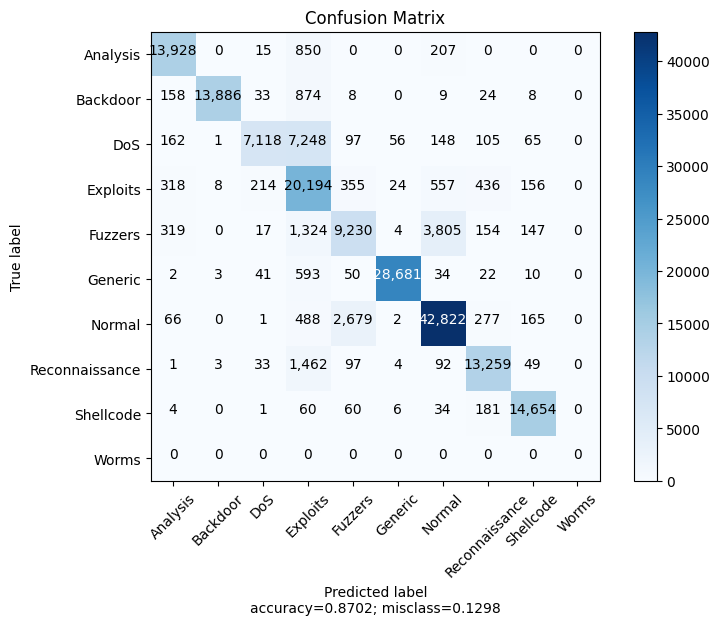

In [61]:
plot_confusion_matrix(cm           = confussion_matrix, 
                      normalize    = False,
                      target_names = ['Analysis', 'Backdoor', 'DoS', 'Exploits', 'Fuzzers', 'Generic','Normal', 'Reconnaissance', 'Shellcode', 'Worms'],
                      title        = "Confusion Matrix")

In [62]:
target_class=[]
target_class=["Analysis","Backdoor","DoS", "Exploits", "Fuzzers", "Generic","Normal","Reconnaissance", "Shellcode", "Worms"]

In [65]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc

In [ ]:
pred1 = model.predict(x_test_2)

4190/5882 ━━━━━━━━━━━━━━━━━━━━ 2:15 80ms/step

In [68]:
dummies = pd.get_dummies(train_y_over) # Classification

print (dummies)
outcomes = dummies.columns
num_classes = len(outcomes)
y_train_1 = dummies.values

        Analysis  Backdoor    DoS  Exploits  Fuzzers  Generic  Normal  \
0          False     False  False     False    False    False    True   
1          False     False  False     False    False    False    True   
2          False     False  False     False    False    False    True   
3          False     False  False     False    False    False    True   
4          False     False  False     False    False    False    True   
...          ...       ...    ...       ...      ...      ...     ...   
219693      True     False  False     False    False    False   False   
219694      True     False  False     False    False    False   False   
219695      True     False  False     False    False    False   False   
219696      True     False  False     False    False    False   False   
219697      True     False  False     False    False    False   False   

        Reconnaissance  Shellcode  
0                False      False  
1                False      False  
2              

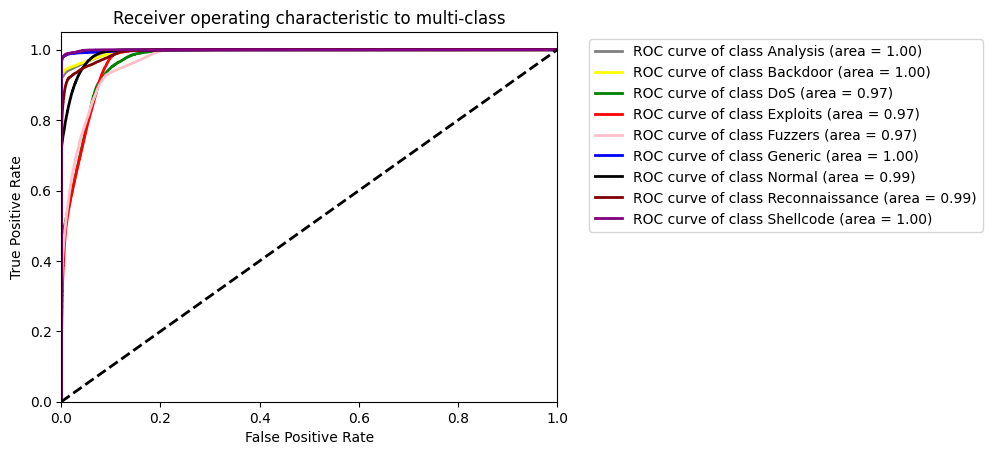

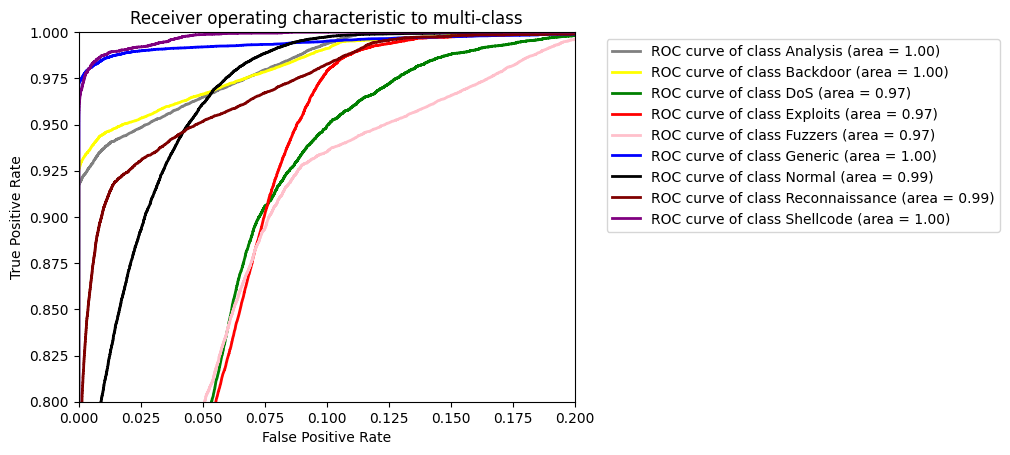

In [70]:
# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(9):
    fpr[i], tpr[i], _ = roc_curve(y_test_2[:, i], pred1[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_2.ravel(), pred1.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(9)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(9):
    f = interp1d(fpr[i], tpr[i])
    mean_tpr += f(all_fpr)

# Finally average it and compute AUC
mean_tpr /= 9


fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])



colors = cycle(['grey', 'yellow', 'green','red','pink','blue','black','maroon','purple','orange'])
for i, color in zip(range(9), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(target_class[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

#zoom in the plot
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)




colors = cycle(['grey', 'yellow', 'green','red','pink','blue','black','maroon','purple','orange'])
for i, color in zip(range(9), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(target_class[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

In [75]:
import random

classes = {0: "Analysis", 1: "Backdoor", 2: "DoS", 3: "Exploits", 4: "Fuzzers", 
           5: "Generic", 6: "Normal", 7: "Reconnaissance", 8: "Shellcode"}
random_sample = new_train_df.sample()
print(random_sample["Class"])
random_sample_train = random_sample
random_sample_train = random_sample_train.drop("Class", axis = 1)
random_sample_train_reshaped = random_sample_train.values.reshape(-1, 196, 1)
pred = model.predict(random_sample_train_reshaped)
print(pred)
print(classes[np.argmax(pred, axis=1)[0]])

51932    Fuzzers
Name: Class, dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
[[6.3636294e-03 9.6662026e-03 9.6432984e-02 2.3354854e-01 2.3444392e-01
  1.5286455e-01 1.9028895e-01 2.1646515e-04 7.6174788e-02]]
Fuzzers


In [77]:
model.save_weights("nids_ism.weights.h5")

In [83]:
model.save("ism_model.keras")